In [1]:
import numpy as np
import energyflow
from particle import Particle

import torch
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Sigmoid, ModuleList, LeakyReLU, Sequential, Dropout
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from tqdm import tqdm

import networkx as nx
import os
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### Hyperparameters

In [2]:
n_connections = 3
input_dims = 8
hidden_dims = [8,8]
output_dims = 1
q_depth = 3
epochs = 20
lr = 1e-3
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
batch_size = 64

### Load the dataset

In [3]:
energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia', with_bc=False, cache_dir='~/data')

(array([[[ 2.68769142e-01,  3.56903171e-01,  4.74138734e+00,
           2.20000000e+01],
         [ 1.60076377e-01, -2.55609533e-01,  4.55022910e+00,
           2.20000000e+01],
         [ 1.14868731e+00, -6.24380156e-02,  4.50385377e+00,
          -2.11000000e+02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00]],
 
        [[ 1.21266321e+00, -1.12853089e-01,  3.04708757e+00,
          -2.11000000e+02],
         [ 2.40893976e-01, -1.67174886e-02,  2.82705667e+00,
           2.20000000e+01],
         [ 1.02778452e-01, -8.58720522e-02,  3.04180579e+00,
           2.20000000e+01],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000

In [4]:
dataset = np.load(os.path.expanduser('~/data/datasets/QG_jets.npz'))

In [5]:
dataset.files

['X', 'y']

In [6]:
X = dataset['X']
y = dataset['y']
X.shape, y.shape

((100000, 139, 4), (100000,))

In [7]:
X = torch.tensor(X)

#### Normalize the dataset

In [9]:
torch.amax(X,dim=(0,1))

tensor([5.4849e+02, 2.2004e+00, 6.7172e+00, 2.2120e+03], dtype=torch.float64)

In [10]:
X_norm = X / torch.amax(X, dim=(0,1))   
# fetch the maximum value for all feature (in last dimension) and normalize the dataset through max scaling.
X_norm.shape

torch.Size([100000, 139, 4])

### Experiment 1: Visualizing the distribution of the number of particles per jet for quark and gluon jets

In this experiment, we try to see if there is any visible difference in the particle distributions which could further be exploited to improve our model performance

In [11]:
def strip_zeros(X):
    X_useful = []
    for Xi in X:
        inds = np.where(Xi[:,0] > 1e-10)
        X_useful.append(Xi[inds])
        
    return X_useful

In [12]:
X_preprocessed = strip_zeros(X_norm)
len(X_preprocessed), X_preprocessed[0].shape, X_preprocessed[1].shape

(100000, torch.Size([18, 4]), torch.Size([17, 4]))

In [13]:
len(X_preprocessed), X_preprocessed[0].shape, X_preprocessed[1].shape

(100000, torch.Size([18, 4]), torch.Size([17, 4]))

In [14]:
labels = np.array(["quark" if yi==1 else "gluon" for yi in y])

In [15]:
inds = np.where(labels[:1000] == "quark")[0]
inds

array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,  12,  14,  15,
        18,  21,  22,  24,  26,  29,  33,  35,  36,  37,  38,  42,  43,
        44,  45,  46,  47,  50,  51,  54,  56,  57,  59,  60,  62,  64,
        65,  67,  69,  70,  71,  72,  75,  78,  83,  86,  87,  88,  92,
        95,  96,  98, 101, 104, 105, 107, 108, 109, 112, 113, 114, 116,
       118, 120, 123, 126, 128, 131, 132, 134, 138, 139, 141, 142, 144,
       146, 148, 150, 152, 153, 154, 156, 158, 160, 161, 163, 165, 167,
       168, 172, 173, 174, 177, 181, 182, 183, 187, 188, 191, 194, 195,
       196, 197, 201, 202, 204, 206, 209, 211, 212, 213, 214, 215, 217,
       219, 220, 224, 226, 229, 231, 234, 236, 237, 240, 241, 242, 250,
       251, 253, 254, 257, 259, 260, 262, 264, 265, 267, 268, 269, 272,
       274, 275, 276, 279, 281, 288, 289, 291, 294, 298, 301, 305, 306,
       307, 309, 310, 313, 315, 320, 323, 325, 327, 328, 330, 331, 332,
       335, 339, 342, 344, 346, 347, 349, 351, 352, 353, 356, 35

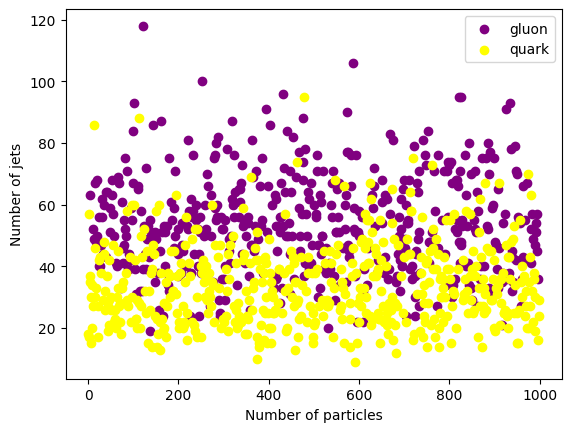

In [45]:
colors = ["purple", "yellow"]
for i, u in enumerate(["gluon", "quark"]):
    inds = np.where(labels[:1000] == u)[0]
    Xi = [len(X_preprocessed[j]) for j in inds]
    plt.scatter(inds, Xi, c=colors[i], label=str(u))
    

plt.xlabel("Number of particles")
plt.ylabel("Number of jets")
    
plt.legend()
plt.show()

In [17]:
quark_num_particles = [len(X_preprocessed[i]) for i in range(len(X_preprocessed)) if y[i] == 1]

Text(0, 0.5, 'Number of jets')

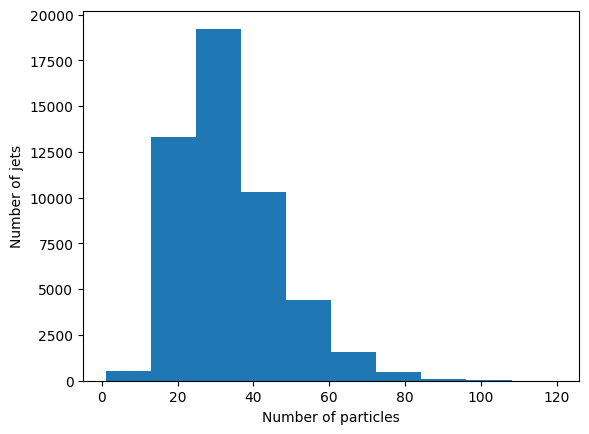

In [46]:
plt.hist(quark_num_particles)
plt.xlabel("Number of particles")
plt.ylabel("Number of jets")

In [19]:
gluon_num_particles = [len(X_preprocessed[i]) for i in range(len(X_preprocessed)) if y[i] == 0]

Text(0, 0.5, 'Number of jets')

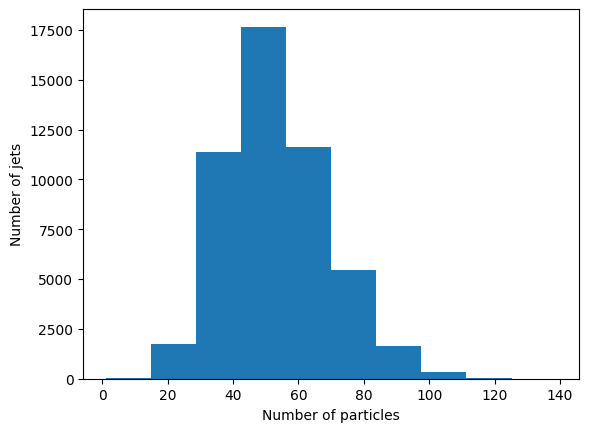

In [47]:
plt.hist(gluon_num_particles)
plt.xlabel("Number of particles")
plt.ylabel("Number of jets")

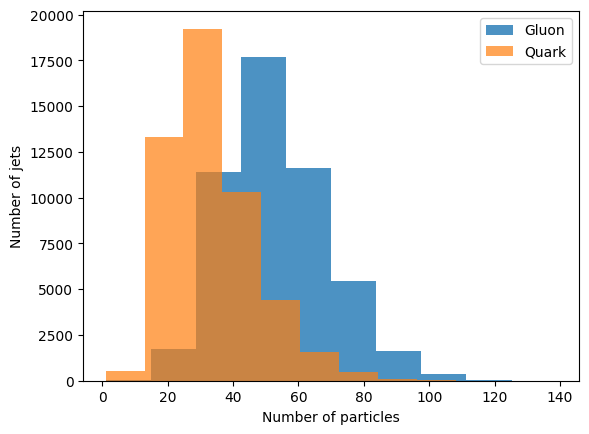

In [48]:
plt.hist(gluon_num_particles, alpha=0.8, label="Gluon")
plt.hist(quark_num_particles, alpha=0.7, label="Quark")
plt.xlabel("Number of particles")
plt.ylabel("Number of jets")
plt.legend()
plt.show()

It can be seen that only 2.5k gluon jets have about 20 particles whereas more than 12.5k quark jets have about 20 particles. Similarly, only 5K quark jets have about 50 particles whereas 17.5K gluon jets have 50 particles. We shall try to incorporate this distribution in our graph embeddings in the future and evaluate the performance.

### Experiment 2: Finding the optimal number of particles per jet 

In this experiment we try to find the optimal number of particles to consider per jet in order to best represent the jet. The idea is to sort all the particles by their transverse momentums and then consider a fixed number of particles with the highest momentums for each jet. We then train a GNN on the graphs to observe the trends in the performance. In order to reduce the variance observed, we consider 100K jets and split it into 8 batches of 12.5K jets each, train the models on each batch and consider the average over the 8 batches for plotting. The number of particles we consider is varied from 1 to 15. 

In [25]:
X = dataset['X']

#### Sort by transverse momentum

In [26]:
X_sorted = np.zeros((X.shape[0], 15, X.shape[2]))
for i in range(X.shape[0]):
    sort_nodes = np.argsort(X[i,:,0])[::-1]
    X_sorted[i,:,:] = X[i,sort_nodes[:15],:]

In [27]:
X_sorted.shape

(100000, 15, 4)

In [28]:
def feature_engineer_dataset(X):
    
    # unpack all features
    pt = X[:,:,0]
    rapidity = X[:,:,1]
    phi = X[:,:,2]
    pdgids = X[:,:,3]

    # Calculate new feature values
    nonzero_pdgids = np.where(pdgids > 0) 
    mass = np.zeros(pdgids.shape)
    mass_nonzeros = np.vectorize(Particle.from_pdgid)(pdgids[nonzero_pdgids])
    mass[nonzero_pdgids] = np.fromiter((i.mass for i in mass_nonzeros), float)

    mt = np.sqrt(np.square(mass) + np.square(pt))
    energy = mass*np.cosh(rapidity) 
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    pz = mt*np.sinh(rapidity)
    
    return torch.tensor(np.stack((pt, rapidity, phi, mt, energy, px, py, pz), axis=2), dtype=torch.float)

In [29]:
X_new = feature_engineer_dataset(X_sorted)

In [30]:
X_new.shape

torch.Size([100000, 15, 8])

In [31]:
X_norm = X_new / torch.amax(X_new, dim=(0,1))   
# fetch the maximum value for all feature (in last dimension) and normalize the dataset through max scaling.
X_norm.shape

torch.Size([100000, 15, 8])

In [32]:
def create_graph(x):
    M = x.shape[0]  # number of nodes in graph (particles)
    N = min(M-1, n_connections-1)    # number of neighbors of each node to be considered for edge connections (1 extra for self loops) 
    # (√N is considered optimal number of neighbors for k-NN on N points)
    edge_index = torch.zeros((2,M*N))   
    edge_attr = torch.zeros((M*N, 1))
    
    for i, features in enumerate(x):
        # find N nearest neighbors in (𝜙,𝑦) space
        distances = torch.sqrt((features[2] - x[:,2])**2 + (features[1] - x[:,1])**2)
        N_nearest = np.argsort(distances)[:N]
        
        edge_index[0][i*N:(i+1)*N] = torch.tensor([i for _ in range(N)])
        edge_index[1][i*N:(i+1)*N] = N_nearest
        edge_attr[i*N:(i+1)*N] = distances[N_nearest].reshape(N,1)
     
    edge_index = edge_index.to(torch.int)
    return edge_index, edge_attr

In [33]:
def create_graph_dataset(X, y):
    dataset = []
        
    for Xi, yi in zip(X,y):

        edge_index, edge_attr = create_graph(Xi)            
        data = Data(x=Xi, edge_index=edge_index, edge_attr=edge_attr,y=torch.tensor(yi, dtype=torch.long))
        dataset.append(data)
        
    return dataset

### Train functions

In [34]:
def run_model(model, epoch, loader, lossFn, optimizer, train=True, quantum=False):
    if train:
        model.train()
    else:
        model.eval()
        
    loss = 0
    net_loss = 0
    correct = 0
  
    for batch_idx, data in (tqdm(enumerate(loader)) if train else enumerate(loader)):
        
        target = data.y

        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()

        #Run the model on the train data
        output = model(data.x, data.edge_index.type(torch.int64), data.batch)

        target = target.unsqueeze(1).float()

        # Calculate the loss
        loss = lossFn(output, target)
        net_loss += loss.data * batch_size

        if train:
            #dloss/dx for every Variable 
            loss.backward()

            #to do a one-step update on our parameter.
            optimizer.step()

        pred = (output > 0).float() 
        # since we are working with logits and not probabilities (sigmoid is applied while computing loss), we consider 0 as threshold
        
#         _, pred = torch.max(F.softmax(output,dim=1).data, dim=1)
        correct += (pred == target).sum()
        
        
    acc = correct / len(loader.dataset)
    net_loss /= len(loader.dataset)
      
    if train:
        print('Train', end=" ")
    else:
        print("Val", end=" ")
        
    # Print out the loss
    print('Epoch: {} \tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
          epoch, net_loss, correct, len(loader.dataset),
          100. * acc))
    
    return net_loss, acc

In [35]:
def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):
    
    history = {'train_loss': [],'val_loss':[],'train_acc': [],'val_acc': [] }

    for epoch in range(epochs):
        train_loss, train_acc = run_model(model, epoch, train_dataloader, lossFn, optimizer)
        val_loss, val_acc = run_model(model, epoch, val_dataloader, lossFn, optimizer, train=False)
        print()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
    return history    

In [36]:
def test_eval(model, test_dataloader):
    
    preds = []
    labels = []
    acc = 0
    for data in test_dataloader:

        target = data.y
        labels.append(target.detach().cpu().numpy())
        
        output = model(data.x, data.edge_index.type(torch.int64), data.batch)
        preds.append(output.detach().cpu().numpy())  # Convert to numpy array
        # probs = Sigmoid()(output).detach().cpu().numpy()  # Convert to numpy array
        # preds.append(copy.deepcopy(output))

        target = target.unsqueeze(1).float()    
        pred = (output > 0).float()    
        acc += (pred == target).sum().item()

    acc = acc / len(test_dataloader.dataset)
    print("Test accuracy: ", 100. * acc)
    
    labels = np.concatenate(labels, axis=0)  # Concatenate lists into a single numpy array
    preds = np.concatenate(preds, axis=0)  # Concatenate lists into a single numpy array

    
    return labels, preds

In [37]:
def plot_loss(history, step=2):
    n = len(history['train_loss'])
    x = range(n)
    plt.plot(x, history['train_loss'], label='Train loss')
    plt.plot(x, history['val_loss'], label='Val loss')
    plt.plot(x, history['train_acc'], label='Train acc')
    plt.plot(x, history['val_acc'], label='Val acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(0,n,step), range(1,n+1,step))

    plt.legend()
    plt.show()

In [38]:
def plot_auc(model, test_dataloader):
    labels, preds = test_eval(model, test_dataloader)
    auc = roc_auc_score(labels, preds)
    fpr, tpr, _ = roc_curve(labels, preds)
    plt.plot(fpr, tpr, label="AUC = {0}".format(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

### PyTorch GCN

In [39]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activ_fn):
        super().__init__()
        layers = []
        layers.append(GCNConv(input_dim, hidden_dims[0]))
    
        for i in range(len(hidden_dims)-1):
            layers.append(GCNConv(hidden_dims[i], hidden_dims[i+1]))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = Linear(hidden_dims[-1], output_dims)

    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.classifier(h)
        return h

In [40]:
def find_ideal_particles(X, y, min_particles, max_particles):
    train_loss = dict()
    val_loss = dict()
    train_acc = dict()
    val_acc = dict()
    auc = dict()
    
    for i in range(min_particles, max_particles+1):
        
        print("Particles per jet:",i)
        train_loss_i = []
        val_loss_i = []
        train_acc_i = []
        val_acc_i = []
        auc_i = []
        
        for j in range(8):

            X_filtered = X[j*12500:min(len(X), (j+1)*12500), :i, :]
            y_filtered = y[j*12500:min(len(X), (j+1)*12500)]
            dataset = create_graph_dataset(X_filtered,y_filtered)

            data_train, data_val, data_test = torch.utils.data.random_split(dataset, [train_ratio, val_ratio, test_ratio])

            train_dataloader = DataLoader(data_train,
                                  batch_size = batch_size,
                                  shuffle=True)
            val_dataloader = DataLoader(data_val,
                                        batch_size = batch_size,
                                        shuffle=True)
            test_dataloader = DataLoader(data_test,
                             batch_size = batch_size,
                             shuffle=True)

            model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())

            optimizer = Adam(model.parameters(), 1e-2)
            lossFn = BCEWithLogitsLoss()
            history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

            ind = np.argmin(history['val_loss'])
            train_loss_i.append(history['train_loss'][ind])
            val_loss_i.append(history['val_loss'][ind])
            train_acc_i.append(history['train_acc'][ind])
            val_acc_i.append(history['val_acc'][ind])

            labels, preds = test_eval(model, test_dataloader)
            auc_i.append(roc_auc_score(labels, preds))

            plot_loss(history)
            print("*"*100)
            print()
            
        print()
        print()
            
        train_loss[i] = train_loss_i
        val_loss[i] = val_loss_i
        train_acc[i] = train_acc_i
        val_acc[i] = val_acc_i
        auc[i] = auc_i
        
    return train_loss, val_loss, train_acc, val_acc, auc

In [41]:
hidden_dims = [8]
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 8)
  )
  (activ_fn): ReLU()
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

Particles per jet: 1


118it [00:00, 271.55it/s]


Train Epoch: 0 	Loss: 0.658358, Accuracy: 4723/7500 (63%)
Val Epoch: 0 	Loss: 0.617834, Accuracy: 1728/2500 (69%)



118it [00:00, 269.54it/s]


Train Epoch: 1 	Loss: 0.592736, Accuracy: 5232/7500 (70%)
Val Epoch: 1 	Loss: 0.598413, Accuracy: 1766/2500 (71%)



118it [00:00, 261.67it/s]


Train Epoch: 2 	Loss: 0.580164, Accuracy: 5261/7500 (70%)
Val Epoch: 2 	Loss: 0.588961, Accuracy: 1763/2500 (71%)



118it [00:00, 256.43it/s]


Train Epoch: 3 	Loss: 0.580965, Accuracy: 5257/7500 (70%)
Val Epoch: 3 	Loss: 0.582141, Accuracy: 1782/2500 (71%)



118it [00:00, 239.65it/s]


Train Epoch: 4 	Loss: 0.578346, Accuracy: 5268/7500 (70%)
Val Epoch: 4 	Loss: 0.582490, Accuracy: 1784/2500 (71%)



118it [00:00, 236.99it/s]


Train Epoch: 5 	Loss: 0.576117, Accuracy: 5291/7500 (71%)
Val Epoch: 5 	Loss: 0.587737, Accuracy: 1757/2500 (70%)



118it [00:00, 253.68it/s]


Train Epoch: 6 	Loss: 0.574571, Accuracy: 5291/7500 (71%)
Val Epoch: 6 	Loss: 0.585976, Accuracy: 1789/2500 (72%)



118it [00:00, 270.32it/s]


Train Epoch: 7 	Loss: 0.575578, Accuracy: 5299/7500 (71%)
Val Epoch: 7 	Loss: 0.577858, Accuracy: 1771/2500 (71%)



118it [00:00, 278.24it/s]


Train Epoch: 8 	Loss: 0.575932, Accuracy: 5304/7500 (71%)
Val Epoch: 8 	Loss: 0.585991, Accuracy: 1783/2500 (71%)



118it [00:00, 280.76it/s]


Train Epoch: 9 	Loss: 0.578571, Accuracy: 5288/7500 (71%)
Val Epoch: 9 	Loss: 0.579251, Accuracy: 1779/2500 (71%)



118it [00:00, 275.09it/s]


Train Epoch: 10 	Loss: 0.577612, Accuracy: 5294/7500 (71%)
Val Epoch: 10 	Loss: 0.594586, Accuracy: 1770/2500 (71%)



118it [00:00, 241.56it/s]


Train Epoch: 11 	Loss: 0.576570, Accuracy: 5315/7500 (71%)
Val Epoch: 11 	Loss: 0.573395, Accuracy: 1785/2500 (71%)



118it [00:00, 257.92it/s]


Train Epoch: 12 	Loss: 0.576995, Accuracy: 5308/7500 (71%)
Val Epoch: 12 	Loss: 0.581392, Accuracy: 1788/2500 (72%)



118it [00:00, 264.08it/s]


Train Epoch: 13 	Loss: 0.574696, Accuracy: 5285/7500 (70%)
Val Epoch: 13 	Loss: 0.595247, Accuracy: 1772/2500 (71%)



118it [00:00, 257.36it/s]


Train Epoch: 14 	Loss: 0.572439, Accuracy: 5306/7500 (71%)
Val Epoch: 14 	Loss: 0.588432, Accuracy: 1788/2500 (72%)



118it [00:00, 270.55it/s]


Train Epoch: 15 	Loss: 0.573726, Accuracy: 5285/7500 (70%)
Val Epoch: 15 	Loss: 0.581046, Accuracy: 1780/2500 (71%)



118it [00:00, 272.66it/s]


Train Epoch: 16 	Loss: 0.574336, Accuracy: 5288/7500 (71%)
Val Epoch: 16 	Loss: 0.584328, Accuracy: 1776/2500 (71%)



118it [00:00, 278.21it/s]


Train Epoch: 17 	Loss: 0.574596, Accuracy: 5286/7500 (70%)
Val Epoch: 17 	Loss: 0.591044, Accuracy: 1767/2500 (71%)



118it [00:00, 273.79it/s]


Train Epoch: 18 	Loss: 0.576349, Accuracy: 5297/7500 (71%)
Val Epoch: 18 	Loss: 0.580371, Accuracy: 1776/2500 (71%)



118it [00:00, 283.49it/s]


Train Epoch: 19 	Loss: 0.576145, Accuracy: 5296/7500 (71%)
Val Epoch: 19 	Loss: 0.585591, Accuracy: 1779/2500 (71%)



118it [00:00, 278.80it/s]


Train Epoch: 20 	Loss: 0.573287, Accuracy: 5300/7500 (71%)
Val Epoch: 20 	Loss: 0.580808, Accuracy: 1777/2500 (71%)



118it [00:00, 277.33it/s]


Train Epoch: 21 	Loss: 0.575736, Accuracy: 5300/7500 (71%)
Val Epoch: 21 	Loss: 0.593725, Accuracy: 1768/2500 (71%)



118it [00:00, 275.87it/s]


Train Epoch: 22 	Loss: 0.573464, Accuracy: 5312/7500 (71%)
Val Epoch: 22 	Loss: 0.583184, Accuracy: 1780/2500 (71%)



118it [00:00, 280.63it/s]


Train Epoch: 23 	Loss: 0.574636, Accuracy: 5303/7500 (71%)
Val Epoch: 23 	Loss: 0.594718, Accuracy: 1764/2500 (71%)



118it [00:00, 276.94it/s]


Train Epoch: 24 	Loss: 0.575564, Accuracy: 5293/7500 (71%)
Val Epoch: 24 	Loss: 0.583432, Accuracy: 1776/2500 (71%)



118it [00:00, 273.08it/s]


Train Epoch: 25 	Loss: 0.573535, Accuracy: 5277/7500 (70%)
Val Epoch: 25 	Loss: 0.577981, Accuracy: 1785/2500 (71%)



118it [00:00, 268.79it/s]


Train Epoch: 26 	Loss: 0.572841, Accuracy: 5289/7500 (71%)
Val Epoch: 26 	Loss: 0.582831, Accuracy: 1763/2500 (71%)



118it [00:00, 274.10it/s]


Train Epoch: 27 	Loss: 0.574436, Accuracy: 5291/7500 (71%)
Val Epoch: 27 	Loss: 0.595450, Accuracy: 1766/2500 (71%)



118it [00:00, 281.69it/s]


Train Epoch: 28 	Loss: 0.574911, Accuracy: 5279/7500 (70%)
Val Epoch: 28 	Loss: 0.583934, Accuracy: 1781/2500 (71%)



118it [00:00, 280.24it/s]


Train Epoch: 29 	Loss: 0.575287, Accuracy: 5258/7500 (70%)
Val Epoch: 29 	Loss: 0.583243, Accuracy: 1784/2500 (71%)



118it [00:00, 273.42it/s]


Train Epoch: 30 	Loss: 0.572376, Accuracy: 5303/7500 (71%)
Val Epoch: 30 	Loss: 0.577947, Accuracy: 1774/2500 (71%)



118it [00:00, 268.30it/s]


Train Epoch: 31 	Loss: 0.574407, Accuracy: 5291/7500 (71%)
Val Epoch: 31 	Loss: 0.593085, Accuracy: 1759/2500 (70%)



118it [00:00, 262.26it/s]


Train Epoch: 32 	Loss: 0.572913, Accuracy: 5289/7500 (71%)
Val Epoch: 32 	Loss: 0.576568, Accuracy: 1771/2500 (71%)



118it [00:00, 275.19it/s]


Train Epoch: 33 	Loss: 0.573132, Accuracy: 5301/7500 (71%)
Val Epoch: 33 	Loss: 0.571250, Accuracy: 1777/2500 (71%)



118it [00:00, 274.46it/s]


Train Epoch: 34 	Loss: 0.574500, Accuracy: 5278/7500 (70%)
Val Epoch: 34 	Loss: 0.585484, Accuracy: 1777/2500 (71%)



118it [00:00, 272.58it/s]


Train Epoch: 35 	Loss: 0.573254, Accuracy: 5291/7500 (71%)
Val Epoch: 35 	Loss: 0.578564, Accuracy: 1776/2500 (71%)



118it [00:00, 275.54it/s]


Train Epoch: 36 	Loss: 0.574042, Accuracy: 5286/7500 (70%)
Val Epoch: 36 	Loss: 0.584392, Accuracy: 1771/2500 (71%)



118it [00:00, 266.71it/s]


Train Epoch: 37 	Loss: 0.573712, Accuracy: 5286/7500 (70%)
Val Epoch: 37 	Loss: 0.581961, Accuracy: 1774/2500 (71%)



118it [00:00, 273.63it/s]


Train Epoch: 38 	Loss: 0.576939, Accuracy: 5295/7500 (71%)
Val Epoch: 38 	Loss: 0.586334, Accuracy: 1775/2500 (71%)



118it [00:00, 264.02it/s]


Train Epoch: 39 	Loss: 0.574607, Accuracy: 5297/7500 (71%)
Val Epoch: 39 	Loss: 0.579312, Accuracy: 1776/2500 (71%)

Test accuracy:  73.44000000000001


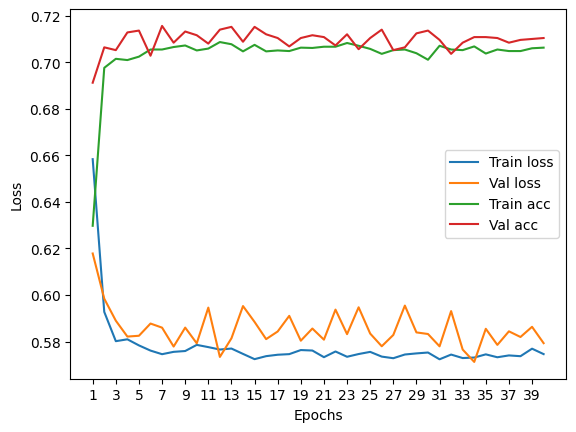

****************************************************************************************************



118it [00:00, 273.11it/s]


Train Epoch: 0 	Loss: 0.661052, Accuracy: 4674/7500 (62%)
Val Epoch: 0 	Loss: 0.626568, Accuracy: 1708/2500 (68%)



118it [00:00, 272.58it/s]


Train Epoch: 1 	Loss: 0.594317, Accuracy: 5248/7500 (70%)
Val Epoch: 1 	Loss: 0.601470, Accuracy: 1754/2500 (70%)



118it [00:00, 278.69it/s]


Train Epoch: 2 	Loss: 0.586172, Accuracy: 5277/7500 (70%)
Val Epoch: 2 	Loss: 0.616956, Accuracy: 1764/2500 (71%)



118it [00:00, 275.16it/s]


Train Epoch: 3 	Loss: 0.583610, Accuracy: 5253/7500 (70%)
Val Epoch: 3 	Loss: 0.607504, Accuracy: 1746/2500 (70%)



118it [00:00, 271.02it/s]


Train Epoch: 4 	Loss: 0.582339, Accuracy: 5298/7500 (71%)
Val Epoch: 4 	Loss: 0.596620, Accuracy: 1751/2500 (70%)



118it [00:00, 266.13it/s]


Train Epoch: 5 	Loss: 0.579789, Accuracy: 5284/7500 (70%)
Val Epoch: 5 	Loss: 0.604002, Accuracy: 1752/2500 (70%)



118it [00:00, 273.59it/s]


Train Epoch: 6 	Loss: 0.581277, Accuracy: 5305/7500 (71%)
Val Epoch: 6 	Loss: 0.598419, Accuracy: 1762/2500 (70%)



118it [00:00, 260.32it/s]


Train Epoch: 7 	Loss: 0.580492, Accuracy: 5304/7500 (71%)
Val Epoch: 7 	Loss: 0.603358, Accuracy: 1752/2500 (70%)



118it [00:00, 274.20it/s]


Train Epoch: 8 	Loss: 0.577494, Accuracy: 5299/7500 (71%)
Val Epoch: 8 	Loss: 0.597178, Accuracy: 1761/2500 (70%)



118it [00:00, 270.22it/s]


Train Epoch: 9 	Loss: 0.577031, Accuracy: 5312/7500 (71%)
Val Epoch: 9 	Loss: 0.592871, Accuracy: 1769/2500 (71%)



118it [00:00, 277.49it/s]


Train Epoch: 10 	Loss: 0.579198, Accuracy: 5318/7500 (71%)
Val Epoch: 10 	Loss: 0.594038, Accuracy: 1766/2500 (71%)



118it [00:00, 279.07it/s]


Train Epoch: 11 	Loss: 0.578206, Accuracy: 5304/7500 (71%)
Val Epoch: 11 	Loss: 0.597867, Accuracy: 1765/2500 (71%)



118it [00:00, 268.26it/s]


Train Epoch: 12 	Loss: 0.576005, Accuracy: 5315/7500 (71%)
Val Epoch: 12 	Loss: 0.599834, Accuracy: 1764/2500 (71%)



118it [00:00, 273.13it/s]


Train Epoch: 13 	Loss: 0.579213, Accuracy: 5327/7500 (71%)
Val Epoch: 13 	Loss: 0.601870, Accuracy: 1738/2500 (70%)



118it [00:00, 275.55it/s]


Train Epoch: 14 	Loss: 0.576034, Accuracy: 5328/7500 (71%)
Val Epoch: 14 	Loss: 0.590122, Accuracy: 1762/2500 (70%)



118it [00:00, 270.56it/s]


Train Epoch: 15 	Loss: 0.577789, Accuracy: 5278/7500 (70%)
Val Epoch: 15 	Loss: 0.595003, Accuracy: 1749/2500 (70%)



118it [00:00, 273.68it/s]


Train Epoch: 16 	Loss: 0.579729, Accuracy: 5303/7500 (71%)
Val Epoch: 16 	Loss: 0.603229, Accuracy: 1765/2500 (71%)



118it [00:00, 266.48it/s]


Train Epoch: 17 	Loss: 0.577089, Accuracy: 5311/7500 (71%)
Val Epoch: 17 	Loss: 0.592983, Accuracy: 1770/2500 (71%)



118it [00:00, 279.82it/s]


Train Epoch: 18 	Loss: 0.578232, Accuracy: 5301/7500 (71%)
Val Epoch: 18 	Loss: 0.598838, Accuracy: 1760/2500 (70%)



118it [00:00, 271.29it/s]


Train Epoch: 19 	Loss: 0.576112, Accuracy: 5317/7500 (71%)
Val Epoch: 19 	Loss: 0.605683, Accuracy: 1754/2500 (70%)



118it [00:00, 270.91it/s]


Train Epoch: 20 	Loss: 0.578828, Accuracy: 5304/7500 (71%)
Val Epoch: 20 	Loss: 0.605153, Accuracy: 1757/2500 (70%)



118it [00:00, 268.82it/s]


Train Epoch: 21 	Loss: 0.578599, Accuracy: 5295/7500 (71%)
Val Epoch: 21 	Loss: 0.599145, Accuracy: 1748/2500 (70%)



118it [00:00, 268.10it/s]


Train Epoch: 22 	Loss: 0.578499, Accuracy: 5304/7500 (71%)
Val Epoch: 22 	Loss: 0.602123, Accuracy: 1742/2500 (70%)



118it [00:00, 197.49it/s]


Train Epoch: 23 	Loss: 0.575680, Accuracy: 5317/7500 (71%)
Val Epoch: 23 	Loss: 0.608118, Accuracy: 1760/2500 (70%)



118it [00:00, 255.07it/s]


Train Epoch: 24 	Loss: 0.575928, Accuracy: 5308/7500 (71%)
Val Epoch: 24 	Loss: 0.595623, Accuracy: 1755/2500 (70%)



118it [00:00, 257.92it/s]


Train Epoch: 25 	Loss: 0.577118, Accuracy: 5320/7500 (71%)
Val Epoch: 25 	Loss: 0.600351, Accuracy: 1759/2500 (70%)



118it [00:00, 261.06it/s]


Train Epoch: 26 	Loss: 0.576189, Accuracy: 5310/7500 (71%)
Val Epoch: 26 	Loss: 0.591557, Accuracy: 1758/2500 (70%)



118it [00:00, 271.45it/s]


Train Epoch: 27 	Loss: 0.576699, Accuracy: 5313/7500 (71%)
Val Epoch: 27 	Loss: 0.605337, Accuracy: 1738/2500 (70%)



118it [00:00, 272.53it/s]


Train Epoch: 28 	Loss: 0.576657, Accuracy: 5295/7500 (71%)
Val Epoch: 28 	Loss: 0.594356, Accuracy: 1760/2500 (70%)



118it [00:00, 269.98it/s]


Train Epoch: 29 	Loss: 0.576208, Accuracy: 5301/7500 (71%)
Val Epoch: 29 	Loss: 0.599350, Accuracy: 1744/2500 (70%)



118it [00:00, 273.72it/s]


Train Epoch: 30 	Loss: 0.576310, Accuracy: 5326/7500 (71%)
Val Epoch: 30 	Loss: 0.601643, Accuracy: 1748/2500 (70%)



118it [00:00, 259.92it/s]


Train Epoch: 31 	Loss: 0.576746, Accuracy: 5308/7500 (71%)
Val Epoch: 31 	Loss: 0.590635, Accuracy: 1767/2500 (71%)



118it [00:00, 265.28it/s]


Train Epoch: 32 	Loss: 0.575984, Accuracy: 5302/7500 (71%)
Val Epoch: 32 	Loss: 0.593843, Accuracy: 1744/2500 (70%)



118it [00:00, 272.30it/s]


Train Epoch: 33 	Loss: 0.576301, Accuracy: 5327/7500 (71%)
Val Epoch: 33 	Loss: 0.601277, Accuracy: 1752/2500 (70%)



118it [00:00, 264.88it/s]


Train Epoch: 34 	Loss: 0.577708, Accuracy: 5313/7500 (71%)
Val Epoch: 34 	Loss: 0.602178, Accuracy: 1740/2500 (70%)



118it [00:00, 272.91it/s]


Train Epoch: 35 	Loss: 0.576434, Accuracy: 5330/7500 (71%)
Val Epoch: 35 	Loss: 0.602752, Accuracy: 1762/2500 (70%)



118it [00:00, 273.69it/s]


Train Epoch: 36 	Loss: 0.577340, Accuracy: 5319/7500 (71%)
Val Epoch: 36 	Loss: 0.602837, Accuracy: 1746/2500 (70%)



118it [00:00, 271.78it/s]


Train Epoch: 37 	Loss: 0.576468, Accuracy: 5329/7500 (71%)
Val Epoch: 37 	Loss: 0.589406, Accuracy: 1753/2500 (70%)



118it [00:00, 266.06it/s]


Train Epoch: 38 	Loss: 0.576798, Accuracy: 5321/7500 (71%)
Val Epoch: 38 	Loss: 0.603949, Accuracy: 1753/2500 (70%)



118it [00:00, 275.65it/s]


Train Epoch: 39 	Loss: 0.577088, Accuracy: 5309/7500 (71%)
Val Epoch: 39 	Loss: 0.590978, Accuracy: 1765/2500 (71%)

Test accuracy:  71.76


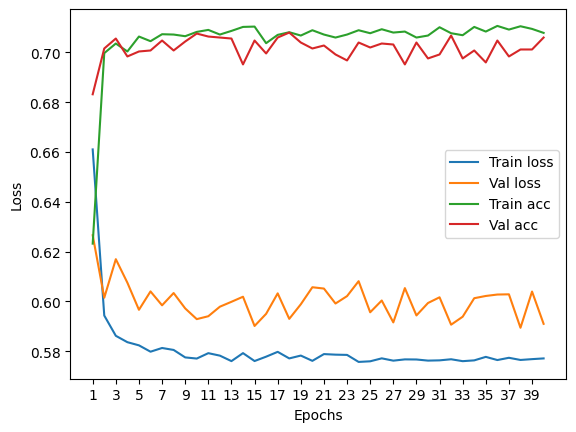

****************************************************************************************************



118it [00:00, 271.12it/s]


Train Epoch: 0 	Loss: 0.657754, Accuracy: 4790/7500 (64%)
Val Epoch: 0 	Loss: 0.613017, Accuracy: 1750/2500 (70%)



118it [00:00, 274.62it/s]


Train Epoch: 1 	Loss: 0.579738, Accuracy: 5300/7500 (71%)
Val Epoch: 1 	Loss: 0.588448, Accuracy: 1729/2500 (69%)



118it [00:00, 271.20it/s]


Train Epoch: 2 	Loss: 0.570093, Accuracy: 5358/7500 (71%)
Val Epoch: 2 	Loss: 0.584318, Accuracy: 1760/2500 (70%)



118it [00:00, 271.33it/s]


Train Epoch: 3 	Loss: 0.568383, Accuracy: 5346/7500 (71%)
Val Epoch: 3 	Loss: 0.598830, Accuracy: 1764/2500 (71%)



118it [00:00, 269.24it/s]


Train Epoch: 4 	Loss: 0.571379, Accuracy: 5339/7500 (71%)
Val Epoch: 4 	Loss: 0.583397, Accuracy: 1770/2500 (71%)



118it [00:00, 247.25it/s]


Train Epoch: 5 	Loss: 0.569760, Accuracy: 5348/7500 (71%)
Val Epoch: 5 	Loss: 0.579839, Accuracy: 1756/2500 (70%)



118it [00:00, 229.80it/s]


Train Epoch: 6 	Loss: 0.567812, Accuracy: 5359/7500 (71%)
Val Epoch: 6 	Loss: 0.588170, Accuracy: 1762/2500 (70%)



118it [00:00, 260.94it/s]


Train Epoch: 7 	Loss: 0.568189, Accuracy: 5372/7500 (72%)
Val Epoch: 7 	Loss: 0.590478, Accuracy: 1759/2500 (70%)



118it [00:00, 246.13it/s]


Train Epoch: 8 	Loss: 0.567914, Accuracy: 5374/7500 (72%)
Val Epoch: 8 	Loss: 0.583213, Accuracy: 1772/2500 (71%)



118it [00:00, 269.63it/s]


Train Epoch: 9 	Loss: 0.568835, Accuracy: 5331/7500 (71%)
Val Epoch: 9 	Loss: 0.578370, Accuracy: 1771/2500 (71%)



118it [00:00, 269.42it/s]


Train Epoch: 10 	Loss: 0.567518, Accuracy: 5357/7500 (71%)
Val Epoch: 10 	Loss: 0.583640, Accuracy: 1774/2500 (71%)



118it [00:00, 265.56it/s]


Train Epoch: 11 	Loss: 0.567352, Accuracy: 5368/7500 (72%)
Val Epoch: 11 	Loss: 0.583532, Accuracy: 1764/2500 (71%)



118it [00:00, 252.53it/s]


Train Epoch: 12 	Loss: 0.568661, Accuracy: 5352/7500 (71%)
Val Epoch: 12 	Loss: 0.577052, Accuracy: 1769/2500 (71%)



118it [00:00, 267.03it/s]


Train Epoch: 13 	Loss: 0.566382, Accuracy: 5367/7500 (72%)
Val Epoch: 13 	Loss: 0.579817, Accuracy: 1778/2500 (71%)



118it [00:00, 272.53it/s]


Train Epoch: 14 	Loss: 0.566340, Accuracy: 5362/7500 (71%)
Val Epoch: 14 	Loss: 0.585597, Accuracy: 1777/2500 (71%)



118it [00:00, 265.85it/s]


Train Epoch: 15 	Loss: 0.565684, Accuracy: 5364/7500 (72%)
Val Epoch: 15 	Loss: 0.582544, Accuracy: 1779/2500 (71%)



118it [00:00, 238.03it/s]


Train Epoch: 16 	Loss: 0.568742, Accuracy: 5374/7500 (72%)
Val Epoch: 16 	Loss: 0.584013, Accuracy: 1768/2500 (71%)



118it [00:00, 268.02it/s]


Train Epoch: 17 	Loss: 0.566289, Accuracy: 5399/7500 (72%)
Val Epoch: 17 	Loss: 0.588012, Accuracy: 1772/2500 (71%)



118it [00:00, 266.25it/s]


Train Epoch: 18 	Loss: 0.565621, Accuracy: 5362/7500 (71%)
Val Epoch: 18 	Loss: 0.584313, Accuracy: 1765/2500 (71%)



118it [00:00, 267.91it/s]


Train Epoch: 19 	Loss: 0.566883, Accuracy: 5367/7500 (72%)
Val Epoch: 19 	Loss: 0.589802, Accuracy: 1770/2500 (71%)



118it [00:00, 263.90it/s]


Train Epoch: 20 	Loss: 0.564212, Accuracy: 5372/7500 (72%)
Val Epoch: 20 	Loss: 0.586813, Accuracy: 1756/2500 (70%)



118it [00:00, 257.67it/s]


Train Epoch: 21 	Loss: 0.564421, Accuracy: 5388/7500 (72%)
Val Epoch: 21 	Loss: 0.586222, Accuracy: 1768/2500 (71%)



118it [00:00, 268.46it/s]


Train Epoch: 22 	Loss: 0.565231, Accuracy: 5400/7500 (72%)
Val Epoch: 22 	Loss: 0.590959, Accuracy: 1750/2500 (70%)



118it [00:00, 263.86it/s]


Train Epoch: 23 	Loss: 0.563896, Accuracy: 5399/7500 (72%)
Val Epoch: 23 	Loss: 0.580479, Accuracy: 1770/2500 (71%)



118it [00:00, 267.88it/s]


Train Epoch: 24 	Loss: 0.564253, Accuracy: 5388/7500 (72%)
Val Epoch: 24 	Loss: 0.581061, Accuracy: 1775/2500 (71%)



118it [00:00, 266.55it/s]


Train Epoch: 25 	Loss: 0.565508, Accuracy: 5366/7500 (72%)
Val Epoch: 25 	Loss: 0.592833, Accuracy: 1775/2500 (71%)



118it [00:00, 270.29it/s]


Train Epoch: 26 	Loss: 0.562923, Accuracy: 5404/7500 (72%)
Val Epoch: 26 	Loss: 0.579683, Accuracy: 1771/2500 (71%)



118it [00:00, 270.05it/s]


Train Epoch: 27 	Loss: 0.564082, Accuracy: 5406/7500 (72%)
Val Epoch: 27 	Loss: 0.574926, Accuracy: 1756/2500 (70%)



118it [00:00, 273.65it/s]


Train Epoch: 28 	Loss: 0.564653, Accuracy: 5387/7500 (72%)
Val Epoch: 28 	Loss: 0.584187, Accuracy: 1772/2500 (71%)



118it [00:00, 262.43it/s]


Train Epoch: 29 	Loss: 0.563867, Accuracy: 5393/7500 (72%)
Val Epoch: 29 	Loss: 0.577406, Accuracy: 1769/2500 (71%)



118it [00:00, 261.61it/s]


Train Epoch: 30 	Loss: 0.565775, Accuracy: 5408/7500 (72%)
Val Epoch: 30 	Loss: 0.586274, Accuracy: 1762/2500 (70%)



118it [00:00, 273.92it/s]


Train Epoch: 31 	Loss: 0.562121, Accuracy: 5405/7500 (72%)
Val Epoch: 31 	Loss: 0.581297, Accuracy: 1764/2500 (71%)



118it [00:00, 267.10it/s]


Train Epoch: 32 	Loss: 0.564824, Accuracy: 5411/7500 (72%)
Val Epoch: 32 	Loss: 0.573622, Accuracy: 1758/2500 (70%)



118it [00:00, 212.39it/s]


Train Epoch: 33 	Loss: 0.562559, Accuracy: 5418/7500 (72%)
Val Epoch: 33 	Loss: 0.582894, Accuracy: 1762/2500 (70%)



118it [00:00, 260.14it/s]


Train Epoch: 34 	Loss: 0.563200, Accuracy: 5380/7500 (72%)
Val Epoch: 34 	Loss: 0.583290, Accuracy: 1783/2500 (71%)



118it [00:00, 252.89it/s]


Train Epoch: 35 	Loss: 0.565258, Accuracy: 5377/7500 (72%)
Val Epoch: 35 	Loss: 0.584698, Accuracy: 1776/2500 (71%)



118it [00:00, 258.62it/s]


Train Epoch: 36 	Loss: 0.564119, Accuracy: 5386/7500 (72%)
Val Epoch: 36 	Loss: 0.580264, Accuracy: 1767/2500 (71%)



118it [00:00, 267.03it/s]


Train Epoch: 37 	Loss: 0.563552, Accuracy: 5399/7500 (72%)
Val Epoch: 37 	Loss: 0.587042, Accuracy: 1773/2500 (71%)



118it [00:00, 268.75it/s]


Train Epoch: 38 	Loss: 0.562304, Accuracy: 5416/7500 (72%)
Val Epoch: 38 	Loss: 0.575641, Accuracy: 1761/2500 (70%)



118it [00:00, 265.67it/s]


Train Epoch: 39 	Loss: 0.562885, Accuracy: 5397/7500 (72%)
Val Epoch: 39 	Loss: 0.579805, Accuracy: 1755/2500 (70%)

Test accuracy:  70.16


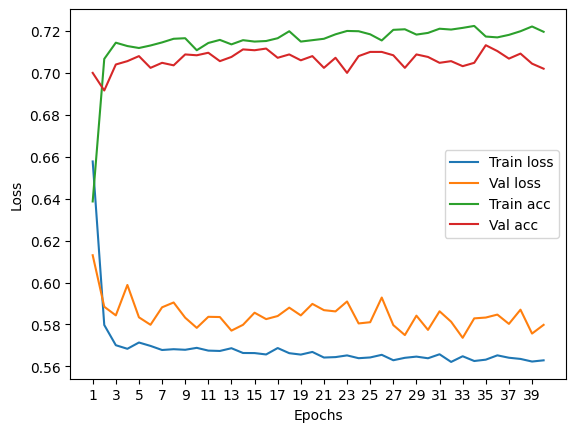

****************************************************************************************************



118it [00:00, 263.77it/s]


Train Epoch: 0 	Loss: 0.673466, Accuracy: 4609/7500 (61%)
Val Epoch: 0 	Loss: 0.624421, Accuracy: 1793/2500 (72%)



118it [00:00, 248.36it/s]


Train Epoch: 1 	Loss: 0.601441, Accuracy: 5215/7500 (70%)
Val Epoch: 1 	Loss: 0.574533, Accuracy: 1804/2500 (72%)



118it [00:00, 277.57it/s]


Train Epoch: 2 	Loss: 0.586635, Accuracy: 5234/7500 (70%)
Val Epoch: 2 	Loss: 0.567555, Accuracy: 1809/2500 (72%)



118it [00:00, 265.57it/s]


Train Epoch: 3 	Loss: 0.583515, Accuracy: 5236/7500 (70%)
Val Epoch: 3 	Loss: 0.569509, Accuracy: 1811/2500 (72%)



118it [00:00, 275.70it/s]


Train Epoch: 4 	Loss: 0.582879, Accuracy: 5248/7500 (70%)
Val Epoch: 4 	Loss: 0.582653, Accuracy: 1821/2500 (73%)



118it [00:00, 274.81it/s]


Train Epoch: 5 	Loss: 0.583581, Accuracy: 5268/7500 (70%)
Val Epoch: 5 	Loss: 0.574987, Accuracy: 1815/2500 (73%)



118it [00:00, 267.01it/s]


Train Epoch: 6 	Loss: 0.582905, Accuracy: 5280/7500 (70%)
Val Epoch: 6 	Loss: 0.560934, Accuracy: 1816/2500 (73%)



118it [00:00, 274.73it/s]


Train Epoch: 7 	Loss: 0.582193, Accuracy: 5288/7500 (71%)
Val Epoch: 7 	Loss: 0.568212, Accuracy: 1809/2500 (72%)



118it [00:00, 265.69it/s]


Train Epoch: 8 	Loss: 0.580945, Accuracy: 5274/7500 (70%)
Val Epoch: 8 	Loss: 0.564516, Accuracy: 1821/2500 (73%)



118it [00:00, 274.13it/s]


Train Epoch: 9 	Loss: 0.582166, Accuracy: 5248/7500 (70%)
Val Epoch: 9 	Loss: 0.565216, Accuracy: 1815/2500 (73%)



118it [00:00, 267.24it/s]


Train Epoch: 10 	Loss: 0.583120, Accuracy: 5242/7500 (70%)
Val Epoch: 10 	Loss: 0.565244, Accuracy: 1826/2500 (73%)



118it [00:00, 274.50it/s]


Train Epoch: 11 	Loss: 0.581902, Accuracy: 5227/7500 (70%)
Val Epoch: 11 	Loss: 0.574264, Accuracy: 1798/2500 (72%)



118it [00:00, 265.52it/s]


Train Epoch: 12 	Loss: 0.582084, Accuracy: 5245/7500 (70%)
Val Epoch: 12 	Loss: 0.577002, Accuracy: 1811/2500 (72%)



118it [00:00, 272.37it/s]


Train Epoch: 13 	Loss: 0.579974, Accuracy: 5245/7500 (70%)
Val Epoch: 13 	Loss: 0.578070, Accuracy: 1800/2500 (72%)



118it [00:00, 272.55it/s]


Train Epoch: 14 	Loss: 0.582049, Accuracy: 5235/7500 (70%)
Val Epoch: 14 	Loss: 0.571467, Accuracy: 1819/2500 (73%)



118it [00:00, 254.07it/s]


Train Epoch: 15 	Loss: 0.580295, Accuracy: 5281/7500 (70%)
Val Epoch: 15 	Loss: 0.564081, Accuracy: 1810/2500 (72%)



118it [00:00, 237.62it/s]


Train Epoch: 16 	Loss: 0.580874, Accuracy: 5251/7500 (70%)
Val Epoch: 16 	Loss: 0.572664, Accuracy: 1803/2500 (72%)



118it [00:00, 261.49it/s]


Train Epoch: 17 	Loss: 0.581115, Accuracy: 5258/7500 (70%)
Val Epoch: 17 	Loss: 0.562092, Accuracy: 1812/2500 (72%)



118it [00:00, 225.09it/s]


Train Epoch: 18 	Loss: 0.581211, Accuracy: 5253/7500 (70%)
Val Epoch: 18 	Loss: 0.571628, Accuracy: 1815/2500 (73%)



118it [00:00, 254.53it/s]


Train Epoch: 19 	Loss: 0.579539, Accuracy: 5279/7500 (70%)
Val Epoch: 19 	Loss: 0.571862, Accuracy: 1816/2500 (73%)



118it [00:00, 238.05it/s]


Train Epoch: 20 	Loss: 0.579132, Accuracy: 5275/7500 (70%)
Val Epoch: 20 	Loss: 0.566531, Accuracy: 1812/2500 (72%)



118it [00:00, 231.33it/s]


Train Epoch: 21 	Loss: 0.579991, Accuracy: 5252/7500 (70%)
Val Epoch: 21 	Loss: 0.564430, Accuracy: 1819/2500 (73%)



118it [00:00, 261.70it/s]


Train Epoch: 22 	Loss: 0.580384, Accuracy: 5271/7500 (70%)
Val Epoch: 22 	Loss: 0.572120, Accuracy: 1810/2500 (72%)



118it [00:00, 268.16it/s]


Train Epoch: 23 	Loss: 0.580871, Accuracy: 5272/7500 (70%)
Val Epoch: 23 	Loss: 0.567743, Accuracy: 1819/2500 (73%)



118it [00:00, 267.21it/s]


Train Epoch: 24 	Loss: 0.579902, Accuracy: 5297/7500 (71%)
Val Epoch: 24 	Loss: 0.569181, Accuracy: 1815/2500 (73%)



118it [00:00, 260.31it/s]


Train Epoch: 25 	Loss: 0.578701, Accuracy: 5249/7500 (70%)
Val Epoch: 25 	Loss: 0.575057, Accuracy: 1813/2500 (73%)



118it [00:00, 260.40it/s]


Train Epoch: 26 	Loss: 0.581767, Accuracy: 5264/7500 (70%)
Val Epoch: 26 	Loss: 0.561759, Accuracy: 1815/2500 (73%)



118it [00:00, 257.44it/s]


Train Epoch: 27 	Loss: 0.580151, Accuracy: 5266/7500 (70%)
Val Epoch: 27 	Loss: 0.568418, Accuracy: 1818/2500 (73%)



118it [00:00, 247.77it/s]


Train Epoch: 28 	Loss: 0.579809, Accuracy: 5250/7500 (70%)
Val Epoch: 28 	Loss: 0.570880, Accuracy: 1820/2500 (73%)



118it [00:00, 263.50it/s]


Train Epoch: 29 	Loss: 0.579349, Accuracy: 5249/7500 (70%)
Val Epoch: 29 	Loss: 0.559227, Accuracy: 1818/2500 (73%)



118it [00:00, 260.27it/s]


Train Epoch: 30 	Loss: 0.580154, Accuracy: 5257/7500 (70%)
Val Epoch: 30 	Loss: 0.567518, Accuracy: 1815/2500 (73%)



118it [00:00, 264.97it/s]


Train Epoch: 31 	Loss: 0.578039, Accuracy: 5284/7500 (70%)
Val Epoch: 31 	Loss: 0.570551, Accuracy: 1814/2500 (73%)



118it [00:00, 261.82it/s]


Train Epoch: 32 	Loss: 0.579166, Accuracy: 5261/7500 (70%)
Val Epoch: 32 	Loss: 0.564820, Accuracy: 1819/2500 (73%)



118it [00:00, 260.58it/s]


Train Epoch: 33 	Loss: 0.580352, Accuracy: 5261/7500 (70%)
Val Epoch: 33 	Loss: 0.575513, Accuracy: 1791/2500 (72%)



118it [00:00, 260.98it/s]


Train Epoch: 34 	Loss: 0.580491, Accuracy: 5284/7500 (70%)
Val Epoch: 34 	Loss: 0.570058, Accuracy: 1814/2500 (73%)



118it [00:00, 248.98it/s]


Train Epoch: 35 	Loss: 0.580749, Accuracy: 5256/7500 (70%)
Val Epoch: 35 	Loss: 0.585052, Accuracy: 1809/2500 (72%)



118it [00:00, 261.76it/s]


Train Epoch: 36 	Loss: 0.579645, Accuracy: 5269/7500 (70%)
Val Epoch: 36 	Loss: 0.565884, Accuracy: 1810/2500 (72%)



118it [00:00, 261.31it/s]


Train Epoch: 37 	Loss: 0.579917, Accuracy: 5263/7500 (70%)
Val Epoch: 37 	Loss: 0.577722, Accuracy: 1813/2500 (73%)



118it [00:00, 262.55it/s]


Train Epoch: 38 	Loss: 0.579056, Accuracy: 5268/7500 (70%)
Val Epoch: 38 	Loss: 0.569661, Accuracy: 1810/2500 (72%)



118it [00:00, 262.38it/s]


Train Epoch: 39 	Loss: 0.580696, Accuracy: 5252/7500 (70%)
Val Epoch: 39 	Loss: 0.559712, Accuracy: 1813/2500 (73%)

Test accuracy:  69.08


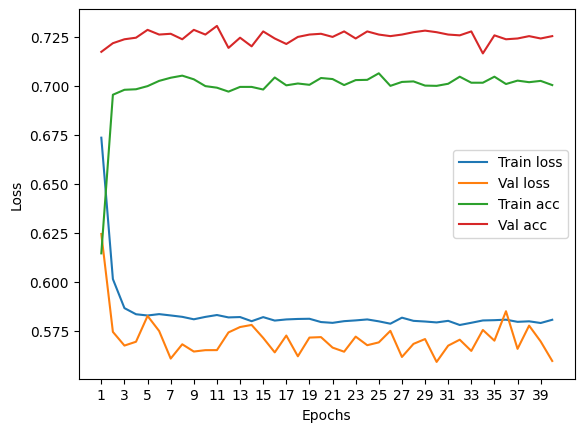

****************************************************************************************************



118it [00:00, 226.32it/s]


Train Epoch: 0 	Loss: 0.649124, Accuracy: 4709/7500 (63%)
Val Epoch: 0 	Loss: 0.605914, Accuracy: 1765/2500 (71%)



118it [00:00, 255.31it/s]


Train Epoch: 1 	Loss: 0.584156, Accuracy: 5240/7500 (70%)
Val Epoch: 1 	Loss: 0.609347, Accuracy: 1766/2500 (71%)



118it [00:00, 258.17it/s]


Train Epoch: 2 	Loss: 0.578003, Accuracy: 5268/7500 (70%)
Val Epoch: 2 	Loss: 0.586927, Accuracy: 1766/2500 (71%)



118it [00:00, 255.56it/s]


Train Epoch: 3 	Loss: 0.579358, Accuracy: 5278/7500 (70%)
Val Epoch: 3 	Loss: 0.589179, Accuracy: 1770/2500 (71%)



118it [00:00, 255.24it/s]


Train Epoch: 4 	Loss: 0.575943, Accuracy: 5273/7500 (70%)
Val Epoch: 4 	Loss: 0.604974, Accuracy: 1773/2500 (71%)



118it [00:00, 259.04it/s]


Train Epoch: 5 	Loss: 0.574977, Accuracy: 5274/7500 (70%)
Val Epoch: 5 	Loss: 0.591658, Accuracy: 1767/2500 (71%)



118it [00:00, 260.72it/s]


Train Epoch: 6 	Loss: 0.574159, Accuracy: 5310/7500 (71%)
Val Epoch: 6 	Loss: 0.592924, Accuracy: 1762/2500 (70%)



118it [00:00, 252.13it/s]


Train Epoch: 7 	Loss: 0.576409, Accuracy: 5301/7500 (71%)
Val Epoch: 7 	Loss: 0.593987, Accuracy: 1774/2500 (71%)



118it [00:00, 265.25it/s]


Train Epoch: 8 	Loss: 0.574163, Accuracy: 5292/7500 (71%)
Val Epoch: 8 	Loss: 0.586511, Accuracy: 1758/2500 (70%)



118it [00:00, 261.07it/s]


Train Epoch: 9 	Loss: 0.572961, Accuracy: 5288/7500 (71%)
Val Epoch: 9 	Loss: 0.586761, Accuracy: 1764/2500 (71%)



118it [00:00, 254.34it/s]


Train Epoch: 10 	Loss: 0.573994, Accuracy: 5295/7500 (71%)
Val Epoch: 10 	Loss: 0.585270, Accuracy: 1765/2500 (71%)



118it [00:00, 263.29it/s]


Train Epoch: 11 	Loss: 0.576198, Accuracy: 5278/7500 (70%)
Val Epoch: 11 	Loss: 0.591216, Accuracy: 1770/2500 (71%)



118it [00:00, 220.10it/s]


Train Epoch: 12 	Loss: 0.574368, Accuracy: 5292/7500 (71%)
Val Epoch: 12 	Loss: 0.590873, Accuracy: 1766/2500 (71%)



118it [00:00, 265.12it/s]


Train Epoch: 13 	Loss: 0.573969, Accuracy: 5288/7500 (71%)
Val Epoch: 13 	Loss: 0.596299, Accuracy: 1768/2500 (71%)



118it [00:00, 261.46it/s]


Train Epoch: 14 	Loss: 0.572291, Accuracy: 5281/7500 (70%)
Val Epoch: 14 	Loss: 0.596780, Accuracy: 1768/2500 (71%)



118it [00:00, 263.40it/s]


Train Epoch: 15 	Loss: 0.573203, Accuracy: 5289/7500 (71%)
Val Epoch: 15 	Loss: 0.594258, Accuracy: 1780/2500 (71%)



118it [00:00, 259.23it/s]


Train Epoch: 16 	Loss: 0.576392, Accuracy: 5277/7500 (70%)
Val Epoch: 16 	Loss: 0.590193, Accuracy: 1761/2500 (70%)



118it [00:00, 260.14it/s]


Train Epoch: 17 	Loss: 0.572862, Accuracy: 5298/7500 (71%)
Val Epoch: 17 	Loss: 0.590682, Accuracy: 1764/2500 (71%)



118it [00:00, 265.78it/s]


Train Epoch: 18 	Loss: 0.573727, Accuracy: 5299/7500 (71%)
Val Epoch: 18 	Loss: 0.606160, Accuracy: 1770/2500 (71%)



118it [00:00, 262.51it/s]


Train Epoch: 19 	Loss: 0.572176, Accuracy: 5294/7500 (71%)
Val Epoch: 19 	Loss: 0.591411, Accuracy: 1772/2500 (71%)



118it [00:00, 255.03it/s]


Train Epoch: 20 	Loss: 0.574130, Accuracy: 5292/7500 (71%)
Val Epoch: 20 	Loss: 0.595849, Accuracy: 1755/2500 (70%)



118it [00:00, 258.69it/s]


Train Epoch: 21 	Loss: 0.573332, Accuracy: 5293/7500 (71%)
Val Epoch: 21 	Loss: 0.593437, Accuracy: 1770/2500 (71%)



118it [00:00, 262.08it/s]


Train Epoch: 22 	Loss: 0.573877, Accuracy: 5276/7500 (70%)
Val Epoch: 22 	Loss: 0.594815, Accuracy: 1752/2500 (70%)



118it [00:00, 259.73it/s]


Train Epoch: 23 	Loss: 0.573764, Accuracy: 5306/7500 (71%)
Val Epoch: 23 	Loss: 0.590516, Accuracy: 1762/2500 (70%)



118it [00:00, 234.10it/s]


Train Epoch: 24 	Loss: 0.574208, Accuracy: 5303/7500 (71%)
Val Epoch: 24 	Loss: 0.594339, Accuracy: 1778/2500 (71%)



118it [00:00, 215.29it/s]


Train Epoch: 25 	Loss: 0.574149, Accuracy: 5280/7500 (70%)
Val Epoch: 25 	Loss: 0.589766, Accuracy: 1766/2500 (71%)



118it [00:00, 231.84it/s]


Train Epoch: 26 	Loss: 0.572887, Accuracy: 5309/7500 (71%)
Val Epoch: 26 	Loss: 0.586351, Accuracy: 1762/2500 (70%)



118it [00:00, 229.20it/s]


Train Epoch: 27 	Loss: 0.574105, Accuracy: 5291/7500 (71%)
Val Epoch: 27 	Loss: 0.605341, Accuracy: 1760/2500 (70%)



118it [00:00, 254.12it/s]


Train Epoch: 28 	Loss: 0.575216, Accuracy: 5298/7500 (71%)
Val Epoch: 28 	Loss: 0.591480, Accuracy: 1757/2500 (70%)



118it [00:00, 260.29it/s]


Train Epoch: 29 	Loss: 0.571862, Accuracy: 5301/7500 (71%)
Val Epoch: 29 	Loss: 0.591820, Accuracy: 1754/2500 (70%)



118it [00:00, 258.93it/s]


Train Epoch: 30 	Loss: 0.573383, Accuracy: 5277/7500 (70%)
Val Epoch: 30 	Loss: 0.586196, Accuracy: 1762/2500 (70%)



118it [00:00, 255.67it/s]


Train Epoch: 31 	Loss: 0.574809, Accuracy: 5305/7500 (71%)
Val Epoch: 31 	Loss: 0.589551, Accuracy: 1758/2500 (70%)



118it [00:00, 261.02it/s]


Train Epoch: 32 	Loss: 0.571323, Accuracy: 5306/7500 (71%)
Val Epoch: 32 	Loss: 0.593322, Accuracy: 1750/2500 (70%)



118it [00:00, 252.55it/s]


Train Epoch: 33 	Loss: 0.572066, Accuracy: 5310/7500 (71%)
Val Epoch: 33 	Loss: 0.598456, Accuracy: 1771/2500 (71%)



118it [00:00, 261.14it/s]


Train Epoch: 34 	Loss: 0.573041, Accuracy: 5276/7500 (70%)
Val Epoch: 34 	Loss: 0.590332, Accuracy: 1768/2500 (71%)



118it [00:00, 260.15it/s]


Train Epoch: 35 	Loss: 0.572758, Accuracy: 5322/7500 (71%)
Val Epoch: 35 	Loss: 0.609845, Accuracy: 1759/2500 (70%)



118it [00:00, 257.11it/s]


Train Epoch: 36 	Loss: 0.572281, Accuracy: 5305/7500 (71%)
Val Epoch: 36 	Loss: 0.599501, Accuracy: 1747/2500 (70%)



118it [00:00, 259.11it/s]


Train Epoch: 37 	Loss: 0.573004, Accuracy: 5299/7500 (71%)
Val Epoch: 37 	Loss: 0.596555, Accuracy: 1759/2500 (70%)



118it [00:00, 260.99it/s]


Train Epoch: 38 	Loss: 0.571976, Accuracy: 5277/7500 (70%)
Val Epoch: 38 	Loss: 0.594165, Accuracy: 1762/2500 (70%)



118it [00:00, 259.03it/s]


Train Epoch: 39 	Loss: 0.570377, Accuracy: 5297/7500 (71%)
Val Epoch: 39 	Loss: 0.599054, Accuracy: 1765/2500 (71%)

Test accuracy:  70.72


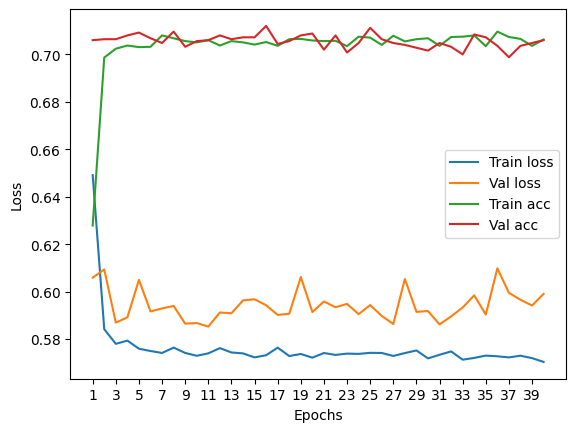

****************************************************************************************************



118it [00:00, 271.91it/s]


Train Epoch: 0 	Loss: 0.661268, Accuracy: 4752/7500 (63%)
Val Epoch: 0 	Loss: 0.620250, Accuracy: 1731/2500 (69%)



118it [00:00, 268.78it/s]


Train Epoch: 1 	Loss: 0.596594, Accuracy: 5175/7500 (69%)
Val Epoch: 1 	Loss: 0.597697, Accuracy: 1749/2500 (70%)



118it [00:00, 270.49it/s]


Train Epoch: 2 	Loss: 0.591592, Accuracy: 5224/7500 (70%)
Val Epoch: 2 	Loss: 0.596517, Accuracy: 1750/2500 (70%)



118it [00:00, 270.13it/s]


Train Epoch: 3 	Loss: 0.590456, Accuracy: 5204/7500 (69%)
Val Epoch: 3 	Loss: 0.584473, Accuracy: 1721/2500 (69%)



118it [00:00, 266.26it/s]


Train Epoch: 4 	Loss: 0.591515, Accuracy: 5213/7500 (70%)
Val Epoch: 4 	Loss: 0.593456, Accuracy: 1756/2500 (70%)



118it [00:00, 265.27it/s]


Train Epoch: 5 	Loss: 0.589624, Accuracy: 5217/7500 (70%)
Val Epoch: 5 	Loss: 0.584318, Accuracy: 1748/2500 (70%)



118it [00:00, 210.32it/s]


Train Epoch: 6 	Loss: 0.588782, Accuracy: 5230/7500 (70%)
Val Epoch: 6 	Loss: 0.587580, Accuracy: 1737/2500 (69%)



118it [00:00, 237.83it/s]


Train Epoch: 7 	Loss: 0.589225, Accuracy: 5229/7500 (70%)
Val Epoch: 7 	Loss: 0.586751, Accuracy: 1751/2500 (70%)



118it [00:00, 223.60it/s]


Train Epoch: 8 	Loss: 0.591018, Accuracy: 5238/7500 (70%)
Val Epoch: 8 	Loss: 0.597259, Accuracy: 1756/2500 (70%)



118it [00:00, 253.56it/s]


Train Epoch: 9 	Loss: 0.588716, Accuracy: 5211/7500 (69%)
Val Epoch: 9 	Loss: 0.584800, Accuracy: 1767/2500 (71%)



118it [00:00, 253.79it/s]


Train Epoch: 10 	Loss: 0.588787, Accuracy: 5215/7500 (70%)
Val Epoch: 10 	Loss: 0.587568, Accuracy: 1728/2500 (69%)



118it [00:00, 260.10it/s]


Train Epoch: 11 	Loss: 0.589796, Accuracy: 5217/7500 (70%)
Val Epoch: 11 	Loss: 0.585446, Accuracy: 1754/2500 (70%)



118it [00:00, 251.62it/s]


Train Epoch: 12 	Loss: 0.587751, Accuracy: 5249/7500 (70%)
Val Epoch: 12 	Loss: 0.590428, Accuracy: 1755/2500 (70%)



118it [00:00, 253.97it/s]


Train Epoch: 13 	Loss: 0.588899, Accuracy: 5232/7500 (70%)
Val Epoch: 13 	Loss: 0.584467, Accuracy: 1768/2500 (71%)



118it [00:00, 259.11it/s]


Train Epoch: 14 	Loss: 0.590030, Accuracy: 5241/7500 (70%)
Val Epoch: 14 	Loss: 0.590432, Accuracy: 1749/2500 (70%)



118it [00:00, 258.87it/s]


Train Epoch: 15 	Loss: 0.587828, Accuracy: 5215/7500 (70%)
Val Epoch: 15 	Loss: 0.595348, Accuracy: 1731/2500 (69%)



118it [00:00, 260.44it/s]


Train Epoch: 16 	Loss: 0.590955, Accuracy: 5221/7500 (70%)
Val Epoch: 16 	Loss: 0.590236, Accuracy: 1735/2500 (69%)



118it [00:00, 257.45it/s]


Train Epoch: 17 	Loss: 0.589065, Accuracy: 5224/7500 (70%)
Val Epoch: 17 	Loss: 0.589064, Accuracy: 1758/2500 (70%)



118it [00:00, 259.60it/s]


Train Epoch: 18 	Loss: 0.589694, Accuracy: 5188/7500 (69%)
Val Epoch: 18 	Loss: 0.589309, Accuracy: 1720/2500 (69%)



118it [00:00, 254.21it/s]


Train Epoch: 19 	Loss: 0.587171, Accuracy: 5217/7500 (70%)
Val Epoch: 19 	Loss: 0.586572, Accuracy: 1755/2500 (70%)



118it [00:00, 263.67it/s]


Train Epoch: 20 	Loss: 0.586567, Accuracy: 5227/7500 (70%)
Val Epoch: 20 	Loss: 0.590325, Accuracy: 1724/2500 (69%)



118it [00:00, 257.94it/s]


Train Epoch: 21 	Loss: 0.589428, Accuracy: 5227/7500 (70%)
Val Epoch: 21 	Loss: 0.590880, Accuracy: 1721/2500 (69%)



118it [00:00, 261.81it/s]


Train Epoch: 22 	Loss: 0.587625, Accuracy: 5235/7500 (70%)
Val Epoch: 22 	Loss: 0.601793, Accuracy: 1766/2500 (71%)



118it [00:00, 261.67it/s]


Train Epoch: 23 	Loss: 0.588555, Accuracy: 5231/7500 (70%)
Val Epoch: 23 	Loss: 0.583779, Accuracy: 1735/2500 (69%)



118it [00:00, 265.86it/s]


Train Epoch: 24 	Loss: 0.587012, Accuracy: 5241/7500 (70%)
Val Epoch: 24 	Loss: 0.591046, Accuracy: 1748/2500 (70%)



118it [00:00, 255.47it/s]


Train Epoch: 25 	Loss: 0.588332, Accuracy: 5213/7500 (70%)
Val Epoch: 25 	Loss: 0.588932, Accuracy: 1754/2500 (70%)



118it [00:00, 263.97it/s]


Train Epoch: 26 	Loss: 0.587793, Accuracy: 5238/7500 (70%)
Val Epoch: 26 	Loss: 0.585584, Accuracy: 1759/2500 (70%)



118it [00:00, 257.75it/s]


Train Epoch: 27 	Loss: 0.587218, Accuracy: 5247/7500 (70%)
Val Epoch: 27 	Loss: 0.588555, Accuracy: 1763/2500 (71%)



118it [00:00, 251.37it/s]


Train Epoch: 28 	Loss: 0.584976, Accuracy: 5236/7500 (70%)
Val Epoch: 28 	Loss: 0.584474, Accuracy: 1754/2500 (70%)



118it [00:00, 268.85it/s]


Train Epoch: 29 	Loss: 0.584090, Accuracy: 5228/7500 (70%)
Val Epoch: 29 	Loss: 0.586927, Accuracy: 1762/2500 (70%)



118it [00:00, 264.03it/s]


Train Epoch: 30 	Loss: 0.584698, Accuracy: 5227/7500 (70%)
Val Epoch: 30 	Loss: 0.594097, Accuracy: 1731/2500 (69%)



118it [00:00, 263.23it/s]


Train Epoch: 31 	Loss: 0.585250, Accuracy: 5249/7500 (70%)
Val Epoch: 31 	Loss: 0.584504, Accuracy: 1762/2500 (70%)



118it [00:00, 229.35it/s]


Train Epoch: 32 	Loss: 0.584293, Accuracy: 5258/7500 (70%)
Val Epoch: 32 	Loss: 0.584569, Accuracy: 1763/2500 (71%)



118it [00:00, 203.89it/s]


Train Epoch: 33 	Loss: 0.583727, Accuracy: 5234/7500 (70%)
Val Epoch: 33 	Loss: 0.586328, Accuracy: 1754/2500 (70%)



118it [00:00, 241.43it/s]


Train Epoch: 34 	Loss: 0.583108, Accuracy: 5257/7500 (70%)
Val Epoch: 34 	Loss: 0.584789, Accuracy: 1757/2500 (70%)



118it [00:00, 187.98it/s]


Train Epoch: 35 	Loss: 0.583311, Accuracy: 5252/7500 (70%)
Val Epoch: 35 	Loss: 0.584972, Accuracy: 1758/2500 (70%)



118it [00:00, 258.62it/s]


Train Epoch: 36 	Loss: 0.585483, Accuracy: 5269/7500 (70%)
Val Epoch: 36 	Loss: 0.578694, Accuracy: 1750/2500 (70%)



118it [00:00, 255.42it/s]


Train Epoch: 37 	Loss: 0.583281, Accuracy: 5237/7500 (70%)
Val Epoch: 37 	Loss: 0.575578, Accuracy: 1761/2500 (70%)



118it [00:00, 245.88it/s]


Train Epoch: 38 	Loss: 0.585178, Accuracy: 5284/7500 (70%)
Val Epoch: 38 	Loss: 0.591080, Accuracy: 1750/2500 (70%)



118it [00:00, 260.00it/s]


Train Epoch: 39 	Loss: 0.583883, Accuracy: 5237/7500 (70%)
Val Epoch: 39 	Loss: 0.584564, Accuracy: 1765/2500 (71%)

Test accuracy:  70.84


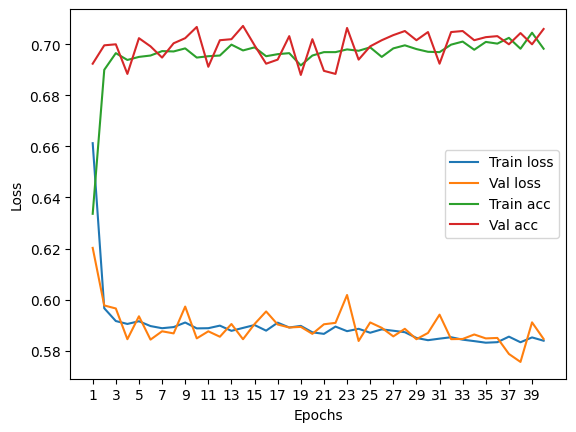

****************************************************************************************************



118it [00:00, 263.29it/s]


Train Epoch: 0 	Loss: 0.660333, Accuracy: 4685/7500 (62%)
Val Epoch: 0 	Loss: 0.619385, Accuracy: 1743/2500 (70%)



118it [00:00, 264.33it/s]


Train Epoch: 1 	Loss: 0.592892, Accuracy: 5223/7500 (70%)
Val Epoch: 1 	Loss: 0.596889, Accuracy: 1752/2500 (70%)



118it [00:00, 258.93it/s]


Train Epoch: 2 	Loss: 0.585454, Accuracy: 5261/7500 (70%)
Val Epoch: 2 	Loss: 0.587609, Accuracy: 1754/2500 (70%)



118it [00:00, 256.83it/s]


Train Epoch: 3 	Loss: 0.583418, Accuracy: 5267/7500 (70%)
Val Epoch: 3 	Loss: 0.589423, Accuracy: 1748/2500 (70%)



118it [00:00, 260.10it/s]


Train Epoch: 4 	Loss: 0.582723, Accuracy: 5265/7500 (70%)
Val Epoch: 4 	Loss: 0.583765, Accuracy: 1751/2500 (70%)



118it [00:00, 260.34it/s]


Train Epoch: 5 	Loss: 0.583300, Accuracy: 5251/7500 (70%)
Val Epoch: 5 	Loss: 0.592467, Accuracy: 1758/2500 (70%)



118it [00:00, 256.84it/s]


Train Epoch: 6 	Loss: 0.585055, Accuracy: 5268/7500 (70%)
Val Epoch: 6 	Loss: 0.584125, Accuracy: 1757/2500 (70%)



118it [00:00, 259.79it/s]


Train Epoch: 7 	Loss: 0.583626, Accuracy: 5270/7500 (70%)
Val Epoch: 7 	Loss: 0.592060, Accuracy: 1764/2500 (71%)



118it [00:00, 256.65it/s]


Train Epoch: 8 	Loss: 0.580638, Accuracy: 5263/7500 (70%)
Val Epoch: 8 	Loss: 0.589187, Accuracy: 1752/2500 (70%)



118it [00:00, 260.09it/s]


Train Epoch: 9 	Loss: 0.580071, Accuracy: 5277/7500 (70%)
Val Epoch: 9 	Loss: 0.587397, Accuracy: 1746/2500 (70%)



118it [00:00, 256.99it/s]


Train Epoch: 10 	Loss: 0.579610, Accuracy: 5271/7500 (70%)
Val Epoch: 10 	Loss: 0.589027, Accuracy: 1742/2500 (70%)



118it [00:00, 254.19it/s]


Train Epoch: 11 	Loss: 0.579487, Accuracy: 5302/7500 (71%)
Val Epoch: 11 	Loss: 0.583864, Accuracy: 1753/2500 (70%)



118it [00:00, 256.24it/s]


Train Epoch: 12 	Loss: 0.581319, Accuracy: 5257/7500 (70%)
Val Epoch: 12 	Loss: 0.600561, Accuracy: 1747/2500 (70%)



118it [00:00, 259.50it/s]


Train Epoch: 13 	Loss: 0.581389, Accuracy: 5301/7500 (71%)
Val Epoch: 13 	Loss: 0.584711, Accuracy: 1745/2500 (70%)



118it [00:00, 198.98it/s]


Train Epoch: 14 	Loss: 0.579924, Accuracy: 5276/7500 (70%)
Val Epoch: 14 	Loss: 0.585690, Accuracy: 1759/2500 (70%)



118it [00:00, 232.11it/s]


Train Epoch: 15 	Loss: 0.580584, Accuracy: 5277/7500 (70%)
Val Epoch: 15 	Loss: 0.587868, Accuracy: 1747/2500 (70%)



118it [00:00, 218.22it/s]


Train Epoch: 16 	Loss: 0.580647, Accuracy: 5294/7500 (71%)
Val Epoch: 16 	Loss: 0.597256, Accuracy: 1744/2500 (70%)



118it [00:00, 244.62it/s]


Train Epoch: 17 	Loss: 0.578025, Accuracy: 5317/7500 (71%)
Val Epoch: 17 	Loss: 0.593063, Accuracy: 1753/2500 (70%)



118it [00:00, 257.10it/s]


Train Epoch: 18 	Loss: 0.581106, Accuracy: 5294/7500 (71%)
Val Epoch: 18 	Loss: 0.586802, Accuracy: 1738/2500 (70%)



118it [00:00, 259.00it/s]


Train Epoch: 19 	Loss: 0.578952, Accuracy: 5274/7500 (70%)
Val Epoch: 19 	Loss: 0.605893, Accuracy: 1738/2500 (70%)



118it [00:00, 261.40it/s]


Train Epoch: 20 	Loss: 0.583118, Accuracy: 5300/7500 (71%)
Val Epoch: 20 	Loss: 0.591234, Accuracy: 1743/2500 (70%)



118it [00:00, 258.50it/s]


Train Epoch: 21 	Loss: 0.580678, Accuracy: 5290/7500 (71%)
Val Epoch: 21 	Loss: 0.591322, Accuracy: 1745/2500 (70%)



118it [00:00, 259.16it/s]


Train Epoch: 22 	Loss: 0.577973, Accuracy: 5321/7500 (71%)
Val Epoch: 22 	Loss: 0.581706, Accuracy: 1756/2500 (70%)



118it [00:00, 256.71it/s]


Train Epoch: 23 	Loss: 0.579132, Accuracy: 5282/7500 (70%)
Val Epoch: 23 	Loss: 0.594335, Accuracy: 1748/2500 (70%)



118it [00:00, 257.96it/s]


Train Epoch: 24 	Loss: 0.578538, Accuracy: 5272/7500 (70%)
Val Epoch: 24 	Loss: 0.597384, Accuracy: 1735/2500 (69%)



118it [00:00, 261.49it/s]


Train Epoch: 25 	Loss: 0.578830, Accuracy: 5291/7500 (71%)
Val Epoch: 25 	Loss: 0.582640, Accuracy: 1744/2500 (70%)



118it [00:00, 251.92it/s]


Train Epoch: 26 	Loss: 0.579610, Accuracy: 5314/7500 (71%)
Val Epoch: 26 	Loss: 0.594417, Accuracy: 1738/2500 (70%)



118it [00:00, 256.91it/s]


Train Epoch: 27 	Loss: 0.581275, Accuracy: 5275/7500 (70%)
Val Epoch: 27 	Loss: 0.596487, Accuracy: 1745/2500 (70%)



118it [00:00, 260.07it/s]


Train Epoch: 28 	Loss: 0.579294, Accuracy: 5284/7500 (70%)
Val Epoch: 28 	Loss: 0.589051, Accuracy: 1746/2500 (70%)



118it [00:00, 258.71it/s]


Train Epoch: 29 	Loss: 0.577308, Accuracy: 5305/7500 (71%)
Val Epoch: 29 	Loss: 0.595589, Accuracy: 1741/2500 (70%)



118it [00:00, 258.43it/s]


Train Epoch: 30 	Loss: 0.579007, Accuracy: 5287/7500 (70%)
Val Epoch: 30 	Loss: 0.586819, Accuracy: 1752/2500 (70%)



118it [00:00, 257.18it/s]


Train Epoch: 31 	Loss: 0.578456, Accuracy: 5290/7500 (71%)
Val Epoch: 31 	Loss: 0.588835, Accuracy: 1745/2500 (70%)



118it [00:00, 250.21it/s]


Train Epoch: 32 	Loss: 0.580032, Accuracy: 5278/7500 (70%)
Val Epoch: 32 	Loss: 0.597297, Accuracy: 1741/2500 (70%)



118it [00:00, 260.15it/s]


Train Epoch: 33 	Loss: 0.578218, Accuracy: 5308/7500 (71%)
Val Epoch: 33 	Loss: 0.594232, Accuracy: 1750/2500 (70%)



118it [00:00, 260.35it/s]


Train Epoch: 34 	Loss: 0.581155, Accuracy: 5306/7500 (71%)
Val Epoch: 34 	Loss: 0.581477, Accuracy: 1747/2500 (70%)



118it [00:00, 255.27it/s]


Train Epoch: 35 	Loss: 0.579664, Accuracy: 5287/7500 (70%)
Val Epoch: 35 	Loss: 0.588090, Accuracy: 1749/2500 (70%)



118it [00:00, 255.90it/s]


Train Epoch: 36 	Loss: 0.578353, Accuracy: 5318/7500 (71%)
Val Epoch: 36 	Loss: 0.590490, Accuracy: 1750/2500 (70%)



118it [00:00, 254.03it/s]


Train Epoch: 37 	Loss: 0.579835, Accuracy: 5288/7500 (71%)
Val Epoch: 37 	Loss: 0.599523, Accuracy: 1750/2500 (70%)



118it [00:00, 258.80it/s]


Train Epoch: 38 	Loss: 0.578672, Accuracy: 5307/7500 (71%)
Val Epoch: 38 	Loss: 0.591547, Accuracy: 1744/2500 (70%)



118it [00:00, 254.56it/s]


Train Epoch: 39 	Loss: 0.578129, Accuracy: 5287/7500 (70%)
Val Epoch: 39 	Loss: 0.593792, Accuracy: 1744/2500 (70%)

Test accuracy:  70.96000000000001


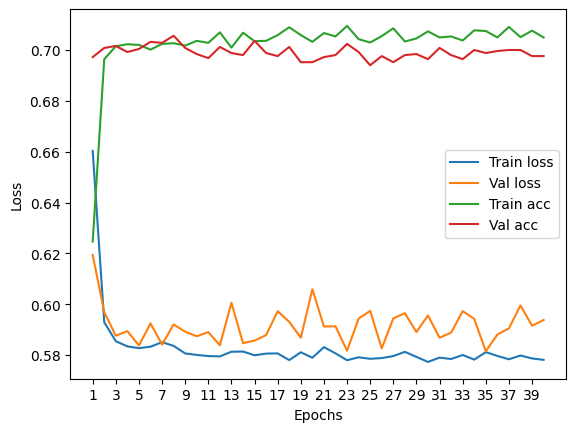

****************************************************************************************************



116it [00:00, 259.02it/s]


Train Epoch: 0 	Loss: 0.646524, Accuracy: 4722/7422 (64%)
Val Epoch: 0 	Loss: 0.607110, Accuracy: 1696/2474 (69%)



116it [00:00, 254.22it/s]


Train Epoch: 1 	Loss: 0.586829, Accuracy: 5177/7422 (70%)
Val Epoch: 1 	Loss: 0.590586, Accuracy: 1702/2474 (69%)



116it [00:00, 257.19it/s]


Train Epoch: 2 	Loss: 0.581651, Accuracy: 5194/7422 (70%)
Val Epoch: 2 	Loss: 0.586469, Accuracy: 1724/2474 (70%)



116it [00:00, 251.90it/s]


Train Epoch: 3 	Loss: 0.580342, Accuracy: 5216/7422 (70%)
Val Epoch: 3 	Loss: 0.595751, Accuracy: 1717/2474 (69%)



116it [00:00, 254.11it/s]


Train Epoch: 4 	Loss: 0.577600, Accuracy: 5206/7422 (70%)
Val Epoch: 4 	Loss: 0.587634, Accuracy: 1695/2474 (69%)



116it [00:00, 250.59it/s]


Train Epoch: 5 	Loss: 0.576780, Accuracy: 5230/7422 (70%)
Val Epoch: 5 	Loss: 0.588484, Accuracy: 1708/2474 (69%)



116it [00:00, 259.73it/s]


Train Epoch: 6 	Loss: 0.575303, Accuracy: 5226/7422 (70%)
Val Epoch: 6 	Loss: 0.587847, Accuracy: 1696/2474 (69%)



116it [00:00, 247.91it/s]


Train Epoch: 7 	Loss: 0.575709, Accuracy: 5243/7422 (71%)
Val Epoch: 7 	Loss: 0.587459, Accuracy: 1704/2474 (69%)



116it [00:00, 246.55it/s]


Train Epoch: 8 	Loss: 0.575908, Accuracy: 5217/7422 (70%)
Val Epoch: 8 	Loss: 0.589628, Accuracy: 1706/2474 (69%)



116it [00:00, 257.13it/s]


Train Epoch: 9 	Loss: 0.575375, Accuracy: 5231/7422 (70%)
Val Epoch: 9 	Loss: 0.585204, Accuracy: 1709/2474 (69%)



116it [00:00, 252.82it/s]


Train Epoch: 10 	Loss: 0.577009, Accuracy: 5215/7422 (70%)
Val Epoch: 10 	Loss: 0.597786, Accuracy: 1697/2474 (69%)



116it [00:00, 258.73it/s]


Train Epoch: 11 	Loss: 0.575465, Accuracy: 5222/7422 (70%)
Val Epoch: 11 	Loss: 0.586034, Accuracy: 1700/2474 (69%)



116it [00:00, 256.16it/s]


Train Epoch: 12 	Loss: 0.575341, Accuracy: 5223/7422 (70%)
Val Epoch: 12 	Loss: 0.588679, Accuracy: 1700/2474 (69%)



116it [00:00, 254.86it/s]


Train Epoch: 13 	Loss: 0.573657, Accuracy: 5252/7422 (71%)
Val Epoch: 13 	Loss: 0.588028, Accuracy: 1712/2474 (69%)



116it [00:00, 249.76it/s]


Train Epoch: 14 	Loss: 0.575450, Accuracy: 5241/7422 (71%)
Val Epoch: 14 	Loss: 0.586841, Accuracy: 1702/2474 (69%)



116it [00:00, 254.77it/s]


Train Epoch: 15 	Loss: 0.575850, Accuracy: 5233/7422 (71%)
Val Epoch: 15 	Loss: 0.587097, Accuracy: 1703/2474 (69%)



116it [00:00, 255.66it/s]


Train Epoch: 16 	Loss: 0.575200, Accuracy: 5222/7422 (70%)
Val Epoch: 16 	Loss: 0.587235, Accuracy: 1696/2474 (69%)



116it [00:00, 255.34it/s]


Train Epoch: 17 	Loss: 0.575298, Accuracy: 5238/7422 (71%)
Val Epoch: 17 	Loss: 0.589270, Accuracy: 1712/2474 (69%)



116it [00:00, 250.73it/s]


Train Epoch: 18 	Loss: 0.576574, Accuracy: 5201/7422 (70%)
Val Epoch: 18 	Loss: 0.587093, Accuracy: 1697/2474 (69%)



116it [00:00, 257.14it/s]


Train Epoch: 19 	Loss: 0.577029, Accuracy: 5224/7422 (70%)
Val Epoch: 19 	Loss: 0.585899, Accuracy: 1702/2474 (69%)



116it [00:00, 248.95it/s]


Train Epoch: 20 	Loss: 0.574784, Accuracy: 5228/7422 (70%)
Val Epoch: 20 	Loss: 0.586058, Accuracy: 1707/2474 (69%)



116it [00:00, 254.23it/s]


Train Epoch: 21 	Loss: 0.574508, Accuracy: 5224/7422 (70%)
Val Epoch: 21 	Loss: 0.590530, Accuracy: 1694/2474 (68%)



116it [00:00, 191.86it/s]


Train Epoch: 22 	Loss: 0.576575, Accuracy: 5233/7422 (71%)
Val Epoch: 22 	Loss: 0.586663, Accuracy: 1705/2474 (69%)



116it [00:00, 215.59it/s]


Train Epoch: 23 	Loss: 0.576233, Accuracy: 5226/7422 (70%)
Val Epoch: 23 	Loss: 0.595898, Accuracy: 1706/2474 (69%)



116it [00:00, 227.92it/s]


Train Epoch: 24 	Loss: 0.574627, Accuracy: 5264/7422 (71%)
Val Epoch: 24 	Loss: 0.587785, Accuracy: 1699/2474 (69%)



116it [00:00, 234.35it/s]


Train Epoch: 25 	Loss: 0.574425, Accuracy: 5237/7422 (71%)
Val Epoch: 25 	Loss: 0.591357, Accuracy: 1700/2474 (69%)



116it [00:00, 253.87it/s]


Train Epoch: 26 	Loss: 0.575815, Accuracy: 5237/7422 (71%)
Val Epoch: 26 	Loss: 0.588245, Accuracy: 1691/2474 (68%)



116it [00:00, 254.36it/s]


Train Epoch: 27 	Loss: 0.574327, Accuracy: 5222/7422 (70%)
Val Epoch: 27 	Loss: 0.588251, Accuracy: 1709/2474 (69%)



116it [00:00, 252.00it/s]


Train Epoch: 28 	Loss: 0.575019, Accuracy: 5227/7422 (70%)
Val Epoch: 28 	Loss: 0.586167, Accuracy: 1703/2474 (69%)



116it [00:00, 254.10it/s]


Train Epoch: 29 	Loss: 0.573689, Accuracy: 5230/7422 (70%)
Val Epoch: 29 	Loss: 0.587409, Accuracy: 1701/2474 (69%)



116it [00:00, 240.33it/s]


Train Epoch: 30 	Loss: 0.574270, Accuracy: 5253/7422 (71%)
Val Epoch: 30 	Loss: 0.591544, Accuracy: 1690/2474 (68%)



116it [00:00, 257.11it/s]


Train Epoch: 31 	Loss: 0.575746, Accuracy: 5226/7422 (70%)
Val Epoch: 31 	Loss: 0.586660, Accuracy: 1707/2474 (69%)



116it [00:00, 255.62it/s]


Train Epoch: 32 	Loss: 0.575817, Accuracy: 5215/7422 (70%)
Val Epoch: 32 	Loss: 0.593042, Accuracy: 1702/2474 (69%)



116it [00:00, 258.87it/s]


Train Epoch: 33 	Loss: 0.576273, Accuracy: 5217/7422 (70%)
Val Epoch: 33 	Loss: 0.587894, Accuracy: 1704/2474 (69%)



116it [00:00, 254.24it/s]


Train Epoch: 34 	Loss: 0.575031, Accuracy: 5237/7422 (71%)
Val Epoch: 34 	Loss: 0.588175, Accuracy: 1705/2474 (69%)



116it [00:00, 255.30it/s]


Train Epoch: 35 	Loss: 0.573541, Accuracy: 5264/7422 (71%)
Val Epoch: 35 	Loss: 0.590673, Accuracy: 1693/2474 (68%)



116it [00:00, 252.43it/s]


Train Epoch: 36 	Loss: 0.574312, Accuracy: 5226/7422 (70%)
Val Epoch: 36 	Loss: 0.590040, Accuracy: 1698/2474 (69%)



116it [00:00, 205.84it/s]


Train Epoch: 37 	Loss: 0.575143, Accuracy: 5232/7422 (70%)
Val Epoch: 37 	Loss: 0.588426, Accuracy: 1704/2474 (69%)



116it [00:00, 215.90it/s]


Train Epoch: 38 	Loss: 0.574238, Accuracy: 5248/7422 (71%)
Val Epoch: 38 	Loss: 0.588004, Accuracy: 1690/2474 (68%)



116it [00:00, 211.64it/s]


Train Epoch: 39 	Loss: 0.574188, Accuracy: 5230/7422 (70%)
Val Epoch: 39 	Loss: 0.597455, Accuracy: 1709/2474 (69%)

Test accuracy:  70.25060630557802


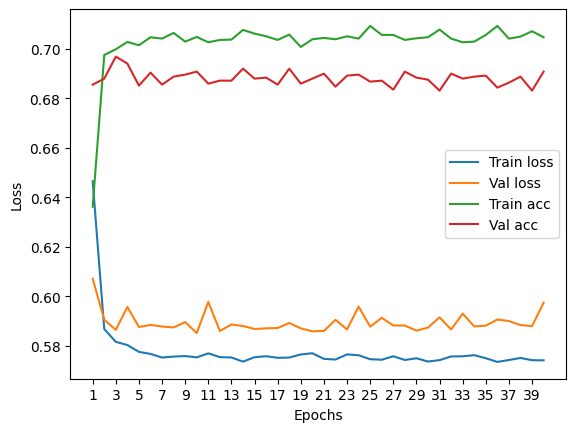

****************************************************************************************************



Particles per jet: 2


118it [00:00, 225.30it/s]


Train Epoch: 0 	Loss: 0.670978, Accuracy: 4481/7500 (60%)
Val Epoch: 0 	Loss: 0.625244, Accuracy: 1727/2500 (69%)



118it [00:00, 183.60it/s]


Train Epoch: 1 	Loss: 0.577092, Accuracy: 5351/7500 (71%)
Val Epoch: 1 	Loss: 0.563226, Accuracy: 1833/2500 (73%)



118it [00:00, 199.11it/s]


Train Epoch: 2 	Loss: 0.557867, Accuracy: 5418/7500 (72%)
Val Epoch: 2 	Loss: 0.566538, Accuracy: 1825/2500 (73%)



118it [00:00, 188.20it/s]


Train Epoch: 3 	Loss: 0.557701, Accuracy: 5393/7500 (72%)
Val Epoch: 3 	Loss: 0.554657, Accuracy: 1853/2500 (74%)



118it [00:00, 243.35it/s]


Train Epoch: 4 	Loss: 0.554530, Accuracy: 5432/7500 (72%)
Val Epoch: 4 	Loss: 0.565841, Accuracy: 1820/2500 (73%)



118it [00:00, 248.33it/s]


Train Epoch: 5 	Loss: 0.557333, Accuracy: 5414/7500 (72%)
Val Epoch: 5 	Loss: 0.556381, Accuracy: 1845/2500 (74%)



118it [00:00, 246.42it/s]


Train Epoch: 6 	Loss: 0.555976, Accuracy: 5442/7500 (73%)
Val Epoch: 6 	Loss: 0.542965, Accuracy: 1858/2500 (74%)



118it [00:00, 242.80it/s]


Train Epoch: 7 	Loss: 0.555756, Accuracy: 5446/7500 (73%)
Val Epoch: 7 	Loss: 0.546034, Accuracy: 1858/2500 (74%)



118it [00:00, 242.22it/s]


Train Epoch: 8 	Loss: 0.556146, Accuracy: 5414/7500 (72%)
Val Epoch: 8 	Loss: 0.572639, Accuracy: 1820/2500 (73%)



118it [00:00, 245.50it/s]


Train Epoch: 9 	Loss: 0.553534, Accuracy: 5463/7500 (73%)
Val Epoch: 9 	Loss: 0.561228, Accuracy: 1833/2500 (73%)



118it [00:00, 242.43it/s]


Train Epoch: 10 	Loss: 0.553435, Accuracy: 5432/7500 (72%)
Val Epoch: 10 	Loss: 0.542709, Accuracy: 1841/2500 (74%)



118it [00:00, 246.84it/s]


Train Epoch: 11 	Loss: 0.553456, Accuracy: 5432/7500 (72%)
Val Epoch: 11 	Loss: 0.548860, Accuracy: 1842/2500 (74%)



118it [00:00, 246.20it/s]


Train Epoch: 12 	Loss: 0.553449, Accuracy: 5417/7500 (72%)
Val Epoch: 12 	Loss: 0.559141, Accuracy: 1841/2500 (74%)



118it [00:00, 241.82it/s]


Train Epoch: 13 	Loss: 0.554058, Accuracy: 5440/7500 (73%)
Val Epoch: 13 	Loss: 0.548198, Accuracy: 1845/2500 (74%)



118it [00:00, 247.54it/s]


Train Epoch: 14 	Loss: 0.554359, Accuracy: 5425/7500 (72%)
Val Epoch: 14 	Loss: 0.554345, Accuracy: 1834/2500 (73%)



118it [00:00, 246.68it/s]


Train Epoch: 15 	Loss: 0.553207, Accuracy: 5430/7500 (72%)
Val Epoch: 15 	Loss: 0.553483, Accuracy: 1842/2500 (74%)



118it [00:00, 246.85it/s]


Train Epoch: 16 	Loss: 0.550006, Accuracy: 5464/7500 (73%)
Val Epoch: 16 	Loss: 0.548277, Accuracy: 1858/2500 (74%)



118it [00:00, 239.47it/s]


Train Epoch: 17 	Loss: 0.552023, Accuracy: 5469/7500 (73%)
Val Epoch: 17 	Loss: 0.565838, Accuracy: 1834/2500 (73%)



118it [00:00, 249.26it/s]


Train Epoch: 18 	Loss: 0.553547, Accuracy: 5458/7500 (73%)
Val Epoch: 18 	Loss: 0.544774, Accuracy: 1858/2500 (74%)



118it [00:00, 248.00it/s]


Train Epoch: 19 	Loss: 0.552824, Accuracy: 5463/7500 (73%)
Val Epoch: 19 	Loss: 0.545421, Accuracy: 1866/2500 (75%)



118it [00:00, 240.81it/s]


Train Epoch: 20 	Loss: 0.551043, Accuracy: 5458/7500 (73%)
Val Epoch: 20 	Loss: 0.546852, Accuracy: 1842/2500 (74%)



118it [00:00, 243.27it/s]


Train Epoch: 21 	Loss: 0.550202, Accuracy: 5452/7500 (73%)
Val Epoch: 21 	Loss: 0.550485, Accuracy: 1851/2500 (74%)



118it [00:00, 244.68it/s]


Train Epoch: 22 	Loss: 0.553516, Accuracy: 5438/7500 (73%)
Val Epoch: 22 	Loss: 0.547453, Accuracy: 1851/2500 (74%)



118it [00:00, 230.70it/s]


Train Epoch: 23 	Loss: 0.551412, Accuracy: 5446/7500 (73%)
Val Epoch: 23 	Loss: 0.555596, Accuracy: 1854/2500 (74%)



118it [00:00, 188.37it/s]


Train Epoch: 24 	Loss: 0.550507, Accuracy: 5438/7500 (73%)
Val Epoch: 24 	Loss: 0.564364, Accuracy: 1819/2500 (73%)



118it [00:00, 234.87it/s]


Train Epoch: 25 	Loss: 0.551788, Accuracy: 5453/7500 (73%)
Val Epoch: 25 	Loss: 0.557143, Accuracy: 1835/2500 (73%)



118it [00:00, 199.48it/s]


Train Epoch: 26 	Loss: 0.550683, Accuracy: 5434/7500 (72%)
Val Epoch: 26 	Loss: 0.554817, Accuracy: 1850/2500 (74%)



118it [00:00, 227.38it/s]


Train Epoch: 27 	Loss: 0.549533, Accuracy: 5462/7500 (73%)
Val Epoch: 27 	Loss: 0.554976, Accuracy: 1850/2500 (74%)



118it [00:00, 248.42it/s]


Train Epoch: 28 	Loss: 0.551520, Accuracy: 5437/7500 (72%)
Val Epoch: 28 	Loss: 0.553103, Accuracy: 1839/2500 (74%)



118it [00:00, 239.63it/s]


Train Epoch: 29 	Loss: 0.550515, Accuracy: 5457/7500 (73%)
Val Epoch: 29 	Loss: 0.546034, Accuracy: 1851/2500 (74%)



118it [00:00, 248.50it/s]


Train Epoch: 30 	Loss: 0.549904, Accuracy: 5447/7500 (73%)
Val Epoch: 30 	Loss: 0.565156, Accuracy: 1842/2500 (74%)



118it [00:00, 239.89it/s]


Train Epoch: 31 	Loss: 0.548614, Accuracy: 5467/7500 (73%)
Val Epoch: 31 	Loss: 0.548135, Accuracy: 1859/2500 (74%)



118it [00:00, 213.87it/s]


Train Epoch: 32 	Loss: 0.551465, Accuracy: 5437/7500 (72%)
Val Epoch: 32 	Loss: 0.551580, Accuracy: 1847/2500 (74%)



118it [00:00, 221.88it/s]


Train Epoch: 33 	Loss: 0.551260, Accuracy: 5432/7500 (72%)
Val Epoch: 33 	Loss: 0.553651, Accuracy: 1846/2500 (74%)



118it [00:00, 244.24it/s]


Train Epoch: 34 	Loss: 0.552112, Accuracy: 5430/7500 (72%)
Val Epoch: 34 	Loss: 0.557226, Accuracy: 1849/2500 (74%)



118it [00:00, 243.25it/s]


Train Epoch: 35 	Loss: 0.550027, Accuracy: 5452/7500 (73%)
Val Epoch: 35 	Loss: 0.553346, Accuracy: 1848/2500 (74%)



118it [00:00, 245.65it/s]


Train Epoch: 36 	Loss: 0.551196, Accuracy: 5452/7500 (73%)
Val Epoch: 36 	Loss: 0.544073, Accuracy: 1849/2500 (74%)



118it [00:00, 244.66it/s]


Train Epoch: 37 	Loss: 0.549890, Accuracy: 5443/7500 (73%)
Val Epoch: 37 	Loss: 0.553963, Accuracy: 1852/2500 (74%)



118it [00:00, 247.40it/s]


Train Epoch: 38 	Loss: 0.550067, Accuracy: 5491/7500 (73%)
Val Epoch: 38 	Loss: 0.557948, Accuracy: 1859/2500 (74%)



118it [00:00, 242.38it/s]


Train Epoch: 39 	Loss: 0.550524, Accuracy: 5445/7500 (73%)
Val Epoch: 39 	Loss: 0.558815, Accuracy: 1850/2500 (74%)

Test accuracy:  73.11999999999999


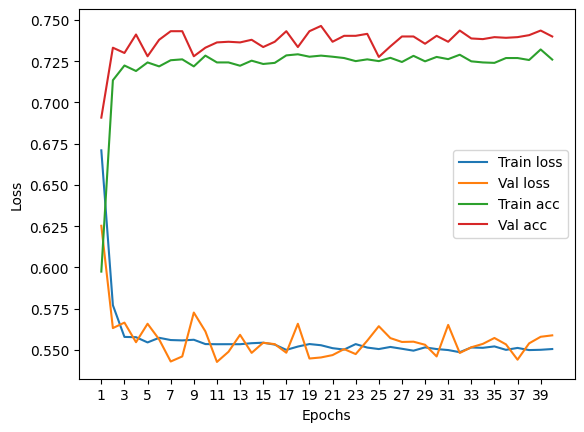

****************************************************************************************************



118it [00:00, 200.15it/s]


Train Epoch: 0 	Loss: 0.662106, Accuracy: 4721/7500 (63%)
Val Epoch: 0 	Loss: 0.622293, Accuracy: 1751/2500 (70%)



118it [00:00, 207.76it/s]


Train Epoch: 1 	Loss: 0.580815, Accuracy: 5333/7500 (71%)
Val Epoch: 1 	Loss: 0.582553, Accuracy: 1778/2500 (71%)



118it [00:00, 209.27it/s]


Train Epoch: 2 	Loss: 0.560696, Accuracy: 5422/7500 (72%)
Val Epoch: 2 	Loss: 0.570317, Accuracy: 1791/2500 (72%)



118it [00:00, 234.73it/s]


Train Epoch: 3 	Loss: 0.562843, Accuracy: 5422/7500 (72%)
Val Epoch: 3 	Loss: 0.568317, Accuracy: 1821/2500 (73%)



118it [00:00, 241.95it/s]


Train Epoch: 4 	Loss: 0.561210, Accuracy: 5440/7500 (73%)
Val Epoch: 4 	Loss: 0.576681, Accuracy: 1791/2500 (72%)



118it [00:00, 244.92it/s]


Train Epoch: 5 	Loss: 0.558132, Accuracy: 5443/7500 (73%)
Val Epoch: 5 	Loss: 0.571460, Accuracy: 1821/2500 (73%)



118it [00:00, 246.78it/s]


Train Epoch: 6 	Loss: 0.557419, Accuracy: 5432/7500 (72%)
Val Epoch: 6 	Loss: 0.563990, Accuracy: 1818/2500 (73%)



118it [00:00, 246.24it/s]


Train Epoch: 7 	Loss: 0.556477, Accuracy: 5444/7500 (73%)
Val Epoch: 7 	Loss: 0.580089, Accuracy: 1808/2500 (72%)



118it [00:00, 248.58it/s]


Train Epoch: 8 	Loss: 0.556117, Accuracy: 5458/7500 (73%)
Val Epoch: 8 	Loss: 0.573420, Accuracy: 1819/2500 (73%)



118it [00:00, 247.46it/s]


Train Epoch: 9 	Loss: 0.557741, Accuracy: 5430/7500 (72%)
Val Epoch: 9 	Loss: 0.568347, Accuracy: 1818/2500 (73%)



118it [00:00, 245.87it/s]


Train Epoch: 10 	Loss: 0.558713, Accuracy: 5442/7500 (73%)
Val Epoch: 10 	Loss: 0.587466, Accuracy: 1818/2500 (73%)



118it [00:00, 242.84it/s]


Train Epoch: 11 	Loss: 0.559595, Accuracy: 5424/7500 (72%)
Val Epoch: 11 	Loss: 0.559841, Accuracy: 1824/2500 (73%)



118it [00:00, 243.63it/s]


Train Epoch: 12 	Loss: 0.555957, Accuracy: 5460/7500 (73%)
Val Epoch: 12 	Loss: 0.577956, Accuracy: 1813/2500 (73%)



118it [00:00, 245.04it/s]


Train Epoch: 13 	Loss: 0.556122, Accuracy: 5436/7500 (72%)
Val Epoch: 13 	Loss: 0.572977, Accuracy: 1830/2500 (73%)



118it [00:00, 246.56it/s]


Train Epoch: 14 	Loss: 0.554879, Accuracy: 5481/7500 (73%)
Val Epoch: 14 	Loss: 0.567974, Accuracy: 1823/2500 (73%)



118it [00:00, 243.75it/s]


Train Epoch: 15 	Loss: 0.557393, Accuracy: 5478/7500 (73%)
Val Epoch: 15 	Loss: 0.565565, Accuracy: 1816/2500 (73%)



118it [00:00, 248.48it/s]


Train Epoch: 16 	Loss: 0.556640, Accuracy: 5471/7500 (73%)
Val Epoch: 16 	Loss: 0.567415, Accuracy: 1798/2500 (72%)



118it [00:00, 242.39it/s]


Train Epoch: 17 	Loss: 0.558834, Accuracy: 5393/7500 (72%)
Val Epoch: 17 	Loss: 0.568617, Accuracy: 1815/2500 (73%)



118it [00:00, 232.46it/s]


Train Epoch: 18 	Loss: 0.554820, Accuracy: 5455/7500 (73%)
Val Epoch: 18 	Loss: 0.578945, Accuracy: 1821/2500 (73%)



118it [00:00, 230.67it/s]


Train Epoch: 19 	Loss: 0.557276, Accuracy: 5447/7500 (73%)
Val Epoch: 19 	Loss: 0.567066, Accuracy: 1821/2500 (73%)



118it [00:00, 244.21it/s]


Train Epoch: 20 	Loss: 0.554862, Accuracy: 5470/7500 (73%)
Val Epoch: 20 	Loss: 0.574908, Accuracy: 1818/2500 (73%)



118it [00:00, 245.77it/s]


Train Epoch: 21 	Loss: 0.556143, Accuracy: 5444/7500 (73%)
Val Epoch: 21 	Loss: 0.561440, Accuracy: 1823/2500 (73%)



118it [00:00, 238.77it/s]


Train Epoch: 22 	Loss: 0.557199, Accuracy: 5454/7500 (73%)
Val Epoch: 22 	Loss: 0.571864, Accuracy: 1818/2500 (73%)



118it [00:00, 219.91it/s]


Train Epoch: 23 	Loss: 0.554367, Accuracy: 5455/7500 (73%)
Val Epoch: 23 	Loss: 0.564864, Accuracy: 1825/2500 (73%)



118it [00:00, 209.00it/s]


Train Epoch: 24 	Loss: 0.554765, Accuracy: 5446/7500 (73%)
Val Epoch: 24 	Loss: 0.570599, Accuracy: 1817/2500 (73%)



118it [00:00, 168.07it/s]


Train Epoch: 25 	Loss: 0.554514, Accuracy: 5469/7500 (73%)
Val Epoch: 25 	Loss: 0.561526, Accuracy: 1814/2500 (73%)



118it [00:00, 176.49it/s]


Train Epoch: 26 	Loss: 0.555956, Accuracy: 5438/7500 (73%)
Val Epoch: 26 	Loss: 0.565141, Accuracy: 1828/2500 (73%)



118it [00:00, 172.85it/s]


Train Epoch: 27 	Loss: 0.556252, Accuracy: 5453/7500 (73%)
Val Epoch: 27 	Loss: 0.562195, Accuracy: 1812/2500 (72%)



118it [00:00, 218.15it/s]


Train Epoch: 28 	Loss: 0.555349, Accuracy: 5442/7500 (73%)
Val Epoch: 28 	Loss: 0.577876, Accuracy: 1801/2500 (72%)



118it [00:00, 229.09it/s]


Train Epoch: 29 	Loss: 0.555462, Accuracy: 5461/7500 (73%)
Val Epoch: 29 	Loss: 0.562213, Accuracy: 1820/2500 (73%)



118it [00:00, 247.02it/s]


Train Epoch: 30 	Loss: 0.556559, Accuracy: 5463/7500 (73%)
Val Epoch: 30 	Loss: 0.574768, Accuracy: 1816/2500 (73%)



118it [00:00, 243.25it/s]


Train Epoch: 31 	Loss: 0.555788, Accuracy: 5446/7500 (73%)
Val Epoch: 31 	Loss: 0.586463, Accuracy: 1825/2500 (73%)



118it [00:00, 211.58it/s]


Train Epoch: 32 	Loss: 0.556102, Accuracy: 5449/7500 (73%)
Val Epoch: 32 	Loss: 0.574028, Accuracy: 1790/2500 (72%)



118it [00:00, 241.41it/s]


Train Epoch: 33 	Loss: 0.557098, Accuracy: 5468/7500 (73%)
Val Epoch: 33 	Loss: 0.564545, Accuracy: 1819/2500 (73%)



118it [00:00, 241.14it/s]


Train Epoch: 34 	Loss: 0.558338, Accuracy: 5484/7500 (73%)
Val Epoch: 34 	Loss: 0.561923, Accuracy: 1813/2500 (73%)



118it [00:00, 241.79it/s]


Train Epoch: 35 	Loss: 0.555162, Accuracy: 5468/7500 (73%)
Val Epoch: 35 	Loss: 0.576983, Accuracy: 1806/2500 (72%)



118it [00:00, 244.98it/s]


Train Epoch: 36 	Loss: 0.555244, Accuracy: 5461/7500 (73%)
Val Epoch: 36 	Loss: 0.570136, Accuracy: 1809/2500 (72%)



118it [00:00, 244.16it/s]


Train Epoch: 37 	Loss: 0.555191, Accuracy: 5436/7500 (72%)
Val Epoch: 37 	Loss: 0.577094, Accuracy: 1805/2500 (72%)



118it [00:00, 244.20it/s]


Train Epoch: 38 	Loss: 0.555891, Accuracy: 5470/7500 (73%)
Val Epoch: 38 	Loss: 0.568456, Accuracy: 1811/2500 (72%)



118it [00:00, 244.92it/s]


Train Epoch: 39 	Loss: 0.554272, Accuracy: 5478/7500 (73%)
Val Epoch: 39 	Loss: 0.582744, Accuracy: 1822/2500 (73%)

Test accuracy:  72.52


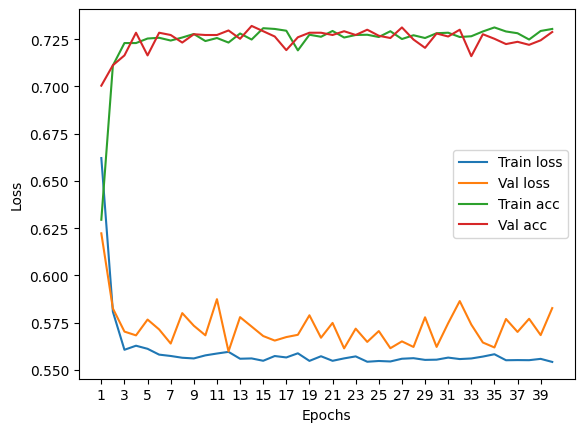

****************************************************************************************************



118it [00:00, 246.66it/s]


Train Epoch: 0 	Loss: 0.672438, Accuracy: 4622/7500 (62%)
Val Epoch: 0 	Loss: 0.636427, Accuracy: 1753/2500 (70%)



118it [00:00, 178.23it/s]


Train Epoch: 1 	Loss: 0.579921, Accuracy: 5395/7500 (72%)
Val Epoch: 1 	Loss: 0.552946, Accuracy: 1828/2500 (73%)



118it [00:00, 210.86it/s]


Train Epoch: 2 	Loss: 0.556141, Accuracy: 5419/7500 (72%)
Val Epoch: 2 	Loss: 0.548689, Accuracy: 1832/2500 (73%)



118it [00:00, 194.22it/s]


Train Epoch: 3 	Loss: 0.550293, Accuracy: 5417/7500 (72%)
Val Epoch: 3 	Loss: 0.558170, Accuracy: 1845/2500 (74%)



118it [00:00, 228.61it/s]


Train Epoch: 4 	Loss: 0.551045, Accuracy: 5442/7500 (73%)
Val Epoch: 4 	Loss: 0.566770, Accuracy: 1813/2500 (73%)



118it [00:00, 253.28it/s]


Train Epoch: 5 	Loss: 0.550646, Accuracy: 5445/7500 (73%)
Val Epoch: 5 	Loss: 0.555827, Accuracy: 1826/2500 (73%)



118it [00:00, 236.35it/s]


Train Epoch: 6 	Loss: 0.547867, Accuracy: 5453/7500 (73%)
Val Epoch: 6 	Loss: 0.557311, Accuracy: 1819/2500 (73%)



118it [00:00, 241.97it/s]


Train Epoch: 7 	Loss: 0.548512, Accuracy: 5456/7500 (73%)
Val Epoch: 7 	Loss: 0.554360, Accuracy: 1824/2500 (73%)



118it [00:00, 243.62it/s]


Train Epoch: 8 	Loss: 0.548503, Accuracy: 5436/7500 (72%)
Val Epoch: 8 	Loss: 0.557685, Accuracy: 1848/2500 (74%)



118it [00:00, 240.10it/s]


Train Epoch: 9 	Loss: 0.549566, Accuracy: 5447/7500 (73%)
Val Epoch: 9 	Loss: 0.544427, Accuracy: 1836/2500 (73%)



118it [00:00, 245.02it/s]


Train Epoch: 10 	Loss: 0.548144, Accuracy: 5468/7500 (73%)
Val Epoch: 10 	Loss: 0.554453, Accuracy: 1848/2500 (74%)



118it [00:00, 241.64it/s]


Train Epoch: 11 	Loss: 0.549161, Accuracy: 5443/7500 (73%)
Val Epoch: 11 	Loss: 0.549204, Accuracy: 1823/2500 (73%)



118it [00:00, 234.95it/s]


Train Epoch: 12 	Loss: 0.549598, Accuracy: 5486/7500 (73%)
Val Epoch: 12 	Loss: 0.546283, Accuracy: 1825/2500 (73%)



118it [00:00, 239.55it/s]


Train Epoch: 13 	Loss: 0.549809, Accuracy: 5457/7500 (73%)
Val Epoch: 13 	Loss: 0.551013, Accuracy: 1808/2500 (72%)



118it [00:00, 240.79it/s]


Train Epoch: 14 	Loss: 0.549769, Accuracy: 5478/7500 (73%)
Val Epoch: 14 	Loss: 0.545427, Accuracy: 1833/2500 (73%)



118it [00:00, 238.17it/s]


Train Epoch: 15 	Loss: 0.548295, Accuracy: 5443/7500 (73%)
Val Epoch: 15 	Loss: 0.557052, Accuracy: 1813/2500 (73%)



118it [00:00, 243.42it/s]


Train Epoch: 16 	Loss: 0.550468, Accuracy: 5471/7500 (73%)
Val Epoch: 16 	Loss: 0.550410, Accuracy: 1826/2500 (73%)



118it [00:00, 240.78it/s]


Train Epoch: 17 	Loss: 0.547851, Accuracy: 5468/7500 (73%)
Val Epoch: 17 	Loss: 0.559786, Accuracy: 1809/2500 (72%)



118it [00:00, 242.52it/s]


Train Epoch: 18 	Loss: 0.547689, Accuracy: 5452/7500 (73%)
Val Epoch: 18 	Loss: 0.547557, Accuracy: 1828/2500 (73%)



118it [00:00, 242.98it/s]


Train Epoch: 19 	Loss: 0.547540, Accuracy: 5426/7500 (72%)
Val Epoch: 19 	Loss: 0.551862, Accuracy: 1832/2500 (73%)



118it [00:00, 238.58it/s]


Train Epoch: 20 	Loss: 0.546106, Accuracy: 5480/7500 (73%)
Val Epoch: 20 	Loss: 0.556795, Accuracy: 1835/2500 (73%)



118it [00:00, 244.01it/s]


Train Epoch: 21 	Loss: 0.548641, Accuracy: 5462/7500 (73%)
Val Epoch: 21 	Loss: 0.552165, Accuracy: 1834/2500 (73%)



118it [00:00, 241.05it/s]


Train Epoch: 22 	Loss: 0.548668, Accuracy: 5453/7500 (73%)
Val Epoch: 22 	Loss: 0.549351, Accuracy: 1834/2500 (73%)



118it [00:00, 241.60it/s]


Train Epoch: 23 	Loss: 0.547431, Accuracy: 5457/7500 (73%)
Val Epoch: 23 	Loss: 0.542617, Accuracy: 1835/2500 (73%)



118it [00:00, 241.58it/s]


Train Epoch: 24 	Loss: 0.545259, Accuracy: 5467/7500 (73%)
Val Epoch: 24 	Loss: 0.544342, Accuracy: 1835/2500 (73%)



118it [00:00, 219.69it/s]


Train Epoch: 25 	Loss: 0.547240, Accuracy: 5456/7500 (73%)
Val Epoch: 25 	Loss: 0.556691, Accuracy: 1828/2500 (73%)



118it [00:00, 177.61it/s]


Train Epoch: 26 	Loss: 0.547739, Accuracy: 5467/7500 (73%)
Val Epoch: 26 	Loss: 0.542361, Accuracy: 1843/2500 (74%)



118it [00:00, 221.95it/s]


Train Epoch: 27 	Loss: 0.547197, Accuracy: 5463/7500 (73%)
Val Epoch: 27 	Loss: 0.545981, Accuracy: 1837/2500 (73%)



118it [00:00, 212.29it/s]


Train Epoch: 28 	Loss: 0.545612, Accuracy: 5466/7500 (73%)
Val Epoch: 28 	Loss: 0.550026, Accuracy: 1833/2500 (73%)



118it [00:00, 244.12it/s]


Train Epoch: 29 	Loss: 0.547775, Accuracy: 5469/7500 (73%)
Val Epoch: 29 	Loss: 0.546980, Accuracy: 1841/2500 (74%)



118it [00:00, 241.19it/s]


Train Epoch: 30 	Loss: 0.546755, Accuracy: 5456/7500 (73%)
Val Epoch: 30 	Loss: 0.539117, Accuracy: 1831/2500 (73%)



118it [00:00, 239.16it/s]


Train Epoch: 31 	Loss: 0.548781, Accuracy: 5450/7500 (73%)
Val Epoch: 31 	Loss: 0.576684, Accuracy: 1808/2500 (72%)



118it [00:00, 245.00it/s]


Train Epoch: 32 	Loss: 0.546914, Accuracy: 5456/7500 (73%)
Val Epoch: 32 	Loss: 0.544601, Accuracy: 1824/2500 (73%)



118it [00:00, 244.94it/s]


Train Epoch: 33 	Loss: 0.546777, Accuracy: 5453/7500 (73%)
Val Epoch: 33 	Loss: 0.548523, Accuracy: 1806/2500 (72%)



118it [00:00, 241.86it/s]


Train Epoch: 34 	Loss: 0.548158, Accuracy: 5460/7500 (73%)
Val Epoch: 34 	Loss: 0.549575, Accuracy: 1821/2500 (73%)



118it [00:00, 242.94it/s]


Train Epoch: 35 	Loss: 0.546601, Accuracy: 5457/7500 (73%)
Val Epoch: 35 	Loss: 0.563242, Accuracy: 1823/2500 (73%)



118it [00:00, 237.05it/s]


Train Epoch: 36 	Loss: 0.546449, Accuracy: 5443/7500 (73%)
Val Epoch: 36 	Loss: 0.549010, Accuracy: 1843/2500 (74%)



118it [00:00, 240.36it/s]


Train Epoch: 37 	Loss: 0.546565, Accuracy: 5449/7500 (73%)
Val Epoch: 37 	Loss: 0.559567, Accuracy: 1804/2500 (72%)



118it [00:00, 237.58it/s]


Train Epoch: 38 	Loss: 0.547269, Accuracy: 5468/7500 (73%)
Val Epoch: 38 	Loss: 0.566297, Accuracy: 1809/2500 (72%)



118it [00:00, 242.28it/s]


Train Epoch: 39 	Loss: 0.545002, Accuracy: 5464/7500 (73%)
Val Epoch: 39 	Loss: 0.542458, Accuracy: 1832/2500 (73%)

Test accuracy:  71.8


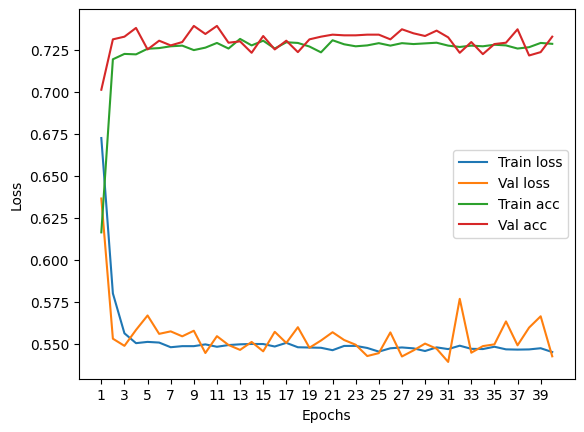

****************************************************************************************************



118it [00:00, 239.62it/s]


Train Epoch: 0 	Loss: 0.672739, Accuracy: 4621/7500 (62%)
Val Epoch: 0 	Loss: 0.638558, Accuracy: 1740/2500 (70%)



118it [00:00, 224.70it/s]


Train Epoch: 1 	Loss: 0.579154, Accuracy: 5398/7500 (72%)
Val Epoch: 1 	Loss: 0.581549, Accuracy: 1794/2500 (72%)



118it [00:00, 178.06it/s]


Train Epoch: 2 	Loss: 0.559282, Accuracy: 5410/7500 (72%)
Val Epoch: 2 	Loss: 0.580513, Accuracy: 1807/2500 (72%)



118it [00:00, 208.99it/s]


Train Epoch: 3 	Loss: 0.554207, Accuracy: 5443/7500 (73%)
Val Epoch: 3 	Loss: 0.590163, Accuracy: 1777/2500 (71%)



118it [00:00, 207.05it/s]


Train Epoch: 4 	Loss: 0.554726, Accuracy: 5409/7500 (72%)
Val Epoch: 4 	Loss: 0.577947, Accuracy: 1812/2500 (72%)



118it [00:00, 245.75it/s]


Train Epoch: 5 	Loss: 0.553782, Accuracy: 5429/7500 (72%)
Val Epoch: 5 	Loss: 0.578951, Accuracy: 1802/2500 (72%)



118it [00:00, 241.30it/s]


Train Epoch: 6 	Loss: 0.552827, Accuracy: 5465/7500 (73%)
Val Epoch: 6 	Loss: 0.572045, Accuracy: 1806/2500 (72%)



118it [00:00, 241.67it/s]


Train Epoch: 7 	Loss: 0.553651, Accuracy: 5449/7500 (73%)
Val Epoch: 7 	Loss: 0.602167, Accuracy: 1749/2500 (70%)



118it [00:00, 240.35it/s]


Train Epoch: 8 	Loss: 0.551500, Accuracy: 5445/7500 (73%)
Val Epoch: 8 	Loss: 0.575052, Accuracy: 1792/2500 (72%)



118it [00:00, 240.11it/s]


Train Epoch: 9 	Loss: 0.551896, Accuracy: 5459/7500 (73%)
Val Epoch: 9 	Loss: 0.577191, Accuracy: 1807/2500 (72%)



118it [00:00, 244.76it/s]


Train Epoch: 10 	Loss: 0.550663, Accuracy: 5466/7500 (73%)
Val Epoch: 10 	Loss: 0.567777, Accuracy: 1797/2500 (72%)



118it [00:00, 247.71it/s]


Train Epoch: 11 	Loss: 0.551694, Accuracy: 5468/7500 (73%)
Val Epoch: 11 	Loss: 0.580513, Accuracy: 1807/2500 (72%)



118it [00:00, 237.83it/s]


Train Epoch: 12 	Loss: 0.549532, Accuracy: 5466/7500 (73%)
Val Epoch: 12 	Loss: 0.569388, Accuracy: 1810/2500 (72%)



118it [00:00, 214.11it/s]


Train Epoch: 13 	Loss: 0.550050, Accuracy: 5477/7500 (73%)
Val Epoch: 13 	Loss: 0.580157, Accuracy: 1806/2500 (72%)



118it [00:00, 240.16it/s]


Train Epoch: 14 	Loss: 0.552446, Accuracy: 5465/7500 (73%)
Val Epoch: 14 	Loss: 0.590427, Accuracy: 1785/2500 (71%)



118it [00:00, 239.91it/s]


Train Epoch: 15 	Loss: 0.549826, Accuracy: 5489/7500 (73%)
Val Epoch: 15 	Loss: 0.576653, Accuracy: 1811/2500 (72%)



118it [00:00, 243.29it/s]


Train Epoch: 16 	Loss: 0.551502, Accuracy: 5452/7500 (73%)
Val Epoch: 16 	Loss: 0.587173, Accuracy: 1804/2500 (72%)



118it [00:00, 245.21it/s]


Train Epoch: 17 	Loss: 0.551874, Accuracy: 5458/7500 (73%)
Val Epoch: 17 	Loss: 0.571113, Accuracy: 1807/2500 (72%)



118it [00:00, 244.83it/s]


Train Epoch: 18 	Loss: 0.552896, Accuracy: 5464/7500 (73%)
Val Epoch: 18 	Loss: 0.574188, Accuracy: 1801/2500 (72%)



118it [00:00, 244.52it/s]


Train Epoch: 19 	Loss: 0.550093, Accuracy: 5465/7500 (73%)
Val Epoch: 19 	Loss: 0.577369, Accuracy: 1806/2500 (72%)



118it [00:00, 202.06it/s]


Train Epoch: 20 	Loss: 0.551093, Accuracy: 5479/7500 (73%)
Val Epoch: 20 	Loss: 0.564970, Accuracy: 1813/2500 (73%)



118it [00:00, 244.04it/s]


Train Epoch: 21 	Loss: 0.552100, Accuracy: 5455/7500 (73%)
Val Epoch: 21 	Loss: 0.573798, Accuracy: 1788/2500 (72%)



118it [00:00, 227.87it/s]


Train Epoch: 22 	Loss: 0.551337, Accuracy: 5457/7500 (73%)
Val Epoch: 22 	Loss: 0.577223, Accuracy: 1795/2500 (72%)



118it [00:00, 163.12it/s]


Train Epoch: 23 	Loss: 0.549354, Accuracy: 5484/7500 (73%)
Val Epoch: 23 	Loss: 0.590543, Accuracy: 1773/2500 (71%)



118it [00:00, 240.25it/s]


Train Epoch: 24 	Loss: 0.551045, Accuracy: 5440/7500 (73%)
Val Epoch: 24 	Loss: 0.579010, Accuracy: 1813/2500 (73%)



118it [00:00, 192.16it/s]


Train Epoch: 25 	Loss: 0.550786, Accuracy: 5477/7500 (73%)
Val Epoch: 25 	Loss: 0.570465, Accuracy: 1812/2500 (72%)



118it [00:00, 183.14it/s]


Train Epoch: 26 	Loss: 0.552418, Accuracy: 5483/7500 (73%)
Val Epoch: 26 	Loss: 0.575658, Accuracy: 1803/2500 (72%)



118it [00:00, 166.03it/s]


Train Epoch: 27 	Loss: 0.549386, Accuracy: 5494/7500 (73%)
Val Epoch: 27 	Loss: 0.575084, Accuracy: 1810/2500 (72%)



118it [00:00, 181.56it/s]


Train Epoch: 28 	Loss: 0.552550, Accuracy: 5471/7500 (73%)
Val Epoch: 28 	Loss: 0.568783, Accuracy: 1812/2500 (72%)



118it [00:00, 178.82it/s]


Train Epoch: 29 	Loss: 0.550554, Accuracy: 5453/7500 (73%)
Val Epoch: 29 	Loss: 0.580834, Accuracy: 1804/2500 (72%)



118it [00:00, 233.64it/s]


Train Epoch: 30 	Loss: 0.552596, Accuracy: 5472/7500 (73%)
Val Epoch: 30 	Loss: 0.580337, Accuracy: 1797/2500 (72%)



118it [00:00, 242.65it/s]


Train Epoch: 31 	Loss: 0.556679, Accuracy: 5447/7500 (73%)
Val Epoch: 31 	Loss: 0.572101, Accuracy: 1809/2500 (72%)



118it [00:00, 238.22it/s]


Train Epoch: 32 	Loss: 0.550168, Accuracy: 5468/7500 (73%)
Val Epoch: 32 	Loss: 0.570427, Accuracy: 1809/2500 (72%)



118it [00:00, 244.67it/s]


Train Epoch: 33 	Loss: 0.549692, Accuracy: 5461/7500 (73%)
Val Epoch: 33 	Loss: 0.577055, Accuracy: 1813/2500 (73%)



118it [00:00, 244.18it/s]


Train Epoch: 34 	Loss: 0.550613, Accuracy: 5468/7500 (73%)
Val Epoch: 34 	Loss: 0.596659, Accuracy: 1789/2500 (72%)



118it [00:00, 239.27it/s]


Train Epoch: 35 	Loss: 0.548442, Accuracy: 5500/7500 (73%)
Val Epoch: 35 	Loss: 0.578559, Accuracy: 1804/2500 (72%)



118it [00:00, 239.45it/s]


Train Epoch: 36 	Loss: 0.549642, Accuracy: 5477/7500 (73%)
Val Epoch: 36 	Loss: 0.569363, Accuracy: 1809/2500 (72%)



118it [00:00, 232.67it/s]


Train Epoch: 37 	Loss: 0.548295, Accuracy: 5473/7500 (73%)
Val Epoch: 37 	Loss: 0.572159, Accuracy: 1812/2500 (72%)



118it [00:00, 241.47it/s]


Train Epoch: 38 	Loss: 0.549679, Accuracy: 5459/7500 (73%)
Val Epoch: 38 	Loss: 0.570098, Accuracy: 1814/2500 (73%)



118it [00:00, 239.59it/s]


Train Epoch: 39 	Loss: 0.550678, Accuracy: 5485/7500 (73%)
Val Epoch: 39 	Loss: 0.585938, Accuracy: 1805/2500 (72%)

Test accuracy:  71.16


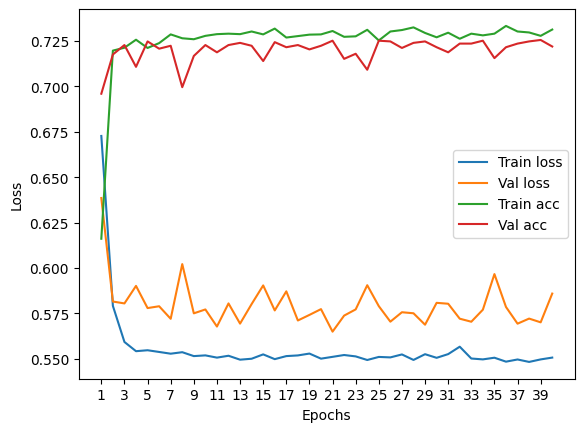

****************************************************************************************************



118it [00:00, 240.96it/s]


Train Epoch: 0 	Loss: 0.665838, Accuracy: 4378/7500 (58%)
Val Epoch: 0 	Loss: 0.621558, Accuracy: 1752/2500 (70%)



118it [00:00, 165.51it/s]


Train Epoch: 1 	Loss: 0.570094, Accuracy: 5422/7500 (72%)
Val Epoch: 1 	Loss: 0.578591, Accuracy: 1762/2500 (70%)



118it [00:00, 205.51it/s]


Train Epoch: 2 	Loss: 0.556698, Accuracy: 5413/7500 (72%)
Val Epoch: 2 	Loss: 0.574844, Accuracy: 1773/2500 (71%)



118it [00:00, 194.62it/s]


Train Epoch: 3 	Loss: 0.553548, Accuracy: 5438/7500 (73%)
Val Epoch: 3 	Loss: 0.573712, Accuracy: 1782/2500 (71%)



118it [00:00, 215.32it/s]


Train Epoch: 4 	Loss: 0.552579, Accuracy: 5461/7500 (73%)
Val Epoch: 4 	Loss: 0.591474, Accuracy: 1779/2500 (71%)



118it [00:00, 239.35it/s]


Train Epoch: 5 	Loss: 0.552230, Accuracy: 5443/7500 (73%)
Val Epoch: 5 	Loss: 0.573900, Accuracy: 1761/2500 (70%)



118it [00:00, 208.08it/s]


Train Epoch: 6 	Loss: 0.553793, Accuracy: 5446/7500 (73%)
Val Epoch: 6 	Loss: 0.603238, Accuracy: 1740/2500 (70%)



118it [00:00, 240.59it/s]


Train Epoch: 7 	Loss: 0.552627, Accuracy: 5432/7500 (72%)
Val Epoch: 7 	Loss: 0.572116, Accuracy: 1783/2500 (71%)



118it [00:00, 236.75it/s]


Train Epoch: 8 	Loss: 0.550068, Accuracy: 5472/7500 (73%)
Val Epoch: 8 	Loss: 0.593626, Accuracy: 1749/2500 (70%)



118it [00:00, 236.11it/s]


Train Epoch: 9 	Loss: 0.550750, Accuracy: 5459/7500 (73%)
Val Epoch: 9 	Loss: 0.578611, Accuracy: 1766/2500 (71%)



118it [00:00, 217.22it/s]


Train Epoch: 10 	Loss: 0.554350, Accuracy: 5434/7500 (72%)
Val Epoch: 10 	Loss: 0.570816, Accuracy: 1777/2500 (71%)



118it [00:00, 196.70it/s]


Train Epoch: 11 	Loss: 0.550010, Accuracy: 5452/7500 (73%)
Val Epoch: 11 	Loss: 0.580134, Accuracy: 1770/2500 (71%)



118it [00:00, 241.09it/s]


Train Epoch: 12 	Loss: 0.550699, Accuracy: 5438/7500 (73%)
Val Epoch: 12 	Loss: 0.584607, Accuracy: 1773/2500 (71%)



118it [00:00, 238.90it/s]


Train Epoch: 13 	Loss: 0.548979, Accuracy: 5454/7500 (73%)
Val Epoch: 13 	Loss: 0.580226, Accuracy: 1761/2500 (70%)



118it [00:00, 241.58it/s]


Train Epoch: 14 	Loss: 0.548995, Accuracy: 5442/7500 (73%)
Val Epoch: 14 	Loss: 0.581668, Accuracy: 1767/2500 (71%)



118it [00:00, 194.30it/s]


Train Epoch: 15 	Loss: 0.548880, Accuracy: 5450/7500 (73%)
Val Epoch: 15 	Loss: 0.591305, Accuracy: 1765/2500 (71%)



118it [00:00, 189.62it/s]


Train Epoch: 16 	Loss: 0.548865, Accuracy: 5451/7500 (73%)
Val Epoch: 16 	Loss: 0.569388, Accuracy: 1772/2500 (71%)



118it [00:00, 211.36it/s]


Train Epoch: 17 	Loss: 0.550303, Accuracy: 5455/7500 (73%)
Val Epoch: 17 	Loss: 0.571236, Accuracy: 1776/2500 (71%)



118it [00:00, 243.43it/s]


Train Epoch: 18 	Loss: 0.550567, Accuracy: 5446/7500 (73%)
Val Epoch: 18 	Loss: 0.575352, Accuracy: 1780/2500 (71%)



118it [00:00, 234.81it/s]


Train Epoch: 19 	Loss: 0.548231, Accuracy: 5455/7500 (73%)
Val Epoch: 19 	Loss: 0.598669, Accuracy: 1760/2500 (70%)



118it [00:00, 229.72it/s]


Train Epoch: 20 	Loss: 0.550054, Accuracy: 5447/7500 (73%)
Val Epoch: 20 	Loss: 0.586282, Accuracy: 1778/2500 (71%)



118it [00:00, 239.04it/s]


Train Epoch: 21 	Loss: 0.549099, Accuracy: 5460/7500 (73%)
Val Epoch: 21 	Loss: 0.572989, Accuracy: 1782/2500 (71%)



118it [00:00, 238.00it/s]


Train Epoch: 22 	Loss: 0.547490, Accuracy: 5461/7500 (73%)
Val Epoch: 22 	Loss: 0.579291, Accuracy: 1768/2500 (71%)



118it [00:00, 230.93it/s]


Train Epoch: 23 	Loss: 0.549071, Accuracy: 5449/7500 (73%)
Val Epoch: 23 	Loss: 0.582953, Accuracy: 1763/2500 (71%)



118it [00:00, 170.25it/s]


Train Epoch: 24 	Loss: 0.548363, Accuracy: 5467/7500 (73%)
Val Epoch: 24 	Loss: 0.566450, Accuracy: 1775/2500 (71%)



118it [00:00, 194.84it/s]


Train Epoch: 25 	Loss: 0.545971, Accuracy: 5466/7500 (73%)
Val Epoch: 25 	Loss: 0.583545, Accuracy: 1765/2500 (71%)



118it [00:00, 177.41it/s]


Train Epoch: 26 	Loss: 0.546534, Accuracy: 5466/7500 (73%)
Val Epoch: 26 	Loss: 0.587839, Accuracy: 1767/2500 (71%)



118it [00:00, 239.49it/s]


Train Epoch: 27 	Loss: 0.547595, Accuracy: 5460/7500 (73%)
Val Epoch: 27 	Loss: 0.571128, Accuracy: 1769/2500 (71%)



118it [00:00, 232.22it/s]


Train Epoch: 28 	Loss: 0.546354, Accuracy: 5480/7500 (73%)
Val Epoch: 28 	Loss: 0.580873, Accuracy: 1775/2500 (71%)



118it [00:00, 175.47it/s]


Train Epoch: 29 	Loss: 0.550399, Accuracy: 5473/7500 (73%)
Val Epoch: 29 	Loss: 0.569697, Accuracy: 1772/2500 (71%)



118it [00:00, 200.21it/s]


Train Epoch: 30 	Loss: 0.546094, Accuracy: 5468/7500 (73%)
Val Epoch: 30 	Loss: 0.587140, Accuracy: 1764/2500 (71%)



118it [00:00, 229.67it/s]


Train Epoch: 31 	Loss: 0.546947, Accuracy: 5468/7500 (73%)
Val Epoch: 31 	Loss: 0.571669, Accuracy: 1767/2500 (71%)



118it [00:00, 214.78it/s]


Train Epoch: 32 	Loss: 0.546825, Accuracy: 5455/7500 (73%)
Val Epoch: 32 	Loss: 0.572471, Accuracy: 1776/2500 (71%)



118it [00:00, 229.81it/s]


Train Epoch: 33 	Loss: 0.547214, Accuracy: 5451/7500 (73%)
Val Epoch: 33 	Loss: 0.584496, Accuracy: 1775/2500 (71%)



118it [00:00, 236.47it/s]


Train Epoch: 34 	Loss: 0.547746, Accuracy: 5471/7500 (73%)
Val Epoch: 34 	Loss: 0.569975, Accuracy: 1778/2500 (71%)



118it [00:00, 239.98it/s]


Train Epoch: 35 	Loss: 0.546773, Accuracy: 5481/7500 (73%)
Val Epoch: 35 	Loss: 0.571043, Accuracy: 1788/2500 (72%)



118it [00:00, 236.15it/s]


Train Epoch: 36 	Loss: 0.547120, Accuracy: 5450/7500 (73%)
Val Epoch: 36 	Loss: 0.586577, Accuracy: 1759/2500 (70%)



118it [00:00, 236.16it/s]


Train Epoch: 37 	Loss: 0.546885, Accuracy: 5471/7500 (73%)
Val Epoch: 37 	Loss: 0.581423, Accuracy: 1758/2500 (70%)



118it [00:00, 238.17it/s]


Train Epoch: 38 	Loss: 0.550752, Accuracy: 5448/7500 (73%)
Val Epoch: 38 	Loss: 0.569304, Accuracy: 1763/2500 (71%)



118it [00:00, 239.40it/s]


Train Epoch: 39 	Loss: 0.547574, Accuracy: 5459/7500 (73%)
Val Epoch: 39 	Loss: 0.578589, Accuracy: 1777/2500 (71%)

Test accuracy:  71.2


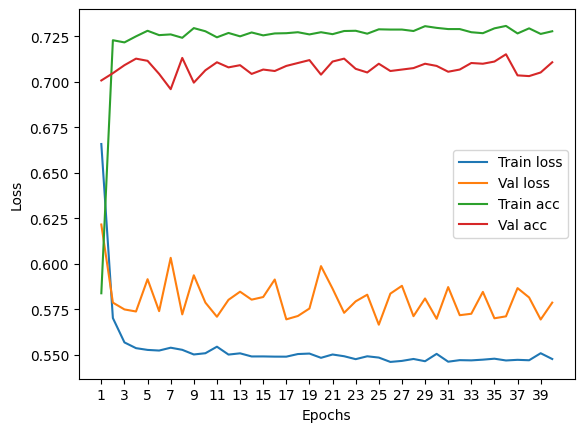

****************************************************************************************************



118it [00:00, 214.61it/s]


Train Epoch: 0 	Loss: 0.675200, Accuracy: 4570/7500 (61%)
Val Epoch: 0 	Loss: 0.647601, Accuracy: 1634/2500 (65%)



118it [00:00, 194.27it/s]


Train Epoch: 1 	Loss: 0.584920, Accuracy: 5355/7500 (71%)
Val Epoch: 1 	Loss: 0.587995, Accuracy: 1773/2500 (71%)



118it [00:00, 227.72it/s]


Train Epoch: 2 	Loss: 0.558240, Accuracy: 5394/7500 (72%)
Val Epoch: 2 	Loss: 0.584958, Accuracy: 1756/2500 (70%)



118it [00:00, 234.92it/s]


Train Epoch: 3 	Loss: 0.557879, Accuracy: 5384/7500 (72%)
Val Epoch: 3 	Loss: 0.609434, Accuracy: 1748/2500 (70%)



118it [00:00, 226.28it/s]


Train Epoch: 4 	Loss: 0.555347, Accuracy: 5376/7500 (72%)
Val Epoch: 4 	Loss: 0.578365, Accuracy: 1763/2500 (71%)



118it [00:00, 235.27it/s]


Train Epoch: 5 	Loss: 0.554088, Accuracy: 5432/7500 (72%)
Val Epoch: 5 	Loss: 0.580436, Accuracy: 1770/2500 (71%)



118it [00:00, 235.64it/s]


Train Epoch: 6 	Loss: 0.551683, Accuracy: 5433/7500 (72%)
Val Epoch: 6 	Loss: 0.592342, Accuracy: 1773/2500 (71%)



118it [00:00, 238.25it/s]


Train Epoch: 7 	Loss: 0.552739, Accuracy: 5438/7500 (73%)
Val Epoch: 7 	Loss: 0.595364, Accuracy: 1772/2500 (71%)



118it [00:00, 233.40it/s]


Train Epoch: 8 	Loss: 0.552152, Accuracy: 5442/7500 (73%)
Val Epoch: 8 	Loss: 0.598068, Accuracy: 1768/2500 (71%)



118it [00:00, 230.80it/s]


Train Epoch: 9 	Loss: 0.552793, Accuracy: 5418/7500 (72%)
Val Epoch: 9 	Loss: 0.591069, Accuracy: 1772/2500 (71%)



118it [00:00, 231.53it/s]


Train Epoch: 10 	Loss: 0.556430, Accuracy: 5387/7500 (72%)
Val Epoch: 10 	Loss: 0.584027, Accuracy: 1752/2500 (70%)



118it [00:00, 231.68it/s]


Train Epoch: 11 	Loss: 0.554445, Accuracy: 5428/7500 (72%)
Val Epoch: 11 	Loss: 0.587180, Accuracy: 1776/2500 (71%)



118it [00:00, 230.22it/s]


Train Epoch: 12 	Loss: 0.555158, Accuracy: 5391/7500 (72%)
Val Epoch: 12 	Loss: 0.587522, Accuracy: 1765/2500 (71%)



118it [00:00, 238.29it/s]


Train Epoch: 13 	Loss: 0.553989, Accuracy: 5451/7500 (73%)
Val Epoch: 13 	Loss: 0.589640, Accuracy: 1762/2500 (70%)



118it [00:00, 237.43it/s]


Train Epoch: 14 	Loss: 0.553129, Accuracy: 5415/7500 (72%)
Val Epoch: 14 	Loss: 0.583737, Accuracy: 1779/2500 (71%)



118it [00:00, 240.41it/s]


Train Epoch: 15 	Loss: 0.552156, Accuracy: 5430/7500 (72%)
Val Epoch: 15 	Loss: 0.591047, Accuracy: 1750/2500 (70%)



118it [00:00, 234.58it/s]


Train Epoch: 16 	Loss: 0.553097, Accuracy: 5429/7500 (72%)
Val Epoch: 16 	Loss: 0.586867, Accuracy: 1767/2500 (71%)



118it [00:00, 233.92it/s]


Train Epoch: 17 	Loss: 0.552927, Accuracy: 5434/7500 (72%)
Val Epoch: 17 	Loss: 0.584449, Accuracy: 1769/2500 (71%)



118it [00:00, 232.67it/s]


Train Epoch: 18 	Loss: 0.552077, Accuracy: 5424/7500 (72%)
Val Epoch: 18 	Loss: 0.595878, Accuracy: 1755/2500 (70%)



118it [00:00, 234.50it/s]


Train Epoch: 19 	Loss: 0.552470, Accuracy: 5425/7500 (72%)
Val Epoch: 19 	Loss: 0.584159, Accuracy: 1783/2500 (71%)



118it [00:00, 239.36it/s]


Train Epoch: 20 	Loss: 0.550357, Accuracy: 5427/7500 (72%)
Val Epoch: 20 	Loss: 0.587027, Accuracy: 1749/2500 (70%)



118it [00:00, 237.55it/s]


Train Epoch: 21 	Loss: 0.552614, Accuracy: 5440/7500 (73%)
Val Epoch: 21 	Loss: 0.602612, Accuracy: 1760/2500 (70%)



118it [00:00, 215.97it/s]


Train Epoch: 22 	Loss: 0.552178, Accuracy: 5432/7500 (72%)
Val Epoch: 22 	Loss: 0.577487, Accuracy: 1774/2500 (71%)



118it [00:00, 152.72it/s]


Train Epoch: 23 	Loss: 0.552529, Accuracy: 5451/7500 (73%)
Val Epoch: 23 	Loss: 0.582189, Accuracy: 1765/2500 (71%)



118it [00:00, 194.97it/s]


Train Epoch: 24 	Loss: 0.550688, Accuracy: 5434/7500 (72%)
Val Epoch: 24 	Loss: 0.588559, Accuracy: 1764/2500 (71%)



118it [00:00, 182.03it/s]


Train Epoch: 25 	Loss: 0.550908, Accuracy: 5411/7500 (72%)
Val Epoch: 25 	Loss: 0.583800, Accuracy: 1780/2500 (71%)



118it [00:00, 235.27it/s]


Train Epoch: 26 	Loss: 0.553205, Accuracy: 5427/7500 (72%)
Val Epoch: 26 	Loss: 0.596363, Accuracy: 1770/2500 (71%)



118it [00:00, 240.09it/s]


Train Epoch: 27 	Loss: 0.551794, Accuracy: 5441/7500 (73%)
Val Epoch: 27 	Loss: 0.583847, Accuracy: 1777/2500 (71%)



118it [00:00, 240.18it/s]


Train Epoch: 28 	Loss: 0.551695, Accuracy: 5424/7500 (72%)
Val Epoch: 28 	Loss: 0.586010, Accuracy: 1750/2500 (70%)



118it [00:00, 226.64it/s]


Train Epoch: 29 	Loss: 0.551505, Accuracy: 5431/7500 (72%)
Val Epoch: 29 	Loss: 0.599996, Accuracy: 1768/2500 (71%)



118it [00:00, 237.86it/s]


Train Epoch: 30 	Loss: 0.550395, Accuracy: 5438/7500 (73%)
Val Epoch: 30 	Loss: 0.610168, Accuracy: 1744/2500 (70%)



118it [00:00, 238.81it/s]


Train Epoch: 31 	Loss: 0.552256, Accuracy: 5436/7500 (72%)
Val Epoch: 31 	Loss: 0.580785, Accuracy: 1773/2500 (71%)



118it [00:00, 235.83it/s]


Train Epoch: 32 	Loss: 0.550799, Accuracy: 5433/7500 (72%)
Val Epoch: 32 	Loss: 0.585193, Accuracy: 1781/2500 (71%)



118it [00:00, 232.06it/s]


Train Epoch: 33 	Loss: 0.550671, Accuracy: 5438/7500 (73%)
Val Epoch: 33 	Loss: 0.590525, Accuracy: 1777/2500 (71%)



118it [00:00, 228.45it/s]


Train Epoch: 34 	Loss: 0.551532, Accuracy: 5449/7500 (73%)
Val Epoch: 34 	Loss: 0.586503, Accuracy: 1772/2500 (71%)



118it [00:00, 240.97it/s]


Train Epoch: 35 	Loss: 0.554016, Accuracy: 5432/7500 (72%)
Val Epoch: 35 	Loss: 0.579148, Accuracy: 1765/2500 (71%)



118it [00:00, 233.44it/s]


Train Epoch: 36 	Loss: 0.549655, Accuracy: 5453/7500 (73%)
Val Epoch: 36 	Loss: 0.586300, Accuracy: 1781/2500 (71%)



118it [00:00, 239.41it/s]


Train Epoch: 37 	Loss: 0.553543, Accuracy: 5435/7500 (72%)
Val Epoch: 37 	Loss: 0.584818, Accuracy: 1762/2500 (70%)



118it [00:00, 205.35it/s]


Train Epoch: 38 	Loss: 0.551062, Accuracy: 5443/7500 (73%)
Val Epoch: 38 	Loss: 0.591094, Accuracy: 1774/2500 (71%)



118it [00:00, 233.43it/s]


Train Epoch: 39 	Loss: 0.552924, Accuracy: 5439/7500 (73%)
Val Epoch: 39 	Loss: 0.580213, Accuracy: 1770/2500 (71%)

Test accuracy:  72.28


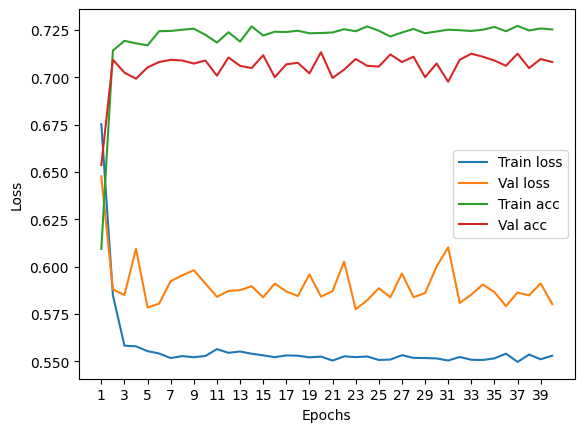

****************************************************************************************************



118it [00:00, 206.36it/s]


Train Epoch: 0 	Loss: 0.677524, Accuracy: 4428/7500 (59%)
Val Epoch: 0 	Loss: 0.636369, Accuracy: 1722/2500 (69%)



118it [00:00, 235.49it/s]


Train Epoch: 1 	Loss: 0.591598, Accuracy: 5239/7500 (70%)
Val Epoch: 1 	Loss: 0.577081, Accuracy: 1769/2500 (71%)



118it [00:00, 238.39it/s]


Train Epoch: 2 	Loss: 0.566709, Accuracy: 5315/7500 (71%)
Val Epoch: 2 	Loss: 0.577879, Accuracy: 1773/2500 (71%)



118it [00:00, 235.19it/s]


Train Epoch: 3 	Loss: 0.561839, Accuracy: 5333/7500 (71%)
Val Epoch: 3 	Loss: 0.572748, Accuracy: 1783/2500 (71%)



118it [00:00, 234.96it/s]


Train Epoch: 4 	Loss: 0.558746, Accuracy: 5369/7500 (72%)
Val Epoch: 4 	Loss: 0.580307, Accuracy: 1783/2500 (71%)



118it [00:00, 239.90it/s]


Train Epoch: 5 	Loss: 0.561947, Accuracy: 5361/7500 (71%)
Val Epoch: 5 	Loss: 0.570735, Accuracy: 1777/2500 (71%)



118it [00:00, 235.39it/s]


Train Epoch: 6 	Loss: 0.559223, Accuracy: 5411/7500 (72%)
Val Epoch: 6 	Loss: 0.571686, Accuracy: 1791/2500 (72%)



118it [00:00, 236.71it/s]


Train Epoch: 7 	Loss: 0.557211, Accuracy: 5387/7500 (72%)
Val Epoch: 7 	Loss: 0.583683, Accuracy: 1781/2500 (71%)



118it [00:00, 232.82it/s]


Train Epoch: 8 	Loss: 0.558147, Accuracy: 5394/7500 (72%)
Val Epoch: 8 	Loss: 0.584979, Accuracy: 1793/2500 (72%)



118it [00:00, 237.67it/s]


Train Epoch: 9 	Loss: 0.558857, Accuracy: 5351/7500 (71%)
Val Epoch: 9 	Loss: 0.579943, Accuracy: 1792/2500 (72%)



118it [00:00, 234.68it/s]


Train Epoch: 10 	Loss: 0.557438, Accuracy: 5372/7500 (72%)
Val Epoch: 10 	Loss: 0.567318, Accuracy: 1777/2500 (71%)



118it [00:00, 238.60it/s]


Train Epoch: 11 	Loss: 0.558074, Accuracy: 5399/7500 (72%)
Val Epoch: 11 	Loss: 0.570662, Accuracy: 1782/2500 (71%)



118it [00:00, 232.52it/s]


Train Epoch: 12 	Loss: 0.558358, Accuracy: 5359/7500 (71%)
Val Epoch: 12 	Loss: 0.592105, Accuracy: 1785/2500 (71%)



118it [00:00, 237.81it/s]


Train Epoch: 13 	Loss: 0.557146, Accuracy: 5363/7500 (72%)
Val Epoch: 13 	Loss: 0.572197, Accuracy: 1776/2500 (71%)



118it [00:00, 230.50it/s]


Train Epoch: 14 	Loss: 0.556721, Accuracy: 5372/7500 (72%)
Val Epoch: 14 	Loss: 0.575918, Accuracy: 1786/2500 (71%)



118it [00:00, 230.36it/s]


Train Epoch: 15 	Loss: 0.555147, Accuracy: 5371/7500 (72%)
Val Epoch: 15 	Loss: 0.593171, Accuracy: 1790/2500 (72%)



118it [00:00, 234.62it/s]


Train Epoch: 16 	Loss: 0.557505, Accuracy: 5365/7500 (72%)
Val Epoch: 16 	Loss: 0.574588, Accuracy: 1786/2500 (71%)



118it [00:00, 229.46it/s]


Train Epoch: 17 	Loss: 0.555802, Accuracy: 5374/7500 (72%)
Val Epoch: 17 	Loss: 0.574914, Accuracy: 1782/2500 (71%)



118it [00:00, 237.30it/s]


Train Epoch: 18 	Loss: 0.555602, Accuracy: 5387/7500 (72%)
Val Epoch: 18 	Loss: 0.577791, Accuracy: 1784/2500 (71%)



118it [00:00, 210.05it/s]


Train Epoch: 19 	Loss: 0.557974, Accuracy: 5385/7500 (72%)
Val Epoch: 19 	Loss: 0.576590, Accuracy: 1792/2500 (72%)



118it [00:00, 195.89it/s]


Train Epoch: 20 	Loss: 0.556276, Accuracy: 5394/7500 (72%)
Val Epoch: 20 	Loss: 0.573157, Accuracy: 1791/2500 (72%)



118it [00:00, 149.53it/s]


Train Epoch: 21 	Loss: 0.554248, Accuracy: 5389/7500 (72%)
Val Epoch: 21 	Loss: 0.573605, Accuracy: 1788/2500 (72%)



118it [00:00, 158.46it/s]


Train Epoch: 22 	Loss: 0.555145, Accuracy: 5375/7500 (72%)
Val Epoch: 22 	Loss: 0.574220, Accuracy: 1794/2500 (72%)



118it [00:00, 151.31it/s]


Train Epoch: 23 	Loss: 0.555781, Accuracy: 5381/7500 (72%)
Val Epoch: 23 	Loss: 0.573095, Accuracy: 1790/2500 (72%)



118it [00:00, 173.98it/s]


Train Epoch: 24 	Loss: 0.557096, Accuracy: 5388/7500 (72%)
Val Epoch: 24 	Loss: 0.581578, Accuracy: 1790/2500 (72%)



118it [00:00, 188.91it/s]


Train Epoch: 25 	Loss: 0.556511, Accuracy: 5362/7500 (71%)
Val Epoch: 25 	Loss: 0.572224, Accuracy: 1791/2500 (72%)



118it [00:00, 188.44it/s]


Train Epoch: 26 	Loss: 0.557072, Accuracy: 5374/7500 (72%)
Val Epoch: 26 	Loss: 0.573382, Accuracy: 1800/2500 (72%)



118it [00:00, 234.48it/s]


Train Epoch: 27 	Loss: 0.554321, Accuracy: 5389/7500 (72%)
Val Epoch: 27 	Loss: 0.576782, Accuracy: 1780/2500 (71%)



118it [00:00, 234.70it/s]


Train Epoch: 28 	Loss: 0.553277, Accuracy: 5389/7500 (72%)
Val Epoch: 28 	Loss: 0.573178, Accuracy: 1790/2500 (72%)



118it [00:00, 237.99it/s]


Train Epoch: 29 	Loss: 0.555780, Accuracy: 5389/7500 (72%)
Val Epoch: 29 	Loss: 0.578285, Accuracy: 1792/2500 (72%)



118it [00:00, 238.81it/s]


Train Epoch: 30 	Loss: 0.554937, Accuracy: 5377/7500 (72%)
Val Epoch: 30 	Loss: 0.578383, Accuracy: 1801/2500 (72%)



118it [00:00, 229.48it/s]


Train Epoch: 31 	Loss: 0.555317, Accuracy: 5396/7500 (72%)
Val Epoch: 31 	Loss: 0.570556, Accuracy: 1789/2500 (72%)



118it [00:00, 235.93it/s]


Train Epoch: 32 	Loss: 0.553371, Accuracy: 5390/7500 (72%)
Val Epoch: 32 	Loss: 0.592189, Accuracy: 1771/2500 (71%)



118it [00:00, 237.84it/s]


Train Epoch: 33 	Loss: 0.554385, Accuracy: 5376/7500 (72%)
Val Epoch: 33 	Loss: 0.580420, Accuracy: 1784/2500 (71%)



118it [00:00, 236.32it/s]


Train Epoch: 34 	Loss: 0.553379, Accuracy: 5394/7500 (72%)
Val Epoch: 34 	Loss: 0.582514, Accuracy: 1792/2500 (72%)



118it [00:00, 235.12it/s]


Train Epoch: 35 	Loss: 0.554684, Accuracy: 5390/7500 (72%)
Val Epoch: 35 	Loss: 0.569815, Accuracy: 1792/2500 (72%)



118it [00:00, 235.71it/s]


Train Epoch: 36 	Loss: 0.553873, Accuracy: 5406/7500 (72%)
Val Epoch: 36 	Loss: 0.570902, Accuracy: 1786/2500 (71%)



118it [00:00, 239.64it/s]


Train Epoch: 37 	Loss: 0.554723, Accuracy: 5414/7500 (72%)
Val Epoch: 37 	Loss: 0.568635, Accuracy: 1785/2500 (71%)



118it [00:00, 236.40it/s]


Train Epoch: 38 	Loss: 0.554038, Accuracy: 5365/7500 (72%)
Val Epoch: 38 	Loss: 0.587738, Accuracy: 1773/2500 (71%)



118it [00:00, 242.88it/s]


Train Epoch: 39 	Loss: 0.557856, Accuracy: 5394/7500 (72%)
Val Epoch: 39 	Loss: 0.568724, Accuracy: 1790/2500 (72%)

Test accuracy:  72.36


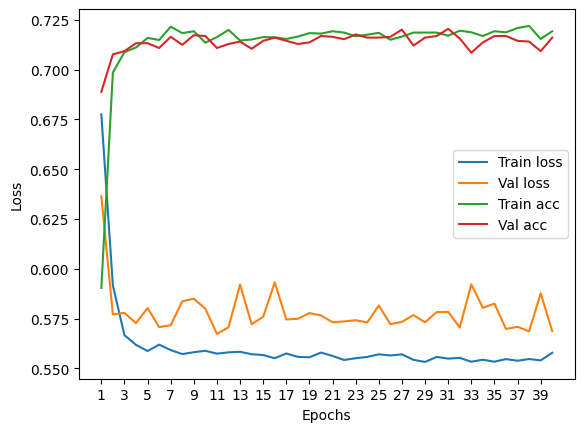

****************************************************************************************************



116it [00:00, 247.38it/s]


Train Epoch: 0 	Loss: 0.679582, Accuracy: 4190/7422 (56%)
Val Epoch: 0 	Loss: 0.652366, Accuracy: 1634/2474 (66%)



116it [00:00, 222.30it/s]


Train Epoch: 1 	Loss: 0.599080, Accuracy: 5221/7422 (70%)
Val Epoch: 1 	Loss: 0.578687, Accuracy: 1746/2474 (71%)



116it [00:00, 236.06it/s]


Train Epoch: 2 	Loss: 0.561713, Accuracy: 5317/7422 (72%)
Val Epoch: 2 	Loss: 0.567084, Accuracy: 1770/2474 (72%)



116it [00:00, 234.08it/s]


Train Epoch: 3 	Loss: 0.561403, Accuracy: 5335/7422 (72%)
Val Epoch: 3 	Loss: 0.563388, Accuracy: 1769/2474 (72%)



116it [00:00, 234.46it/s]


Train Epoch: 4 	Loss: 0.559566, Accuracy: 5360/7422 (72%)
Val Epoch: 4 	Loss: 0.564533, Accuracy: 1762/2474 (71%)



116it [00:00, 238.99it/s]


Train Epoch: 5 	Loss: 0.558982, Accuracy: 5353/7422 (72%)
Val Epoch: 5 	Loss: 0.565312, Accuracy: 1756/2474 (71%)



116it [00:00, 237.41it/s]


Train Epoch: 6 	Loss: 0.558806, Accuracy: 5362/7422 (72%)
Val Epoch: 6 	Loss: 0.562608, Accuracy: 1763/2474 (71%)



116it [00:00, 234.75it/s]


Train Epoch: 7 	Loss: 0.556971, Accuracy: 5355/7422 (72%)
Val Epoch: 7 	Loss: 0.562180, Accuracy: 1772/2474 (72%)



116it [00:00, 234.55it/s]


Train Epoch: 8 	Loss: 0.556769, Accuracy: 5379/7422 (72%)
Val Epoch: 8 	Loss: 0.561265, Accuracy: 1767/2474 (71%)



116it [00:00, 221.43it/s]


Train Epoch: 9 	Loss: 0.555788, Accuracy: 5382/7422 (73%)
Val Epoch: 9 	Loss: 0.560667, Accuracy: 1768/2474 (71%)



116it [00:00, 188.00it/s]


Train Epoch: 10 	Loss: 0.555755, Accuracy: 5361/7422 (72%)
Val Epoch: 10 	Loss: 0.566488, Accuracy: 1756/2474 (71%)



116it [00:00, 163.91it/s]


Train Epoch: 11 	Loss: 0.556566, Accuracy: 5358/7422 (72%)
Val Epoch: 11 	Loss: 0.569679, Accuracy: 1753/2474 (71%)



116it [00:00, 195.90it/s]


Train Epoch: 12 	Loss: 0.555358, Accuracy: 5370/7422 (72%)
Val Epoch: 12 	Loss: 0.559544, Accuracy: 1762/2474 (71%)



116it [00:00, 226.78it/s]


Train Epoch: 13 	Loss: 0.555883, Accuracy: 5363/7422 (72%)
Val Epoch: 13 	Loss: 0.560372, Accuracy: 1758/2474 (71%)



116it [00:00, 241.48it/s]


Train Epoch: 14 	Loss: 0.555356, Accuracy: 5362/7422 (72%)
Val Epoch: 14 	Loss: 0.560933, Accuracy: 1775/2474 (72%)



116it [00:00, 237.60it/s]


Train Epoch: 15 	Loss: 0.554917, Accuracy: 5378/7422 (72%)
Val Epoch: 15 	Loss: 0.559160, Accuracy: 1775/2474 (72%)



116it [00:00, 235.32it/s]


Train Epoch: 16 	Loss: 0.554066, Accuracy: 5386/7422 (73%)
Val Epoch: 16 	Loss: 0.560338, Accuracy: 1768/2474 (71%)



116it [00:00, 235.22it/s]


Train Epoch: 17 	Loss: 0.554880, Accuracy: 5380/7422 (72%)
Val Epoch: 17 	Loss: 0.560855, Accuracy: 1757/2474 (71%)



116it [00:00, 224.62it/s]


Train Epoch: 18 	Loss: 0.553215, Accuracy: 5386/7422 (73%)
Val Epoch: 18 	Loss: 0.559841, Accuracy: 1764/2474 (71%)



116it [00:00, 174.21it/s]


Train Epoch: 19 	Loss: 0.553345, Accuracy: 5385/7422 (73%)
Val Epoch: 19 	Loss: 0.560984, Accuracy: 1764/2474 (71%)



116it [00:00, 194.58it/s]


Train Epoch: 20 	Loss: 0.555437, Accuracy: 5380/7422 (72%)
Val Epoch: 20 	Loss: 0.562342, Accuracy: 1767/2474 (71%)



116it [00:00, 191.30it/s]


Train Epoch: 21 	Loss: 0.553144, Accuracy: 5374/7422 (72%)
Val Epoch: 21 	Loss: 0.560220, Accuracy: 1771/2474 (72%)



116it [00:00, 237.42it/s]


Train Epoch: 22 	Loss: 0.553313, Accuracy: 5383/7422 (73%)
Val Epoch: 22 	Loss: 0.560434, Accuracy: 1774/2474 (72%)



116it [00:00, 240.31it/s]


Train Epoch: 23 	Loss: 0.552904, Accuracy: 5387/7422 (73%)
Val Epoch: 23 	Loss: 0.558450, Accuracy: 1775/2474 (72%)



116it [00:00, 224.59it/s]


Train Epoch: 24 	Loss: 0.553227, Accuracy: 5372/7422 (72%)
Val Epoch: 24 	Loss: 0.564560, Accuracy: 1769/2474 (72%)



116it [00:00, 235.42it/s]


Train Epoch: 25 	Loss: 0.553221, Accuracy: 5405/7422 (73%)
Val Epoch: 25 	Loss: 0.562579, Accuracy: 1767/2474 (71%)



116it [00:00, 235.97it/s]


Train Epoch: 26 	Loss: 0.553621, Accuracy: 5362/7422 (72%)
Val Epoch: 26 	Loss: 0.569905, Accuracy: 1765/2474 (71%)



116it [00:00, 240.13it/s]


Train Epoch: 27 	Loss: 0.552374, Accuracy: 5384/7422 (73%)
Val Epoch: 27 	Loss: 0.562727, Accuracy: 1771/2474 (72%)



116it [00:00, 239.08it/s]


Train Epoch: 28 	Loss: 0.552278, Accuracy: 5384/7422 (73%)
Val Epoch: 28 	Loss: 0.561005, Accuracy: 1770/2474 (72%)



116it [00:00, 235.16it/s]


Train Epoch: 29 	Loss: 0.551914, Accuracy: 5374/7422 (72%)
Val Epoch: 29 	Loss: 0.563861, Accuracy: 1761/2474 (71%)



116it [00:00, 240.41it/s]


Train Epoch: 30 	Loss: 0.553161, Accuracy: 5360/7422 (72%)
Val Epoch: 30 	Loss: 0.559476, Accuracy: 1771/2474 (72%)



116it [00:00, 238.21it/s]


Train Epoch: 31 	Loss: 0.552176, Accuracy: 5386/7422 (73%)
Val Epoch: 31 	Loss: 0.560220, Accuracy: 1771/2474 (72%)



116it [00:00, 234.47it/s]


Train Epoch: 32 	Loss: 0.554455, Accuracy: 5368/7422 (72%)
Val Epoch: 32 	Loss: 0.561041, Accuracy: 1768/2474 (71%)



116it [00:00, 239.29it/s]


Train Epoch: 33 	Loss: 0.552310, Accuracy: 5376/7422 (72%)
Val Epoch: 33 	Loss: 0.561394, Accuracy: 1777/2474 (72%)



116it [00:00, 238.84it/s]


Train Epoch: 34 	Loss: 0.552438, Accuracy: 5375/7422 (72%)
Val Epoch: 34 	Loss: 0.561185, Accuracy: 1774/2474 (72%)



116it [00:00, 237.54it/s]


Train Epoch: 35 	Loss: 0.552000, Accuracy: 5372/7422 (72%)
Val Epoch: 35 	Loss: 0.571370, Accuracy: 1758/2474 (71%)



116it [00:00, 230.26it/s]


Train Epoch: 36 	Loss: 0.553621, Accuracy: 5384/7422 (73%)
Val Epoch: 36 	Loss: 0.560356, Accuracy: 1769/2474 (72%)



116it [00:00, 234.67it/s]


Train Epoch: 37 	Loss: 0.552915, Accuracy: 5372/7422 (72%)
Val Epoch: 37 	Loss: 0.560716, Accuracy: 1770/2474 (72%)



116it [00:00, 233.59it/s]


Train Epoch: 38 	Loss: 0.551769, Accuracy: 5394/7422 (73%)
Val Epoch: 38 	Loss: 0.561570, Accuracy: 1775/2474 (72%)



116it [00:00, 230.91it/s]


Train Epoch: 39 	Loss: 0.551600, Accuracy: 5380/7422 (72%)
Val Epoch: 39 	Loss: 0.558989, Accuracy: 1775/2474 (72%)

Test accuracy:  72.39288601455134


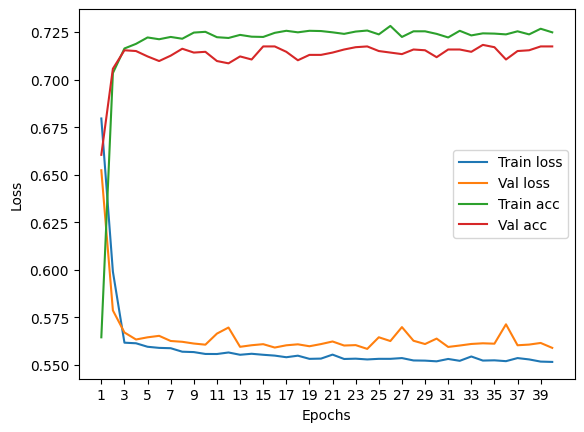

****************************************************************************************************



Particles per jet: 3


118it [00:00, 236.93it/s]


Train Epoch: 0 	Loss: 0.677402, Accuracy: 4505/7500 (60%)
Val Epoch: 0 	Loss: 0.649823, Accuracy: 1728/2500 (69%)



118it [00:00, 233.38it/s]


Train Epoch: 1 	Loss: 0.605447, Accuracy: 5287/7500 (70%)
Val Epoch: 1 	Loss: 0.573125, Accuracy: 1853/2500 (74%)



118it [00:00, 233.32it/s]


Train Epoch: 2 	Loss: 0.562846, Accuracy: 5442/7500 (73%)
Val Epoch: 2 	Loss: 0.547001, Accuracy: 1872/2500 (75%)



118it [00:00, 234.95it/s]


Train Epoch: 3 	Loss: 0.553617, Accuracy: 5475/7500 (73%)
Val Epoch: 3 	Loss: 0.542189, Accuracy: 1867/2500 (75%)



118it [00:00, 237.32it/s]


Train Epoch: 4 	Loss: 0.554998, Accuracy: 5453/7500 (73%)
Val Epoch: 4 	Loss: 0.532901, Accuracy: 1885/2500 (75%)



118it [00:00, 236.84it/s]


Train Epoch: 5 	Loss: 0.553110, Accuracy: 5453/7500 (73%)
Val Epoch: 5 	Loss: 0.538977, Accuracy: 1876/2500 (75%)



118it [00:00, 233.04it/s]


Train Epoch: 6 	Loss: 0.550632, Accuracy: 5485/7500 (73%)
Val Epoch: 6 	Loss: 0.549197, Accuracy: 1882/2500 (75%)



118it [00:00, 152.19it/s]


Train Epoch: 7 	Loss: 0.549939, Accuracy: 5516/7500 (74%)
Val Epoch: 7 	Loss: 0.538834, Accuracy: 1871/2500 (75%)



118it [00:00, 230.44it/s]


Train Epoch: 8 	Loss: 0.551416, Accuracy: 5467/7500 (73%)
Val Epoch: 8 	Loss: 0.537085, Accuracy: 1877/2500 (75%)



118it [00:00, 237.95it/s]


Train Epoch: 9 	Loss: 0.550080, Accuracy: 5473/7500 (73%)
Val Epoch: 9 	Loss: 0.543572, Accuracy: 1869/2500 (75%)



118it [00:00, 235.69it/s]


Train Epoch: 10 	Loss: 0.549270, Accuracy: 5459/7500 (73%)
Val Epoch: 10 	Loss: 0.547934, Accuracy: 1859/2500 (74%)



118it [00:00, 230.31it/s]


Train Epoch: 11 	Loss: 0.551112, Accuracy: 5470/7500 (73%)
Val Epoch: 11 	Loss: 0.539926, Accuracy: 1872/2500 (75%)



118it [00:00, 238.93it/s]


Train Epoch: 12 	Loss: 0.549224, Accuracy: 5474/7500 (73%)
Val Epoch: 12 	Loss: 0.543376, Accuracy: 1862/2500 (74%)



118it [00:00, 232.54it/s]


Train Epoch: 13 	Loss: 0.550164, Accuracy: 5476/7500 (73%)
Val Epoch: 13 	Loss: 0.551921, Accuracy: 1874/2500 (75%)



118it [00:00, 221.70it/s]


Train Epoch: 14 	Loss: 0.550382, Accuracy: 5478/7500 (73%)
Val Epoch: 14 	Loss: 0.568390, Accuracy: 1807/2500 (72%)



118it [00:00, 192.42it/s]


Train Epoch: 15 	Loss: 0.548412, Accuracy: 5477/7500 (73%)
Val Epoch: 15 	Loss: 0.553631, Accuracy: 1859/2500 (74%)



118it [00:00, 174.35it/s]


Train Epoch: 16 	Loss: 0.547938, Accuracy: 5485/7500 (73%)
Val Epoch: 16 	Loss: 0.555361, Accuracy: 1878/2500 (75%)



118it [00:00, 198.66it/s]


Train Epoch: 17 	Loss: 0.547438, Accuracy: 5482/7500 (73%)
Val Epoch: 17 	Loss: 0.539952, Accuracy: 1875/2500 (75%)



118it [00:00, 179.75it/s]


Train Epoch: 18 	Loss: 0.548168, Accuracy: 5488/7500 (73%)
Val Epoch: 18 	Loss: 0.554857, Accuracy: 1825/2500 (73%)



118it [00:00, 192.31it/s]


Train Epoch: 19 	Loss: 0.547563, Accuracy: 5511/7500 (73%)
Val Epoch: 19 	Loss: 0.550409, Accuracy: 1885/2500 (75%)



118it [00:00, 155.91it/s]


Train Epoch: 20 	Loss: 0.548798, Accuracy: 5493/7500 (73%)
Val Epoch: 20 	Loss: 0.552287, Accuracy: 1862/2500 (74%)



118it [00:00, 170.58it/s]


Train Epoch: 21 	Loss: 0.549516, Accuracy: 5470/7500 (73%)
Val Epoch: 21 	Loss: 0.553112, Accuracy: 1871/2500 (75%)



118it [00:00, 222.98it/s]


Train Epoch: 22 	Loss: 0.548632, Accuracy: 5494/7500 (73%)
Val Epoch: 22 	Loss: 0.540056, Accuracy: 1882/2500 (75%)



118it [00:00, 228.94it/s]


Train Epoch: 23 	Loss: 0.549379, Accuracy: 5492/7500 (73%)
Val Epoch: 23 	Loss: 0.538378, Accuracy: 1876/2500 (75%)



118it [00:00, 206.00it/s]


Train Epoch: 24 	Loss: 0.550658, Accuracy: 5472/7500 (73%)
Val Epoch: 24 	Loss: 0.552473, Accuracy: 1877/2500 (75%)



118it [00:00, 239.23it/s]


Train Epoch: 25 	Loss: 0.546976, Accuracy: 5492/7500 (73%)
Val Epoch: 25 	Loss: 0.549360, Accuracy: 1853/2500 (74%)



118it [00:00, 232.56it/s]


Train Epoch: 26 	Loss: 0.547532, Accuracy: 5457/7500 (73%)
Val Epoch: 26 	Loss: 0.541474, Accuracy: 1874/2500 (75%)



118it [00:00, 232.32it/s]


Train Epoch: 27 	Loss: 0.546532, Accuracy: 5481/7500 (73%)
Val Epoch: 27 	Loss: 0.535820, Accuracy: 1872/2500 (75%)



118it [00:00, 225.67it/s]


Train Epoch: 28 	Loss: 0.549150, Accuracy: 5486/7500 (73%)
Val Epoch: 28 	Loss: 0.533913, Accuracy: 1879/2500 (75%)



118it [00:00, 230.18it/s]


Train Epoch: 29 	Loss: 0.546567, Accuracy: 5478/7500 (73%)
Val Epoch: 29 	Loss: 0.542916, Accuracy: 1878/2500 (75%)



118it [00:00, 227.43it/s]


Train Epoch: 30 	Loss: 0.548853, Accuracy: 5485/7500 (73%)
Val Epoch: 30 	Loss: 0.533173, Accuracy: 1883/2500 (75%)



118it [00:00, 224.87it/s]


Train Epoch: 31 	Loss: 0.545454, Accuracy: 5503/7500 (73%)
Val Epoch: 31 	Loss: 0.539089, Accuracy: 1867/2500 (75%)



118it [00:00, 233.59it/s]


Train Epoch: 32 	Loss: 0.549628, Accuracy: 5484/7500 (73%)
Val Epoch: 32 	Loss: 0.539404, Accuracy: 1879/2500 (75%)



118it [00:00, 231.75it/s]


Train Epoch: 33 	Loss: 0.544959, Accuracy: 5483/7500 (73%)
Val Epoch: 33 	Loss: 0.537206, Accuracy: 1872/2500 (75%)



118it [00:00, 232.32it/s]


Train Epoch: 34 	Loss: 0.547224, Accuracy: 5523/7500 (74%)
Val Epoch: 34 	Loss: 0.537208, Accuracy: 1875/2500 (75%)



118it [00:00, 229.74it/s]


Train Epoch: 35 	Loss: 0.545868, Accuracy: 5483/7500 (73%)
Val Epoch: 35 	Loss: 0.544801, Accuracy: 1877/2500 (75%)



118it [00:00, 235.32it/s]


Train Epoch: 36 	Loss: 0.545361, Accuracy: 5497/7500 (73%)
Val Epoch: 36 	Loss: 0.544072, Accuracy: 1881/2500 (75%)



118it [00:00, 166.55it/s]


Train Epoch: 37 	Loss: 0.544910, Accuracy: 5481/7500 (73%)
Val Epoch: 37 	Loss: 0.546397, Accuracy: 1881/2500 (75%)



118it [00:00, 157.60it/s]


Train Epoch: 38 	Loss: 0.548314, Accuracy: 5477/7500 (73%)
Val Epoch: 38 	Loss: 0.542328, Accuracy: 1877/2500 (75%)



118it [00:00, 183.60it/s]


Train Epoch: 39 	Loss: 0.547841, Accuracy: 5503/7500 (73%)
Val Epoch: 39 	Loss: 0.538550, Accuracy: 1872/2500 (75%)

Test accuracy:  72.92


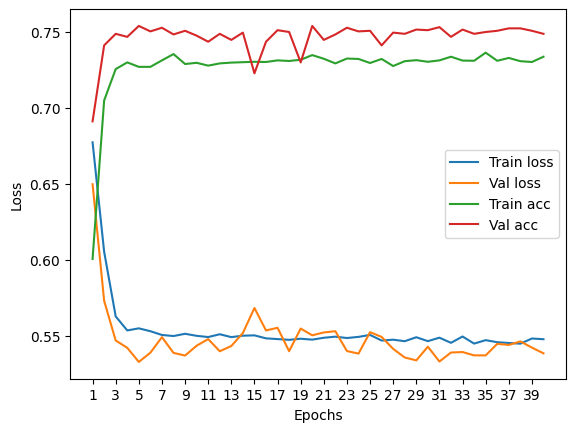

****************************************************************************************************



118it [00:00, 244.24it/s]


Train Epoch: 0 	Loss: 0.677616, Accuracy: 4470/7500 (60%)
Val Epoch: 0 	Loss: 0.650319, Accuracy: 1756/2500 (70%)



118it [00:00, 239.65it/s]


Train Epoch: 1 	Loss: 0.607323, Accuracy: 5315/7500 (71%)
Val Epoch: 1 	Loss: 0.571551, Accuracy: 1846/2500 (74%)



118it [00:00, 231.42it/s]


Train Epoch: 2 	Loss: 0.566650, Accuracy: 5414/7500 (72%)
Val Epoch: 2 	Loss: 0.559266, Accuracy: 1822/2500 (73%)



118it [00:00, 213.54it/s]


Train Epoch: 3 	Loss: 0.562689, Accuracy: 5431/7500 (72%)
Val Epoch: 3 	Loss: 0.553759, Accuracy: 1842/2500 (74%)



118it [00:00, 232.64it/s]


Train Epoch: 4 	Loss: 0.563092, Accuracy: 5474/7500 (73%)
Val Epoch: 4 	Loss: 0.560360, Accuracy: 1855/2500 (74%)



118it [00:00, 232.15it/s]


Train Epoch: 5 	Loss: 0.559379, Accuracy: 5407/7500 (72%)
Val Epoch: 5 	Loss: 0.556552, Accuracy: 1820/2500 (73%)



118it [00:00, 232.72it/s]


Train Epoch: 6 	Loss: 0.559504, Accuracy: 5421/7500 (72%)
Val Epoch: 6 	Loss: 0.554151, Accuracy: 1847/2500 (74%)



118it [00:00, 203.41it/s]


Train Epoch: 7 	Loss: 0.559280, Accuracy: 5401/7500 (72%)
Val Epoch: 7 	Loss: 0.551635, Accuracy: 1843/2500 (74%)



118it [00:00, 225.27it/s]


Train Epoch: 8 	Loss: 0.563709, Accuracy: 5424/7500 (72%)
Val Epoch: 8 	Loss: 0.558315, Accuracy: 1840/2500 (74%)



118it [00:00, 160.62it/s]


Train Epoch: 9 	Loss: 0.556543, Accuracy: 5456/7500 (73%)
Val Epoch: 9 	Loss: 0.552822, Accuracy: 1836/2500 (73%)



118it [00:00, 197.02it/s]


Train Epoch: 10 	Loss: 0.557599, Accuracy: 5462/7500 (73%)
Val Epoch: 10 	Loss: 0.561103, Accuracy: 1847/2500 (74%)



118it [00:00, 182.77it/s]


Train Epoch: 11 	Loss: 0.557694, Accuracy: 5436/7500 (72%)
Val Epoch: 11 	Loss: 0.558353, Accuracy: 1838/2500 (74%)



118it [00:00, 238.77it/s]


Train Epoch: 12 	Loss: 0.558154, Accuracy: 5426/7500 (72%)
Val Epoch: 12 	Loss: 0.580208, Accuracy: 1829/2500 (73%)



118it [00:00, 235.80it/s]


Train Epoch: 13 	Loss: 0.557450, Accuracy: 5445/7500 (73%)
Val Epoch: 13 	Loss: 0.556666, Accuracy: 1855/2500 (74%)



118it [00:00, 219.90it/s]


Train Epoch: 14 	Loss: 0.557886, Accuracy: 5435/7500 (72%)
Val Epoch: 14 	Loss: 0.558746, Accuracy: 1832/2500 (73%)



118it [00:00, 233.84it/s]


Train Epoch: 15 	Loss: 0.556305, Accuracy: 5413/7500 (72%)
Val Epoch: 15 	Loss: 0.564573, Accuracy: 1811/2500 (72%)



118it [00:00, 233.23it/s]


Train Epoch: 16 	Loss: 0.557946, Accuracy: 5454/7500 (73%)
Val Epoch: 16 	Loss: 0.563583, Accuracy: 1829/2500 (73%)



118it [00:00, 229.54it/s]


Train Epoch: 17 	Loss: 0.557414, Accuracy: 5442/7500 (73%)
Val Epoch: 17 	Loss: 0.545732, Accuracy: 1852/2500 (74%)



118it [00:00, 191.50it/s]


Train Epoch: 18 	Loss: 0.560143, Accuracy: 5404/7500 (72%)
Val Epoch: 18 	Loss: 0.555874, Accuracy: 1844/2500 (74%)



118it [00:00, 212.11it/s]


Train Epoch: 19 	Loss: 0.555746, Accuracy: 5445/7500 (73%)
Val Epoch: 19 	Loss: 0.552361, Accuracy: 1845/2500 (74%)



118it [00:00, 233.56it/s]


Train Epoch: 20 	Loss: 0.557428, Accuracy: 5443/7500 (73%)
Val Epoch: 20 	Loss: 0.554545, Accuracy: 1850/2500 (74%)



118it [00:00, 223.39it/s]


Train Epoch: 21 	Loss: 0.557945, Accuracy: 5438/7500 (73%)
Val Epoch: 21 	Loss: 0.561590, Accuracy: 1854/2500 (74%)



118it [00:00, 236.71it/s]


Train Epoch: 22 	Loss: 0.557600, Accuracy: 5454/7500 (73%)
Val Epoch: 22 	Loss: 0.560602, Accuracy: 1853/2500 (74%)



118it [00:00, 221.89it/s]


Train Epoch: 23 	Loss: 0.556979, Accuracy: 5453/7500 (73%)
Val Epoch: 23 	Loss: 0.559024, Accuracy: 1848/2500 (74%)



118it [00:00, 240.28it/s]


Train Epoch: 24 	Loss: 0.558007, Accuracy: 5445/7500 (73%)
Val Epoch: 24 	Loss: 0.557165, Accuracy: 1830/2500 (73%)



118it [00:00, 232.60it/s]


Train Epoch: 25 	Loss: 0.557325, Accuracy: 5411/7500 (72%)
Val Epoch: 25 	Loss: 0.569844, Accuracy: 1846/2500 (74%)



118it [00:00, 226.60it/s]


Train Epoch: 26 	Loss: 0.556684, Accuracy: 5442/7500 (73%)
Val Epoch: 26 	Loss: 0.550485, Accuracy: 1847/2500 (74%)



118it [00:00, 229.68it/s]


Train Epoch: 27 	Loss: 0.557940, Accuracy: 5457/7500 (73%)
Val Epoch: 27 	Loss: 0.554251, Accuracy: 1839/2500 (74%)



118it [00:00, 233.42it/s]


Train Epoch: 28 	Loss: 0.557851, Accuracy: 5443/7500 (73%)
Val Epoch: 28 	Loss: 0.584443, Accuracy: 1795/2500 (72%)



118it [00:00, 240.82it/s]


Train Epoch: 29 	Loss: 0.557089, Accuracy: 5447/7500 (73%)
Val Epoch: 29 	Loss: 0.550301, Accuracy: 1857/2500 (74%)



118it [00:00, 232.92it/s]


Train Epoch: 30 	Loss: 0.555212, Accuracy: 5436/7500 (72%)
Val Epoch: 30 	Loss: 0.556493, Accuracy: 1857/2500 (74%)



118it [00:00, 235.88it/s]


Train Epoch: 31 	Loss: 0.555252, Accuracy: 5448/7500 (73%)
Val Epoch: 31 	Loss: 0.551214, Accuracy: 1838/2500 (74%)



118it [00:00, 173.76it/s]


Train Epoch: 32 	Loss: 0.555953, Accuracy: 5451/7500 (73%)
Val Epoch: 32 	Loss: 0.557216, Accuracy: 1850/2500 (74%)



118it [00:00, 199.04it/s]


Train Epoch: 33 	Loss: 0.559256, Accuracy: 5458/7500 (73%)
Val Epoch: 33 	Loss: 0.547409, Accuracy: 1843/2500 (74%)



118it [00:00, 174.26it/s]


Train Epoch: 34 	Loss: 0.556815, Accuracy: 5441/7500 (73%)
Val Epoch: 34 	Loss: 0.549565, Accuracy: 1853/2500 (74%)



118it [00:00, 172.82it/s]


Train Epoch: 35 	Loss: 0.559827, Accuracy: 5431/7500 (72%)
Val Epoch: 35 	Loss: 0.564397, Accuracy: 1854/2500 (74%)



118it [00:00, 197.51it/s]


Train Epoch: 36 	Loss: 0.556669, Accuracy: 5445/7500 (73%)
Val Epoch: 36 	Loss: 0.571614, Accuracy: 1832/2500 (73%)



118it [00:00, 224.17it/s]


Train Epoch: 37 	Loss: 0.555962, Accuracy: 5430/7500 (72%)
Val Epoch: 37 	Loss: 0.571015, Accuracy: 1833/2500 (73%)



118it [00:00, 239.89it/s]


Train Epoch: 38 	Loss: 0.555414, Accuracy: 5444/7500 (73%)
Val Epoch: 38 	Loss: 0.544836, Accuracy: 1860/2500 (74%)



118it [00:00, 209.73it/s]


Train Epoch: 39 	Loss: 0.555552, Accuracy: 5435/7500 (72%)
Val Epoch: 39 	Loss: 0.552304, Accuracy: 1842/2500 (74%)

Test accuracy:  72.11999999999999


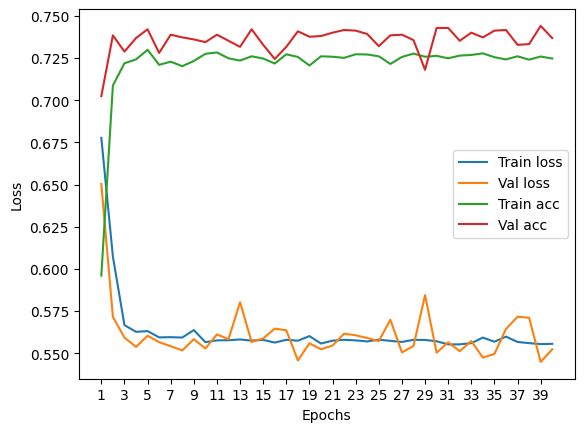

****************************************************************************************************



118it [00:00, 232.98it/s]


Train Epoch: 0 	Loss: 0.684428, Accuracy: 4291/7500 (57%)
Val Epoch: 0 	Loss: 0.661602, Accuracy: 1717/2500 (69%)



118it [00:00, 230.49it/s]


Train Epoch: 1 	Loss: 0.603906, Accuracy: 5277/7500 (70%)
Val Epoch: 1 	Loss: 0.572168, Accuracy: 1823/2500 (73%)



118it [00:00, 233.57it/s]


Train Epoch: 2 	Loss: 0.556432, Accuracy: 5460/7500 (73%)
Val Epoch: 2 	Loss: 0.570792, Accuracy: 1818/2500 (73%)



118it [00:00, 226.49it/s]


Train Epoch: 3 	Loss: 0.549697, Accuracy: 5483/7500 (73%)
Val Epoch: 3 	Loss: 0.556676, Accuracy: 1836/2500 (73%)



118it [00:00, 172.00it/s]


Train Epoch: 4 	Loss: 0.549986, Accuracy: 5471/7500 (73%)
Val Epoch: 4 	Loss: 0.546096, Accuracy: 1844/2500 (74%)



118it [00:00, 199.94it/s]


Train Epoch: 5 	Loss: 0.547127, Accuracy: 5446/7500 (73%)
Val Epoch: 5 	Loss: 0.559041, Accuracy: 1839/2500 (74%)



118it [00:00, 175.58it/s]


Train Epoch: 6 	Loss: 0.546856, Accuracy: 5462/7500 (73%)
Val Epoch: 6 	Loss: 0.550479, Accuracy: 1837/2500 (73%)



118it [00:00, 229.76it/s]


Train Epoch: 7 	Loss: 0.546169, Accuracy: 5477/7500 (73%)
Val Epoch: 7 	Loss: 0.542076, Accuracy: 1844/2500 (74%)



118it [00:00, 233.57it/s]


Train Epoch: 8 	Loss: 0.543330, Accuracy: 5496/7500 (73%)
Val Epoch: 8 	Loss: 0.550515, Accuracy: 1840/2500 (74%)



118it [00:00, 234.84it/s]


Train Epoch: 9 	Loss: 0.545193, Accuracy: 5484/7500 (73%)
Val Epoch: 9 	Loss: 0.552342, Accuracy: 1836/2500 (73%)



118it [00:00, 231.42it/s]


Train Epoch: 10 	Loss: 0.547564, Accuracy: 5460/7500 (73%)
Val Epoch: 10 	Loss: 0.542310, Accuracy: 1847/2500 (74%)



118it [00:00, 222.77it/s]


Train Epoch: 11 	Loss: 0.548672, Accuracy: 5471/7500 (73%)
Val Epoch: 11 	Loss: 0.548038, Accuracy: 1839/2500 (74%)



118it [00:00, 189.19it/s]


Train Epoch: 12 	Loss: 0.543250, Accuracy: 5480/7500 (73%)
Val Epoch: 12 	Loss: 0.549002, Accuracy: 1841/2500 (74%)



118it [00:00, 194.51it/s]


Train Epoch: 13 	Loss: 0.542965, Accuracy: 5481/7500 (73%)
Val Epoch: 13 	Loss: 0.558544, Accuracy: 1843/2500 (74%)



118it [00:00, 199.56it/s]


Train Epoch: 14 	Loss: 0.542702, Accuracy: 5479/7500 (73%)
Val Epoch: 14 	Loss: 0.544366, Accuracy: 1846/2500 (74%)



118it [00:00, 230.58it/s]


Train Epoch: 15 	Loss: 0.544962, Accuracy: 5472/7500 (73%)
Val Epoch: 15 	Loss: 0.546688, Accuracy: 1842/2500 (74%)



118it [00:00, 234.57it/s]


Train Epoch: 16 	Loss: 0.543172, Accuracy: 5463/7500 (73%)
Val Epoch: 16 	Loss: 0.542577, Accuracy: 1842/2500 (74%)



118it [00:00, 237.91it/s]


Train Epoch: 17 	Loss: 0.544635, Accuracy: 5470/7500 (73%)
Val Epoch: 17 	Loss: 0.546446, Accuracy: 1849/2500 (74%)



118it [00:00, 189.87it/s]


Train Epoch: 18 	Loss: 0.544579, Accuracy: 5476/7500 (73%)
Val Epoch: 18 	Loss: 0.549470, Accuracy: 1839/2500 (74%)



118it [00:00, 233.30it/s]


Train Epoch: 19 	Loss: 0.544548, Accuracy: 5475/7500 (73%)
Val Epoch: 19 	Loss: 0.548318, Accuracy: 1847/2500 (74%)



118it [00:00, 232.61it/s]


Train Epoch: 20 	Loss: 0.543758, Accuracy: 5506/7500 (73%)
Val Epoch: 20 	Loss: 0.552558, Accuracy: 1839/2500 (74%)



118it [00:00, 234.70it/s]


Train Epoch: 21 	Loss: 0.542303, Accuracy: 5496/7500 (73%)
Val Epoch: 21 	Loss: 0.538891, Accuracy: 1847/2500 (74%)



118it [00:00, 220.89it/s]


Train Epoch: 22 	Loss: 0.543903, Accuracy: 5482/7500 (73%)
Val Epoch: 22 	Loss: 0.543448, Accuracy: 1837/2500 (73%)



118it [00:00, 225.33it/s]


Train Epoch: 23 	Loss: 0.546323, Accuracy: 5493/7500 (73%)
Val Epoch: 23 	Loss: 0.559289, Accuracy: 1807/2500 (72%)



118it [00:00, 236.83it/s]


Train Epoch: 24 	Loss: 0.543069, Accuracy: 5475/7500 (73%)
Val Epoch: 24 	Loss: 0.548290, Accuracy: 1844/2500 (74%)



118it [00:00, 235.32it/s]


Train Epoch: 25 	Loss: 0.542347, Accuracy: 5486/7500 (73%)
Val Epoch: 25 	Loss: 0.554636, Accuracy: 1837/2500 (73%)



118it [00:00, 214.78it/s]


Train Epoch: 26 	Loss: 0.544071, Accuracy: 5462/7500 (73%)
Val Epoch: 26 	Loss: 0.558420, Accuracy: 1842/2500 (74%)



118it [00:00, 168.45it/s]


Train Epoch: 27 	Loss: 0.543498, Accuracy: 5480/7500 (73%)
Val Epoch: 27 	Loss: 0.541832, Accuracy: 1842/2500 (74%)



118it [00:00, 163.60it/s]


Train Epoch: 28 	Loss: 0.543152, Accuracy: 5497/7500 (73%)
Val Epoch: 28 	Loss: 0.548348, Accuracy: 1841/2500 (74%)



118it [00:00, 164.16it/s]


Train Epoch: 29 	Loss: 0.542353, Accuracy: 5487/7500 (73%)
Val Epoch: 29 	Loss: 0.545144, Accuracy: 1845/2500 (74%)



118it [00:00, 152.82it/s]


Train Epoch: 30 	Loss: 0.543751, Accuracy: 5477/7500 (73%)
Val Epoch: 30 	Loss: 0.548609, Accuracy: 1844/2500 (74%)



118it [00:00, 196.16it/s]


Train Epoch: 31 	Loss: 0.546245, Accuracy: 5472/7500 (73%)
Val Epoch: 31 	Loss: 0.565109, Accuracy: 1834/2500 (73%)



118it [00:00, 238.07it/s]


Train Epoch: 32 	Loss: 0.545554, Accuracy: 5488/7500 (73%)
Val Epoch: 32 	Loss: 0.548432, Accuracy: 1835/2500 (73%)



118it [00:00, 223.38it/s]


Train Epoch: 33 	Loss: 0.545129, Accuracy: 5496/7500 (73%)
Val Epoch: 33 	Loss: 0.547121, Accuracy: 1841/2500 (74%)



118it [00:00, 237.04it/s]


Train Epoch: 34 	Loss: 0.543691, Accuracy: 5498/7500 (73%)
Val Epoch: 34 	Loss: 0.543149, Accuracy: 1847/2500 (74%)



118it [00:00, 227.72it/s]


Train Epoch: 35 	Loss: 0.542188, Accuracy: 5474/7500 (73%)
Val Epoch: 35 	Loss: 0.562964, Accuracy: 1839/2500 (74%)



118it [00:00, 222.81it/s]


Train Epoch: 36 	Loss: 0.544987, Accuracy: 5465/7500 (73%)
Val Epoch: 36 	Loss: 0.543338, Accuracy: 1844/2500 (74%)



118it [00:00, 236.52it/s]


Train Epoch: 37 	Loss: 0.545778, Accuracy: 5488/7500 (73%)
Val Epoch: 37 	Loss: 0.558624, Accuracy: 1791/2500 (72%)



118it [00:00, 228.79it/s]


Train Epoch: 38 	Loss: 0.545676, Accuracy: 5458/7500 (73%)
Val Epoch: 38 	Loss: 0.547665, Accuracy: 1843/2500 (74%)



118it [00:00, 199.68it/s]


Train Epoch: 39 	Loss: 0.545534, Accuracy: 5484/7500 (73%)
Val Epoch: 39 	Loss: 0.556726, Accuracy: 1853/2500 (74%)

Test accuracy:  74.2


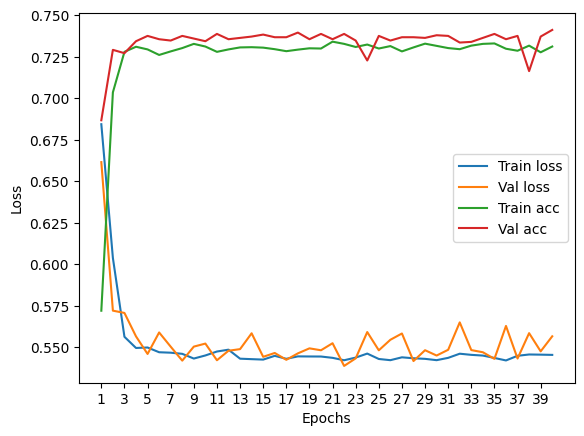

****************************************************************************************************



118it [00:00, 215.82it/s]


Train Epoch: 0 	Loss: 0.677043, Accuracy: 4607/7500 (61%)
Val Epoch: 0 	Loss: 0.647722, Accuracy: 1747/2500 (70%)



118it [00:00, 236.53it/s]


Train Epoch: 1 	Loss: 0.596828, Accuracy: 5339/7500 (71%)
Val Epoch: 1 	Loss: 0.577258, Accuracy: 1792/2500 (72%)



118it [00:00, 233.40it/s]


Train Epoch: 2 	Loss: 0.564890, Accuracy: 5433/7500 (72%)
Val Epoch: 2 	Loss: 0.560522, Accuracy: 1835/2500 (73%)



118it [00:00, 235.07it/s]


Train Epoch: 3 	Loss: 0.554840, Accuracy: 5450/7500 (73%)
Val Epoch: 3 	Loss: 0.557732, Accuracy: 1836/2500 (73%)



118it [00:00, 230.55it/s]


Train Epoch: 4 	Loss: 0.555310, Accuracy: 5472/7500 (73%)
Val Epoch: 4 	Loss: 0.564186, Accuracy: 1805/2500 (72%)



118it [00:00, 230.77it/s]


Train Epoch: 5 	Loss: 0.554748, Accuracy: 5462/7500 (73%)
Val Epoch: 5 	Loss: 0.558454, Accuracy: 1815/2500 (73%)



118it [00:00, 229.26it/s]


Train Epoch: 6 	Loss: 0.555951, Accuracy: 5450/7500 (73%)
Val Epoch: 6 	Loss: 0.567406, Accuracy: 1842/2500 (74%)



118it [00:00, 229.58it/s]


Train Epoch: 7 	Loss: 0.556842, Accuracy: 5443/7500 (73%)
Val Epoch: 7 	Loss: 0.562633, Accuracy: 1837/2500 (73%)



118it [00:00, 235.34it/s]


Train Epoch: 8 	Loss: 0.558291, Accuracy: 5403/7500 (72%)
Val Epoch: 8 	Loss: 0.565592, Accuracy: 1842/2500 (74%)



118it [00:00, 234.53it/s]


Train Epoch: 9 	Loss: 0.556348, Accuracy: 5463/7500 (73%)
Val Epoch: 9 	Loss: 0.557415, Accuracy: 1849/2500 (74%)



118it [00:00, 233.71it/s]


Train Epoch: 10 	Loss: 0.552958, Accuracy: 5463/7500 (73%)
Val Epoch: 10 	Loss: 0.552285, Accuracy: 1840/2500 (74%)



118it [00:00, 236.37it/s]


Train Epoch: 11 	Loss: 0.552626, Accuracy: 5487/7500 (73%)
Val Epoch: 11 	Loss: 0.567871, Accuracy: 1825/2500 (73%)



118it [00:00, 233.88it/s]


Train Epoch: 12 	Loss: 0.554918, Accuracy: 5455/7500 (73%)
Val Epoch: 12 	Loss: 0.555016, Accuracy: 1831/2500 (73%)



118it [00:00, 233.26it/s]


Train Epoch: 13 	Loss: 0.554808, Accuracy: 5476/7500 (73%)
Val Epoch: 13 	Loss: 0.556211, Accuracy: 1836/2500 (73%)



118it [00:00, 228.63it/s]


Train Epoch: 14 	Loss: 0.552551, Accuracy: 5467/7500 (73%)
Val Epoch: 14 	Loss: 0.557265, Accuracy: 1835/2500 (73%)



118it [00:00, 234.69it/s]


Train Epoch: 15 	Loss: 0.550992, Accuracy: 5494/7500 (73%)
Val Epoch: 15 	Loss: 0.565863, Accuracy: 1844/2500 (74%)



118it [00:00, 236.33it/s]


Train Epoch: 16 	Loss: 0.550388, Accuracy: 5470/7500 (73%)
Val Epoch: 16 	Loss: 0.559956, Accuracy: 1816/2500 (73%)



118it [00:00, 237.07it/s]


Train Epoch: 17 	Loss: 0.551878, Accuracy: 5474/7500 (73%)
Val Epoch: 17 	Loss: 0.570380, Accuracy: 1822/2500 (73%)



118it [00:00, 236.61it/s]


Train Epoch: 18 	Loss: 0.550775, Accuracy: 5485/7500 (73%)
Val Epoch: 18 	Loss: 0.568442, Accuracy: 1797/2500 (72%)



118it [00:00, 236.89it/s]


Train Epoch: 19 	Loss: 0.550857, Accuracy: 5496/7500 (73%)
Val Epoch: 19 	Loss: 0.560525, Accuracy: 1836/2500 (73%)



118it [00:00, 239.57it/s]


Train Epoch: 20 	Loss: 0.550724, Accuracy: 5476/7500 (73%)
Val Epoch: 20 	Loss: 0.564963, Accuracy: 1839/2500 (74%)



118it [00:00, 203.27it/s]


Train Epoch: 21 	Loss: 0.550266, Accuracy: 5462/7500 (73%)
Val Epoch: 21 	Loss: 0.561001, Accuracy: 1835/2500 (73%)



118it [00:00, 171.42it/s]


Train Epoch: 22 	Loss: 0.551277, Accuracy: 5455/7500 (73%)
Val Epoch: 22 	Loss: 0.556556, Accuracy: 1828/2500 (73%)



118it [00:00, 199.00it/s]


Train Epoch: 23 	Loss: 0.551821, Accuracy: 5479/7500 (73%)
Val Epoch: 23 	Loss: 0.554019, Accuracy: 1846/2500 (74%)



118it [00:00, 198.91it/s]


Train Epoch: 24 	Loss: 0.551682, Accuracy: 5489/7500 (73%)
Val Epoch: 24 	Loss: 0.562351, Accuracy: 1847/2500 (74%)



118it [00:00, 237.13it/s]


Train Epoch: 25 	Loss: 0.550306, Accuracy: 5447/7500 (73%)
Val Epoch: 25 	Loss: 0.575787, Accuracy: 1828/2500 (73%)



118it [00:00, 235.64it/s]


Train Epoch: 26 	Loss: 0.551273, Accuracy: 5478/7500 (73%)
Val Epoch: 26 	Loss: 0.571672, Accuracy: 1840/2500 (74%)



118it [00:00, 238.10it/s]


Train Epoch: 27 	Loss: 0.551954, Accuracy: 5492/7500 (73%)
Val Epoch: 27 	Loss: 0.558041, Accuracy: 1831/2500 (73%)



118it [00:00, 234.01it/s]


Train Epoch: 28 	Loss: 0.549946, Accuracy: 5480/7500 (73%)
Val Epoch: 28 	Loss: 0.561087, Accuracy: 1840/2500 (74%)



118it [00:00, 227.53it/s]


Train Epoch: 29 	Loss: 0.553247, Accuracy: 5476/7500 (73%)
Val Epoch: 29 	Loss: 0.553800, Accuracy: 1837/2500 (73%)



118it [00:00, 229.25it/s]


Train Epoch: 30 	Loss: 0.551791, Accuracy: 5484/7500 (73%)
Val Epoch: 30 	Loss: 0.552428, Accuracy: 1829/2500 (73%)



118it [00:00, 238.08it/s]


Train Epoch: 31 	Loss: 0.550525, Accuracy: 5473/7500 (73%)
Val Epoch: 31 	Loss: 0.560731, Accuracy: 1836/2500 (73%)



118it [00:00, 224.47it/s]


Train Epoch: 32 	Loss: 0.551878, Accuracy: 5479/7500 (73%)
Val Epoch: 32 	Loss: 0.558384, Accuracy: 1843/2500 (74%)



118it [00:00, 233.11it/s]


Train Epoch: 33 	Loss: 0.550920, Accuracy: 5474/7500 (73%)
Val Epoch: 33 	Loss: 0.553058, Accuracy: 1841/2500 (74%)



118it [00:00, 230.48it/s]


Train Epoch: 34 	Loss: 0.551478, Accuracy: 5503/7500 (73%)
Val Epoch: 34 	Loss: 0.560240, Accuracy: 1834/2500 (73%)



118it [00:00, 234.27it/s]


Train Epoch: 35 	Loss: 0.551915, Accuracy: 5470/7500 (73%)
Val Epoch: 35 	Loss: 0.551347, Accuracy: 1841/2500 (74%)



118it [00:00, 232.42it/s]


Train Epoch: 36 	Loss: 0.548745, Accuracy: 5461/7500 (73%)
Val Epoch: 36 	Loss: 0.556525, Accuracy: 1844/2500 (74%)



118it [00:00, 235.30it/s]


Train Epoch: 37 	Loss: 0.549520, Accuracy: 5469/7500 (73%)
Val Epoch: 37 	Loss: 0.554311, Accuracy: 1832/2500 (73%)



118it [00:00, 234.52it/s]


Train Epoch: 38 	Loss: 0.552462, Accuracy: 5473/7500 (73%)
Val Epoch: 38 	Loss: 0.556535, Accuracy: 1835/2500 (73%)



118it [00:00, 234.44it/s]


Train Epoch: 39 	Loss: 0.552163, Accuracy: 5472/7500 (73%)
Val Epoch: 39 	Loss: 0.556759, Accuracy: 1834/2500 (73%)

Test accuracy:  74.0


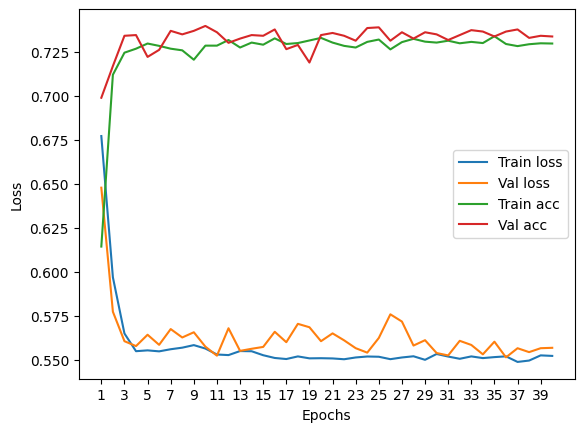

****************************************************************************************************



118it [00:00, 214.10it/s]


Train Epoch: 0 	Loss: 0.676862, Accuracy: 4420/7500 (59%)
Val Epoch: 0 	Loss: 0.651317, Accuracy: 1743/2500 (70%)



118it [00:00, 225.15it/s]


Train Epoch: 1 	Loss: 0.591344, Accuracy: 5381/7500 (72%)
Val Epoch: 1 	Loss: 0.584386, Accuracy: 1808/2500 (72%)



118it [00:00, 237.72it/s]


Train Epoch: 2 	Loss: 0.557244, Accuracy: 5425/7500 (72%)
Val Epoch: 2 	Loss: 0.573578, Accuracy: 1798/2500 (72%)



118it [00:00, 233.54it/s]


Train Epoch: 3 	Loss: 0.551149, Accuracy: 5456/7500 (73%)
Val Epoch: 3 	Loss: 0.570718, Accuracy: 1809/2500 (72%)



118it [00:00, 223.26it/s]


Train Epoch: 4 	Loss: 0.551225, Accuracy: 5444/7500 (73%)
Val Epoch: 4 	Loss: 0.578634, Accuracy: 1790/2500 (72%)



118it [00:00, 235.77it/s]


Train Epoch: 5 	Loss: 0.548360, Accuracy: 5453/7500 (73%)
Val Epoch: 5 	Loss: 0.571192, Accuracy: 1803/2500 (72%)



118it [00:00, 232.18it/s]


Train Epoch: 6 	Loss: 0.548074, Accuracy: 5462/7500 (73%)
Val Epoch: 6 	Loss: 0.582421, Accuracy: 1795/2500 (72%)



118it [00:00, 218.04it/s]


Train Epoch: 7 	Loss: 0.549052, Accuracy: 5440/7500 (73%)
Val Epoch: 7 	Loss: 0.565586, Accuracy: 1815/2500 (73%)



118it [00:00, 234.64it/s]


Train Epoch: 8 	Loss: 0.548941, Accuracy: 5438/7500 (73%)
Val Epoch: 8 	Loss: 0.574265, Accuracy: 1818/2500 (73%)



118it [00:00, 236.65it/s]


Train Epoch: 9 	Loss: 0.548902, Accuracy: 5461/7500 (73%)
Val Epoch: 9 	Loss: 0.572412, Accuracy: 1797/2500 (72%)



118it [00:00, 217.85it/s]


Train Epoch: 10 	Loss: 0.548036, Accuracy: 5445/7500 (73%)
Val Epoch: 10 	Loss: 0.574365, Accuracy: 1803/2500 (72%)



118it [00:00, 232.90it/s]


Train Epoch: 11 	Loss: 0.546504, Accuracy: 5460/7500 (73%)
Val Epoch: 11 	Loss: 0.570606, Accuracy: 1809/2500 (72%)



118it [00:00, 222.16it/s]


Train Epoch: 12 	Loss: 0.546964, Accuracy: 5442/7500 (73%)
Val Epoch: 12 	Loss: 0.574883, Accuracy: 1804/2500 (72%)



118it [00:00, 236.38it/s]


Train Epoch: 13 	Loss: 0.546501, Accuracy: 5447/7500 (73%)
Val Epoch: 13 	Loss: 0.583717, Accuracy: 1805/2500 (72%)



118it [00:00, 229.85it/s]


Train Epoch: 14 	Loss: 0.549047, Accuracy: 5454/7500 (73%)
Val Epoch: 14 	Loss: 0.590638, Accuracy: 1784/2500 (71%)



118it [00:00, 236.33it/s]


Train Epoch: 15 	Loss: 0.549060, Accuracy: 5451/7500 (73%)
Val Epoch: 15 	Loss: 0.580727, Accuracy: 1810/2500 (72%)



118it [00:00, 238.80it/s]


Train Epoch: 16 	Loss: 0.548043, Accuracy: 5489/7500 (73%)
Val Epoch: 16 	Loss: 0.569526, Accuracy: 1808/2500 (72%)



118it [00:00, 189.96it/s]


Train Epoch: 17 	Loss: 0.547563, Accuracy: 5468/7500 (73%)
Val Epoch: 17 	Loss: 0.573792, Accuracy: 1806/2500 (72%)



118it [00:00, 148.80it/s]


Train Epoch: 18 	Loss: 0.545849, Accuracy: 5484/7500 (73%)
Val Epoch: 18 	Loss: 0.568873, Accuracy: 1807/2500 (72%)



118it [00:00, 189.65it/s]


Train Epoch: 19 	Loss: 0.549001, Accuracy: 5473/7500 (73%)
Val Epoch: 19 	Loss: 0.578111, Accuracy: 1815/2500 (73%)



118it [00:00, 212.99it/s]


Train Epoch: 20 	Loss: 0.547015, Accuracy: 5478/7500 (73%)
Val Epoch: 20 	Loss: 0.567996, Accuracy: 1822/2500 (73%)



118it [00:00, 234.59it/s]


Train Epoch: 21 	Loss: 0.545464, Accuracy: 5459/7500 (73%)
Val Epoch: 21 	Loss: 0.565475, Accuracy: 1816/2500 (73%)



118it [00:00, 235.46it/s]


Train Epoch: 22 	Loss: 0.546567, Accuracy: 5449/7500 (73%)
Val Epoch: 22 	Loss: 0.568946, Accuracy: 1822/2500 (73%)



118it [00:00, 237.58it/s]


Train Epoch: 23 	Loss: 0.545501, Accuracy: 5443/7500 (73%)
Val Epoch: 23 	Loss: 0.566090, Accuracy: 1825/2500 (73%)



118it [00:00, 231.10it/s]


Train Epoch: 24 	Loss: 0.545489, Accuracy: 5463/7500 (73%)
Val Epoch: 24 	Loss: 0.571046, Accuracy: 1815/2500 (73%)



118it [00:00, 229.89it/s]


Train Epoch: 25 	Loss: 0.545525, Accuracy: 5460/7500 (73%)
Val Epoch: 25 	Loss: 0.583382, Accuracy: 1801/2500 (72%)



118it [00:00, 237.98it/s]


Train Epoch: 26 	Loss: 0.546286, Accuracy: 5468/7500 (73%)
Val Epoch: 26 	Loss: 0.576983, Accuracy: 1823/2500 (73%)



118it [00:00, 235.43it/s]


Train Epoch: 27 	Loss: 0.547123, Accuracy: 5448/7500 (73%)
Val Epoch: 27 	Loss: 0.580290, Accuracy: 1815/2500 (73%)



118it [00:00, 217.39it/s]


Train Epoch: 28 	Loss: 0.546714, Accuracy: 5469/7500 (73%)
Val Epoch: 28 	Loss: 0.572966, Accuracy: 1820/2500 (73%)



118it [00:00, 199.95it/s]


Train Epoch: 29 	Loss: 0.548770, Accuracy: 5426/7500 (72%)
Val Epoch: 29 	Loss: 0.580918, Accuracy: 1785/2500 (71%)



118it [00:00, 237.15it/s]


Train Epoch: 30 	Loss: 0.545845, Accuracy: 5486/7500 (73%)
Val Epoch: 30 	Loss: 0.579857, Accuracy: 1819/2500 (73%)



118it [00:00, 233.47it/s]


Train Epoch: 31 	Loss: 0.545010, Accuracy: 5463/7500 (73%)
Val Epoch: 31 	Loss: 0.570368, Accuracy: 1825/2500 (73%)



118it [00:00, 232.85it/s]


Train Epoch: 32 	Loss: 0.545858, Accuracy: 5469/7500 (73%)
Val Epoch: 32 	Loss: 0.567146, Accuracy: 1799/2500 (72%)



118it [00:00, 237.39it/s]


Train Epoch: 33 	Loss: 0.546454, Accuracy: 5457/7500 (73%)
Val Epoch: 33 	Loss: 0.573882, Accuracy: 1806/2500 (72%)



118it [00:00, 235.69it/s]


Train Epoch: 34 	Loss: 0.545561, Accuracy: 5451/7500 (73%)
Val Epoch: 34 	Loss: 0.571436, Accuracy: 1822/2500 (73%)



118it [00:00, 233.91it/s]


Train Epoch: 35 	Loss: 0.546322, Accuracy: 5468/7500 (73%)
Val Epoch: 35 	Loss: 0.571401, Accuracy: 1792/2500 (72%)



118it [00:00, 191.50it/s]


Train Epoch: 36 	Loss: 0.547985, Accuracy: 5454/7500 (73%)
Val Epoch: 36 	Loss: 0.566094, Accuracy: 1818/2500 (73%)



118it [00:00, 221.79it/s]


Train Epoch: 37 	Loss: 0.546742, Accuracy: 5455/7500 (73%)
Val Epoch: 37 	Loss: 0.581029, Accuracy: 1803/2500 (72%)



118it [00:00, 235.12it/s]


Train Epoch: 38 	Loss: 0.546533, Accuracy: 5474/7500 (73%)
Val Epoch: 38 	Loss: 0.569950, Accuracy: 1811/2500 (72%)



118it [00:00, 234.86it/s]


Train Epoch: 39 	Loss: 0.548331, Accuracy: 5460/7500 (73%)
Val Epoch: 39 	Loss: 0.569139, Accuracy: 1826/2500 (73%)

Test accuracy:  73.8


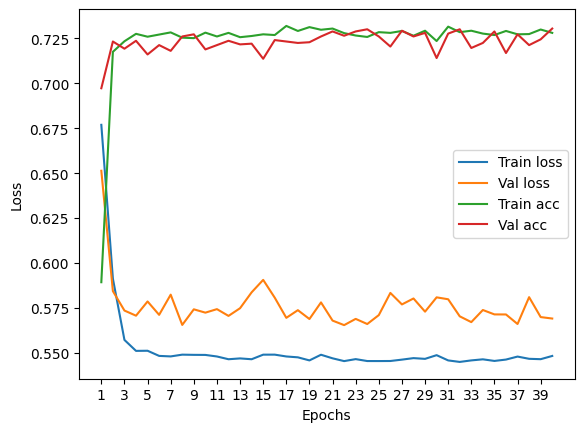

****************************************************************************************************



118it [00:00, 239.36it/s]


Train Epoch: 0 	Loss: 0.675100, Accuracy: 4501/7500 (60%)
Val Epoch: 0 	Loss: 0.637619, Accuracy: 1748/2500 (70%)



118it [00:00, 233.61it/s]


Train Epoch: 1 	Loss: 0.593233, Accuracy: 5342/7500 (71%)
Val Epoch: 1 	Loss: 0.571919, Accuracy: 1827/2500 (73%)



118it [00:00, 229.72it/s]


Train Epoch: 2 	Loss: 0.566883, Accuracy: 5414/7500 (72%)
Val Epoch: 2 	Loss: 0.562088, Accuracy: 1838/2500 (74%)



118it [00:00, 240.06it/s]


Train Epoch: 3 	Loss: 0.560705, Accuracy: 5446/7500 (73%)
Val Epoch: 3 	Loss: 0.550902, Accuracy: 1830/2500 (73%)



118it [00:00, 237.41it/s]


Train Epoch: 4 	Loss: 0.559642, Accuracy: 5442/7500 (73%)
Val Epoch: 4 	Loss: 0.548716, Accuracy: 1831/2500 (73%)



118it [00:00, 233.54it/s]


Train Epoch: 5 	Loss: 0.558871, Accuracy: 5416/7500 (72%)
Val Epoch: 5 	Loss: 0.553935, Accuracy: 1839/2500 (74%)



118it [00:00, 225.39it/s]


Train Epoch: 6 	Loss: 0.557722, Accuracy: 5434/7500 (72%)
Val Epoch: 6 	Loss: 0.581526, Accuracy: 1824/2500 (73%)



118it [00:00, 226.60it/s]


Train Epoch: 7 	Loss: 0.558426, Accuracy: 5434/7500 (72%)
Val Epoch: 7 	Loss: 0.548132, Accuracy: 1842/2500 (74%)



118it [00:00, 235.74it/s]


Train Epoch: 8 	Loss: 0.557613, Accuracy: 5442/7500 (73%)
Val Epoch: 8 	Loss: 0.556525, Accuracy: 1837/2500 (73%)



118it [00:00, 235.97it/s]


Train Epoch: 9 	Loss: 0.560474, Accuracy: 5417/7500 (72%)
Val Epoch: 9 	Loss: 0.546159, Accuracy: 1830/2500 (73%)



118it [00:00, 200.12it/s]


Train Epoch: 10 	Loss: 0.560090, Accuracy: 5426/7500 (72%)
Val Epoch: 10 	Loss: 0.553088, Accuracy: 1824/2500 (73%)



118it [00:00, 175.54it/s]


Train Epoch: 11 	Loss: 0.557635, Accuracy: 5439/7500 (73%)
Val Epoch: 11 	Loss: 0.568067, Accuracy: 1825/2500 (73%)



118it [00:00, 169.35it/s]


Train Epoch: 12 	Loss: 0.560286, Accuracy: 5455/7500 (73%)
Val Epoch: 12 	Loss: 0.552347, Accuracy: 1824/2500 (73%)



118it [00:00, 169.15it/s]


Train Epoch: 13 	Loss: 0.560335, Accuracy: 5424/7500 (72%)
Val Epoch: 13 	Loss: 0.544977, Accuracy: 1853/2500 (74%)



118it [00:00, 182.26it/s]


Train Epoch: 14 	Loss: 0.557511, Accuracy: 5432/7500 (72%)
Val Epoch: 14 	Loss: 0.542763, Accuracy: 1848/2500 (74%)



118it [00:00, 210.08it/s]


Train Epoch: 15 	Loss: 0.559886, Accuracy: 5411/7500 (72%)
Val Epoch: 15 	Loss: 0.551967, Accuracy: 1808/2500 (72%)



118it [00:00, 233.36it/s]


Train Epoch: 16 	Loss: 0.559103, Accuracy: 5418/7500 (72%)
Val Epoch: 16 	Loss: 0.551611, Accuracy: 1812/2500 (72%)



118it [00:00, 194.18it/s]


Train Epoch: 17 	Loss: 0.557626, Accuracy: 5437/7500 (72%)
Val Epoch: 17 	Loss: 0.556575, Accuracy: 1847/2500 (74%)



118it [00:00, 195.92it/s]


Train Epoch: 18 	Loss: 0.555780, Accuracy: 5436/7500 (72%)
Val Epoch: 18 	Loss: 0.545176, Accuracy: 1826/2500 (73%)



118it [00:00, 170.75it/s]


Train Epoch: 19 	Loss: 0.557477, Accuracy: 5445/7500 (73%)
Val Epoch: 19 	Loss: 0.554626, Accuracy: 1820/2500 (73%)



118it [00:00, 189.31it/s]


Train Epoch: 20 	Loss: 0.558604, Accuracy: 5421/7500 (72%)
Val Epoch: 20 	Loss: 0.544978, Accuracy: 1834/2500 (73%)



118it [00:00, 179.43it/s]


Train Epoch: 21 	Loss: 0.556119, Accuracy: 5446/7500 (73%)
Val Epoch: 21 	Loss: 0.542685, Accuracy: 1832/2500 (73%)



118it [00:00, 167.56it/s]


Train Epoch: 22 	Loss: 0.558320, Accuracy: 5434/7500 (72%)
Val Epoch: 22 	Loss: 0.549693, Accuracy: 1848/2500 (74%)



118it [00:00, 184.70it/s]


Train Epoch: 23 	Loss: 0.556307, Accuracy: 5441/7500 (73%)
Val Epoch: 23 	Loss: 0.544535, Accuracy: 1841/2500 (74%)



118it [00:00, 189.29it/s]


Train Epoch: 24 	Loss: 0.557667, Accuracy: 5422/7500 (72%)
Val Epoch: 24 	Loss: 0.548133, Accuracy: 1835/2500 (73%)



118it [00:00, 179.76it/s]


Train Epoch: 25 	Loss: 0.557217, Accuracy: 5436/7500 (72%)
Val Epoch: 25 	Loss: 0.551486, Accuracy: 1838/2500 (74%)



118it [00:00, 173.84it/s]


Train Epoch: 26 	Loss: 0.556545, Accuracy: 5453/7500 (73%)
Val Epoch: 26 	Loss: 0.558897, Accuracy: 1832/2500 (73%)



118it [00:00, 179.31it/s]


Train Epoch: 27 	Loss: 0.556409, Accuracy: 5443/7500 (73%)
Val Epoch: 27 	Loss: 0.542899, Accuracy: 1827/2500 (73%)



118it [00:00, 192.78it/s]


Train Epoch: 28 	Loss: 0.556724, Accuracy: 5456/7500 (73%)
Val Epoch: 28 	Loss: 0.551864, Accuracy: 1836/2500 (73%)



118it [00:00, 225.87it/s]


Train Epoch: 29 	Loss: 0.554972, Accuracy: 5431/7500 (72%)
Val Epoch: 29 	Loss: 0.549304, Accuracy: 1837/2500 (73%)



118it [00:00, 187.58it/s]


Train Epoch: 30 	Loss: 0.557559, Accuracy: 5429/7500 (72%)
Val Epoch: 30 	Loss: 0.546660, Accuracy: 1848/2500 (74%)



118it [00:00, 225.56it/s]


Train Epoch: 31 	Loss: 0.556694, Accuracy: 5429/7500 (72%)
Val Epoch: 31 	Loss: 0.548066, Accuracy: 1842/2500 (74%)



118it [00:00, 191.63it/s]


Train Epoch: 32 	Loss: 0.555480, Accuracy: 5422/7500 (72%)
Val Epoch: 32 	Loss: 0.550794, Accuracy: 1829/2500 (73%)



118it [00:00, 175.11it/s]


Train Epoch: 33 	Loss: 0.556326, Accuracy: 5435/7500 (72%)
Val Epoch: 33 	Loss: 0.554279, Accuracy: 1832/2500 (73%)



118it [00:00, 192.13it/s]


Train Epoch: 34 	Loss: 0.557549, Accuracy: 5439/7500 (73%)
Val Epoch: 34 	Loss: 0.555509, Accuracy: 1837/2500 (73%)



118it [00:00, 205.33it/s]


Train Epoch: 35 	Loss: 0.556266, Accuracy: 5463/7500 (73%)
Val Epoch: 35 	Loss: 0.552046, Accuracy: 1838/2500 (74%)



118it [00:00, 235.34it/s]


Train Epoch: 36 	Loss: 0.555687, Accuracy: 5442/7500 (73%)
Val Epoch: 36 	Loss: 0.570145, Accuracy: 1825/2500 (73%)



118it [00:00, 236.01it/s]


Train Epoch: 37 	Loss: 0.557821, Accuracy: 5442/7500 (73%)
Val Epoch: 37 	Loss: 0.544354, Accuracy: 1830/2500 (73%)



118it [00:00, 233.38it/s]


Train Epoch: 38 	Loss: 0.556562, Accuracy: 5412/7500 (72%)
Val Epoch: 38 	Loss: 0.550863, Accuracy: 1834/2500 (73%)



118it [00:00, 210.56it/s]


Train Epoch: 39 	Loss: 0.554281, Accuracy: 5431/7500 (72%)
Val Epoch: 39 	Loss: 0.544502, Accuracy: 1835/2500 (73%)

Test accuracy:  71.32


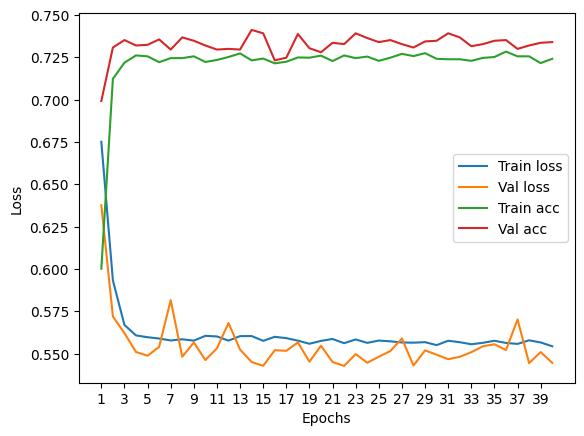

****************************************************************************************************



118it [00:00, 197.88it/s]


Train Epoch: 0 	Loss: 0.684354, Accuracy: 4284/7500 (57%)
Val Epoch: 0 	Loss: 0.659007, Accuracy: 1742/2500 (70%)



118it [00:00, 228.11it/s]


Train Epoch: 1 	Loss: 0.609781, Accuracy: 5266/7500 (70%)
Val Epoch: 1 	Loss: 0.593396, Accuracy: 1769/2500 (71%)



118it [00:00, 227.25it/s]


Train Epoch: 2 	Loss: 0.564750, Accuracy: 5415/7500 (72%)
Val Epoch: 2 	Loss: 0.586343, Accuracy: 1784/2500 (71%)



118it [00:00, 201.42it/s]


Train Epoch: 3 	Loss: 0.552852, Accuracy: 5429/7500 (72%)
Val Epoch: 3 	Loss: 0.567207, Accuracy: 1792/2500 (72%)



118it [00:00, 171.28it/s]


Train Epoch: 4 	Loss: 0.553351, Accuracy: 5453/7500 (73%)
Val Epoch: 4 	Loss: 0.566593, Accuracy: 1795/2500 (72%)



118it [00:00, 191.91it/s]


Train Epoch: 5 	Loss: 0.554112, Accuracy: 5456/7500 (73%)
Val Epoch: 5 	Loss: 0.568603, Accuracy: 1796/2500 (72%)



118it [00:00, 201.14it/s]


Train Epoch: 6 	Loss: 0.552894, Accuracy: 5446/7500 (73%)
Val Epoch: 6 	Loss: 0.577930, Accuracy: 1805/2500 (72%)



118it [00:00, 237.76it/s]


Train Epoch: 7 	Loss: 0.551550, Accuracy: 5445/7500 (73%)
Val Epoch: 7 	Loss: 0.566786, Accuracy: 1802/2500 (72%)



118it [00:00, 231.92it/s]


Train Epoch: 8 	Loss: 0.550995, Accuracy: 5451/7500 (73%)
Val Epoch: 8 	Loss: 0.570816, Accuracy: 1795/2500 (72%)



118it [00:00, 232.95it/s]


Train Epoch: 9 	Loss: 0.550784, Accuracy: 5472/7500 (73%)
Val Epoch: 9 	Loss: 0.574072, Accuracy: 1793/2500 (72%)



118it [00:00, 224.82it/s]


Train Epoch: 10 	Loss: 0.550354, Accuracy: 5463/7500 (73%)
Val Epoch: 10 	Loss: 0.577309, Accuracy: 1790/2500 (72%)



118it [00:00, 238.34it/s]


Train Epoch: 11 	Loss: 0.550692, Accuracy: 5501/7500 (73%)
Val Epoch: 11 	Loss: 0.565630, Accuracy: 1797/2500 (72%)



118it [00:00, 229.74it/s]


Train Epoch: 12 	Loss: 0.550939, Accuracy: 5459/7500 (73%)
Val Epoch: 12 	Loss: 0.575721, Accuracy: 1800/2500 (72%)



118it [00:00, 233.94it/s]


Train Epoch: 13 	Loss: 0.549940, Accuracy: 5472/7500 (73%)
Val Epoch: 13 	Loss: 0.575376, Accuracy: 1779/2500 (71%)



118it [00:00, 211.80it/s]


Train Epoch: 14 	Loss: 0.547752, Accuracy: 5454/7500 (73%)
Val Epoch: 14 	Loss: 0.578766, Accuracy: 1789/2500 (72%)



118it [00:00, 235.45it/s]


Train Epoch: 15 	Loss: 0.549788, Accuracy: 5473/7500 (73%)
Val Epoch: 15 	Loss: 0.562757, Accuracy: 1789/2500 (72%)



118it [00:00, 226.75it/s]


Train Epoch: 16 	Loss: 0.549452, Accuracy: 5468/7500 (73%)
Val Epoch: 16 	Loss: 0.568515, Accuracy: 1791/2500 (72%)



118it [00:00, 226.32it/s]


Train Epoch: 17 	Loss: 0.548640, Accuracy: 5464/7500 (73%)
Val Epoch: 17 	Loss: 0.564116, Accuracy: 1795/2500 (72%)



118it [00:00, 234.19it/s]


Train Epoch: 18 	Loss: 0.548410, Accuracy: 5490/7500 (73%)
Val Epoch: 18 	Loss: 0.566863, Accuracy: 1791/2500 (72%)



118it [00:00, 235.63it/s]


Train Epoch: 19 	Loss: 0.548692, Accuracy: 5473/7500 (73%)
Val Epoch: 19 	Loss: 0.564918, Accuracy: 1792/2500 (72%)



118it [00:00, 150.99it/s]


Train Epoch: 20 	Loss: 0.549196, Accuracy: 5463/7500 (73%)
Val Epoch: 20 	Loss: 0.569440, Accuracy: 1807/2500 (72%)



118it [00:00, 137.23it/s]


Train Epoch: 21 	Loss: 0.548306, Accuracy: 5456/7500 (73%)
Val Epoch: 21 	Loss: 0.572363, Accuracy: 1795/2500 (72%)



118it [00:00, 173.00it/s]


Train Epoch: 22 	Loss: 0.548023, Accuracy: 5438/7500 (73%)
Val Epoch: 22 	Loss: 0.569734, Accuracy: 1787/2500 (71%)



118it [00:01, 108.62it/s]


Train Epoch: 23 	Loss: 0.548663, Accuracy: 5447/7500 (73%)
Val Epoch: 23 	Loss: 0.567238, Accuracy: 1798/2500 (72%)



118it [00:01, 114.31it/s]


Train Epoch: 24 	Loss: 0.546471, Accuracy: 5456/7500 (73%)
Val Epoch: 24 	Loss: 0.568897, Accuracy: 1793/2500 (72%)



118it [00:00, 150.14it/s]


Train Epoch: 25 	Loss: 0.547620, Accuracy: 5463/7500 (73%)
Val Epoch: 25 	Loss: 0.568314, Accuracy: 1804/2500 (72%)



118it [00:00, 169.86it/s]


Train Epoch: 26 	Loss: 0.548794, Accuracy: 5468/7500 (73%)
Val Epoch: 26 	Loss: 0.571250, Accuracy: 1795/2500 (72%)



118it [00:00, 205.49it/s]


Train Epoch: 27 	Loss: 0.547074, Accuracy: 5451/7500 (73%)
Val Epoch: 27 	Loss: 0.568657, Accuracy: 1790/2500 (72%)



118it [00:00, 231.00it/s]


Train Epoch: 28 	Loss: 0.548596, Accuracy: 5499/7500 (73%)
Val Epoch: 28 	Loss: 0.566422, Accuracy: 1795/2500 (72%)



118it [00:00, 229.30it/s]


Train Epoch: 29 	Loss: 0.548351, Accuracy: 5468/7500 (73%)
Val Epoch: 29 	Loss: 0.564001, Accuracy: 1800/2500 (72%)



118it [00:00, 218.45it/s]


Train Epoch: 30 	Loss: 0.547140, Accuracy: 5486/7500 (73%)
Val Epoch: 30 	Loss: 0.563098, Accuracy: 1793/2500 (72%)



118it [00:00, 234.66it/s]


Train Epoch: 31 	Loss: 0.549209, Accuracy: 5478/7500 (73%)
Val Epoch: 31 	Loss: 0.568177, Accuracy: 1787/2500 (71%)



118it [00:00, 234.64it/s]


Train Epoch: 32 	Loss: 0.549096, Accuracy: 5487/7500 (73%)
Val Epoch: 32 	Loss: 0.563821, Accuracy: 1794/2500 (72%)



118it [00:00, 233.71it/s]


Train Epoch: 33 	Loss: 0.549344, Accuracy: 5479/7500 (73%)
Val Epoch: 33 	Loss: 0.567879, Accuracy: 1787/2500 (71%)



118it [00:00, 226.42it/s]


Train Epoch: 34 	Loss: 0.548234, Accuracy: 5478/7500 (73%)
Val Epoch: 34 	Loss: 0.576458, Accuracy: 1793/2500 (72%)



118it [00:00, 227.74it/s]


Train Epoch: 35 	Loss: 0.548260, Accuracy: 5477/7500 (73%)
Val Epoch: 35 	Loss: 0.569250, Accuracy: 1793/2500 (72%)



118it [00:00, 228.71it/s]


Train Epoch: 36 	Loss: 0.548398, Accuracy: 5454/7500 (73%)
Val Epoch: 36 	Loss: 0.572476, Accuracy: 1799/2500 (72%)



118it [00:00, 231.10it/s]


Train Epoch: 37 	Loss: 0.547290, Accuracy: 5477/7500 (73%)
Val Epoch: 37 	Loss: 0.579638, Accuracy: 1800/2500 (72%)



118it [00:00, 236.05it/s]


Train Epoch: 38 	Loss: 0.549203, Accuracy: 5471/7500 (73%)
Val Epoch: 38 	Loss: 0.566611, Accuracy: 1808/2500 (72%)



118it [00:00, 233.61it/s]


Train Epoch: 39 	Loss: 0.547205, Accuracy: 5467/7500 (73%)
Val Epoch: 39 	Loss: 0.569797, Accuracy: 1805/2500 (72%)

Test accuracy:  71.96000000000001


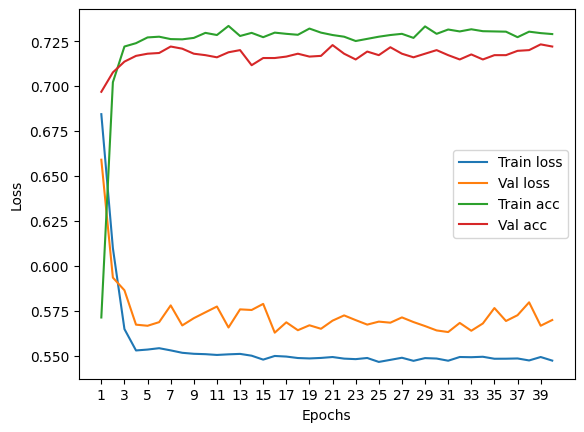

****************************************************************************************************



116it [00:00, 238.30it/s]


Train Epoch: 0 	Loss: 0.670854, Accuracy: 4530/7422 (61%)
Val Epoch: 0 	Loss: 0.646476, Accuracy: 1706/2474 (69%)



116it [00:00, 234.58it/s]


Train Epoch: 1 	Loss: 0.600174, Accuracy: 5296/7422 (71%)
Val Epoch: 1 	Loss: 0.580054, Accuracy: 1779/2474 (72%)



116it [00:00, 238.27it/s]


Train Epoch: 2 	Loss: 0.561327, Accuracy: 5399/7422 (73%)
Val Epoch: 2 	Loss: 0.568893, Accuracy: 1776/2474 (72%)



116it [00:00, 227.39it/s]


Train Epoch: 3 	Loss: 0.554744, Accuracy: 5406/7422 (73%)
Val Epoch: 3 	Loss: 0.564622, Accuracy: 1767/2474 (71%)



116it [00:00, 236.63it/s]


Train Epoch: 4 	Loss: 0.550215, Accuracy: 5431/7422 (73%)
Val Epoch: 4 	Loss: 0.565407, Accuracy: 1764/2474 (71%)



116it [00:00, 234.71it/s]


Train Epoch: 5 	Loss: 0.550474, Accuracy: 5390/7422 (73%)
Val Epoch: 5 	Loss: 0.565480, Accuracy: 1775/2474 (72%)



116it [00:00, 227.45it/s]


Train Epoch: 6 	Loss: 0.550182, Accuracy: 5426/7422 (73%)
Val Epoch: 6 	Loss: 0.563361, Accuracy: 1773/2474 (72%)



116it [00:00, 237.11it/s]


Train Epoch: 7 	Loss: 0.548787, Accuracy: 5420/7422 (73%)
Val Epoch: 7 	Loss: 0.569152, Accuracy: 1768/2474 (71%)



116it [00:00, 225.92it/s]


Train Epoch: 8 	Loss: 0.550034, Accuracy: 5427/7422 (73%)
Val Epoch: 8 	Loss: 0.563999, Accuracy: 1781/2474 (72%)



116it [00:00, 231.29it/s]


Train Epoch: 9 	Loss: 0.549193, Accuracy: 5448/7422 (73%)
Val Epoch: 9 	Loss: 0.564115, Accuracy: 1767/2474 (71%)



116it [00:00, 232.51it/s]


Train Epoch: 10 	Loss: 0.548572, Accuracy: 5430/7422 (73%)
Val Epoch: 10 	Loss: 0.570148, Accuracy: 1757/2474 (71%)



116it [00:00, 226.46it/s]


Train Epoch: 11 	Loss: 0.549471, Accuracy: 5438/7422 (73%)
Val Epoch: 11 	Loss: 0.565258, Accuracy: 1779/2474 (72%)



116it [00:00, 205.84it/s]


Train Epoch: 12 	Loss: 0.548069, Accuracy: 5435/7422 (73%)
Val Epoch: 12 	Loss: 0.564613, Accuracy: 1761/2474 (71%)



116it [00:00, 230.68it/s]


Train Epoch: 13 	Loss: 0.547777, Accuracy: 5445/7422 (73%)
Val Epoch: 13 	Loss: 0.565049, Accuracy: 1773/2474 (72%)



116it [00:00, 229.34it/s]


Train Epoch: 14 	Loss: 0.548628, Accuracy: 5439/7422 (73%)
Val Epoch: 14 	Loss: 0.564949, Accuracy: 1760/2474 (71%)



116it [00:00, 229.99it/s]


Train Epoch: 15 	Loss: 0.550182, Accuracy: 5420/7422 (73%)
Val Epoch: 15 	Loss: 0.563056, Accuracy: 1773/2474 (72%)



116it [00:00, 214.87it/s]


Train Epoch: 16 	Loss: 0.548908, Accuracy: 5425/7422 (73%)
Val Epoch: 16 	Loss: 0.564479, Accuracy: 1768/2474 (71%)



116it [00:00, 238.85it/s]


Train Epoch: 17 	Loss: 0.547617, Accuracy: 5440/7422 (73%)
Val Epoch: 17 	Loss: 0.564683, Accuracy: 1787/2474 (72%)



116it [00:00, 218.38it/s]


Train Epoch: 18 	Loss: 0.548044, Accuracy: 5439/7422 (73%)
Val Epoch: 18 	Loss: 0.564489, Accuracy: 1762/2474 (71%)



116it [00:00, 201.43it/s]


Train Epoch: 19 	Loss: 0.547875, Accuracy: 5451/7422 (73%)
Val Epoch: 19 	Loss: 0.563708, Accuracy: 1776/2474 (72%)



116it [00:00, 169.26it/s]


Train Epoch: 20 	Loss: 0.549336, Accuracy: 5427/7422 (73%)
Val Epoch: 20 	Loss: 0.566405, Accuracy: 1763/2474 (71%)



116it [00:00, 157.06it/s]


Train Epoch: 21 	Loss: 0.548049, Accuracy: 5461/7422 (74%)
Val Epoch: 21 	Loss: 0.565447, Accuracy: 1786/2474 (72%)



116it [00:00, 200.95it/s]


Train Epoch: 22 	Loss: 0.547192, Accuracy: 5447/7422 (73%)
Val Epoch: 22 	Loss: 0.564278, Accuracy: 1770/2474 (72%)



116it [00:00, 229.03it/s]


Train Epoch: 23 	Loss: 0.548038, Accuracy: 5447/7422 (73%)
Val Epoch: 23 	Loss: 0.571278, Accuracy: 1777/2474 (72%)



116it [00:00, 239.28it/s]


Train Epoch: 24 	Loss: 0.547566, Accuracy: 5453/7422 (73%)
Val Epoch: 24 	Loss: 0.563405, Accuracy: 1774/2474 (72%)



116it [00:00, 235.86it/s]


Train Epoch: 25 	Loss: 0.547134, Accuracy: 5451/7422 (73%)
Val Epoch: 25 	Loss: 0.564919, Accuracy: 1784/2474 (72%)



116it [00:00, 231.46it/s]


Train Epoch: 26 	Loss: 0.549581, Accuracy: 5424/7422 (73%)
Val Epoch: 26 	Loss: 0.564500, Accuracy: 1769/2474 (72%)



116it [00:00, 195.98it/s]


Train Epoch: 27 	Loss: 0.548326, Accuracy: 5443/7422 (73%)
Val Epoch: 27 	Loss: 0.569731, Accuracy: 1773/2474 (72%)



116it [00:00, 232.02it/s]


Train Epoch: 28 	Loss: 0.546777, Accuracy: 5453/7422 (73%)
Val Epoch: 28 	Loss: 0.568043, Accuracy: 1776/2474 (72%)



116it [00:00, 235.11it/s]


Train Epoch: 29 	Loss: 0.547010, Accuracy: 5467/7422 (74%)
Val Epoch: 29 	Loss: 0.564424, Accuracy: 1777/2474 (72%)



116it [00:00, 233.54it/s]


Train Epoch: 30 	Loss: 0.546704, Accuracy: 5455/7422 (73%)
Val Epoch: 30 	Loss: 0.569569, Accuracy: 1778/2474 (72%)



116it [00:00, 234.87it/s]


Train Epoch: 31 	Loss: 0.547368, Accuracy: 5449/7422 (73%)
Val Epoch: 31 	Loss: 0.565063, Accuracy: 1775/2474 (72%)



116it [00:00, 233.50it/s]


Train Epoch: 32 	Loss: 0.547036, Accuracy: 5456/7422 (74%)
Val Epoch: 32 	Loss: 0.565720, Accuracy: 1785/2474 (72%)



116it [00:00, 235.48it/s]


Train Epoch: 33 	Loss: 0.546362, Accuracy: 5447/7422 (73%)
Val Epoch: 33 	Loss: 0.564624, Accuracy: 1782/2474 (72%)



116it [00:00, 229.11it/s]


Train Epoch: 34 	Loss: 0.547917, Accuracy: 5429/7422 (73%)
Val Epoch: 34 	Loss: 0.565622, Accuracy: 1756/2474 (71%)



116it [00:00, 232.63it/s]


Train Epoch: 35 	Loss: 0.548315, Accuracy: 5444/7422 (73%)
Val Epoch: 35 	Loss: 0.565135, Accuracy: 1770/2474 (72%)



116it [00:00, 237.50it/s]


Train Epoch: 36 	Loss: 0.547476, Accuracy: 5453/7422 (73%)
Val Epoch: 36 	Loss: 0.567374, Accuracy: 1781/2474 (72%)



116it [00:00, 235.84it/s]


Train Epoch: 37 	Loss: 0.549233, Accuracy: 5462/7422 (74%)
Val Epoch: 37 	Loss: 0.576353, Accuracy: 1761/2474 (71%)



116it [00:00, 232.74it/s]


Train Epoch: 38 	Loss: 0.548470, Accuracy: 5424/7422 (73%)
Val Epoch: 38 	Loss: 0.565549, Accuracy: 1772/2474 (72%)



116it [00:00, 232.59it/s]


Train Epoch: 39 	Loss: 0.548093, Accuracy: 5456/7422 (74%)
Val Epoch: 39 	Loss: 0.564285, Accuracy: 1783/2474 (72%)

Test accuracy:  73.72675828617623


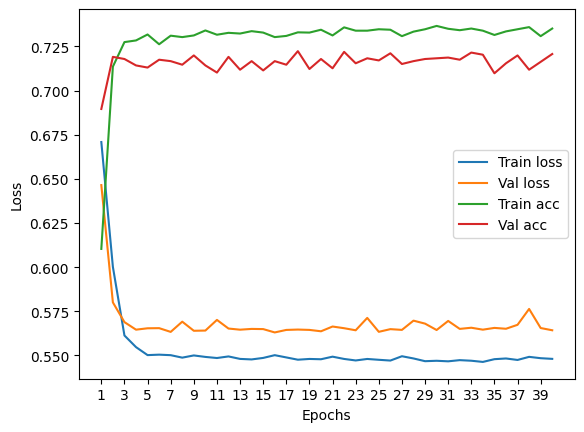

****************************************************************************************************



Particles per jet: 4


118it [00:00, 224.63it/s]


Train Epoch: 0 	Loss: 0.686429, Accuracy: 4294/7500 (57%)
Val Epoch: 0 	Loss: 0.675977, Accuracy: 1584/2500 (63%)



118it [00:00, 226.16it/s]


Train Epoch: 1 	Loss: 0.611293, Accuracy: 5298/7500 (71%)
Val Epoch: 1 	Loss: 0.583562, Accuracy: 1838/2500 (74%)



118it [00:00, 222.98it/s]


Train Epoch: 2 	Loss: 0.556818, Accuracy: 5455/7500 (73%)
Val Epoch: 2 	Loss: 0.567447, Accuracy: 1835/2500 (73%)



118it [00:00, 229.37it/s]


Train Epoch: 3 	Loss: 0.544694, Accuracy: 5505/7500 (73%)
Val Epoch: 3 	Loss: 0.557757, Accuracy: 1837/2500 (73%)



118it [00:00, 227.01it/s]


Train Epoch: 4 	Loss: 0.546881, Accuracy: 5505/7500 (73%)
Val Epoch: 4 	Loss: 0.561242, Accuracy: 1831/2500 (73%)



118it [00:00, 212.46it/s]


Train Epoch: 5 	Loss: 0.544429, Accuracy: 5523/7500 (74%)
Val Epoch: 5 	Loss: 0.561133, Accuracy: 1841/2500 (74%)



118it [00:00, 219.71it/s]


Train Epoch: 6 	Loss: 0.546115, Accuracy: 5489/7500 (73%)
Val Epoch: 6 	Loss: 0.559047, Accuracy: 1840/2500 (74%)



118it [00:00, 229.28it/s]


Train Epoch: 7 	Loss: 0.542799, Accuracy: 5495/7500 (73%)
Val Epoch: 7 	Loss: 0.564214, Accuracy: 1836/2500 (73%)



118it [00:00, 209.63it/s]


Train Epoch: 8 	Loss: 0.544509, Accuracy: 5514/7500 (74%)
Val Epoch: 8 	Loss: 0.563134, Accuracy: 1817/2500 (73%)



118it [00:00, 200.71it/s]


Train Epoch: 9 	Loss: 0.542311, Accuracy: 5506/7500 (73%)
Val Epoch: 9 	Loss: 0.558830, Accuracy: 1834/2500 (73%)



118it [00:00, 232.33it/s]


Train Epoch: 10 	Loss: 0.543491, Accuracy: 5509/7500 (73%)
Val Epoch: 10 	Loss: 0.570600, Accuracy: 1829/2500 (73%)



118it [00:00, 210.48it/s]


Train Epoch: 11 	Loss: 0.542300, Accuracy: 5529/7500 (74%)
Val Epoch: 11 	Loss: 0.570199, Accuracy: 1837/2500 (73%)



118it [00:00, 170.52it/s]


Train Epoch: 12 	Loss: 0.542497, Accuracy: 5524/7500 (74%)
Val Epoch: 12 	Loss: 0.567407, Accuracy: 1820/2500 (73%)



118it [00:00, 189.69it/s]


Train Epoch: 13 	Loss: 0.539691, Accuracy: 5512/7500 (73%)
Val Epoch: 13 	Loss: 0.581166, Accuracy: 1831/2500 (73%)



118it [00:00, 183.00it/s]


Train Epoch: 14 	Loss: 0.543499, Accuracy: 5510/7500 (73%)
Val Epoch: 14 	Loss: 0.562146, Accuracy: 1830/2500 (73%)



118it [00:00, 229.82it/s]


Train Epoch: 15 	Loss: 0.541430, Accuracy: 5521/7500 (74%)
Val Epoch: 15 	Loss: 0.559825, Accuracy: 1839/2500 (74%)



118it [00:00, 236.72it/s]


Train Epoch: 16 	Loss: 0.542832, Accuracy: 5510/7500 (73%)
Val Epoch: 16 	Loss: 0.575498, Accuracy: 1838/2500 (74%)



118it [00:00, 228.70it/s]


Train Epoch: 17 	Loss: 0.542394, Accuracy: 5519/7500 (74%)
Val Epoch: 17 	Loss: 0.566185, Accuracy: 1822/2500 (73%)



118it [00:00, 218.28it/s]


Train Epoch: 18 	Loss: 0.540560, Accuracy: 5525/7500 (74%)
Val Epoch: 18 	Loss: 0.559139, Accuracy: 1825/2500 (73%)



118it [00:00, 235.56it/s]


Train Epoch: 19 	Loss: 0.541563, Accuracy: 5511/7500 (73%)
Val Epoch: 19 	Loss: 0.556087, Accuracy: 1827/2500 (73%)



118it [00:00, 233.91it/s]


Train Epoch: 20 	Loss: 0.541250, Accuracy: 5520/7500 (74%)
Val Epoch: 20 	Loss: 0.579127, Accuracy: 1829/2500 (73%)



118it [00:00, 227.69it/s]


Train Epoch: 21 	Loss: 0.542634, Accuracy: 5545/7500 (74%)
Val Epoch: 21 	Loss: 0.564747, Accuracy: 1827/2500 (73%)



118it [00:00, 233.56it/s]


Train Epoch: 22 	Loss: 0.542292, Accuracy: 5516/7500 (74%)
Val Epoch: 22 	Loss: 0.566436, Accuracy: 1838/2500 (74%)



118it [00:00, 237.08it/s]


Train Epoch: 23 	Loss: 0.542125, Accuracy: 5517/7500 (74%)
Val Epoch: 23 	Loss: 0.565296, Accuracy: 1844/2500 (74%)



118it [00:00, 229.65it/s]


Train Epoch: 24 	Loss: 0.541400, Accuracy: 5525/7500 (74%)
Val Epoch: 24 	Loss: 0.566983, Accuracy: 1810/2500 (72%)



118it [00:00, 231.23it/s]


Train Epoch: 25 	Loss: 0.540618, Accuracy: 5531/7500 (74%)
Val Epoch: 25 	Loss: 0.560946, Accuracy: 1842/2500 (74%)



118it [00:00, 211.86it/s]


Train Epoch: 26 	Loss: 0.541407, Accuracy: 5537/7500 (74%)
Val Epoch: 26 	Loss: 0.575743, Accuracy: 1827/2500 (73%)



118it [00:00, 207.01it/s]


Train Epoch: 27 	Loss: 0.540187, Accuracy: 5547/7500 (74%)
Val Epoch: 27 	Loss: 0.572254, Accuracy: 1823/2500 (73%)



118it [00:00, 204.08it/s]


Train Epoch: 28 	Loss: 0.542685, Accuracy: 5522/7500 (74%)
Val Epoch: 28 	Loss: 0.558043, Accuracy: 1821/2500 (73%)



118it [00:00, 182.29it/s]


Train Epoch: 29 	Loss: 0.541232, Accuracy: 5534/7500 (74%)
Val Epoch: 29 	Loss: 0.568449, Accuracy: 1840/2500 (74%)



118it [00:00, 225.78it/s]


Train Epoch: 30 	Loss: 0.541981, Accuracy: 5529/7500 (74%)
Val Epoch: 30 	Loss: 0.559304, Accuracy: 1842/2500 (74%)



118it [00:00, 201.50it/s]


Train Epoch: 31 	Loss: 0.539310, Accuracy: 5527/7500 (74%)
Val Epoch: 31 	Loss: 0.578227, Accuracy: 1829/2500 (73%)



118it [00:00, 235.14it/s]


Train Epoch: 32 	Loss: 0.542676, Accuracy: 5527/7500 (74%)
Val Epoch: 32 	Loss: 0.566257, Accuracy: 1839/2500 (74%)



118it [00:00, 187.38it/s]


Train Epoch: 33 	Loss: 0.542363, Accuracy: 5521/7500 (74%)
Val Epoch: 33 	Loss: 0.561506, Accuracy: 1836/2500 (73%)



118it [00:00, 186.46it/s]


Train Epoch: 34 	Loss: 0.541403, Accuracy: 5518/7500 (74%)
Val Epoch: 34 	Loss: 0.563745, Accuracy: 1842/2500 (74%)



118it [00:00, 156.21it/s]


Train Epoch: 35 	Loss: 0.541648, Accuracy: 5520/7500 (74%)
Val Epoch: 35 	Loss: 0.566950, Accuracy: 1830/2500 (73%)



118it [00:00, 190.24it/s]


Train Epoch: 36 	Loss: 0.541858, Accuracy: 5530/7500 (74%)
Val Epoch: 36 	Loss: 0.559923, Accuracy: 1832/2500 (73%)



118it [00:00, 205.59it/s]


Train Epoch: 37 	Loss: 0.538392, Accuracy: 5542/7500 (74%)
Val Epoch: 37 	Loss: 0.574539, Accuracy: 1816/2500 (73%)



118it [00:00, 197.62it/s]


Train Epoch: 38 	Loss: 0.542200, Accuracy: 5538/7500 (74%)
Val Epoch: 38 	Loss: 0.559154, Accuracy: 1840/2500 (74%)



118it [00:00, 232.77it/s]


Train Epoch: 39 	Loss: 0.540840, Accuracy: 5535/7500 (74%)
Val Epoch: 39 	Loss: 0.558842, Accuracy: 1833/2500 (73%)

Test accuracy:  73.08


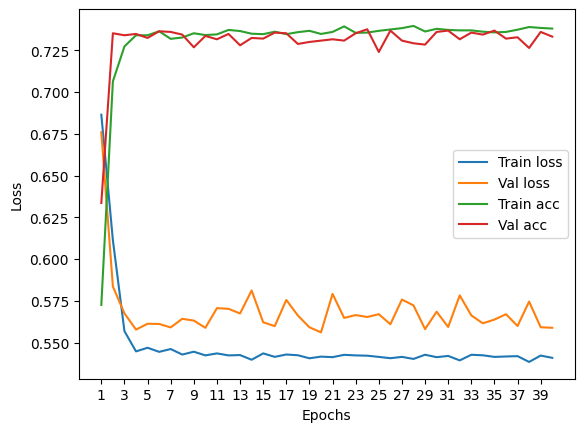

****************************************************************************************************



118it [00:00, 229.53it/s]


Train Epoch: 0 	Loss: 0.676771, Accuracy: 4551/7500 (61%)
Val Epoch: 0 	Loss: 0.658383, Accuracy: 1573/2500 (63%)



118it [00:00, 230.33it/s]


Train Epoch: 1 	Loss: 0.604803, Accuracy: 5314/7500 (71%)
Val Epoch: 1 	Loss: 0.580961, Accuracy: 1829/2500 (73%)



118it [00:00, 237.24it/s]


Train Epoch: 2 	Loss: 0.558934, Accuracy: 5470/7500 (73%)
Val Epoch: 2 	Loss: 0.578514, Accuracy: 1827/2500 (73%)



118it [00:00, 168.40it/s]


Train Epoch: 3 	Loss: 0.549203, Accuracy: 5515/7500 (74%)
Val Epoch: 3 	Loss: 0.559396, Accuracy: 1829/2500 (73%)



118it [00:00, 176.84it/s]


Train Epoch: 4 	Loss: 0.548349, Accuracy: 5471/7500 (73%)
Val Epoch: 4 	Loss: 0.553790, Accuracy: 1835/2500 (73%)



118it [00:00, 156.88it/s]


Train Epoch: 5 	Loss: 0.547340, Accuracy: 5524/7500 (74%)
Val Epoch: 5 	Loss: 0.559533, Accuracy: 1840/2500 (74%)



118it [00:00, 183.73it/s]


Train Epoch: 6 	Loss: 0.545979, Accuracy: 5507/7500 (73%)
Val Epoch: 6 	Loss: 0.553889, Accuracy: 1831/2500 (73%)



118it [00:00, 202.36it/s]


Train Epoch: 7 	Loss: 0.545900, Accuracy: 5501/7500 (73%)
Val Epoch: 7 	Loss: 0.569573, Accuracy: 1813/2500 (73%)



118it [00:00, 223.17it/s]


Train Epoch: 8 	Loss: 0.548209, Accuracy: 5482/7500 (73%)
Val Epoch: 8 	Loss: 0.549314, Accuracy: 1848/2500 (74%)



118it [00:00, 232.49it/s]


Train Epoch: 9 	Loss: 0.544479, Accuracy: 5516/7500 (74%)
Val Epoch: 9 	Loss: 0.555916, Accuracy: 1843/2500 (74%)



118it [00:00, 214.22it/s]


Train Epoch: 10 	Loss: 0.543884, Accuracy: 5515/7500 (74%)
Val Epoch: 10 	Loss: 0.559247, Accuracy: 1825/2500 (73%)



118it [00:00, 234.02it/s]


Train Epoch: 11 	Loss: 0.544016, Accuracy: 5511/7500 (73%)
Val Epoch: 11 	Loss: 0.547898, Accuracy: 1851/2500 (74%)



118it [00:00, 229.31it/s]


Train Epoch: 12 	Loss: 0.546551, Accuracy: 5514/7500 (74%)
Val Epoch: 12 	Loss: 0.554767, Accuracy: 1832/2500 (73%)



118it [00:00, 228.34it/s]


Train Epoch: 13 	Loss: 0.545887, Accuracy: 5500/7500 (73%)
Val Epoch: 13 	Loss: 0.551835, Accuracy: 1841/2500 (74%)



118it [00:00, 226.41it/s]


Train Epoch: 14 	Loss: 0.544184, Accuracy: 5503/7500 (73%)
Val Epoch: 14 	Loss: 0.555531, Accuracy: 1837/2500 (73%)



118it [00:00, 218.37it/s]


Train Epoch: 15 	Loss: 0.545524, Accuracy: 5505/7500 (73%)
Val Epoch: 15 	Loss: 0.566297, Accuracy: 1844/2500 (74%)



118it [00:00, 178.21it/s]


Train Epoch: 16 	Loss: 0.545863, Accuracy: 5501/7500 (73%)
Val Epoch: 16 	Loss: 0.549635, Accuracy: 1840/2500 (74%)



118it [00:00, 186.01it/s]


Train Epoch: 17 	Loss: 0.545931, Accuracy: 5496/7500 (73%)
Val Epoch: 17 	Loss: 0.549788, Accuracy: 1840/2500 (74%)



118it [00:00, 218.75it/s]


Train Epoch: 18 	Loss: 0.544445, Accuracy: 5508/7500 (73%)
Val Epoch: 18 	Loss: 0.565293, Accuracy: 1825/2500 (73%)



118it [00:00, 236.44it/s]


Train Epoch: 19 	Loss: 0.545300, Accuracy: 5493/7500 (73%)
Val Epoch: 19 	Loss: 0.558444, Accuracy: 1833/2500 (73%)



118it [00:00, 223.03it/s]


Train Epoch: 20 	Loss: 0.543848, Accuracy: 5510/7500 (73%)
Val Epoch: 20 	Loss: 0.561588, Accuracy: 1835/2500 (73%)



118it [00:00, 233.11it/s]


Train Epoch: 21 	Loss: 0.544455, Accuracy: 5509/7500 (73%)
Val Epoch: 21 	Loss: 0.561486, Accuracy: 1839/2500 (74%)



118it [00:00, 230.68it/s]


Train Epoch: 22 	Loss: 0.543013, Accuracy: 5508/7500 (73%)
Val Epoch: 22 	Loss: 0.555860, Accuracy: 1841/2500 (74%)



118it [00:00, 229.42it/s]


Train Epoch: 23 	Loss: 0.542849, Accuracy: 5507/7500 (73%)
Val Epoch: 23 	Loss: 0.564786, Accuracy: 1842/2500 (74%)



118it [00:00, 217.23it/s]


Train Epoch: 24 	Loss: 0.544137, Accuracy: 5517/7500 (74%)
Val Epoch: 24 	Loss: 0.551468, Accuracy: 1851/2500 (74%)



118it [00:00, 166.37it/s]


Train Epoch: 25 	Loss: 0.541948, Accuracy: 5513/7500 (74%)
Val Epoch: 25 	Loss: 0.553211, Accuracy: 1841/2500 (74%)



118it [00:00, 190.64it/s]


Train Epoch: 26 	Loss: 0.543621, Accuracy: 5519/7500 (74%)
Val Epoch: 26 	Loss: 0.561926, Accuracy: 1850/2500 (74%)



118it [00:00, 194.70it/s]


Train Epoch: 27 	Loss: 0.542878, Accuracy: 5515/7500 (74%)
Val Epoch: 27 	Loss: 0.558677, Accuracy: 1831/2500 (73%)



118it [00:00, 235.79it/s]


Train Epoch: 28 	Loss: 0.544806, Accuracy: 5530/7500 (74%)
Val Epoch: 28 	Loss: 0.567035, Accuracy: 1852/2500 (74%)



118it [00:00, 181.60it/s]


Train Epoch: 29 	Loss: 0.544603, Accuracy: 5532/7500 (74%)
Val Epoch: 29 	Loss: 0.561044, Accuracy: 1836/2500 (73%)



118it [00:00, 210.30it/s]


Train Epoch: 30 	Loss: 0.542591, Accuracy: 5503/7500 (73%)
Val Epoch: 30 	Loss: 0.544511, Accuracy: 1850/2500 (74%)



118it [00:00, 232.92it/s]


Train Epoch: 31 	Loss: 0.542069, Accuracy: 5512/7500 (73%)
Val Epoch: 31 	Loss: 0.559617, Accuracy: 1835/2500 (73%)



118it [00:00, 218.13it/s]


Train Epoch: 32 	Loss: 0.543538, Accuracy: 5510/7500 (73%)
Val Epoch: 32 	Loss: 0.559487, Accuracy: 1828/2500 (73%)



118it [00:00, 222.15it/s]


Train Epoch: 33 	Loss: 0.544761, Accuracy: 5521/7500 (74%)
Val Epoch: 33 	Loss: 0.548789, Accuracy: 1848/2500 (74%)



118it [00:00, 219.75it/s]


Train Epoch: 34 	Loss: 0.542671, Accuracy: 5507/7500 (73%)
Val Epoch: 34 	Loss: 0.563011, Accuracy: 1848/2500 (74%)



118it [00:00, 227.92it/s]


Train Epoch: 35 	Loss: 0.543534, Accuracy: 5500/7500 (73%)
Val Epoch: 35 	Loss: 0.554824, Accuracy: 1839/2500 (74%)



118it [00:00, 233.12it/s]


Train Epoch: 36 	Loss: 0.545691, Accuracy: 5511/7500 (73%)
Val Epoch: 36 	Loss: 0.558398, Accuracy: 1828/2500 (73%)



118it [00:00, 232.74it/s]


Train Epoch: 37 	Loss: 0.544638, Accuracy: 5515/7500 (74%)
Val Epoch: 37 	Loss: 0.570590, Accuracy: 1832/2500 (73%)



118it [00:00, 234.53it/s]


Train Epoch: 38 	Loss: 0.545435, Accuracy: 5489/7500 (73%)
Val Epoch: 38 	Loss: 0.558751, Accuracy: 1826/2500 (73%)



118it [00:00, 234.83it/s]


Train Epoch: 39 	Loss: 0.543103, Accuracy: 5532/7500 (74%)
Val Epoch: 39 	Loss: 0.559929, Accuracy: 1849/2500 (74%)

Test accuracy:  72.0


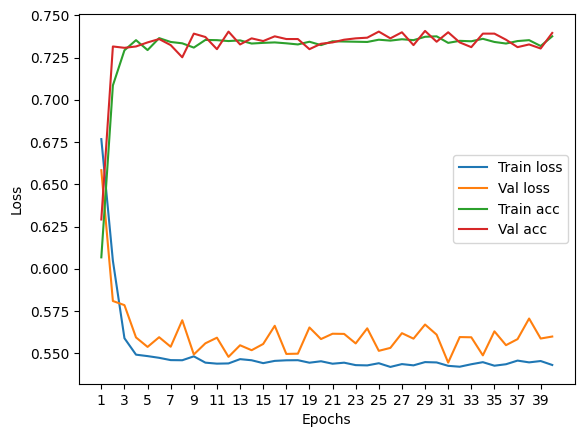

****************************************************************************************************



118it [00:00, 235.05it/s]


Train Epoch: 0 	Loss: 0.686553, Accuracy: 4335/7500 (58%)
Val Epoch: 0 	Loss: 0.678843, Accuracy: 1565/2500 (63%)



118it [00:00, 233.85it/s]


Train Epoch: 1 	Loss: 0.624688, Accuracy: 5199/7500 (69%)
Val Epoch: 1 	Loss: 0.599783, Accuracy: 1798/2500 (72%)



118it [00:00, 230.71it/s]


Train Epoch: 2 	Loss: 0.568135, Accuracy: 5475/7500 (73%)
Val Epoch: 2 	Loss: 0.566345, Accuracy: 1818/2500 (73%)



118it [00:00, 236.55it/s]


Train Epoch: 3 	Loss: 0.545545, Accuracy: 5507/7500 (73%)
Val Epoch: 3 	Loss: 0.563625, Accuracy: 1813/2500 (73%)



118it [00:00, 229.40it/s]


Train Epoch: 4 	Loss: 0.541778, Accuracy: 5516/7500 (74%)
Val Epoch: 4 	Loss: 0.563159, Accuracy: 1836/2500 (73%)



118it [00:00, 232.44it/s]


Train Epoch: 5 	Loss: 0.541139, Accuracy: 5544/7500 (74%)
Val Epoch: 5 	Loss: 0.563546, Accuracy: 1816/2500 (73%)



118it [00:00, 228.78it/s]


Train Epoch: 6 	Loss: 0.540755, Accuracy: 5509/7500 (73%)
Val Epoch: 6 	Loss: 0.545037, Accuracy: 1827/2500 (73%)



118it [00:00, 233.33it/s]


Train Epoch: 7 	Loss: 0.541288, Accuracy: 5537/7500 (74%)
Val Epoch: 7 	Loss: 0.564533, Accuracy: 1831/2500 (73%)



118it [00:00, 236.50it/s]


Train Epoch: 8 	Loss: 0.536482, Accuracy: 5518/7500 (74%)
Val Epoch: 8 	Loss: 0.575203, Accuracy: 1835/2500 (73%)



118it [00:00, 207.22it/s]


Train Epoch: 9 	Loss: 0.541486, Accuracy: 5552/7500 (74%)
Val Epoch: 9 	Loss: 0.560126, Accuracy: 1823/2500 (73%)



118it [00:00, 229.47it/s]


Train Epoch: 10 	Loss: 0.541134, Accuracy: 5538/7500 (74%)
Val Epoch: 10 	Loss: 0.555651, Accuracy: 1822/2500 (73%)



118it [00:00, 229.73it/s]


Train Epoch: 11 	Loss: 0.538078, Accuracy: 5554/7500 (74%)
Val Epoch: 11 	Loss: 0.553854, Accuracy: 1835/2500 (73%)



118it [00:00, 233.69it/s]


Train Epoch: 12 	Loss: 0.539339, Accuracy: 5541/7500 (74%)
Val Epoch: 12 	Loss: 0.559579, Accuracy: 1821/2500 (73%)



118it [00:00, 233.62it/s]


Train Epoch: 13 	Loss: 0.537389, Accuracy: 5536/7500 (74%)
Val Epoch: 13 	Loss: 0.548065, Accuracy: 1833/2500 (73%)



118it [00:00, 238.08it/s]


Train Epoch: 14 	Loss: 0.537194, Accuracy: 5564/7500 (74%)
Val Epoch: 14 	Loss: 0.561483, Accuracy: 1829/2500 (73%)



118it [00:00, 233.06it/s]


Train Epoch: 15 	Loss: 0.538341, Accuracy: 5566/7500 (74%)
Val Epoch: 15 	Loss: 0.566062, Accuracy: 1836/2500 (73%)



118it [00:00, 235.32it/s]


Train Epoch: 16 	Loss: 0.537623, Accuracy: 5544/7500 (74%)
Val Epoch: 16 	Loss: 0.557911, Accuracy: 1821/2500 (73%)



118it [00:00, 185.31it/s]


Train Epoch: 17 	Loss: 0.538411, Accuracy: 5532/7500 (74%)
Val Epoch: 17 	Loss: 0.547175, Accuracy: 1831/2500 (73%)



118it [00:00, 182.42it/s]


Train Epoch: 18 	Loss: 0.535476, Accuracy: 5549/7500 (74%)
Val Epoch: 18 	Loss: 0.559824, Accuracy: 1828/2500 (73%)



118it [00:00, 168.62it/s]


Train Epoch: 19 	Loss: 0.540145, Accuracy: 5548/7500 (74%)
Val Epoch: 19 	Loss: 0.558927, Accuracy: 1833/2500 (73%)



118it [00:00, 200.37it/s]


Train Epoch: 20 	Loss: 0.536403, Accuracy: 5536/7500 (74%)
Val Epoch: 20 	Loss: 0.579731, Accuracy: 1833/2500 (73%)



118it [00:00, 197.60it/s]


Train Epoch: 21 	Loss: 0.536284, Accuracy: 5562/7500 (74%)
Val Epoch: 21 	Loss: 0.546542, Accuracy: 1830/2500 (73%)



118it [00:00, 206.73it/s]


Train Epoch: 22 	Loss: 0.538285, Accuracy: 5533/7500 (74%)
Val Epoch: 22 	Loss: 0.562026, Accuracy: 1830/2500 (73%)



118it [00:00, 231.33it/s]


Train Epoch: 23 	Loss: 0.539384, Accuracy: 5555/7500 (74%)
Val Epoch: 23 	Loss: 0.554496, Accuracy: 1838/2500 (74%)



118it [00:00, 237.79it/s]


Train Epoch: 24 	Loss: 0.535184, Accuracy: 5554/7500 (74%)
Val Epoch: 24 	Loss: 0.556143, Accuracy: 1825/2500 (73%)



118it [00:00, 231.26it/s]


Train Epoch: 25 	Loss: 0.536575, Accuracy: 5537/7500 (74%)
Val Epoch: 25 	Loss: 0.551827, Accuracy: 1829/2500 (73%)



118it [00:00, 232.22it/s]


Train Epoch: 26 	Loss: 0.535795, Accuracy: 5530/7500 (74%)
Val Epoch: 26 	Loss: 0.553055, Accuracy: 1831/2500 (73%)



118it [00:00, 225.19it/s]


Train Epoch: 27 	Loss: 0.538730, Accuracy: 5570/7500 (74%)
Val Epoch: 27 	Loss: 0.558056, Accuracy: 1825/2500 (73%)



118it [00:00, 235.12it/s]


Train Epoch: 28 	Loss: 0.535594, Accuracy: 5562/7500 (74%)
Val Epoch: 28 	Loss: 0.551159, Accuracy: 1822/2500 (73%)



118it [00:00, 233.41it/s]


Train Epoch: 29 	Loss: 0.536675, Accuracy: 5564/7500 (74%)
Val Epoch: 29 	Loss: 0.550552, Accuracy: 1842/2500 (74%)



118it [00:00, 228.42it/s]


Train Epoch: 30 	Loss: 0.535633, Accuracy: 5551/7500 (74%)
Val Epoch: 30 	Loss: 0.543211, Accuracy: 1846/2500 (74%)



118it [00:00, 223.33it/s]


Train Epoch: 31 	Loss: 0.535542, Accuracy: 5547/7500 (74%)
Val Epoch: 31 	Loss: 0.549939, Accuracy: 1826/2500 (73%)



118it [00:00, 181.98it/s]


Train Epoch: 32 	Loss: 0.536328, Accuracy: 5554/7500 (74%)
Val Epoch: 32 	Loss: 0.544497, Accuracy: 1829/2500 (73%)



118it [00:00, 225.76it/s]


Train Epoch: 33 	Loss: 0.537663, Accuracy: 5551/7500 (74%)
Val Epoch: 33 	Loss: 0.569705, Accuracy: 1797/2500 (72%)



118it [00:00, 228.47it/s]


Train Epoch: 34 	Loss: 0.535650, Accuracy: 5531/7500 (74%)
Val Epoch: 34 	Loss: 0.552447, Accuracy: 1820/2500 (73%)



118it [00:00, 233.01it/s]


Train Epoch: 35 	Loss: 0.536031, Accuracy: 5550/7500 (74%)
Val Epoch: 35 	Loss: 0.554146, Accuracy: 1816/2500 (73%)



118it [00:00, 234.90it/s]


Train Epoch: 36 	Loss: 0.538149, Accuracy: 5530/7500 (74%)
Val Epoch: 36 	Loss: 0.555591, Accuracy: 1813/2500 (73%)



118it [00:00, 227.43it/s]


Train Epoch: 37 	Loss: 0.535812, Accuracy: 5555/7500 (74%)
Val Epoch: 37 	Loss: 0.557509, Accuracy: 1820/2500 (73%)



118it [00:00, 236.52it/s]


Train Epoch: 38 	Loss: 0.536672, Accuracy: 5561/7500 (74%)
Val Epoch: 38 	Loss: 0.553845, Accuracy: 1828/2500 (73%)



118it [00:00, 232.73it/s]


Train Epoch: 39 	Loss: 0.534067, Accuracy: 5561/7500 (74%)
Val Epoch: 39 	Loss: 0.555243, Accuracy: 1833/2500 (73%)

Test accuracy:  73.88


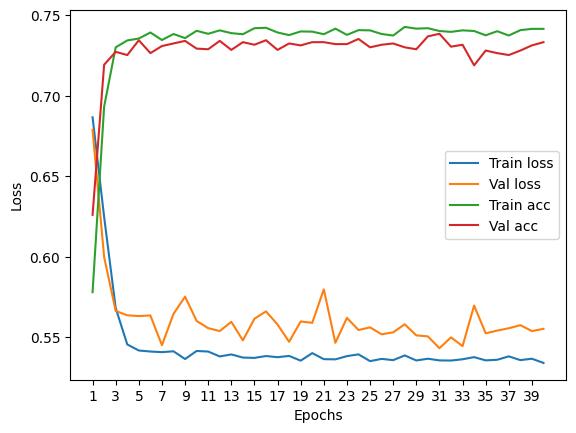

****************************************************************************************************



118it [00:00, 224.06it/s]


Train Epoch: 0 	Loss: 0.678598, Accuracy: 4563/7500 (61%)
Val Epoch: 0 	Loss: 0.653843, Accuracy: 1745/2500 (70%)



118it [00:00, 227.24it/s]


Train Epoch: 1 	Loss: 0.609269, Accuracy: 5326/7500 (71%)
Val Epoch: 1 	Loss: 0.580028, Accuracy: 1813/2500 (73%)



118it [00:00, 221.57it/s]


Train Epoch: 2 	Loss: 0.563802, Accuracy: 5446/7500 (73%)
Val Epoch: 2 	Loss: 0.560380, Accuracy: 1822/2500 (73%)



118it [00:00, 232.99it/s]


Train Epoch: 3 	Loss: 0.552847, Accuracy: 5525/7500 (74%)
Val Epoch: 3 	Loss: 0.558425, Accuracy: 1838/2500 (74%)



118it [00:00, 230.98it/s]


Train Epoch: 4 	Loss: 0.547957, Accuracy: 5534/7500 (74%)
Val Epoch: 4 	Loss: 0.558232, Accuracy: 1831/2500 (73%)



118it [00:00, 220.25it/s]


Train Epoch: 5 	Loss: 0.552204, Accuracy: 5526/7500 (74%)
Val Epoch: 5 	Loss: 0.555079, Accuracy: 1824/2500 (73%)



118it [00:00, 231.98it/s]


Train Epoch: 6 	Loss: 0.548696, Accuracy: 5534/7500 (74%)
Val Epoch: 6 	Loss: 0.553137, Accuracy: 1841/2500 (74%)



118it [00:00, 228.66it/s]


Train Epoch: 7 	Loss: 0.551972, Accuracy: 5530/7500 (74%)
Val Epoch: 7 	Loss: 0.568327, Accuracy: 1834/2500 (73%)



118it [00:00, 235.32it/s]


Train Epoch: 8 	Loss: 0.547963, Accuracy: 5541/7500 (74%)
Val Epoch: 8 	Loss: 0.557546, Accuracy: 1831/2500 (73%)



118it [00:00, 195.29it/s]


Train Epoch: 9 	Loss: 0.549424, Accuracy: 5539/7500 (74%)
Val Epoch: 9 	Loss: 0.550844, Accuracy: 1839/2500 (74%)



118it [00:00, 168.46it/s]


Train Epoch: 10 	Loss: 0.547830, Accuracy: 5519/7500 (74%)
Val Epoch: 10 	Loss: 0.553949, Accuracy: 1832/2500 (73%)



118it [00:00, 186.32it/s]


Train Epoch: 11 	Loss: 0.548354, Accuracy: 5527/7500 (74%)
Val Epoch: 11 	Loss: 0.550080, Accuracy: 1831/2500 (73%)



118it [00:00, 212.58it/s]


Train Epoch: 12 	Loss: 0.545849, Accuracy: 5566/7500 (74%)
Val Epoch: 12 	Loss: 0.562018, Accuracy: 1828/2500 (73%)



118it [00:00, 232.51it/s]


Train Epoch: 13 	Loss: 0.549299, Accuracy: 5539/7500 (74%)
Val Epoch: 13 	Loss: 0.556233, Accuracy: 1836/2500 (73%)



118it [00:00, 228.73it/s]


Train Epoch: 14 	Loss: 0.549092, Accuracy: 5523/7500 (74%)
Val Epoch: 14 	Loss: 0.548799, Accuracy: 1831/2500 (73%)



118it [00:00, 233.79it/s]


Train Epoch: 15 	Loss: 0.551838, Accuracy: 5483/7500 (73%)
Val Epoch: 15 	Loss: 0.553806, Accuracy: 1836/2500 (73%)



118it [00:00, 236.38it/s]


Train Epoch: 16 	Loss: 0.549365, Accuracy: 5528/7500 (74%)
Val Epoch: 16 	Loss: 0.547018, Accuracy: 1849/2500 (74%)



118it [00:00, 229.44it/s]


Train Epoch: 17 	Loss: 0.548379, Accuracy: 5552/7500 (74%)
Val Epoch: 17 	Loss: 0.548521, Accuracy: 1828/2500 (73%)



118it [00:00, 228.07it/s]


Train Epoch: 18 	Loss: 0.547281, Accuracy: 5540/7500 (74%)
Val Epoch: 18 	Loss: 0.545224, Accuracy: 1834/2500 (73%)



118it [00:00, 229.39it/s]


Train Epoch: 19 	Loss: 0.546033, Accuracy: 5541/7500 (74%)
Val Epoch: 19 	Loss: 0.555304, Accuracy: 1824/2500 (73%)



118it [00:00, 224.92it/s]


Train Epoch: 20 	Loss: 0.546133, Accuracy: 5551/7500 (74%)
Val Epoch: 20 	Loss: 0.546265, Accuracy: 1823/2500 (73%)



118it [00:00, 232.67it/s]


Train Epoch: 21 	Loss: 0.547572, Accuracy: 5550/7500 (74%)
Val Epoch: 21 	Loss: 0.563634, Accuracy: 1829/2500 (73%)



118it [00:00, 228.06it/s]


Train Epoch: 22 	Loss: 0.545485, Accuracy: 5560/7500 (74%)
Val Epoch: 22 	Loss: 0.551389, Accuracy: 1830/2500 (73%)



118it [00:00, 233.04it/s]


Train Epoch: 23 	Loss: 0.552570, Accuracy: 5529/7500 (74%)
Val Epoch: 23 	Loss: 0.544311, Accuracy: 1827/2500 (73%)



118it [00:00, 228.73it/s]


Train Epoch: 24 	Loss: 0.545160, Accuracy: 5565/7500 (74%)
Val Epoch: 24 	Loss: 0.554750, Accuracy: 1833/2500 (73%)



118it [00:00, 232.67it/s]


Train Epoch: 25 	Loss: 0.546059, Accuracy: 5549/7500 (74%)
Val Epoch: 25 	Loss: 0.551503, Accuracy: 1828/2500 (73%)



118it [00:00, 230.17it/s]


Train Epoch: 26 	Loss: 0.545352, Accuracy: 5557/7500 (74%)
Val Epoch: 26 	Loss: 0.543635, Accuracy: 1829/2500 (73%)



118it [00:00, 227.25it/s]


Train Epoch: 27 	Loss: 0.544454, Accuracy: 5537/7500 (74%)
Val Epoch: 27 	Loss: 0.555319, Accuracy: 1837/2500 (73%)



118it [00:00, 235.18it/s]


Train Epoch: 28 	Loss: 0.546317, Accuracy: 5536/7500 (74%)
Val Epoch: 28 	Loss: 0.560736, Accuracy: 1830/2500 (73%)



118it [00:00, 236.69it/s]


Train Epoch: 29 	Loss: 0.547682, Accuracy: 5573/7500 (74%)
Val Epoch: 29 	Loss: 0.548937, Accuracy: 1832/2500 (73%)



118it [00:00, 230.63it/s]


Train Epoch: 30 	Loss: 0.547275, Accuracy: 5549/7500 (74%)
Val Epoch: 30 	Loss: 0.560919, Accuracy: 1825/2500 (73%)



118it [00:00, 234.68it/s]


Train Epoch: 31 	Loss: 0.547662, Accuracy: 5542/7500 (74%)
Val Epoch: 31 	Loss: 0.560719, Accuracy: 1826/2500 (73%)



118it [00:00, 226.28it/s]


Train Epoch: 32 	Loss: 0.547580, Accuracy: 5518/7500 (74%)
Val Epoch: 32 	Loss: 0.549576, Accuracy: 1835/2500 (73%)



118it [00:00, 168.13it/s]


Train Epoch: 33 	Loss: 0.545732, Accuracy: 5554/7500 (74%)
Val Epoch: 33 	Loss: 0.552799, Accuracy: 1812/2500 (72%)



118it [00:00, 193.56it/s]


Train Epoch: 34 	Loss: 0.545921, Accuracy: 5546/7500 (74%)
Val Epoch: 34 	Loss: 0.548218, Accuracy: 1832/2500 (73%)



118it [00:00, 185.96it/s]


Train Epoch: 35 	Loss: 0.546027, Accuracy: 5562/7500 (74%)
Val Epoch: 35 	Loss: 0.567024, Accuracy: 1837/2500 (73%)



118it [00:00, 235.65it/s]


Train Epoch: 36 	Loss: 0.543374, Accuracy: 5553/7500 (74%)
Val Epoch: 36 	Loss: 0.555041, Accuracy: 1823/2500 (73%)



118it [00:00, 222.63it/s]


Train Epoch: 37 	Loss: 0.545487, Accuracy: 5551/7500 (74%)
Val Epoch: 37 	Loss: 0.557859, Accuracy: 1822/2500 (73%)



118it [00:00, 235.42it/s]


Train Epoch: 38 	Loss: 0.547462, Accuracy: 5534/7500 (74%)
Val Epoch: 38 	Loss: 0.546111, Accuracy: 1837/2500 (73%)



118it [00:00, 226.21it/s]


Train Epoch: 39 	Loss: 0.547707, Accuracy: 5554/7500 (74%)
Val Epoch: 39 	Loss: 0.545478, Accuracy: 1835/2500 (73%)

Test accuracy:  72.2


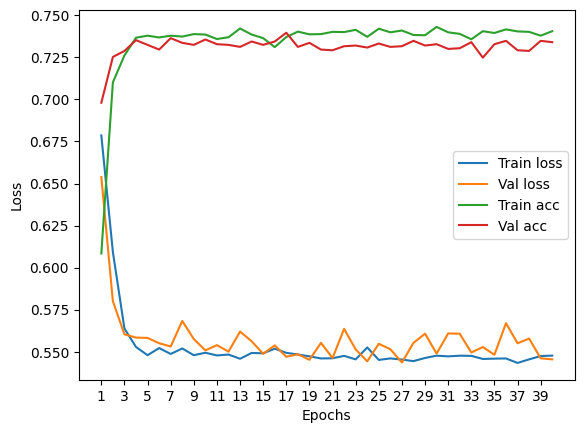

****************************************************************************************************



118it [00:00, 229.12it/s]


Train Epoch: 0 	Loss: 0.678669, Accuracy: 4476/7500 (60%)
Val Epoch: 0 	Loss: 0.656184, Accuracy: 1721/2500 (69%)



118it [00:00, 212.52it/s]


Train Epoch: 1 	Loss: 0.617390, Accuracy: 5272/7500 (70%)
Val Epoch: 1 	Loss: 0.595597, Accuracy: 1793/2500 (72%)



118it [00:00, 169.50it/s]


Train Epoch: 2 	Loss: 0.573907, Accuracy: 5425/7500 (72%)
Val Epoch: 2 	Loss: 0.570402, Accuracy: 1838/2500 (74%)



118it [00:00, 192.92it/s]


Train Epoch: 3 	Loss: 0.562773, Accuracy: 5449/7500 (73%)
Val Epoch: 3 	Loss: 0.560731, Accuracy: 1833/2500 (73%)



118it [00:00, 190.98it/s]


Train Epoch: 4 	Loss: 0.558269, Accuracy: 5449/7500 (73%)
Val Epoch: 4 	Loss: 0.544530, Accuracy: 1855/2500 (74%)



118it [00:00, 228.87it/s]


Train Epoch: 5 	Loss: 0.560302, Accuracy: 5463/7500 (73%)
Val Epoch: 5 	Loss: 0.549728, Accuracy: 1840/2500 (74%)



118it [00:00, 229.04it/s]


Train Epoch: 6 	Loss: 0.556447, Accuracy: 5450/7500 (73%)
Val Epoch: 6 	Loss: 0.556846, Accuracy: 1844/2500 (74%)



118it [00:00, 233.93it/s]


Train Epoch: 7 	Loss: 0.559119, Accuracy: 5425/7500 (72%)
Val Epoch: 7 	Loss: 0.546673, Accuracy: 1845/2500 (74%)



118it [00:00, 226.53it/s]


Train Epoch: 8 	Loss: 0.559267, Accuracy: 5466/7500 (73%)
Val Epoch: 8 	Loss: 0.544928, Accuracy: 1853/2500 (74%)



118it [00:00, 235.68it/s]


Train Epoch: 9 	Loss: 0.555696, Accuracy: 5460/7500 (73%)
Val Epoch: 9 	Loss: 0.543967, Accuracy: 1846/2500 (74%)



118it [00:00, 229.51it/s]


Train Epoch: 10 	Loss: 0.554984, Accuracy: 5459/7500 (73%)
Val Epoch: 10 	Loss: 0.557890, Accuracy: 1847/2500 (74%)



118it [00:00, 192.13it/s]


Train Epoch: 11 	Loss: 0.556401, Accuracy: 5450/7500 (73%)
Val Epoch: 11 	Loss: 0.551002, Accuracy: 1835/2500 (73%)



118it [00:00, 226.96it/s]


Train Epoch: 12 	Loss: 0.555846, Accuracy: 5453/7500 (73%)
Val Epoch: 12 	Loss: 0.549681, Accuracy: 1838/2500 (74%)



118it [00:00, 231.40it/s]


Train Epoch: 13 	Loss: 0.558850, Accuracy: 5419/7500 (72%)
Val Epoch: 13 	Loss: 0.558246, Accuracy: 1823/2500 (73%)



118it [00:00, 229.08it/s]


Train Epoch: 14 	Loss: 0.554875, Accuracy: 5448/7500 (73%)
Val Epoch: 14 	Loss: 0.544208, Accuracy: 1852/2500 (74%)



118it [00:00, 168.14it/s]


Train Epoch: 15 	Loss: 0.556317, Accuracy: 5471/7500 (73%)
Val Epoch: 15 	Loss: 0.546616, Accuracy: 1845/2500 (74%)



118it [00:00, 183.37it/s]


Train Epoch: 16 	Loss: 0.555108, Accuracy: 5456/7500 (73%)
Val Epoch: 16 	Loss: 0.541824, Accuracy: 1849/2500 (74%)



118it [00:00, 163.34it/s]


Train Epoch: 17 	Loss: 0.564305, Accuracy: 5388/7500 (72%)
Val Epoch: 17 	Loss: 0.545923, Accuracy: 1835/2500 (73%)



118it [00:00, 224.92it/s]


Train Epoch: 18 	Loss: 0.557766, Accuracy: 5472/7500 (73%)
Val Epoch: 18 	Loss: 0.549356, Accuracy: 1846/2500 (74%)



118it [00:00, 231.39it/s]


Train Epoch: 19 	Loss: 0.555428, Accuracy: 5440/7500 (73%)
Val Epoch: 19 	Loss: 0.564024, Accuracy: 1810/2500 (72%)



118it [00:00, 236.09it/s]


Train Epoch: 20 	Loss: 0.555604, Accuracy: 5461/7500 (73%)
Val Epoch: 20 	Loss: 0.543540, Accuracy: 1843/2500 (74%)



118it [00:00, 229.67it/s]


Train Epoch: 21 	Loss: 0.557507, Accuracy: 5429/7500 (72%)
Val Epoch: 21 	Loss: 0.538791, Accuracy: 1857/2500 (74%)



118it [00:00, 231.08it/s]


Train Epoch: 22 	Loss: 0.555470, Accuracy: 5454/7500 (73%)
Val Epoch: 22 	Loss: 0.552720, Accuracy: 1821/2500 (73%)



118it [00:00, 231.37it/s]


Train Epoch: 23 	Loss: 0.553544, Accuracy: 5460/7500 (73%)
Val Epoch: 23 	Loss: 0.547631, Accuracy: 1853/2500 (74%)



118it [00:00, 170.83it/s]


Train Epoch: 24 	Loss: 0.554649, Accuracy: 5467/7500 (73%)
Val Epoch: 24 	Loss: 0.545526, Accuracy: 1835/2500 (73%)



118it [00:00, 198.57it/s]


Train Epoch: 25 	Loss: 0.559566, Accuracy: 5446/7500 (73%)
Val Epoch: 25 	Loss: 0.548937, Accuracy: 1835/2500 (73%)



118it [00:00, 182.23it/s]


Train Epoch: 26 	Loss: 0.553037, Accuracy: 5458/7500 (73%)
Val Epoch: 26 	Loss: 0.555295, Accuracy: 1836/2500 (73%)



118it [00:00, 217.41it/s]


Train Epoch: 27 	Loss: 0.553034, Accuracy: 5474/7500 (73%)
Val Epoch: 27 	Loss: 0.549505, Accuracy: 1834/2500 (73%)



118it [00:00, 226.14it/s]


Train Epoch: 28 	Loss: 0.553480, Accuracy: 5464/7500 (73%)
Val Epoch: 28 	Loss: 0.546061, Accuracy: 1842/2500 (74%)



118it [00:00, 234.36it/s]


Train Epoch: 29 	Loss: 0.556804, Accuracy: 5443/7500 (73%)
Val Epoch: 29 	Loss: 0.552077, Accuracy: 1821/2500 (73%)



118it [00:00, 228.60it/s]


Train Epoch: 30 	Loss: 0.552451, Accuracy: 5488/7500 (73%)
Val Epoch: 30 	Loss: 0.543961, Accuracy: 1840/2500 (74%)



118it [00:00, 226.29it/s]


Train Epoch: 31 	Loss: 0.553109, Accuracy: 5464/7500 (73%)
Val Epoch: 31 	Loss: 0.547783, Accuracy: 1825/2500 (73%)



118it [00:00, 232.21it/s]


Train Epoch: 32 	Loss: 0.553249, Accuracy: 5466/7500 (73%)
Val Epoch: 32 	Loss: 0.553063, Accuracy: 1824/2500 (73%)



118it [00:00, 226.39it/s]


Train Epoch: 33 	Loss: 0.553787, Accuracy: 5470/7500 (73%)
Val Epoch: 33 	Loss: 0.541241, Accuracy: 1845/2500 (74%)



118it [00:00, 233.60it/s]


Train Epoch: 34 	Loss: 0.554953, Accuracy: 5444/7500 (73%)
Val Epoch: 34 	Loss: 0.547119, Accuracy: 1855/2500 (74%)



118it [00:00, 232.78it/s]


Train Epoch: 35 	Loss: 0.555315, Accuracy: 5472/7500 (73%)
Val Epoch: 35 	Loss: 0.541910, Accuracy: 1848/2500 (74%)



118it [00:00, 230.51it/s]


Train Epoch: 36 	Loss: 0.552709, Accuracy: 5486/7500 (73%)
Val Epoch: 36 	Loss: 0.556190, Accuracy: 1823/2500 (73%)



118it [00:00, 232.60it/s]


Train Epoch: 37 	Loss: 0.556019, Accuracy: 5478/7500 (73%)
Val Epoch: 37 	Loss: 0.543978, Accuracy: 1858/2500 (74%)



118it [00:00, 230.05it/s]


Train Epoch: 38 	Loss: 0.552021, Accuracy: 5494/7500 (73%)
Val Epoch: 38 	Loss: 0.549253, Accuracy: 1824/2500 (73%)



118it [00:00, 232.91it/s]


Train Epoch: 39 	Loss: 0.551639, Accuracy: 5482/7500 (73%)
Val Epoch: 39 	Loss: 0.543767, Accuracy: 1854/2500 (74%)

Test accuracy:  72.96000000000001


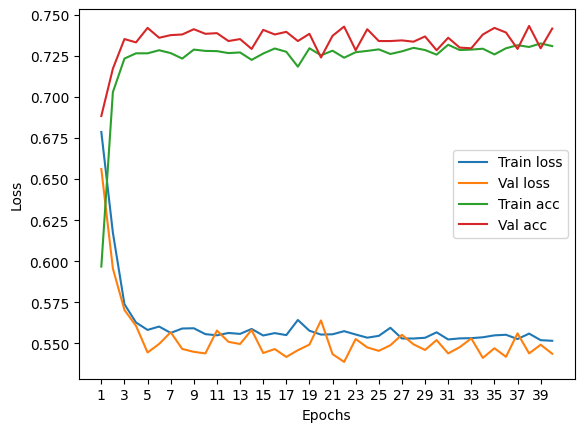

****************************************************************************************************



118it [00:00, 233.76it/s]


Train Epoch: 0 	Loss: 0.690971, Accuracy: 4186/7500 (56%)
Val Epoch: 0 	Loss: 0.680465, Accuracy: 1709/2500 (68%)



118it [00:00, 218.72it/s]


Train Epoch: 1 	Loss: 0.635556, Accuracy: 5127/7500 (68%)
Val Epoch: 1 	Loss: 0.603551, Accuracy: 1796/2500 (72%)



118it [00:00, 232.41it/s]


Train Epoch: 2 	Loss: 0.579794, Accuracy: 5377/7500 (72%)
Val Epoch: 2 	Loss: 0.548334, Accuracy: 1875/2500 (75%)



118it [00:00, 210.39it/s]


Train Epoch: 3 	Loss: 0.563889, Accuracy: 5423/7500 (72%)
Val Epoch: 3 	Loss: 0.550219, Accuracy: 1840/2500 (74%)



118it [00:00, 232.61it/s]


Train Epoch: 4 	Loss: 0.562150, Accuracy: 5419/7500 (72%)
Val Epoch: 4 	Loss: 0.539717, Accuracy: 1875/2500 (75%)



118it [00:00, 231.62it/s]


Train Epoch: 5 	Loss: 0.558597, Accuracy: 5457/7500 (73%)
Val Epoch: 5 	Loss: 0.547466, Accuracy: 1866/2500 (75%)



118it [00:00, 230.13it/s]


Train Epoch: 6 	Loss: 0.559043, Accuracy: 5450/7500 (73%)
Val Epoch: 6 	Loss: 0.537569, Accuracy: 1883/2500 (75%)



118it [00:00, 186.11it/s]


Train Epoch: 7 	Loss: 0.557390, Accuracy: 5419/7500 (72%)
Val Epoch: 7 	Loss: 0.541501, Accuracy: 1884/2500 (75%)



118it [00:00, 227.46it/s]


Train Epoch: 8 	Loss: 0.560137, Accuracy: 5460/7500 (73%)
Val Epoch: 8 	Loss: 0.533147, Accuracy: 1879/2500 (75%)



118it [00:00, 227.97it/s]


Train Epoch: 9 	Loss: 0.557199, Accuracy: 5462/7500 (73%)
Val Epoch: 9 	Loss: 0.550294, Accuracy: 1894/2500 (76%)



118it [00:00, 221.03it/s]


Train Epoch: 10 	Loss: 0.559984, Accuracy: 5433/7500 (72%)
Val Epoch: 10 	Loss: 0.549037, Accuracy: 1882/2500 (75%)



118it [00:00, 208.04it/s]


Train Epoch: 11 	Loss: 0.559990, Accuracy: 5465/7500 (73%)
Val Epoch: 11 	Loss: 0.547627, Accuracy: 1889/2500 (76%)



118it [00:00, 219.69it/s]


Train Epoch: 12 	Loss: 0.560019, Accuracy: 5458/7500 (73%)
Val Epoch: 12 	Loss: 0.545824, Accuracy: 1879/2500 (75%)



118it [00:00, 218.58it/s]


Train Epoch: 13 	Loss: 0.557108, Accuracy: 5468/7500 (73%)
Val Epoch: 13 	Loss: 0.538810, Accuracy: 1884/2500 (75%)



118it [00:00, 230.62it/s]


Train Epoch: 14 	Loss: 0.558222, Accuracy: 5429/7500 (72%)
Val Epoch: 14 	Loss: 0.546847, Accuracy: 1874/2500 (75%)



118it [00:00, 199.08it/s]


Train Epoch: 15 	Loss: 0.557635, Accuracy: 5458/7500 (73%)
Val Epoch: 15 	Loss: 0.536318, Accuracy: 1868/2500 (75%)



118it [00:00, 171.59it/s]


Train Epoch: 16 	Loss: 0.557145, Accuracy: 5465/7500 (73%)
Val Epoch: 16 	Loss: 0.535049, Accuracy: 1876/2500 (75%)



118it [00:00, 193.52it/s]


Train Epoch: 17 	Loss: 0.557518, Accuracy: 5460/7500 (73%)
Val Epoch: 17 	Loss: 0.535702, Accuracy: 1893/2500 (76%)



118it [00:00, 202.10it/s]


Train Epoch: 18 	Loss: 0.556667, Accuracy: 5457/7500 (73%)
Val Epoch: 18 	Loss: 0.541515, Accuracy: 1881/2500 (75%)



118it [00:00, 231.84it/s]


Train Epoch: 19 	Loss: 0.557242, Accuracy: 5466/7500 (73%)
Val Epoch: 19 	Loss: 0.543328, Accuracy: 1873/2500 (75%)



118it [00:00, 228.85it/s]


Train Epoch: 20 	Loss: 0.557464, Accuracy: 5451/7500 (73%)
Val Epoch: 20 	Loss: 0.545433, Accuracy: 1855/2500 (74%)



118it [00:00, 219.25it/s]


Train Epoch: 21 	Loss: 0.559493, Accuracy: 5453/7500 (73%)
Val Epoch: 21 	Loss: 0.550185, Accuracy: 1869/2500 (75%)



118it [00:00, 230.55it/s]


Train Epoch: 22 	Loss: 0.558416, Accuracy: 5470/7500 (73%)
Val Epoch: 22 	Loss: 0.539728, Accuracy: 1894/2500 (76%)



118it [00:00, 225.13it/s]


Train Epoch: 23 	Loss: 0.554773, Accuracy: 5483/7500 (73%)
Val Epoch: 23 	Loss: 0.536661, Accuracy: 1891/2500 (76%)



118it [00:00, 239.90it/s]


Train Epoch: 24 	Loss: 0.556270, Accuracy: 5483/7500 (73%)
Val Epoch: 24 	Loss: 0.530372, Accuracy: 1885/2500 (75%)



118it [00:00, 215.90it/s]


Train Epoch: 25 	Loss: 0.556598, Accuracy: 5478/7500 (73%)
Val Epoch: 25 	Loss: 0.533492, Accuracy: 1879/2500 (75%)



118it [00:00, 227.20it/s]


Train Epoch: 26 	Loss: 0.556680, Accuracy: 5466/7500 (73%)
Val Epoch: 26 	Loss: 0.551297, Accuracy: 1876/2500 (75%)



118it [00:00, 224.08it/s]


Train Epoch: 27 	Loss: 0.556912, Accuracy: 5490/7500 (73%)
Val Epoch: 27 	Loss: 0.536573, Accuracy: 1877/2500 (75%)



118it [00:00, 234.52it/s]


Train Epoch: 28 	Loss: 0.557015, Accuracy: 5451/7500 (73%)
Val Epoch: 28 	Loss: 0.539261, Accuracy: 1862/2500 (74%)



118it [00:00, 160.87it/s]


Train Epoch: 29 	Loss: 0.556702, Accuracy: 5474/7500 (73%)
Val Epoch: 29 	Loss: 0.546215, Accuracy: 1887/2500 (75%)



118it [00:00, 204.77it/s]


Train Epoch: 30 	Loss: 0.561650, Accuracy: 5443/7500 (73%)
Val Epoch: 30 	Loss: 0.544768, Accuracy: 1870/2500 (75%)



118it [00:00, 198.08it/s]


Train Epoch: 31 	Loss: 0.556013, Accuracy: 5477/7500 (73%)
Val Epoch: 31 	Loss: 0.554030, Accuracy: 1854/2500 (74%)



118it [00:00, 225.71it/s]


Train Epoch: 32 	Loss: 0.555925, Accuracy: 5451/7500 (73%)
Val Epoch: 32 	Loss: 0.544911, Accuracy: 1872/2500 (75%)



118it [00:00, 229.67it/s]


Train Epoch: 33 	Loss: 0.557399, Accuracy: 5477/7500 (73%)
Val Epoch: 33 	Loss: 0.537251, Accuracy: 1882/2500 (75%)



118it [00:00, 233.69it/s]


Train Epoch: 34 	Loss: 0.556274, Accuracy: 5478/7500 (73%)
Val Epoch: 34 	Loss: 0.543223, Accuracy: 1881/2500 (75%)



118it [00:00, 229.28it/s]


Train Epoch: 35 	Loss: 0.557399, Accuracy: 5440/7500 (73%)
Val Epoch: 35 	Loss: 0.534334, Accuracy: 1875/2500 (75%)



118it [00:00, 232.67it/s]


Train Epoch: 36 	Loss: 0.557973, Accuracy: 5466/7500 (73%)
Val Epoch: 36 	Loss: 0.543098, Accuracy: 1875/2500 (75%)



118it [00:00, 230.20it/s]


Train Epoch: 37 	Loss: 0.557688, Accuracy: 5442/7500 (73%)
Val Epoch: 37 	Loss: 0.547565, Accuracy: 1854/2500 (74%)



118it [00:00, 170.58it/s]


Train Epoch: 38 	Loss: 0.556130, Accuracy: 5483/7500 (73%)
Val Epoch: 38 	Loss: 0.535315, Accuracy: 1875/2500 (75%)



118it [00:00, 187.43it/s]


Train Epoch: 39 	Loss: 0.557813, Accuracy: 5478/7500 (73%)
Val Epoch: 39 	Loss: 0.547317, Accuracy: 1862/2500 (74%)

Test accuracy:  72.2


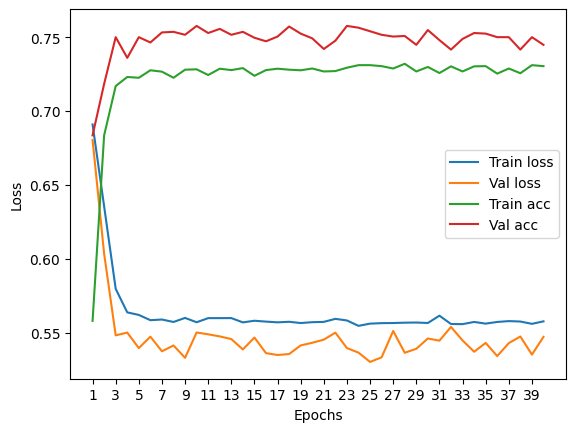

****************************************************************************************************



118it [00:00, 234.64it/s]


Train Epoch: 0 	Loss: 0.686433, Accuracy: 4365/7500 (58%)
Val Epoch: 0 	Loss: 0.674119, Accuracy: 1686/2500 (67%)



118it [00:00, 232.14it/s]


Train Epoch: 1 	Loss: 0.629701, Accuracy: 5243/7500 (70%)
Val Epoch: 1 	Loss: 0.599450, Accuracy: 1807/2500 (72%)



118it [00:00, 231.41it/s]


Train Epoch: 2 	Loss: 0.576623, Accuracy: 5410/7500 (72%)
Val Epoch: 2 	Loss: 0.565143, Accuracy: 1824/2500 (73%)



118it [00:00, 223.68it/s]


Train Epoch: 3 	Loss: 0.562599, Accuracy: 5412/7500 (72%)
Val Epoch: 3 	Loss: 0.552509, Accuracy: 1856/2500 (74%)



118it [00:00, 231.28it/s]


Train Epoch: 4 	Loss: 0.559198, Accuracy: 5421/7500 (72%)
Val Epoch: 4 	Loss: 0.554309, Accuracy: 1861/2500 (74%)



118it [00:00, 230.82it/s]


Train Epoch: 5 	Loss: 0.556711, Accuracy: 5450/7500 (73%)
Val Epoch: 5 	Loss: 0.553256, Accuracy: 1848/2500 (74%)



118it [00:00, 223.85it/s]


Train Epoch: 6 	Loss: 0.556530, Accuracy: 5451/7500 (73%)
Val Epoch: 6 	Loss: 0.551006, Accuracy: 1833/2500 (73%)



118it [00:00, 182.23it/s]


Train Epoch: 7 	Loss: 0.556380, Accuracy: 5431/7500 (72%)
Val Epoch: 7 	Loss: 0.548841, Accuracy: 1851/2500 (74%)



118it [00:00, 148.40it/s]


Train Epoch: 8 	Loss: 0.556677, Accuracy: 5462/7500 (73%)
Val Epoch: 8 	Loss: 0.556202, Accuracy: 1850/2500 (74%)



118it [00:00, 177.75it/s]


Train Epoch: 9 	Loss: 0.554429, Accuracy: 5458/7500 (73%)
Val Epoch: 9 	Loss: 0.554598, Accuracy: 1825/2500 (73%)



118it [00:00, 228.23it/s]


Train Epoch: 10 	Loss: 0.553534, Accuracy: 5456/7500 (73%)
Val Epoch: 10 	Loss: 0.551037, Accuracy: 1851/2500 (74%)



118it [00:00, 228.37it/s]


Train Epoch: 11 	Loss: 0.553271, Accuracy: 5463/7500 (73%)
Val Epoch: 11 	Loss: 0.542871, Accuracy: 1852/2500 (74%)



118it [00:00, 230.76it/s]


Train Epoch: 12 	Loss: 0.557039, Accuracy: 5456/7500 (73%)
Val Epoch: 12 	Loss: 0.563771, Accuracy: 1857/2500 (74%)



118it [00:00, 233.46it/s]


Train Epoch: 13 	Loss: 0.552313, Accuracy: 5469/7500 (73%)
Val Epoch: 13 	Loss: 0.551129, Accuracy: 1845/2500 (74%)



118it [00:00, 227.46it/s]


Train Epoch: 14 	Loss: 0.554403, Accuracy: 5458/7500 (73%)
Val Epoch: 14 	Loss: 0.556201, Accuracy: 1856/2500 (74%)



118it [00:00, 225.65it/s]


Train Epoch: 15 	Loss: 0.554444, Accuracy: 5442/7500 (73%)
Val Epoch: 15 	Loss: 0.561387, Accuracy: 1826/2500 (73%)



118it [00:00, 232.79it/s]


Train Epoch: 16 	Loss: 0.554855, Accuracy: 5461/7500 (73%)
Val Epoch: 16 	Loss: 0.546787, Accuracy: 1850/2500 (74%)



118it [00:00, 226.03it/s]


Train Epoch: 17 	Loss: 0.554241, Accuracy: 5432/7500 (72%)
Val Epoch: 17 	Loss: 0.546338, Accuracy: 1864/2500 (75%)



118it [00:00, 228.37it/s]


Train Epoch: 18 	Loss: 0.552907, Accuracy: 5460/7500 (73%)
Val Epoch: 18 	Loss: 0.556229, Accuracy: 1859/2500 (74%)



118it [00:00, 226.30it/s]


Train Epoch: 19 	Loss: 0.551820, Accuracy: 5488/7500 (73%)
Val Epoch: 19 	Loss: 0.562992, Accuracy: 1819/2500 (73%)



118it [00:00, 230.97it/s]


Train Epoch: 20 	Loss: 0.555581, Accuracy: 5456/7500 (73%)
Val Epoch: 20 	Loss: 0.544312, Accuracy: 1846/2500 (74%)



118it [00:00, 233.01it/s]


Train Epoch: 21 	Loss: 0.552261, Accuracy: 5501/7500 (73%)
Val Epoch: 21 	Loss: 0.548860, Accuracy: 1855/2500 (74%)



118it [00:00, 226.53it/s]


Train Epoch: 22 	Loss: 0.553194, Accuracy: 5445/7500 (73%)
Val Epoch: 22 	Loss: 0.551740, Accuracy: 1841/2500 (74%)



118it [00:00, 227.69it/s]


Train Epoch: 23 	Loss: 0.554373, Accuracy: 5469/7500 (73%)
Val Epoch: 23 	Loss: 0.555069, Accuracy: 1852/2500 (74%)



118it [00:00, 231.68it/s]


Train Epoch: 24 	Loss: 0.551883, Accuracy: 5449/7500 (73%)
Val Epoch: 24 	Loss: 0.544761, Accuracy: 1849/2500 (74%)



118it [00:00, 236.00it/s]


Train Epoch: 25 	Loss: 0.553349, Accuracy: 5462/7500 (73%)
Val Epoch: 25 	Loss: 0.545027, Accuracy: 1856/2500 (74%)



118it [00:00, 226.05it/s]


Train Epoch: 26 	Loss: 0.551001, Accuracy: 5465/7500 (73%)
Val Epoch: 26 	Loss: 0.543625, Accuracy: 1841/2500 (74%)



118it [00:00, 233.68it/s]


Train Epoch: 27 	Loss: 0.554049, Accuracy: 5453/7500 (73%)
Val Epoch: 27 	Loss: 0.549159, Accuracy: 1841/2500 (74%)



118it [00:00, 216.02it/s]


Train Epoch: 28 	Loss: 0.552581, Accuracy: 5471/7500 (73%)
Val Epoch: 28 	Loss: 0.562223, Accuracy: 1854/2500 (74%)



118it [00:00, 229.16it/s]


Train Epoch: 29 	Loss: 0.553753, Accuracy: 5461/7500 (73%)
Val Epoch: 29 	Loss: 0.554070, Accuracy: 1810/2500 (72%)



118it [00:00, 188.92it/s]


Train Epoch: 30 	Loss: 0.551794, Accuracy: 5471/7500 (73%)
Val Epoch: 30 	Loss: 0.544261, Accuracy: 1858/2500 (74%)



118it [00:00, 178.35it/s]


Train Epoch: 31 	Loss: 0.553455, Accuracy: 5485/7500 (73%)
Val Epoch: 31 	Loss: 0.548138, Accuracy: 1845/2500 (74%)



118it [00:00, 180.92it/s]


Train Epoch: 32 	Loss: 0.552372, Accuracy: 5445/7500 (73%)
Val Epoch: 32 	Loss: 0.549099, Accuracy: 1856/2500 (74%)



118it [00:00, 210.27it/s]


Train Epoch: 33 	Loss: 0.554037, Accuracy: 5452/7500 (73%)
Val Epoch: 33 	Loss: 0.548517, Accuracy: 1848/2500 (74%)



118it [00:00, 232.68it/s]


Train Epoch: 34 	Loss: 0.552713, Accuracy: 5474/7500 (73%)
Val Epoch: 34 	Loss: 0.555106, Accuracy: 1829/2500 (73%)



118it [00:00, 228.74it/s]


Train Epoch: 35 	Loss: 0.549824, Accuracy: 5458/7500 (73%)
Val Epoch: 35 	Loss: 0.546888, Accuracy: 1864/2500 (75%)



118it [00:00, 227.82it/s]


Train Epoch: 36 	Loss: 0.551410, Accuracy: 5463/7500 (73%)
Val Epoch: 36 	Loss: 0.545149, Accuracy: 1847/2500 (74%)



118it [00:00, 221.32it/s]


Train Epoch: 37 	Loss: 0.551072, Accuracy: 5464/7500 (73%)
Val Epoch: 37 	Loss: 0.546021, Accuracy: 1855/2500 (74%)



118it [00:00, 232.96it/s]


Train Epoch: 38 	Loss: 0.552005, Accuracy: 5453/7500 (73%)
Val Epoch: 38 	Loss: 0.553273, Accuracy: 1862/2500 (74%)



118it [00:00, 225.67it/s]


Train Epoch: 39 	Loss: 0.552609, Accuracy: 5491/7500 (73%)
Val Epoch: 39 	Loss: 0.542610, Accuracy: 1869/2500 (75%)

Test accuracy:  72.92


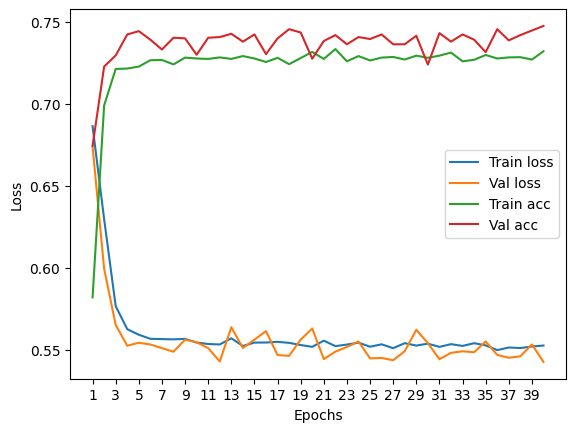

****************************************************************************************************



116it [00:00, 178.88it/s]


Train Epoch: 0 	Loss: 0.679937, Accuracy: 4425/7422 (60%)
Val Epoch: 0 	Loss: 0.661645, Accuracy: 1603/2474 (65%)



116it [00:00, 184.32it/s]


Train Epoch: 1 	Loss: 0.618853, Accuracy: 5142/7422 (69%)
Val Epoch: 1 	Loss: 0.586687, Accuracy: 1828/2474 (74%)



116it [00:00, 201.22it/s]


Train Epoch: 2 	Loss: 0.570280, Accuracy: 5368/7422 (72%)
Val Epoch: 2 	Loss: 0.553813, Accuracy: 1831/2474 (74%)



116it [00:00, 233.08it/s]


Train Epoch: 3 	Loss: 0.552163, Accuracy: 5404/7422 (73%)
Val Epoch: 3 	Loss: 0.548946, Accuracy: 1827/2474 (74%)



116it [00:00, 230.14it/s]


Train Epoch: 4 	Loss: 0.548724, Accuracy: 5449/7422 (73%)
Val Epoch: 4 	Loss: 0.543748, Accuracy: 1809/2474 (73%)



116it [00:00, 229.50it/s]


Train Epoch: 5 	Loss: 0.547500, Accuracy: 5424/7422 (73%)
Val Epoch: 5 	Loss: 0.548555, Accuracy: 1850/2474 (75%)



116it [00:00, 230.51it/s]


Train Epoch: 6 	Loss: 0.548062, Accuracy: 5421/7422 (73%)
Val Epoch: 6 	Loss: 0.542135, Accuracy: 1799/2474 (73%)



116it [00:00, 227.52it/s]


Train Epoch: 7 	Loss: 0.549461, Accuracy: 5417/7422 (73%)
Val Epoch: 7 	Loss: 0.536838, Accuracy: 1828/2474 (74%)



116it [00:00, 223.70it/s]


Train Epoch: 8 	Loss: 0.545705, Accuracy: 5455/7422 (73%)
Val Epoch: 8 	Loss: 0.549881, Accuracy: 1797/2474 (73%)



116it [00:00, 207.62it/s]


Train Epoch: 9 	Loss: 0.545366, Accuracy: 5430/7422 (73%)
Val Epoch: 9 	Loss: 0.536017, Accuracy: 1842/2474 (74%)



116it [00:00, 214.96it/s]


Train Epoch: 10 	Loss: 0.546269, Accuracy: 5433/7422 (73%)
Val Epoch: 10 	Loss: 0.540240, Accuracy: 1818/2474 (73%)



116it [00:00, 230.97it/s]


Train Epoch: 11 	Loss: 0.544956, Accuracy: 5429/7422 (73%)
Val Epoch: 11 	Loss: 0.536434, Accuracy: 1845/2474 (75%)



116it [00:00, 227.99it/s]


Train Epoch: 12 	Loss: 0.545047, Accuracy: 5456/7422 (74%)
Val Epoch: 12 	Loss: 0.536570, Accuracy: 1829/2474 (74%)



116it [00:00, 227.55it/s]


Train Epoch: 13 	Loss: 0.546780, Accuracy: 5432/7422 (73%)
Val Epoch: 13 	Loss: 0.537309, Accuracy: 1845/2474 (75%)



116it [00:00, 233.23it/s]


Train Epoch: 14 	Loss: 0.544841, Accuracy: 5466/7422 (74%)
Val Epoch: 14 	Loss: 0.537919, Accuracy: 1815/2474 (73%)



116it [00:00, 192.06it/s]


Train Epoch: 15 	Loss: 0.546239, Accuracy: 5415/7422 (73%)
Val Epoch: 15 	Loss: 0.537665, Accuracy: 1840/2474 (74%)



116it [00:00, 231.93it/s]


Train Epoch: 16 	Loss: 0.544718, Accuracy: 5468/7422 (74%)
Val Epoch: 16 	Loss: 0.535652, Accuracy: 1841/2474 (74%)



116it [00:00, 227.92it/s]


Train Epoch: 17 	Loss: 0.549334, Accuracy: 5453/7422 (73%)
Val Epoch: 17 	Loss: 0.536301, Accuracy: 1843/2474 (74%)



116it [00:00, 211.19it/s]


Train Epoch: 18 	Loss: 0.545903, Accuracy: 5469/7422 (74%)
Val Epoch: 18 	Loss: 0.537145, Accuracy: 1837/2474 (74%)



116it [00:00, 227.46it/s]


Train Epoch: 19 	Loss: 0.547104, Accuracy: 5440/7422 (73%)
Val Epoch: 19 	Loss: 0.548290, Accuracy: 1838/2474 (74%)



116it [00:00, 230.96it/s]


Train Epoch: 20 	Loss: 0.544978, Accuracy: 5452/7422 (73%)
Val Epoch: 20 	Loss: 0.536708, Accuracy: 1839/2474 (74%)



116it [00:00, 230.13it/s]


Train Epoch: 21 	Loss: 0.544319, Accuracy: 5422/7422 (73%)
Val Epoch: 21 	Loss: 0.537012, Accuracy: 1836/2474 (74%)



116it [00:00, 200.13it/s]


Train Epoch: 22 	Loss: 0.545008, Accuracy: 5469/7422 (74%)
Val Epoch: 22 	Loss: 0.539258, Accuracy: 1840/2474 (74%)



116it [00:00, 166.36it/s]


Train Epoch: 23 	Loss: 0.547839, Accuracy: 5434/7422 (73%)
Val Epoch: 23 	Loss: 0.550544, Accuracy: 1786/2474 (72%)



116it [00:00, 131.53it/s]


Train Epoch: 24 	Loss: 0.545573, Accuracy: 5460/7422 (74%)
Val Epoch: 24 	Loss: 0.543183, Accuracy: 1842/2474 (74%)



116it [00:00, 175.79it/s]


Train Epoch: 25 	Loss: 0.543578, Accuracy: 5498/7422 (74%)
Val Epoch: 25 	Loss: 0.537542, Accuracy: 1828/2474 (74%)



116it [00:00, 172.28it/s]


Train Epoch: 26 	Loss: 0.543315, Accuracy: 5466/7422 (74%)
Val Epoch: 26 	Loss: 0.539016, Accuracy: 1840/2474 (74%)



116it [00:00, 211.16it/s]


Train Epoch: 27 	Loss: 0.544258, Accuracy: 5451/7422 (73%)
Val Epoch: 27 	Loss: 0.543326, Accuracy: 1801/2474 (73%)



116it [00:00, 223.64it/s]


Train Epoch: 28 	Loss: 0.542030, Accuracy: 5493/7422 (74%)
Val Epoch: 28 	Loss: 0.538534, Accuracy: 1834/2474 (74%)



116it [00:00, 231.43it/s]


Train Epoch: 29 	Loss: 0.543182, Accuracy: 5469/7422 (74%)
Val Epoch: 29 	Loss: 0.537311, Accuracy: 1827/2474 (74%)



116it [00:00, 228.69it/s]


Train Epoch: 30 	Loss: 0.543692, Accuracy: 5465/7422 (74%)
Val Epoch: 30 	Loss: 0.541444, Accuracy: 1803/2474 (73%)



116it [00:00, 229.74it/s]


Train Epoch: 31 	Loss: 0.543573, Accuracy: 5500/7422 (74%)
Val Epoch: 31 	Loss: 0.545285, Accuracy: 1845/2474 (75%)



116it [00:00, 225.03it/s]


Train Epoch: 32 	Loss: 0.545716, Accuracy: 5458/7422 (74%)
Val Epoch: 32 	Loss: 0.539530, Accuracy: 1817/2474 (73%)



116it [00:00, 228.15it/s]


Train Epoch: 33 	Loss: 0.542950, Accuracy: 5502/7422 (74%)
Val Epoch: 33 	Loss: 0.539652, Accuracy: 1838/2474 (74%)



116it [00:00, 229.63it/s]


Train Epoch: 34 	Loss: 0.543510, Accuracy: 5467/7422 (74%)
Val Epoch: 34 	Loss: 0.543042, Accuracy: 1806/2474 (73%)



116it [00:00, 228.54it/s]


Train Epoch: 35 	Loss: 0.543370, Accuracy: 5473/7422 (74%)
Val Epoch: 35 	Loss: 0.539713, Accuracy: 1834/2474 (74%)



116it [00:00, 218.04it/s]


Train Epoch: 36 	Loss: 0.543273, Accuracy: 5493/7422 (74%)
Val Epoch: 36 	Loss: 0.538011, Accuracy: 1831/2474 (74%)



116it [00:00, 212.53it/s]


Train Epoch: 37 	Loss: 0.541987, Accuracy: 5481/7422 (74%)
Val Epoch: 37 	Loss: 0.546933, Accuracy: 1786/2474 (72%)



116it [00:00, 217.90it/s]


Train Epoch: 38 	Loss: 0.543479, Accuracy: 5467/7422 (74%)
Val Epoch: 38 	Loss: 0.540672, Accuracy: 1830/2474 (74%)



116it [00:00, 234.59it/s]


Train Epoch: 39 	Loss: 0.546093, Accuracy: 5438/7422 (73%)
Val Epoch: 39 	Loss: 0.542246, Accuracy: 1838/2474 (74%)

Test accuracy:  72.06952303961197


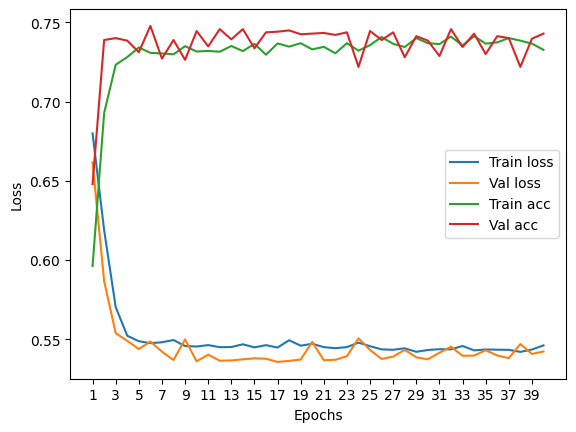

****************************************************************************************************



Particles per jet: 5


118it [00:00, 233.93it/s]


Train Epoch: 0 	Loss: 0.690863, Accuracy: 4204/7500 (56%)
Val Epoch: 0 	Loss: 0.686509, Accuracy: 1476/2500 (59%)



118it [00:00, 223.58it/s]


Train Epoch: 1 	Loss: 0.638845, Accuracy: 4994/7500 (67%)
Val Epoch: 1 	Loss: 0.601913, Accuracy: 1823/2500 (73%)



118it [00:00, 228.61it/s]


Train Epoch: 2 	Loss: 0.575542, Accuracy: 5457/7500 (73%)
Val Epoch: 2 	Loss: 0.555917, Accuracy: 1851/2500 (74%)



118it [00:00, 226.03it/s]


Train Epoch: 3 	Loss: 0.549550, Accuracy: 5524/7500 (74%)
Val Epoch: 3 	Loss: 0.542157, Accuracy: 1860/2500 (74%)



118it [00:00, 179.88it/s]


Train Epoch: 4 	Loss: 0.543884, Accuracy: 5514/7500 (74%)
Val Epoch: 4 	Loss: 0.536662, Accuracy: 1874/2500 (75%)



118it [00:00, 206.26it/s]


Train Epoch: 5 	Loss: 0.540694, Accuracy: 5552/7500 (74%)
Val Epoch: 5 	Loss: 0.536758, Accuracy: 1875/2500 (75%)



118it [00:00, 215.58it/s]


Train Epoch: 6 	Loss: 0.544151, Accuracy: 5539/7500 (74%)
Val Epoch: 6 	Loss: 0.527776, Accuracy: 1871/2500 (75%)



118it [00:00, 229.96it/s]


Train Epoch: 7 	Loss: 0.541237, Accuracy: 5534/7500 (74%)
Val Epoch: 7 	Loss: 0.526844, Accuracy: 1870/2500 (75%)



118it [00:00, 230.88it/s]


Train Epoch: 8 	Loss: 0.538103, Accuracy: 5561/7500 (74%)
Val Epoch: 8 	Loss: 0.525741, Accuracy: 1875/2500 (75%)



118it [00:00, 230.19it/s]


Train Epoch: 9 	Loss: 0.541330, Accuracy: 5549/7500 (74%)
Val Epoch: 9 	Loss: 0.536323, Accuracy: 1874/2500 (75%)



118it [00:00, 218.41it/s]


Train Epoch: 10 	Loss: 0.539396, Accuracy: 5559/7500 (74%)
Val Epoch: 10 	Loss: 0.536145, Accuracy: 1878/2500 (75%)



118it [00:00, 164.98it/s]


Train Epoch: 11 	Loss: 0.540266, Accuracy: 5538/7500 (74%)
Val Epoch: 11 	Loss: 0.535500, Accuracy: 1875/2500 (75%)



118it [00:00, 189.24it/s]


Train Epoch: 12 	Loss: 0.540519, Accuracy: 5545/7500 (74%)
Val Epoch: 12 	Loss: 0.530686, Accuracy: 1871/2500 (75%)



118it [00:00, 182.04it/s]


Train Epoch: 13 	Loss: 0.539710, Accuracy: 5542/7500 (74%)
Val Epoch: 13 	Loss: 0.531480, Accuracy: 1875/2500 (75%)



118it [00:00, 224.72it/s]


Train Epoch: 14 	Loss: 0.539211, Accuracy: 5562/7500 (74%)
Val Epoch: 14 	Loss: 0.532118, Accuracy: 1872/2500 (75%)



118it [00:00, 231.00it/s]


Train Epoch: 15 	Loss: 0.538303, Accuracy: 5563/7500 (74%)
Val Epoch: 15 	Loss: 0.538181, Accuracy: 1875/2500 (75%)



118it [00:00, 228.21it/s]


Train Epoch: 16 	Loss: 0.538206, Accuracy: 5562/7500 (74%)
Val Epoch: 16 	Loss: 0.529164, Accuracy: 1870/2500 (75%)



118it [00:00, 228.77it/s]


Train Epoch: 17 	Loss: 0.539353, Accuracy: 5572/7500 (74%)
Val Epoch: 17 	Loss: 0.537574, Accuracy: 1870/2500 (75%)



118it [00:00, 228.94it/s]


Train Epoch: 18 	Loss: 0.540083, Accuracy: 5587/7500 (74%)
Val Epoch: 18 	Loss: 0.533428, Accuracy: 1865/2500 (75%)



118it [00:00, 225.41it/s]


Train Epoch: 19 	Loss: 0.538211, Accuracy: 5549/7500 (74%)
Val Epoch: 19 	Loss: 0.537954, Accuracy: 1871/2500 (75%)



118it [00:00, 224.78it/s]


Train Epoch: 20 	Loss: 0.541654, Accuracy: 5568/7500 (74%)
Val Epoch: 20 	Loss: 0.539309, Accuracy: 1874/2500 (75%)



118it [00:00, 223.90it/s]


Train Epoch: 21 	Loss: 0.538855, Accuracy: 5560/7500 (74%)
Val Epoch: 21 	Loss: 0.536259, Accuracy: 1877/2500 (75%)



118it [00:00, 229.39it/s]


Train Epoch: 22 	Loss: 0.540238, Accuracy: 5569/7500 (74%)
Val Epoch: 22 	Loss: 0.537882, Accuracy: 1880/2500 (75%)



118it [00:00, 229.44it/s]


Train Epoch: 23 	Loss: 0.541227, Accuracy: 5554/7500 (74%)
Val Epoch: 23 	Loss: 0.533048, Accuracy: 1886/2500 (75%)



118it [00:00, 221.55it/s]


Train Epoch: 24 	Loss: 0.539568, Accuracy: 5548/7500 (74%)
Val Epoch: 24 	Loss: 0.525545, Accuracy: 1872/2500 (75%)



118it [00:00, 229.13it/s]


Train Epoch: 25 	Loss: 0.539357, Accuracy: 5537/7500 (74%)
Val Epoch: 25 	Loss: 0.537504, Accuracy: 1869/2500 (75%)



118it [00:00, 230.99it/s]


Train Epoch: 26 	Loss: 0.538395, Accuracy: 5556/7500 (74%)
Val Epoch: 26 	Loss: 0.536189, Accuracy: 1880/2500 (75%)



118it [00:00, 217.09it/s]


Train Epoch: 27 	Loss: 0.540845, Accuracy: 5547/7500 (74%)
Val Epoch: 27 	Loss: 0.527226, Accuracy: 1883/2500 (75%)



118it [00:00, 225.75it/s]


Train Epoch: 28 	Loss: 0.540173, Accuracy: 5552/7500 (74%)
Val Epoch: 28 	Loss: 0.538888, Accuracy: 1878/2500 (75%)



118it [00:00, 231.00it/s]


Train Epoch: 29 	Loss: 0.538373, Accuracy: 5549/7500 (74%)
Val Epoch: 29 	Loss: 0.528428, Accuracy: 1876/2500 (75%)



118it [00:00, 226.35it/s]


Train Epoch: 30 	Loss: 0.541552, Accuracy: 5546/7500 (74%)
Val Epoch: 30 	Loss: 0.534034, Accuracy: 1874/2500 (75%)



118it [00:00, 224.19it/s]


Train Epoch: 31 	Loss: 0.537461, Accuracy: 5567/7500 (74%)
Val Epoch: 31 	Loss: 0.533941, Accuracy: 1872/2500 (75%)



118it [00:00, 231.09it/s]


Train Epoch: 32 	Loss: 0.538020, Accuracy: 5575/7500 (74%)
Val Epoch: 32 	Loss: 0.542136, Accuracy: 1863/2500 (75%)



118it [00:00, 209.42it/s]


Train Epoch: 33 	Loss: 0.540733, Accuracy: 5562/7500 (74%)
Val Epoch: 33 	Loss: 0.530127, Accuracy: 1869/2500 (75%)



118it [00:00, 164.72it/s]


Train Epoch: 34 	Loss: 0.538588, Accuracy: 5539/7500 (74%)
Val Epoch: 34 	Loss: 0.521427, Accuracy: 1875/2500 (75%)



118it [00:00, 196.06it/s]


Train Epoch: 35 	Loss: 0.538900, Accuracy: 5551/7500 (74%)
Val Epoch: 35 	Loss: 0.543935, Accuracy: 1873/2500 (75%)



118it [00:00, 182.00it/s]


Train Epoch: 36 	Loss: 0.540260, Accuracy: 5555/7500 (74%)
Val Epoch: 36 	Loss: 0.535196, Accuracy: 1875/2500 (75%)



118it [00:00, 234.09it/s]


Train Epoch: 37 	Loss: 0.540381, Accuracy: 5564/7500 (74%)
Val Epoch: 37 	Loss: 0.529188, Accuracy: 1878/2500 (75%)



118it [00:00, 213.23it/s]


Train Epoch: 38 	Loss: 0.538868, Accuracy: 5569/7500 (74%)
Val Epoch: 38 	Loss: 0.525262, Accuracy: 1872/2500 (75%)



118it [00:00, 228.34it/s]


Train Epoch: 39 	Loss: 0.540928, Accuracy: 5546/7500 (74%)
Val Epoch: 39 	Loss: 0.529236, Accuracy: 1876/2500 (75%)

Test accuracy:  72.96000000000001


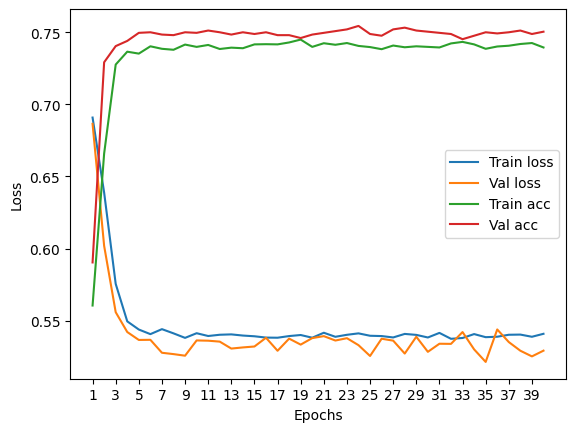

****************************************************************************************************



118it [00:00, 171.38it/s]


Train Epoch: 0 	Loss: 0.692514, Accuracy: 4082/7500 (54%)
Val Epoch: 0 	Loss: 0.691693, Accuracy: 1551/2500 (62%)



118it [00:00, 195.65it/s]


Train Epoch: 1 	Loss: 0.647431, Accuracy: 4986/7500 (66%)
Val Epoch: 1 	Loss: 0.627526, Accuracy: 1739/2500 (70%)



118it [00:00, 185.84it/s]


Train Epoch: 2 	Loss: 0.584648, Accuracy: 5381/7500 (72%)
Val Epoch: 2 	Loss: 0.590491, Accuracy: 1765/2500 (71%)



118it [00:00, 215.56it/s]


Train Epoch: 3 	Loss: 0.557817, Accuracy: 5471/7500 (73%)
Val Epoch: 3 	Loss: 0.585145, Accuracy: 1780/2500 (71%)



118it [00:00, 230.58it/s]


Train Epoch: 4 	Loss: 0.548581, Accuracy: 5490/7500 (73%)
Val Epoch: 4 	Loss: 0.576333, Accuracy: 1785/2500 (71%)



118it [00:00, 219.01it/s]


Train Epoch: 5 	Loss: 0.545672, Accuracy: 5511/7500 (73%)
Val Epoch: 5 	Loss: 0.573913, Accuracy: 1787/2500 (71%)



118it [00:00, 230.79it/s]


Train Epoch: 6 	Loss: 0.543937, Accuracy: 5524/7500 (74%)
Val Epoch: 6 	Loss: 0.573253, Accuracy: 1795/2500 (72%)



118it [00:00, 233.33it/s]


Train Epoch: 7 	Loss: 0.545248, Accuracy: 5509/7500 (73%)
Val Epoch: 7 	Loss: 0.580576, Accuracy: 1796/2500 (72%)



118it [00:00, 211.31it/s]


Train Epoch: 8 	Loss: 0.543770, Accuracy: 5509/7500 (73%)
Val Epoch: 8 	Loss: 0.577752, Accuracy: 1794/2500 (72%)



118it [00:00, 190.13it/s]


Train Epoch: 9 	Loss: 0.545713, Accuracy: 5511/7500 (73%)
Val Epoch: 9 	Loss: 0.576694, Accuracy: 1794/2500 (72%)



118it [00:00, 220.52it/s]


Train Epoch: 10 	Loss: 0.544753, Accuracy: 5517/7500 (74%)
Val Epoch: 10 	Loss: 0.579477, Accuracy: 1797/2500 (72%)



118it [00:00, 225.50it/s]


Train Epoch: 11 	Loss: 0.543643, Accuracy: 5510/7500 (73%)
Val Epoch: 11 	Loss: 0.579653, Accuracy: 1792/2500 (72%)



118it [00:00, 227.75it/s]


Train Epoch: 12 	Loss: 0.547435, Accuracy: 5512/7500 (73%)
Val Epoch: 12 	Loss: 0.586449, Accuracy: 1794/2500 (72%)



118it [00:00, 222.18it/s]


Train Epoch: 13 	Loss: 0.544838, Accuracy: 5493/7500 (73%)
Val Epoch: 13 	Loss: 0.574132, Accuracy: 1786/2500 (71%)



118it [00:00, 231.88it/s]


Train Epoch: 14 	Loss: 0.545394, Accuracy: 5516/7500 (74%)
Val Epoch: 14 	Loss: 0.579101, Accuracy: 1785/2500 (71%)



118it [00:00, 221.71it/s]


Train Epoch: 15 	Loss: 0.543116, Accuracy: 5532/7500 (74%)
Val Epoch: 15 	Loss: 0.569955, Accuracy: 1785/2500 (71%)



118it [00:00, 229.80it/s]


Train Epoch: 16 	Loss: 0.541792, Accuracy: 5503/7500 (73%)
Val Epoch: 16 	Loss: 0.577949, Accuracy: 1790/2500 (72%)



118it [00:00, 213.52it/s]


Train Epoch: 17 	Loss: 0.541148, Accuracy: 5529/7500 (74%)
Val Epoch: 17 	Loss: 0.576486, Accuracy: 1791/2500 (72%)



118it [00:00, 232.88it/s]


Train Epoch: 18 	Loss: 0.543760, Accuracy: 5532/7500 (74%)
Val Epoch: 18 	Loss: 0.587732, Accuracy: 1785/2500 (71%)



118it [00:00, 210.79it/s]


Train Epoch: 19 	Loss: 0.545220, Accuracy: 5507/7500 (73%)
Val Epoch: 19 	Loss: 0.570046, Accuracy: 1806/2500 (72%)



118it [00:00, 228.41it/s]


Train Epoch: 20 	Loss: 0.545372, Accuracy: 5490/7500 (73%)
Val Epoch: 20 	Loss: 0.570139, Accuracy: 1791/2500 (72%)



118it [00:00, 232.00it/s]


Train Epoch: 21 	Loss: 0.542607, Accuracy: 5519/7500 (74%)
Val Epoch: 21 	Loss: 0.571821, Accuracy: 1794/2500 (72%)



118it [00:00, 189.74it/s]


Train Epoch: 22 	Loss: 0.540855, Accuracy: 5509/7500 (73%)
Val Epoch: 22 	Loss: 0.567583, Accuracy: 1805/2500 (72%)



118it [00:00, 171.44it/s]


Train Epoch: 23 	Loss: 0.544464, Accuracy: 5515/7500 (74%)
Val Epoch: 23 	Loss: 0.581468, Accuracy: 1803/2500 (72%)



118it [00:00, 189.00it/s]


Train Epoch: 24 	Loss: 0.542491, Accuracy: 5518/7500 (74%)
Val Epoch: 24 	Loss: 0.569142, Accuracy: 1792/2500 (72%)



118it [00:00, 203.61it/s]


Train Epoch: 25 	Loss: 0.541325, Accuracy: 5543/7500 (74%)
Val Epoch: 25 	Loss: 0.576198, Accuracy: 1787/2500 (71%)



118it [00:00, 226.80it/s]


Train Epoch: 26 	Loss: 0.543110, Accuracy: 5538/7500 (74%)
Val Epoch: 26 	Loss: 0.575385, Accuracy: 1787/2500 (71%)



118it [00:00, 226.61it/s]


Train Epoch: 27 	Loss: 0.543625, Accuracy: 5530/7500 (74%)
Val Epoch: 27 	Loss: 0.577523, Accuracy: 1786/2500 (71%)



118it [00:00, 221.12it/s]


Train Epoch: 28 	Loss: 0.542182, Accuracy: 5519/7500 (74%)
Val Epoch: 28 	Loss: 0.572006, Accuracy: 1795/2500 (72%)



118it [00:00, 227.09it/s]


Train Epoch: 29 	Loss: 0.541597, Accuracy: 5538/7500 (74%)
Val Epoch: 29 	Loss: 0.572280, Accuracy: 1791/2500 (72%)



118it [00:00, 230.03it/s]


Train Epoch: 30 	Loss: 0.543230, Accuracy: 5522/7500 (74%)
Val Epoch: 30 	Loss: 0.577647, Accuracy: 1794/2500 (72%)



118it [00:00, 226.62it/s]


Train Epoch: 31 	Loss: 0.547307, Accuracy: 5490/7500 (73%)
Val Epoch: 31 	Loss: 0.571445, Accuracy: 1788/2500 (72%)



118it [00:00, 225.71it/s]


Train Epoch: 32 	Loss: 0.544790, Accuracy: 5501/7500 (73%)
Val Epoch: 32 	Loss: 0.577805, Accuracy: 1789/2500 (72%)



118it [00:00, 226.32it/s]


Train Epoch: 33 	Loss: 0.542873, Accuracy: 5529/7500 (74%)
Val Epoch: 33 	Loss: 0.575205, Accuracy: 1797/2500 (72%)



118it [00:00, 227.69it/s]


Train Epoch: 34 	Loss: 0.540454, Accuracy: 5531/7500 (74%)
Val Epoch: 34 	Loss: 0.575757, Accuracy: 1791/2500 (72%)



118it [00:00, 223.22it/s]


Train Epoch: 35 	Loss: 0.545931, Accuracy: 5506/7500 (73%)
Val Epoch: 35 	Loss: 0.571731, Accuracy: 1794/2500 (72%)



118it [00:00, 226.95it/s]


Train Epoch: 36 	Loss: 0.544052, Accuracy: 5534/7500 (74%)
Val Epoch: 36 	Loss: 0.577165, Accuracy: 1789/2500 (72%)



118it [00:00, 224.32it/s]


Train Epoch: 37 	Loss: 0.542127, Accuracy: 5521/7500 (74%)
Val Epoch: 37 	Loss: 0.580983, Accuracy: 1789/2500 (72%)



118it [00:00, 227.01it/s]


Train Epoch: 38 	Loss: 0.540646, Accuracy: 5523/7500 (74%)
Val Epoch: 38 	Loss: 0.579433, Accuracy: 1792/2500 (72%)



118it [00:00, 227.70it/s]


Train Epoch: 39 	Loss: 0.542022, Accuracy: 5529/7500 (74%)
Val Epoch: 39 	Loss: 0.583986, Accuracy: 1798/2500 (72%)

Test accuracy:  75.03999999999999


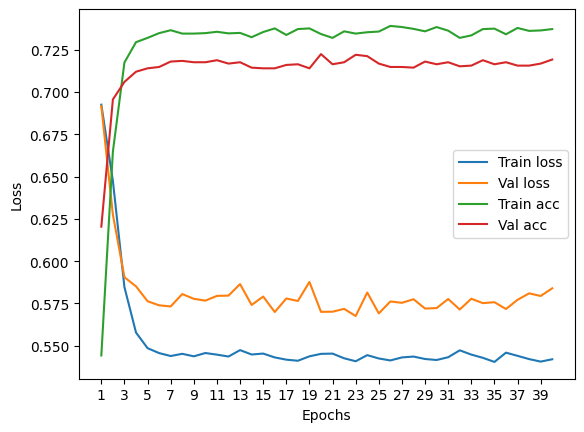

****************************************************************************************************



118it [00:00, 181.29it/s]


Train Epoch: 0 	Loss: 0.690477, Accuracy: 4254/7500 (57%)
Val Epoch: 0 	Loss: 0.683901, Accuracy: 1682/2500 (67%)



118it [00:00, 176.19it/s]


Train Epoch: 1 	Loss: 0.636367, Accuracy: 5106/7500 (68%)
Val Epoch: 1 	Loss: 0.619600, Accuracy: 1758/2500 (70%)



118it [00:00, 165.21it/s]


Train Epoch: 2 	Loss: 0.579280, Accuracy: 5450/7500 (73%)
Val Epoch: 2 	Loss: 0.569242, Accuracy: 1809/2500 (72%)



118it [00:00, 184.76it/s]


Train Epoch: 3 	Loss: 0.555973, Accuracy: 5533/7500 (74%)
Val Epoch: 3 	Loss: 0.559650, Accuracy: 1841/2500 (74%)



118it [00:00, 221.56it/s]


Train Epoch: 4 	Loss: 0.546044, Accuracy: 5536/7500 (74%)
Val Epoch: 4 	Loss: 0.557070, Accuracy: 1841/2500 (74%)



118it [00:00, 221.19it/s]


Train Epoch: 5 	Loss: 0.540445, Accuracy: 5560/7500 (74%)
Val Epoch: 5 	Loss: 0.553684, Accuracy: 1842/2500 (74%)



118it [00:00, 211.63it/s]


Train Epoch: 6 	Loss: 0.540446, Accuracy: 5537/7500 (74%)
Val Epoch: 6 	Loss: 0.565540, Accuracy: 1824/2500 (73%)



118it [00:00, 204.04it/s]


Train Epoch: 7 	Loss: 0.543016, Accuracy: 5570/7500 (74%)
Val Epoch: 7 	Loss: 0.551714, Accuracy: 1837/2500 (73%)



118it [00:00, 169.00it/s]


Train Epoch: 8 	Loss: 0.539767, Accuracy: 5559/7500 (74%)
Val Epoch: 8 	Loss: 0.553725, Accuracy: 1809/2500 (72%)



118it [00:00, 189.71it/s]


Train Epoch: 9 	Loss: 0.540357, Accuracy: 5565/7500 (74%)
Val Epoch: 9 	Loss: 0.560520, Accuracy: 1812/2500 (72%)



118it [00:00, 193.45it/s]


Train Epoch: 10 	Loss: 0.542835, Accuracy: 5557/7500 (74%)
Val Epoch: 10 	Loss: 0.549026, Accuracy: 1828/2500 (73%)



118it [00:00, 232.28it/s]


Train Epoch: 11 	Loss: 0.538945, Accuracy: 5583/7500 (74%)
Val Epoch: 11 	Loss: 0.548989, Accuracy: 1843/2500 (74%)



118it [00:00, 234.09it/s]


Train Epoch: 12 	Loss: 0.539113, Accuracy: 5573/7500 (74%)
Val Epoch: 12 	Loss: 0.554097, Accuracy: 1826/2500 (73%)



118it [00:00, 227.03it/s]


Train Epoch: 13 	Loss: 0.537767, Accuracy: 5596/7500 (75%)
Val Epoch: 13 	Loss: 0.560248, Accuracy: 1823/2500 (73%)



118it [00:00, 227.46it/s]


Train Epoch: 14 	Loss: 0.538944, Accuracy: 5582/7500 (74%)
Val Epoch: 14 	Loss: 0.544033, Accuracy: 1845/2500 (74%)



118it [00:00, 222.02it/s]


Train Epoch: 15 	Loss: 0.537598, Accuracy: 5598/7500 (75%)
Val Epoch: 15 	Loss: 0.561863, Accuracy: 1836/2500 (73%)



118it [00:00, 203.47it/s]


Train Epoch: 16 	Loss: 0.539276, Accuracy: 5575/7500 (74%)
Val Epoch: 16 	Loss: 0.543033, Accuracy: 1846/2500 (74%)



118it [00:00, 144.59it/s]


Train Epoch: 17 	Loss: 0.538347, Accuracy: 5584/7500 (74%)
Val Epoch: 17 	Loss: 0.552785, Accuracy: 1843/2500 (74%)



118it [00:00, 204.27it/s]


Train Epoch: 18 	Loss: 0.538564, Accuracy: 5590/7500 (75%)
Val Epoch: 18 	Loss: 0.559588, Accuracy: 1841/2500 (74%)



118it [00:00, 217.16it/s]


Train Epoch: 19 	Loss: 0.540848, Accuracy: 5576/7500 (74%)
Val Epoch: 19 	Loss: 0.553379, Accuracy: 1833/2500 (73%)



118it [00:00, 181.65it/s]


Train Epoch: 20 	Loss: 0.538352, Accuracy: 5585/7500 (74%)
Val Epoch: 20 	Loss: 0.565104, Accuracy: 1838/2500 (74%)



118it [00:00, 150.55it/s]


Train Epoch: 21 	Loss: 0.541845, Accuracy: 5569/7500 (74%)
Val Epoch: 21 	Loss: 0.546133, Accuracy: 1841/2500 (74%)



118it [00:00, 155.61it/s]


Train Epoch: 22 	Loss: 0.539166, Accuracy: 5605/7500 (75%)
Val Epoch: 22 	Loss: 0.550446, Accuracy: 1846/2500 (74%)



118it [00:00, 207.67it/s]


Train Epoch: 23 	Loss: 0.538018, Accuracy: 5604/7500 (75%)
Val Epoch: 23 	Loss: 0.551914, Accuracy: 1839/2500 (74%)



118it [00:00, 219.95it/s]


Train Epoch: 24 	Loss: 0.539139, Accuracy: 5581/7500 (74%)
Val Epoch: 24 	Loss: 0.547418, Accuracy: 1847/2500 (74%)



118it [00:00, 221.75it/s]


Train Epoch: 25 	Loss: 0.538910, Accuracy: 5597/7500 (75%)
Val Epoch: 25 	Loss: 0.545568, Accuracy: 1842/2500 (74%)



118it [00:00, 225.21it/s]


Train Epoch: 26 	Loss: 0.537922, Accuracy: 5581/7500 (74%)
Val Epoch: 26 	Loss: 0.544038, Accuracy: 1841/2500 (74%)



118it [00:00, 228.07it/s]


Train Epoch: 27 	Loss: 0.537163, Accuracy: 5583/7500 (74%)
Val Epoch: 27 	Loss: 0.554981, Accuracy: 1840/2500 (74%)



118it [00:00, 177.93it/s]


Train Epoch: 28 	Loss: 0.538138, Accuracy: 5575/7500 (74%)
Val Epoch: 28 	Loss: 0.552851, Accuracy: 1847/2500 (74%)



118it [00:00, 172.48it/s]


Train Epoch: 29 	Loss: 0.538102, Accuracy: 5594/7500 (75%)
Val Epoch: 29 	Loss: 0.549087, Accuracy: 1837/2500 (73%)



118it [00:00, 179.66it/s]


Train Epoch: 30 	Loss: 0.536742, Accuracy: 5586/7500 (74%)
Val Epoch: 30 	Loss: 0.553814, Accuracy: 1841/2500 (74%)



118it [00:00, 207.17it/s]


Train Epoch: 31 	Loss: 0.538064, Accuracy: 5574/7500 (74%)
Val Epoch: 31 	Loss: 0.556177, Accuracy: 1830/2500 (73%)



118it [00:00, 227.43it/s]


Train Epoch: 32 	Loss: 0.540092, Accuracy: 5586/7500 (74%)
Val Epoch: 32 	Loss: 0.556625, Accuracy: 1831/2500 (73%)



118it [00:00, 217.65it/s]


Train Epoch: 33 	Loss: 0.539246, Accuracy: 5593/7500 (75%)
Val Epoch: 33 	Loss: 0.550538, Accuracy: 1833/2500 (73%)



118it [00:00, 227.80it/s]


Train Epoch: 34 	Loss: 0.536544, Accuracy: 5586/7500 (74%)
Val Epoch: 34 	Loss: 0.554611, Accuracy: 1845/2500 (74%)



118it [00:00, 221.42it/s]


Train Epoch: 35 	Loss: 0.537548, Accuracy: 5566/7500 (74%)
Val Epoch: 35 	Loss: 0.561011, Accuracy: 1836/2500 (73%)



118it [00:00, 218.77it/s]


Train Epoch: 36 	Loss: 0.536731, Accuracy: 5586/7500 (74%)
Val Epoch: 36 	Loss: 0.560825, Accuracy: 1841/2500 (74%)



118it [00:00, 221.64it/s]


Train Epoch: 37 	Loss: 0.536802, Accuracy: 5589/7500 (75%)
Val Epoch: 37 	Loss: 0.555312, Accuracy: 1843/2500 (74%)



118it [00:00, 220.68it/s]


Train Epoch: 38 	Loss: 0.537444, Accuracy: 5584/7500 (74%)
Val Epoch: 38 	Loss: 0.543460, Accuracy: 1843/2500 (74%)



118it [00:00, 222.78it/s]


Train Epoch: 39 	Loss: 0.536340, Accuracy: 5585/7500 (74%)
Val Epoch: 39 	Loss: 0.559576, Accuracy: 1847/2500 (74%)

Test accuracy:  74.83999999999999


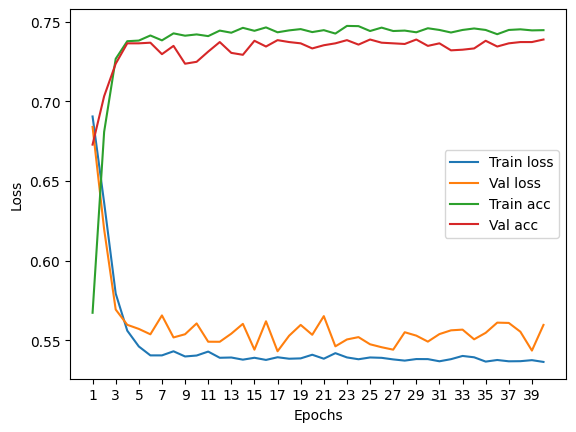

****************************************************************************************************



118it [00:00, 226.40it/s]


Train Epoch: 0 	Loss: 0.689798, Accuracy: 4329/7500 (58%)
Val Epoch: 0 	Loss: 0.684475, Accuracy: 1596/2500 (64%)



118it [00:00, 220.11it/s]


Train Epoch: 1 	Loss: 0.642504, Accuracy: 5056/7500 (67%)
Val Epoch: 1 	Loss: 0.610102, Accuracy: 1741/2500 (70%)



118it [00:00, 226.16it/s]


Train Epoch: 2 	Loss: 0.590563, Accuracy: 5340/7500 (71%)
Val Epoch: 2 	Loss: 0.567880, Accuracy: 1844/2500 (74%)



118it [00:00, 214.66it/s]


Train Epoch: 3 	Loss: 0.562514, Accuracy: 5430/7500 (72%)
Val Epoch: 3 	Loss: 0.556816, Accuracy: 1853/2500 (74%)



118it [00:00, 222.32it/s]


Train Epoch: 4 	Loss: 0.559103, Accuracy: 5409/7500 (72%)
Val Epoch: 4 	Loss: 0.552887, Accuracy: 1844/2500 (74%)



118it [00:00, 225.95it/s]


Train Epoch: 5 	Loss: 0.556996, Accuracy: 5460/7500 (73%)
Val Epoch: 5 	Loss: 0.541856, Accuracy: 1858/2500 (74%)



118it [00:00, 225.49it/s]


Train Epoch: 6 	Loss: 0.555770, Accuracy: 5427/7500 (72%)
Val Epoch: 6 	Loss: 0.547638, Accuracy: 1871/2500 (75%)



118it [00:00, 204.25it/s]


Train Epoch: 7 	Loss: 0.554485, Accuracy: 5452/7500 (73%)
Val Epoch: 7 	Loss: 0.541139, Accuracy: 1861/2500 (74%)



118it [00:00, 229.15it/s]


Train Epoch: 8 	Loss: 0.555208, Accuracy: 5441/7500 (73%)
Val Epoch: 8 	Loss: 0.532195, Accuracy: 1871/2500 (75%)



118it [00:00, 226.56it/s]


Train Epoch: 9 	Loss: 0.554844, Accuracy: 5473/7500 (73%)
Val Epoch: 9 	Loss: 0.543358, Accuracy: 1843/2500 (74%)



118it [00:00, 223.98it/s]


Train Epoch: 10 	Loss: 0.553639, Accuracy: 5476/7500 (73%)
Val Epoch: 10 	Loss: 0.540164, Accuracy: 1891/2500 (76%)



118it [00:00, 220.26it/s]


Train Epoch: 11 	Loss: 0.555304, Accuracy: 5480/7500 (73%)
Val Epoch: 11 	Loss: 0.536479, Accuracy: 1876/2500 (75%)



118it [00:00, 223.38it/s]


Train Epoch: 12 	Loss: 0.554080, Accuracy: 5465/7500 (73%)
Val Epoch: 12 	Loss: 0.539592, Accuracy: 1888/2500 (76%)



118it [00:00, 222.37it/s]


Train Epoch: 13 	Loss: 0.552483, Accuracy: 5466/7500 (73%)
Val Epoch: 13 	Loss: 0.535325, Accuracy: 1878/2500 (75%)



118it [00:00, 226.27it/s]


Train Epoch: 14 	Loss: 0.555268, Accuracy: 5447/7500 (73%)
Val Epoch: 14 	Loss: 0.541975, Accuracy: 1883/2500 (75%)



118it [00:00, 222.45it/s]


Train Epoch: 15 	Loss: 0.554654, Accuracy: 5465/7500 (73%)
Val Epoch: 15 	Loss: 0.542256, Accuracy: 1878/2500 (75%)



118it [00:00, 226.03it/s]


Train Epoch: 16 	Loss: 0.555811, Accuracy: 5433/7500 (72%)
Val Epoch: 16 	Loss: 0.549946, Accuracy: 1876/2500 (75%)



118it [00:00, 166.58it/s]


Train Epoch: 17 	Loss: 0.553888, Accuracy: 5477/7500 (73%)
Val Epoch: 17 	Loss: 0.535020, Accuracy: 1878/2500 (75%)



118it [00:00, 170.54it/s]


Train Epoch: 18 	Loss: 0.555780, Accuracy: 5445/7500 (73%)
Val Epoch: 18 	Loss: 0.539781, Accuracy: 1862/2500 (74%)



118it [00:00, 146.70it/s]


Train Epoch: 19 	Loss: 0.553128, Accuracy: 5471/7500 (73%)
Val Epoch: 19 	Loss: 0.539864, Accuracy: 1848/2500 (74%)



118it [00:00, 208.64it/s]


Train Epoch: 20 	Loss: 0.552975, Accuracy: 5450/7500 (73%)
Val Epoch: 20 	Loss: 0.546392, Accuracy: 1864/2500 (75%)



118it [00:00, 223.14it/s]


Train Epoch: 21 	Loss: 0.552687, Accuracy: 5463/7500 (73%)
Val Epoch: 21 	Loss: 0.535925, Accuracy: 1883/2500 (75%)



118it [00:00, 215.84it/s]


Train Epoch: 22 	Loss: 0.553045, Accuracy: 5479/7500 (73%)
Val Epoch: 22 	Loss: 0.541142, Accuracy: 1886/2500 (75%)



118it [00:00, 225.12it/s]


Train Epoch: 23 	Loss: 0.553095, Accuracy: 5466/7500 (73%)
Val Epoch: 23 	Loss: 0.538362, Accuracy: 1877/2500 (75%)



118it [00:00, 211.65it/s]


Train Epoch: 24 	Loss: 0.554259, Accuracy: 5473/7500 (73%)
Val Epoch: 24 	Loss: 0.546659, Accuracy: 1882/2500 (75%)



118it [00:00, 228.08it/s]


Train Epoch: 25 	Loss: 0.554820, Accuracy: 5447/7500 (73%)
Val Epoch: 25 	Loss: 0.541870, Accuracy: 1859/2500 (74%)



118it [00:00, 220.20it/s]


Train Epoch: 26 	Loss: 0.554420, Accuracy: 5467/7500 (73%)
Val Epoch: 26 	Loss: 0.553141, Accuracy: 1886/2500 (75%)



118it [00:00, 219.65it/s]


Train Epoch: 27 	Loss: 0.552092, Accuracy: 5494/7500 (73%)
Val Epoch: 27 	Loss: 0.547940, Accuracy: 1864/2500 (75%)



118it [00:00, 225.44it/s]


Train Epoch: 28 	Loss: 0.552606, Accuracy: 5466/7500 (73%)
Val Epoch: 28 	Loss: 0.535493, Accuracy: 1869/2500 (75%)



118it [00:00, 227.49it/s]


Train Epoch: 29 	Loss: 0.553529, Accuracy: 5461/7500 (73%)
Val Epoch: 29 	Loss: 0.542981, Accuracy: 1892/2500 (76%)



118it [00:00, 225.84it/s]


Train Epoch: 30 	Loss: 0.555574, Accuracy: 5443/7500 (73%)
Val Epoch: 30 	Loss: 0.536325, Accuracy: 1861/2500 (74%)



118it [00:00, 222.22it/s]


Train Epoch: 31 	Loss: 0.551601, Accuracy: 5475/7500 (73%)
Val Epoch: 31 	Loss: 0.532777, Accuracy: 1882/2500 (75%)



118it [00:00, 201.87it/s]


Train Epoch: 32 	Loss: 0.552333, Accuracy: 5467/7500 (73%)
Val Epoch: 32 	Loss: 0.537189, Accuracy: 1873/2500 (75%)



118it [00:00, 217.10it/s]


Train Epoch: 33 	Loss: 0.551918, Accuracy: 5462/7500 (73%)
Val Epoch: 33 	Loss: 0.542319, Accuracy: 1875/2500 (75%)



118it [00:00, 220.99it/s]


Train Epoch: 34 	Loss: 0.554481, Accuracy: 5467/7500 (73%)
Val Epoch: 34 	Loss: 0.547598, Accuracy: 1873/2500 (75%)



118it [00:00, 223.88it/s]


Train Epoch: 35 	Loss: 0.551443, Accuracy: 5460/7500 (73%)
Val Epoch: 35 	Loss: 0.549479, Accuracy: 1872/2500 (75%)



118it [00:00, 221.00it/s]


Train Epoch: 36 	Loss: 0.551881, Accuracy: 5484/7500 (73%)
Val Epoch: 36 	Loss: 0.546932, Accuracy: 1887/2500 (75%)



118it [00:00, 222.88it/s]


Train Epoch: 37 	Loss: 0.550809, Accuracy: 5468/7500 (73%)
Val Epoch: 37 	Loss: 0.534989, Accuracy: 1886/2500 (75%)



118it [00:00, 229.80it/s]


Train Epoch: 38 	Loss: 0.552561, Accuracy: 5464/7500 (73%)
Val Epoch: 38 	Loss: 0.537545, Accuracy: 1861/2500 (74%)



118it [00:00, 169.19it/s]


Train Epoch: 39 	Loss: 0.552745, Accuracy: 5462/7500 (73%)
Val Epoch: 39 	Loss: 0.546399, Accuracy: 1883/2500 (75%)

Test accuracy:  74.88


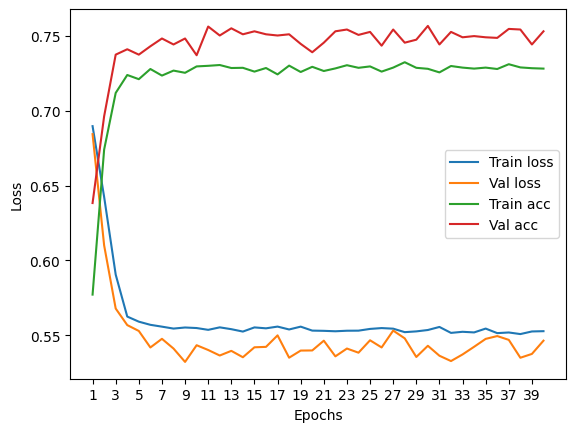

****************************************************************************************************



118it [00:00, 192.04it/s]


Train Epoch: 0 	Loss: 0.686812, Accuracy: 4359/7500 (58%)
Val Epoch: 0 	Loss: 0.672711, Accuracy: 1691/2500 (68%)



118it [00:00, 208.14it/s]


Train Epoch: 1 	Loss: 0.636041, Accuracy: 5069/7500 (68%)
Val Epoch: 1 	Loss: 0.610828, Accuracy: 1766/2500 (71%)



118it [00:00, 214.02it/s]


Train Epoch: 2 	Loss: 0.581601, Accuracy: 5396/7500 (72%)
Val Epoch: 2 	Loss: 0.569247, Accuracy: 1796/2500 (72%)



118it [00:00, 208.97it/s]


Train Epoch: 3 	Loss: 0.562948, Accuracy: 5414/7500 (72%)
Val Epoch: 3 	Loss: 0.564135, Accuracy: 1821/2500 (73%)



118it [00:00, 166.76it/s]


Train Epoch: 4 	Loss: 0.558640, Accuracy: 5422/7500 (72%)
Val Epoch: 4 	Loss: 0.576943, Accuracy: 1778/2500 (71%)



118it [00:01, 90.66it/s]


Train Epoch: 5 	Loss: 0.557827, Accuracy: 5460/7500 (73%)
Val Epoch: 5 	Loss: 0.555450, Accuracy: 1790/2500 (72%)



118it [00:00, 141.92it/s]


Train Epoch: 6 	Loss: 0.559437, Accuracy: 5455/7500 (73%)
Val Epoch: 6 	Loss: 0.562694, Accuracy: 1819/2500 (73%)



118it [00:00, 175.15it/s]


Train Epoch: 7 	Loss: 0.558572, Accuracy: 5470/7500 (73%)
Val Epoch: 7 	Loss: 0.559442, Accuracy: 1825/2500 (73%)



118it [00:00, 207.68it/s]


Train Epoch: 8 	Loss: 0.555436, Accuracy: 5473/7500 (73%)
Val Epoch: 8 	Loss: 0.549465, Accuracy: 1816/2500 (73%)



118it [00:00, 217.07it/s]


Train Epoch: 9 	Loss: 0.557086, Accuracy: 5456/7500 (73%)
Val Epoch: 9 	Loss: 0.553380, Accuracy: 1831/2500 (73%)



118it [00:00, 209.33it/s]


Train Epoch: 10 	Loss: 0.555353, Accuracy: 5490/7500 (73%)
Val Epoch: 10 	Loss: 0.556955, Accuracy: 1800/2500 (72%)



118it [00:00, 218.32it/s]


Train Epoch: 11 	Loss: 0.557985, Accuracy: 5440/7500 (73%)
Val Epoch: 11 	Loss: 0.554040, Accuracy: 1803/2500 (72%)



118it [00:00, 215.80it/s]


Train Epoch: 12 	Loss: 0.556324, Accuracy: 5456/7500 (73%)
Val Epoch: 12 	Loss: 0.548663, Accuracy: 1810/2500 (72%)



118it [00:00, 217.72it/s]


Train Epoch: 13 	Loss: 0.554496, Accuracy: 5465/7500 (73%)
Val Epoch: 13 	Loss: 0.551178, Accuracy: 1798/2500 (72%)



118it [00:00, 207.39it/s]


Train Epoch: 14 	Loss: 0.554569, Accuracy: 5464/7500 (73%)
Val Epoch: 14 	Loss: 0.557706, Accuracy: 1826/2500 (73%)



118it [00:00, 219.80it/s]


Train Epoch: 15 	Loss: 0.557003, Accuracy: 5465/7500 (73%)
Val Epoch: 15 	Loss: 0.562389, Accuracy: 1780/2500 (71%)



118it [00:00, 218.92it/s]


Train Epoch: 16 	Loss: 0.556505, Accuracy: 5424/7500 (72%)
Val Epoch: 16 	Loss: 0.547711, Accuracy: 1828/2500 (73%)



118it [00:00, 219.68it/s]


Train Epoch: 17 	Loss: 0.557299, Accuracy: 5471/7500 (73%)
Val Epoch: 17 	Loss: 0.555487, Accuracy: 1830/2500 (73%)



118it [00:00, 219.26it/s]


Train Epoch: 18 	Loss: 0.553113, Accuracy: 5456/7500 (73%)
Val Epoch: 18 	Loss: 0.553097, Accuracy: 1824/2500 (73%)



118it [00:00, 200.07it/s]


Train Epoch: 19 	Loss: 0.553566, Accuracy: 5469/7500 (73%)
Val Epoch: 19 	Loss: 0.561643, Accuracy: 1785/2500 (71%)



118it [00:00, 213.68it/s]


Train Epoch: 20 	Loss: 0.554934, Accuracy: 5468/7500 (73%)
Val Epoch: 20 	Loss: 0.568162, Accuracy: 1781/2500 (71%)



118it [00:00, 220.46it/s]


Train Epoch: 21 	Loss: 0.557190, Accuracy: 5461/7500 (73%)
Val Epoch: 21 	Loss: 0.550197, Accuracy: 1818/2500 (73%)



118it [00:00, 229.61it/s]


Train Epoch: 22 	Loss: 0.555533, Accuracy: 5470/7500 (73%)
Val Epoch: 22 	Loss: 0.560703, Accuracy: 1801/2500 (72%)



118it [00:00, 222.57it/s]


Train Epoch: 23 	Loss: 0.554466, Accuracy: 5467/7500 (73%)
Val Epoch: 23 	Loss: 0.546826, Accuracy: 1825/2500 (73%)



118it [00:00, 220.71it/s]


Train Epoch: 24 	Loss: 0.554122, Accuracy: 5477/7500 (73%)
Val Epoch: 24 	Loss: 0.547233, Accuracy: 1826/2500 (73%)



118it [00:00, 157.99it/s]


Train Epoch: 25 	Loss: 0.554086, Accuracy: 5459/7500 (73%)
Val Epoch: 25 	Loss: 0.550764, Accuracy: 1813/2500 (73%)



118it [00:00, 184.20it/s]


Train Epoch: 26 	Loss: 0.555497, Accuracy: 5459/7500 (73%)
Val Epoch: 26 	Loss: 0.555642, Accuracy: 1826/2500 (73%)



118it [00:00, 171.93it/s]


Train Epoch: 27 	Loss: 0.557326, Accuracy: 5471/7500 (73%)
Val Epoch: 27 	Loss: 0.557694, Accuracy: 1823/2500 (73%)



118it [00:00, 210.67it/s]


Train Epoch: 28 	Loss: 0.554905, Accuracy: 5450/7500 (73%)
Val Epoch: 28 	Loss: 0.562011, Accuracy: 1796/2500 (72%)



118it [00:00, 180.66it/s]


Train Epoch: 29 	Loss: 0.555921, Accuracy: 5480/7500 (73%)
Val Epoch: 29 	Loss: 0.554396, Accuracy: 1832/2500 (73%)



118it [00:00, 214.46it/s]


Train Epoch: 30 	Loss: 0.551666, Accuracy: 5471/7500 (73%)
Val Epoch: 30 	Loss: 0.558253, Accuracy: 1824/2500 (73%)



118it [00:00, 219.59it/s]


Train Epoch: 31 	Loss: 0.554468, Accuracy: 5479/7500 (73%)
Val Epoch: 31 	Loss: 0.558196, Accuracy: 1822/2500 (73%)



118it [00:00, 190.24it/s]


Train Epoch: 32 	Loss: 0.554147, Accuracy: 5451/7500 (73%)
Val Epoch: 32 	Loss: 0.550504, Accuracy: 1819/2500 (73%)



118it [00:00, 220.37it/s]


Train Epoch: 33 	Loss: 0.554834, Accuracy: 5481/7500 (73%)
Val Epoch: 33 	Loss: 0.549757, Accuracy: 1820/2500 (73%)



118it [00:00, 215.31it/s]


Train Epoch: 34 	Loss: 0.553232, Accuracy: 5487/7500 (73%)
Val Epoch: 34 	Loss: 0.559589, Accuracy: 1788/2500 (72%)



118it [00:00, 217.28it/s]


Train Epoch: 35 	Loss: 0.553579, Accuracy: 5459/7500 (73%)
Val Epoch: 35 	Loss: 0.564789, Accuracy: 1811/2500 (72%)



118it [00:00, 224.58it/s]


Train Epoch: 36 	Loss: 0.554169, Accuracy: 5459/7500 (73%)
Val Epoch: 36 	Loss: 0.551319, Accuracy: 1821/2500 (73%)



118it [00:00, 222.99it/s]


Train Epoch: 37 	Loss: 0.552091, Accuracy: 5458/7500 (73%)
Val Epoch: 37 	Loss: 0.556589, Accuracy: 1827/2500 (73%)



118it [00:00, 223.19it/s]


Train Epoch: 38 	Loss: 0.553462, Accuracy: 5473/7500 (73%)
Val Epoch: 38 	Loss: 0.554292, Accuracy: 1831/2500 (73%)



118it [00:00, 202.49it/s]


Train Epoch: 39 	Loss: 0.554811, Accuracy: 5463/7500 (73%)
Val Epoch: 39 	Loss: 0.558396, Accuracy: 1813/2500 (73%)

Test accuracy:  73.92


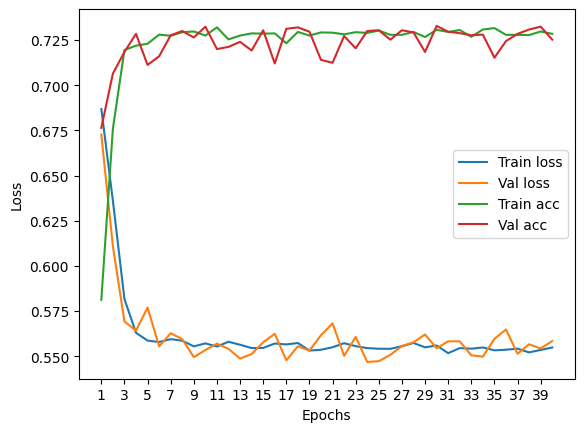

****************************************************************************************************



118it [00:00, 206.80it/s]


Train Epoch: 0 	Loss: 0.689144, Accuracy: 4289/7500 (57%)
Val Epoch: 0 	Loss: 0.685797, Accuracy: 1659/2500 (66%)



118it [00:00, 213.71it/s]


Train Epoch: 1 	Loss: 0.645675, Accuracy: 5009/7500 (67%)
Val Epoch: 1 	Loss: 0.626391, Accuracy: 1796/2500 (72%)



118it [00:00, 224.59it/s]


Train Epoch: 2 	Loss: 0.593103, Accuracy: 5309/7500 (71%)
Val Epoch: 2 	Loss: 0.592672, Accuracy: 1828/2500 (73%)



118it [00:00, 221.34it/s]


Train Epoch: 3 	Loss: 0.571315, Accuracy: 5396/7500 (72%)
Val Epoch: 3 	Loss: 0.580997, Accuracy: 1822/2500 (73%)



118it [00:00, 201.14it/s]


Train Epoch: 4 	Loss: 0.563276, Accuracy: 5442/7500 (73%)
Val Epoch: 4 	Loss: 0.555252, Accuracy: 1833/2500 (73%)



118it [00:00, 223.94it/s]


Train Epoch: 5 	Loss: 0.561554, Accuracy: 5449/7500 (73%)
Val Epoch: 5 	Loss: 0.575897, Accuracy: 1829/2500 (73%)



118it [00:00, 224.89it/s]


Train Epoch: 6 	Loss: 0.563198, Accuracy: 5408/7500 (72%)
Val Epoch: 6 	Loss: 0.562474, Accuracy: 1849/2500 (74%)



118it [00:00, 217.78it/s]


Train Epoch: 7 	Loss: 0.564262, Accuracy: 5434/7500 (72%)
Val Epoch: 7 	Loss: 0.571026, Accuracy: 1837/2500 (73%)



118it [00:00, 223.75it/s]


Train Epoch: 8 	Loss: 0.560151, Accuracy: 5442/7500 (73%)
Val Epoch: 8 	Loss: 0.568990, Accuracy: 1797/2500 (72%)



118it [00:00, 222.68it/s]


Train Epoch: 9 	Loss: 0.560629, Accuracy: 5456/7500 (73%)
Val Epoch: 9 	Loss: 0.551784, Accuracy: 1834/2500 (73%)



118it [00:00, 222.61it/s]


Train Epoch: 10 	Loss: 0.560300, Accuracy: 5447/7500 (73%)
Val Epoch: 10 	Loss: 0.560674, Accuracy: 1836/2500 (73%)



118it [00:00, 227.30it/s]


Train Epoch: 11 	Loss: 0.557572, Accuracy: 5466/7500 (73%)
Val Epoch: 11 	Loss: 0.581351, Accuracy: 1809/2500 (72%)



118it [00:00, 164.31it/s]


Train Epoch: 12 	Loss: 0.560839, Accuracy: 5435/7500 (72%)
Val Epoch: 12 	Loss: 0.551904, Accuracy: 1843/2500 (74%)



118it [00:00, 141.14it/s]


Train Epoch: 13 	Loss: 0.560655, Accuracy: 5467/7500 (73%)
Val Epoch: 13 	Loss: 0.554151, Accuracy: 1856/2500 (74%)



118it [00:00, 155.44it/s]


Train Epoch: 14 	Loss: 0.555491, Accuracy: 5490/7500 (73%)
Val Epoch: 14 	Loss: 0.552701, Accuracy: 1855/2500 (74%)



118it [00:00, 159.70it/s]


Train Epoch: 15 	Loss: 0.556361, Accuracy: 5493/7500 (73%)
Val Epoch: 15 	Loss: 0.557547, Accuracy: 1818/2500 (73%)



118it [00:00, 178.58it/s]


Train Epoch: 16 	Loss: 0.560850, Accuracy: 5471/7500 (73%)
Val Epoch: 16 	Loss: 0.571141, Accuracy: 1845/2500 (74%)



118it [00:00, 220.44it/s]


Train Epoch: 17 	Loss: 0.555731, Accuracy: 5470/7500 (73%)
Val Epoch: 17 	Loss: 0.552240, Accuracy: 1831/2500 (73%)



118it [00:00, 219.05it/s]


Train Epoch: 18 	Loss: 0.555629, Accuracy: 5477/7500 (73%)
Val Epoch: 18 	Loss: 0.551352, Accuracy: 1826/2500 (73%)



118it [00:00, 228.46it/s]


Train Epoch: 19 	Loss: 0.554459, Accuracy: 5485/7500 (73%)
Val Epoch: 19 	Loss: 0.563983, Accuracy: 1827/2500 (73%)



118it [00:00, 220.52it/s]


Train Epoch: 20 	Loss: 0.554076, Accuracy: 5467/7500 (73%)
Val Epoch: 20 	Loss: 0.562828, Accuracy: 1822/2500 (73%)



118it [00:00, 217.70it/s]


Train Epoch: 21 	Loss: 0.556026, Accuracy: 5500/7500 (73%)
Val Epoch: 21 	Loss: 0.553977, Accuracy: 1826/2500 (73%)



118it [00:00, 225.55it/s]


Train Epoch: 22 	Loss: 0.555239, Accuracy: 5492/7500 (73%)
Val Epoch: 22 	Loss: 0.558505, Accuracy: 1829/2500 (73%)



118it [00:00, 226.92it/s]


Train Epoch: 23 	Loss: 0.555332, Accuracy: 5478/7500 (73%)
Val Epoch: 23 	Loss: 0.556813, Accuracy: 1832/2500 (73%)



118it [00:00, 218.40it/s]


Train Epoch: 24 	Loss: 0.555218, Accuracy: 5469/7500 (73%)
Val Epoch: 24 	Loss: 0.553925, Accuracy: 1848/2500 (74%)



118it [00:00, 229.46it/s]


Train Epoch: 25 	Loss: 0.553651, Accuracy: 5482/7500 (73%)
Val Epoch: 25 	Loss: 0.557263, Accuracy: 1852/2500 (74%)



118it [00:00, 224.20it/s]


Train Epoch: 26 	Loss: 0.554715, Accuracy: 5477/7500 (73%)
Val Epoch: 26 	Loss: 0.559714, Accuracy: 1830/2500 (73%)



118it [00:00, 207.36it/s]


Train Epoch: 27 	Loss: 0.553273, Accuracy: 5504/7500 (73%)
Val Epoch: 27 	Loss: 0.561354, Accuracy: 1860/2500 (74%)



118it [00:00, 211.20it/s]


Train Epoch: 28 	Loss: 0.554240, Accuracy: 5487/7500 (73%)
Val Epoch: 28 	Loss: 0.558636, Accuracy: 1854/2500 (74%)



118it [00:00, 222.07it/s]


Train Epoch: 29 	Loss: 0.552109, Accuracy: 5484/7500 (73%)
Val Epoch: 29 	Loss: 0.556236, Accuracy: 1843/2500 (74%)



118it [00:00, 217.39it/s]


Train Epoch: 30 	Loss: 0.554416, Accuracy: 5489/7500 (73%)
Val Epoch: 30 	Loss: 0.549282, Accuracy: 1850/2500 (74%)



118it [00:00, 223.34it/s]


Train Epoch: 31 	Loss: 0.553593, Accuracy: 5526/7500 (74%)
Val Epoch: 31 	Loss: 0.564218, Accuracy: 1848/2500 (74%)



118it [00:00, 216.50it/s]


Train Epoch: 32 	Loss: 0.552034, Accuracy: 5510/7500 (73%)
Val Epoch: 32 	Loss: 0.553642, Accuracy: 1840/2500 (74%)



118it [00:00, 177.14it/s]


Train Epoch: 33 	Loss: 0.551638, Accuracy: 5509/7500 (73%)
Val Epoch: 33 	Loss: 0.551185, Accuracy: 1852/2500 (74%)



118it [00:00, 160.50it/s]


Train Epoch: 34 	Loss: 0.551971, Accuracy: 5509/7500 (73%)
Val Epoch: 34 	Loss: 0.555056, Accuracy: 1839/2500 (74%)



118it [00:00, 174.49it/s]


Train Epoch: 35 	Loss: 0.550955, Accuracy: 5505/7500 (73%)
Val Epoch: 35 	Loss: 0.546659, Accuracy: 1850/2500 (74%)



118it [00:00, 207.30it/s]


Train Epoch: 36 	Loss: 0.553937, Accuracy: 5510/7500 (73%)
Val Epoch: 36 	Loss: 0.563212, Accuracy: 1805/2500 (72%)



118it [00:00, 221.52it/s]


Train Epoch: 37 	Loss: 0.551631, Accuracy: 5507/7500 (73%)
Val Epoch: 37 	Loss: 0.546226, Accuracy: 1844/2500 (74%)



118it [00:00, 217.37it/s]


Train Epoch: 38 	Loss: 0.552119, Accuracy: 5477/7500 (73%)
Val Epoch: 38 	Loss: 0.557422, Accuracy: 1859/2500 (74%)



118it [00:00, 223.69it/s]


Train Epoch: 39 	Loss: 0.552950, Accuracy: 5517/7500 (74%)
Val Epoch: 39 	Loss: 0.555239, Accuracy: 1837/2500 (73%)

Test accuracy:  74.92


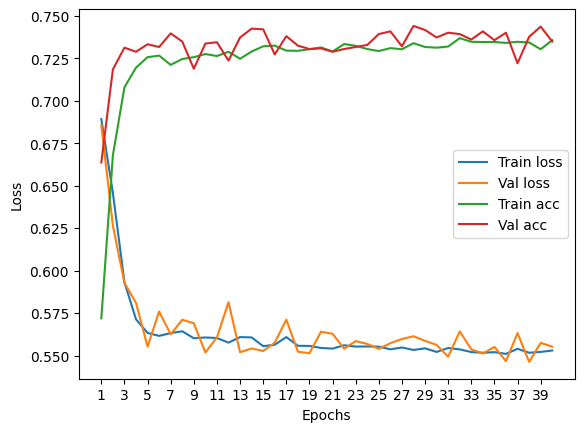

****************************************************************************************************



118it [00:00, 188.90it/s]


Train Epoch: 0 	Loss: 0.697869, Accuracy: 3910/7500 (52%)
Val Epoch: 0 	Loss: 0.701277, Accuracy: 1485/2500 (59%)



118it [00:00, 169.82it/s]


Train Epoch: 1 	Loss: 0.672096, Accuracy: 4634/7500 (62%)
Val Epoch: 1 	Loss: 0.652236, Accuracy: 1697/2500 (68%)



118it [00:00, 201.21it/s]


Train Epoch: 2 	Loss: 0.618320, Accuracy: 5135/7500 (68%)
Val Epoch: 2 	Loss: 0.598216, Accuracy: 1787/2500 (71%)



118it [00:00, 222.15it/s]


Train Epoch: 3 	Loss: 0.576700, Accuracy: 5391/7500 (72%)
Val Epoch: 3 	Loss: 0.579680, Accuracy: 1816/2500 (73%)



118it [00:00, 218.92it/s]


Train Epoch: 4 	Loss: 0.560802, Accuracy: 5445/7500 (73%)
Val Epoch: 4 	Loss: 0.560303, Accuracy: 1829/2500 (73%)



118it [00:00, 215.53it/s]


Train Epoch: 5 	Loss: 0.554362, Accuracy: 5455/7500 (73%)
Val Epoch: 5 	Loss: 0.555297, Accuracy: 1817/2500 (73%)



118it [00:00, 229.27it/s]


Train Epoch: 6 	Loss: 0.553332, Accuracy: 5455/7500 (73%)
Val Epoch: 6 	Loss: 0.565432, Accuracy: 1813/2500 (73%)



118it [00:00, 226.03it/s]


Train Epoch: 7 	Loss: 0.552049, Accuracy: 5462/7500 (73%)
Val Epoch: 7 	Loss: 0.551738, Accuracy: 1836/2500 (73%)



118it [00:00, 221.48it/s]


Train Epoch: 8 	Loss: 0.549200, Accuracy: 5491/7500 (73%)
Val Epoch: 8 	Loss: 0.549569, Accuracy: 1826/2500 (73%)



118it [00:00, 206.07it/s]


Train Epoch: 9 	Loss: 0.548711, Accuracy: 5488/7500 (73%)
Val Epoch: 9 	Loss: 0.558383, Accuracy: 1825/2500 (73%)



118it [00:00, 223.88it/s]


Train Epoch: 10 	Loss: 0.550318, Accuracy: 5488/7500 (73%)
Val Epoch: 10 	Loss: 0.550210, Accuracy: 1845/2500 (74%)



118it [00:00, 218.89it/s]


Train Epoch: 11 	Loss: 0.548299, Accuracy: 5500/7500 (73%)
Val Epoch: 11 	Loss: 0.563989, Accuracy: 1825/2500 (73%)



118it [00:00, 222.27it/s]


Train Epoch: 12 	Loss: 0.548708, Accuracy: 5496/7500 (73%)
Val Epoch: 12 	Loss: 0.548882, Accuracy: 1822/2500 (73%)



118it [00:00, 225.72it/s]


Train Epoch: 13 	Loss: 0.549723, Accuracy: 5491/7500 (73%)
Val Epoch: 13 	Loss: 0.547702, Accuracy: 1838/2500 (74%)



118it [00:00, 211.64it/s]


Train Epoch: 14 	Loss: 0.548339, Accuracy: 5518/7500 (74%)
Val Epoch: 14 	Loss: 0.551934, Accuracy: 1839/2500 (74%)



118it [00:00, 226.59it/s]


Train Epoch: 15 	Loss: 0.546228, Accuracy: 5476/7500 (73%)
Val Epoch: 15 	Loss: 0.561307, Accuracy: 1804/2500 (72%)



118it [00:00, 222.55it/s]


Train Epoch: 16 	Loss: 0.548268, Accuracy: 5507/7500 (73%)
Val Epoch: 16 	Loss: 0.571834, Accuracy: 1846/2500 (74%)



118it [00:00, 218.26it/s]


Train Epoch: 17 	Loss: 0.548748, Accuracy: 5504/7500 (73%)
Val Epoch: 17 	Loss: 0.554390, Accuracy: 1845/2500 (74%)



118it [00:00, 226.02it/s]


Train Epoch: 18 	Loss: 0.547069, Accuracy: 5470/7500 (73%)
Val Epoch: 18 	Loss: 0.555052, Accuracy: 1815/2500 (73%)



118it [00:00, 224.44it/s]


Train Epoch: 19 	Loss: 0.550612, Accuracy: 5496/7500 (73%)
Val Epoch: 19 	Loss: 0.553586, Accuracy: 1825/2500 (73%)



118it [00:00, 220.02it/s]


Train Epoch: 20 	Loss: 0.548092, Accuracy: 5505/7500 (73%)
Val Epoch: 20 	Loss: 0.550911, Accuracy: 1839/2500 (74%)



118it [00:00, 205.23it/s]


Train Epoch: 21 	Loss: 0.547287, Accuracy: 5497/7500 (73%)
Val Epoch: 21 	Loss: 0.549004, Accuracy: 1834/2500 (73%)



118it [00:00, 154.99it/s]


Train Epoch: 22 	Loss: 0.547287, Accuracy: 5490/7500 (73%)
Val Epoch: 22 	Loss: 0.557818, Accuracy: 1828/2500 (73%)



118it [00:00, 179.24it/s]


Train Epoch: 23 	Loss: 0.545839, Accuracy: 5497/7500 (73%)
Val Epoch: 23 	Loss: 0.555239, Accuracy: 1843/2500 (74%)



118it [00:00, 167.24it/s]


Train Epoch: 24 	Loss: 0.547185, Accuracy: 5490/7500 (73%)
Val Epoch: 24 	Loss: 0.567657, Accuracy: 1824/2500 (73%)



118it [00:00, 137.38it/s]


Train Epoch: 25 	Loss: 0.547882, Accuracy: 5483/7500 (73%)
Val Epoch: 25 	Loss: 0.551296, Accuracy: 1842/2500 (74%)



118it [00:00, 201.71it/s]


Train Epoch: 26 	Loss: 0.548198, Accuracy: 5492/7500 (73%)
Val Epoch: 26 	Loss: 0.558136, Accuracy: 1833/2500 (73%)



118it [00:00, 214.86it/s]


Train Epoch: 27 	Loss: 0.551749, Accuracy: 5482/7500 (73%)
Val Epoch: 27 	Loss: 0.556825, Accuracy: 1813/2500 (73%)



118it [00:00, 189.93it/s]


Train Epoch: 28 	Loss: 0.545032, Accuracy: 5513/7500 (74%)
Val Epoch: 28 	Loss: 0.561664, Accuracy: 1831/2500 (73%)



118it [00:00, 217.78it/s]


Train Epoch: 29 	Loss: 0.547099, Accuracy: 5472/7500 (73%)
Val Epoch: 29 	Loss: 0.556285, Accuracy: 1820/2500 (73%)



118it [00:00, 218.52it/s]


Train Epoch: 30 	Loss: 0.545359, Accuracy: 5488/7500 (73%)
Val Epoch: 30 	Loss: 0.552903, Accuracy: 1829/2500 (73%)



118it [00:00, 220.78it/s]


Train Epoch: 31 	Loss: 0.545206, Accuracy: 5503/7500 (73%)
Val Epoch: 31 	Loss: 0.553498, Accuracy: 1817/2500 (73%)



118it [00:00, 219.44it/s]


Train Epoch: 32 	Loss: 0.545554, Accuracy: 5485/7500 (73%)
Val Epoch: 32 	Loss: 0.562412, Accuracy: 1822/2500 (73%)



118it [00:00, 214.01it/s]


Train Epoch: 33 	Loss: 0.547285, Accuracy: 5498/7500 (73%)
Val Epoch: 33 	Loss: 0.579078, Accuracy: 1833/2500 (73%)



118it [00:00, 149.90it/s]


Train Epoch: 34 	Loss: 0.547279, Accuracy: 5473/7500 (73%)
Val Epoch: 34 	Loss: 0.549397, Accuracy: 1845/2500 (74%)



118it [00:00, 204.25it/s]


Train Epoch: 35 	Loss: 0.549308, Accuracy: 5486/7500 (73%)
Val Epoch: 35 	Loss: 0.557430, Accuracy: 1824/2500 (73%)



118it [00:00, 217.99it/s]


Train Epoch: 36 	Loss: 0.547410, Accuracy: 5481/7500 (73%)
Val Epoch: 36 	Loss: 0.556523, Accuracy: 1817/2500 (73%)



118it [00:00, 216.98it/s]


Train Epoch: 37 	Loss: 0.549854, Accuracy: 5467/7500 (73%)
Val Epoch: 37 	Loss: 0.556998, Accuracy: 1844/2500 (74%)



118it [00:00, 222.66it/s]


Train Epoch: 38 	Loss: 0.545788, Accuracy: 5485/7500 (73%)
Val Epoch: 38 	Loss: 0.547818, Accuracy: 1830/2500 (73%)



118it [00:00, 219.39it/s]


Train Epoch: 39 	Loss: 0.548912, Accuracy: 5471/7500 (73%)
Val Epoch: 39 	Loss: 0.553878, Accuracy: 1839/2500 (74%)

Test accuracy:  73.48


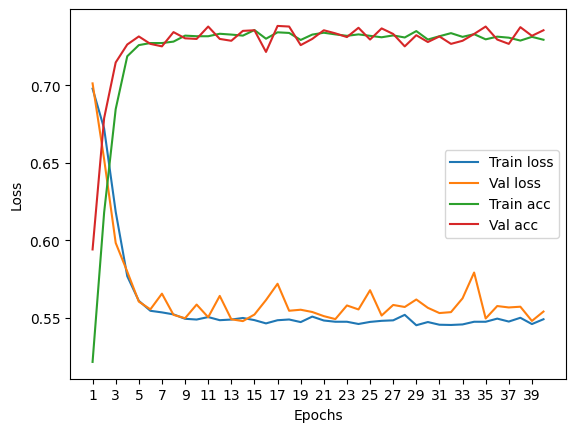

****************************************************************************************************



116it [00:00, 196.47it/s]


Train Epoch: 0 	Loss: 0.682847, Accuracy: 4347/7422 (59%)
Val Epoch: 0 	Loss: 0.666595, Accuracy: 1616/2474 (65%)



116it [00:00, 212.92it/s]


Train Epoch: 1 	Loss: 0.630427, Accuracy: 5065/7422 (68%)
Val Epoch: 1 	Loss: 0.605068, Accuracy: 1771/2474 (72%)



116it [00:00, 224.29it/s]


Train Epoch: 2 	Loss: 0.573155, Accuracy: 5376/7422 (72%)
Val Epoch: 2 	Loss: 0.566433, Accuracy: 1784/2474 (72%)



116it [00:00, 220.03it/s]


Train Epoch: 3 	Loss: 0.550852, Accuracy: 5422/7422 (73%)
Val Epoch: 3 	Loss: 0.558110, Accuracy: 1782/2474 (72%)



116it [00:00, 214.95it/s]


Train Epoch: 4 	Loss: 0.547044, Accuracy: 5449/7422 (73%)
Val Epoch: 4 	Loss: 0.572758, Accuracy: 1770/2474 (72%)



116it [00:00, 217.61it/s]


Train Epoch: 5 	Loss: 0.546283, Accuracy: 5434/7422 (73%)
Val Epoch: 5 	Loss: 0.553554, Accuracy: 1791/2474 (72%)



116it [00:00, 221.83it/s]


Train Epoch: 6 	Loss: 0.542008, Accuracy: 5452/7422 (73%)
Val Epoch: 6 	Loss: 0.557110, Accuracy: 1799/2474 (73%)



116it [00:00, 205.57it/s]


Train Epoch: 7 	Loss: 0.542872, Accuracy: 5477/7422 (74%)
Val Epoch: 7 	Loss: 0.561356, Accuracy: 1798/2474 (73%)



116it [00:00, 155.19it/s]


Train Epoch: 8 	Loss: 0.540223, Accuracy: 5471/7422 (74%)
Val Epoch: 8 	Loss: 0.559647, Accuracy: 1779/2474 (72%)



116it [00:00, 176.72it/s]


Train Epoch: 9 	Loss: 0.542352, Accuracy: 5480/7422 (74%)
Val Epoch: 9 	Loss: 0.566135, Accuracy: 1781/2474 (72%)



116it [00:00, 187.20it/s]


Train Epoch: 10 	Loss: 0.542366, Accuracy: 5463/7422 (74%)
Val Epoch: 10 	Loss: 0.561461, Accuracy: 1793/2474 (72%)



116it [00:00, 220.91it/s]


Train Epoch: 11 	Loss: 0.539704, Accuracy: 5477/7422 (74%)
Val Epoch: 11 	Loss: 0.553243, Accuracy: 1797/2474 (73%)



116it [00:00, 221.73it/s]


Train Epoch: 12 	Loss: 0.541422, Accuracy: 5468/7422 (74%)
Val Epoch: 12 	Loss: 0.552658, Accuracy: 1797/2474 (73%)



116it [00:00, 217.72it/s]


Train Epoch: 13 	Loss: 0.539215, Accuracy: 5480/7422 (74%)
Val Epoch: 13 	Loss: 0.556953, Accuracy: 1805/2474 (73%)



116it [00:00, 217.38it/s]


Train Epoch: 14 	Loss: 0.541731, Accuracy: 5479/7422 (74%)
Val Epoch: 14 	Loss: 0.551698, Accuracy: 1792/2474 (72%)



116it [00:00, 223.26it/s]


Train Epoch: 15 	Loss: 0.539610, Accuracy: 5458/7422 (74%)
Val Epoch: 15 	Loss: 0.553791, Accuracy: 1787/2474 (72%)



116it [00:00, 222.14it/s]


Train Epoch: 16 	Loss: 0.539530, Accuracy: 5467/7422 (74%)
Val Epoch: 16 	Loss: 0.555481, Accuracy: 1789/2474 (72%)



116it [00:00, 183.32it/s]


Train Epoch: 17 	Loss: 0.541404, Accuracy: 5444/7422 (73%)
Val Epoch: 17 	Loss: 0.564324, Accuracy: 1785/2474 (72%)



116it [00:00, 168.25it/s]


Train Epoch: 18 	Loss: 0.542693, Accuracy: 5489/7422 (74%)
Val Epoch: 18 	Loss: 0.551437, Accuracy: 1797/2474 (73%)



116it [00:00, 210.14it/s]


Train Epoch: 19 	Loss: 0.540742, Accuracy: 5472/7422 (74%)
Val Epoch: 19 	Loss: 0.554590, Accuracy: 1784/2474 (72%)



116it [00:00, 170.28it/s]


Train Epoch: 20 	Loss: 0.541341, Accuracy: 5469/7422 (74%)
Val Epoch: 20 	Loss: 0.552671, Accuracy: 1794/2474 (73%)



116it [00:00, 204.60it/s]


Train Epoch: 21 	Loss: 0.537996, Accuracy: 5491/7422 (74%)
Val Epoch: 21 	Loss: 0.553627, Accuracy: 1798/2474 (73%)



116it [00:00, 211.40it/s]


Train Epoch: 22 	Loss: 0.540402, Accuracy: 5450/7422 (73%)
Val Epoch: 22 	Loss: 0.555619, Accuracy: 1792/2474 (72%)



116it [00:00, 217.79it/s]


Train Epoch: 23 	Loss: 0.540067, Accuracy: 5473/7422 (74%)
Val Epoch: 23 	Loss: 0.551108, Accuracy: 1788/2474 (72%)



116it [00:00, 222.00it/s]


Train Epoch: 24 	Loss: 0.538331, Accuracy: 5485/7422 (74%)
Val Epoch: 24 	Loss: 0.553081, Accuracy: 1791/2474 (72%)



116it [00:00, 223.80it/s]


Train Epoch: 25 	Loss: 0.539798, Accuracy: 5464/7422 (74%)
Val Epoch: 25 	Loss: 0.552968, Accuracy: 1790/2474 (72%)



116it [00:00, 225.38it/s]


Train Epoch: 26 	Loss: 0.540336, Accuracy: 5484/7422 (74%)
Val Epoch: 26 	Loss: 0.554031, Accuracy: 1798/2474 (73%)



116it [00:00, 219.54it/s]


Train Epoch: 27 	Loss: 0.539253, Accuracy: 5478/7422 (74%)
Val Epoch: 27 	Loss: 0.551376, Accuracy: 1796/2474 (73%)



116it [00:00, 218.48it/s]


Train Epoch: 28 	Loss: 0.539056, Accuracy: 5484/7422 (74%)
Val Epoch: 28 	Loss: 0.551992, Accuracy: 1806/2474 (73%)



116it [00:00, 180.86it/s]


Train Epoch: 29 	Loss: 0.539462, Accuracy: 5459/7422 (74%)
Val Epoch: 29 	Loss: 0.552630, Accuracy: 1791/2474 (72%)



116it [00:00, 163.33it/s]


Train Epoch: 30 	Loss: 0.539304, Accuracy: 5457/7422 (74%)
Val Epoch: 30 	Loss: 0.553119, Accuracy: 1793/2474 (72%)



116it [00:00, 189.71it/s]


Train Epoch: 31 	Loss: 0.538426, Accuracy: 5471/7422 (74%)
Val Epoch: 31 	Loss: 0.554462, Accuracy: 1808/2474 (73%)



116it [00:00, 192.07it/s]


Train Epoch: 32 	Loss: 0.539484, Accuracy: 5458/7422 (74%)
Val Epoch: 32 	Loss: 0.550229, Accuracy: 1793/2474 (72%)



116it [00:00, 197.82it/s]


Train Epoch: 33 	Loss: 0.540249, Accuracy: 5450/7422 (73%)
Val Epoch: 33 	Loss: 0.555322, Accuracy: 1788/2474 (72%)



116it [00:00, 192.10it/s]


Train Epoch: 34 	Loss: 0.540247, Accuracy: 5497/7422 (74%)
Val Epoch: 34 	Loss: 0.551735, Accuracy: 1788/2474 (72%)



116it [00:00, 227.77it/s]


Train Epoch: 35 	Loss: 0.542239, Accuracy: 5468/7422 (74%)
Val Epoch: 35 	Loss: 0.549975, Accuracy: 1788/2474 (72%)



116it [00:00, 206.28it/s]


Train Epoch: 36 	Loss: 0.538230, Accuracy: 5485/7422 (74%)
Val Epoch: 36 	Loss: 0.552115, Accuracy: 1793/2474 (72%)



116it [00:00, 206.96it/s]


Train Epoch: 37 	Loss: 0.539252, Accuracy: 5463/7422 (74%)
Val Epoch: 37 	Loss: 0.557947, Accuracy: 1794/2474 (73%)



116it [00:00, 213.89it/s]


Train Epoch: 38 	Loss: 0.540844, Accuracy: 5464/7422 (74%)
Val Epoch: 38 	Loss: 0.553146, Accuracy: 1797/2474 (73%)



116it [00:00, 217.82it/s]


Train Epoch: 39 	Loss: 0.538493, Accuracy: 5503/7422 (74%)
Val Epoch: 39 	Loss: 0.551626, Accuracy: 1803/2474 (73%)

Test accuracy:  73.36297493936944


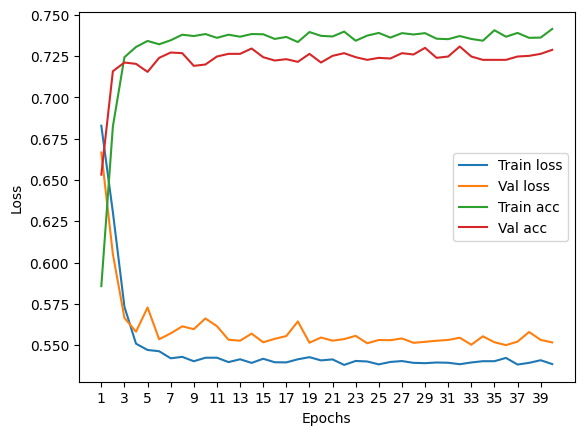

****************************************************************************************************



Particles per jet: 6


118it [00:00, 211.66it/s]


Train Epoch: 0 	Loss: 0.691866, Accuracy: 4146/7500 (55%)
Val Epoch: 0 	Loss: 0.688170, Accuracy: 1451/2500 (58%)



118it [00:00, 209.71it/s]


Train Epoch: 1 	Loss: 0.649150, Accuracy: 4892/7500 (65%)
Val Epoch: 1 	Loss: 0.626770, Accuracy: 1757/2500 (70%)



118it [00:00, 224.76it/s]


Train Epoch: 2 	Loss: 0.592584, Accuracy: 5356/7500 (71%)
Val Epoch: 2 	Loss: 0.571171, Accuracy: 1851/2500 (74%)



118it [00:01, 115.59it/s]


Train Epoch: 3 	Loss: 0.561936, Accuracy: 5445/7500 (73%)
Val Epoch: 3 	Loss: 0.557936, Accuracy: 1860/2500 (74%)



118it [00:01, 92.34it/s] 


Train Epoch: 4 	Loss: 0.550719, Accuracy: 5523/7500 (74%)
Val Epoch: 4 	Loss: 0.554178, Accuracy: 1856/2500 (74%)



118it [00:00, 164.29it/s]


Train Epoch: 5 	Loss: 0.546076, Accuracy: 5529/7500 (74%)
Val Epoch: 5 	Loss: 0.556913, Accuracy: 1857/2500 (74%)



118it [00:00, 151.78it/s]


Train Epoch: 6 	Loss: 0.544081, Accuracy: 5556/7500 (74%)
Val Epoch: 6 	Loss: 0.549092, Accuracy: 1835/2500 (73%)



118it [00:00, 164.10it/s]


Train Epoch: 7 	Loss: 0.543346, Accuracy: 5589/7500 (75%)
Val Epoch: 7 	Loss: 0.545601, Accuracy: 1858/2500 (74%)



118it [00:00, 207.91it/s]


Train Epoch: 8 	Loss: 0.541319, Accuracy: 5583/7500 (74%)
Val Epoch: 8 	Loss: 0.551723, Accuracy: 1830/2500 (73%)



118it [00:00, 213.62it/s]


Train Epoch: 9 	Loss: 0.544875, Accuracy: 5527/7500 (74%)
Val Epoch: 9 	Loss: 0.540821, Accuracy: 1858/2500 (74%)



118it [00:00, 207.79it/s]


Train Epoch: 10 	Loss: 0.542175, Accuracy: 5566/7500 (74%)
Val Epoch: 10 	Loss: 0.547539, Accuracy: 1863/2500 (75%)



118it [00:00, 153.33it/s]


Train Epoch: 11 	Loss: 0.545060, Accuracy: 5554/7500 (74%)
Val Epoch: 11 	Loss: 0.541190, Accuracy: 1862/2500 (74%)



118it [00:00, 181.23it/s]


Train Epoch: 12 	Loss: 0.543446, Accuracy: 5572/7500 (74%)
Val Epoch: 12 	Loss: 0.549541, Accuracy: 1863/2500 (75%)



118it [00:00, 154.42it/s]


Train Epoch: 13 	Loss: 0.541818, Accuracy: 5550/7500 (74%)
Val Epoch: 13 	Loss: 0.546032, Accuracy: 1858/2500 (74%)



118it [00:00, 168.07it/s]


Train Epoch: 14 	Loss: 0.542787, Accuracy: 5561/7500 (74%)
Val Epoch: 14 	Loss: 0.590732, Accuracy: 1853/2500 (74%)



118it [00:00, 210.39it/s]


Train Epoch: 15 	Loss: 0.542274, Accuracy: 5578/7500 (74%)
Val Epoch: 15 	Loss: 0.545980, Accuracy: 1856/2500 (74%)



118it [00:00, 209.19it/s]


Train Epoch: 16 	Loss: 0.544408, Accuracy: 5541/7500 (74%)
Val Epoch: 16 	Loss: 0.539531, Accuracy: 1859/2500 (74%)



118it [00:00, 219.30it/s]


Train Epoch: 17 	Loss: 0.542229, Accuracy: 5575/7500 (74%)
Val Epoch: 17 	Loss: 0.549648, Accuracy: 1851/2500 (74%)



118it [00:00, 210.36it/s]


Train Epoch: 18 	Loss: 0.543037, Accuracy: 5563/7500 (74%)
Val Epoch: 18 	Loss: 0.547044, Accuracy: 1863/2500 (75%)



118it [00:00, 217.97it/s]


Train Epoch: 19 	Loss: 0.541688, Accuracy: 5556/7500 (74%)
Val Epoch: 19 	Loss: 0.552330, Accuracy: 1847/2500 (74%)



118it [00:00, 211.66it/s]


Train Epoch: 20 	Loss: 0.541187, Accuracy: 5561/7500 (74%)
Val Epoch: 20 	Loss: 0.558916, Accuracy: 1849/2500 (74%)



118it [00:00, 217.40it/s]


Train Epoch: 21 	Loss: 0.541524, Accuracy: 5544/7500 (74%)
Val Epoch: 21 	Loss: 0.545981, Accuracy: 1858/2500 (74%)



118it [00:00, 220.39it/s]


Train Epoch: 22 	Loss: 0.542970, Accuracy: 5546/7500 (74%)
Val Epoch: 22 	Loss: 0.540855, Accuracy: 1863/2500 (75%)



118it [00:00, 219.25it/s]


Train Epoch: 23 	Loss: 0.541607, Accuracy: 5564/7500 (74%)
Val Epoch: 23 	Loss: 0.540274, Accuracy: 1855/2500 (74%)



118it [00:00, 219.00it/s]


Train Epoch: 24 	Loss: 0.540952, Accuracy: 5549/7500 (74%)
Val Epoch: 24 	Loss: 0.560324, Accuracy: 1849/2500 (74%)



118it [00:00, 211.95it/s]


Train Epoch: 25 	Loss: 0.538913, Accuracy: 5586/7500 (74%)
Val Epoch: 25 	Loss: 0.548746, Accuracy: 1875/2500 (75%)



118it [00:00, 179.37it/s]


Train Epoch: 26 	Loss: 0.542088, Accuracy: 5570/7500 (74%)
Val Epoch: 26 	Loss: 0.550679, Accuracy: 1849/2500 (74%)



118it [00:00, 183.16it/s]


Train Epoch: 27 	Loss: 0.542693, Accuracy: 5557/7500 (74%)
Val Epoch: 27 	Loss: 0.563940, Accuracy: 1861/2500 (74%)



118it [00:00, 213.38it/s]


Train Epoch: 28 	Loss: 0.539725, Accuracy: 5571/7500 (74%)
Val Epoch: 28 	Loss: 0.551291, Accuracy: 1847/2500 (74%)



118it [00:00, 224.44it/s]


Train Epoch: 29 	Loss: 0.539652, Accuracy: 5587/7500 (74%)
Val Epoch: 29 	Loss: 0.546783, Accuracy: 1860/2500 (74%)



118it [00:00, 213.80it/s]


Train Epoch: 30 	Loss: 0.540681, Accuracy: 5566/7500 (74%)
Val Epoch: 30 	Loss: 0.547463, Accuracy: 1862/2500 (74%)



118it [00:00, 211.43it/s]


Train Epoch: 31 	Loss: 0.542524, Accuracy: 5553/7500 (74%)
Val Epoch: 31 	Loss: 0.551609, Accuracy: 1863/2500 (75%)



118it [00:00, 152.83it/s]


Train Epoch: 32 	Loss: 0.543990, Accuracy: 5543/7500 (74%)
Val Epoch: 32 	Loss: 0.552165, Accuracy: 1844/2500 (74%)



118it [00:00, 193.13it/s]


Train Epoch: 33 	Loss: 0.541340, Accuracy: 5575/7500 (74%)
Val Epoch: 33 	Loss: 0.557867, Accuracy: 1855/2500 (74%)



118it [00:00, 174.48it/s]


Train Epoch: 34 	Loss: 0.539043, Accuracy: 5564/7500 (74%)
Val Epoch: 34 	Loss: 0.549048, Accuracy: 1865/2500 (75%)



118it [00:00, 211.01it/s]


Train Epoch: 35 	Loss: 0.541448, Accuracy: 5563/7500 (74%)
Val Epoch: 35 	Loss: 0.547517, Accuracy: 1869/2500 (75%)



118it [00:00, 222.83it/s]


Train Epoch: 36 	Loss: 0.542841, Accuracy: 5543/7500 (74%)
Val Epoch: 36 	Loss: 0.543871, Accuracy: 1858/2500 (74%)



118it [00:00, 218.03it/s]


Train Epoch: 37 	Loss: 0.541877, Accuracy: 5580/7500 (74%)
Val Epoch: 37 	Loss: 0.543995, Accuracy: 1868/2500 (75%)



118it [00:00, 211.71it/s]


Train Epoch: 38 	Loss: 0.541212, Accuracy: 5571/7500 (74%)
Val Epoch: 38 	Loss: 0.559870, Accuracy: 1838/2500 (74%)



118it [00:00, 215.29it/s]


Train Epoch: 39 	Loss: 0.542267, Accuracy: 5567/7500 (74%)
Val Epoch: 39 	Loss: 0.547323, Accuracy: 1861/2500 (74%)

Test accuracy:  74.36


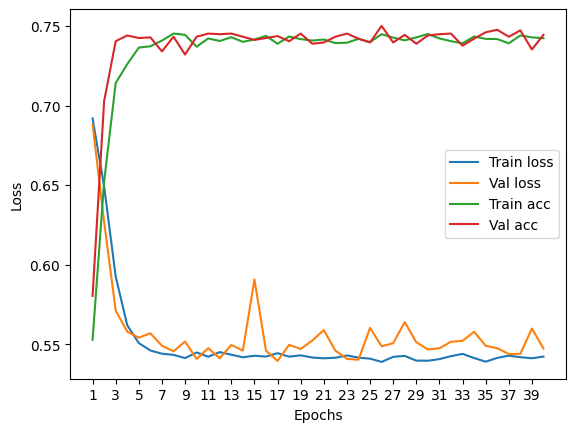

****************************************************************************************************



118it [00:00, 212.21it/s]


Train Epoch: 0 	Loss: 0.690769, Accuracy: 4157/7500 (55%)
Val Epoch: 0 	Loss: 0.686696, Accuracy: 1579/2500 (63%)



118it [00:00, 213.26it/s]


Train Epoch: 1 	Loss: 0.654219, Accuracy: 4877/7500 (65%)
Val Epoch: 1 	Loss: 0.633578, Accuracy: 1774/2500 (71%)



118it [00:00, 222.13it/s]


Train Epoch: 2 	Loss: 0.605107, Accuracy: 5302/7500 (71%)
Val Epoch: 2 	Loss: 0.586302, Accuracy: 1812/2500 (72%)



118it [00:00, 222.87it/s]


Train Epoch: 3 	Loss: 0.575441, Accuracy: 5409/7500 (72%)
Val Epoch: 3 	Loss: 0.580534, Accuracy: 1812/2500 (72%)



118it [00:00, 209.62it/s]


Train Epoch: 4 	Loss: 0.558427, Accuracy: 5462/7500 (73%)
Val Epoch: 4 	Loss: 0.564396, Accuracy: 1829/2500 (73%)



118it [00:00, 220.12it/s]


Train Epoch: 5 	Loss: 0.560816, Accuracy: 5420/7500 (72%)
Val Epoch: 5 	Loss: 0.557055, Accuracy: 1855/2500 (74%)



118it [00:00, 225.57it/s]


Train Epoch: 6 	Loss: 0.555792, Accuracy: 5485/7500 (73%)
Val Epoch: 6 	Loss: 0.551852, Accuracy: 1834/2500 (73%)



118it [00:00, 214.81it/s]


Train Epoch: 7 	Loss: 0.555254, Accuracy: 5469/7500 (73%)
Val Epoch: 7 	Loss: 0.570418, Accuracy: 1817/2500 (73%)



118it [00:00, 209.34it/s]


Train Epoch: 8 	Loss: 0.553149, Accuracy: 5461/7500 (73%)
Val Epoch: 8 	Loss: 0.550541, Accuracy: 1834/2500 (73%)



118it [00:00, 220.57it/s]


Train Epoch: 9 	Loss: 0.553250, Accuracy: 5497/7500 (73%)
Val Epoch: 9 	Loss: 0.566729, Accuracy: 1843/2500 (74%)



118it [00:00, 192.94it/s]


Train Epoch: 10 	Loss: 0.550022, Accuracy: 5495/7500 (73%)
Val Epoch: 10 	Loss: 0.547140, Accuracy: 1857/2500 (74%)



118it [00:00, 204.76it/s]


Train Epoch: 11 	Loss: 0.550447, Accuracy: 5486/7500 (73%)
Val Epoch: 11 	Loss: 0.565748, Accuracy: 1854/2500 (74%)



118it [00:00, 222.75it/s]


Train Epoch: 12 	Loss: 0.548935, Accuracy: 5499/7500 (73%)
Val Epoch: 12 	Loss: 0.549788, Accuracy: 1857/2500 (74%)



118it [00:00, 213.27it/s]


Train Epoch: 13 	Loss: 0.550998, Accuracy: 5479/7500 (73%)
Val Epoch: 13 	Loss: 0.545260, Accuracy: 1854/2500 (74%)



118it [00:00, 213.91it/s]


Train Epoch: 14 	Loss: 0.550833, Accuracy: 5494/7500 (73%)
Val Epoch: 14 	Loss: 0.546424, Accuracy: 1845/2500 (74%)



118it [00:00, 222.56it/s]


Train Epoch: 15 	Loss: 0.552216, Accuracy: 5478/7500 (73%)
Val Epoch: 15 	Loss: 0.557459, Accuracy: 1811/2500 (72%)



118it [00:00, 197.58it/s]


Train Epoch: 16 	Loss: 0.552356, Accuracy: 5504/7500 (73%)
Val Epoch: 16 	Loss: 0.543085, Accuracy: 1866/2500 (75%)



118it [00:00, 154.57it/s]


Train Epoch: 17 	Loss: 0.550510, Accuracy: 5485/7500 (73%)
Val Epoch: 17 	Loss: 0.553860, Accuracy: 1842/2500 (74%)



118it [00:00, 176.40it/s]


Train Epoch: 18 	Loss: 0.551240, Accuracy: 5497/7500 (73%)
Val Epoch: 18 	Loss: 0.571500, Accuracy: 1850/2500 (74%)



118it [00:00, 190.61it/s]


Train Epoch: 19 	Loss: 0.550255, Accuracy: 5501/7500 (73%)
Val Epoch: 19 	Loss: 0.557351, Accuracy: 1808/2500 (72%)



118it [00:00, 218.00it/s]


Train Epoch: 20 	Loss: 0.551156, Accuracy: 5499/7500 (73%)
Val Epoch: 20 	Loss: 0.550594, Accuracy: 1858/2500 (74%)



118it [00:00, 214.05it/s]


Train Epoch: 21 	Loss: 0.551471, Accuracy: 5487/7500 (73%)
Val Epoch: 21 	Loss: 0.556813, Accuracy: 1854/2500 (74%)



118it [00:00, 222.49it/s]


Train Epoch: 22 	Loss: 0.550328, Accuracy: 5532/7500 (74%)
Val Epoch: 22 	Loss: 0.551414, Accuracy: 1850/2500 (74%)



118it [00:00, 217.47it/s]


Train Epoch: 23 	Loss: 0.551161, Accuracy: 5504/7500 (73%)
Val Epoch: 23 	Loss: 0.553523, Accuracy: 1852/2500 (74%)



118it [00:00, 217.83it/s]


Train Epoch: 24 	Loss: 0.549984, Accuracy: 5514/7500 (74%)
Val Epoch: 24 	Loss: 0.547119, Accuracy: 1849/2500 (74%)



118it [00:00, 169.81it/s]


Train Epoch: 25 	Loss: 0.547908, Accuracy: 5527/7500 (74%)
Val Epoch: 25 	Loss: 0.547838, Accuracy: 1862/2500 (74%)



118it [00:00, 208.63it/s]


Train Epoch: 26 	Loss: 0.551472, Accuracy: 5506/7500 (73%)
Val Epoch: 26 	Loss: 0.553500, Accuracy: 1862/2500 (74%)



118it [00:00, 219.44it/s]


Train Epoch: 27 	Loss: 0.549399, Accuracy: 5497/7500 (73%)
Val Epoch: 27 	Loss: 0.546036, Accuracy: 1852/2500 (74%)



118it [00:00, 223.73it/s]


Train Epoch: 28 	Loss: 0.548597, Accuracy: 5529/7500 (74%)
Val Epoch: 28 	Loss: 0.560735, Accuracy: 1853/2500 (74%)



118it [00:00, 219.73it/s]


Train Epoch: 29 	Loss: 0.549776, Accuracy: 5475/7500 (73%)
Val Epoch: 29 	Loss: 0.560928, Accuracy: 1845/2500 (74%)



118it [00:00, 224.47it/s]


Train Epoch: 30 	Loss: 0.549255, Accuracy: 5491/7500 (73%)
Val Epoch: 30 	Loss: 0.553689, Accuracy: 1854/2500 (74%)



118it [00:00, 218.84it/s]


Train Epoch: 31 	Loss: 0.547387, Accuracy: 5502/7500 (73%)
Val Epoch: 31 	Loss: 0.548038, Accuracy: 1862/2500 (74%)



118it [00:00, 217.86it/s]


Train Epoch: 32 	Loss: 0.549125, Accuracy: 5506/7500 (73%)
Val Epoch: 32 	Loss: 0.541957, Accuracy: 1860/2500 (74%)



118it [00:00, 226.40it/s]


Train Epoch: 33 	Loss: 0.552181, Accuracy: 5484/7500 (73%)
Val Epoch: 33 	Loss: 0.538830, Accuracy: 1860/2500 (74%)



118it [00:00, 216.42it/s]


Train Epoch: 34 	Loss: 0.550526, Accuracy: 5494/7500 (73%)
Val Epoch: 34 	Loss: 0.551169, Accuracy: 1849/2500 (74%)



118it [00:00, 214.69it/s]


Train Epoch: 35 	Loss: 0.549141, Accuracy: 5507/7500 (73%)
Val Epoch: 35 	Loss: 0.549098, Accuracy: 1849/2500 (74%)



118it [00:00, 220.20it/s]


Train Epoch: 36 	Loss: 0.550738, Accuracy: 5509/7500 (73%)
Val Epoch: 36 	Loss: 0.540426, Accuracy: 1862/2500 (74%)



118it [00:00, 217.08it/s]


Train Epoch: 37 	Loss: 0.550571, Accuracy: 5497/7500 (73%)
Val Epoch: 37 	Loss: 0.545187, Accuracy: 1854/2500 (74%)



118it [00:00, 159.06it/s]


Train Epoch: 38 	Loss: 0.549659, Accuracy: 5529/7500 (74%)
Val Epoch: 38 	Loss: 0.550993, Accuracy: 1854/2500 (74%)



118it [00:00, 164.73it/s]


Train Epoch: 39 	Loss: 0.551392, Accuracy: 5482/7500 (73%)
Val Epoch: 39 	Loss: 0.543894, Accuracy: 1859/2500 (74%)

Test accuracy:  73.83999999999999


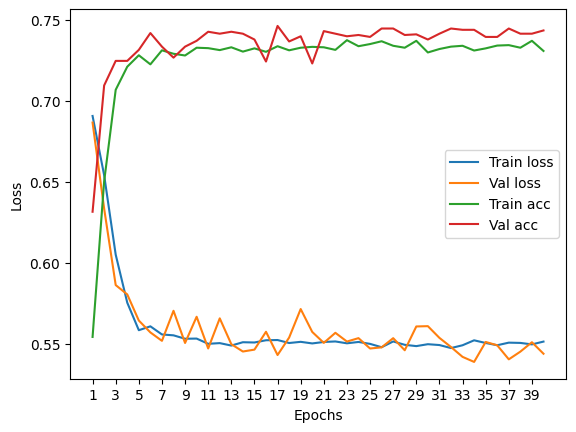

****************************************************************************************************



118it [00:00, 222.86it/s]


Train Epoch: 0 	Loss: 0.691006, Accuracy: 4149/7500 (55%)
Val Epoch: 0 	Loss: 0.686140, Accuracy: 1536/2500 (61%)



118it [00:00, 154.91it/s]


Train Epoch: 1 	Loss: 0.653709, Accuracy: 4850/7500 (65%)
Val Epoch: 1 	Loss: 0.643311, Accuracy: 1700/2500 (68%)



118it [00:00, 188.08it/s]


Train Epoch: 2 	Loss: 0.608343, Accuracy: 5272/7500 (70%)
Val Epoch: 2 	Loss: 0.601183, Accuracy: 1765/2500 (71%)



118it [00:00, 175.54it/s]


Train Epoch: 3 	Loss: 0.576828, Accuracy: 5447/7500 (73%)
Val Epoch: 3 	Loss: 0.578956, Accuracy: 1865/2500 (75%)



118it [00:00, 207.01it/s]


Train Epoch: 4 	Loss: 0.559334, Accuracy: 5480/7500 (73%)
Val Epoch: 4 	Loss: 0.565637, Accuracy: 1849/2500 (74%)



118it [00:00, 220.35it/s]


Train Epoch: 5 	Loss: 0.552137, Accuracy: 5515/7500 (74%)
Val Epoch: 5 	Loss: 0.556135, Accuracy: 1847/2500 (74%)



118it [00:00, 218.99it/s]


Train Epoch: 6 	Loss: 0.550965, Accuracy: 5482/7500 (73%)
Val Epoch: 6 	Loss: 0.563737, Accuracy: 1830/2500 (73%)



118it [00:00, 217.09it/s]


Train Epoch: 7 	Loss: 0.546261, Accuracy: 5521/7500 (74%)
Val Epoch: 7 	Loss: 0.552545, Accuracy: 1876/2500 (75%)



118it [00:00, 215.76it/s]


Train Epoch: 8 	Loss: 0.547307, Accuracy: 5501/7500 (73%)
Val Epoch: 8 	Loss: 0.557559, Accuracy: 1858/2500 (74%)



118it [00:00, 221.49it/s]


Train Epoch: 9 	Loss: 0.549921, Accuracy: 5493/7500 (73%)
Val Epoch: 9 	Loss: 0.541736, Accuracy: 1873/2500 (75%)



118it [00:00, 224.12it/s]


Train Epoch: 10 	Loss: 0.546112, Accuracy: 5528/7500 (74%)
Val Epoch: 10 	Loss: 0.553173, Accuracy: 1856/2500 (74%)



118it [00:00, 223.20it/s]


Train Epoch: 11 	Loss: 0.548700, Accuracy: 5521/7500 (74%)
Val Epoch: 11 	Loss: 0.576858, Accuracy: 1788/2500 (72%)



118it [00:00, 215.41it/s]


Train Epoch: 12 	Loss: 0.548711, Accuracy: 5501/7500 (73%)
Val Epoch: 12 	Loss: 0.541639, Accuracy: 1867/2500 (75%)



118it [00:00, 221.22it/s]


Train Epoch: 13 	Loss: 0.543205, Accuracy: 5549/7500 (74%)
Val Epoch: 13 	Loss: 0.549465, Accuracy: 1865/2500 (75%)



118it [00:00, 216.87it/s]


Train Epoch: 14 	Loss: 0.546896, Accuracy: 5530/7500 (74%)
Val Epoch: 14 	Loss: 0.541220, Accuracy: 1852/2500 (74%)



118it [00:00, 225.25it/s]


Train Epoch: 15 	Loss: 0.545115, Accuracy: 5552/7500 (74%)
Val Epoch: 15 	Loss: 0.546073, Accuracy: 1867/2500 (75%)



118it [00:00, 226.08it/s]


Train Epoch: 16 	Loss: 0.546156, Accuracy: 5545/7500 (74%)
Val Epoch: 16 	Loss: 0.540830, Accuracy: 1844/2500 (74%)



118it [00:00, 220.68it/s]


Train Epoch: 17 	Loss: 0.544879, Accuracy: 5511/7500 (73%)
Val Epoch: 17 	Loss: 0.549226, Accuracy: 1834/2500 (73%)



118it [00:00, 225.27it/s]


Train Epoch: 18 	Loss: 0.545895, Accuracy: 5546/7500 (74%)
Val Epoch: 18 	Loss: 0.539032, Accuracy: 1858/2500 (74%)



118it [00:00, 219.93it/s]


Train Epoch: 19 	Loss: 0.543118, Accuracy: 5544/7500 (74%)
Val Epoch: 19 	Loss: 0.544743, Accuracy: 1865/2500 (75%)



118it [00:00, 222.64it/s]


Train Epoch: 20 	Loss: 0.543633, Accuracy: 5547/7500 (74%)
Val Epoch: 20 	Loss: 0.542057, Accuracy: 1870/2500 (75%)



118it [00:00, 218.02it/s]


Train Epoch: 21 	Loss: 0.543468, Accuracy: 5551/7500 (74%)
Val Epoch: 21 	Loss: 0.550426, Accuracy: 1870/2500 (75%)



118it [00:00, 198.46it/s]


Train Epoch: 22 	Loss: 0.543304, Accuracy: 5546/7500 (74%)
Val Epoch: 22 	Loss: 0.557765, Accuracy: 1860/2500 (74%)



118it [00:00, 158.66it/s]


Train Epoch: 23 	Loss: 0.542228, Accuracy: 5546/7500 (74%)
Val Epoch: 23 	Loss: 0.545375, Accuracy: 1855/2500 (74%)



118it [00:00, 183.41it/s]


Train Epoch: 24 	Loss: 0.540668, Accuracy: 5539/7500 (74%)
Val Epoch: 24 	Loss: 0.544891, Accuracy: 1852/2500 (74%)



118it [00:00, 168.46it/s]


Train Epoch: 25 	Loss: 0.544115, Accuracy: 5544/7500 (74%)
Val Epoch: 25 	Loss: 0.539196, Accuracy: 1860/2500 (74%)



118it [00:00, 208.39it/s]


Train Epoch: 26 	Loss: 0.544140, Accuracy: 5554/7500 (74%)
Val Epoch: 26 	Loss: 0.537747, Accuracy: 1888/2500 (76%)



118it [00:00, 229.07it/s]


Train Epoch: 27 	Loss: 0.540601, Accuracy: 5545/7500 (74%)
Val Epoch: 27 	Loss: 0.540177, Accuracy: 1876/2500 (75%)



118it [00:00, 215.95it/s]


Train Epoch: 28 	Loss: 0.541913, Accuracy: 5565/7500 (74%)
Val Epoch: 28 	Loss: 0.544040, Accuracy: 1857/2500 (74%)



118it [00:00, 214.38it/s]


Train Epoch: 29 	Loss: 0.539646, Accuracy: 5563/7500 (74%)
Val Epoch: 29 	Loss: 0.540765, Accuracy: 1855/2500 (74%)



118it [00:00, 221.52it/s]


Train Epoch: 30 	Loss: 0.542225, Accuracy: 5557/7500 (74%)
Val Epoch: 30 	Loss: 0.562230, Accuracy: 1841/2500 (74%)



118it [00:00, 210.29it/s]


Train Epoch: 31 	Loss: 0.540429, Accuracy: 5569/7500 (74%)
Val Epoch: 31 	Loss: 0.541542, Accuracy: 1861/2500 (74%)



118it [00:00, 193.87it/s]


Train Epoch: 32 	Loss: 0.543225, Accuracy: 5542/7500 (74%)
Val Epoch: 32 	Loss: 0.553405, Accuracy: 1855/2500 (74%)



118it [00:00, 217.53it/s]


Train Epoch: 33 	Loss: 0.538126, Accuracy: 5551/7500 (74%)
Val Epoch: 33 	Loss: 0.532095, Accuracy: 1883/2500 (75%)



118it [00:00, 226.52it/s]


Train Epoch: 34 	Loss: 0.539462, Accuracy: 5570/7500 (74%)
Val Epoch: 34 	Loss: 0.546119, Accuracy: 1896/2500 (76%)



118it [00:00, 214.88it/s]


Train Epoch: 35 	Loss: 0.539898, Accuracy: 5542/7500 (74%)
Val Epoch: 35 	Loss: 0.532979, Accuracy: 1883/2500 (75%)



118it [00:00, 220.40it/s]


Train Epoch: 36 	Loss: 0.537725, Accuracy: 5561/7500 (74%)
Val Epoch: 36 	Loss: 0.541132, Accuracy: 1869/2500 (75%)



118it [00:00, 215.14it/s]


Train Epoch: 37 	Loss: 0.537624, Accuracy: 5571/7500 (74%)
Val Epoch: 37 	Loss: 0.539157, Accuracy: 1868/2500 (75%)



118it [00:00, 218.95it/s]


Train Epoch: 38 	Loss: 0.539466, Accuracy: 5580/7500 (74%)
Val Epoch: 38 	Loss: 0.543429, Accuracy: 1880/2500 (75%)



118it [00:00, 207.22it/s]


Train Epoch: 39 	Loss: 0.538416, Accuracy: 5582/7500 (74%)
Val Epoch: 39 	Loss: 0.538298, Accuracy: 1857/2500 (74%)

Test accuracy:  74.44


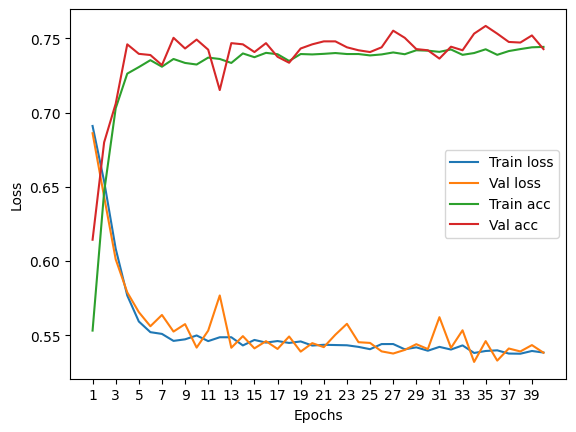

****************************************************************************************************



118it [00:00, 210.62it/s]


Train Epoch: 0 	Loss: 0.694220, Accuracy: 3992/7500 (53%)
Val Epoch: 0 	Loss: 0.697343, Accuracy: 1458/2500 (58%)



118it [00:00, 206.56it/s]


Train Epoch: 1 	Loss: 0.665294, Accuracy: 4670/7500 (62%)
Val Epoch: 1 	Loss: 0.655768, Accuracy: 1614/2500 (65%)



118it [00:00, 208.55it/s]


Train Epoch: 2 	Loss: 0.615290, Accuracy: 5163/7500 (69%)
Val Epoch: 2 	Loss: 0.610624, Accuracy: 1723/2500 (69%)



118it [00:00, 215.05it/s]


Train Epoch: 3 	Loss: 0.577611, Accuracy: 5401/7500 (72%)
Val Epoch: 3 	Loss: 0.574185, Accuracy: 1789/2500 (72%)



118it [00:00, 214.07it/s]


Train Epoch: 4 	Loss: 0.556203, Accuracy: 5496/7500 (73%)
Val Epoch: 4 	Loss: 0.576664, Accuracy: 1768/2500 (71%)



118it [00:00, 189.64it/s]


Train Epoch: 5 	Loss: 0.548518, Accuracy: 5526/7500 (74%)
Val Epoch: 5 	Loss: 0.584078, Accuracy: 1731/2500 (69%)



118it [00:00, 166.47it/s]


Train Epoch: 6 	Loss: 0.546574, Accuracy: 5525/7500 (74%)
Val Epoch: 6 	Loss: 0.558799, Accuracy: 1808/2500 (72%)



118it [00:00, 155.50it/s]


Train Epoch: 7 	Loss: 0.549233, Accuracy: 5510/7500 (73%)
Val Epoch: 7 	Loss: 0.600420, Accuracy: 1807/2500 (72%)



118it [00:00, 172.45it/s]


Train Epoch: 8 	Loss: 0.544689, Accuracy: 5555/7500 (74%)
Val Epoch: 8 	Loss: 0.576789, Accuracy: 1827/2500 (73%)



118it [00:00, 196.09it/s]


Train Epoch: 9 	Loss: 0.543660, Accuracy: 5572/7500 (74%)
Val Epoch: 9 	Loss: 0.577613, Accuracy: 1778/2500 (71%)



118it [00:00, 206.76it/s]


Train Epoch: 10 	Loss: 0.540670, Accuracy: 5564/7500 (74%)
Val Epoch: 10 	Loss: 0.573776, Accuracy: 1767/2500 (71%)



118it [00:00, 175.35it/s]


Train Epoch: 11 	Loss: 0.544278, Accuracy: 5545/7500 (74%)
Val Epoch: 11 	Loss: 0.568409, Accuracy: 1822/2500 (73%)



118it [00:00, 163.38it/s]


Train Epoch: 12 	Loss: 0.541877, Accuracy: 5559/7500 (74%)
Val Epoch: 12 	Loss: 0.555779, Accuracy: 1803/2500 (72%)



118it [00:00, 188.88it/s]


Train Epoch: 13 	Loss: 0.542130, Accuracy: 5547/7500 (74%)
Val Epoch: 13 	Loss: 0.563015, Accuracy: 1815/2500 (73%)



118it [00:00, 212.93it/s]


Train Epoch: 14 	Loss: 0.541130, Accuracy: 5573/7500 (74%)
Val Epoch: 14 	Loss: 0.566400, Accuracy: 1827/2500 (73%)



118it [00:00, 210.59it/s]


Train Epoch: 15 	Loss: 0.542593, Accuracy: 5549/7500 (74%)
Val Epoch: 15 	Loss: 0.568751, Accuracy: 1830/2500 (73%)



118it [00:00, 208.33it/s]


Train Epoch: 16 	Loss: 0.540782, Accuracy: 5568/7500 (74%)
Val Epoch: 16 	Loss: 0.569997, Accuracy: 1830/2500 (73%)



118it [00:00, 212.36it/s]


Train Epoch: 17 	Loss: 0.541765, Accuracy: 5569/7500 (74%)
Val Epoch: 17 	Loss: 0.571767, Accuracy: 1796/2500 (72%)



118it [00:00, 223.00it/s]


Train Epoch: 18 	Loss: 0.541310, Accuracy: 5564/7500 (74%)
Val Epoch: 18 	Loss: 0.572529, Accuracy: 1790/2500 (72%)



118it [00:00, 215.93it/s]


Train Epoch: 19 	Loss: 0.541242, Accuracy: 5557/7500 (74%)
Val Epoch: 19 	Loss: 0.561054, Accuracy: 1836/2500 (73%)



118it [00:00, 204.97it/s]


Train Epoch: 20 	Loss: 0.543789, Accuracy: 5523/7500 (74%)
Val Epoch: 20 	Loss: 0.561731, Accuracy: 1846/2500 (74%)



118it [00:00, 208.65it/s]


Train Epoch: 21 	Loss: 0.540696, Accuracy: 5556/7500 (74%)
Val Epoch: 21 	Loss: 0.565522, Accuracy: 1850/2500 (74%)



118it [00:00, 137.10it/s]


Train Epoch: 22 	Loss: 0.541454, Accuracy: 5549/7500 (74%)
Val Epoch: 22 	Loss: 0.576575, Accuracy: 1814/2500 (73%)



118it [00:00, 186.51it/s]


Train Epoch: 23 	Loss: 0.543134, Accuracy: 5555/7500 (74%)
Val Epoch: 23 	Loss: 0.561969, Accuracy: 1827/2500 (73%)



118it [00:00, 189.24it/s]


Train Epoch: 24 	Loss: 0.540790, Accuracy: 5565/7500 (74%)
Val Epoch: 24 	Loss: 0.558810, Accuracy: 1828/2500 (73%)



118it [00:00, 160.63it/s]


Train Epoch: 25 	Loss: 0.541609, Accuracy: 5582/7500 (74%)
Val Epoch: 25 	Loss: 0.563060, Accuracy: 1796/2500 (72%)



118it [00:02, 44.50it/s]


Train Epoch: 26 	Loss: 0.541759, Accuracy: 5538/7500 (74%)
Val Epoch: 26 	Loss: 0.558714, Accuracy: 1829/2500 (73%)



118it [00:01, 103.89it/s]


Train Epoch: 27 	Loss: 0.540088, Accuracy: 5595/7500 (75%)
Val Epoch: 27 	Loss: 0.568569, Accuracy: 1835/2500 (73%)



118it [00:01, 113.98it/s]


Train Epoch: 28 	Loss: 0.542176, Accuracy: 5550/7500 (74%)
Val Epoch: 28 	Loss: 0.562672, Accuracy: 1839/2500 (74%)



118it [00:00, 126.35it/s]


Train Epoch: 29 	Loss: 0.541392, Accuracy: 5560/7500 (74%)
Val Epoch: 29 	Loss: 0.555560, Accuracy: 1831/2500 (73%)



118it [00:00, 165.34it/s]


Train Epoch: 30 	Loss: 0.542216, Accuracy: 5536/7500 (74%)
Val Epoch: 30 	Loss: 0.562280, Accuracy: 1802/2500 (72%)



118it [00:00, 169.26it/s]


Train Epoch: 31 	Loss: 0.541515, Accuracy: 5551/7500 (74%)
Val Epoch: 31 	Loss: 0.563009, Accuracy: 1838/2500 (74%)



118it [00:00, 171.76it/s]


Train Epoch: 32 	Loss: 0.539607, Accuracy: 5551/7500 (74%)
Val Epoch: 32 	Loss: 0.560075, Accuracy: 1826/2500 (73%)



118it [00:00, 164.53it/s]


Train Epoch: 33 	Loss: 0.538660, Accuracy: 5579/7500 (74%)
Val Epoch: 33 	Loss: 0.569027, Accuracy: 1819/2500 (73%)



118it [00:00, 167.26it/s]


Train Epoch: 34 	Loss: 0.541665, Accuracy: 5565/7500 (74%)
Val Epoch: 34 	Loss: 0.565716, Accuracy: 1832/2500 (73%)



118it [00:00, 167.40it/s]


Train Epoch: 35 	Loss: 0.540502, Accuracy: 5573/7500 (74%)
Val Epoch: 35 	Loss: 0.568102, Accuracy: 1833/2500 (73%)



118it [00:00, 133.86it/s]


Train Epoch: 36 	Loss: 0.539996, Accuracy: 5575/7500 (74%)
Val Epoch: 36 	Loss: 0.573711, Accuracy: 1792/2500 (72%)



118it [00:01, 75.49it/s]


Train Epoch: 37 	Loss: 0.541495, Accuracy: 5571/7500 (74%)
Val Epoch: 37 	Loss: 0.559598, Accuracy: 1841/2500 (74%)



118it [00:01, 91.42it/s] 


Train Epoch: 38 	Loss: 0.542892, Accuracy: 5587/7500 (74%)
Val Epoch: 38 	Loss: 0.565370, Accuracy: 1850/2500 (74%)



118it [00:00, 142.06it/s]


Train Epoch: 39 	Loss: 0.541529, Accuracy: 5601/7500 (75%)
Val Epoch: 39 	Loss: 0.556573, Accuracy: 1832/2500 (73%)

Test accuracy:  75.08


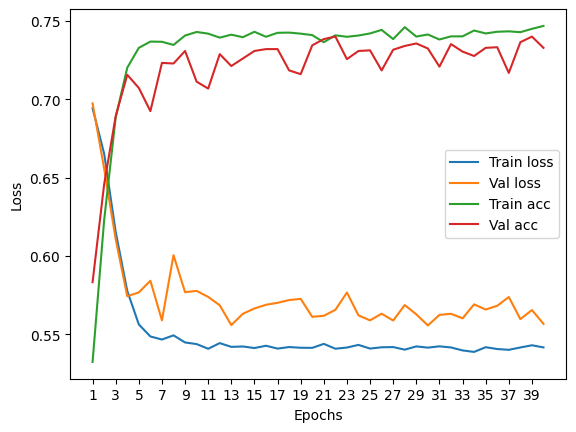

****************************************************************************************************



118it [00:00, 200.61it/s]


Train Epoch: 0 	Loss: 0.692759, Accuracy: 4096/7500 (55%)
Val Epoch: 0 	Loss: 0.699043, Accuracy: 1414/2500 (57%)



118it [00:00, 208.75it/s]


Train Epoch: 1 	Loss: 0.666679, Accuracy: 4622/7500 (62%)
Val Epoch: 1 	Loss: 0.667624, Accuracy: 1503/2500 (60%)



118it [00:00, 196.91it/s]


Train Epoch: 2 	Loss: 0.630086, Accuracy: 5085/7500 (68%)
Val Epoch: 2 	Loss: 0.624688, Accuracy: 1737/2500 (69%)



118it [00:00, 195.81it/s]


Train Epoch: 3 	Loss: 0.604600, Accuracy: 5208/7500 (69%)
Val Epoch: 3 	Loss: 0.604856, Accuracy: 1783/2500 (71%)



118it [00:00, 205.08it/s]


Train Epoch: 4 	Loss: 0.580762, Accuracy: 5376/7500 (72%)
Val Epoch: 4 	Loss: 0.582724, Accuracy: 1808/2500 (72%)



118it [00:00, 190.89it/s]


Train Epoch: 5 	Loss: 0.569483, Accuracy: 5344/7500 (71%)
Val Epoch: 5 	Loss: 0.578337, Accuracy: 1774/2500 (71%)



118it [00:00, 177.18it/s]


Train Epoch: 6 	Loss: 0.566048, Accuracy: 5379/7500 (72%)
Val Epoch: 6 	Loss: 0.576015, Accuracy: 1815/2500 (73%)



118it [00:00, 196.04it/s]


Train Epoch: 7 	Loss: 0.559355, Accuracy: 5419/7500 (72%)
Val Epoch: 7 	Loss: 0.573671, Accuracy: 1785/2500 (71%)



118it [00:00, 172.82it/s]


Train Epoch: 8 	Loss: 0.561315, Accuracy: 5402/7500 (72%)
Val Epoch: 8 	Loss: 0.563992, Accuracy: 1806/2500 (72%)



118it [00:00, 177.59it/s]


Train Epoch: 9 	Loss: 0.559263, Accuracy: 5398/7500 (72%)
Val Epoch: 9 	Loss: 0.563090, Accuracy: 1817/2500 (73%)



118it [00:00, 178.42it/s]


Train Epoch: 10 	Loss: 0.561037, Accuracy: 5399/7500 (72%)
Val Epoch: 10 	Loss: 0.576001, Accuracy: 1797/2500 (72%)



118it [00:00, 195.67it/s]


Train Epoch: 11 	Loss: 0.558020, Accuracy: 5407/7500 (72%)
Val Epoch: 11 	Loss: 0.574305, Accuracy: 1789/2500 (72%)



118it [00:00, 194.37it/s]


Train Epoch: 12 	Loss: 0.557341, Accuracy: 5403/7500 (72%)
Val Epoch: 12 	Loss: 0.560493, Accuracy: 1817/2500 (73%)



118it [00:00, 184.28it/s]


Train Epoch: 13 	Loss: 0.559206, Accuracy: 5421/7500 (72%)
Val Epoch: 13 	Loss: 0.597573, Accuracy: 1728/2500 (69%)



118it [00:00, 211.33it/s]


Train Epoch: 14 	Loss: 0.558715, Accuracy: 5407/7500 (72%)
Val Epoch: 14 	Loss: 0.570372, Accuracy: 1787/2500 (71%)



118it [00:00, 175.60it/s]


Train Epoch: 15 	Loss: 0.559481, Accuracy: 5405/7500 (72%)
Val Epoch: 15 	Loss: 0.569679, Accuracy: 1816/2500 (73%)



118it [00:00, 127.74it/s]


Train Epoch: 16 	Loss: 0.556752, Accuracy: 5413/7500 (72%)
Val Epoch: 16 	Loss: 0.576471, Accuracy: 1778/2500 (71%)



118it [00:00, 172.87it/s]


Train Epoch: 17 	Loss: 0.558500, Accuracy: 5419/7500 (72%)
Val Epoch: 17 	Loss: 0.565847, Accuracy: 1801/2500 (72%)



118it [00:00, 155.42it/s]


Train Epoch: 18 	Loss: 0.557572, Accuracy: 5440/7500 (73%)
Val Epoch: 18 	Loss: 0.570455, Accuracy: 1808/2500 (72%)



118it [00:00, 171.41it/s]


Train Epoch: 19 	Loss: 0.556027, Accuracy: 5435/7500 (72%)
Val Epoch: 19 	Loss: 0.565283, Accuracy: 1812/2500 (72%)



118it [00:00, 201.24it/s]


Train Epoch: 20 	Loss: 0.557434, Accuracy: 5454/7500 (73%)
Val Epoch: 20 	Loss: 0.569954, Accuracy: 1811/2500 (72%)



118it [00:00, 196.24it/s]


Train Epoch: 21 	Loss: 0.558633, Accuracy: 5448/7500 (73%)
Val Epoch: 21 	Loss: 0.579953, Accuracy: 1765/2500 (71%)



118it [00:00, 192.14it/s]


Train Epoch: 22 	Loss: 0.559008, Accuracy: 5432/7500 (72%)
Val Epoch: 22 	Loss: 0.562435, Accuracy: 1814/2500 (73%)



118it [00:00, 176.51it/s]


Train Epoch: 23 	Loss: 0.559810, Accuracy: 5409/7500 (72%)
Val Epoch: 23 	Loss: 0.564186, Accuracy: 1821/2500 (73%)



118it [00:00, 193.95it/s]


Train Epoch: 24 	Loss: 0.554830, Accuracy: 5434/7500 (72%)
Val Epoch: 24 	Loss: 0.565012, Accuracy: 1808/2500 (72%)



118it [00:00, 181.33it/s]


Train Epoch: 25 	Loss: 0.558374, Accuracy: 5423/7500 (72%)
Val Epoch: 25 	Loss: 0.571027, Accuracy: 1809/2500 (72%)



118it [00:00, 194.27it/s]


Train Epoch: 26 	Loss: 0.552958, Accuracy: 5454/7500 (73%)
Val Epoch: 26 	Loss: 0.571743, Accuracy: 1792/2500 (72%)



118it [00:00, 180.68it/s]


Train Epoch: 27 	Loss: 0.555503, Accuracy: 5432/7500 (72%)
Val Epoch: 27 	Loss: 0.573208, Accuracy: 1777/2500 (71%)



118it [00:00, 171.50it/s]


Train Epoch: 28 	Loss: 0.558323, Accuracy: 5446/7500 (73%)
Val Epoch: 28 	Loss: 0.573953, Accuracy: 1811/2500 (72%)



118it [00:00, 175.25it/s]


Train Epoch: 29 	Loss: 0.558350, Accuracy: 5408/7500 (72%)
Val Epoch: 29 	Loss: 0.563222, Accuracy: 1817/2500 (73%)



118it [00:00, 178.60it/s]


Train Epoch: 30 	Loss: 0.557256, Accuracy: 5437/7500 (72%)
Val Epoch: 30 	Loss: 0.571009, Accuracy: 1785/2500 (71%)



118it [00:00, 176.53it/s]


Train Epoch: 31 	Loss: 0.559273, Accuracy: 5402/7500 (72%)
Val Epoch: 31 	Loss: 0.572897, Accuracy: 1810/2500 (72%)



118it [00:00, 163.58it/s]


Train Epoch: 32 	Loss: 0.555713, Accuracy: 5425/7500 (72%)
Val Epoch: 32 	Loss: 0.571724, Accuracy: 1797/2500 (72%)



118it [00:00, 159.95it/s]


Train Epoch: 33 	Loss: 0.556444, Accuracy: 5425/7500 (72%)
Val Epoch: 33 	Loss: 0.565373, Accuracy: 1818/2500 (73%)



118it [00:00, 129.77it/s]


Train Epoch: 34 	Loss: 0.555499, Accuracy: 5446/7500 (73%)
Val Epoch: 34 	Loss: 0.566624, Accuracy: 1815/2500 (73%)



118it [00:00, 146.47it/s]


Train Epoch: 35 	Loss: 0.559037, Accuracy: 5471/7500 (73%)
Val Epoch: 35 	Loss: 0.569079, Accuracy: 1808/2500 (72%)



118it [00:00, 146.73it/s]


Train Epoch: 36 	Loss: 0.554944, Accuracy: 5424/7500 (72%)
Val Epoch: 36 	Loss: 0.565142, Accuracy: 1815/2500 (73%)



118it [00:00, 191.11it/s]


Train Epoch: 37 	Loss: 0.556943, Accuracy: 5413/7500 (72%)
Val Epoch: 37 	Loss: 0.565820, Accuracy: 1806/2500 (72%)



118it [00:00, 195.62it/s]


Train Epoch: 38 	Loss: 0.557075, Accuracy: 5444/7500 (73%)
Val Epoch: 38 	Loss: 0.561284, Accuracy: 1812/2500 (72%)



118it [00:00, 187.80it/s]


Train Epoch: 39 	Loss: 0.556238, Accuracy: 5423/7500 (72%)
Val Epoch: 39 	Loss: 0.561687, Accuracy: 1814/2500 (73%)

Test accuracy:  72.84


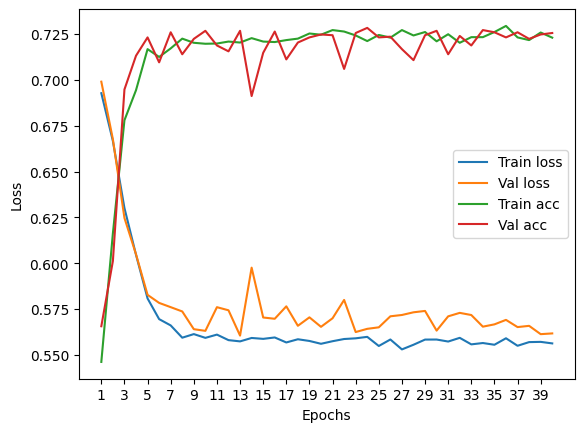

****************************************************************************************************



118it [00:00, 192.38it/s]


Train Epoch: 0 	Loss: 0.696860, Accuracy: 3897/7500 (52%)
Val Epoch: 0 	Loss: 0.701646, Accuracy: 1434/2500 (57%)



118it [00:00, 203.03it/s]


Train Epoch: 1 	Loss: 0.679122, Accuracy: 4461/7500 (59%)
Val Epoch: 1 	Loss: 0.670686, Accuracy: 1659/2500 (66%)



118it [00:01, 99.96it/s] 


Train Epoch: 2 	Loss: 0.640877, Accuracy: 4974/7500 (66%)
Val Epoch: 2 	Loss: 0.619709, Accuracy: 1756/2500 (70%)



118it [00:00, 189.51it/s]


Train Epoch: 3 	Loss: 0.598996, Accuracy: 5301/7500 (71%)
Val Epoch: 3 	Loss: 0.590611, Accuracy: 1796/2500 (72%)



118it [00:00, 132.65it/s]


Train Epoch: 4 	Loss: 0.571629, Accuracy: 5428/7500 (72%)
Val Epoch: 4 	Loss: 0.572902, Accuracy: 1811/2500 (72%)



118it [00:00, 126.20it/s]


Train Epoch: 5 	Loss: 0.559907, Accuracy: 5485/7500 (73%)
Val Epoch: 5 	Loss: 0.577833, Accuracy: 1825/2500 (73%)



118it [00:00, 161.44it/s]


Train Epoch: 6 	Loss: 0.551965, Accuracy: 5543/7500 (74%)
Val Epoch: 6 	Loss: 0.562673, Accuracy: 1820/2500 (73%)



118it [00:00, 175.27it/s]


Train Epoch: 7 	Loss: 0.549799, Accuracy: 5536/7500 (74%)
Val Epoch: 7 	Loss: 0.576884, Accuracy: 1785/2500 (71%)



118it [00:00, 184.71it/s]


Train Epoch: 8 	Loss: 0.549247, Accuracy: 5530/7500 (74%)
Val Epoch: 8 	Loss: 0.569027, Accuracy: 1820/2500 (73%)



118it [00:00, 162.67it/s]


Train Epoch: 9 	Loss: 0.545333, Accuracy: 5550/7500 (74%)
Val Epoch: 9 	Loss: 0.561705, Accuracy: 1824/2500 (73%)



118it [00:00, 178.75it/s]


Train Epoch: 10 	Loss: 0.546377, Accuracy: 5529/7500 (74%)
Val Epoch: 10 	Loss: 0.565403, Accuracy: 1826/2500 (73%)



118it [00:00, 136.37it/s]


Train Epoch: 11 	Loss: 0.549257, Accuracy: 5546/7500 (74%)
Val Epoch: 11 	Loss: 0.568687, Accuracy: 1825/2500 (73%)



118it [00:00, 128.44it/s]


Train Epoch: 12 	Loss: 0.544373, Accuracy: 5548/7500 (74%)
Val Epoch: 12 	Loss: 0.568002, Accuracy: 1802/2500 (72%)



118it [00:00, 190.14it/s]


Train Epoch: 13 	Loss: 0.547317, Accuracy: 5541/7500 (74%)
Val Epoch: 13 	Loss: 0.571491, Accuracy: 1815/2500 (73%)



118it [00:00, 170.47it/s]


Train Epoch: 14 	Loss: 0.544216, Accuracy: 5565/7500 (74%)
Val Epoch: 14 	Loss: 0.566881, Accuracy: 1821/2500 (73%)



118it [00:00, 162.45it/s]


Train Epoch: 15 	Loss: 0.546045, Accuracy: 5555/7500 (74%)
Val Epoch: 15 	Loss: 0.565879, Accuracy: 1828/2500 (73%)



118it [00:00, 182.78it/s]


Train Epoch: 16 	Loss: 0.545228, Accuracy: 5537/7500 (74%)
Val Epoch: 16 	Loss: 0.571195, Accuracy: 1796/2500 (72%)



118it [00:00, 178.61it/s]


Train Epoch: 17 	Loss: 0.545392, Accuracy: 5545/7500 (74%)
Val Epoch: 17 	Loss: 0.564868, Accuracy: 1825/2500 (73%)



118it [00:00, 203.79it/s]


Train Epoch: 18 	Loss: 0.545657, Accuracy: 5535/7500 (74%)
Val Epoch: 18 	Loss: 0.560049, Accuracy: 1828/2500 (73%)



118it [00:00, 213.80it/s]


Train Epoch: 19 	Loss: 0.542711, Accuracy: 5530/7500 (74%)
Val Epoch: 19 	Loss: 0.565002, Accuracy: 1819/2500 (73%)



118it [00:00, 222.24it/s]


Train Epoch: 20 	Loss: 0.544144, Accuracy: 5557/7500 (74%)
Val Epoch: 20 	Loss: 0.556723, Accuracy: 1825/2500 (73%)



118it [00:00, 222.15it/s]


Train Epoch: 21 	Loss: 0.546299, Accuracy: 5555/7500 (74%)
Val Epoch: 21 	Loss: 0.563110, Accuracy: 1822/2500 (73%)



118it [00:00, 215.33it/s]


Train Epoch: 22 	Loss: 0.544614, Accuracy: 5575/7500 (74%)
Val Epoch: 22 	Loss: 0.569403, Accuracy: 1831/2500 (73%)



118it [00:00, 222.79it/s]


Train Epoch: 23 	Loss: 0.545680, Accuracy: 5544/7500 (74%)
Val Epoch: 23 	Loss: 0.563842, Accuracy: 1831/2500 (73%)



118it [00:00, 216.23it/s]


Train Epoch: 24 	Loss: 0.545428, Accuracy: 5547/7500 (74%)
Val Epoch: 24 	Loss: 0.560040, Accuracy: 1827/2500 (73%)



118it [00:00, 223.63it/s]


Train Epoch: 25 	Loss: 0.545266, Accuracy: 5562/7500 (74%)
Val Epoch: 25 	Loss: 0.557529, Accuracy: 1817/2500 (73%)



118it [00:00, 224.38it/s]


Train Epoch: 26 	Loss: 0.544968, Accuracy: 5573/7500 (74%)
Val Epoch: 26 	Loss: 0.574544, Accuracy: 1816/2500 (73%)



118it [00:00, 218.60it/s]


Train Epoch: 27 	Loss: 0.542840, Accuracy: 5548/7500 (74%)
Val Epoch: 27 	Loss: 0.564001, Accuracy: 1822/2500 (73%)



118it [00:00, 213.50it/s]


Train Epoch: 28 	Loss: 0.544771, Accuracy: 5572/7500 (74%)
Val Epoch: 28 	Loss: 0.557238, Accuracy: 1820/2500 (73%)



118it [00:00, 194.77it/s]


Train Epoch: 29 	Loss: 0.544485, Accuracy: 5554/7500 (74%)
Val Epoch: 29 	Loss: 0.560946, Accuracy: 1828/2500 (73%)



118it [00:00, 160.28it/s]


Train Epoch: 30 	Loss: 0.545943, Accuracy: 5550/7500 (74%)
Val Epoch: 30 	Loss: 0.569807, Accuracy: 1822/2500 (73%)



118it [00:01, 97.98it/s] 


Train Epoch: 31 	Loss: 0.545194, Accuracy: 5554/7500 (74%)
Val Epoch: 31 	Loss: 0.559991, Accuracy: 1822/2500 (73%)



118it [00:00, 162.80it/s]


Train Epoch: 32 	Loss: 0.541706, Accuracy: 5560/7500 (74%)
Val Epoch: 32 	Loss: 0.557622, Accuracy: 1830/2500 (73%)



118it [00:00, 160.50it/s]


Train Epoch: 33 	Loss: 0.543641, Accuracy: 5572/7500 (74%)
Val Epoch: 33 	Loss: 0.563204, Accuracy: 1821/2500 (73%)



118it [00:00, 188.16it/s]


Train Epoch: 34 	Loss: 0.545660, Accuracy: 5540/7500 (74%)
Val Epoch: 34 	Loss: 0.558182, Accuracy: 1824/2500 (73%)



118it [00:00, 190.85it/s]


Train Epoch: 35 	Loss: 0.543608, Accuracy: 5549/7500 (74%)
Val Epoch: 35 	Loss: 0.560684, Accuracy: 1826/2500 (73%)



118it [00:00, 185.62it/s]


Train Epoch: 36 	Loss: 0.546902, Accuracy: 5557/7500 (74%)
Val Epoch: 36 	Loss: 0.562981, Accuracy: 1816/2500 (73%)



118it [00:00, 128.16it/s]


Train Epoch: 37 	Loss: 0.543395, Accuracy: 5548/7500 (74%)
Val Epoch: 37 	Loss: 0.575023, Accuracy: 1827/2500 (73%)



118it [00:00, 172.95it/s]


Train Epoch: 38 	Loss: 0.543842, Accuracy: 5580/7500 (74%)
Val Epoch: 38 	Loss: 0.558220, Accuracy: 1823/2500 (73%)



118it [00:00, 196.55it/s]


Train Epoch: 39 	Loss: 0.544233, Accuracy: 5550/7500 (74%)
Val Epoch: 39 	Loss: 0.571940, Accuracy: 1815/2500 (73%)

Test accuracy:  74.11999999999999


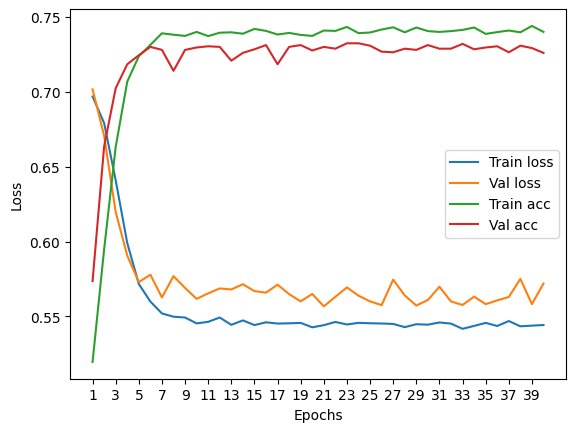

****************************************************************************************************



118it [00:00, 204.51it/s]


Train Epoch: 0 	Loss: 0.692615, Accuracy: 4102/7500 (55%)
Val Epoch: 0 	Loss: 0.689995, Accuracy: 1584/2500 (63%)



118it [00:00, 186.07it/s]


Train Epoch: 1 	Loss: 0.657895, Accuracy: 4856/7500 (65%)
Val Epoch: 1 	Loss: 0.632071, Accuracy: 1728/2500 (69%)



118it [00:00, 151.05it/s]


Train Epoch: 2 	Loss: 0.606305, Accuracy: 5318/7500 (71%)
Val Epoch: 2 	Loss: 0.587215, Accuracy: 1811/2500 (72%)



118it [00:00, 162.21it/s]


Train Epoch: 3 	Loss: 0.577593, Accuracy: 5389/7500 (72%)
Val Epoch: 3 	Loss: 0.573321, Accuracy: 1844/2500 (74%)



118it [00:00, 192.39it/s]


Train Epoch: 4 	Loss: 0.569042, Accuracy: 5388/7500 (72%)
Val Epoch: 4 	Loss: 0.561762, Accuracy: 1834/2500 (73%)



118it [00:00, 180.94it/s]


Train Epoch: 5 	Loss: 0.561416, Accuracy: 5429/7500 (72%)
Val Epoch: 5 	Loss: 0.564430, Accuracy: 1813/2500 (73%)



118it [00:00, 166.09it/s]


Train Epoch: 6 	Loss: 0.561123, Accuracy: 5457/7500 (73%)
Val Epoch: 6 	Loss: 0.556973, Accuracy: 1848/2500 (74%)



118it [00:00, 122.69it/s]


Train Epoch: 7 	Loss: 0.560009, Accuracy: 5411/7500 (72%)
Val Epoch: 7 	Loss: 0.547181, Accuracy: 1857/2500 (74%)



118it [00:01, 115.50it/s]


Train Epoch: 8 	Loss: 0.557907, Accuracy: 5443/7500 (73%)
Val Epoch: 8 	Loss: 0.564098, Accuracy: 1842/2500 (74%)



118it [00:00, 180.64it/s]


Train Epoch: 9 	Loss: 0.558923, Accuracy: 5434/7500 (72%)
Val Epoch: 9 	Loss: 0.544313, Accuracy: 1848/2500 (74%)



118it [00:00, 182.21it/s]


Train Epoch: 10 	Loss: 0.559871, Accuracy: 5448/7500 (73%)
Val Epoch: 10 	Loss: 0.547421, Accuracy: 1860/2500 (74%)



118it [00:00, 169.97it/s]


Train Epoch: 11 	Loss: 0.561060, Accuracy: 5428/7500 (72%)
Val Epoch: 11 	Loss: 0.541274, Accuracy: 1850/2500 (74%)



118it [00:00, 142.29it/s]


Train Epoch: 12 	Loss: 0.562926, Accuracy: 5461/7500 (73%)
Val Epoch: 12 	Loss: 0.538130, Accuracy: 1844/2500 (74%)



118it [00:00, 159.86it/s]


Train Epoch: 13 	Loss: 0.556626, Accuracy: 5444/7500 (73%)
Val Epoch: 13 	Loss: 0.550640, Accuracy: 1835/2500 (73%)



118it [00:00, 222.84it/s]


Train Epoch: 14 	Loss: 0.555608, Accuracy: 5455/7500 (73%)
Val Epoch: 14 	Loss: 0.552621, Accuracy: 1834/2500 (73%)



118it [00:00, 181.26it/s]


Train Epoch: 15 	Loss: 0.556558, Accuracy: 5453/7500 (73%)
Val Epoch: 15 	Loss: 0.561017, Accuracy: 1838/2500 (74%)



118it [00:00, 187.68it/s]


Train Epoch: 16 	Loss: 0.556178, Accuracy: 5472/7500 (73%)
Val Epoch: 16 	Loss: 0.579003, Accuracy: 1793/2500 (72%)



118it [00:00, 154.82it/s]


Train Epoch: 17 	Loss: 0.558770, Accuracy: 5438/7500 (73%)
Val Epoch: 17 	Loss: 0.558750, Accuracy: 1858/2500 (74%)



118it [00:00, 152.54it/s]


Train Epoch: 18 	Loss: 0.557775, Accuracy: 5441/7500 (73%)
Val Epoch: 18 	Loss: 0.542243, Accuracy: 1849/2500 (74%)



118it [00:00, 144.89it/s]


Train Epoch: 19 	Loss: 0.556953, Accuracy: 5460/7500 (73%)
Val Epoch: 19 	Loss: 0.537845, Accuracy: 1840/2500 (74%)



118it [00:00, 145.81it/s]


Train Epoch: 20 	Loss: 0.555077, Accuracy: 5500/7500 (73%)
Val Epoch: 20 	Loss: 0.560860, Accuracy: 1854/2500 (74%)



118it [00:00, 159.68it/s]


Train Epoch: 21 	Loss: 0.552643, Accuracy: 5495/7500 (73%)
Val Epoch: 21 	Loss: 0.538723, Accuracy: 1867/2500 (75%)



118it [00:00, 209.50it/s]


Train Epoch: 22 	Loss: 0.554384, Accuracy: 5502/7500 (73%)
Val Epoch: 22 	Loss: 0.551278, Accuracy: 1859/2500 (74%)



118it [00:00, 207.65it/s]


Train Epoch: 23 	Loss: 0.555454, Accuracy: 5471/7500 (73%)
Val Epoch: 23 	Loss: 0.546376, Accuracy: 1874/2500 (75%)



118it [00:00, 118.21it/s]


Train Epoch: 24 	Loss: 0.556373, Accuracy: 5472/7500 (73%)
Val Epoch: 24 	Loss: 0.551921, Accuracy: 1849/2500 (74%)



118it [00:00, 182.81it/s]


Train Epoch: 25 	Loss: 0.552723, Accuracy: 5469/7500 (73%)
Val Epoch: 25 	Loss: 0.552088, Accuracy: 1848/2500 (74%)



118it [00:00, 177.91it/s]


Train Epoch: 26 	Loss: 0.553532, Accuracy: 5465/7500 (73%)
Val Epoch: 26 	Loss: 0.546259, Accuracy: 1870/2500 (75%)



118it [00:00, 217.68it/s]


Train Epoch: 27 	Loss: 0.554096, Accuracy: 5498/7500 (73%)
Val Epoch: 27 	Loss: 0.536305, Accuracy: 1851/2500 (74%)



118it [00:00, 222.44it/s]


Train Epoch: 28 	Loss: 0.552928, Accuracy: 5468/7500 (73%)
Val Epoch: 28 	Loss: 0.550157, Accuracy: 1840/2500 (74%)



118it [00:00, 219.22it/s]


Train Epoch: 29 	Loss: 0.554150, Accuracy: 5488/7500 (73%)
Val Epoch: 29 	Loss: 0.540477, Accuracy: 1863/2500 (75%)



118it [00:00, 213.89it/s]


Train Epoch: 30 	Loss: 0.553762, Accuracy: 5481/7500 (73%)
Val Epoch: 30 	Loss: 0.541301, Accuracy: 1866/2500 (75%)



118it [00:00, 195.49it/s]


Train Epoch: 31 	Loss: 0.554969, Accuracy: 5508/7500 (73%)
Val Epoch: 31 	Loss: 0.539760, Accuracy: 1854/2500 (74%)



118it [00:00, 189.75it/s]


Train Epoch: 32 	Loss: 0.554621, Accuracy: 5470/7500 (73%)
Val Epoch: 32 	Loss: 0.539782, Accuracy: 1863/2500 (75%)



118it [00:00, 150.28it/s]


Train Epoch: 33 	Loss: 0.551241, Accuracy: 5487/7500 (73%)
Val Epoch: 33 	Loss: 0.536762, Accuracy: 1861/2500 (74%)



118it [00:00, 167.25it/s]


Train Epoch: 34 	Loss: 0.551080, Accuracy: 5493/7500 (73%)
Val Epoch: 34 	Loss: 0.542582, Accuracy: 1874/2500 (75%)



118it [00:00, 164.06it/s]


Train Epoch: 35 	Loss: 0.554778, Accuracy: 5492/7500 (73%)
Val Epoch: 35 	Loss: 0.542749, Accuracy: 1849/2500 (74%)



118it [00:00, 212.58it/s]


Train Epoch: 36 	Loss: 0.552079, Accuracy: 5487/7500 (73%)
Val Epoch: 36 	Loss: 0.540174, Accuracy: 1869/2500 (75%)



118it [00:00, 190.73it/s]


Train Epoch: 37 	Loss: 0.553813, Accuracy: 5506/7500 (73%)
Val Epoch: 37 	Loss: 0.548110, Accuracy: 1861/2500 (74%)



118it [00:00, 243.10it/s]


Train Epoch: 38 	Loss: 0.551157, Accuracy: 5485/7500 (73%)
Val Epoch: 38 	Loss: 0.536511, Accuracy: 1869/2500 (75%)



118it [00:00, 214.67it/s]


Train Epoch: 39 	Loss: 0.552764, Accuracy: 5499/7500 (73%)
Val Epoch: 39 	Loss: 0.538635, Accuracy: 1863/2500 (75%)

Test accuracy:  74.48


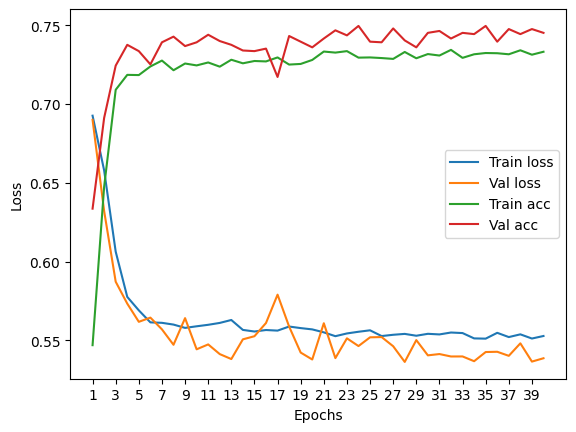

****************************************************************************************************



116it [00:00, 198.29it/s]


Train Epoch: 0 	Loss: 0.690405, Accuracy: 3880/7422 (52%)
Val Epoch: 0 	Loss: 0.694574, Accuracy: 1340/2474 (54%)



116it [00:00, 201.85it/s]


Train Epoch: 1 	Loss: 0.681563, Accuracy: 4263/7422 (57%)
Val Epoch: 1 	Loss: 0.683368, Accuracy: 1425/2474 (58%)



116it [00:00, 140.85it/s]


Train Epoch: 2 	Loss: 0.668560, Accuracy: 4568/7422 (62%)
Val Epoch: 2 	Loss: 0.667213, Accuracy: 1556/2474 (63%)



116it [00:00, 156.94it/s]


Train Epoch: 3 	Loss: 0.654479, Accuracy: 4759/7422 (64%)
Val Epoch: 3 	Loss: 0.649065, Accuracy: 1617/2474 (65%)



116it [00:00, 206.25it/s]


Train Epoch: 4 	Loss: 0.641554, Accuracy: 4936/7422 (67%)
Val Epoch: 4 	Loss: 0.633839, Accuracy: 1675/2474 (68%)



116it [00:00, 183.20it/s]


Train Epoch: 5 	Loss: 0.632061, Accuracy: 4956/7422 (67%)
Val Epoch: 5 	Loss: 0.623855, Accuracy: 1716/2474 (69%)



116it [00:00, 241.08it/s]


Train Epoch: 6 	Loss: 0.621395, Accuracy: 5070/7422 (68%)
Val Epoch: 6 	Loss: 0.612843, Accuracy: 1737/2474 (70%)



116it [00:00, 245.01it/s]


Train Epoch: 7 	Loss: 0.613833, Accuracy: 5078/7422 (68%)
Val Epoch: 7 	Loss: 0.605856, Accuracy: 1763/2474 (71%)



116it [00:00, 246.16it/s]


Train Epoch: 8 	Loss: 0.610258, Accuracy: 5074/7422 (68%)
Val Epoch: 8 	Loss: 0.598443, Accuracy: 1776/2474 (72%)



116it [00:00, 244.30it/s]


Train Epoch: 9 	Loss: 0.601547, Accuracy: 5158/7422 (69%)
Val Epoch: 9 	Loss: 0.590803, Accuracy: 1798/2474 (73%)



116it [00:00, 199.36it/s]


Train Epoch: 10 	Loss: 0.599453, Accuracy: 5139/7422 (69%)
Val Epoch: 10 	Loss: 0.589748, Accuracy: 1784/2474 (72%)



116it [00:00, 155.90it/s]


Train Epoch: 11 	Loss: 0.595356, Accuracy: 5202/7422 (70%)
Val Epoch: 11 	Loss: 0.585531, Accuracy: 1776/2474 (72%)



116it [00:00, 194.50it/s]


Train Epoch: 12 	Loss: 0.591124, Accuracy: 5206/7422 (70%)
Val Epoch: 12 	Loss: 0.582547, Accuracy: 1789/2474 (72%)



116it [00:00, 129.51it/s]


Train Epoch: 13 	Loss: 0.590126, Accuracy: 5188/7422 (70%)
Val Epoch: 13 	Loss: 0.575075, Accuracy: 1798/2474 (73%)



116it [00:00, 204.00it/s]


Train Epoch: 14 	Loss: 0.586741, Accuracy: 5240/7422 (71%)
Val Epoch: 14 	Loss: 0.569949, Accuracy: 1811/2474 (73%)



116it [00:00, 215.74it/s]


Train Epoch: 15 	Loss: 0.585262, Accuracy: 5240/7422 (71%)
Val Epoch: 15 	Loss: 0.569546, Accuracy: 1813/2474 (73%)



116it [00:00, 218.39it/s]


Train Epoch: 16 	Loss: 0.582920, Accuracy: 5232/7422 (70%)
Val Epoch: 16 	Loss: 0.570269, Accuracy: 1830/2474 (74%)



116it [00:00, 218.73it/s]


Train Epoch: 17 	Loss: 0.582125, Accuracy: 5258/7422 (71%)
Val Epoch: 17 	Loss: 0.564655, Accuracy: 1824/2474 (74%)



116it [00:00, 208.48it/s]


Train Epoch: 18 	Loss: 0.580145, Accuracy: 5286/7422 (71%)
Val Epoch: 18 	Loss: 0.566982, Accuracy: 1800/2474 (73%)



116it [00:00, 194.48it/s]


Train Epoch: 19 	Loss: 0.578147, Accuracy: 5245/7422 (71%)
Val Epoch: 19 	Loss: 0.574209, Accuracy: 1775/2474 (72%)



116it [00:00, 209.41it/s]


Train Epoch: 20 	Loss: 0.577078, Accuracy: 5265/7422 (71%)
Val Epoch: 20 	Loss: 0.564585, Accuracy: 1829/2474 (74%)



116it [00:00, 205.77it/s]


Train Epoch: 21 	Loss: 0.576058, Accuracy: 5279/7422 (71%)
Val Epoch: 21 	Loss: 0.556738, Accuracy: 1837/2474 (74%)



116it [00:00, 190.42it/s]


Train Epoch: 22 	Loss: 0.573041, Accuracy: 5324/7422 (72%)
Val Epoch: 22 	Loss: 0.561035, Accuracy: 1801/2474 (73%)



116it [00:00, 176.18it/s]


Train Epoch: 23 	Loss: 0.574813, Accuracy: 5308/7422 (72%)
Val Epoch: 23 	Loss: 0.555954, Accuracy: 1842/2474 (74%)



116it [00:01, 84.71it/s]


Train Epoch: 24 	Loss: 0.572460, Accuracy: 5302/7422 (71%)
Val Epoch: 24 	Loss: 0.554414, Accuracy: 1852/2474 (75%)



116it [00:02, 57.36it/s]


Train Epoch: 25 	Loss: 0.570251, Accuracy: 5323/7422 (72%)
Val Epoch: 25 	Loss: 0.556503, Accuracy: 1840/2474 (74%)



116it [00:01, 75.20it/s]


Train Epoch: 26 	Loss: 0.573179, Accuracy: 5285/7422 (71%)
Val Epoch: 26 	Loss: 0.577721, Accuracy: 1763/2474 (71%)



116it [00:01, 73.93it/s]


Train Epoch: 27 	Loss: 0.569363, Accuracy: 5316/7422 (72%)
Val Epoch: 27 	Loss: 0.551410, Accuracy: 1821/2474 (74%)



116it [00:00, 122.90it/s]


Train Epoch: 28 	Loss: 0.569460, Accuracy: 5316/7422 (72%)
Val Epoch: 28 	Loss: 0.551203, Accuracy: 1840/2474 (74%)



116it [00:00, 139.80it/s]


Train Epoch: 29 	Loss: 0.568147, Accuracy: 5338/7422 (72%)
Val Epoch: 29 	Loss: 0.557505, Accuracy: 1832/2474 (74%)



116it [00:00, 130.30it/s]


Train Epoch: 30 	Loss: 0.569477, Accuracy: 5346/7422 (72%)
Val Epoch: 30 	Loss: 0.549937, Accuracy: 1833/2474 (74%)



116it [00:01, 111.34it/s]


Train Epoch: 31 	Loss: 0.566640, Accuracy: 5348/7422 (72%)
Val Epoch: 31 	Loss: 0.549312, Accuracy: 1851/2474 (75%)



116it [00:01, 113.43it/s]


Train Epoch: 32 	Loss: 0.567267, Accuracy: 5334/7422 (72%)
Val Epoch: 32 	Loss: 0.546294, Accuracy: 1848/2474 (75%)



116it [00:00, 116.95it/s]


Train Epoch: 33 	Loss: 0.567140, Accuracy: 5312/7422 (72%)
Val Epoch: 33 	Loss: 0.545310, Accuracy: 1844/2474 (75%)



116it [00:01, 93.09it/s]


Train Epoch: 34 	Loss: 0.565805, Accuracy: 5341/7422 (72%)
Val Epoch: 34 	Loss: 0.550089, Accuracy: 1819/2474 (74%)



116it [00:00, 158.59it/s]


Train Epoch: 35 	Loss: 0.566437, Accuracy: 5331/7422 (72%)
Val Epoch: 35 	Loss: 0.545408, Accuracy: 1826/2474 (74%)



116it [00:00, 161.14it/s]


Train Epoch: 36 	Loss: 0.565236, Accuracy: 5337/7422 (72%)
Val Epoch: 36 	Loss: 0.548347, Accuracy: 1827/2474 (74%)



116it [00:00, 170.98it/s]


Train Epoch: 37 	Loss: 0.565858, Accuracy: 5315/7422 (72%)
Val Epoch: 37 	Loss: 0.546286, Accuracy: 1848/2474 (75%)



116it [00:00, 186.68it/s]


Train Epoch: 38 	Loss: 0.563372, Accuracy: 5367/7422 (72%)
Val Epoch: 38 	Loss: 0.547539, Accuracy: 1852/2474 (75%)



116it [00:00, 188.83it/s]


Train Epoch: 39 	Loss: 0.566083, Accuracy: 5356/7422 (72%)
Val Epoch: 39 	Loss: 0.551833, Accuracy: 1833/2474 (74%)

Test accuracy:  70.8164915117219


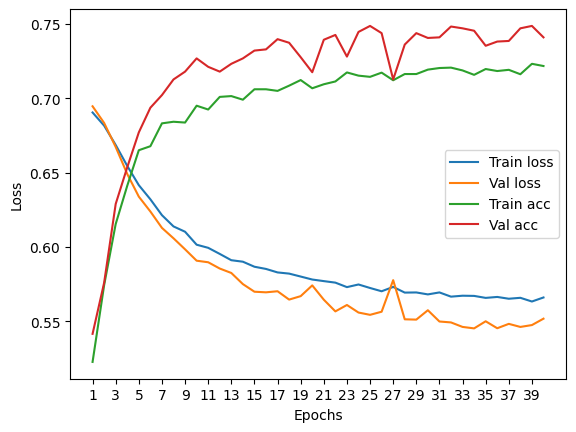

****************************************************************************************************



Particles per jet: 7


118it [00:00, 204.33it/s]


Train Epoch: 0 	Loss: 0.696998, Accuracy: 3913/7500 (52%)
Val Epoch: 0 	Loss: 0.708377, Accuracy: 1245/2500 (50%)



118it [00:00, 235.83it/s]


Train Epoch: 1 	Loss: 0.684159, Accuracy: 4315/7500 (58%)
Val Epoch: 1 	Loss: 0.671802, Accuracy: 1652/2500 (66%)



118it [00:00, 179.10it/s]


Train Epoch: 2 	Loss: 0.651946, Accuracy: 4885/7500 (65%)
Val Epoch: 2 	Loss: 0.635284, Accuracy: 1744/2500 (70%)



118it [00:00, 189.46it/s]


Train Epoch: 3 	Loss: 0.610157, Accuracy: 5305/7500 (71%)
Val Epoch: 3 	Loss: 0.590948, Accuracy: 1815/2500 (73%)



118it [00:00, 175.35it/s]


Train Epoch: 4 	Loss: 0.581310, Accuracy: 5377/7500 (72%)
Val Epoch: 4 	Loss: 0.570300, Accuracy: 1846/2500 (74%)



118it [00:00, 200.09it/s]


Train Epoch: 5 	Loss: 0.563076, Accuracy: 5429/7500 (72%)
Val Epoch: 5 	Loss: 0.578540, Accuracy: 1841/2500 (74%)



118it [00:00, 232.66it/s]


Train Epoch: 6 	Loss: 0.556064, Accuracy: 5441/7500 (73%)
Val Epoch: 6 	Loss: 0.550475, Accuracy: 1856/2500 (74%)



118it [00:00, 203.61it/s]


Train Epoch: 7 	Loss: 0.551679, Accuracy: 5495/7500 (73%)
Val Epoch: 7 	Loss: 0.552401, Accuracy: 1856/2500 (74%)



118it [00:00, 239.69it/s]


Train Epoch: 8 	Loss: 0.548410, Accuracy: 5529/7500 (74%)
Val Epoch: 8 	Loss: 0.550633, Accuracy: 1842/2500 (74%)



118it [00:00, 174.94it/s]


Train Epoch: 9 	Loss: 0.546310, Accuracy: 5525/7500 (74%)
Val Epoch: 9 	Loss: 0.549992, Accuracy: 1847/2500 (74%)



118it [00:00, 135.25it/s]


Train Epoch: 10 	Loss: 0.546737, Accuracy: 5500/7500 (73%)
Val Epoch: 10 	Loss: 0.552832, Accuracy: 1846/2500 (74%)



118it [00:00, 145.18it/s]


Train Epoch: 11 	Loss: 0.545831, Accuracy: 5535/7500 (74%)
Val Epoch: 11 	Loss: 0.571356, Accuracy: 1804/2500 (72%)



118it [00:00, 134.76it/s]


Train Epoch: 12 	Loss: 0.544928, Accuracy: 5512/7500 (73%)
Val Epoch: 12 	Loss: 0.565820, Accuracy: 1838/2500 (74%)



118it [00:00, 176.74it/s]


Train Epoch: 13 	Loss: 0.545404, Accuracy: 5537/7500 (74%)
Val Epoch: 13 	Loss: 0.552008, Accuracy: 1851/2500 (74%)



118it [00:00, 191.17it/s]


Train Epoch: 14 	Loss: 0.544484, Accuracy: 5536/7500 (74%)
Val Epoch: 14 	Loss: 0.553481, Accuracy: 1861/2500 (74%)



118it [00:00, 183.66it/s]


Train Epoch: 15 	Loss: 0.541984, Accuracy: 5558/7500 (74%)
Val Epoch: 15 	Loss: 0.549098, Accuracy: 1835/2500 (73%)



118it [00:00, 186.32it/s]


Train Epoch: 16 	Loss: 0.543620, Accuracy: 5539/7500 (74%)
Val Epoch: 16 	Loss: 0.558271, Accuracy: 1852/2500 (74%)



118it [00:00, 179.27it/s]


Train Epoch: 17 	Loss: 0.539999, Accuracy: 5565/7500 (74%)
Val Epoch: 17 	Loss: 0.540411, Accuracy: 1872/2500 (75%)



118it [00:00, 190.68it/s]


Train Epoch: 18 	Loss: 0.540977, Accuracy: 5567/7500 (74%)
Val Epoch: 18 	Loss: 0.537601, Accuracy: 1866/2500 (75%)



118it [00:00, 208.41it/s]


Train Epoch: 19 	Loss: 0.541017, Accuracy: 5566/7500 (74%)
Val Epoch: 19 	Loss: 0.541289, Accuracy: 1874/2500 (75%)



118it [00:00, 177.19it/s]


Train Epoch: 20 	Loss: 0.538510, Accuracy: 5581/7500 (74%)
Val Epoch: 20 	Loss: 0.562230, Accuracy: 1853/2500 (74%)



118it [00:00, 136.37it/s]


Train Epoch: 21 	Loss: 0.539148, Accuracy: 5548/7500 (74%)
Val Epoch: 21 	Loss: 0.548583, Accuracy: 1853/2500 (74%)



118it [00:00, 150.79it/s]


Train Epoch: 22 	Loss: 0.538555, Accuracy: 5558/7500 (74%)
Val Epoch: 22 	Loss: 0.538873, Accuracy: 1868/2500 (75%)



118it [00:00, 213.10it/s]


Train Epoch: 23 	Loss: 0.539870, Accuracy: 5541/7500 (74%)
Val Epoch: 23 	Loss: 0.540499, Accuracy: 1855/2500 (74%)



118it [00:00, 203.04it/s]


Train Epoch: 24 	Loss: 0.540926, Accuracy: 5544/7500 (74%)
Val Epoch: 24 	Loss: 0.561542, Accuracy: 1870/2500 (75%)



118it [00:00, 207.02it/s]


Train Epoch: 25 	Loss: 0.536943, Accuracy: 5570/7500 (74%)
Val Epoch: 25 	Loss: 0.546267, Accuracy: 1877/2500 (75%)



118it [00:00, 212.26it/s]


Train Epoch: 26 	Loss: 0.538411, Accuracy: 5564/7500 (74%)
Val Epoch: 26 	Loss: 0.543758, Accuracy: 1854/2500 (74%)



118it [00:00, 190.56it/s]


Train Epoch: 27 	Loss: 0.536902, Accuracy: 5573/7500 (74%)
Val Epoch: 27 	Loss: 0.552306, Accuracy: 1869/2500 (75%)



118it [00:00, 206.66it/s]


Train Epoch: 28 	Loss: 0.537226, Accuracy: 5565/7500 (74%)
Val Epoch: 28 	Loss: 0.554995, Accuracy: 1847/2500 (74%)



118it [00:00, 166.79it/s]


Train Epoch: 29 	Loss: 0.538147, Accuracy: 5569/7500 (74%)
Val Epoch: 29 	Loss: 0.557320, Accuracy: 1870/2500 (75%)



118it [00:00, 193.01it/s]


Train Epoch: 30 	Loss: 0.536973, Accuracy: 5557/7500 (74%)
Val Epoch: 30 	Loss: 0.560681, Accuracy: 1869/2500 (75%)



118it [00:00, 197.60it/s]


Train Epoch: 31 	Loss: 0.535987, Accuracy: 5580/7500 (74%)
Val Epoch: 31 	Loss: 0.556473, Accuracy: 1876/2500 (75%)



118it [00:00, 225.54it/s]


Train Epoch: 32 	Loss: 0.537406, Accuracy: 5574/7500 (74%)
Val Epoch: 32 	Loss: 0.547652, Accuracy: 1838/2500 (74%)



118it [00:00, 234.24it/s]


Train Epoch: 33 	Loss: 0.538642, Accuracy: 5536/7500 (74%)
Val Epoch: 33 	Loss: 0.550901, Accuracy: 1868/2500 (75%)



118it [00:00, 217.27it/s]


Train Epoch: 34 	Loss: 0.538219, Accuracy: 5560/7500 (74%)
Val Epoch: 34 	Loss: 0.550608, Accuracy: 1829/2500 (73%)



118it [00:00, 200.96it/s]


Train Epoch: 35 	Loss: 0.540633, Accuracy: 5577/7500 (74%)
Val Epoch: 35 	Loss: 0.549340, Accuracy: 1878/2500 (75%)



118it [00:00, 187.12it/s]


Train Epoch: 36 	Loss: 0.536863, Accuracy: 5565/7500 (74%)
Val Epoch: 36 	Loss: 0.543951, Accuracy: 1879/2500 (75%)



118it [00:00, 212.97it/s]


Train Epoch: 37 	Loss: 0.537983, Accuracy: 5568/7500 (74%)
Val Epoch: 37 	Loss: 0.542384, Accuracy: 1867/2500 (75%)



118it [00:00, 239.21it/s]


Train Epoch: 38 	Loss: 0.538116, Accuracy: 5578/7500 (74%)
Val Epoch: 38 	Loss: 0.542913, Accuracy: 1861/2500 (74%)



118it [00:00, 211.00it/s]


Train Epoch: 39 	Loss: 0.537825, Accuracy: 5561/7500 (74%)
Val Epoch: 39 	Loss: 0.540905, Accuracy: 1880/2500 (75%)

Test accuracy:  74.6


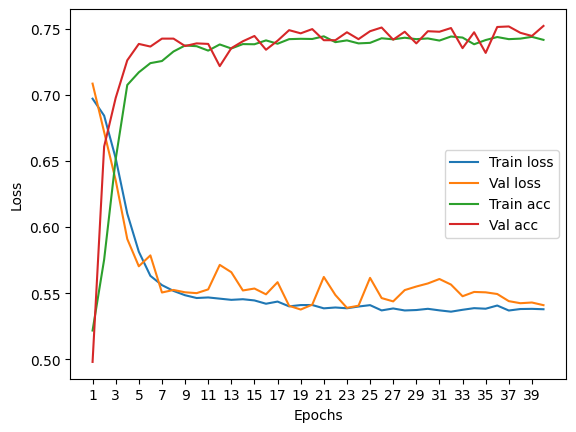

****************************************************************************************************



118it [00:00, 244.41it/s]


Train Epoch: 0 	Loss: 0.690493, Accuracy: 4160/7500 (55%)
Val Epoch: 0 	Loss: 0.695466, Accuracy: 1507/2500 (60%)



118it [00:00, 236.80it/s]


Train Epoch: 1 	Loss: 0.661685, Accuracy: 4763/7500 (64%)
Val Epoch: 1 	Loss: 0.657014, Accuracy: 1639/2500 (66%)



118it [00:00, 171.35it/s]


Train Epoch: 2 	Loss: 0.619110, Accuracy: 5276/7500 (70%)
Val Epoch: 2 	Loss: 0.616628, Accuracy: 1776/2500 (71%)



118it [00:00, 208.47it/s]


Train Epoch: 3 	Loss: 0.583499, Accuracy: 5423/7500 (72%)
Val Epoch: 3 	Loss: 0.582653, Accuracy: 1810/2500 (72%)



118it [00:00, 192.32it/s]


Train Epoch: 4 	Loss: 0.568618, Accuracy: 5413/7500 (72%)
Val Epoch: 4 	Loss: 0.582358, Accuracy: 1799/2500 (72%)



118it [00:00, 222.98it/s]


Train Epoch: 5 	Loss: 0.556871, Accuracy: 5478/7500 (73%)
Val Epoch: 5 	Loss: 0.562250, Accuracy: 1825/2500 (73%)



118it [00:00, 207.91it/s]


Train Epoch: 6 	Loss: 0.554985, Accuracy: 5467/7500 (73%)
Val Epoch: 6 	Loss: 0.568089, Accuracy: 1830/2500 (73%)



118it [00:00, 190.31it/s]


Train Epoch: 7 	Loss: 0.549047, Accuracy: 5532/7500 (74%)
Val Epoch: 7 	Loss: 0.557725, Accuracy: 1837/2500 (73%)



118it [00:00, 218.29it/s]


Train Epoch: 8 	Loss: 0.547679, Accuracy: 5556/7500 (74%)
Val Epoch: 8 	Loss: 0.570711, Accuracy: 1814/2500 (73%)



118it [00:00, 215.01it/s]


Train Epoch: 9 	Loss: 0.547895, Accuracy: 5546/7500 (74%)
Val Epoch: 9 	Loss: 0.563333, Accuracy: 1821/2500 (73%)



118it [00:00, 150.92it/s]


Train Epoch: 10 	Loss: 0.548961, Accuracy: 5555/7500 (74%)
Val Epoch: 10 	Loss: 0.557162, Accuracy: 1825/2500 (73%)



118it [00:00, 180.66it/s]


Train Epoch: 11 	Loss: 0.549168, Accuracy: 5540/7500 (74%)
Val Epoch: 11 	Loss: 0.557161, Accuracy: 1819/2500 (73%)



118it [00:00, 211.74it/s]


Train Epoch: 12 	Loss: 0.549849, Accuracy: 5519/7500 (74%)
Val Epoch: 12 	Loss: 0.570732, Accuracy: 1817/2500 (73%)



118it [00:00, 201.79it/s]


Train Epoch: 13 	Loss: 0.545237, Accuracy: 5543/7500 (74%)
Val Epoch: 13 	Loss: 0.547445, Accuracy: 1835/2500 (73%)



118it [00:00, 211.23it/s]


Train Epoch: 14 	Loss: 0.549967, Accuracy: 5513/7500 (74%)
Val Epoch: 14 	Loss: 0.559798, Accuracy: 1870/2500 (75%)



118it [00:00, 213.61it/s]


Train Epoch: 15 	Loss: 0.545786, Accuracy: 5540/7500 (74%)
Val Epoch: 15 	Loss: 0.561694, Accuracy: 1856/2500 (74%)



118it [00:00, 219.94it/s]


Train Epoch: 16 	Loss: 0.546038, Accuracy: 5564/7500 (74%)
Val Epoch: 16 	Loss: 0.560116, Accuracy: 1846/2500 (74%)



118it [00:00, 222.64it/s]


Train Epoch: 17 	Loss: 0.545574, Accuracy: 5555/7500 (74%)
Val Epoch: 17 	Loss: 0.552932, Accuracy: 1848/2500 (74%)



118it [00:00, 239.91it/s]


Train Epoch: 18 	Loss: 0.547533, Accuracy: 5532/7500 (74%)
Val Epoch: 18 	Loss: 0.561900, Accuracy: 1851/2500 (74%)



118it [00:00, 243.21it/s]


Train Epoch: 19 	Loss: 0.548157, Accuracy: 5552/7500 (74%)
Val Epoch: 19 	Loss: 0.552437, Accuracy: 1850/2500 (74%)



118it [00:00, 246.64it/s]


Train Epoch: 20 	Loss: 0.545942, Accuracy: 5566/7500 (74%)
Val Epoch: 20 	Loss: 0.559976, Accuracy: 1827/2500 (73%)



118it [00:00, 242.41it/s]


Train Epoch: 21 	Loss: 0.546187, Accuracy: 5510/7500 (73%)
Val Epoch: 21 	Loss: 0.559231, Accuracy: 1836/2500 (73%)



118it [00:00, 229.79it/s]


Train Epoch: 22 	Loss: 0.546951, Accuracy: 5537/7500 (74%)
Val Epoch: 22 	Loss: 0.555164, Accuracy: 1847/2500 (74%)



118it [00:00, 217.78it/s]


Train Epoch: 23 	Loss: 0.544841, Accuracy: 5560/7500 (74%)
Val Epoch: 23 	Loss: 0.560104, Accuracy: 1861/2500 (74%)



118it [00:00, 223.38it/s]


Train Epoch: 24 	Loss: 0.543974, Accuracy: 5571/7500 (74%)
Val Epoch: 24 	Loss: 0.554401, Accuracy: 1852/2500 (74%)



118it [00:00, 209.02it/s]


Train Epoch: 25 	Loss: 0.543902, Accuracy: 5528/7500 (74%)
Val Epoch: 25 	Loss: 0.568351, Accuracy: 1844/2500 (74%)



118it [00:00, 216.09it/s]


Train Epoch: 26 	Loss: 0.545002, Accuracy: 5556/7500 (74%)
Val Epoch: 26 	Loss: 0.559007, Accuracy: 1839/2500 (74%)



118it [00:00, 224.72it/s]


Train Epoch: 27 	Loss: 0.543269, Accuracy: 5542/7500 (74%)
Val Epoch: 27 	Loss: 0.553080, Accuracy: 1835/2500 (73%)



118it [00:00, 214.39it/s]


Train Epoch: 28 	Loss: 0.543601, Accuracy: 5548/7500 (74%)
Val Epoch: 28 	Loss: 0.565398, Accuracy: 1842/2500 (74%)



118it [00:00, 238.97it/s]


Train Epoch: 29 	Loss: 0.545032, Accuracy: 5557/7500 (74%)
Val Epoch: 29 	Loss: 0.554361, Accuracy: 1854/2500 (74%)



118it [00:00, 226.25it/s]


Train Epoch: 30 	Loss: 0.544202, Accuracy: 5563/7500 (74%)
Val Epoch: 30 	Loss: 0.567931, Accuracy: 1836/2500 (73%)



118it [00:00, 227.39it/s]


Train Epoch: 31 	Loss: 0.543233, Accuracy: 5552/7500 (74%)
Val Epoch: 31 	Loss: 0.550977, Accuracy: 1860/2500 (74%)



118it [00:00, 225.42it/s]


Train Epoch: 32 	Loss: 0.545106, Accuracy: 5540/7500 (74%)
Val Epoch: 32 	Loss: 0.564456, Accuracy: 1851/2500 (74%)



118it [00:00, 171.56it/s]


Train Epoch: 33 	Loss: 0.542642, Accuracy: 5541/7500 (74%)
Val Epoch: 33 	Loss: 0.555637, Accuracy: 1858/2500 (74%)



118it [00:00, 156.45it/s]


Train Epoch: 34 	Loss: 0.544658, Accuracy: 5535/7500 (74%)
Val Epoch: 34 	Loss: 0.558652, Accuracy: 1828/2500 (73%)



118it [00:00, 178.63it/s]


Train Epoch: 35 	Loss: 0.542617, Accuracy: 5573/7500 (74%)
Val Epoch: 35 	Loss: 0.562001, Accuracy: 1843/2500 (74%)



118it [00:00, 224.43it/s]


Train Epoch: 36 	Loss: 0.543357, Accuracy: 5528/7500 (74%)
Val Epoch: 36 	Loss: 0.551515, Accuracy: 1847/2500 (74%)



118it [00:00, 247.53it/s]


Train Epoch: 37 	Loss: 0.545943, Accuracy: 5547/7500 (74%)
Val Epoch: 37 	Loss: 0.552174, Accuracy: 1850/2500 (74%)



118it [00:00, 245.04it/s]


Train Epoch: 38 	Loss: 0.544025, Accuracy: 5538/7500 (74%)
Val Epoch: 38 	Loss: 0.553536, Accuracy: 1857/2500 (74%)



118it [00:00, 244.32it/s]


Train Epoch: 39 	Loss: 0.544392, Accuracy: 5550/7500 (74%)
Val Epoch: 39 	Loss: 0.572482, Accuracy: 1847/2500 (74%)

Test accuracy:  72.24000000000001


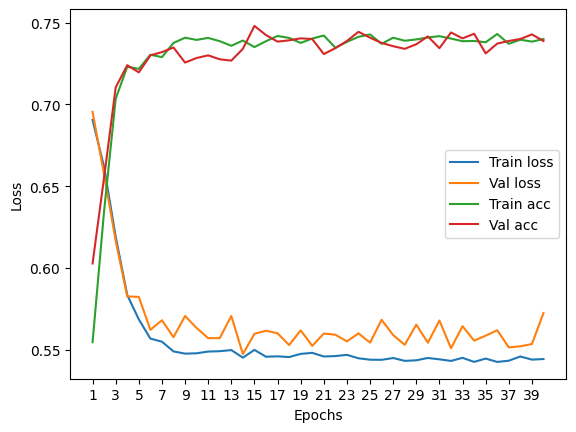

****************************************************************************************************



118it [00:00, 253.04it/s]


Train Epoch: 0 	Loss: 0.694003, Accuracy: 4022/7500 (54%)
Val Epoch: 0 	Loss: 0.699154, Accuracy: 1407/2500 (56%)



118it [00:00, 225.22it/s]


Train Epoch: 1 	Loss: 0.679741, Accuracy: 4394/7500 (59%)
Val Epoch: 1 	Loss: 0.678035, Accuracy: 1592/2500 (64%)



118it [00:00, 167.62it/s]


Train Epoch: 2 	Loss: 0.649006, Accuracy: 4876/7500 (65%)
Val Epoch: 2 	Loss: 0.638915, Accuracy: 1675/2500 (67%)



118it [00:00, 154.22it/s]


Train Epoch: 3 	Loss: 0.617575, Accuracy: 5261/7500 (70%)
Val Epoch: 3 	Loss: 0.608830, Accuracy: 1800/2500 (72%)



118it [00:00, 137.13it/s]


Train Epoch: 4 	Loss: 0.592944, Accuracy: 5402/7500 (72%)
Val Epoch: 4 	Loss: 0.587667, Accuracy: 1789/2500 (72%)



118it [00:00, 150.84it/s]


Train Epoch: 5 	Loss: 0.576694, Accuracy: 5414/7500 (72%)
Val Epoch: 5 	Loss: 0.587460, Accuracy: 1794/2500 (72%)



118it [00:00, 203.48it/s]


Train Epoch: 6 	Loss: 0.566359, Accuracy: 5415/7500 (72%)
Val Epoch: 6 	Loss: 0.570003, Accuracy: 1815/2500 (73%)



118it [00:00, 204.84it/s]


Train Epoch: 7 	Loss: 0.559378, Accuracy: 5480/7500 (73%)
Val Epoch: 7 	Loss: 0.566553, Accuracy: 1795/2500 (72%)



118it [00:00, 211.35it/s]


Train Epoch: 8 	Loss: 0.555393, Accuracy: 5502/7500 (73%)
Val Epoch: 8 	Loss: 0.589003, Accuracy: 1735/2500 (69%)



118it [00:00, 230.90it/s]


Train Epoch: 9 	Loss: 0.554234, Accuracy: 5508/7500 (73%)
Val Epoch: 9 	Loss: 0.557673, Accuracy: 1806/2500 (72%)



118it [00:00, 221.97it/s]


Train Epoch: 10 	Loss: 0.550757, Accuracy: 5513/7500 (74%)
Val Epoch: 10 	Loss: 0.552177, Accuracy: 1814/2500 (73%)



118it [00:00, 208.89it/s]


Train Epoch: 11 	Loss: 0.549604, Accuracy: 5555/7500 (74%)
Val Epoch: 11 	Loss: 0.581172, Accuracy: 1824/2500 (73%)



118it [00:00, 243.67it/s]


Train Epoch: 12 	Loss: 0.549782, Accuracy: 5529/7500 (74%)
Val Epoch: 12 	Loss: 0.547119, Accuracy: 1816/2500 (73%)



118it [00:00, 169.46it/s]


Train Epoch: 13 	Loss: 0.549072, Accuracy: 5565/7500 (74%)
Val Epoch: 13 	Loss: 0.546732, Accuracy: 1805/2500 (72%)



118it [00:01, 107.62it/s]


Train Epoch: 14 	Loss: 0.550168, Accuracy: 5523/7500 (74%)
Val Epoch: 14 	Loss: 0.544678, Accuracy: 1826/2500 (73%)



118it [00:01, 71.34it/s]


Train Epoch: 15 	Loss: 0.549260, Accuracy: 5534/7500 (74%)
Val Epoch: 15 	Loss: 0.552936, Accuracy: 1825/2500 (73%)



118it [00:01, 114.59it/s]


Train Epoch: 16 	Loss: 0.548384, Accuracy: 5542/7500 (74%)
Val Epoch: 16 	Loss: 0.552376, Accuracy: 1817/2500 (73%)



118it [00:01, 104.07it/s]


Train Epoch: 17 	Loss: 0.549371, Accuracy: 5565/7500 (74%)
Val Epoch: 17 	Loss: 0.556980, Accuracy: 1850/2500 (74%)



118it [00:01, 111.88it/s]


Train Epoch: 18 	Loss: 0.548622, Accuracy: 5541/7500 (74%)
Val Epoch: 18 	Loss: 0.550873, Accuracy: 1833/2500 (73%)



118it [00:01, 116.46it/s]


Train Epoch: 19 	Loss: 0.547804, Accuracy: 5528/7500 (74%)
Val Epoch: 19 	Loss: 0.554874, Accuracy: 1797/2500 (72%)



118it [00:00, 162.68it/s]


Train Epoch: 20 	Loss: 0.547296, Accuracy: 5562/7500 (74%)
Val Epoch: 20 	Loss: 0.557151, Accuracy: 1817/2500 (73%)



118it [00:00, 170.41it/s]


Train Epoch: 21 	Loss: 0.548000, Accuracy: 5517/7500 (74%)
Val Epoch: 21 	Loss: 0.601152, Accuracy: 1813/2500 (73%)



118it [00:01, 111.30it/s]


Train Epoch: 22 	Loss: 0.551026, Accuracy: 5528/7500 (74%)
Val Epoch: 22 	Loss: 0.556018, Accuracy: 1846/2500 (74%)



118it [00:00, 122.51it/s]


Train Epoch: 23 	Loss: 0.549146, Accuracy: 5539/7500 (74%)
Val Epoch: 23 	Loss: 0.566773, Accuracy: 1834/2500 (73%)



118it [00:01, 100.62it/s]


Train Epoch: 24 	Loss: 0.547499, Accuracy: 5542/7500 (74%)
Val Epoch: 24 	Loss: 0.558477, Accuracy: 1787/2500 (71%)



118it [00:00, 203.26it/s]


Train Epoch: 25 	Loss: 0.550008, Accuracy: 5537/7500 (74%)
Val Epoch: 25 	Loss: 0.544919, Accuracy: 1829/2500 (73%)



118it [00:01, 95.37it/s]


Train Epoch: 26 	Loss: 0.550450, Accuracy: 5533/7500 (74%)
Val Epoch: 26 	Loss: 0.558661, Accuracy: 1832/2500 (73%)



118it [00:01, 97.05it/s] 


Train Epoch: 27 	Loss: 0.550204, Accuracy: 5540/7500 (74%)
Val Epoch: 27 	Loss: 0.550627, Accuracy: 1827/2500 (73%)



118it [00:00, 131.84it/s]


Train Epoch: 28 	Loss: 0.550880, Accuracy: 5538/7500 (74%)
Val Epoch: 28 	Loss: 0.554785, Accuracy: 1790/2500 (72%)



118it [00:00, 221.09it/s]


Train Epoch: 29 	Loss: 0.546351, Accuracy: 5517/7500 (74%)
Val Epoch: 29 	Loss: 0.556304, Accuracy: 1820/2500 (73%)



118it [00:00, 199.17it/s]


Train Epoch: 30 	Loss: 0.546160, Accuracy: 5550/7500 (74%)
Val Epoch: 30 	Loss: 0.550489, Accuracy: 1812/2500 (72%)



118it [00:00, 215.98it/s]


Train Epoch: 31 	Loss: 0.547588, Accuracy: 5558/7500 (74%)
Val Epoch: 31 	Loss: 0.551071, Accuracy: 1823/2500 (73%)



118it [00:00, 235.40it/s]


Train Epoch: 32 	Loss: 0.548251, Accuracy: 5527/7500 (74%)
Val Epoch: 32 	Loss: 0.555825, Accuracy: 1813/2500 (73%)



118it [00:00, 217.08it/s]


Train Epoch: 33 	Loss: 0.546779, Accuracy: 5542/7500 (74%)
Val Epoch: 33 	Loss: 0.559198, Accuracy: 1793/2500 (72%)



118it [00:00, 219.53it/s]


Train Epoch: 34 	Loss: 0.545808, Accuracy: 5549/7500 (74%)
Val Epoch: 34 	Loss: 0.566403, Accuracy: 1828/2500 (73%)



118it [00:00, 192.28it/s]


Train Epoch: 35 	Loss: 0.548530, Accuracy: 5507/7500 (73%)
Val Epoch: 35 	Loss: 0.571174, Accuracy: 1824/2500 (73%)



118it [00:00, 203.63it/s]


Train Epoch: 36 	Loss: 0.550457, Accuracy: 5508/7500 (73%)
Val Epoch: 36 	Loss: 0.556232, Accuracy: 1817/2500 (73%)



118it [00:00, 220.74it/s]


Train Epoch: 37 	Loss: 0.549883, Accuracy: 5520/7500 (74%)
Val Epoch: 37 	Loss: 0.553502, Accuracy: 1835/2500 (73%)



118it [00:00, 149.86it/s]


Train Epoch: 38 	Loss: 0.547569, Accuracy: 5561/7500 (74%)
Val Epoch: 38 	Loss: 0.559074, Accuracy: 1837/2500 (73%)



118it [00:01, 116.92it/s]


Train Epoch: 39 	Loss: 0.548353, Accuracy: 5568/7500 (74%)
Val Epoch: 39 	Loss: 0.559037, Accuracy: 1798/2500 (72%)

Test accuracy:  71.52


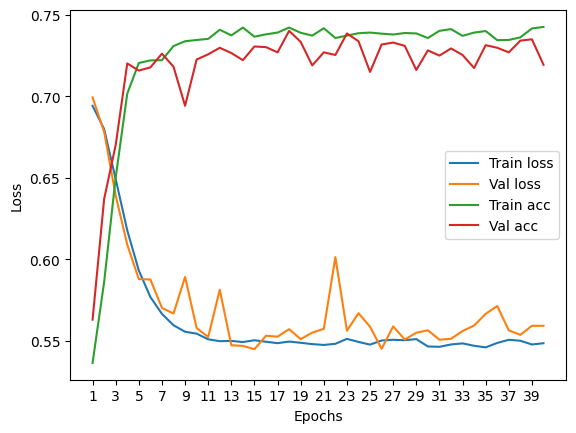

****************************************************************************************************



118it [00:00, 215.40it/s]


Train Epoch: 0 	Loss: 0.688248, Accuracy: 4219/7500 (56%)
Val Epoch: 0 	Loss: 0.693656, Accuracy: 1449/2500 (58%)



118it [00:00, 174.59it/s]


Train Epoch: 1 	Loss: 0.664747, Accuracy: 4552/7500 (61%)
Val Epoch: 1 	Loss: 0.673898, Accuracy: 1533/2500 (61%)



118it [00:00, 235.59it/s]


Train Epoch: 2 	Loss: 0.635835, Accuracy: 4942/7500 (66%)
Val Epoch: 2 	Loss: 0.643148, Accuracy: 1663/2500 (67%)



118it [00:00, 205.04it/s]


Train Epoch: 3 	Loss: 0.605795, Accuracy: 5188/7500 (69%)
Val Epoch: 3 	Loss: 0.614977, Accuracy: 1681/2500 (67%)



118it [00:00, 237.99it/s]


Train Epoch: 4 	Loss: 0.578644, Accuracy: 5388/7500 (72%)
Val Epoch: 4 	Loss: 0.575397, Accuracy: 1814/2500 (73%)



118it [00:00, 219.03it/s]


Train Epoch: 5 	Loss: 0.565801, Accuracy: 5419/7500 (72%)
Val Epoch: 5 	Loss: 0.572868, Accuracy: 1803/2500 (72%)



118it [00:00, 242.30it/s]


Train Epoch: 6 	Loss: 0.558616, Accuracy: 5416/7500 (72%)
Val Epoch: 6 	Loss: 0.564177, Accuracy: 1826/2500 (73%)



118it [00:00, 240.36it/s]


Train Epoch: 7 	Loss: 0.552145, Accuracy: 5463/7500 (73%)
Val Epoch: 7 	Loss: 0.558484, Accuracy: 1834/2500 (73%)



118it [00:00, 246.33it/s]


Train Epoch: 8 	Loss: 0.558707, Accuracy: 5430/7500 (72%)
Val Epoch: 8 	Loss: 0.561197, Accuracy: 1822/2500 (73%)



118it [00:00, 234.13it/s]


Train Epoch: 9 	Loss: 0.545878, Accuracy: 5521/7500 (74%)
Val Epoch: 9 	Loss: 0.553472, Accuracy: 1845/2500 (74%)



118it [00:00, 230.33it/s]


Train Epoch: 10 	Loss: 0.544650, Accuracy: 5503/7500 (73%)
Val Epoch: 10 	Loss: 0.554007, Accuracy: 1826/2500 (73%)



118it [00:00, 245.16it/s]


Train Epoch: 11 	Loss: 0.544884, Accuracy: 5516/7500 (74%)
Val Epoch: 11 	Loss: 0.566520, Accuracy: 1847/2500 (74%)



118it [00:00, 239.27it/s]


Train Epoch: 12 	Loss: 0.545611, Accuracy: 5526/7500 (74%)
Val Epoch: 12 	Loss: 0.556421, Accuracy: 1821/2500 (73%)



118it [00:00, 240.42it/s]


Train Epoch: 13 	Loss: 0.539782, Accuracy: 5536/7500 (74%)
Val Epoch: 13 	Loss: 0.549091, Accuracy: 1847/2500 (74%)



118it [00:00, 234.23it/s]


Train Epoch: 14 	Loss: 0.540071, Accuracy: 5551/7500 (74%)
Val Epoch: 14 	Loss: 0.552100, Accuracy: 1851/2500 (74%)



118it [00:00, 233.16it/s]


Train Epoch: 15 	Loss: 0.541293, Accuracy: 5534/7500 (74%)
Val Epoch: 15 	Loss: 0.547853, Accuracy: 1852/2500 (74%)



118it [00:00, 244.75it/s]


Train Epoch: 16 	Loss: 0.541234, Accuracy: 5559/7500 (74%)
Val Epoch: 16 	Loss: 0.554083, Accuracy: 1839/2500 (74%)



118it [00:00, 242.85it/s]


Train Epoch: 17 	Loss: 0.541087, Accuracy: 5502/7500 (73%)
Val Epoch: 17 	Loss: 0.556921, Accuracy: 1845/2500 (74%)



118it [00:00, 220.62it/s]


Train Epoch: 18 	Loss: 0.537171, Accuracy: 5582/7500 (74%)
Val Epoch: 18 	Loss: 0.554604, Accuracy: 1849/2500 (74%)



118it [00:00, 242.27it/s]


Train Epoch: 19 	Loss: 0.539046, Accuracy: 5555/7500 (74%)
Val Epoch: 19 	Loss: 0.555286, Accuracy: 1819/2500 (73%)



118it [00:00, 239.02it/s]


Train Epoch: 20 	Loss: 0.539774, Accuracy: 5548/7500 (74%)
Val Epoch: 20 	Loss: 0.552685, Accuracy: 1845/2500 (74%)



118it [00:00, 192.07it/s]


Train Epoch: 21 	Loss: 0.538952, Accuracy: 5554/7500 (74%)
Val Epoch: 21 	Loss: 0.544717, Accuracy: 1829/2500 (73%)



118it [00:00, 210.48it/s]


Train Epoch: 22 	Loss: 0.538454, Accuracy: 5569/7500 (74%)
Val Epoch: 22 	Loss: 0.547674, Accuracy: 1847/2500 (74%)



118it [00:00, 196.66it/s]


Train Epoch: 23 	Loss: 0.537971, Accuracy: 5571/7500 (74%)
Val Epoch: 23 	Loss: 0.553988, Accuracy: 1820/2500 (73%)



118it [00:00, 166.38it/s]


Train Epoch: 24 	Loss: 0.538423, Accuracy: 5563/7500 (74%)
Val Epoch: 24 	Loss: 0.547980, Accuracy: 1830/2500 (73%)



118it [00:00, 190.94it/s]


Train Epoch: 25 	Loss: 0.539272, Accuracy: 5568/7500 (74%)
Val Epoch: 25 	Loss: 0.555526, Accuracy: 1842/2500 (74%)



118it [00:00, 197.10it/s]


Train Epoch: 26 	Loss: 0.536632, Accuracy: 5570/7500 (74%)
Val Epoch: 26 	Loss: 0.569926, Accuracy: 1838/2500 (74%)



118it [00:00, 199.28it/s]


Train Epoch: 27 	Loss: 0.542154, Accuracy: 5547/7500 (74%)
Val Epoch: 27 	Loss: 0.560580, Accuracy: 1847/2500 (74%)



118it [00:01, 95.10it/s] 


Train Epoch: 28 	Loss: 0.542264, Accuracy: 5535/7500 (74%)
Val Epoch: 28 	Loss: 0.567302, Accuracy: 1840/2500 (74%)



118it [00:00, 124.58it/s]


Train Epoch: 29 	Loss: 0.541849, Accuracy: 5562/7500 (74%)
Val Epoch: 29 	Loss: 0.554591, Accuracy: 1841/2500 (74%)



118it [00:00, 235.26it/s]


Train Epoch: 30 	Loss: 0.538980, Accuracy: 5574/7500 (74%)
Val Epoch: 30 	Loss: 0.559679, Accuracy: 1814/2500 (73%)



118it [00:00, 241.36it/s]


Train Epoch: 31 	Loss: 0.537074, Accuracy: 5566/7500 (74%)
Val Epoch: 31 	Loss: 0.547377, Accuracy: 1830/2500 (73%)



118it [00:00, 250.43it/s]


Train Epoch: 32 	Loss: 0.539352, Accuracy: 5573/7500 (74%)
Val Epoch: 32 	Loss: 0.563160, Accuracy: 1846/2500 (74%)



118it [00:00, 229.29it/s]


Train Epoch: 33 	Loss: 0.539761, Accuracy: 5581/7500 (74%)
Val Epoch: 33 	Loss: 0.549425, Accuracy: 1849/2500 (74%)



118it [00:00, 151.21it/s]


Train Epoch: 34 	Loss: 0.539270, Accuracy: 5570/7500 (74%)
Val Epoch: 34 	Loss: 0.559430, Accuracy: 1849/2500 (74%)



118it [00:00, 142.60it/s]


Train Epoch: 35 	Loss: 0.538263, Accuracy: 5556/7500 (74%)
Val Epoch: 35 	Loss: 0.546966, Accuracy: 1837/2500 (73%)



118it [00:01, 116.36it/s]


Train Epoch: 36 	Loss: 0.539115, Accuracy: 5581/7500 (74%)
Val Epoch: 36 	Loss: 0.563619, Accuracy: 1845/2500 (74%)



118it [00:01, 101.49it/s]


Train Epoch: 37 	Loss: 0.538862, Accuracy: 5546/7500 (74%)
Val Epoch: 37 	Loss: 0.549380, Accuracy: 1836/2500 (73%)



118it [00:01, 111.81it/s]


Train Epoch: 38 	Loss: 0.537592, Accuracy: 5569/7500 (74%)
Val Epoch: 38 	Loss: 0.557112, Accuracy: 1836/2500 (73%)



118it [00:01, 110.96it/s]


Train Epoch: 39 	Loss: 0.538314, Accuracy: 5560/7500 (74%)
Val Epoch: 39 	Loss: 0.544003, Accuracy: 1828/2500 (73%)

Test accuracy:  73.11999999999999


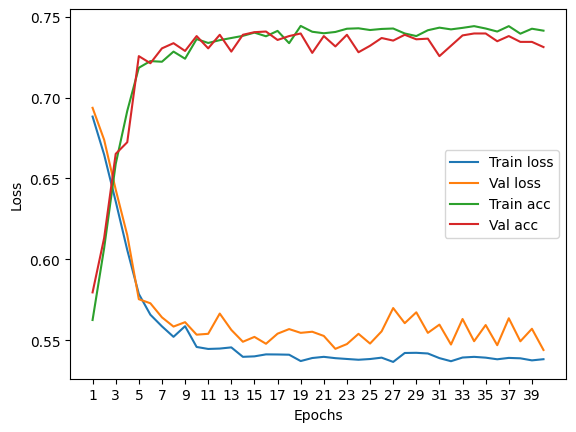

****************************************************************************************************



118it [00:00, 199.59it/s]


Train Epoch: 0 	Loss: 0.685978, Accuracy: 4341/7500 (58%)
Val Epoch: 0 	Loss: 0.682613, Accuracy: 1635/2500 (65%)



118it [00:00, 190.63it/s]


Train Epoch: 1 	Loss: 0.645414, Accuracy: 5113/7500 (68%)
Val Epoch: 1 	Loss: 0.622566, Accuracy: 1810/2500 (72%)



118it [00:00, 236.36it/s]


Train Epoch: 2 	Loss: 0.588265, Accuracy: 5458/7500 (73%)
Val Epoch: 2 	Loss: 0.577310, Accuracy: 1814/2500 (73%)



118it [00:00, 254.32it/s]


Train Epoch: 3 	Loss: 0.563208, Accuracy: 5469/7500 (73%)
Val Epoch: 3 	Loss: 0.566860, Accuracy: 1801/2500 (72%)



118it [00:00, 199.48it/s]


Train Epoch: 4 	Loss: 0.549626, Accuracy: 5513/7500 (74%)
Val Epoch: 4 	Loss: 0.557000, Accuracy: 1826/2500 (73%)



118it [00:00, 239.84it/s]


Train Epoch: 5 	Loss: 0.545270, Accuracy: 5521/7500 (74%)
Val Epoch: 5 	Loss: 0.558079, Accuracy: 1825/2500 (73%)



118it [00:00, 240.17it/s]


Train Epoch: 6 	Loss: 0.542593, Accuracy: 5539/7500 (74%)
Val Epoch: 6 	Loss: 0.561111, Accuracy: 1840/2500 (74%)



118it [00:00, 231.62it/s]


Train Epoch: 7 	Loss: 0.542908, Accuracy: 5526/7500 (74%)
Val Epoch: 7 	Loss: 0.562405, Accuracy: 1845/2500 (74%)



118it [00:00, 226.37it/s]


Train Epoch: 8 	Loss: 0.543807, Accuracy: 5519/7500 (74%)
Val Epoch: 8 	Loss: 0.550342, Accuracy: 1835/2500 (73%)



118it [00:00, 230.39it/s]


Train Epoch: 9 	Loss: 0.542068, Accuracy: 5535/7500 (74%)
Val Epoch: 9 	Loss: 0.553142, Accuracy: 1826/2500 (73%)



118it [00:00, 237.59it/s]


Train Epoch: 10 	Loss: 0.542647, Accuracy: 5509/7500 (73%)
Val Epoch: 10 	Loss: 0.570939, Accuracy: 1813/2500 (73%)



118it [00:00, 214.90it/s]


Train Epoch: 11 	Loss: 0.543085, Accuracy: 5503/7500 (73%)
Val Epoch: 11 	Loss: 0.560261, Accuracy: 1843/2500 (74%)



118it [00:00, 253.03it/s]


Train Epoch: 12 	Loss: 0.542140, Accuracy: 5558/7500 (74%)
Val Epoch: 12 	Loss: 0.567339, Accuracy: 1831/2500 (73%)



118it [00:00, 241.84it/s]


Train Epoch: 13 	Loss: 0.542277, Accuracy: 5559/7500 (74%)
Val Epoch: 13 	Loss: 0.576398, Accuracy: 1838/2500 (74%)



118it [00:00, 250.94it/s]


Train Epoch: 14 	Loss: 0.541712, Accuracy: 5527/7500 (74%)
Val Epoch: 14 	Loss: 0.556286, Accuracy: 1811/2500 (72%)



118it [00:00, 250.74it/s]


Train Epoch: 15 	Loss: 0.541300, Accuracy: 5524/7500 (74%)
Val Epoch: 15 	Loss: 0.558130, Accuracy: 1828/2500 (73%)



118it [00:00, 226.69it/s]


Train Epoch: 16 	Loss: 0.543272, Accuracy: 5501/7500 (73%)
Val Epoch: 16 	Loss: 0.557535, Accuracy: 1826/2500 (73%)



118it [00:00, 241.03it/s]


Train Epoch: 17 	Loss: 0.541795, Accuracy: 5528/7500 (74%)
Val Epoch: 17 	Loss: 0.558389, Accuracy: 1821/2500 (73%)



118it [00:00, 252.34it/s]


Train Epoch: 18 	Loss: 0.541283, Accuracy: 5535/7500 (74%)
Val Epoch: 18 	Loss: 0.559474, Accuracy: 1822/2500 (73%)



118it [00:00, 253.95it/s]


Train Epoch: 19 	Loss: 0.539939, Accuracy: 5548/7500 (74%)
Val Epoch: 19 	Loss: 0.556342, Accuracy: 1823/2500 (73%)



118it [00:00, 229.19it/s]


Train Epoch: 20 	Loss: 0.538841, Accuracy: 5555/7500 (74%)
Val Epoch: 20 	Loss: 0.558113, Accuracy: 1834/2500 (73%)



118it [00:00, 233.95it/s]


Train Epoch: 21 	Loss: 0.540946, Accuracy: 5525/7500 (74%)
Val Epoch: 21 	Loss: 0.556855, Accuracy: 1830/2500 (73%)



118it [00:00, 209.56it/s]


Train Epoch: 22 	Loss: 0.538361, Accuracy: 5537/7500 (74%)
Val Epoch: 22 	Loss: 0.563069, Accuracy: 1817/2500 (73%)



118it [00:00, 152.18it/s]


Train Epoch: 23 	Loss: 0.540996, Accuracy: 5557/7500 (74%)
Val Epoch: 23 	Loss: 0.560227, Accuracy: 1848/2500 (74%)



118it [00:00, 183.12it/s]


Train Epoch: 24 	Loss: 0.540303, Accuracy: 5543/7500 (74%)
Val Epoch: 24 	Loss: 0.548380, Accuracy: 1836/2500 (73%)



118it [00:00, 195.34it/s]


Train Epoch: 25 	Loss: 0.540050, Accuracy: 5571/7500 (74%)
Val Epoch: 25 	Loss: 0.557685, Accuracy: 1826/2500 (73%)



118it [00:00, 229.62it/s]


Train Epoch: 26 	Loss: 0.539790, Accuracy: 5562/7500 (74%)
Val Epoch: 26 	Loss: 0.564398, Accuracy: 1831/2500 (73%)



118it [00:00, 230.22it/s]


Train Epoch: 27 	Loss: 0.539955, Accuracy: 5513/7500 (74%)
Val Epoch: 27 	Loss: 0.573403, Accuracy: 1831/2500 (73%)



118it [00:00, 233.23it/s]


Train Epoch: 28 	Loss: 0.541020, Accuracy: 5529/7500 (74%)
Val Epoch: 28 	Loss: 0.568662, Accuracy: 1830/2500 (73%)



118it [00:00, 223.79it/s]


Train Epoch: 29 	Loss: 0.539438, Accuracy: 5542/7500 (74%)
Val Epoch: 29 	Loss: 0.566858, Accuracy: 1818/2500 (73%)



118it [00:00, 223.39it/s]


Train Epoch: 30 	Loss: 0.539943, Accuracy: 5542/7500 (74%)
Val Epoch: 30 	Loss: 0.547881, Accuracy: 1848/2500 (74%)



118it [00:00, 251.59it/s]


Train Epoch: 31 	Loss: 0.540739, Accuracy: 5529/7500 (74%)
Val Epoch: 31 	Loss: 0.550370, Accuracy: 1835/2500 (73%)



118it [00:00, 252.89it/s]


Train Epoch: 32 	Loss: 0.542413, Accuracy: 5503/7500 (73%)
Val Epoch: 32 	Loss: 0.556289, Accuracy: 1837/2500 (73%)



118it [00:00, 255.77it/s]


Train Epoch: 33 	Loss: 0.539710, Accuracy: 5557/7500 (74%)
Val Epoch: 33 	Loss: 0.554539, Accuracy: 1830/2500 (73%)



118it [00:00, 252.00it/s]


Train Epoch: 34 	Loss: 0.539205, Accuracy: 5563/7500 (74%)
Val Epoch: 34 	Loss: 0.564455, Accuracy: 1827/2500 (73%)



118it [00:00, 253.01it/s]


Train Epoch: 35 	Loss: 0.538954, Accuracy: 5533/7500 (74%)
Val Epoch: 35 	Loss: 0.565096, Accuracy: 1817/2500 (73%)



118it [00:00, 253.52it/s]


Train Epoch: 36 	Loss: 0.541228, Accuracy: 5532/7500 (74%)
Val Epoch: 36 	Loss: 0.552592, Accuracy: 1840/2500 (74%)



118it [00:00, 255.09it/s]


Train Epoch: 37 	Loss: 0.542583, Accuracy: 5510/7500 (73%)
Val Epoch: 37 	Loss: 0.555560, Accuracy: 1842/2500 (74%)



118it [00:00, 256.73it/s]


Train Epoch: 38 	Loss: 0.539231, Accuracy: 5539/7500 (74%)
Val Epoch: 38 	Loss: 0.554397, Accuracy: 1836/2500 (73%)



118it [00:00, 251.11it/s]


Train Epoch: 39 	Loss: 0.540224, Accuracy: 5512/7500 (73%)
Val Epoch: 39 	Loss: 0.549796, Accuracy: 1820/2500 (73%)

Test accuracy:  72.76


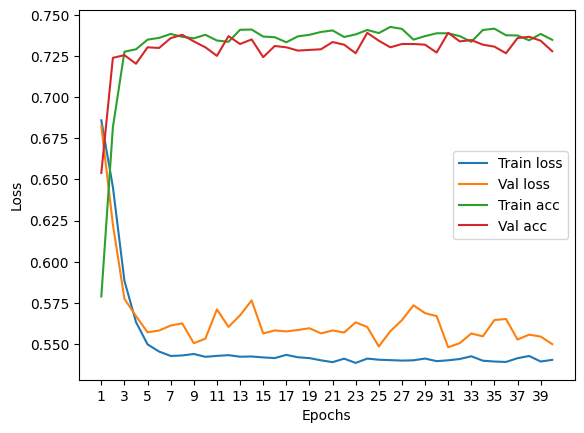

****************************************************************************************************



118it [00:00, 254.97it/s]


Train Epoch: 0 	Loss: 0.692797, Accuracy: 4022/7500 (54%)
Val Epoch: 0 	Loss: 0.698367, Accuracy: 1420/2500 (57%)



118it [00:00, 259.70it/s]


Train Epoch: 1 	Loss: 0.672626, Accuracy: 4573/7500 (61%)
Val Epoch: 1 	Loss: 0.676022, Accuracy: 1548/2500 (62%)



118it [00:00, 258.06it/s]


Train Epoch: 2 	Loss: 0.637771, Accuracy: 4937/7500 (66%)
Val Epoch: 2 	Loss: 0.660508, Accuracy: 1539/2500 (62%)



118it [00:00, 257.47it/s]


Train Epoch: 3 	Loss: 0.609793, Accuracy: 5205/7500 (69%)
Val Epoch: 3 	Loss: 0.621042, Accuracy: 1703/2500 (68%)



118it [00:00, 258.60it/s]


Train Epoch: 4 	Loss: 0.587716, Accuracy: 5274/7500 (70%)
Val Epoch: 4 	Loss: 0.579434, Accuracy: 1811/2500 (72%)



118it [00:00, 259.29it/s]


Train Epoch: 5 	Loss: 0.573640, Accuracy: 5351/7500 (71%)
Val Epoch: 5 	Loss: 0.576206, Accuracy: 1828/2500 (73%)



118it [00:00, 250.06it/s]


Train Epoch: 6 	Loss: 0.565695, Accuracy: 5430/7500 (72%)
Val Epoch: 6 	Loss: 0.562662, Accuracy: 1831/2500 (73%)



118it [00:00, 253.91it/s]


Train Epoch: 7 	Loss: 0.565699, Accuracy: 5381/7500 (72%)
Val Epoch: 7 	Loss: 0.561774, Accuracy: 1827/2500 (73%)



118it [00:00, 254.59it/s]


Train Epoch: 8 	Loss: 0.557152, Accuracy: 5444/7500 (73%)
Val Epoch: 8 	Loss: 0.565131, Accuracy: 1810/2500 (72%)



118it [00:00, 263.07it/s]


Train Epoch: 9 	Loss: 0.555189, Accuracy: 5447/7500 (73%)
Val Epoch: 9 	Loss: 0.570042, Accuracy: 1849/2500 (74%)



118it [00:00, 212.65it/s]


Train Epoch: 10 	Loss: 0.552361, Accuracy: 5469/7500 (73%)
Val Epoch: 10 	Loss: 0.569783, Accuracy: 1823/2500 (73%)



118it [00:00, 223.50it/s]


Train Epoch: 11 	Loss: 0.553185, Accuracy: 5498/7500 (73%)
Val Epoch: 11 	Loss: 0.559403, Accuracy: 1853/2500 (74%)



118it [00:00, 229.50it/s]


Train Epoch: 12 	Loss: 0.553048, Accuracy: 5477/7500 (73%)
Val Epoch: 12 	Loss: 0.570341, Accuracy: 1848/2500 (74%)



118it [00:00, 227.68it/s]


Train Epoch: 13 	Loss: 0.551689, Accuracy: 5511/7500 (73%)
Val Epoch: 13 	Loss: 0.557188, Accuracy: 1853/2500 (74%)



118it [00:00, 156.19it/s]


Train Epoch: 14 	Loss: 0.553778, Accuracy: 5491/7500 (73%)
Val Epoch: 14 	Loss: 0.572417, Accuracy: 1854/2500 (74%)



118it [00:00, 234.52it/s]


Train Epoch: 15 	Loss: 0.550264, Accuracy: 5489/7500 (73%)
Val Epoch: 15 	Loss: 0.567440, Accuracy: 1830/2500 (73%)



118it [00:00, 172.78it/s]


Train Epoch: 16 	Loss: 0.548666, Accuracy: 5507/7500 (73%)
Val Epoch: 16 	Loss: 0.558624, Accuracy: 1840/2500 (74%)



118it [00:00, 167.82it/s]


Train Epoch: 17 	Loss: 0.554491, Accuracy: 5478/7500 (73%)
Val Epoch: 17 	Loss: 0.561641, Accuracy: 1844/2500 (74%)



118it [00:00, 176.54it/s]


Train Epoch: 18 	Loss: 0.553722, Accuracy: 5478/7500 (73%)
Val Epoch: 18 	Loss: 0.552517, Accuracy: 1853/2500 (74%)



118it [00:00, 224.23it/s]


Train Epoch: 19 	Loss: 0.547930, Accuracy: 5509/7500 (73%)
Val Epoch: 19 	Loss: 0.554986, Accuracy: 1855/2500 (74%)



118it [00:00, 234.52it/s]


Train Epoch: 20 	Loss: 0.550663, Accuracy: 5492/7500 (73%)
Val Epoch: 20 	Loss: 0.565054, Accuracy: 1832/2500 (73%)



118it [00:00, 218.84it/s]


Train Epoch: 21 	Loss: 0.549389, Accuracy: 5504/7500 (73%)
Val Epoch: 21 	Loss: 0.565904, Accuracy: 1843/2500 (74%)



118it [00:00, 223.11it/s]


Train Epoch: 22 	Loss: 0.549112, Accuracy: 5497/7500 (73%)
Val Epoch: 22 	Loss: 0.552404, Accuracy: 1858/2500 (74%)



118it [00:00, 227.77it/s]


Train Epoch: 23 	Loss: 0.550816, Accuracy: 5480/7500 (73%)
Val Epoch: 23 	Loss: 0.568500, Accuracy: 1847/2500 (74%)



118it [00:00, 229.05it/s]


Train Epoch: 24 	Loss: 0.547331, Accuracy: 5507/7500 (73%)
Val Epoch: 24 	Loss: 0.564562, Accuracy: 1851/2500 (74%)



118it [00:00, 231.93it/s]


Train Epoch: 25 	Loss: 0.549067, Accuracy: 5504/7500 (73%)
Val Epoch: 25 	Loss: 0.559525, Accuracy: 1852/2500 (74%)



118it [00:00, 230.13it/s]


Train Epoch: 26 	Loss: 0.547578, Accuracy: 5504/7500 (73%)
Val Epoch: 26 	Loss: 0.549796, Accuracy: 1853/2500 (74%)



118it [00:00, 227.08it/s]


Train Epoch: 27 	Loss: 0.551374, Accuracy: 5486/7500 (73%)
Val Epoch: 27 	Loss: 0.584206, Accuracy: 1834/2500 (73%)



118it [00:00, 236.69it/s]


Train Epoch: 28 	Loss: 0.548247, Accuracy: 5488/7500 (73%)
Val Epoch: 28 	Loss: 0.565677, Accuracy: 1861/2500 (74%)



118it [00:00, 233.44it/s]


Train Epoch: 29 	Loss: 0.547872, Accuracy: 5496/7500 (73%)
Val Epoch: 29 	Loss: 0.560400, Accuracy: 1842/2500 (74%)



118it [00:00, 236.77it/s]


Train Epoch: 30 	Loss: 0.546636, Accuracy: 5503/7500 (73%)
Val Epoch: 30 	Loss: 0.557159, Accuracy: 1856/2500 (74%)



118it [00:00, 226.10it/s]


Train Epoch: 31 	Loss: 0.548653, Accuracy: 5479/7500 (73%)
Val Epoch: 31 	Loss: 0.577981, Accuracy: 1824/2500 (73%)



118it [00:00, 211.80it/s]


Train Epoch: 32 	Loss: 0.549591, Accuracy: 5498/7500 (73%)
Val Epoch: 32 	Loss: 0.552416, Accuracy: 1857/2500 (74%)



118it [00:00, 180.47it/s]


Train Epoch: 33 	Loss: 0.549497, Accuracy: 5483/7500 (73%)
Val Epoch: 33 	Loss: 0.567391, Accuracy: 1855/2500 (74%)



118it [00:00, 206.40it/s]


Train Epoch: 34 	Loss: 0.549053, Accuracy: 5499/7500 (73%)
Val Epoch: 34 	Loss: 0.557958, Accuracy: 1849/2500 (74%)



118it [00:00, 200.98it/s]


Train Epoch: 35 	Loss: 0.550148, Accuracy: 5496/7500 (73%)
Val Epoch: 35 	Loss: 0.567112, Accuracy: 1841/2500 (74%)



118it [00:00, 223.68it/s]


Train Epoch: 36 	Loss: 0.547430, Accuracy: 5521/7500 (74%)
Val Epoch: 36 	Loss: 0.560615, Accuracy: 1834/2500 (73%)



118it [00:00, 231.38it/s]


Train Epoch: 37 	Loss: 0.549322, Accuracy: 5514/7500 (74%)
Val Epoch: 37 	Loss: 0.561753, Accuracy: 1856/2500 (74%)



118it [00:00, 232.05it/s]


Train Epoch: 38 	Loss: 0.545954, Accuracy: 5494/7500 (73%)
Val Epoch: 38 	Loss: 0.576020, Accuracy: 1834/2500 (73%)



118it [00:00, 225.01it/s]


Train Epoch: 39 	Loss: 0.549643, Accuracy: 5495/7500 (73%)
Val Epoch: 39 	Loss: 0.562039, Accuracy: 1846/2500 (74%)

Test accuracy:  74.36


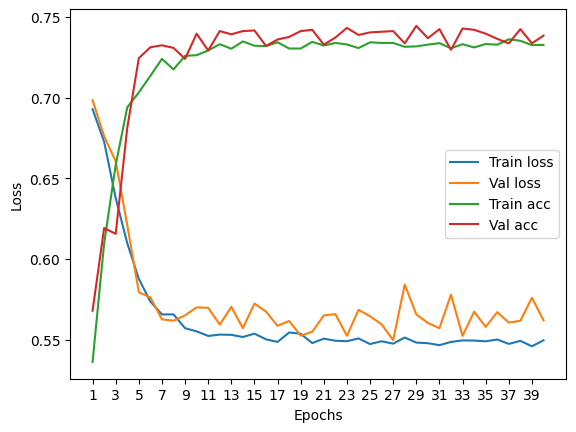

****************************************************************************************************



118it [00:00, 234.00it/s]


Train Epoch: 0 	Loss: 0.694911, Accuracy: 4014/7500 (54%)
Val Epoch: 0 	Loss: 0.698557, Accuracy: 1408/2500 (56%)



118it [00:00, 201.38it/s]


Train Epoch: 1 	Loss: 0.662423, Accuracy: 4682/7500 (62%)
Val Epoch: 1 	Loss: 0.643491, Accuracy: 1749/2500 (70%)



118it [00:00, 176.40it/s]


Train Epoch: 2 	Loss: 0.611077, Accuracy: 5229/7500 (70%)
Val Epoch: 2 	Loss: 0.592478, Accuracy: 1829/2500 (73%)



118it [00:00, 189.85it/s]


Train Epoch: 3 	Loss: 0.574628, Accuracy: 5469/7500 (73%)
Val Epoch: 3 	Loss: 0.568850, Accuracy: 1838/2500 (74%)



118it [00:00, 194.94it/s]


Train Epoch: 4 	Loss: 0.554525, Accuracy: 5481/7500 (73%)
Val Epoch: 4 	Loss: 0.555502, Accuracy: 1882/2500 (75%)



118it [00:00, 203.66it/s]


Train Epoch: 5 	Loss: 0.549870, Accuracy: 5509/7500 (73%)
Val Epoch: 5 	Loss: 0.543696, Accuracy: 1877/2500 (75%)



118it [00:00, 177.43it/s]


Train Epoch: 6 	Loss: 0.547967, Accuracy: 5510/7500 (73%)
Val Epoch: 6 	Loss: 0.557269, Accuracy: 1856/2500 (74%)



118it [00:00, 192.57it/s]


Train Epoch: 7 	Loss: 0.548632, Accuracy: 5505/7500 (73%)
Val Epoch: 7 	Loss: 0.541270, Accuracy: 1890/2500 (76%)



118it [00:00, 171.48it/s]


Train Epoch: 8 	Loss: 0.546061, Accuracy: 5526/7500 (74%)
Val Epoch: 8 	Loss: 0.542396, Accuracy: 1884/2500 (75%)



118it [00:00, 204.42it/s]


Train Epoch: 9 	Loss: 0.542608, Accuracy: 5575/7500 (74%)
Val Epoch: 9 	Loss: 0.543962, Accuracy: 1877/2500 (75%)



118it [00:00, 229.74it/s]


Train Epoch: 10 	Loss: 0.545264, Accuracy: 5546/7500 (74%)
Val Epoch: 10 	Loss: 0.546865, Accuracy: 1869/2500 (75%)



118it [00:00, 234.24it/s]


Train Epoch: 11 	Loss: 0.545843, Accuracy: 5527/7500 (74%)
Val Epoch: 11 	Loss: 0.549478, Accuracy: 1885/2500 (75%)



118it [00:00, 228.35it/s]


Train Epoch: 12 	Loss: 0.545616, Accuracy: 5545/7500 (74%)
Val Epoch: 12 	Loss: 0.547785, Accuracy: 1879/2500 (75%)



118it [00:00, 218.09it/s]


Train Epoch: 13 	Loss: 0.546059, Accuracy: 5501/7500 (73%)
Val Epoch: 13 	Loss: 0.534611, Accuracy: 1886/2500 (75%)



118it [00:00, 200.91it/s]


Train Epoch: 14 	Loss: 0.546220, Accuracy: 5551/7500 (74%)
Val Epoch: 14 	Loss: 0.539457, Accuracy: 1879/2500 (75%)



118it [00:00, 209.02it/s]


Train Epoch: 15 	Loss: 0.546904, Accuracy: 5532/7500 (74%)
Val Epoch: 15 	Loss: 0.550610, Accuracy: 1880/2500 (75%)



118it [00:00, 210.56it/s]


Train Epoch: 16 	Loss: 0.546617, Accuracy: 5550/7500 (74%)
Val Epoch: 16 	Loss: 0.550488, Accuracy: 1851/2500 (74%)



118it [00:00, 217.39it/s]


Train Epoch: 17 	Loss: 0.549961, Accuracy: 5524/7500 (74%)
Val Epoch: 17 	Loss: 0.549313, Accuracy: 1865/2500 (75%)



118it [00:00, 232.02it/s]


Train Epoch: 18 	Loss: 0.542608, Accuracy: 5564/7500 (74%)
Val Epoch: 18 	Loss: 0.559197, Accuracy: 1857/2500 (74%)



118it [00:00, 225.35it/s]


Train Epoch: 19 	Loss: 0.544209, Accuracy: 5562/7500 (74%)
Val Epoch: 19 	Loss: 0.556586, Accuracy: 1833/2500 (73%)



118it [00:00, 241.26it/s]


Train Epoch: 20 	Loss: 0.547560, Accuracy: 5521/7500 (74%)
Val Epoch: 20 	Loss: 0.551015, Accuracy: 1881/2500 (75%)



118it [00:00, 237.24it/s]


Train Epoch: 21 	Loss: 0.543246, Accuracy: 5563/7500 (74%)
Val Epoch: 21 	Loss: 0.537591, Accuracy: 1881/2500 (75%)



118it [00:00, 222.80it/s]


Train Epoch: 22 	Loss: 0.544220, Accuracy: 5562/7500 (74%)
Val Epoch: 22 	Loss: 0.542661, Accuracy: 1865/2500 (75%)



118it [00:00, 219.84it/s]


Train Epoch: 23 	Loss: 0.545002, Accuracy: 5583/7500 (74%)
Val Epoch: 23 	Loss: 0.553425, Accuracy: 1882/2500 (75%)



118it [00:00, 237.41it/s]


Train Epoch: 24 	Loss: 0.545016, Accuracy: 5576/7500 (74%)
Val Epoch: 24 	Loss: 0.543280, Accuracy: 1886/2500 (75%)



118it [00:00, 217.43it/s]


Train Epoch: 25 	Loss: 0.545885, Accuracy: 5542/7500 (74%)
Val Epoch: 25 	Loss: 0.545768, Accuracy: 1866/2500 (75%)



118it [00:00, 217.20it/s]


Train Epoch: 26 	Loss: 0.545701, Accuracy: 5557/7500 (74%)
Val Epoch: 26 	Loss: 0.551217, Accuracy: 1887/2500 (75%)



118it [00:00, 217.14it/s]


Train Epoch: 27 	Loss: 0.545488, Accuracy: 5539/7500 (74%)
Val Epoch: 27 	Loss: 0.539884, Accuracy: 1884/2500 (75%)



118it [00:00, 227.42it/s]


Train Epoch: 28 	Loss: 0.546165, Accuracy: 5560/7500 (74%)
Val Epoch: 28 	Loss: 0.556618, Accuracy: 1883/2500 (75%)



118it [00:00, 206.72it/s]


Train Epoch: 29 	Loss: 0.544307, Accuracy: 5545/7500 (74%)
Val Epoch: 29 	Loss: 0.541907, Accuracy: 1881/2500 (75%)



118it [00:00, 224.23it/s]


Train Epoch: 30 	Loss: 0.544259, Accuracy: 5555/7500 (74%)
Val Epoch: 30 	Loss: 0.545517, Accuracy: 1850/2500 (74%)



118it [00:00, 209.48it/s]


Train Epoch: 31 	Loss: 0.543590, Accuracy: 5547/7500 (74%)
Val Epoch: 31 	Loss: 0.540631, Accuracy: 1887/2500 (75%)



118it [00:00, 242.58it/s]


Train Epoch: 32 	Loss: 0.546588, Accuracy: 5541/7500 (74%)
Val Epoch: 32 	Loss: 0.539104, Accuracy: 1888/2500 (76%)



118it [00:00, 135.99it/s]


Train Epoch: 33 	Loss: 0.543916, Accuracy: 5520/7500 (74%)
Val Epoch: 33 	Loss: 0.553264, Accuracy: 1872/2500 (75%)



118it [00:00, 224.35it/s]


Train Epoch: 34 	Loss: 0.546087, Accuracy: 5554/7500 (74%)
Val Epoch: 34 	Loss: 0.544024, Accuracy: 1876/2500 (75%)



118it [00:00, 228.09it/s]


Train Epoch: 35 	Loss: 0.543552, Accuracy: 5542/7500 (74%)
Val Epoch: 35 	Loss: 0.546508, Accuracy: 1880/2500 (75%)



118it [00:00, 254.27it/s]


Train Epoch: 36 	Loss: 0.543442, Accuracy: 5548/7500 (74%)
Val Epoch: 36 	Loss: 0.558008, Accuracy: 1880/2500 (75%)



118it [00:00, 177.26it/s]


Train Epoch: 37 	Loss: 0.544793, Accuracy: 5550/7500 (74%)
Val Epoch: 37 	Loss: 0.566781, Accuracy: 1892/2500 (76%)



118it [00:00, 148.15it/s]


Train Epoch: 38 	Loss: 0.546145, Accuracy: 5532/7500 (74%)
Val Epoch: 38 	Loss: 0.542329, Accuracy: 1877/2500 (75%)



118it [00:00, 144.28it/s]


Train Epoch: 39 	Loss: 0.544203, Accuracy: 5568/7500 (74%)
Val Epoch: 39 	Loss: 0.539363, Accuracy: 1873/2500 (75%)

Test accuracy:  72.56


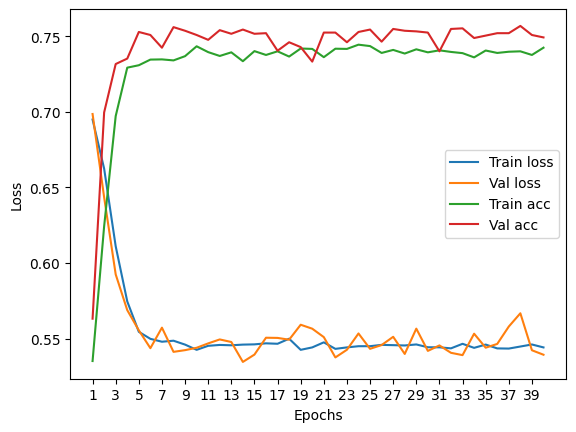

****************************************************************************************************



116it [00:00, 220.81it/s]


Train Epoch: 0 	Loss: 0.693444, Accuracy: 3851/7422 (52%)
Val Epoch: 0 	Loss: 0.693195, Accuracy: 1279/2474 (52%)



116it [00:00, 209.27it/s]


Train Epoch: 1 	Loss: 0.671379, Accuracy: 4532/7422 (61%)
Val Epoch: 1 	Loss: 0.653738, Accuracy: 1651/2474 (67%)



116it [00:00, 213.99it/s]


Train Epoch: 2 	Loss: 0.617370, Accuracy: 5157/7422 (69%)
Val Epoch: 2 	Loss: 0.603871, Accuracy: 1719/2474 (69%)



116it [00:00, 225.79it/s]


Train Epoch: 3 	Loss: 0.573993, Accuracy: 5385/7422 (73%)
Val Epoch: 3 	Loss: 0.569970, Accuracy: 1772/2474 (72%)



116it [00:00, 214.98it/s]


Train Epoch: 4 	Loss: 0.558282, Accuracy: 5451/7422 (73%)
Val Epoch: 4 	Loss: 0.561243, Accuracy: 1792/2474 (72%)



116it [00:00, 209.91it/s]


Train Epoch: 5 	Loss: 0.550304, Accuracy: 5463/7422 (74%)
Val Epoch: 5 	Loss: 0.556709, Accuracy: 1810/2474 (73%)



116it [00:00, 222.82it/s]


Train Epoch: 6 	Loss: 0.550563, Accuracy: 5463/7422 (74%)
Val Epoch: 6 	Loss: 0.556572, Accuracy: 1810/2474 (73%)



116it [00:00, 197.20it/s]


Train Epoch: 7 	Loss: 0.546300, Accuracy: 5490/7422 (74%)
Val Epoch: 7 	Loss: 0.554985, Accuracy: 1800/2474 (73%)



116it [00:00, 201.56it/s]


Train Epoch: 8 	Loss: 0.547564, Accuracy: 5469/7422 (74%)
Val Epoch: 8 	Loss: 0.555136, Accuracy: 1796/2474 (73%)



116it [00:00, 214.64it/s]


Train Epoch: 9 	Loss: 0.546909, Accuracy: 5492/7422 (74%)
Val Epoch: 9 	Loss: 0.571733, Accuracy: 1765/2474 (71%)



116it [00:00, 215.06it/s]


Train Epoch: 10 	Loss: 0.547019, Accuracy: 5451/7422 (73%)
Val Epoch: 10 	Loss: 0.553104, Accuracy: 1810/2474 (73%)



116it [00:00, 183.42it/s]


Train Epoch: 11 	Loss: 0.545732, Accuracy: 5475/7422 (74%)
Val Epoch: 11 	Loss: 0.555866, Accuracy: 1808/2474 (73%)



116it [00:00, 188.21it/s]


Train Epoch: 12 	Loss: 0.545366, Accuracy: 5480/7422 (74%)
Val Epoch: 12 	Loss: 0.563224, Accuracy: 1798/2474 (73%)



116it [00:00, 214.31it/s]


Train Epoch: 13 	Loss: 0.546885, Accuracy: 5485/7422 (74%)
Val Epoch: 13 	Loss: 0.553035, Accuracy: 1819/2474 (74%)



116it [00:00, 219.46it/s]


Train Epoch: 14 	Loss: 0.544907, Accuracy: 5498/7422 (74%)
Val Epoch: 14 	Loss: 0.554787, Accuracy: 1801/2474 (73%)



116it [00:00, 251.14it/s]


Train Epoch: 15 	Loss: 0.545801, Accuracy: 5483/7422 (74%)
Val Epoch: 15 	Loss: 0.555839, Accuracy: 1792/2474 (72%)



116it [00:00, 250.87it/s]


Train Epoch: 16 	Loss: 0.543647, Accuracy: 5491/7422 (74%)
Val Epoch: 16 	Loss: 0.561090, Accuracy: 1791/2474 (72%)



116it [00:00, 248.22it/s]


Train Epoch: 17 	Loss: 0.545615, Accuracy: 5487/7422 (74%)
Val Epoch: 17 	Loss: 0.559958, Accuracy: 1798/2474 (73%)



116it [00:00, 243.50it/s]


Train Epoch: 18 	Loss: 0.545529, Accuracy: 5497/7422 (74%)
Val Epoch: 18 	Loss: 0.557574, Accuracy: 1787/2474 (72%)



116it [00:00, 239.80it/s]


Train Epoch: 19 	Loss: 0.544553, Accuracy: 5497/7422 (74%)
Val Epoch: 19 	Loss: 0.559285, Accuracy: 1787/2474 (72%)



116it [00:00, 252.09it/s]


Train Epoch: 20 	Loss: 0.545231, Accuracy: 5469/7422 (74%)
Val Epoch: 20 	Loss: 0.556220, Accuracy: 1794/2474 (73%)



116it [00:00, 248.45it/s]


Train Epoch: 21 	Loss: 0.543248, Accuracy: 5516/7422 (74%)
Val Epoch: 21 	Loss: 0.553520, Accuracy: 1812/2474 (73%)



116it [00:00, 215.00it/s]


Train Epoch: 22 	Loss: 0.543877, Accuracy: 5482/7422 (74%)
Val Epoch: 22 	Loss: 0.554843, Accuracy: 1797/2474 (73%)



116it [00:00, 207.82it/s]


Train Epoch: 23 	Loss: 0.543962, Accuracy: 5474/7422 (74%)
Val Epoch: 23 	Loss: 0.554450, Accuracy: 1801/2474 (73%)



116it [00:00, 232.90it/s]


Train Epoch: 24 	Loss: 0.543612, Accuracy: 5490/7422 (74%)
Val Epoch: 24 	Loss: 0.553394, Accuracy: 1804/2474 (73%)



116it [00:00, 221.23it/s]


Train Epoch: 25 	Loss: 0.545089, Accuracy: 5513/7422 (74%)
Val Epoch: 25 	Loss: 0.553500, Accuracy: 1802/2474 (73%)



116it [00:00, 195.93it/s]


Train Epoch: 26 	Loss: 0.543942, Accuracy: 5482/7422 (74%)
Val Epoch: 26 	Loss: 0.560849, Accuracy: 1781/2474 (72%)



116it [00:00, 245.63it/s]


Train Epoch: 27 	Loss: 0.545101, Accuracy: 5473/7422 (74%)
Val Epoch: 27 	Loss: 0.556666, Accuracy: 1783/2474 (72%)



116it [00:00, 245.23it/s]


Train Epoch: 28 	Loss: 0.542801, Accuracy: 5513/7422 (74%)
Val Epoch: 28 	Loss: 0.554087, Accuracy: 1807/2474 (73%)



116it [00:00, 252.81it/s]


Train Epoch: 29 	Loss: 0.544208, Accuracy: 5492/7422 (74%)
Val Epoch: 29 	Loss: 0.559797, Accuracy: 1785/2474 (72%)



116it [00:00, 231.88it/s]


Train Epoch: 30 	Loss: 0.542968, Accuracy: 5465/7422 (74%)
Val Epoch: 30 	Loss: 0.568096, Accuracy: 1777/2474 (72%)



116it [00:00, 255.97it/s]


Train Epoch: 31 	Loss: 0.542839, Accuracy: 5507/7422 (74%)
Val Epoch: 31 	Loss: 0.558152, Accuracy: 1798/2474 (73%)



116it [00:00, 250.62it/s]


Train Epoch: 32 	Loss: 0.543159, Accuracy: 5487/7422 (74%)
Val Epoch: 32 	Loss: 0.554779, Accuracy: 1809/2474 (73%)



116it [00:00, 256.20it/s]


Train Epoch: 33 	Loss: 0.543184, Accuracy: 5490/7422 (74%)
Val Epoch: 33 	Loss: 0.553982, Accuracy: 1801/2474 (73%)



116it [00:00, 239.79it/s]


Train Epoch: 34 	Loss: 0.542371, Accuracy: 5484/7422 (74%)
Val Epoch: 34 	Loss: 0.557674, Accuracy: 1791/2474 (72%)



116it [00:00, 213.57it/s]


Train Epoch: 35 	Loss: 0.543448, Accuracy: 5483/7422 (74%)
Val Epoch: 35 	Loss: 0.561897, Accuracy: 1793/2474 (72%)



116it [00:00, 188.35it/s]


Train Epoch: 36 	Loss: 0.542756, Accuracy: 5496/7422 (74%)
Val Epoch: 36 	Loss: 0.554842, Accuracy: 1803/2474 (73%)



116it [00:00, 220.57it/s]


Train Epoch: 37 	Loss: 0.542771, Accuracy: 5499/7422 (74%)
Val Epoch: 37 	Loss: 0.557236, Accuracy: 1783/2474 (72%)



116it [00:00, 210.87it/s]


Train Epoch: 38 	Loss: 0.542131, Accuracy: 5490/7422 (74%)
Val Epoch: 38 	Loss: 0.554532, Accuracy: 1809/2474 (73%)



116it [00:00, 226.67it/s]


Train Epoch: 39 	Loss: 0.541372, Accuracy: 5481/7422 (74%)
Val Epoch: 39 	Loss: 0.554832, Accuracy: 1804/2474 (73%)

Test accuracy:  75.22231204527081


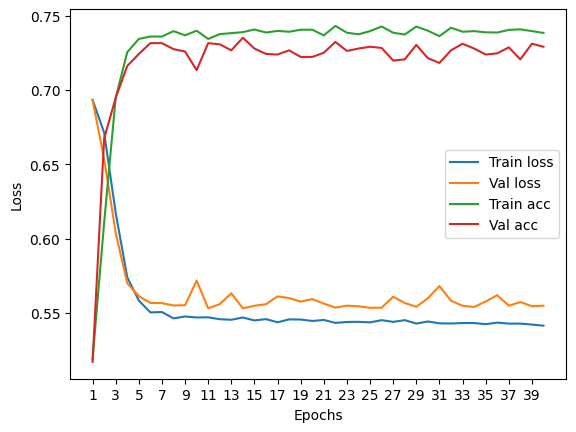

****************************************************************************************************



Particles per jet: 8


118it [00:00, 132.97it/s]


Train Epoch: 0 	Loss: 0.693866, Accuracy: 4038/7500 (54%)
Val Epoch: 0 	Loss: 0.695572, Accuracy: 1445/2500 (58%)



118it [00:00, 166.65it/s]


Train Epoch: 1 	Loss: 0.663473, Accuracy: 4630/7500 (62%)
Val Epoch: 1 	Loss: 0.640988, Accuracy: 1652/2500 (66%)



118it [00:00, 166.60it/s]


Train Epoch: 2 	Loss: 0.603958, Accuracy: 5324/7500 (71%)
Val Epoch: 2 	Loss: 0.593994, Accuracy: 1805/2500 (72%)



118it [00:00, 154.17it/s]


Train Epoch: 3 	Loss: 0.567038, Accuracy: 5496/7500 (73%)
Val Epoch: 3 	Loss: 0.558242, Accuracy: 1864/2500 (75%)



118it [00:00, 164.78it/s]


Train Epoch: 4 	Loss: 0.549293, Accuracy: 5512/7500 (73%)
Val Epoch: 4 	Loss: 0.545769, Accuracy: 1866/2500 (75%)



118it [00:01, 96.10it/s] 


Train Epoch: 5 	Loss: 0.548999, Accuracy: 5498/7500 (73%)
Val Epoch: 5 	Loss: 0.542499, Accuracy: 1861/2500 (74%)



118it [00:00, 125.87it/s]


Train Epoch: 6 	Loss: 0.542527, Accuracy: 5526/7500 (74%)
Val Epoch: 6 	Loss: 0.563279, Accuracy: 1822/2500 (73%)



118it [00:01, 104.29it/s]


Train Epoch: 7 	Loss: 0.544718, Accuracy: 5507/7500 (73%)
Val Epoch: 7 	Loss: 0.544578, Accuracy: 1861/2500 (74%)



118it [00:01, 87.98it/s]


Train Epoch: 8 	Loss: 0.544116, Accuracy: 5516/7500 (74%)
Val Epoch: 8 	Loss: 0.539717, Accuracy: 1850/2500 (74%)



118it [00:01, 106.85it/s]


Train Epoch: 9 	Loss: 0.540377, Accuracy: 5532/7500 (74%)
Val Epoch: 9 	Loss: 0.540237, Accuracy: 1845/2500 (74%)



118it [00:01, 100.64it/s]


Train Epoch: 10 	Loss: 0.537215, Accuracy: 5521/7500 (74%)
Val Epoch: 10 	Loss: 0.539952, Accuracy: 1876/2500 (75%)



118it [00:00, 120.10it/s]


Train Epoch: 11 	Loss: 0.539828, Accuracy: 5528/7500 (74%)
Val Epoch: 11 	Loss: 0.533741, Accuracy: 1871/2500 (75%)



118it [00:00, 146.12it/s]


Train Epoch: 12 	Loss: 0.541858, Accuracy: 5539/7500 (74%)
Val Epoch: 12 	Loss: 0.553471, Accuracy: 1855/2500 (74%)



118it [00:00, 161.00it/s]


Train Epoch: 13 	Loss: 0.539955, Accuracy: 5560/7500 (74%)
Val Epoch: 13 	Loss: 0.547678, Accuracy: 1853/2500 (74%)



118it [00:00, 131.81it/s]


Train Epoch: 14 	Loss: 0.542507, Accuracy: 5515/7500 (74%)
Val Epoch: 14 	Loss: 0.538572, Accuracy: 1877/2500 (75%)



118it [00:01, 117.35it/s]


Train Epoch: 15 	Loss: 0.539631, Accuracy: 5562/7500 (74%)
Val Epoch: 15 	Loss: 0.526028, Accuracy: 1879/2500 (75%)



118it [00:00, 124.11it/s]


Train Epoch: 16 	Loss: 0.543057, Accuracy: 5551/7500 (74%)
Val Epoch: 16 	Loss: 0.539442, Accuracy: 1879/2500 (75%)



118it [00:01, 105.44it/s]


Train Epoch: 17 	Loss: 0.539875, Accuracy: 5538/7500 (74%)
Val Epoch: 17 	Loss: 0.534263, Accuracy: 1874/2500 (75%)



118it [00:00, 127.33it/s]


Train Epoch: 18 	Loss: 0.539262, Accuracy: 5535/7500 (74%)
Val Epoch: 18 	Loss: 0.551834, Accuracy: 1871/2500 (75%)



118it [00:00, 156.20it/s]


Train Epoch: 19 	Loss: 0.538173, Accuracy: 5548/7500 (74%)
Val Epoch: 19 	Loss: 0.542463, Accuracy: 1887/2500 (75%)



118it [00:00, 150.23it/s]


Train Epoch: 20 	Loss: 0.541884, Accuracy: 5557/7500 (74%)
Val Epoch: 20 	Loss: 0.542645, Accuracy: 1881/2500 (75%)



118it [00:00, 143.86it/s]


Train Epoch: 21 	Loss: 0.541445, Accuracy: 5556/7500 (74%)
Val Epoch: 21 	Loss: 0.533910, Accuracy: 1874/2500 (75%)



118it [00:00, 157.01it/s]


Train Epoch: 22 	Loss: 0.539976, Accuracy: 5546/7500 (74%)
Val Epoch: 22 	Loss: 0.529767, Accuracy: 1882/2500 (75%)



118it [00:00, 143.23it/s]


Train Epoch: 23 	Loss: 0.538196, Accuracy: 5555/7500 (74%)
Val Epoch: 23 	Loss: 0.540513, Accuracy: 1881/2500 (75%)



118it [00:00, 147.70it/s]


Train Epoch: 24 	Loss: 0.537148, Accuracy: 5556/7500 (74%)
Val Epoch: 24 	Loss: 0.532519, Accuracy: 1869/2500 (75%)



118it [00:01, 112.88it/s]


Train Epoch: 25 	Loss: 0.536417, Accuracy: 5558/7500 (74%)
Val Epoch: 25 	Loss: 0.550389, Accuracy: 1870/2500 (75%)



118it [00:00, 159.50it/s]


Train Epoch: 26 	Loss: 0.539700, Accuracy: 5559/7500 (74%)
Val Epoch: 26 	Loss: 0.531278, Accuracy: 1875/2500 (75%)



118it [00:00, 164.76it/s]


Train Epoch: 27 	Loss: 0.538061, Accuracy: 5586/7500 (74%)
Val Epoch: 27 	Loss: 0.534142, Accuracy: 1881/2500 (75%)



118it [00:00, 161.49it/s]


Train Epoch: 28 	Loss: 0.540776, Accuracy: 5534/7500 (74%)
Val Epoch: 28 	Loss: 0.545907, Accuracy: 1861/2500 (74%)



118it [00:00, 183.80it/s]


Train Epoch: 29 	Loss: 0.542204, Accuracy: 5565/7500 (74%)
Val Epoch: 29 	Loss: 0.532858, Accuracy: 1866/2500 (75%)



118it [00:00, 165.59it/s]


Train Epoch: 30 	Loss: 0.537277, Accuracy: 5573/7500 (74%)
Val Epoch: 30 	Loss: 0.537495, Accuracy: 1875/2500 (75%)



118it [00:00, 153.71it/s]


Train Epoch: 31 	Loss: 0.539509, Accuracy: 5546/7500 (74%)
Val Epoch: 31 	Loss: 0.534327, Accuracy: 1881/2500 (75%)



118it [00:00, 156.50it/s]


Train Epoch: 32 	Loss: 0.539674, Accuracy: 5572/7500 (74%)
Val Epoch: 32 	Loss: 0.528954, Accuracy: 1871/2500 (75%)



118it [00:00, 160.75it/s]


Train Epoch: 33 	Loss: 0.537677, Accuracy: 5558/7500 (74%)
Val Epoch: 33 	Loss: 0.542321, Accuracy: 1881/2500 (75%)



118it [00:00, 167.64it/s]


Train Epoch: 34 	Loss: 0.537114, Accuracy: 5557/7500 (74%)
Val Epoch: 34 	Loss: 0.531268, Accuracy: 1864/2500 (75%)



118it [00:00, 145.25it/s]


Train Epoch: 35 	Loss: 0.537536, Accuracy: 5555/7500 (74%)
Val Epoch: 35 	Loss: 0.545483, Accuracy: 1846/2500 (74%)



118it [00:00, 172.68it/s]


Train Epoch: 36 	Loss: 0.541130, Accuracy: 5533/7500 (74%)
Val Epoch: 36 	Loss: 0.535592, Accuracy: 1880/2500 (75%)



118it [00:00, 160.22it/s]


Train Epoch: 37 	Loss: 0.538197, Accuracy: 5557/7500 (74%)
Val Epoch: 37 	Loss: 0.536878, Accuracy: 1872/2500 (75%)



118it [00:00, 136.37it/s]


Train Epoch: 38 	Loss: 0.536413, Accuracy: 5569/7500 (74%)
Val Epoch: 38 	Loss: 0.537273, Accuracy: 1879/2500 (75%)



118it [00:01, 106.17it/s]


Train Epoch: 39 	Loss: 0.537854, Accuracy: 5549/7500 (74%)
Val Epoch: 39 	Loss: 0.532764, Accuracy: 1880/2500 (75%)

Test accuracy:  74.44


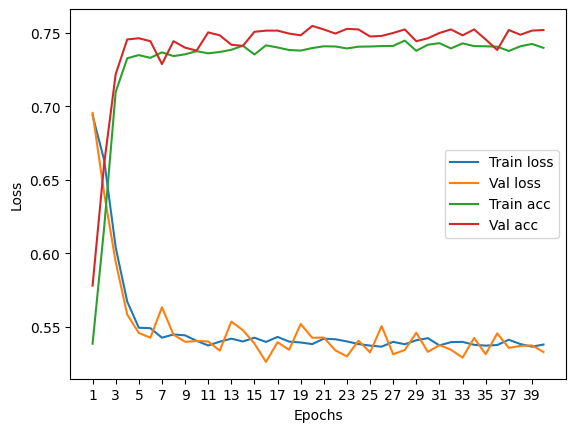

****************************************************************************************************



118it [00:01, 102.99it/s]


Train Epoch: 0 	Loss: 0.695322, Accuracy: 3965/7500 (53%)
Val Epoch: 0 	Loss: 0.703811, Accuracy: 1356/2500 (54%)



118it [00:01, 114.66it/s]


Train Epoch: 1 	Loss: 0.677021, Accuracy: 4532/7500 (60%)
Val Epoch: 1 	Loss: 0.677677, Accuracy: 1567/2500 (63%)



118it [00:00, 141.21it/s]


Train Epoch: 2 	Loss: 0.641813, Accuracy: 4962/7500 (66%)
Val Epoch: 2 	Loss: 0.628902, Accuracy: 1692/2500 (68%)



118it [00:00, 144.81it/s]


Train Epoch: 3 	Loss: 0.599816, Accuracy: 5310/7500 (71%)
Val Epoch: 3 	Loss: 0.587394, Accuracy: 1820/2500 (73%)



118it [00:01, 105.74it/s]


Train Epoch: 4 	Loss: 0.566927, Accuracy: 5516/7500 (74%)
Val Epoch: 4 	Loss: 0.577065, Accuracy: 1828/2500 (73%)



118it [00:00, 122.35it/s]


Train Epoch: 5 	Loss: 0.556876, Accuracy: 5518/7500 (74%)
Val Epoch: 5 	Loss: 0.561548, Accuracy: 1831/2500 (73%)



118it [00:00, 127.63it/s]


Train Epoch: 6 	Loss: 0.554426, Accuracy: 5513/7500 (74%)
Val Epoch: 6 	Loss: 0.569470, Accuracy: 1833/2500 (73%)



118it [00:00, 128.84it/s]


Train Epoch: 7 	Loss: 0.552000, Accuracy: 5517/7500 (74%)
Val Epoch: 7 	Loss: 0.552681, Accuracy: 1847/2500 (74%)



118it [00:01, 114.30it/s]


Train Epoch: 8 	Loss: 0.553109, Accuracy: 5546/7500 (74%)
Val Epoch: 8 	Loss: 0.551740, Accuracy: 1840/2500 (74%)



118it [00:00, 147.23it/s]


Train Epoch: 9 	Loss: 0.548912, Accuracy: 5556/7500 (74%)
Val Epoch: 9 	Loss: 0.559839, Accuracy: 1827/2500 (73%)



118it [00:01, 109.26it/s]


Train Epoch: 10 	Loss: 0.549392, Accuracy: 5529/7500 (74%)
Val Epoch: 10 	Loss: 0.553597, Accuracy: 1844/2500 (74%)



118it [00:00, 151.74it/s]


Train Epoch: 11 	Loss: 0.551665, Accuracy: 5563/7500 (74%)
Val Epoch: 11 	Loss: 0.560746, Accuracy: 1846/2500 (74%)



118it [00:00, 150.70it/s]


Train Epoch: 12 	Loss: 0.552423, Accuracy: 5562/7500 (74%)
Val Epoch: 12 	Loss: 0.558174, Accuracy: 1844/2500 (74%)



118it [00:00, 139.83it/s]


Train Epoch: 13 	Loss: 0.549075, Accuracy: 5537/7500 (74%)
Val Epoch: 13 	Loss: 0.571347, Accuracy: 1831/2500 (73%)



118it [00:01, 92.64it/s] 


Train Epoch: 14 	Loss: 0.546434, Accuracy: 5554/7500 (74%)
Val Epoch: 14 	Loss: 0.592648, Accuracy: 1800/2500 (72%)



118it [00:01, 104.64it/s]


Train Epoch: 15 	Loss: 0.550426, Accuracy: 5542/7500 (74%)
Val Epoch: 15 	Loss: 0.578354, Accuracy: 1836/2500 (73%)



118it [00:01, 79.09it/s]


Train Epoch: 16 	Loss: 0.551385, Accuracy: 5569/7500 (74%)
Val Epoch: 16 	Loss: 0.559796, Accuracy: 1820/2500 (73%)



118it [00:01, 117.90it/s]


Train Epoch: 17 	Loss: 0.547618, Accuracy: 5568/7500 (74%)
Val Epoch: 17 	Loss: 0.556198, Accuracy: 1836/2500 (73%)



118it [00:00, 130.71it/s]


Train Epoch: 18 	Loss: 0.548647, Accuracy: 5550/7500 (74%)
Val Epoch: 18 	Loss: 0.558873, Accuracy: 1848/2500 (74%)



118it [00:01, 113.32it/s]


Train Epoch: 19 	Loss: 0.548274, Accuracy: 5563/7500 (74%)
Val Epoch: 19 	Loss: 0.562173, Accuracy: 1827/2500 (73%)



118it [00:00, 124.33it/s]


Train Epoch: 20 	Loss: 0.547412, Accuracy: 5560/7500 (74%)
Val Epoch: 20 	Loss: 0.557071, Accuracy: 1843/2500 (74%)



118it [00:01, 114.09it/s]


Train Epoch: 21 	Loss: 0.548494, Accuracy: 5546/7500 (74%)
Val Epoch: 21 	Loss: 0.556191, Accuracy: 1831/2500 (73%)



118it [00:00, 149.68it/s]


Train Epoch: 22 	Loss: 0.550284, Accuracy: 5526/7500 (74%)
Val Epoch: 22 	Loss: 0.560773, Accuracy: 1828/2500 (73%)



118it [00:00, 168.44it/s]


Train Epoch: 23 	Loss: 0.549127, Accuracy: 5567/7500 (74%)
Val Epoch: 23 	Loss: 0.566494, Accuracy: 1848/2500 (74%)



118it [00:00, 173.67it/s]


Train Epoch: 24 	Loss: 0.548030, Accuracy: 5555/7500 (74%)
Val Epoch: 24 	Loss: 0.558899, Accuracy: 1824/2500 (73%)



118it [00:00, 171.31it/s]


Train Epoch: 25 	Loss: 0.547008, Accuracy: 5570/7500 (74%)
Val Epoch: 25 	Loss: 0.573510, Accuracy: 1834/2500 (73%)



118it [00:00, 124.21it/s]


Train Epoch: 26 	Loss: 0.546443, Accuracy: 5589/7500 (75%)
Val Epoch: 26 	Loss: 0.562990, Accuracy: 1830/2500 (73%)



118it [00:00, 125.96it/s]


Train Epoch: 27 	Loss: 0.550153, Accuracy: 5555/7500 (74%)
Val Epoch: 27 	Loss: 0.554540, Accuracy: 1841/2500 (74%)



118it [00:01, 111.43it/s]


Train Epoch: 28 	Loss: 0.548282, Accuracy: 5562/7500 (74%)
Val Epoch: 28 	Loss: 0.562923, Accuracy: 1843/2500 (74%)



118it [00:00, 135.70it/s]


Train Epoch: 29 	Loss: 0.548088, Accuracy: 5553/7500 (74%)
Val Epoch: 29 	Loss: 0.559482, Accuracy: 1843/2500 (74%)



118it [00:00, 146.08it/s]


Train Epoch: 30 	Loss: 0.548191, Accuracy: 5546/7500 (74%)
Val Epoch: 30 	Loss: 0.555543, Accuracy: 1845/2500 (74%)



118it [00:00, 167.50it/s]


Train Epoch: 31 	Loss: 0.546316, Accuracy: 5563/7500 (74%)
Val Epoch: 31 	Loss: 0.560526, Accuracy: 1842/2500 (74%)



118it [00:00, 161.84it/s]


Train Epoch: 32 	Loss: 0.551768, Accuracy: 5542/7500 (74%)
Val Epoch: 32 	Loss: 0.560541, Accuracy: 1838/2500 (74%)



118it [00:00, 151.43it/s]


Train Epoch: 33 	Loss: 0.549432, Accuracy: 5555/7500 (74%)
Val Epoch: 33 	Loss: 0.557832, Accuracy: 1834/2500 (73%)



118it [00:00, 150.89it/s]


Train Epoch: 34 	Loss: 0.546961, Accuracy: 5565/7500 (74%)
Val Epoch: 34 	Loss: 0.552986, Accuracy: 1843/2500 (74%)



118it [00:00, 146.91it/s]


Train Epoch: 35 	Loss: 0.548677, Accuracy: 5556/7500 (74%)
Val Epoch: 35 	Loss: 0.556046, Accuracy: 1837/2500 (73%)



118it [00:00, 137.50it/s]


Train Epoch: 36 	Loss: 0.550070, Accuracy: 5555/7500 (74%)
Val Epoch: 36 	Loss: 0.559858, Accuracy: 1842/2500 (74%)



118it [00:01, 111.29it/s]


Train Epoch: 37 	Loss: 0.549004, Accuracy: 5560/7500 (74%)
Val Epoch: 37 	Loss: 0.563525, Accuracy: 1844/2500 (74%)



118it [00:01, 110.09it/s]


Train Epoch: 38 	Loss: 0.546621, Accuracy: 5576/7500 (74%)
Val Epoch: 38 	Loss: 0.568924, Accuracy: 1845/2500 (74%)



118it [00:00, 144.06it/s]


Train Epoch: 39 	Loss: 0.548350, Accuracy: 5542/7500 (74%)
Val Epoch: 39 	Loss: 0.562361, Accuracy: 1843/2500 (74%)

Test accuracy:  72.84


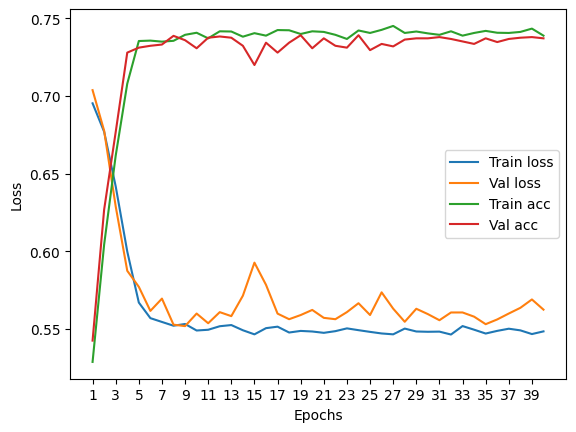

****************************************************************************************************



118it [00:00, 157.81it/s]


Train Epoch: 0 	Loss: 0.693974, Accuracy: 3998/7500 (53%)
Val Epoch: 0 	Loss: 0.696259, Accuracy: 1487/2500 (59%)



118it [00:00, 174.09it/s]


Train Epoch: 1 	Loss: 0.669568, Accuracy: 4609/7500 (61%)
Val Epoch: 1 	Loss: 0.663212, Accuracy: 1521/2500 (61%)



118it [00:00, 160.05it/s]


Train Epoch: 2 	Loss: 0.624517, Accuracy: 5162/7500 (69%)
Val Epoch: 2 	Loss: 0.601963, Accuracy: 1831/2500 (73%)



118it [00:00, 145.72it/s]


Train Epoch: 3 	Loss: 0.577214, Accuracy: 5444/7500 (73%)
Val Epoch: 3 	Loss: 0.566033, Accuracy: 1837/2500 (73%)



118it [00:00, 121.56it/s]


Train Epoch: 4 	Loss: 0.555628, Accuracy: 5548/7500 (74%)
Val Epoch: 4 	Loss: 0.546891, Accuracy: 1879/2500 (75%)



118it [00:00, 135.48it/s]


Train Epoch: 5 	Loss: 0.545125, Accuracy: 5555/7500 (74%)
Val Epoch: 5 	Loss: 0.548581, Accuracy: 1855/2500 (74%)



118it [00:01, 111.75it/s]


Train Epoch: 6 	Loss: 0.542938, Accuracy: 5572/7500 (74%)
Val Epoch: 6 	Loss: 0.531542, Accuracy: 1888/2500 (76%)



118it [00:01, 105.63it/s]


Train Epoch: 7 	Loss: 0.540401, Accuracy: 5556/7500 (74%)
Val Epoch: 7 	Loss: 0.537703, Accuracy: 1859/2500 (74%)



118it [00:00, 119.00it/s]


Train Epoch: 8 	Loss: 0.540301, Accuracy: 5571/7500 (74%)
Val Epoch: 8 	Loss: 0.535573, Accuracy: 1878/2500 (75%)



118it [00:00, 138.01it/s]


Train Epoch: 9 	Loss: 0.538742, Accuracy: 5564/7500 (74%)
Val Epoch: 9 	Loss: 0.546622, Accuracy: 1843/2500 (74%)



118it [00:00, 150.69it/s]


Train Epoch: 10 	Loss: 0.540534, Accuracy: 5549/7500 (74%)
Val Epoch: 10 	Loss: 0.540158, Accuracy: 1887/2500 (75%)



118it [00:00, 146.47it/s]


Train Epoch: 11 	Loss: 0.540868, Accuracy: 5563/7500 (74%)
Val Epoch: 11 	Loss: 0.538702, Accuracy: 1889/2500 (76%)



118it [00:00, 149.08it/s]


Train Epoch: 12 	Loss: 0.539739, Accuracy: 5586/7500 (74%)
Val Epoch: 12 	Loss: 0.541400, Accuracy: 1874/2500 (75%)



118it [00:00, 136.25it/s]


Train Epoch: 13 	Loss: 0.539205, Accuracy: 5582/7500 (74%)
Val Epoch: 13 	Loss: 0.530205, Accuracy: 1888/2500 (76%)



118it [00:00, 169.39it/s]


Train Epoch: 14 	Loss: 0.540507, Accuracy: 5564/7500 (74%)
Val Epoch: 14 	Loss: 0.532969, Accuracy: 1885/2500 (75%)



118it [00:00, 166.34it/s]


Train Epoch: 15 	Loss: 0.538594, Accuracy: 5574/7500 (74%)
Val Epoch: 15 	Loss: 0.548122, Accuracy: 1875/2500 (75%)



118it [00:00, 131.42it/s]


Train Epoch: 16 	Loss: 0.538143, Accuracy: 5583/7500 (74%)
Val Epoch: 16 	Loss: 0.530386, Accuracy: 1892/2500 (76%)



118it [00:00, 148.06it/s]


Train Epoch: 17 	Loss: 0.539629, Accuracy: 5590/7500 (75%)
Val Epoch: 17 	Loss: 0.546470, Accuracy: 1885/2500 (75%)



118it [00:00, 172.93it/s]


Train Epoch: 18 	Loss: 0.538762, Accuracy: 5575/7500 (74%)
Val Epoch: 18 	Loss: 0.529238, Accuracy: 1892/2500 (76%)



118it [00:00, 163.74it/s]


Train Epoch: 19 	Loss: 0.539872, Accuracy: 5608/7500 (75%)
Val Epoch: 19 	Loss: 0.539793, Accuracy: 1890/2500 (76%)



118it [00:00, 169.31it/s]


Train Epoch: 20 	Loss: 0.540347, Accuracy: 5569/7500 (74%)
Val Epoch: 20 	Loss: 0.548720, Accuracy: 1887/2500 (75%)



118it [00:00, 156.59it/s]


Train Epoch: 21 	Loss: 0.539390, Accuracy: 5588/7500 (75%)
Val Epoch: 21 	Loss: 0.536025, Accuracy: 1896/2500 (76%)



118it [00:00, 162.96it/s]


Train Epoch: 22 	Loss: 0.536413, Accuracy: 5588/7500 (75%)
Val Epoch: 22 	Loss: 0.536041, Accuracy: 1893/2500 (76%)



118it [00:00, 183.60it/s]


Train Epoch: 23 	Loss: 0.538911, Accuracy: 5585/7500 (74%)
Val Epoch: 23 	Loss: 0.539163, Accuracy: 1885/2500 (75%)



118it [00:00, 165.38it/s]


Train Epoch: 24 	Loss: 0.541607, Accuracy: 5581/7500 (74%)
Val Epoch: 24 	Loss: 0.542454, Accuracy: 1867/2500 (75%)



118it [00:00, 170.45it/s]


Train Epoch: 25 	Loss: 0.538786, Accuracy: 5581/7500 (74%)
Val Epoch: 25 	Loss: 0.532853, Accuracy: 1890/2500 (76%)



118it [00:00, 145.67it/s]


Train Epoch: 26 	Loss: 0.537904, Accuracy: 5583/7500 (74%)
Val Epoch: 26 	Loss: 0.529346, Accuracy: 1884/2500 (75%)



118it [00:00, 161.59it/s]


Train Epoch: 27 	Loss: 0.537236, Accuracy: 5593/7500 (75%)
Val Epoch: 27 	Loss: 0.530837, Accuracy: 1885/2500 (75%)



118it [00:00, 174.17it/s]


Train Epoch: 28 	Loss: 0.538097, Accuracy: 5583/7500 (74%)
Val Epoch: 28 	Loss: 0.541538, Accuracy: 1887/2500 (75%)



118it [00:00, 169.52it/s]


Train Epoch: 29 	Loss: 0.537825, Accuracy: 5595/7500 (75%)
Val Epoch: 29 	Loss: 0.532591, Accuracy: 1885/2500 (75%)



118it [00:00, 159.70it/s]


Train Epoch: 30 	Loss: 0.539184, Accuracy: 5586/7500 (74%)
Val Epoch: 30 	Loss: 0.550119, Accuracy: 1902/2500 (76%)



118it [00:00, 141.81it/s]


Train Epoch: 31 	Loss: 0.540291, Accuracy: 5584/7500 (74%)
Val Epoch: 31 	Loss: 0.540757, Accuracy: 1882/2500 (75%)



118it [00:01, 112.33it/s]


Train Epoch: 32 	Loss: 0.537569, Accuracy: 5602/7500 (75%)
Val Epoch: 32 	Loss: 0.532639, Accuracy: 1889/2500 (76%)



118it [00:00, 145.15it/s]


Train Epoch: 33 	Loss: 0.539118, Accuracy: 5573/7500 (74%)
Val Epoch: 33 	Loss: 0.540615, Accuracy: 1868/2500 (75%)



118it [00:01, 116.64it/s]


Train Epoch: 34 	Loss: 0.536760, Accuracy: 5614/7500 (75%)
Val Epoch: 34 	Loss: 0.541584, Accuracy: 1862/2500 (74%)



118it [00:01, 111.05it/s]


Train Epoch: 35 	Loss: 0.537861, Accuracy: 5607/7500 (75%)
Val Epoch: 35 	Loss: 0.538306, Accuracy: 1883/2500 (75%)



118it [00:00, 118.27it/s]


Train Epoch: 36 	Loss: 0.538074, Accuracy: 5599/7500 (75%)
Val Epoch: 36 	Loss: 0.557038, Accuracy: 1872/2500 (75%)



118it [00:00, 147.47it/s]


Train Epoch: 37 	Loss: 0.539584, Accuracy: 5609/7500 (75%)
Val Epoch: 37 	Loss: 0.539468, Accuracy: 1892/2500 (76%)



118it [00:00, 154.32it/s]


Train Epoch: 38 	Loss: 0.537713, Accuracy: 5596/7500 (75%)
Val Epoch: 38 	Loss: 0.549040, Accuracy: 1858/2500 (74%)



118it [00:00, 157.65it/s]


Train Epoch: 39 	Loss: 0.538243, Accuracy: 5563/7500 (74%)
Val Epoch: 39 	Loss: 0.533422, Accuracy: 1902/2500 (76%)

Test accuracy:  74.92


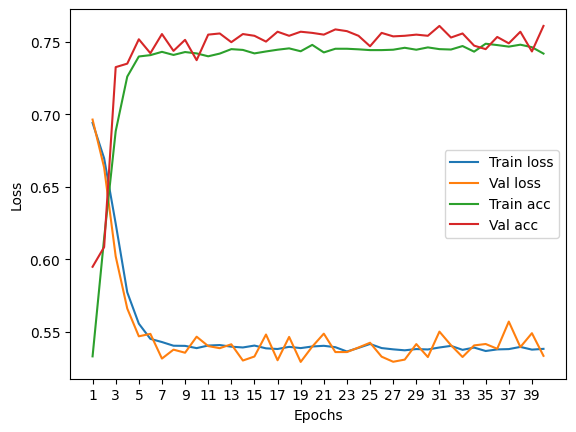

****************************************************************************************************



118it [00:00, 171.95it/s]


Train Epoch: 0 	Loss: 0.691489, Accuracy: 4087/7500 (54%)
Val Epoch: 0 	Loss: 0.701593, Accuracy: 1331/2500 (53%)



118it [00:00, 137.51it/s]


Train Epoch: 1 	Loss: 0.677452, Accuracy: 4358/7500 (58%)
Val Epoch: 1 	Loss: 0.676380, Accuracy: 1506/2500 (60%)



118it [00:00, 130.91it/s]


Train Epoch: 2 	Loss: 0.659606, Accuracy: 4696/7500 (63%)
Val Epoch: 2 	Loss: 0.654600, Accuracy: 1628/2500 (65%)



118it [00:00, 121.14it/s]


Train Epoch: 3 	Loss: 0.638707, Accuracy: 4951/7500 (66%)
Val Epoch: 3 	Loss: 0.638805, Accuracy: 1672/2500 (67%)



118it [00:00, 160.80it/s]


Train Epoch: 4 	Loss: 0.613897, Accuracy: 5185/7500 (69%)
Val Epoch: 4 	Loss: 0.606159, Accuracy: 1748/2500 (70%)



118it [00:00, 180.41it/s]


Train Epoch: 5 	Loss: 0.596013, Accuracy: 5256/7500 (70%)
Val Epoch: 5 	Loss: 0.602282, Accuracy: 1765/2500 (71%)



118it [00:00, 143.57it/s]


Train Epoch: 6 	Loss: 0.582289, Accuracy: 5392/7500 (72%)
Val Epoch: 6 	Loss: 0.611421, Accuracy: 1695/2500 (68%)



118it [00:00, 153.66it/s]


Train Epoch: 7 	Loss: 0.574429, Accuracy: 5362/7500 (71%)
Val Epoch: 7 	Loss: 0.583690, Accuracy: 1783/2500 (71%)



118it [00:00, 142.08it/s]


Train Epoch: 8 	Loss: 0.574425, Accuracy: 5328/7500 (71%)
Val Epoch: 8 	Loss: 0.590237, Accuracy: 1773/2500 (71%)



118it [00:01, 116.50it/s]


Train Epoch: 9 	Loss: 0.567158, Accuracy: 5381/7500 (72%)
Val Epoch: 9 	Loss: 0.586876, Accuracy: 1767/2500 (71%)



118it [00:00, 147.32it/s]


Train Epoch: 10 	Loss: 0.566401, Accuracy: 5385/7500 (72%)
Val Epoch: 10 	Loss: 0.569188, Accuracy: 1783/2500 (71%)



118it [00:00, 170.48it/s]


Train Epoch: 11 	Loss: 0.562588, Accuracy: 5402/7500 (72%)
Val Epoch: 11 	Loss: 0.597240, Accuracy: 1752/2500 (70%)



118it [00:00, 164.78it/s]


Train Epoch: 12 	Loss: 0.564843, Accuracy: 5378/7500 (72%)
Val Epoch: 12 	Loss: 0.584788, Accuracy: 1766/2500 (71%)



118it [00:00, 157.44it/s]


Train Epoch: 13 	Loss: 0.561733, Accuracy: 5392/7500 (72%)
Val Epoch: 13 	Loss: 0.578781, Accuracy: 1795/2500 (72%)



118it [00:00, 154.13it/s]


Train Epoch: 14 	Loss: 0.562036, Accuracy: 5387/7500 (72%)
Val Epoch: 14 	Loss: 0.576834, Accuracy: 1769/2500 (71%)



118it [00:00, 157.71it/s]


Train Epoch: 15 	Loss: 0.562771, Accuracy: 5392/7500 (72%)
Val Epoch: 15 	Loss: 0.570031, Accuracy: 1784/2500 (71%)



118it [00:00, 167.69it/s]


Train Epoch: 16 	Loss: 0.563259, Accuracy: 5398/7500 (72%)
Val Epoch: 16 	Loss: 0.577902, Accuracy: 1775/2500 (71%)



118it [00:00, 171.14it/s]


Train Epoch: 17 	Loss: 0.560801, Accuracy: 5376/7500 (72%)
Val Epoch: 17 	Loss: 0.575753, Accuracy: 1779/2500 (71%)



118it [00:00, 139.02it/s]


Train Epoch: 18 	Loss: 0.565719, Accuracy: 5377/7500 (72%)
Val Epoch: 18 	Loss: 0.573089, Accuracy: 1779/2500 (71%)



118it [00:00, 133.17it/s]


Train Epoch: 19 	Loss: 0.559963, Accuracy: 5406/7500 (72%)
Val Epoch: 19 	Loss: 0.579085, Accuracy: 1786/2500 (71%)



118it [00:00, 146.53it/s]


Train Epoch: 20 	Loss: 0.559787, Accuracy: 5418/7500 (72%)
Val Epoch: 20 	Loss: 0.575830, Accuracy: 1776/2500 (71%)



118it [00:00, 155.69it/s]


Train Epoch: 21 	Loss: 0.559400, Accuracy: 5392/7500 (72%)
Val Epoch: 21 	Loss: 0.568371, Accuracy: 1799/2500 (72%)



118it [00:00, 165.00it/s]


Train Epoch: 22 	Loss: 0.563230, Accuracy: 5406/7500 (72%)
Val Epoch: 22 	Loss: 0.573803, Accuracy: 1807/2500 (72%)



118it [00:00, 161.61it/s]


Train Epoch: 23 	Loss: 0.557371, Accuracy: 5430/7500 (72%)
Val Epoch: 23 	Loss: 0.574871, Accuracy: 1803/2500 (72%)



118it [00:00, 155.23it/s]


Train Epoch: 24 	Loss: 0.560548, Accuracy: 5398/7500 (72%)
Val Epoch: 24 	Loss: 0.581468, Accuracy: 1768/2500 (71%)



118it [00:00, 149.96it/s]


Train Epoch: 25 	Loss: 0.556117, Accuracy: 5446/7500 (73%)
Val Epoch: 25 	Loss: 0.567949, Accuracy: 1798/2500 (72%)



118it [00:00, 139.24it/s]


Train Epoch: 26 	Loss: 0.559232, Accuracy: 5426/7500 (72%)
Val Epoch: 26 	Loss: 0.562765, Accuracy: 1791/2500 (72%)



118it [00:00, 140.19it/s]


Train Epoch: 27 	Loss: 0.554550, Accuracy: 5447/7500 (73%)
Val Epoch: 27 	Loss: 0.573428, Accuracy: 1820/2500 (73%)



118it [00:00, 153.54it/s]


Train Epoch: 28 	Loss: 0.555321, Accuracy: 5462/7500 (73%)
Val Epoch: 28 	Loss: 0.617507, Accuracy: 1778/2500 (71%)



118it [00:00, 121.33it/s]


Train Epoch: 29 	Loss: 0.555105, Accuracy: 5451/7500 (73%)
Val Epoch: 29 	Loss: 0.569064, Accuracy: 1820/2500 (73%)



118it [00:00, 149.69it/s]


Train Epoch: 30 	Loss: 0.552891, Accuracy: 5496/7500 (73%)
Val Epoch: 30 	Loss: 0.569754, Accuracy: 1835/2500 (73%)



118it [00:00, 119.24it/s]


Train Epoch: 31 	Loss: 0.550985, Accuracy: 5478/7500 (73%)
Val Epoch: 31 	Loss: 0.564660, Accuracy: 1837/2500 (73%)



118it [00:00, 150.39it/s]


Train Epoch: 32 	Loss: 0.552381, Accuracy: 5475/7500 (73%)
Val Epoch: 32 	Loss: 0.588938, Accuracy: 1815/2500 (73%)



118it [00:00, 164.05it/s]


Train Epoch: 33 	Loss: 0.546735, Accuracy: 5510/7500 (73%)
Val Epoch: 33 	Loss: 0.564207, Accuracy: 1842/2500 (74%)



118it [00:00, 142.90it/s]


Train Epoch: 34 	Loss: 0.546426, Accuracy: 5505/7500 (73%)
Val Epoch: 34 	Loss: 0.569559, Accuracy: 1849/2500 (74%)



118it [00:00, 142.98it/s]


Train Epoch: 35 	Loss: 0.543923, Accuracy: 5551/7500 (74%)
Val Epoch: 35 	Loss: 0.553387, Accuracy: 1848/2500 (74%)



118it [00:00, 156.16it/s]


Train Epoch: 36 	Loss: 0.541689, Accuracy: 5545/7500 (74%)
Val Epoch: 36 	Loss: 0.588147, Accuracy: 1775/2500 (71%)



118it [00:00, 128.37it/s]


Train Epoch: 37 	Loss: 0.544401, Accuracy: 5504/7500 (73%)
Val Epoch: 37 	Loss: 0.558363, Accuracy: 1833/2500 (73%)



118it [00:00, 163.55it/s]


Train Epoch: 38 	Loss: 0.541518, Accuracy: 5535/7500 (74%)
Val Epoch: 38 	Loss: 0.557240, Accuracy: 1839/2500 (74%)



118it [00:00, 157.07it/s]


Train Epoch: 39 	Loss: 0.540451, Accuracy: 5559/7500 (74%)
Val Epoch: 39 	Loss: 0.566169, Accuracy: 1828/2500 (73%)

Test accuracy:  73.48


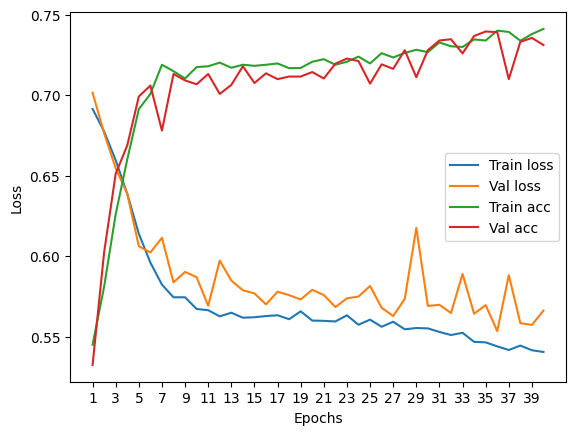

****************************************************************************************************



118it [00:00, 167.59it/s]


Train Epoch: 0 	Loss: 0.696735, Accuracy: 4004/7500 (53%)
Val Epoch: 0 	Loss: 0.707094, Accuracy: 1301/2500 (52%)



118it [00:00, 149.67it/s]


Train Epoch: 1 	Loss: 0.688217, Accuracy: 4271/7500 (57%)
Val Epoch: 1 	Loss: 0.694091, Accuracy: 1406/2500 (56%)



118it [00:00, 141.27it/s]


Train Epoch: 2 	Loss: 0.671827, Accuracy: 4540/7500 (61%)
Val Epoch: 2 	Loss: 0.675288, Accuracy: 1521/2500 (61%)



118it [00:00, 133.28it/s]


Train Epoch: 3 	Loss: 0.648420, Accuracy: 4797/7500 (64%)
Val Epoch: 3 	Loss: 0.644035, Accuracy: 1691/2500 (68%)



118it [00:00, 159.58it/s]


Train Epoch: 4 	Loss: 0.629549, Accuracy: 5029/7500 (67%)
Val Epoch: 4 	Loss: 0.624154, Accuracy: 1757/2500 (70%)



118it [00:00, 158.03it/s]


Train Epoch: 5 	Loss: 0.613520, Accuracy: 5121/7500 (68%)
Val Epoch: 5 	Loss: 0.605305, Accuracy: 1771/2500 (71%)



118it [00:00, 157.80it/s]


Train Epoch: 6 	Loss: 0.601234, Accuracy: 5183/7500 (69%)
Val Epoch: 6 	Loss: 0.598637, Accuracy: 1749/2500 (70%)



118it [00:00, 160.12it/s]


Train Epoch: 7 	Loss: 0.593521, Accuracy: 5236/7500 (70%)
Val Epoch: 7 	Loss: 0.585932, Accuracy: 1783/2500 (71%)



118it [00:00, 144.42it/s]


Train Epoch: 8 	Loss: 0.585525, Accuracy: 5297/7500 (71%)
Val Epoch: 8 	Loss: 0.583542, Accuracy: 1790/2500 (72%)



118it [00:00, 170.82it/s]


Train Epoch: 9 	Loss: 0.580394, Accuracy: 5308/7500 (71%)
Val Epoch: 9 	Loss: 0.583767, Accuracy: 1790/2500 (72%)



118it [00:00, 144.52it/s]


Train Epoch: 10 	Loss: 0.580490, Accuracy: 5291/7500 (71%)
Val Epoch: 10 	Loss: 0.576169, Accuracy: 1800/2500 (72%)



118it [00:00, 119.53it/s]


Train Epoch: 11 	Loss: 0.575367, Accuracy: 5331/7500 (71%)
Val Epoch: 11 	Loss: 0.573872, Accuracy: 1793/2500 (72%)



118it [00:00, 135.69it/s]


Train Epoch: 12 	Loss: 0.576286, Accuracy: 5318/7500 (71%)
Val Epoch: 12 	Loss: 0.573508, Accuracy: 1802/2500 (72%)



118it [00:00, 150.68it/s]


Train Epoch: 13 	Loss: 0.571840, Accuracy: 5320/7500 (71%)
Val Epoch: 13 	Loss: 0.573700, Accuracy: 1799/2500 (72%)



118it [00:00, 147.42it/s]


Train Epoch: 14 	Loss: 0.572496, Accuracy: 5326/7500 (71%)
Val Epoch: 14 	Loss: 0.561002, Accuracy: 1800/2500 (72%)



118it [00:00, 155.95it/s]


Train Epoch: 15 	Loss: 0.572118, Accuracy: 5333/7500 (71%)
Val Epoch: 15 	Loss: 0.572532, Accuracy: 1782/2500 (71%)



118it [00:00, 119.95it/s]


Train Epoch: 16 	Loss: 0.572075, Accuracy: 5353/7500 (71%)
Val Epoch: 16 	Loss: 0.566172, Accuracy: 1809/2500 (72%)



118it [00:00, 148.24it/s]


Train Epoch: 17 	Loss: 0.570711, Accuracy: 5328/7500 (71%)
Val Epoch: 17 	Loss: 0.565814, Accuracy: 1811/2500 (72%)



118it [00:00, 146.40it/s]


Train Epoch: 18 	Loss: 0.569822, Accuracy: 5338/7500 (71%)
Val Epoch: 18 	Loss: 0.568286, Accuracy: 1806/2500 (72%)



118it [00:00, 129.10it/s]


Train Epoch: 19 	Loss: 0.568169, Accuracy: 5375/7500 (72%)
Val Epoch: 19 	Loss: 0.560719, Accuracy: 1814/2500 (73%)



118it [00:00, 142.22it/s]


Train Epoch: 20 	Loss: 0.569950, Accuracy: 5376/7500 (72%)
Val Epoch: 20 	Loss: 0.565478, Accuracy: 1809/2500 (72%)



118it [00:00, 154.90it/s]


Train Epoch: 21 	Loss: 0.567657, Accuracy: 5355/7500 (71%)
Val Epoch: 21 	Loss: 0.561898, Accuracy: 1822/2500 (73%)



118it [00:00, 155.82it/s]


Train Epoch: 22 	Loss: 0.564022, Accuracy: 5381/7500 (72%)
Val Epoch: 22 	Loss: 0.562267, Accuracy: 1801/2500 (72%)



118it [00:00, 155.15it/s]


Train Epoch: 23 	Loss: 0.564730, Accuracy: 5402/7500 (72%)
Val Epoch: 23 	Loss: 0.572510, Accuracy: 1789/2500 (72%)



118it [00:00, 150.14it/s]


Train Epoch: 24 	Loss: 0.565261, Accuracy: 5397/7500 (72%)
Val Epoch: 24 	Loss: 0.565395, Accuracy: 1839/2500 (74%)



118it [00:00, 156.19it/s]


Train Epoch: 25 	Loss: 0.564455, Accuracy: 5411/7500 (72%)
Val Epoch: 25 	Loss: 0.559264, Accuracy: 1844/2500 (74%)



118it [00:00, 155.26it/s]


Train Epoch: 26 	Loss: 0.561280, Accuracy: 5391/7500 (72%)
Val Epoch: 26 	Loss: 0.563574, Accuracy: 1827/2500 (73%)



118it [00:00, 145.96it/s]


Train Epoch: 27 	Loss: 0.560947, Accuracy: 5437/7500 (72%)
Val Epoch: 27 	Loss: 0.555599, Accuracy: 1838/2500 (74%)



118it [00:00, 155.94it/s]


Train Epoch: 28 	Loss: 0.561207, Accuracy: 5403/7500 (72%)
Val Epoch: 28 	Loss: 0.551350, Accuracy: 1838/2500 (74%)



118it [00:00, 144.03it/s]


Train Epoch: 29 	Loss: 0.555921, Accuracy: 5463/7500 (73%)
Val Epoch: 29 	Loss: 0.548220, Accuracy: 1851/2500 (74%)



118it [00:00, 168.45it/s]


Train Epoch: 30 	Loss: 0.556105, Accuracy: 5466/7500 (73%)
Val Epoch: 30 	Loss: 0.564555, Accuracy: 1834/2500 (73%)



118it [00:00, 149.27it/s]


Train Epoch: 31 	Loss: 0.557286, Accuracy: 5471/7500 (73%)
Val Epoch: 31 	Loss: 0.543668, Accuracy: 1845/2500 (74%)



118it [00:01, 113.20it/s]


Train Epoch: 32 	Loss: 0.560244, Accuracy: 5434/7500 (72%)
Val Epoch: 32 	Loss: 0.549602, Accuracy: 1846/2500 (74%)



118it [00:00, 140.82it/s]


Train Epoch: 33 	Loss: 0.551548, Accuracy: 5497/7500 (73%)
Val Epoch: 33 	Loss: 0.573397, Accuracy: 1833/2500 (73%)



118it [00:00, 151.08it/s]


Train Epoch: 34 	Loss: 0.552505, Accuracy: 5524/7500 (74%)
Val Epoch: 34 	Loss: 0.546855, Accuracy: 1855/2500 (74%)



118it [00:00, 164.97it/s]


Train Epoch: 35 	Loss: 0.551886, Accuracy: 5487/7500 (73%)
Val Epoch: 35 	Loss: 0.547575, Accuracy: 1840/2500 (74%)



118it [00:00, 149.66it/s]


Train Epoch: 36 	Loss: 0.552120, Accuracy: 5482/7500 (73%)
Val Epoch: 36 	Loss: 0.542696, Accuracy: 1846/2500 (74%)



118it [00:00, 133.40it/s]


Train Epoch: 37 	Loss: 0.549777, Accuracy: 5497/7500 (73%)
Val Epoch: 37 	Loss: 0.559964, Accuracy: 1856/2500 (74%)



118it [00:00, 143.64it/s]


Train Epoch: 38 	Loss: 0.548983, Accuracy: 5524/7500 (74%)
Val Epoch: 38 	Loss: 0.569043, Accuracy: 1834/2500 (73%)



118it [00:00, 154.04it/s]


Train Epoch: 39 	Loss: 0.549285, Accuracy: 5484/7500 (73%)
Val Epoch: 39 	Loss: 0.556903, Accuracy: 1845/2500 (74%)

Test accuracy:  74.03999999999999


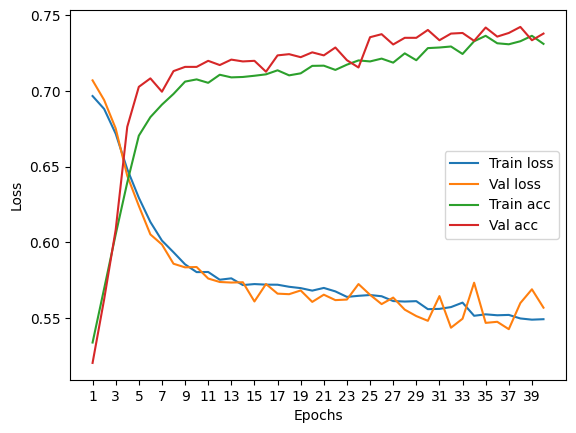

****************************************************************************************************



118it [00:00, 136.80it/s]


Train Epoch: 0 	Loss: 0.695430, Accuracy: 3940/7500 (53%)
Val Epoch: 0 	Loss: 0.702198, Accuracy: 1363/2500 (55%)



118it [00:00, 148.65it/s]


Train Epoch: 1 	Loss: 0.677069, Accuracy: 4521/7500 (60%)
Val Epoch: 1 	Loss: 0.679776, Accuracy: 1502/2500 (60%)



118it [00:00, 128.74it/s]


Train Epoch: 2 	Loss: 0.646873, Accuracy: 4836/7500 (64%)
Val Epoch: 2 	Loss: 0.645008, Accuracy: 1696/2500 (68%)



118it [00:00, 119.78it/s]


Train Epoch: 3 	Loss: 0.609469, Accuracy: 5253/7500 (70%)
Val Epoch: 3 	Loss: 0.601966, Accuracy: 1804/2500 (72%)



118it [00:00, 143.27it/s]


Train Epoch: 4 	Loss: 0.579360, Accuracy: 5411/7500 (72%)
Val Epoch: 4 	Loss: 0.601714, Accuracy: 1732/2500 (69%)



118it [00:00, 163.12it/s]


Train Epoch: 5 	Loss: 0.564221, Accuracy: 5460/7500 (73%)
Val Epoch: 5 	Loss: 0.576872, Accuracy: 1817/2500 (73%)



118it [00:00, 151.23it/s]


Train Epoch: 6 	Loss: 0.555209, Accuracy: 5540/7500 (74%)
Val Epoch: 6 	Loss: 0.569856, Accuracy: 1827/2500 (73%)



118it [00:00, 122.86it/s]


Train Epoch: 7 	Loss: 0.550404, Accuracy: 5531/7500 (74%)
Val Epoch: 7 	Loss: 0.556097, Accuracy: 1833/2500 (73%)



118it [00:00, 171.44it/s]


Train Epoch: 8 	Loss: 0.548458, Accuracy: 5563/7500 (74%)
Val Epoch: 8 	Loss: 0.563857, Accuracy: 1840/2500 (74%)



118it [00:00, 177.18it/s]


Train Epoch: 9 	Loss: 0.549731, Accuracy: 5524/7500 (74%)
Val Epoch: 9 	Loss: 0.562099, Accuracy: 1842/2500 (74%)



118it [00:00, 161.86it/s]


Train Epoch: 10 	Loss: 0.549794, Accuracy: 5546/7500 (74%)
Val Epoch: 10 	Loss: 0.564824, Accuracy: 1834/2500 (73%)



118it [00:00, 141.60it/s]


Train Epoch: 11 	Loss: 0.547058, Accuracy: 5548/7500 (74%)
Val Epoch: 11 	Loss: 0.560203, Accuracy: 1831/2500 (73%)



118it [00:00, 153.99it/s]


Train Epoch: 12 	Loss: 0.547133, Accuracy: 5522/7500 (74%)
Val Epoch: 12 	Loss: 0.558230, Accuracy: 1813/2500 (73%)



118it [00:00, 165.11it/s]


Train Epoch: 13 	Loss: 0.544583, Accuracy: 5557/7500 (74%)
Val Epoch: 13 	Loss: 0.569881, Accuracy: 1836/2500 (73%)



118it [00:00, 170.99it/s]


Train Epoch: 14 	Loss: 0.548710, Accuracy: 5558/7500 (74%)
Val Epoch: 14 	Loss: 0.563766, Accuracy: 1813/2500 (73%)



118it [00:00, 176.23it/s]


Train Epoch: 15 	Loss: 0.550740, Accuracy: 5497/7500 (73%)
Val Epoch: 15 	Loss: 0.557412, Accuracy: 1841/2500 (74%)



118it [00:00, 176.65it/s]


Train Epoch: 16 	Loss: 0.546967, Accuracy: 5552/7500 (74%)
Val Epoch: 16 	Loss: 0.558507, Accuracy: 1835/2500 (73%)



118it [00:00, 150.43it/s]


Train Epoch: 17 	Loss: 0.545513, Accuracy: 5524/7500 (74%)
Val Epoch: 17 	Loss: 0.556443, Accuracy: 1834/2500 (73%)



118it [00:00, 168.27it/s]


Train Epoch: 18 	Loss: 0.548731, Accuracy: 5533/7500 (74%)
Val Epoch: 18 	Loss: 0.567690, Accuracy: 1820/2500 (73%)



118it [00:00, 170.59it/s]


Train Epoch: 19 	Loss: 0.548189, Accuracy: 5552/7500 (74%)
Val Epoch: 19 	Loss: 0.573237, Accuracy: 1833/2500 (73%)



118it [00:00, 161.87it/s]


Train Epoch: 20 	Loss: 0.546298, Accuracy: 5553/7500 (74%)
Val Epoch: 20 	Loss: 0.552042, Accuracy: 1837/2500 (73%)



118it [00:00, 148.51it/s]


Train Epoch: 21 	Loss: 0.549072, Accuracy: 5523/7500 (74%)
Val Epoch: 21 	Loss: 0.560955, Accuracy: 1823/2500 (73%)



118it [00:00, 163.79it/s]


Train Epoch: 22 	Loss: 0.545060, Accuracy: 5553/7500 (74%)
Val Epoch: 22 	Loss: 0.563230, Accuracy: 1834/2500 (73%)



118it [00:00, 157.69it/s]


Train Epoch: 23 	Loss: 0.545046, Accuracy: 5539/7500 (74%)
Val Epoch: 23 	Loss: 0.562917, Accuracy: 1851/2500 (74%)



118it [00:00, 148.22it/s]


Train Epoch: 24 	Loss: 0.546002, Accuracy: 5531/7500 (74%)
Val Epoch: 24 	Loss: 0.561895, Accuracy: 1845/2500 (74%)



118it [00:00, 150.88it/s]


Train Epoch: 25 	Loss: 0.545476, Accuracy: 5555/7500 (74%)
Val Epoch: 25 	Loss: 0.571463, Accuracy: 1826/2500 (73%)



118it [00:00, 146.58it/s]


Train Epoch: 26 	Loss: 0.544215, Accuracy: 5566/7500 (74%)
Val Epoch: 26 	Loss: 0.559017, Accuracy: 1817/2500 (73%)



118it [00:00, 147.07it/s]


Train Epoch: 27 	Loss: 0.545320, Accuracy: 5535/7500 (74%)
Val Epoch: 27 	Loss: 0.556889, Accuracy: 1849/2500 (74%)



118it [00:00, 148.70it/s]


Train Epoch: 28 	Loss: 0.543354, Accuracy: 5570/7500 (74%)
Val Epoch: 28 	Loss: 0.562174, Accuracy: 1820/2500 (73%)



118it [00:01, 115.68it/s]


Train Epoch: 29 	Loss: 0.546407, Accuracy: 5578/7500 (74%)
Val Epoch: 29 	Loss: 0.561376, Accuracy: 1835/2500 (73%)



118it [00:00, 156.03it/s]


Train Epoch: 30 	Loss: 0.547264, Accuracy: 5568/7500 (74%)
Val Epoch: 30 	Loss: 0.562930, Accuracy: 1842/2500 (74%)



118it [00:00, 134.29it/s]


Train Epoch: 31 	Loss: 0.546575, Accuracy: 5573/7500 (74%)
Val Epoch: 31 	Loss: 0.558640, Accuracy: 1844/2500 (74%)



118it [00:00, 179.00it/s]


Train Epoch: 32 	Loss: 0.544551, Accuracy: 5577/7500 (74%)
Val Epoch: 32 	Loss: 0.557897, Accuracy: 1841/2500 (74%)



118it [00:00, 153.87it/s]


Train Epoch: 33 	Loss: 0.547354, Accuracy: 5555/7500 (74%)
Val Epoch: 33 	Loss: 0.556693, Accuracy: 1840/2500 (74%)



118it [00:00, 156.90it/s]


Train Epoch: 34 	Loss: 0.547394, Accuracy: 5572/7500 (74%)
Val Epoch: 34 	Loss: 0.556885, Accuracy: 1849/2500 (74%)



118it [00:00, 139.01it/s]


Train Epoch: 35 	Loss: 0.545607, Accuracy: 5533/7500 (74%)
Val Epoch: 35 	Loss: 0.556800, Accuracy: 1827/2500 (73%)



118it [00:00, 120.63it/s]


Train Epoch: 36 	Loss: 0.546993, Accuracy: 5570/7500 (74%)
Val Epoch: 36 	Loss: 0.559185, Accuracy: 1833/2500 (73%)



118it [00:00, 143.45it/s]


Train Epoch: 37 	Loss: 0.544681, Accuracy: 5555/7500 (74%)
Val Epoch: 37 	Loss: 0.576741, Accuracy: 1827/2500 (73%)



118it [00:00, 156.30it/s]


Train Epoch: 38 	Loss: 0.543207, Accuracy: 5572/7500 (74%)
Val Epoch: 38 	Loss: 0.554201, Accuracy: 1835/2500 (73%)



118it [00:00, 158.93it/s]


Train Epoch: 39 	Loss: 0.543023, Accuracy: 5585/7500 (74%)
Val Epoch: 39 	Loss: 0.552944, Accuracy: 1843/2500 (74%)

Test accuracy:  72.92


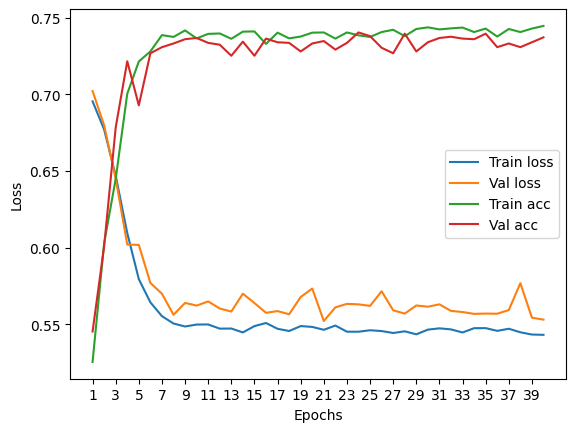

****************************************************************************************************



118it [00:00, 181.92it/s]


Train Epoch: 0 	Loss: 0.695917, Accuracy: 4002/7500 (53%)
Val Epoch: 0 	Loss: 0.703706, Accuracy: 1320/2500 (53%)



118it [00:00, 169.95it/s]


Train Epoch: 1 	Loss: 0.682231, Accuracy: 4433/7500 (59%)
Val Epoch: 1 	Loss: 0.680010, Accuracy: 1524/2500 (61%)



118it [00:00, 172.30it/s]


Train Epoch: 2 	Loss: 0.652040, Accuracy: 4800/7500 (64%)
Val Epoch: 2 	Loss: 0.655223, Accuracy: 1677/2500 (67%)



118it [00:00, 180.92it/s]


Train Epoch: 3 	Loss: 0.620704, Accuracy: 5160/7500 (69%)
Val Epoch: 3 	Loss: 0.616856, Accuracy: 1768/2500 (71%)



118it [00:00, 178.77it/s]


Train Epoch: 4 	Loss: 0.591562, Accuracy: 5324/7500 (71%)
Val Epoch: 4 	Loss: 0.600706, Accuracy: 1765/2500 (71%)



118it [00:00, 173.89it/s]


Train Epoch: 5 	Loss: 0.570551, Accuracy: 5454/7500 (73%)
Val Epoch: 5 	Loss: 0.574460, Accuracy: 1808/2500 (72%)



118it [00:00, 149.53it/s]


Train Epoch: 6 	Loss: 0.560538, Accuracy: 5483/7500 (73%)
Val Epoch: 6 	Loss: 0.584238, Accuracy: 1788/2500 (72%)



118it [00:00, 166.98it/s]


Train Epoch: 7 	Loss: 0.552172, Accuracy: 5556/7500 (74%)
Val Epoch: 7 	Loss: 0.580650, Accuracy: 1784/2500 (71%)



118it [00:00, 170.93it/s]


Train Epoch: 8 	Loss: 0.547370, Accuracy: 5563/7500 (74%)
Val Epoch: 8 	Loss: 0.576827, Accuracy: 1815/2500 (73%)



118it [00:00, 181.93it/s]


Train Epoch: 9 	Loss: 0.547750, Accuracy: 5572/7500 (74%)
Val Epoch: 9 	Loss: 0.568507, Accuracy: 1823/2500 (73%)



118it [00:00, 159.33it/s]


Train Epoch: 10 	Loss: 0.545407, Accuracy: 5551/7500 (74%)
Val Epoch: 10 	Loss: 0.567811, Accuracy: 1816/2500 (73%)



118it [00:00, 175.96it/s]


Train Epoch: 11 	Loss: 0.545574, Accuracy: 5580/7500 (74%)
Val Epoch: 11 	Loss: 0.585430, Accuracy: 1829/2500 (73%)



118it [00:00, 168.82it/s]


Train Epoch: 12 	Loss: 0.547038, Accuracy: 5582/7500 (74%)
Val Epoch: 12 	Loss: 0.571322, Accuracy: 1819/2500 (73%)



118it [00:00, 164.08it/s]


Train Epoch: 13 	Loss: 0.543900, Accuracy: 5568/7500 (74%)
Val Epoch: 13 	Loss: 0.573601, Accuracy: 1823/2500 (73%)



118it [00:00, 175.17it/s]


Train Epoch: 14 	Loss: 0.543394, Accuracy: 5586/7500 (74%)
Val Epoch: 14 	Loss: 0.566181, Accuracy: 1804/2500 (72%)



118it [00:00, 152.58it/s]


Train Epoch: 15 	Loss: 0.545310, Accuracy: 5546/7500 (74%)
Val Epoch: 15 	Loss: 0.560794, Accuracy: 1823/2500 (73%)



118it [00:00, 156.71it/s]


Train Epoch: 16 	Loss: 0.544641, Accuracy: 5579/7500 (74%)
Val Epoch: 16 	Loss: 0.570341, Accuracy: 1825/2500 (73%)



118it [00:00, 162.69it/s]


Train Epoch: 17 	Loss: 0.543064, Accuracy: 5548/7500 (74%)
Val Epoch: 17 	Loss: 0.557975, Accuracy: 1825/2500 (73%)



118it [00:00, 176.21it/s]


Train Epoch: 18 	Loss: 0.542973, Accuracy: 5579/7500 (74%)
Val Epoch: 18 	Loss: 0.569908, Accuracy: 1819/2500 (73%)



118it [00:00, 166.63it/s]


Train Epoch: 19 	Loss: 0.543740, Accuracy: 5553/7500 (74%)
Val Epoch: 19 	Loss: 0.560673, Accuracy: 1825/2500 (73%)



118it [00:00, 183.61it/s]


Train Epoch: 20 	Loss: 0.544940, Accuracy: 5576/7500 (74%)
Val Epoch: 20 	Loss: 0.571628, Accuracy: 1823/2500 (73%)



118it [00:00, 163.93it/s]


Train Epoch: 21 	Loss: 0.547057, Accuracy: 5584/7500 (74%)
Val Epoch: 21 	Loss: 0.558920, Accuracy: 1820/2500 (73%)



118it [00:00, 173.50it/s]


Train Epoch: 22 	Loss: 0.543955, Accuracy: 5574/7500 (74%)
Val Epoch: 22 	Loss: 0.574143, Accuracy: 1818/2500 (73%)



118it [00:00, 173.01it/s]


Train Epoch: 23 	Loss: 0.541854, Accuracy: 5557/7500 (74%)
Val Epoch: 23 	Loss: 0.555921, Accuracy: 1822/2500 (73%)



118it [00:00, 177.65it/s]


Train Epoch: 24 	Loss: 0.541381, Accuracy: 5574/7500 (74%)
Val Epoch: 24 	Loss: 0.569277, Accuracy: 1827/2500 (73%)



118it [00:00, 167.28it/s]


Train Epoch: 25 	Loss: 0.543514, Accuracy: 5576/7500 (74%)
Val Epoch: 25 	Loss: 0.577743, Accuracy: 1823/2500 (73%)



118it [00:00, 161.55it/s]


Train Epoch: 26 	Loss: 0.542623, Accuracy: 5574/7500 (74%)
Val Epoch: 26 	Loss: 0.561151, Accuracy: 1823/2500 (73%)



118it [00:00, 151.48it/s]


Train Epoch: 27 	Loss: 0.543207, Accuracy: 5565/7500 (74%)
Val Epoch: 27 	Loss: 0.579018, Accuracy: 1808/2500 (72%)



118it [00:00, 164.18it/s]


Train Epoch: 28 	Loss: 0.542954, Accuracy: 5571/7500 (74%)
Val Epoch: 28 	Loss: 0.566807, Accuracy: 1822/2500 (73%)



118it [00:00, 154.11it/s]


Train Epoch: 29 	Loss: 0.545441, Accuracy: 5583/7500 (74%)
Val Epoch: 29 	Loss: 0.566508, Accuracy: 1819/2500 (73%)



118it [00:00, 181.79it/s]


Train Epoch: 30 	Loss: 0.541987, Accuracy: 5583/7500 (74%)
Val Epoch: 30 	Loss: 0.563588, Accuracy: 1821/2500 (73%)



118it [00:00, 171.54it/s]


Train Epoch: 31 	Loss: 0.544062, Accuracy: 5564/7500 (74%)
Val Epoch: 31 	Loss: 0.563593, Accuracy: 1817/2500 (73%)



118it [00:00, 135.07it/s]


Train Epoch: 32 	Loss: 0.541538, Accuracy: 5551/7500 (74%)
Val Epoch: 32 	Loss: 0.569255, Accuracy: 1815/2500 (73%)



118it [00:00, 132.53it/s]


Train Epoch: 33 	Loss: 0.540704, Accuracy: 5554/7500 (74%)
Val Epoch: 33 	Loss: 0.569988, Accuracy: 1826/2500 (73%)



118it [00:00, 148.44it/s]


Train Epoch: 34 	Loss: 0.542660, Accuracy: 5567/7500 (74%)
Val Epoch: 34 	Loss: 0.566858, Accuracy: 1810/2500 (72%)



118it [00:00, 145.27it/s]


Train Epoch: 35 	Loss: 0.541953, Accuracy: 5572/7500 (74%)
Val Epoch: 35 	Loss: 0.559280, Accuracy: 1819/2500 (73%)



118it [00:00, 141.10it/s]


Train Epoch: 36 	Loss: 0.540830, Accuracy: 5601/7500 (75%)
Val Epoch: 36 	Loss: 0.563241, Accuracy: 1822/2500 (73%)



118it [00:00, 168.68it/s]


Train Epoch: 37 	Loss: 0.540699, Accuracy: 5598/7500 (75%)
Val Epoch: 37 	Loss: 0.568057, Accuracy: 1814/2500 (73%)



118it [00:00, 171.77it/s]


Train Epoch: 38 	Loss: 0.541698, Accuracy: 5575/7500 (74%)
Val Epoch: 38 	Loss: 0.572272, Accuracy: 1821/2500 (73%)



118it [00:00, 161.76it/s]


Train Epoch: 39 	Loss: 0.543600, Accuracy: 5584/7500 (74%)
Val Epoch: 39 	Loss: 0.577510, Accuracy: 1804/2500 (72%)

Test accuracy:  72.48


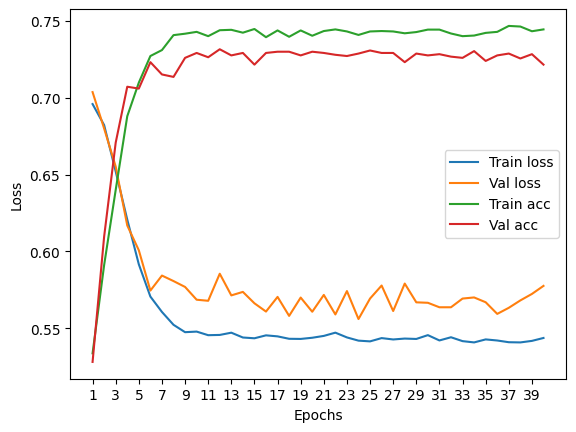

****************************************************************************************************



116it [00:00, 167.70it/s]


Train Epoch: 0 	Loss: 0.688845, Accuracy: 3986/7422 (54%)
Val Epoch: 0 	Loss: 0.685228, Accuracy: 1460/2474 (59%)



116it [00:00, 170.70it/s]


Train Epoch: 1 	Loss: 0.667863, Accuracy: 4502/7422 (61%)
Val Epoch: 1 	Loss: 0.658048, Accuracy: 1580/2474 (64%)



116it [00:00, 172.07it/s]


Train Epoch: 2 	Loss: 0.637898, Accuracy: 4878/7422 (66%)
Val Epoch: 2 	Loss: 0.617775, Accuracy: 1710/2474 (69%)



116it [00:00, 167.62it/s]


Train Epoch: 3 	Loss: 0.600856, Accuracy: 5205/7422 (70%)
Val Epoch: 3 	Loss: 0.582368, Accuracy: 1795/2474 (73%)



116it [00:00, 150.57it/s]


Train Epoch: 4 	Loss: 0.572665, Accuracy: 5361/7422 (72%)
Val Epoch: 4 	Loss: 0.559367, Accuracy: 1838/2474 (74%)



116it [00:00, 132.99it/s]


Train Epoch: 5 	Loss: 0.555796, Accuracy: 5436/7422 (73%)
Val Epoch: 5 	Loss: 0.547375, Accuracy: 1842/2474 (74%)



116it [00:00, 167.63it/s]


Train Epoch: 6 	Loss: 0.548578, Accuracy: 5490/7422 (74%)
Val Epoch: 6 	Loss: 0.540434, Accuracy: 1862/2474 (75%)



116it [00:00, 159.87it/s]


Train Epoch: 7 	Loss: 0.547083, Accuracy: 5483/7422 (74%)
Val Epoch: 7 	Loss: 0.538229, Accuracy: 1853/2474 (75%)



116it [00:00, 177.74it/s]


Train Epoch: 8 	Loss: 0.543600, Accuracy: 5493/7422 (74%)
Val Epoch: 8 	Loss: 0.540822, Accuracy: 1826/2474 (74%)



116it [00:00, 167.49it/s]


Train Epoch: 9 	Loss: 0.544123, Accuracy: 5474/7422 (74%)
Val Epoch: 9 	Loss: 0.537477, Accuracy: 1837/2474 (74%)



116it [00:00, 174.26it/s]


Train Epoch: 10 	Loss: 0.545757, Accuracy: 5451/7422 (73%)
Val Epoch: 10 	Loss: 0.541197, Accuracy: 1837/2474 (74%)



116it [00:00, 182.78it/s]


Train Epoch: 11 	Loss: 0.543866, Accuracy: 5475/7422 (74%)
Val Epoch: 11 	Loss: 0.538928, Accuracy: 1837/2474 (74%)



116it [00:00, 182.35it/s]


Train Epoch: 12 	Loss: 0.543189, Accuracy: 5474/7422 (74%)
Val Epoch: 12 	Loss: 0.550632, Accuracy: 1817/2474 (73%)



116it [00:00, 158.25it/s]


Train Epoch: 13 	Loss: 0.543915, Accuracy: 5479/7422 (74%)
Val Epoch: 13 	Loss: 0.538152, Accuracy: 1842/2474 (74%)



116it [00:00, 160.09it/s]


Train Epoch: 14 	Loss: 0.544048, Accuracy: 5447/7422 (73%)
Val Epoch: 14 	Loss: 0.538808, Accuracy: 1836/2474 (74%)



116it [00:00, 157.35it/s]


Train Epoch: 15 	Loss: 0.544223, Accuracy: 5485/7422 (74%)
Val Epoch: 15 	Loss: 0.535634, Accuracy: 1851/2474 (75%)



116it [00:00, 184.89it/s]


Train Epoch: 16 	Loss: 0.542281, Accuracy: 5493/7422 (74%)
Val Epoch: 16 	Loss: 0.546533, Accuracy: 1827/2474 (74%)



116it [00:00, 152.87it/s]


Train Epoch: 17 	Loss: 0.543294, Accuracy: 5499/7422 (74%)
Val Epoch: 17 	Loss: 0.538272, Accuracy: 1844/2474 (75%)



116it [00:00, 187.68it/s]


Train Epoch: 18 	Loss: 0.543159, Accuracy: 5460/7422 (74%)
Val Epoch: 18 	Loss: 0.538857, Accuracy: 1834/2474 (74%)



116it [00:00, 179.85it/s]


Train Epoch: 19 	Loss: 0.543755, Accuracy: 5500/7422 (74%)
Val Epoch: 19 	Loss: 0.536524, Accuracy: 1849/2474 (75%)



116it [00:00, 160.19it/s]


Train Epoch: 20 	Loss: 0.542016, Accuracy: 5473/7422 (74%)
Val Epoch: 20 	Loss: 0.537615, Accuracy: 1840/2474 (74%)



116it [00:00, 169.32it/s]


Train Epoch: 21 	Loss: 0.543338, Accuracy: 5489/7422 (74%)
Val Epoch: 21 	Loss: 0.546045, Accuracy: 1831/2474 (74%)



116it [00:00, 157.42it/s]


Train Epoch: 22 	Loss: 0.543585, Accuracy: 5493/7422 (74%)
Val Epoch: 22 	Loss: 0.542390, Accuracy: 1835/2474 (74%)



116it [00:00, 165.81it/s]


Train Epoch: 23 	Loss: 0.543892, Accuracy: 5485/7422 (74%)
Val Epoch: 23 	Loss: 0.539598, Accuracy: 1844/2474 (75%)



116it [00:00, 155.09it/s]


Train Epoch: 24 	Loss: 0.542427, Accuracy: 5493/7422 (74%)
Val Epoch: 24 	Loss: 0.538939, Accuracy: 1843/2474 (74%)



116it [00:00, 140.22it/s]


Train Epoch: 25 	Loss: 0.541349, Accuracy: 5499/7422 (74%)
Val Epoch: 25 	Loss: 0.542123, Accuracy: 1839/2474 (74%)



116it [00:00, 178.41it/s]


Train Epoch: 26 	Loss: 0.543138, Accuracy: 5493/7422 (74%)
Val Epoch: 26 	Loss: 0.537693, Accuracy: 1838/2474 (74%)



116it [00:00, 165.85it/s]


Train Epoch: 27 	Loss: 0.543278, Accuracy: 5505/7422 (74%)
Val Epoch: 27 	Loss: 0.545458, Accuracy: 1826/2474 (74%)



116it [00:00, 167.61it/s]


Train Epoch: 28 	Loss: 0.542454, Accuracy: 5483/7422 (74%)
Val Epoch: 28 	Loss: 0.537632, Accuracy: 1834/2474 (74%)



116it [00:00, 176.17it/s]


Train Epoch: 29 	Loss: 0.541276, Accuracy: 5491/7422 (74%)
Val Epoch: 29 	Loss: 0.535426, Accuracy: 1850/2474 (75%)



116it [00:00, 159.17it/s]


Train Epoch: 30 	Loss: 0.542877, Accuracy: 5511/7422 (74%)
Val Epoch: 30 	Loss: 0.534769, Accuracy: 1849/2474 (75%)



116it [00:00, 159.62it/s]


Train Epoch: 31 	Loss: 0.542733, Accuracy: 5486/7422 (74%)
Val Epoch: 31 	Loss: 0.552376, Accuracy: 1822/2474 (74%)



116it [00:00, 182.43it/s]


Train Epoch: 32 	Loss: 0.541233, Accuracy: 5491/7422 (74%)
Val Epoch: 32 	Loss: 0.538315, Accuracy: 1836/2474 (74%)



116it [00:00, 175.91it/s]


Train Epoch: 33 	Loss: 0.542519, Accuracy: 5495/7422 (74%)
Val Epoch: 33 	Loss: 0.544563, Accuracy: 1826/2474 (74%)



116it [00:00, 147.88it/s]


Train Epoch: 34 	Loss: 0.543964, Accuracy: 5491/7422 (74%)
Val Epoch: 34 	Loss: 0.537469, Accuracy: 1839/2474 (74%)



116it [00:00, 162.68it/s]


Train Epoch: 35 	Loss: 0.543308, Accuracy: 5486/7422 (74%)
Val Epoch: 35 	Loss: 0.535087, Accuracy: 1845/2474 (75%)



116it [00:00, 171.12it/s]


Train Epoch: 36 	Loss: 0.542406, Accuracy: 5486/7422 (74%)
Val Epoch: 36 	Loss: 0.537050, Accuracy: 1839/2474 (74%)



116it [00:00, 167.08it/s]


Train Epoch: 37 	Loss: 0.541323, Accuracy: 5495/7422 (74%)
Val Epoch: 37 	Loss: 0.537377, Accuracy: 1841/2474 (74%)



116it [00:00, 158.05it/s]


Train Epoch: 38 	Loss: 0.542203, Accuracy: 5482/7422 (74%)
Val Epoch: 38 	Loss: 0.536074, Accuracy: 1844/2474 (75%)



116it [00:00, 173.17it/s]


Train Epoch: 39 	Loss: 0.542356, Accuracy: 5463/7422 (74%)
Val Epoch: 39 	Loss: 0.539102, Accuracy: 1841/2474 (74%)

Test accuracy:  73.76717865804365


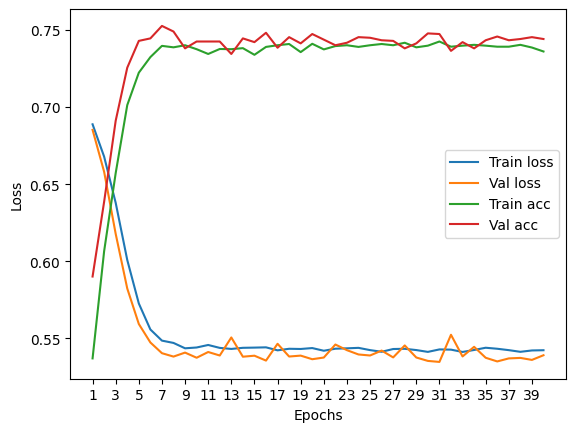

****************************************************************************************************



Particles per jet: 9


118it [00:00, 149.47it/s]


Train Epoch: 0 	Loss: 0.697102, Accuracy: 3877/7500 (52%)
Val Epoch: 0 	Loss: 0.705550, Accuracy: 1323/2500 (53%)



118it [00:00, 157.39it/s]


Train Epoch: 1 	Loss: 0.685189, Accuracy: 4316/7500 (58%)
Val Epoch: 1 	Loss: 0.690131, Accuracy: 1470/2500 (59%)



118it [00:00, 130.79it/s]


Train Epoch: 2 	Loss: 0.664637, Accuracy: 4661/7500 (62%)
Val Epoch: 2 	Loss: 0.666538, Accuracy: 1573/2500 (63%)



118it [00:00, 163.03it/s]


Train Epoch: 3 	Loss: 0.630700, Accuracy: 5049/7500 (67%)
Val Epoch: 3 	Loss: 0.633999, Accuracy: 1700/2500 (68%)



118it [00:00, 118.29it/s]


Train Epoch: 4 	Loss: 0.587470, Accuracy: 5418/7500 (72%)
Val Epoch: 4 	Loss: 0.587037, Accuracy: 1821/2500 (73%)



118it [00:00, 138.07it/s]


Train Epoch: 5 	Loss: 0.556289, Accuracy: 5539/7500 (74%)
Val Epoch: 5 	Loss: 0.565639, Accuracy: 1832/2500 (73%)



118it [00:01, 110.92it/s]


Train Epoch: 6 	Loss: 0.540796, Accuracy: 5568/7500 (74%)
Val Epoch: 6 	Loss: 0.571749, Accuracy: 1814/2500 (73%)



118it [00:00, 152.03it/s]


Train Epoch: 7 	Loss: 0.538330, Accuracy: 5550/7500 (74%)
Val Epoch: 7 	Loss: 0.557778, Accuracy: 1824/2500 (73%)



118it [00:00, 132.22it/s]


Train Epoch: 8 	Loss: 0.535053, Accuracy: 5572/7500 (74%)
Val Epoch: 8 	Loss: 0.566341, Accuracy: 1831/2500 (73%)



118it [00:00, 153.40it/s]


Train Epoch: 9 	Loss: 0.535574, Accuracy: 5578/7500 (74%)
Val Epoch: 9 	Loss: 0.557549, Accuracy: 1829/2500 (73%)



118it [00:00, 147.10it/s]


Train Epoch: 10 	Loss: 0.532228, Accuracy: 5589/7500 (75%)
Val Epoch: 10 	Loss: 0.560585, Accuracy: 1826/2500 (73%)



118it [00:00, 144.51it/s]


Train Epoch: 11 	Loss: 0.531163, Accuracy: 5600/7500 (75%)
Val Epoch: 11 	Loss: 0.550022, Accuracy: 1837/2500 (73%)



118it [00:00, 135.97it/s]


Train Epoch: 12 	Loss: 0.530805, Accuracy: 5586/7500 (74%)
Val Epoch: 12 	Loss: 0.575485, Accuracy: 1840/2500 (74%)



118it [00:00, 162.06it/s]


Train Epoch: 13 	Loss: 0.530729, Accuracy: 5609/7500 (75%)
Val Epoch: 13 	Loss: 0.559362, Accuracy: 1832/2500 (73%)



118it [00:00, 175.67it/s]


Train Epoch: 14 	Loss: 0.533245, Accuracy: 5576/7500 (74%)
Val Epoch: 14 	Loss: 0.562120, Accuracy: 1826/2500 (73%)



118it [00:00, 169.78it/s]


Train Epoch: 15 	Loss: 0.535581, Accuracy: 5576/7500 (74%)
Val Epoch: 15 	Loss: 0.566427, Accuracy: 1841/2500 (74%)



118it [00:00, 171.71it/s]


Train Epoch: 16 	Loss: 0.532675, Accuracy: 5586/7500 (74%)
Val Epoch: 16 	Loss: 0.561016, Accuracy: 1837/2500 (73%)



118it [00:00, 150.89it/s]


Train Epoch: 17 	Loss: 0.530889, Accuracy: 5607/7500 (75%)
Val Epoch: 17 	Loss: 0.553398, Accuracy: 1828/2500 (73%)



118it [00:00, 164.06it/s]


Train Epoch: 18 	Loss: 0.531900, Accuracy: 5584/7500 (74%)
Val Epoch: 18 	Loss: 0.562867, Accuracy: 1836/2500 (73%)



118it [00:00, 146.02it/s]


Train Epoch: 19 	Loss: 0.530806, Accuracy: 5592/7500 (75%)
Val Epoch: 19 	Loss: 0.555670, Accuracy: 1831/2500 (73%)



118it [00:00, 131.27it/s]


Train Epoch: 20 	Loss: 0.528413, Accuracy: 5613/7500 (75%)
Val Epoch: 20 	Loss: 0.557290, Accuracy: 1837/2500 (73%)



118it [00:00, 129.68it/s]


Train Epoch: 21 	Loss: 0.530692, Accuracy: 5593/7500 (75%)
Val Epoch: 21 	Loss: 0.563407, Accuracy: 1829/2500 (73%)



118it [00:00, 132.96it/s]


Train Epoch: 22 	Loss: 0.530942, Accuracy: 5614/7500 (75%)
Val Epoch: 22 	Loss: 0.564900, Accuracy: 1844/2500 (74%)



118it [00:00, 138.40it/s]


Train Epoch: 23 	Loss: 0.531486, Accuracy: 5608/7500 (75%)
Val Epoch: 23 	Loss: 0.555060, Accuracy: 1830/2500 (73%)



118it [00:00, 165.75it/s]


Train Epoch: 24 	Loss: 0.530248, Accuracy: 5590/7500 (75%)
Val Epoch: 24 	Loss: 0.554295, Accuracy: 1831/2500 (73%)



118it [00:00, 165.81it/s]


Train Epoch: 25 	Loss: 0.532022, Accuracy: 5562/7500 (74%)
Val Epoch: 25 	Loss: 0.555058, Accuracy: 1829/2500 (73%)



118it [00:00, 152.24it/s]


Train Epoch: 26 	Loss: 0.531567, Accuracy: 5600/7500 (75%)
Val Epoch: 26 	Loss: 0.556268, Accuracy: 1838/2500 (74%)



118it [00:00, 124.05it/s]


Train Epoch: 27 	Loss: 0.529864, Accuracy: 5590/7500 (75%)
Val Epoch: 27 	Loss: 0.547525, Accuracy: 1834/2500 (73%)



118it [00:00, 138.14it/s]


Train Epoch: 28 	Loss: 0.527717, Accuracy: 5615/7500 (75%)
Val Epoch: 28 	Loss: 0.570653, Accuracy: 1827/2500 (73%)



118it [00:00, 146.60it/s]


Train Epoch: 29 	Loss: 0.531852, Accuracy: 5598/7500 (75%)
Val Epoch: 29 	Loss: 0.550551, Accuracy: 1838/2500 (74%)



118it [00:00, 153.98it/s]


Train Epoch: 30 	Loss: 0.534097, Accuracy: 5608/7500 (75%)
Val Epoch: 30 	Loss: 0.556314, Accuracy: 1830/2500 (73%)



118it [00:00, 136.22it/s]


Train Epoch: 31 	Loss: 0.529804, Accuracy: 5601/7500 (75%)
Val Epoch: 31 	Loss: 0.552390, Accuracy: 1835/2500 (73%)



118it [00:00, 139.63it/s]


Train Epoch: 32 	Loss: 0.527564, Accuracy: 5612/7500 (75%)
Val Epoch: 32 	Loss: 0.549004, Accuracy: 1841/2500 (74%)



118it [00:00, 141.07it/s]


Train Epoch: 33 	Loss: 0.533138, Accuracy: 5614/7500 (75%)
Val Epoch: 33 	Loss: 0.553430, Accuracy: 1839/2500 (74%)



118it [00:00, 128.08it/s]


Train Epoch: 34 	Loss: 0.531750, Accuracy: 5596/7500 (75%)
Val Epoch: 34 	Loss: 0.553480, Accuracy: 1841/2500 (74%)



118it [00:00, 133.67it/s]


Train Epoch: 35 	Loss: 0.529726, Accuracy: 5611/7500 (75%)
Val Epoch: 35 	Loss: 0.560795, Accuracy: 1819/2500 (73%)



118it [00:00, 123.99it/s]


Train Epoch: 36 	Loss: 0.533712, Accuracy: 5585/7500 (74%)
Val Epoch: 36 	Loss: 0.556402, Accuracy: 1838/2500 (74%)



118it [00:01, 117.98it/s]


Train Epoch: 37 	Loss: 0.530822, Accuracy: 5604/7500 (75%)
Val Epoch: 37 	Loss: 0.546402, Accuracy: 1850/2500 (74%)



118it [00:00, 138.78it/s]


Train Epoch: 38 	Loss: 0.530423, Accuracy: 5629/7500 (75%)
Val Epoch: 38 	Loss: 0.553798, Accuracy: 1827/2500 (73%)



118it [00:00, 148.67it/s]


Train Epoch: 39 	Loss: 0.526820, Accuracy: 5625/7500 (75%)
Val Epoch: 39 	Loss: 0.561067, Accuracy: 1824/2500 (73%)

Test accuracy:  74.88


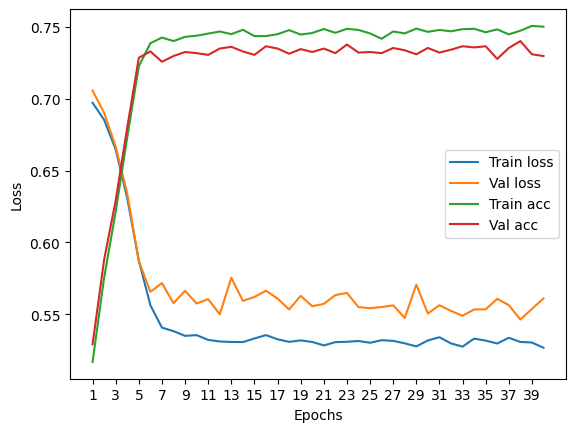

****************************************************************************************************



118it [00:01, 117.49it/s]


Train Epoch: 0 	Loss: 0.695478, Accuracy: 4012/7500 (53%)
Val Epoch: 0 	Loss: 0.700242, Accuracy: 1405/2500 (56%)



118it [00:00, 134.78it/s]


Train Epoch: 1 	Loss: 0.681519, Accuracy: 4375/7500 (58%)
Val Epoch: 1 	Loss: 0.685021, Accuracy: 1518/2500 (61%)



118it [00:00, 156.38it/s]


Train Epoch: 2 	Loss: 0.659756, Accuracy: 4654/7500 (62%)
Val Epoch: 2 	Loss: 0.651443, Accuracy: 1695/2500 (68%)



118it [00:00, 153.29it/s]


Train Epoch: 3 	Loss: 0.618093, Accuracy: 5194/7500 (69%)
Val Epoch: 3 	Loss: 0.603641, Accuracy: 1799/2500 (72%)



118it [00:00, 165.00it/s]


Train Epoch: 4 	Loss: 0.579998, Accuracy: 5430/7500 (72%)
Val Epoch: 4 	Loss: 0.572680, Accuracy: 1829/2500 (73%)



118it [00:00, 151.05it/s]


Train Epoch: 5 	Loss: 0.561884, Accuracy: 5463/7500 (73%)
Val Epoch: 5 	Loss: 0.565684, Accuracy: 1838/2500 (74%)



118it [00:00, 147.35it/s]


Train Epoch: 6 	Loss: 0.556272, Accuracy: 5501/7500 (73%)
Val Epoch: 6 	Loss: 0.556859, Accuracy: 1842/2500 (74%)



118it [00:00, 156.71it/s]


Train Epoch: 7 	Loss: 0.552250, Accuracy: 5501/7500 (73%)
Val Epoch: 7 	Loss: 0.564064, Accuracy: 1856/2500 (74%)



118it [00:00, 153.37it/s]


Train Epoch: 8 	Loss: 0.550189, Accuracy: 5518/7500 (74%)
Val Epoch: 8 	Loss: 0.561352, Accuracy: 1843/2500 (74%)



118it [00:00, 154.86it/s]


Train Epoch: 9 	Loss: 0.550222, Accuracy: 5495/7500 (73%)
Val Epoch: 9 	Loss: 0.556860, Accuracy: 1848/2500 (74%)



118it [00:00, 149.44it/s]


Train Epoch: 10 	Loss: 0.554305, Accuracy: 5483/7500 (73%)
Val Epoch: 10 	Loss: 0.554975, Accuracy: 1841/2500 (74%)



118it [00:00, 176.82it/s]


Train Epoch: 11 	Loss: 0.548333, Accuracy: 5503/7500 (73%)
Val Epoch: 11 	Loss: 0.548481, Accuracy: 1859/2500 (74%)



118it [00:00, 149.34it/s]


Train Epoch: 12 	Loss: 0.551293, Accuracy: 5504/7500 (73%)
Val Epoch: 12 	Loss: 0.556665, Accuracy: 1859/2500 (74%)



118it [00:01, 112.50it/s]


Train Epoch: 13 	Loss: 0.551495, Accuracy: 5505/7500 (73%)
Val Epoch: 13 	Loss: 0.551008, Accuracy: 1857/2500 (74%)



118it [00:00, 157.51it/s]


Train Epoch: 14 	Loss: 0.551077, Accuracy: 5516/7500 (74%)
Val Epoch: 14 	Loss: 0.550542, Accuracy: 1864/2500 (75%)



118it [00:00, 135.41it/s]


Train Epoch: 15 	Loss: 0.551079, Accuracy: 5479/7500 (73%)
Val Epoch: 15 	Loss: 0.548248, Accuracy: 1863/2500 (75%)



118it [00:00, 158.47it/s]


Train Epoch: 16 	Loss: 0.548388, Accuracy: 5508/7500 (73%)
Val Epoch: 16 	Loss: 0.551957, Accuracy: 1851/2500 (74%)



118it [00:00, 121.90it/s]


Train Epoch: 17 	Loss: 0.549894, Accuracy: 5501/7500 (73%)
Val Epoch: 17 	Loss: 0.569739, Accuracy: 1863/2500 (75%)



118it [00:00, 149.49it/s]


Train Epoch: 18 	Loss: 0.550880, Accuracy: 5497/7500 (73%)
Val Epoch: 18 	Loss: 0.557342, Accuracy: 1853/2500 (74%)



118it [00:00, 140.80it/s]


Train Epoch: 19 	Loss: 0.553109, Accuracy: 5467/7500 (73%)
Val Epoch: 19 	Loss: 0.555987, Accuracy: 1843/2500 (74%)



118it [00:00, 145.45it/s]


Train Epoch: 20 	Loss: 0.550505, Accuracy: 5503/7500 (73%)
Val Epoch: 20 	Loss: 0.550354, Accuracy: 1863/2500 (75%)



118it [00:00, 160.65it/s]


Train Epoch: 21 	Loss: 0.549303, Accuracy: 5515/7500 (74%)
Val Epoch: 21 	Loss: 0.572254, Accuracy: 1836/2500 (73%)



118it [00:00, 150.25it/s]


Train Epoch: 22 	Loss: 0.549205, Accuracy: 5511/7500 (73%)
Val Epoch: 22 	Loss: 0.556319, Accuracy: 1856/2500 (74%)



118it [00:00, 140.65it/s]


Train Epoch: 23 	Loss: 0.548742, Accuracy: 5477/7500 (73%)
Val Epoch: 23 	Loss: 0.556455, Accuracy: 1850/2500 (74%)



118it [00:00, 154.58it/s]


Train Epoch: 24 	Loss: 0.549204, Accuracy: 5480/7500 (73%)
Val Epoch: 24 	Loss: 0.553466, Accuracy: 1846/2500 (74%)



118it [00:00, 144.98it/s]


Train Epoch: 25 	Loss: 0.550841, Accuracy: 5470/7500 (73%)
Val Epoch: 25 	Loss: 0.568512, Accuracy: 1844/2500 (74%)



118it [00:00, 143.78it/s]


Train Epoch: 26 	Loss: 0.549020, Accuracy: 5508/7500 (73%)
Val Epoch: 26 	Loss: 0.566010, Accuracy: 1855/2500 (74%)



118it [00:00, 170.87it/s]


Train Epoch: 27 	Loss: 0.548436, Accuracy: 5500/7500 (73%)
Val Epoch: 27 	Loss: 0.548323, Accuracy: 1861/2500 (74%)



118it [00:00, 128.63it/s]


Train Epoch: 28 	Loss: 0.550115, Accuracy: 5489/7500 (73%)
Val Epoch: 28 	Loss: 0.545487, Accuracy: 1868/2500 (75%)



118it [00:01, 114.32it/s]


Train Epoch: 29 	Loss: 0.549560, Accuracy: 5499/7500 (73%)
Val Epoch: 29 	Loss: 0.566682, Accuracy: 1835/2500 (73%)



118it [00:00, 120.92it/s]


Train Epoch: 30 	Loss: 0.552618, Accuracy: 5501/7500 (73%)
Val Epoch: 30 	Loss: 0.551471, Accuracy: 1848/2500 (74%)



118it [00:00, 156.88it/s]


Train Epoch: 31 	Loss: 0.550383, Accuracy: 5457/7500 (73%)
Val Epoch: 31 	Loss: 0.554530, Accuracy: 1866/2500 (75%)



118it [00:00, 128.16it/s]


Train Epoch: 32 	Loss: 0.548636, Accuracy: 5499/7500 (73%)
Val Epoch: 32 	Loss: 0.552951, Accuracy: 1861/2500 (74%)



118it [00:00, 123.74it/s]


Train Epoch: 33 	Loss: 0.551418, Accuracy: 5516/7500 (74%)
Val Epoch: 33 	Loss: 0.551983, Accuracy: 1862/2500 (74%)



118it [00:00, 157.82it/s]


Train Epoch: 34 	Loss: 0.550781, Accuracy: 5495/7500 (73%)
Val Epoch: 34 	Loss: 0.558677, Accuracy: 1844/2500 (74%)



118it [00:00, 156.94it/s]


Train Epoch: 35 	Loss: 0.548356, Accuracy: 5508/7500 (73%)
Val Epoch: 35 	Loss: 0.565080, Accuracy: 1857/2500 (74%)



118it [00:00, 118.12it/s]


Train Epoch: 36 	Loss: 0.548308, Accuracy: 5505/7500 (73%)
Val Epoch: 36 	Loss: 0.550634, Accuracy: 1854/2500 (74%)



118it [00:00, 140.45it/s]


Train Epoch: 37 	Loss: 0.550132, Accuracy: 5488/7500 (73%)
Val Epoch: 37 	Loss: 0.554772, Accuracy: 1849/2500 (74%)



118it [00:00, 139.76it/s]


Train Epoch: 38 	Loss: 0.550157, Accuracy: 5504/7500 (73%)
Val Epoch: 38 	Loss: 0.555585, Accuracy: 1854/2500 (74%)



118it [00:00, 139.56it/s]


Train Epoch: 39 	Loss: 0.550633, Accuracy: 5497/7500 (73%)
Val Epoch: 39 	Loss: 0.550064, Accuracy: 1841/2500 (74%)

Test accuracy:  73.56


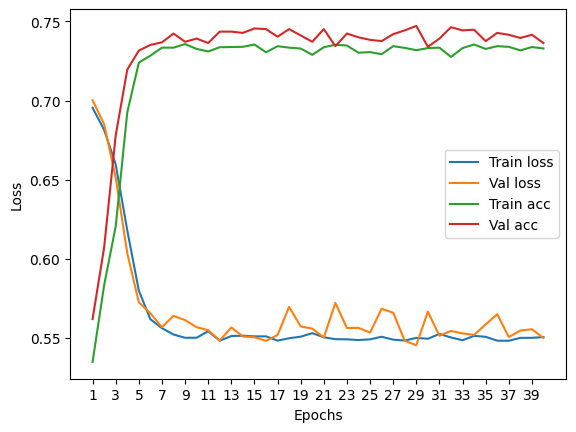

****************************************************************************************************



118it [00:00, 167.56it/s]


Train Epoch: 0 	Loss: 0.694108, Accuracy: 4060/7500 (54%)
Val Epoch: 0 	Loss: 0.696037, Accuracy: 1441/2500 (58%)



118it [00:00, 158.68it/s]


Train Epoch: 1 	Loss: 0.679775, Accuracy: 4405/7500 (59%)
Val Epoch: 1 	Loss: 0.675119, Accuracy: 1596/2500 (64%)



118it [00:00, 159.74it/s]


Train Epoch: 2 	Loss: 0.653040, Accuracy: 4826/7500 (64%)
Val Epoch: 2 	Loss: 0.660274, Accuracy: 1563/2500 (63%)



118it [00:00, 159.81it/s]


Train Epoch: 3 	Loss: 0.619215, Accuracy: 5219/7500 (70%)
Val Epoch: 3 	Loss: 0.602390, Accuracy: 1828/2500 (73%)



118it [00:00, 169.44it/s]


Train Epoch: 4 	Loss: 0.579368, Accuracy: 5483/7500 (73%)
Val Epoch: 4 	Loss: 0.570999, Accuracy: 1828/2500 (73%)



118it [00:00, 177.81it/s]


Train Epoch: 5 	Loss: 0.556084, Accuracy: 5517/7500 (74%)
Val Epoch: 5 	Loss: 0.556553, Accuracy: 1881/2500 (75%)



118it [00:00, 184.08it/s]


Train Epoch: 6 	Loss: 0.546834, Accuracy: 5563/7500 (74%)
Val Epoch: 6 	Loss: 0.550679, Accuracy: 1874/2500 (75%)



118it [00:00, 182.31it/s]


Train Epoch: 7 	Loss: 0.539840, Accuracy: 5553/7500 (74%)
Val Epoch: 7 	Loss: 0.545612, Accuracy: 1842/2500 (74%)



118it [00:00, 165.65it/s]


Train Epoch: 8 	Loss: 0.537634, Accuracy: 5563/7500 (74%)
Val Epoch: 8 	Loss: 0.545494, Accuracy: 1879/2500 (75%)



118it [00:00, 163.80it/s]


Train Epoch: 9 	Loss: 0.541763, Accuracy: 5567/7500 (74%)
Val Epoch: 9 	Loss: 0.542553, Accuracy: 1851/2500 (74%)



118it [00:00, 167.29it/s]


Train Epoch: 10 	Loss: 0.537456, Accuracy: 5566/7500 (74%)
Val Epoch: 10 	Loss: 0.549063, Accuracy: 1861/2500 (74%)



118it [00:00, 165.58it/s]


Train Epoch: 11 	Loss: 0.534297, Accuracy: 5566/7500 (74%)
Val Epoch: 11 	Loss: 0.567297, Accuracy: 1841/2500 (74%)



118it [00:00, 175.30it/s]


Train Epoch: 12 	Loss: 0.536808, Accuracy: 5570/7500 (74%)
Val Epoch: 12 	Loss: 0.560751, Accuracy: 1865/2500 (75%)



118it [00:00, 161.63it/s]


Train Epoch: 13 	Loss: 0.534277, Accuracy: 5578/7500 (74%)
Val Epoch: 13 	Loss: 0.556305, Accuracy: 1857/2500 (74%)



118it [00:00, 161.10it/s]


Train Epoch: 14 	Loss: 0.537349, Accuracy: 5578/7500 (74%)
Val Epoch: 14 	Loss: 0.541013, Accuracy: 1879/2500 (75%)



118it [00:00, 178.02it/s]


Train Epoch: 15 	Loss: 0.536379, Accuracy: 5586/7500 (74%)
Val Epoch: 15 	Loss: 0.544038, Accuracy: 1866/2500 (75%)



118it [00:00, 177.57it/s]


Train Epoch: 16 	Loss: 0.535794, Accuracy: 5562/7500 (74%)
Val Epoch: 16 	Loss: 0.552201, Accuracy: 1885/2500 (75%)



118it [00:00, 165.44it/s]


Train Epoch: 17 	Loss: 0.533649, Accuracy: 5600/7500 (75%)
Val Epoch: 17 	Loss: 0.551921, Accuracy: 1892/2500 (76%)



118it [00:00, 154.07it/s]


Train Epoch: 18 	Loss: 0.536692, Accuracy: 5575/7500 (74%)
Val Epoch: 18 	Loss: 0.552671, Accuracy: 1885/2500 (75%)



118it [00:00, 145.05it/s]


Train Epoch: 19 	Loss: 0.536544, Accuracy: 5592/7500 (75%)
Val Epoch: 19 	Loss: 0.546975, Accuracy: 1870/2500 (75%)



118it [00:00, 146.19it/s]


Train Epoch: 20 	Loss: 0.534947, Accuracy: 5588/7500 (75%)
Val Epoch: 20 	Loss: 0.547756, Accuracy: 1884/2500 (75%)



118it [00:00, 180.23it/s]


Train Epoch: 21 	Loss: 0.538330, Accuracy: 5594/7500 (75%)
Val Epoch: 21 	Loss: 0.557140, Accuracy: 1846/2500 (74%)



118it [00:00, 173.34it/s]


Train Epoch: 22 	Loss: 0.534542, Accuracy: 5592/7500 (75%)
Val Epoch: 22 	Loss: 0.537776, Accuracy: 1852/2500 (74%)



118it [00:00, 173.06it/s]


Train Epoch: 23 	Loss: 0.536527, Accuracy: 5568/7500 (74%)
Val Epoch: 23 	Loss: 0.538721, Accuracy: 1877/2500 (75%)



118it [00:00, 177.60it/s]


Train Epoch: 24 	Loss: 0.535240, Accuracy: 5574/7500 (74%)
Val Epoch: 24 	Loss: 0.538871, Accuracy: 1884/2500 (75%)



118it [00:00, 185.04it/s]


Train Epoch: 25 	Loss: 0.533494, Accuracy: 5582/7500 (74%)
Val Epoch: 25 	Loss: 0.537928, Accuracy: 1882/2500 (75%)



118it [00:00, 148.69it/s]


Train Epoch: 26 	Loss: 0.535033, Accuracy: 5587/7500 (74%)
Val Epoch: 26 	Loss: 0.536125, Accuracy: 1879/2500 (75%)



118it [00:00, 127.77it/s]


Train Epoch: 27 	Loss: 0.534424, Accuracy: 5618/7500 (75%)
Val Epoch: 27 	Loss: 0.535720, Accuracy: 1861/2500 (74%)



118it [00:00, 148.15it/s]


Train Epoch: 28 	Loss: 0.535354, Accuracy: 5572/7500 (74%)
Val Epoch: 28 	Loss: 0.536549, Accuracy: 1859/2500 (74%)



118it [00:00, 167.42it/s]


Train Epoch: 29 	Loss: 0.534624, Accuracy: 5568/7500 (74%)
Val Epoch: 29 	Loss: 0.545885, Accuracy: 1873/2500 (75%)



118it [00:00, 184.50it/s]


Train Epoch: 30 	Loss: 0.534308, Accuracy: 5590/7500 (75%)
Val Epoch: 30 	Loss: 0.559500, Accuracy: 1888/2500 (76%)



118it [00:00, 180.95it/s]


Train Epoch: 31 	Loss: 0.535208, Accuracy: 5609/7500 (75%)
Val Epoch: 31 	Loss: 0.535660, Accuracy: 1875/2500 (75%)



118it [00:00, 169.70it/s]


Train Epoch: 32 	Loss: 0.532694, Accuracy: 5597/7500 (75%)
Val Epoch: 32 	Loss: 0.533528, Accuracy: 1863/2500 (75%)



118it [00:00, 157.98it/s]


Train Epoch: 33 	Loss: 0.535917, Accuracy: 5588/7500 (75%)
Val Epoch: 33 	Loss: 0.549123, Accuracy: 1876/2500 (75%)



118it [00:00, 174.15it/s]


Train Epoch: 34 	Loss: 0.536861, Accuracy: 5583/7500 (74%)
Val Epoch: 34 	Loss: 0.548543, Accuracy: 1872/2500 (75%)



118it [00:00, 156.55it/s]


Train Epoch: 35 	Loss: 0.533879, Accuracy: 5604/7500 (75%)
Val Epoch: 35 	Loss: 0.537660, Accuracy: 1870/2500 (75%)



118it [00:00, 149.68it/s]


Train Epoch: 36 	Loss: 0.533906, Accuracy: 5604/7500 (75%)
Val Epoch: 36 	Loss: 0.546100, Accuracy: 1873/2500 (75%)



118it [00:00, 137.08it/s]


Train Epoch: 37 	Loss: 0.537618, Accuracy: 5582/7500 (74%)
Val Epoch: 37 	Loss: 0.534381, Accuracy: 1877/2500 (75%)



118it [00:00, 158.31it/s]


Train Epoch: 38 	Loss: 0.534406, Accuracy: 5572/7500 (74%)
Val Epoch: 38 	Loss: 0.541981, Accuracy: 1859/2500 (74%)



118it [00:00, 127.00it/s]


Train Epoch: 39 	Loss: 0.533032, Accuracy: 5582/7500 (74%)
Val Epoch: 39 	Loss: 0.536611, Accuracy: 1886/2500 (75%)

Test accuracy:  75.92


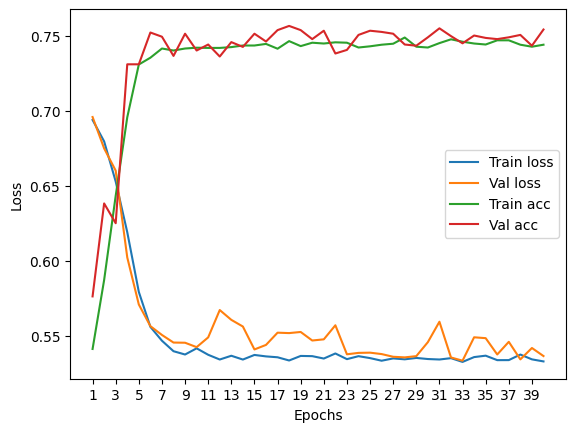

****************************************************************************************************



118it [00:00, 139.86it/s]


Train Epoch: 0 	Loss: 0.693595, Accuracy: 4006/7500 (53%)
Val Epoch: 0 	Loss: 0.698952, Accuracy: 1433/2500 (57%)



118it [00:00, 147.21it/s]


Train Epoch: 1 	Loss: 0.671480, Accuracy: 4529/7500 (60%)
Val Epoch: 1 	Loss: 0.661054, Accuracy: 1595/2500 (64%)



118it [00:00, 138.89it/s]


Train Epoch: 2 	Loss: 0.627263, Accuracy: 5086/7500 (68%)
Val Epoch: 2 	Loss: 0.615756, Accuracy: 1756/2500 (70%)



118it [00:00, 137.16it/s]


Train Epoch: 3 	Loss: 0.589973, Accuracy: 5333/7500 (71%)
Val Epoch: 3 	Loss: 0.584108, Accuracy: 1802/2500 (72%)



118it [00:00, 131.23it/s]


Train Epoch: 4 	Loss: 0.565372, Accuracy: 5455/7500 (73%)
Val Epoch: 4 	Loss: 0.567575, Accuracy: 1811/2500 (72%)



118it [00:00, 161.03it/s]


Train Epoch: 5 	Loss: 0.554932, Accuracy: 5494/7500 (73%)
Val Epoch: 5 	Loss: 0.562334, Accuracy: 1817/2500 (73%)



118it [00:00, 156.31it/s]


Train Epoch: 6 	Loss: 0.550864, Accuracy: 5495/7500 (73%)
Val Epoch: 6 	Loss: 0.557518, Accuracy: 1827/2500 (73%)



118it [00:01, 115.98it/s]


Train Epoch: 7 	Loss: 0.548851, Accuracy: 5527/7500 (74%)
Val Epoch: 7 	Loss: 0.550231, Accuracy: 1834/2500 (73%)



118it [00:00, 150.19it/s]


Train Epoch: 8 	Loss: 0.545861, Accuracy: 5529/7500 (74%)
Val Epoch: 8 	Loss: 0.546698, Accuracy: 1840/2500 (74%)



118it [00:00, 139.06it/s]


Train Epoch: 9 	Loss: 0.546547, Accuracy: 5529/7500 (74%)
Val Epoch: 9 	Loss: 0.553589, Accuracy: 1832/2500 (73%)



118it [00:00, 146.52it/s]


Train Epoch: 10 	Loss: 0.544835, Accuracy: 5519/7500 (74%)
Val Epoch: 10 	Loss: 0.564072, Accuracy: 1838/2500 (74%)



118it [00:00, 127.20it/s]


Train Epoch: 11 	Loss: 0.547415, Accuracy: 5537/7500 (74%)
Val Epoch: 11 	Loss: 0.558195, Accuracy: 1813/2500 (73%)



118it [00:00, 148.65it/s]


Train Epoch: 12 	Loss: 0.547554, Accuracy: 5511/7500 (73%)
Val Epoch: 12 	Loss: 0.557455, Accuracy: 1848/2500 (74%)



118it [00:00, 151.65it/s]


Train Epoch: 13 	Loss: 0.544691, Accuracy: 5547/7500 (74%)
Val Epoch: 13 	Loss: 0.547739, Accuracy: 1842/2500 (74%)



118it [00:00, 146.14it/s]


Train Epoch: 14 	Loss: 0.546378, Accuracy: 5537/7500 (74%)
Val Epoch: 14 	Loss: 0.557608, Accuracy: 1843/2500 (74%)



118it [00:00, 145.61it/s]


Train Epoch: 15 	Loss: 0.545436, Accuracy: 5535/7500 (74%)
Val Epoch: 15 	Loss: 0.550702, Accuracy: 1843/2500 (74%)



118it [00:00, 156.10it/s]


Train Epoch: 16 	Loss: 0.545549, Accuracy: 5549/7500 (74%)
Val Epoch: 16 	Loss: 0.563373, Accuracy: 1836/2500 (73%)



118it [00:00, 131.79it/s]


Train Epoch: 17 	Loss: 0.546315, Accuracy: 5517/7500 (74%)
Val Epoch: 17 	Loss: 0.561049, Accuracy: 1840/2500 (74%)



118it [00:00, 144.98it/s]


Train Epoch: 18 	Loss: 0.545305, Accuracy: 5511/7500 (73%)
Val Epoch: 18 	Loss: 0.542273, Accuracy: 1840/2500 (74%)



118it [00:00, 140.67it/s]


Train Epoch: 19 	Loss: 0.546148, Accuracy: 5538/7500 (74%)
Val Epoch: 19 	Loss: 0.555850, Accuracy: 1821/2500 (73%)



118it [00:00, 140.39it/s]


Train Epoch: 20 	Loss: 0.544153, Accuracy: 5544/7500 (74%)
Val Epoch: 20 	Loss: 0.554371, Accuracy: 1842/2500 (74%)



118it [00:00, 160.68it/s]


Train Epoch: 21 	Loss: 0.543901, Accuracy: 5531/7500 (74%)
Val Epoch: 21 	Loss: 0.566752, Accuracy: 1834/2500 (73%)



118it [00:00, 125.81it/s]


Train Epoch: 22 	Loss: 0.543994, Accuracy: 5548/7500 (74%)
Val Epoch: 22 	Loss: 0.554087, Accuracy: 1847/2500 (74%)



118it [00:01, 89.70it/s]


Train Epoch: 23 	Loss: 0.546130, Accuracy: 5535/7500 (74%)
Val Epoch: 23 	Loss: 0.546063, Accuracy: 1845/2500 (74%)



118it [00:00, 120.64it/s]


Train Epoch: 24 	Loss: 0.543804, Accuracy: 5559/7500 (74%)
Val Epoch: 24 	Loss: 0.556885, Accuracy: 1826/2500 (73%)



118it [00:00, 125.14it/s]


Train Epoch: 25 	Loss: 0.545219, Accuracy: 5543/7500 (74%)
Val Epoch: 25 	Loss: 0.551514, Accuracy: 1848/2500 (74%)



118it [00:00, 141.65it/s]


Train Epoch: 26 	Loss: 0.544472, Accuracy: 5539/7500 (74%)
Val Epoch: 26 	Loss: 0.550774, Accuracy: 1831/2500 (73%)



118it [00:01, 116.91it/s]


Train Epoch: 27 	Loss: 0.544344, Accuracy: 5535/7500 (74%)
Val Epoch: 27 	Loss: 0.549276, Accuracy: 1835/2500 (73%)



118it [00:00, 132.63it/s]


Train Epoch: 28 	Loss: 0.545029, Accuracy: 5512/7500 (73%)
Val Epoch: 28 	Loss: 0.546584, Accuracy: 1841/2500 (74%)



118it [00:00, 142.16it/s]


Train Epoch: 29 	Loss: 0.544065, Accuracy: 5556/7500 (74%)
Val Epoch: 29 	Loss: 0.557250, Accuracy: 1837/2500 (73%)



118it [00:00, 146.69it/s]


Train Epoch: 30 	Loss: 0.544854, Accuracy: 5516/7500 (74%)
Val Epoch: 30 	Loss: 0.564543, Accuracy: 1833/2500 (73%)



118it [00:00, 145.40it/s]


Train Epoch: 31 	Loss: 0.546191, Accuracy: 5547/7500 (74%)
Val Epoch: 31 	Loss: 0.561471, Accuracy: 1821/2500 (73%)



118it [00:00, 163.16it/s]


Train Epoch: 32 	Loss: 0.542860, Accuracy: 5549/7500 (74%)
Val Epoch: 32 	Loss: 0.554834, Accuracy: 1836/2500 (73%)



118it [00:00, 140.04it/s]


Train Epoch: 33 	Loss: 0.542433, Accuracy: 5529/7500 (74%)
Val Epoch: 33 	Loss: 0.550318, Accuracy: 1839/2500 (74%)



118it [00:00, 154.53it/s]


Train Epoch: 34 	Loss: 0.545006, Accuracy: 5544/7500 (74%)
Val Epoch: 34 	Loss: 0.553888, Accuracy: 1846/2500 (74%)



118it [00:00, 129.60it/s]


Train Epoch: 35 	Loss: 0.546202, Accuracy: 5529/7500 (74%)
Val Epoch: 35 	Loss: 0.551050, Accuracy: 1841/2500 (74%)



118it [00:00, 169.13it/s]


Train Epoch: 36 	Loss: 0.543324, Accuracy: 5570/7500 (74%)
Val Epoch: 36 	Loss: 0.545984, Accuracy: 1835/2500 (73%)



118it [00:00, 151.91it/s]


Train Epoch: 37 	Loss: 0.543412, Accuracy: 5565/7500 (74%)
Val Epoch: 37 	Loss: 0.555337, Accuracy: 1839/2500 (74%)



118it [00:00, 153.21it/s]


Train Epoch: 38 	Loss: 0.542537, Accuracy: 5548/7500 (74%)
Val Epoch: 38 	Loss: 0.542451, Accuracy: 1851/2500 (74%)



118it [00:00, 177.95it/s]


Train Epoch: 39 	Loss: 0.544009, Accuracy: 5548/7500 (74%)
Val Epoch: 39 	Loss: 0.550307, Accuracy: 1849/2500 (74%)

Test accuracy:  73.44000000000001


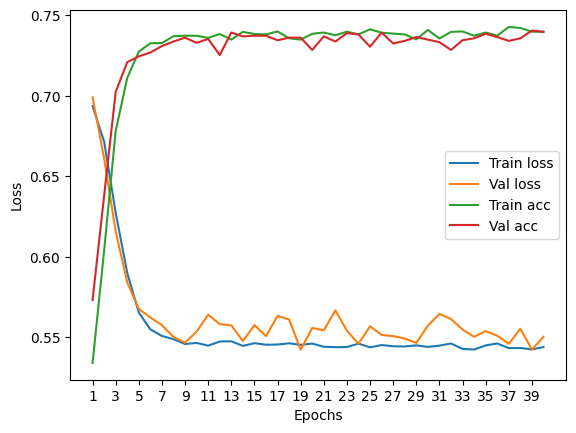

****************************************************************************************************



118it [00:00, 118.80it/s]


Train Epoch: 0 	Loss: 0.698483, Accuracy: 3814/7500 (51%)
Val Epoch: 0 	Loss: 0.699612, Accuracy: 1476/2500 (59%)



118it [00:00, 135.68it/s]


Train Epoch: 1 	Loss: 0.672901, Accuracy: 4758/7500 (63%)
Val Epoch: 1 	Loss: 0.657287, Accuracy: 1655/2500 (66%)



118it [00:00, 138.98it/s]


Train Epoch: 2 	Loss: 0.628905, Accuracy: 5163/7500 (69%)
Val Epoch: 2 	Loss: 0.610839, Accuracy: 1787/2500 (71%)



118it [00:01, 111.05it/s]


Train Epoch: 3 	Loss: 0.584604, Accuracy: 5435/7500 (72%)
Val Epoch: 3 	Loss: 0.587304, Accuracy: 1771/2500 (71%)



118it [00:00, 147.72it/s]


Train Epoch: 4 	Loss: 0.562151, Accuracy: 5482/7500 (73%)
Val Epoch: 4 	Loss: 0.577605, Accuracy: 1767/2500 (71%)



118it [00:00, 154.91it/s]


Train Epoch: 5 	Loss: 0.552748, Accuracy: 5536/7500 (74%)
Val Epoch: 5 	Loss: 0.561944, Accuracy: 1797/2500 (72%)



118it [00:00, 146.20it/s]


Train Epoch: 6 	Loss: 0.551570, Accuracy: 5516/7500 (74%)
Val Epoch: 6 	Loss: 0.556426, Accuracy: 1850/2500 (74%)



118it [00:00, 130.46it/s]


Train Epoch: 7 	Loss: 0.547995, Accuracy: 5519/7500 (74%)
Val Epoch: 7 	Loss: 0.557021, Accuracy: 1854/2500 (74%)



118it [00:01, 108.16it/s]


Train Epoch: 8 	Loss: 0.548654, Accuracy: 5524/7500 (74%)
Val Epoch: 8 	Loss: 0.548740, Accuracy: 1844/2500 (74%)



118it [00:01, 91.10it/s] 


Train Epoch: 9 	Loss: 0.547871, Accuracy: 5530/7500 (74%)
Val Epoch: 9 	Loss: 0.543347, Accuracy: 1849/2500 (74%)



118it [00:00, 129.40it/s]


Train Epoch: 10 	Loss: 0.545959, Accuracy: 5524/7500 (74%)
Val Epoch: 10 	Loss: 0.558444, Accuracy: 1849/2500 (74%)



118it [00:00, 125.05it/s]


Train Epoch: 11 	Loss: 0.545390, Accuracy: 5552/7500 (74%)
Val Epoch: 11 	Loss: 0.555139, Accuracy: 1841/2500 (74%)



118it [00:00, 141.61it/s]


Train Epoch: 12 	Loss: 0.547318, Accuracy: 5532/7500 (74%)
Val Epoch: 12 	Loss: 0.540839, Accuracy: 1833/2500 (73%)



118it [00:00, 153.00it/s]


Train Epoch: 13 	Loss: 0.544810, Accuracy: 5527/7500 (74%)
Val Epoch: 13 	Loss: 0.556160, Accuracy: 1853/2500 (74%)



118it [00:00, 141.47it/s]


Train Epoch: 14 	Loss: 0.547164, Accuracy: 5558/7500 (74%)
Val Epoch: 14 	Loss: 0.556894, Accuracy: 1829/2500 (73%)



118it [00:00, 157.84it/s]


Train Epoch: 15 	Loss: 0.549005, Accuracy: 5527/7500 (74%)
Val Epoch: 15 	Loss: 0.568560, Accuracy: 1837/2500 (73%)



118it [00:00, 133.09it/s]


Train Epoch: 16 	Loss: 0.545859, Accuracy: 5554/7500 (74%)
Val Epoch: 16 	Loss: 0.548905, Accuracy: 1830/2500 (73%)



118it [00:00, 141.99it/s]


Train Epoch: 17 	Loss: 0.542986, Accuracy: 5564/7500 (74%)
Val Epoch: 17 	Loss: 0.551921, Accuracy: 1853/2500 (74%)



118it [00:00, 127.63it/s]


Train Epoch: 18 	Loss: 0.544767, Accuracy: 5535/7500 (74%)
Val Epoch: 18 	Loss: 0.549868, Accuracy: 1846/2500 (74%)



118it [00:00, 147.80it/s]


Train Epoch: 19 	Loss: 0.543737, Accuracy: 5542/7500 (74%)
Val Epoch: 19 	Loss: 0.552955, Accuracy: 1853/2500 (74%)



118it [00:00, 141.85it/s]


Train Epoch: 20 	Loss: 0.542737, Accuracy: 5562/7500 (74%)
Val Epoch: 20 	Loss: 0.561685, Accuracy: 1836/2500 (73%)



118it [00:00, 129.18it/s]


Train Epoch: 21 	Loss: 0.544492, Accuracy: 5544/7500 (74%)
Val Epoch: 21 	Loss: 0.546064, Accuracy: 1857/2500 (74%)



118it [00:00, 138.73it/s]


Train Epoch: 22 	Loss: 0.544702, Accuracy: 5552/7500 (74%)
Val Epoch: 22 	Loss: 0.543933, Accuracy: 1855/2500 (74%)



118it [00:00, 129.42it/s]


Train Epoch: 23 	Loss: 0.543916, Accuracy: 5520/7500 (74%)
Val Epoch: 23 	Loss: 0.548905, Accuracy: 1814/2500 (73%)



118it [00:00, 160.29it/s]


Train Epoch: 24 	Loss: 0.544212, Accuracy: 5548/7500 (74%)
Val Epoch: 24 	Loss: 0.547352, Accuracy: 1850/2500 (74%)



118it [00:00, 147.53it/s]


Train Epoch: 25 	Loss: 0.543288, Accuracy: 5555/7500 (74%)
Val Epoch: 25 	Loss: 0.546246, Accuracy: 1845/2500 (74%)



118it [00:00, 132.04it/s]


Train Epoch: 26 	Loss: 0.541941, Accuracy: 5556/7500 (74%)
Val Epoch: 26 	Loss: 0.564319, Accuracy: 1855/2500 (74%)



118it [00:00, 161.71it/s]


Train Epoch: 27 	Loss: 0.547397, Accuracy: 5509/7500 (73%)
Val Epoch: 27 	Loss: 0.546220, Accuracy: 1856/2500 (74%)



118it [00:00, 158.33it/s]


Train Epoch: 28 	Loss: 0.544474, Accuracy: 5555/7500 (74%)
Val Epoch: 28 	Loss: 0.546413, Accuracy: 1852/2500 (74%)



118it [00:00, 148.18it/s]


Train Epoch: 29 	Loss: 0.544256, Accuracy: 5529/7500 (74%)
Val Epoch: 29 	Loss: 0.566428, Accuracy: 1851/2500 (74%)



118it [00:00, 143.57it/s]


Train Epoch: 30 	Loss: 0.543918, Accuracy: 5534/7500 (74%)
Val Epoch: 30 	Loss: 0.549721, Accuracy: 1854/2500 (74%)



118it [00:00, 152.27it/s]


Train Epoch: 31 	Loss: 0.546157, Accuracy: 5540/7500 (74%)
Val Epoch: 31 	Loss: 0.549289, Accuracy: 1843/2500 (74%)



118it [00:00, 133.33it/s]


Train Epoch: 32 	Loss: 0.544043, Accuracy: 5539/7500 (74%)
Val Epoch: 32 	Loss: 0.551933, Accuracy: 1851/2500 (74%)



118it [00:00, 151.70it/s]


Train Epoch: 33 	Loss: 0.541735, Accuracy: 5568/7500 (74%)
Val Epoch: 33 	Loss: 0.557949, Accuracy: 1842/2500 (74%)



118it [00:00, 147.57it/s]


Train Epoch: 34 	Loss: 0.544977, Accuracy: 5544/7500 (74%)
Val Epoch: 34 	Loss: 0.557127, Accuracy: 1850/2500 (74%)



118it [00:00, 148.74it/s]


Train Epoch: 35 	Loss: 0.543152, Accuracy: 5554/7500 (74%)
Val Epoch: 35 	Loss: 0.560500, Accuracy: 1850/2500 (74%)



118it [00:00, 129.10it/s]


Train Epoch: 36 	Loss: 0.545537, Accuracy: 5522/7500 (74%)
Val Epoch: 36 	Loss: 0.551771, Accuracy: 1850/2500 (74%)



118it [00:00, 138.26it/s]


Train Epoch: 37 	Loss: 0.543822, Accuracy: 5552/7500 (74%)
Val Epoch: 37 	Loss: 0.557365, Accuracy: 1840/2500 (74%)



118it [00:00, 139.82it/s]


Train Epoch: 38 	Loss: 0.543135, Accuracy: 5540/7500 (74%)
Val Epoch: 38 	Loss: 0.543288, Accuracy: 1841/2500 (74%)



118it [00:01, 111.36it/s]


Train Epoch: 39 	Loss: 0.544147, Accuracy: 5563/7500 (74%)
Val Epoch: 39 	Loss: 0.544715, Accuracy: 1855/2500 (74%)

Test accuracy:  73.4


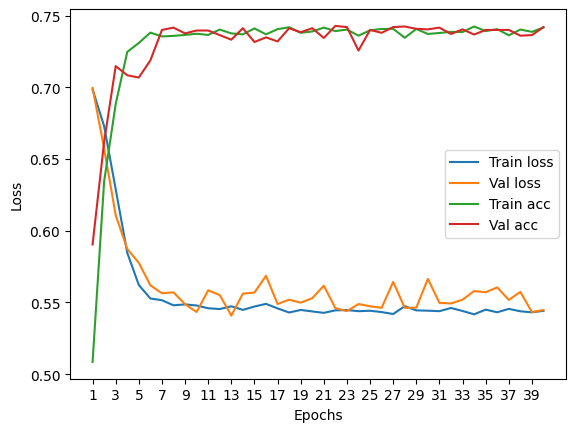

****************************************************************************************************



118it [00:00, 154.92it/s]


Train Epoch: 0 	Loss: 0.697354, Accuracy: 3818/7500 (51%)
Val Epoch: 0 	Loss: 0.703893, Accuracy: 1435/2500 (57%)



118it [00:00, 155.19it/s]


Train Epoch: 1 	Loss: 0.679410, Accuracy: 4518/7500 (60%)
Val Epoch: 1 	Loss: 0.679577, Accuracy: 1539/2500 (62%)



118it [00:00, 163.84it/s]


Train Epoch: 2 	Loss: 0.653599, Accuracy: 4771/7500 (64%)
Val Epoch: 2 	Loss: 0.663662, Accuracy: 1549/2500 (62%)



118it [00:00, 169.58it/s]


Train Epoch: 3 	Loss: 0.626869, Accuracy: 5043/7500 (67%)
Val Epoch: 3 	Loss: 0.634411, Accuracy: 1704/2500 (68%)



118it [00:00, 158.56it/s]


Train Epoch: 4 	Loss: 0.596009, Accuracy: 5287/7500 (70%)
Val Epoch: 4 	Loss: 0.610593, Accuracy: 1759/2500 (70%)



118it [00:00, 170.70it/s]


Train Epoch: 5 	Loss: 0.572706, Accuracy: 5476/7500 (73%)
Val Epoch: 5 	Loss: 0.588164, Accuracy: 1801/2500 (72%)



118it [00:00, 167.33it/s]


Train Epoch: 6 	Loss: 0.558576, Accuracy: 5502/7500 (73%)
Val Epoch: 6 	Loss: 0.578006, Accuracy: 1811/2500 (72%)



118it [00:00, 156.99it/s]


Train Epoch: 7 	Loss: 0.548069, Accuracy: 5555/7500 (74%)
Val Epoch: 7 	Loss: 0.574178, Accuracy: 1777/2500 (71%)



118it [00:00, 187.50it/s]


Train Epoch: 8 	Loss: 0.543905, Accuracy: 5568/7500 (74%)
Val Epoch: 8 	Loss: 0.569779, Accuracy: 1838/2500 (74%)



118it [00:00, 156.45it/s]


Train Epoch: 9 	Loss: 0.546896, Accuracy: 5569/7500 (74%)
Val Epoch: 9 	Loss: 0.573571, Accuracy: 1828/2500 (73%)



118it [00:00, 173.21it/s]


Train Epoch: 10 	Loss: 0.541405, Accuracy: 5565/7500 (74%)
Val Epoch: 10 	Loss: 0.576694, Accuracy: 1795/2500 (72%)



118it [00:00, 170.92it/s]


Train Epoch: 11 	Loss: 0.542229, Accuracy: 5559/7500 (74%)
Val Epoch: 11 	Loss: 0.571700, Accuracy: 1826/2500 (73%)



118it [00:00, 153.15it/s]


Train Epoch: 12 	Loss: 0.543436, Accuracy: 5589/7500 (75%)
Val Epoch: 12 	Loss: 0.572991, Accuracy: 1831/2500 (73%)



118it [00:00, 149.67it/s]


Train Epoch: 13 	Loss: 0.541485, Accuracy: 5553/7500 (74%)
Val Epoch: 13 	Loss: 0.568889, Accuracy: 1823/2500 (73%)



118it [00:00, 131.44it/s]


Train Epoch: 14 	Loss: 0.540380, Accuracy: 5578/7500 (74%)
Val Epoch: 14 	Loss: 0.583694, Accuracy: 1800/2500 (72%)



118it [00:01, 114.69it/s]


Train Epoch: 15 	Loss: 0.542817, Accuracy: 5567/7500 (74%)
Val Epoch: 15 	Loss: 0.571862, Accuracy: 1832/2500 (73%)



118it [00:00, 149.22it/s]


Train Epoch: 16 	Loss: 0.539094, Accuracy: 5559/7500 (74%)
Val Epoch: 16 	Loss: 0.575526, Accuracy: 1820/2500 (73%)



118it [00:00, 128.52it/s]


Train Epoch: 17 	Loss: 0.540918, Accuracy: 5539/7500 (74%)
Val Epoch: 17 	Loss: 0.580208, Accuracy: 1787/2500 (71%)



118it [00:00, 148.31it/s]


Train Epoch: 18 	Loss: 0.540635, Accuracy: 5573/7500 (74%)
Val Epoch: 18 	Loss: 0.576717, Accuracy: 1825/2500 (73%)



118it [00:00, 125.67it/s]


Train Epoch: 19 	Loss: 0.541152, Accuracy: 5583/7500 (74%)
Val Epoch: 19 	Loss: 0.574015, Accuracy: 1828/2500 (73%)



118it [00:01, 98.52it/s]


Train Epoch: 20 	Loss: 0.540596, Accuracy: 5588/7500 (75%)
Val Epoch: 20 	Loss: 0.567573, Accuracy: 1831/2500 (73%)



118it [00:01, 112.23it/s]


Train Epoch: 21 	Loss: 0.541446, Accuracy: 5587/7500 (74%)
Val Epoch: 21 	Loss: 0.570395, Accuracy: 1827/2500 (73%)



118it [00:00, 136.43it/s]


Train Epoch: 22 	Loss: 0.539489, Accuracy: 5577/7500 (74%)
Val Epoch: 22 	Loss: 0.597144, Accuracy: 1819/2500 (73%)



118it [00:00, 160.28it/s]


Train Epoch: 23 	Loss: 0.540799, Accuracy: 5563/7500 (74%)
Val Epoch: 23 	Loss: 0.575603, Accuracy: 1815/2500 (73%)



118it [00:00, 145.43it/s]


Train Epoch: 24 	Loss: 0.539466, Accuracy: 5576/7500 (74%)
Val Epoch: 24 	Loss: 0.577464, Accuracy: 1827/2500 (73%)



118it [00:00, 158.34it/s]


Train Epoch: 25 	Loss: 0.540773, Accuracy: 5573/7500 (74%)
Val Epoch: 25 	Loss: 0.570868, Accuracy: 1810/2500 (72%)



118it [00:01, 114.01it/s]


Train Epoch: 26 	Loss: 0.540909, Accuracy: 5596/7500 (75%)
Val Epoch: 26 	Loss: 0.573303, Accuracy: 1831/2500 (73%)



118it [00:00, 143.06it/s]


Train Epoch: 27 	Loss: 0.538874, Accuracy: 5581/7500 (74%)
Val Epoch: 27 	Loss: 0.561974, Accuracy: 1823/2500 (73%)



118it [00:01, 115.86it/s]


Train Epoch: 28 	Loss: 0.543037, Accuracy: 5548/7500 (74%)
Val Epoch: 28 	Loss: 0.576077, Accuracy: 1831/2500 (73%)



118it [00:01, 102.48it/s]


Train Epoch: 29 	Loss: 0.542739, Accuracy: 5591/7500 (75%)
Val Epoch: 29 	Loss: 0.569913, Accuracy: 1831/2500 (73%)



118it [00:00, 165.23it/s]


Train Epoch: 30 	Loss: 0.542829, Accuracy: 5584/7500 (74%)
Val Epoch: 30 	Loss: 0.576285, Accuracy: 1780/2500 (71%)



118it [00:00, 143.20it/s]


Train Epoch: 31 	Loss: 0.538259, Accuracy: 5579/7500 (74%)
Val Epoch: 31 	Loss: 0.576069, Accuracy: 1814/2500 (73%)



118it [00:00, 151.34it/s]


Train Epoch: 32 	Loss: 0.540621, Accuracy: 5594/7500 (75%)
Val Epoch: 32 	Loss: 0.562063, Accuracy: 1842/2500 (74%)



118it [00:00, 140.01it/s]


Train Epoch: 33 	Loss: 0.538361, Accuracy: 5585/7500 (74%)
Val Epoch: 33 	Loss: 0.568822, Accuracy: 1831/2500 (73%)



118it [00:01, 98.43it/s] 


Train Epoch: 34 	Loss: 0.541008, Accuracy: 5568/7500 (74%)
Val Epoch: 34 	Loss: 0.563722, Accuracy: 1833/2500 (73%)



118it [00:00, 124.35it/s]


Train Epoch: 35 	Loss: 0.539389, Accuracy: 5547/7500 (74%)
Val Epoch: 35 	Loss: 0.575198, Accuracy: 1814/2500 (73%)



118it [00:01, 115.69it/s]


Train Epoch: 36 	Loss: 0.543138, Accuracy: 5588/7500 (75%)
Val Epoch: 36 	Loss: 0.565577, Accuracy: 1832/2500 (73%)



118it [00:01, 95.63it/s]


Train Epoch: 37 	Loss: 0.539997, Accuracy: 5569/7500 (74%)
Val Epoch: 37 	Loss: 0.581665, Accuracy: 1813/2500 (73%)



118it [00:00, 139.07it/s]


Train Epoch: 38 	Loss: 0.540500, Accuracy: 5590/7500 (75%)
Val Epoch: 38 	Loss: 0.574655, Accuracy: 1827/2500 (73%)



118it [00:00, 140.52it/s]


Train Epoch: 39 	Loss: 0.541618, Accuracy: 5576/7500 (74%)
Val Epoch: 39 	Loss: 0.579554, Accuracy: 1827/2500 (73%)

Test accuracy:  72.76


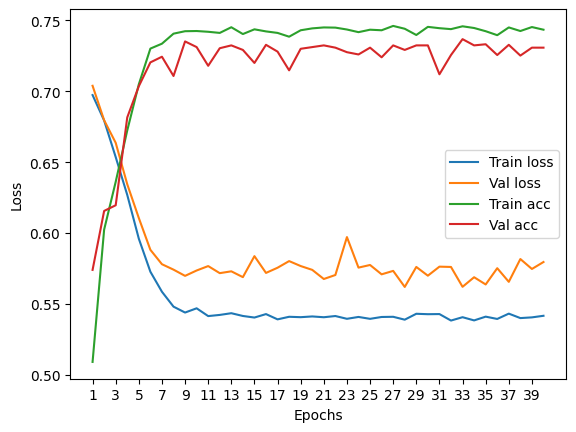

****************************************************************************************************



118it [00:00, 118.68it/s]


Train Epoch: 0 	Loss: 0.694643, Accuracy: 4058/7500 (54%)
Val Epoch: 0 	Loss: 0.700139, Accuracy: 1416/2500 (57%)



118it [00:00, 160.13it/s]


Train Epoch: 1 	Loss: 0.679348, Accuracy: 4390/7500 (59%)
Val Epoch: 1 	Loss: 0.676075, Accuracy: 1537/2500 (61%)



118it [00:00, 158.72it/s]


Train Epoch: 2 	Loss: 0.651055, Accuracy: 4833/7500 (64%)
Val Epoch: 2 	Loss: 0.643635, Accuracy: 1662/2500 (66%)



118it [00:00, 140.68it/s]


Train Epoch: 3 	Loss: 0.605452, Accuracy: 5246/7500 (70%)
Val Epoch: 3 	Loss: 0.595145, Accuracy: 1828/2500 (73%)



118it [00:00, 156.84it/s]


Train Epoch: 4 	Loss: 0.573676, Accuracy: 5424/7500 (72%)
Val Epoch: 4 	Loss: 0.572540, Accuracy: 1807/2500 (72%)



118it [00:00, 143.02it/s]


Train Epoch: 5 	Loss: 0.560528, Accuracy: 5452/7500 (73%)
Val Epoch: 5 	Loss: 0.568706, Accuracy: 1855/2500 (74%)



118it [00:01, 116.59it/s]


Train Epoch: 6 	Loss: 0.560082, Accuracy: 5459/7500 (73%)
Val Epoch: 6 	Loss: 0.568084, Accuracy: 1848/2500 (74%)



118it [00:00, 126.43it/s]


Train Epoch: 7 	Loss: 0.554931, Accuracy: 5496/7500 (73%)
Val Epoch: 7 	Loss: 0.561846, Accuracy: 1817/2500 (73%)



118it [00:00, 126.25it/s]


Train Epoch: 8 	Loss: 0.554794, Accuracy: 5492/7500 (73%)
Val Epoch: 8 	Loss: 0.569268, Accuracy: 1780/2500 (71%)



118it [00:00, 133.87it/s]


Train Epoch: 9 	Loss: 0.553508, Accuracy: 5515/7500 (74%)
Val Epoch: 9 	Loss: 0.561031, Accuracy: 1857/2500 (74%)



118it [00:00, 119.85it/s]


Train Epoch: 10 	Loss: 0.556024, Accuracy: 5493/7500 (73%)
Val Epoch: 10 	Loss: 0.569588, Accuracy: 1818/2500 (73%)



118it [00:01, 113.33it/s]


Train Epoch: 11 	Loss: 0.553943, Accuracy: 5472/7500 (73%)
Val Epoch: 11 	Loss: 0.567875, Accuracy: 1856/2500 (74%)



118it [00:01, 94.15it/s] 


Train Epoch: 12 	Loss: 0.552881, Accuracy: 5490/7500 (73%)
Val Epoch: 12 	Loss: 0.565620, Accuracy: 1822/2500 (73%)



118it [00:00, 120.29it/s]


Train Epoch: 13 	Loss: 0.555836, Accuracy: 5497/7500 (73%)
Val Epoch: 13 	Loss: 0.556178, Accuracy: 1858/2500 (74%)



118it [00:01, 114.78it/s]


Train Epoch: 14 	Loss: 0.553710, Accuracy: 5500/7500 (73%)
Val Epoch: 14 	Loss: 0.560339, Accuracy: 1848/2500 (74%)



118it [00:00, 141.98it/s]


Train Epoch: 15 	Loss: 0.551812, Accuracy: 5506/7500 (73%)
Val Epoch: 15 	Loss: 0.562544, Accuracy: 1821/2500 (73%)



118it [00:00, 151.76it/s]


Train Epoch: 16 	Loss: 0.552915, Accuracy: 5497/7500 (73%)
Val Epoch: 16 	Loss: 0.556068, Accuracy: 1851/2500 (74%)



118it [00:00, 159.32it/s]


Train Epoch: 17 	Loss: 0.553750, Accuracy: 5499/7500 (73%)
Val Epoch: 17 	Loss: 0.558521, Accuracy: 1808/2500 (72%)



118it [00:00, 153.35it/s]


Train Epoch: 18 	Loss: 0.554778, Accuracy: 5518/7500 (74%)
Val Epoch: 18 	Loss: 0.563286, Accuracy: 1848/2500 (74%)



118it [00:01, 98.10it/s] 


Train Epoch: 19 	Loss: 0.553852, Accuracy: 5504/7500 (73%)
Val Epoch: 19 	Loss: 0.559950, Accuracy: 1827/2500 (73%)



118it [00:00, 125.93it/s]


Train Epoch: 20 	Loss: 0.552743, Accuracy: 5515/7500 (74%)
Val Epoch: 20 	Loss: 0.555727, Accuracy: 1868/2500 (75%)



118it [00:00, 165.15it/s]


Train Epoch: 21 	Loss: 0.552259, Accuracy: 5489/7500 (73%)
Val Epoch: 21 	Loss: 0.559106, Accuracy: 1843/2500 (74%)



118it [00:00, 159.11it/s]


Train Epoch: 22 	Loss: 0.552007, Accuracy: 5490/7500 (73%)
Val Epoch: 22 	Loss: 0.553863, Accuracy: 1877/2500 (75%)



118it [00:00, 157.14it/s]


Train Epoch: 23 	Loss: 0.553065, Accuracy: 5499/7500 (73%)
Val Epoch: 23 	Loss: 0.562570, Accuracy: 1877/2500 (75%)



118it [00:00, 165.88it/s]


Train Epoch: 24 	Loss: 0.554200, Accuracy: 5507/7500 (73%)
Val Epoch: 24 	Loss: 0.560872, Accuracy: 1856/2500 (74%)



118it [00:00, 152.79it/s]


Train Epoch: 25 	Loss: 0.553252, Accuracy: 5468/7500 (73%)
Val Epoch: 25 	Loss: 0.565806, Accuracy: 1821/2500 (73%)



118it [00:00, 139.93it/s]


Train Epoch: 26 	Loss: 0.550974, Accuracy: 5521/7500 (74%)
Val Epoch: 26 	Loss: 0.557762, Accuracy: 1839/2500 (74%)



118it [00:00, 138.55it/s]


Train Epoch: 27 	Loss: 0.552789, Accuracy: 5501/7500 (73%)
Val Epoch: 27 	Loss: 0.565651, Accuracy: 1854/2500 (74%)



118it [00:00, 154.68it/s]


Train Epoch: 28 	Loss: 0.552143, Accuracy: 5491/7500 (73%)
Val Epoch: 28 	Loss: 0.567865, Accuracy: 1801/2500 (72%)



118it [00:00, 124.71it/s]


Train Epoch: 29 	Loss: 0.552452, Accuracy: 5514/7500 (74%)
Val Epoch: 29 	Loss: 0.554568, Accuracy: 1866/2500 (75%)



118it [00:01, 88.48it/s]


Train Epoch: 30 	Loss: 0.553539, Accuracy: 5496/7500 (73%)
Val Epoch: 30 	Loss: 0.551053, Accuracy: 1868/2500 (75%)



118it [00:01, 115.63it/s]


Train Epoch: 31 	Loss: 0.553022, Accuracy: 5509/7500 (73%)
Val Epoch: 31 	Loss: 0.560231, Accuracy: 1851/2500 (74%)



118it [00:01, 116.04it/s]


Train Epoch: 32 	Loss: 0.551010, Accuracy: 5488/7500 (73%)
Val Epoch: 32 	Loss: 0.555334, Accuracy: 1864/2500 (75%)



118it [00:00, 143.72it/s]


Train Epoch: 33 	Loss: 0.553749, Accuracy: 5495/7500 (73%)
Val Epoch: 33 	Loss: 0.553835, Accuracy: 1854/2500 (74%)



118it [00:01, 117.05it/s]


Train Epoch: 34 	Loss: 0.551331, Accuracy: 5534/7500 (74%)
Val Epoch: 34 	Loss: 0.564165, Accuracy: 1808/2500 (72%)



118it [00:00, 119.56it/s]


Train Epoch: 35 	Loss: 0.552888, Accuracy: 5505/7500 (73%)
Val Epoch: 35 	Loss: 0.563750, Accuracy: 1836/2500 (73%)



118it [00:00, 119.72it/s]


Train Epoch: 36 	Loss: 0.553818, Accuracy: 5527/7500 (74%)
Val Epoch: 36 	Loss: 0.559353, Accuracy: 1839/2500 (74%)



118it [00:00, 120.89it/s]


Train Epoch: 37 	Loss: 0.553332, Accuracy: 5502/7500 (73%)
Val Epoch: 37 	Loss: 0.555857, Accuracy: 1843/2500 (74%)



118it [00:01, 104.68it/s]


Train Epoch: 38 	Loss: 0.552799, Accuracy: 5507/7500 (73%)
Val Epoch: 38 	Loss: 0.556161, Accuracy: 1841/2500 (74%)



118it [00:00, 131.37it/s]


Train Epoch: 39 	Loss: 0.555615, Accuracy: 5494/7500 (73%)
Val Epoch: 39 	Loss: 0.555386, Accuracy: 1833/2500 (73%)

Test accuracy:  74.24


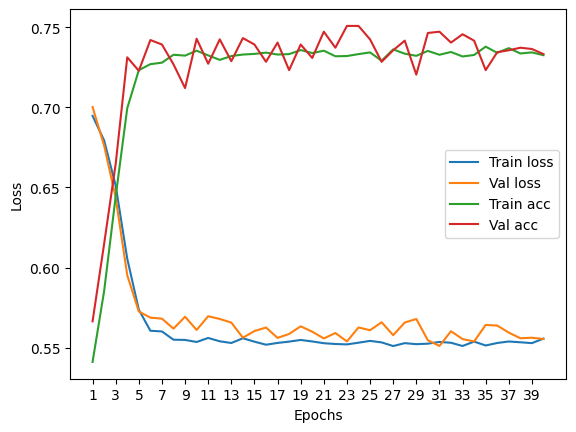

****************************************************************************************************



116it [00:00, 154.37it/s]


Train Epoch: 0 	Loss: 0.691677, Accuracy: 3912/7422 (53%)
Val Epoch: 0 	Loss: 0.691644, Accuracy: 1378/2474 (56%)



116it [00:00, 171.12it/s]


Train Epoch: 1 	Loss: 0.676824, Accuracy: 4356/7422 (59%)
Val Epoch: 1 	Loss: 0.672807, Accuracy: 1513/2474 (61%)



116it [00:00, 144.46it/s]


Train Epoch: 2 	Loss: 0.652082, Accuracy: 4731/7422 (64%)
Val Epoch: 2 	Loss: 0.636960, Accuracy: 1685/2474 (68%)



116it [00:00, 162.78it/s]


Train Epoch: 3 	Loss: 0.616809, Accuracy: 5112/7422 (69%)
Val Epoch: 3 	Loss: 0.591710, Accuracy: 1794/2474 (73%)



116it [00:00, 156.89it/s]


Train Epoch: 4 	Loss: 0.579115, Accuracy: 5368/7422 (72%)
Val Epoch: 4 	Loss: 0.562442, Accuracy: 1843/2474 (74%)



116it [00:00, 137.67it/s]


Train Epoch: 5 	Loss: 0.563011, Accuracy: 5385/7422 (73%)
Val Epoch: 5 	Loss: 0.546859, Accuracy: 1813/2474 (73%)



116it [00:00, 126.54it/s]


Train Epoch: 6 	Loss: 0.554573, Accuracy: 5425/7422 (73%)
Val Epoch: 6 	Loss: 0.539046, Accuracy: 1865/2474 (75%)



116it [00:01, 104.40it/s]


Train Epoch: 7 	Loss: 0.549240, Accuracy: 5449/7422 (73%)
Val Epoch: 7 	Loss: 0.543421, Accuracy: 1860/2474 (75%)



116it [00:01, 85.77it/s] 


Train Epoch: 8 	Loss: 0.547932, Accuracy: 5479/7422 (74%)
Val Epoch: 8 	Loss: 0.533286, Accuracy: 1850/2474 (75%)



116it [00:00, 116.15it/s]


Train Epoch: 9 	Loss: 0.546980, Accuracy: 5451/7422 (73%)
Val Epoch: 9 	Loss: 0.542086, Accuracy: 1847/2474 (75%)



116it [00:01, 104.86it/s]


Train Epoch: 10 	Loss: 0.546966, Accuracy: 5469/7422 (74%)
Val Epoch: 10 	Loss: 0.533035, Accuracy: 1858/2474 (75%)



116it [00:00, 125.84it/s]


Train Epoch: 11 	Loss: 0.546223, Accuracy: 5477/7422 (74%)
Val Epoch: 11 	Loss: 0.531518, Accuracy: 1855/2474 (75%)



116it [00:00, 118.30it/s]


Train Epoch: 12 	Loss: 0.547243, Accuracy: 5480/7422 (74%)
Val Epoch: 12 	Loss: 0.531354, Accuracy: 1844/2474 (75%)



116it [00:01, 105.65it/s]


Train Epoch: 13 	Loss: 0.545618, Accuracy: 5480/7422 (74%)
Val Epoch: 13 	Loss: 0.531283, Accuracy: 1872/2474 (76%)



116it [00:01, 115.06it/s]


Train Epoch: 14 	Loss: 0.545104, Accuracy: 5452/7422 (73%)
Val Epoch: 14 	Loss: 0.531336, Accuracy: 1858/2474 (75%)



116it [00:01, 111.86it/s]


Train Epoch: 15 	Loss: 0.546037, Accuracy: 5467/7422 (74%)
Val Epoch: 15 	Loss: 0.534658, Accuracy: 1876/2474 (76%)



116it [00:01, 102.34it/s]


Train Epoch: 16 	Loss: 0.544757, Accuracy: 5480/7422 (74%)
Val Epoch: 16 	Loss: 0.531587, Accuracy: 1833/2474 (74%)



116it [00:01, 111.61it/s]


Train Epoch: 17 	Loss: 0.544141, Accuracy: 5481/7422 (74%)
Val Epoch: 17 	Loss: 0.531322, Accuracy: 1847/2474 (75%)



116it [00:01, 99.79it/s]


Train Epoch: 18 	Loss: 0.545364, Accuracy: 5470/7422 (74%)
Val Epoch: 18 	Loss: 0.532690, Accuracy: 1848/2474 (75%)



116it [00:01, 105.60it/s]


Train Epoch: 19 	Loss: 0.544534, Accuracy: 5465/7422 (74%)
Val Epoch: 19 	Loss: 0.533753, Accuracy: 1876/2474 (76%)



116it [00:01, 111.34it/s]


Train Epoch: 20 	Loss: 0.544541, Accuracy: 5470/7422 (74%)
Val Epoch: 20 	Loss: 0.532161, Accuracy: 1845/2474 (75%)



116it [00:01, 105.72it/s]


Train Epoch: 21 	Loss: 0.545349, Accuracy: 5474/7422 (74%)
Val Epoch: 21 	Loss: 0.530963, Accuracy: 1864/2474 (75%)



116it [00:01, 112.59it/s]


Train Epoch: 22 	Loss: 0.547041, Accuracy: 5455/7422 (73%)
Val Epoch: 22 	Loss: 0.530418, Accuracy: 1846/2474 (75%)



116it [00:00, 124.49it/s]


Train Epoch: 23 	Loss: 0.544898, Accuracy: 5490/7422 (74%)
Val Epoch: 23 	Loss: 0.530657, Accuracy: 1862/2474 (75%)



116it [00:00, 141.49it/s]


Train Epoch: 24 	Loss: 0.544240, Accuracy: 5471/7422 (74%)
Val Epoch: 24 	Loss: 0.531707, Accuracy: 1859/2474 (75%)



116it [00:00, 158.78it/s]


Train Epoch: 25 	Loss: 0.544197, Accuracy: 5478/7422 (74%)
Val Epoch: 25 	Loss: 0.531699, Accuracy: 1864/2474 (75%)



116it [00:00, 176.61it/s]


Train Epoch: 26 	Loss: 0.545573, Accuracy: 5490/7422 (74%)
Val Epoch: 26 	Loss: 0.531355, Accuracy: 1853/2474 (75%)



116it [00:00, 152.17it/s]


Train Epoch: 27 	Loss: 0.543768, Accuracy: 5502/7422 (74%)
Val Epoch: 27 	Loss: 0.531560, Accuracy: 1858/2474 (75%)



116it [00:00, 166.11it/s]


Train Epoch: 28 	Loss: 0.545909, Accuracy: 5442/7422 (73%)
Val Epoch: 28 	Loss: 0.532279, Accuracy: 1881/2474 (76%)



116it [00:00, 172.67it/s]


Train Epoch: 29 	Loss: 0.544344, Accuracy: 5497/7422 (74%)
Val Epoch: 29 	Loss: 0.530866, Accuracy: 1854/2474 (75%)



116it [00:00, 125.18it/s]


Train Epoch: 30 	Loss: 0.544388, Accuracy: 5463/7422 (74%)
Val Epoch: 30 	Loss: 0.530972, Accuracy: 1857/2474 (75%)



116it [00:00, 139.80it/s]


Train Epoch: 31 	Loss: 0.544491, Accuracy: 5467/7422 (74%)
Val Epoch: 31 	Loss: 0.532760, Accuracy: 1844/2474 (75%)



116it [00:01, 101.43it/s]


Train Epoch: 32 	Loss: 0.543476, Accuracy: 5465/7422 (74%)
Val Epoch: 32 	Loss: 0.531457, Accuracy: 1863/2474 (75%)



116it [00:02, 55.46it/s]


Train Epoch: 33 	Loss: 0.543973, Accuracy: 5486/7422 (74%)
Val Epoch: 33 	Loss: 0.531025, Accuracy: 1845/2474 (75%)



116it [00:01, 86.79it/s]


Train Epoch: 34 	Loss: 0.543745, Accuracy: 5473/7422 (74%)
Val Epoch: 34 	Loss: 0.531222, Accuracy: 1858/2474 (75%)



116it [00:01, 102.86it/s]


Train Epoch: 35 	Loss: 0.543924, Accuracy: 5490/7422 (74%)
Val Epoch: 35 	Loss: 0.530795, Accuracy: 1872/2474 (76%)



116it [00:01, 106.16it/s]


Train Epoch: 36 	Loss: 0.544994, Accuracy: 5483/7422 (74%)
Val Epoch: 36 	Loss: 0.533737, Accuracy: 1869/2474 (76%)



116it [00:00, 143.52it/s]


Train Epoch: 37 	Loss: 0.543964, Accuracy: 5495/7422 (74%)
Val Epoch: 37 	Loss: 0.533945, Accuracy: 1867/2474 (75%)



116it [00:00, 161.48it/s]


Train Epoch: 38 	Loss: 0.544085, Accuracy: 5479/7422 (74%)
Val Epoch: 38 	Loss: 0.535359, Accuracy: 1877/2474 (76%)



116it [00:00, 124.80it/s]


Train Epoch: 39 	Loss: 0.546409, Accuracy: 5461/7422 (74%)
Val Epoch: 39 	Loss: 0.535023, Accuracy: 1830/2474 (74%)

Test accuracy:  74.6160064672595


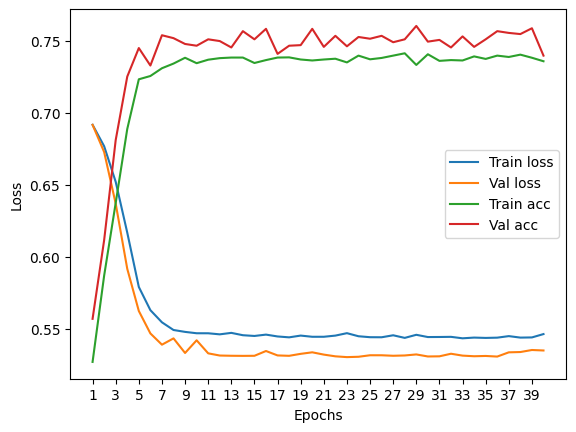

****************************************************************************************************



Particles per jet: 10


118it [00:00, 139.20it/s]


Train Epoch: 0 	Loss: 0.695868, Accuracy: 3899/7500 (52%)
Val Epoch: 0 	Loss: 0.703550, Accuracy: 1405/2500 (56%)



118it [00:01, 117.73it/s]


Train Epoch: 1 	Loss: 0.684739, Accuracy: 4248/7500 (57%)
Val Epoch: 1 	Loss: 0.683154, Accuracy: 1534/2500 (61%)



118it [00:00, 143.87it/s]


Train Epoch: 2 	Loss: 0.662925, Accuracy: 4642/7500 (62%)
Val Epoch: 2 	Loss: 0.663623, Accuracy: 1642/2500 (66%)



118it [00:00, 143.08it/s]


Train Epoch: 3 	Loss: 0.634275, Accuracy: 4982/7500 (66%)
Val Epoch: 3 	Loss: 0.620188, Accuracy: 1738/2500 (70%)



118it [00:00, 155.30it/s]


Train Epoch: 4 	Loss: 0.598284, Accuracy: 5311/7500 (71%)
Val Epoch: 4 	Loss: 0.592120, Accuracy: 1809/2500 (72%)



118it [00:00, 144.54it/s]


Train Epoch: 5 	Loss: 0.575021, Accuracy: 5449/7500 (73%)
Val Epoch: 5 	Loss: 0.566227, Accuracy: 1874/2500 (75%)



118it [00:00, 153.58it/s]


Train Epoch: 6 	Loss: 0.558950, Accuracy: 5508/7500 (73%)
Val Epoch: 6 	Loss: 0.559046, Accuracy: 1846/2500 (74%)



118it [00:00, 164.52it/s]


Train Epoch: 7 	Loss: 0.551128, Accuracy: 5546/7500 (74%)
Val Epoch: 7 	Loss: 0.556797, Accuracy: 1862/2500 (74%)



118it [00:00, 151.61it/s]


Train Epoch: 8 	Loss: 0.548865, Accuracy: 5535/7500 (74%)
Val Epoch: 8 	Loss: 0.549679, Accuracy: 1874/2500 (75%)



118it [00:00, 146.37it/s]


Train Epoch: 9 	Loss: 0.546082, Accuracy: 5557/7500 (74%)
Val Epoch: 9 	Loss: 0.538729, Accuracy: 1887/2500 (75%)



118it [00:00, 162.34it/s]


Train Epoch: 10 	Loss: 0.540519, Accuracy: 5580/7500 (74%)
Val Epoch: 10 	Loss: 0.540726, Accuracy: 1880/2500 (75%)



118it [00:00, 155.85it/s]


Train Epoch: 11 	Loss: 0.540405, Accuracy: 5552/7500 (74%)
Val Epoch: 11 	Loss: 0.545102, Accuracy: 1889/2500 (76%)



118it [00:00, 177.43it/s]


Train Epoch: 12 	Loss: 0.539798, Accuracy: 5569/7500 (74%)
Val Epoch: 12 	Loss: 0.539977, Accuracy: 1886/2500 (75%)



118it [00:00, 157.48it/s]


Train Epoch: 13 	Loss: 0.539551, Accuracy: 5580/7500 (74%)
Val Epoch: 13 	Loss: 0.535004, Accuracy: 1889/2500 (76%)



118it [00:00, 155.35it/s]


Train Epoch: 14 	Loss: 0.539182, Accuracy: 5575/7500 (74%)
Val Epoch: 14 	Loss: 0.546287, Accuracy: 1900/2500 (76%)



118it [00:00, 158.77it/s]


Train Epoch: 15 	Loss: 0.541449, Accuracy: 5547/7500 (74%)
Val Epoch: 15 	Loss: 0.541333, Accuracy: 1883/2500 (75%)



118it [00:00, 150.62it/s]


Train Epoch: 16 	Loss: 0.538996, Accuracy: 5568/7500 (74%)
Val Epoch: 16 	Loss: 0.545756, Accuracy: 1894/2500 (76%)



118it [00:00, 158.89it/s]


Train Epoch: 17 	Loss: 0.537893, Accuracy: 5601/7500 (75%)
Val Epoch: 17 	Loss: 0.542017, Accuracy: 1883/2500 (75%)



118it [00:01, 116.87it/s]


Train Epoch: 18 	Loss: 0.540404, Accuracy: 5555/7500 (74%)
Val Epoch: 18 	Loss: 0.552544, Accuracy: 1869/2500 (75%)



118it [00:00, 140.76it/s]


Train Epoch: 19 	Loss: 0.537851, Accuracy: 5591/7500 (75%)
Val Epoch: 19 	Loss: 0.530785, Accuracy: 1893/2500 (76%)



118it [00:00, 121.74it/s]


Train Epoch: 20 	Loss: 0.538077, Accuracy: 5561/7500 (74%)
Val Epoch: 20 	Loss: 0.544949, Accuracy: 1890/2500 (76%)



118it [00:01, 115.70it/s]


Train Epoch: 21 	Loss: 0.538944, Accuracy: 5589/7500 (75%)
Val Epoch: 21 	Loss: 0.543941, Accuracy: 1863/2500 (75%)



118it [00:00, 142.30it/s]


Train Epoch: 22 	Loss: 0.538805, Accuracy: 5581/7500 (74%)
Val Epoch: 22 	Loss: 0.546454, Accuracy: 1886/2500 (75%)



118it [00:00, 138.93it/s]


Train Epoch: 23 	Loss: 0.539482, Accuracy: 5583/7500 (74%)
Val Epoch: 23 	Loss: 0.533823, Accuracy: 1886/2500 (75%)



118it [00:00, 168.33it/s]


Train Epoch: 24 	Loss: 0.538011, Accuracy: 5583/7500 (74%)
Val Epoch: 24 	Loss: 0.541062, Accuracy: 1894/2500 (76%)



118it [00:00, 174.75it/s]


Train Epoch: 25 	Loss: 0.536780, Accuracy: 5573/7500 (74%)
Val Epoch: 25 	Loss: 0.529198, Accuracy: 1897/2500 (76%)



118it [00:00, 156.20it/s]


Train Epoch: 26 	Loss: 0.538870, Accuracy: 5563/7500 (74%)
Val Epoch: 26 	Loss: 0.535378, Accuracy: 1904/2500 (76%)



118it [00:00, 176.19it/s]


Train Epoch: 27 	Loss: 0.540132, Accuracy: 5583/7500 (74%)
Val Epoch: 27 	Loss: 0.532676, Accuracy: 1904/2500 (76%)



118it [00:00, 169.93it/s]


Train Epoch: 28 	Loss: 0.537362, Accuracy: 5562/7500 (74%)
Val Epoch: 28 	Loss: 0.540362, Accuracy: 1886/2500 (75%)



118it [00:00, 155.83it/s]


Train Epoch: 29 	Loss: 0.536261, Accuracy: 5568/7500 (74%)
Val Epoch: 29 	Loss: 0.535801, Accuracy: 1888/2500 (76%)



118it [00:00, 133.12it/s]


Train Epoch: 30 	Loss: 0.537836, Accuracy: 5579/7500 (74%)
Val Epoch: 30 	Loss: 0.533402, Accuracy: 1892/2500 (76%)



118it [00:00, 146.47it/s]


Train Epoch: 31 	Loss: 0.537129, Accuracy: 5568/7500 (74%)
Val Epoch: 31 	Loss: 0.542453, Accuracy: 1896/2500 (76%)



118it [00:01, 114.99it/s]


Train Epoch: 32 	Loss: 0.538022, Accuracy: 5554/7500 (74%)
Val Epoch: 32 	Loss: 0.538788, Accuracy: 1901/2500 (76%)



118it [00:01, 95.36it/s] 


Train Epoch: 33 	Loss: 0.537518, Accuracy: 5579/7500 (74%)
Val Epoch: 33 	Loss: 0.534700, Accuracy: 1896/2500 (76%)



118it [00:01, 82.08it/s]


Train Epoch: 34 	Loss: 0.539405, Accuracy: 5553/7500 (74%)
Val Epoch: 34 	Loss: 0.545260, Accuracy: 1893/2500 (76%)



118it [00:01, 100.42it/s]


Train Epoch: 35 	Loss: 0.540145, Accuracy: 5561/7500 (74%)
Val Epoch: 35 	Loss: 0.533320, Accuracy: 1893/2500 (76%)



118it [00:01, 73.64it/s]


Train Epoch: 36 	Loss: 0.536854, Accuracy: 5578/7500 (74%)
Val Epoch: 36 	Loss: 0.532807, Accuracy: 1898/2500 (76%)



118it [00:01, 94.00it/s]


Train Epoch: 37 	Loss: 0.538591, Accuracy: 5553/7500 (74%)
Val Epoch: 37 	Loss: 0.538358, Accuracy: 1901/2500 (76%)



118it [00:01, 91.71it/s] 


Train Epoch: 38 	Loss: 0.538856, Accuracy: 5563/7500 (74%)
Val Epoch: 38 	Loss: 0.532679, Accuracy: 1898/2500 (76%)



118it [00:01, 101.02it/s]


Train Epoch: 39 	Loss: 0.537373, Accuracy: 5599/7500 (75%)
Val Epoch: 39 	Loss: 0.537344, Accuracy: 1891/2500 (76%)

Test accuracy:  73.88


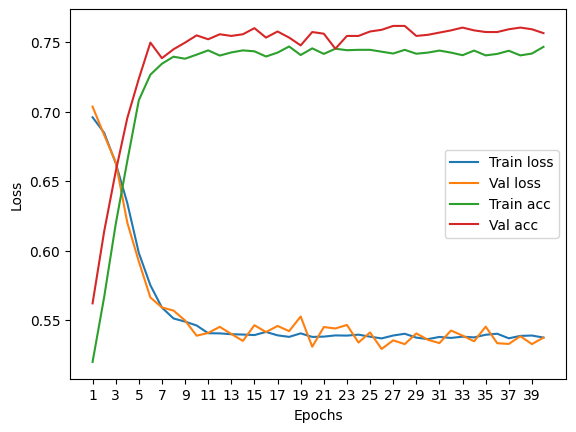

****************************************************************************************************



118it [00:00, 153.80it/s]


Train Epoch: 0 	Loss: 0.697072, Accuracy: 3921/7500 (52%)
Val Epoch: 0 	Loss: 0.706398, Accuracy: 1282/2500 (51%)



118it [00:00, 125.69it/s]


Train Epoch: 1 	Loss: 0.684227, Accuracy: 4466/7500 (60%)
Val Epoch: 1 	Loss: 0.679864, Accuracy: 1584/2500 (63%)



118it [00:00, 134.76it/s]


Train Epoch: 2 	Loss: 0.649071, Accuracy: 4958/7500 (66%)
Val Epoch: 2 	Loss: 0.630310, Accuracy: 1791/2500 (72%)



118it [00:00, 171.15it/s]


Train Epoch: 3 	Loss: 0.599912, Accuracy: 5365/7500 (72%)
Val Epoch: 3 	Loss: 0.599458, Accuracy: 1783/2500 (71%)



118it [00:00, 159.75it/s]


Train Epoch: 4 	Loss: 0.575322, Accuracy: 5434/7500 (72%)
Val Epoch: 4 	Loss: 0.584815, Accuracy: 1819/2500 (73%)



118it [00:00, 174.68it/s]


Train Epoch: 5 	Loss: 0.561999, Accuracy: 5489/7500 (73%)
Val Epoch: 5 	Loss: 0.571207, Accuracy: 1836/2500 (73%)



118it [00:00, 160.29it/s]


Train Epoch: 6 	Loss: 0.558514, Accuracy: 5490/7500 (73%)
Val Epoch: 6 	Loss: 0.569704, Accuracy: 1842/2500 (74%)



118it [00:00, 163.78it/s]


Train Epoch: 7 	Loss: 0.555699, Accuracy: 5516/7500 (74%)
Val Epoch: 7 	Loss: 0.564757, Accuracy: 1826/2500 (73%)



118it [00:00, 153.69it/s]


Train Epoch: 8 	Loss: 0.558824, Accuracy: 5457/7500 (73%)
Val Epoch: 8 	Loss: 0.566324, Accuracy: 1835/2500 (73%)



118it [00:00, 160.65it/s]


Train Epoch: 9 	Loss: 0.558933, Accuracy: 5472/7500 (73%)
Val Epoch: 9 	Loss: 0.567472, Accuracy: 1816/2500 (73%)



118it [00:00, 142.23it/s]


Train Epoch: 10 	Loss: 0.555169, Accuracy: 5487/7500 (73%)
Val Epoch: 10 	Loss: 0.560646, Accuracy: 1846/2500 (74%)



118it [00:00, 144.79it/s]


Train Epoch: 11 	Loss: 0.554108, Accuracy: 5516/7500 (74%)
Val Epoch: 11 	Loss: 0.570354, Accuracy: 1841/2500 (74%)



118it [00:00, 156.66it/s]


Train Epoch: 12 	Loss: 0.555293, Accuracy: 5511/7500 (73%)
Val Epoch: 12 	Loss: 0.583825, Accuracy: 1838/2500 (74%)



118it [00:00, 160.47it/s]


Train Epoch: 13 	Loss: 0.557436, Accuracy: 5479/7500 (73%)
Val Epoch: 13 	Loss: 0.567249, Accuracy: 1838/2500 (74%)



118it [00:00, 156.92it/s]


Train Epoch: 14 	Loss: 0.554007, Accuracy: 5485/7500 (73%)
Val Epoch: 14 	Loss: 0.565303, Accuracy: 1839/2500 (74%)



118it [00:00, 171.07it/s]


Train Epoch: 15 	Loss: 0.553760, Accuracy: 5537/7500 (74%)
Val Epoch: 15 	Loss: 0.569169, Accuracy: 1835/2500 (73%)



118it [00:00, 156.88it/s]


Train Epoch: 16 	Loss: 0.555086, Accuracy: 5504/7500 (73%)
Val Epoch: 16 	Loss: 0.560096, Accuracy: 1841/2500 (74%)



118it [00:00, 178.67it/s]


Train Epoch: 17 	Loss: 0.551346, Accuracy: 5510/7500 (73%)
Val Epoch: 17 	Loss: 0.574347, Accuracy: 1817/2500 (73%)



118it [00:00, 156.79it/s]


Train Epoch: 18 	Loss: 0.553053, Accuracy: 5506/7500 (73%)
Val Epoch: 18 	Loss: 0.571902, Accuracy: 1820/2500 (73%)



118it [00:00, 157.00it/s]


Train Epoch: 19 	Loss: 0.553751, Accuracy: 5491/7500 (73%)
Val Epoch: 19 	Loss: 0.574025, Accuracy: 1802/2500 (72%)



118it [00:00, 160.13it/s]


Train Epoch: 20 	Loss: 0.553712, Accuracy: 5499/7500 (73%)
Val Epoch: 20 	Loss: 0.567239, Accuracy: 1845/2500 (74%)



118it [00:00, 145.00it/s]


Train Epoch: 21 	Loss: 0.553558, Accuracy: 5503/7500 (73%)
Val Epoch: 21 	Loss: 0.571244, Accuracy: 1834/2500 (73%)



118it [00:00, 169.75it/s]


Train Epoch: 22 	Loss: 0.553574, Accuracy: 5512/7500 (73%)
Val Epoch: 22 	Loss: 0.583747, Accuracy: 1787/2500 (71%)



118it [00:00, 156.35it/s]


Train Epoch: 23 	Loss: 0.551629, Accuracy: 5502/7500 (73%)
Val Epoch: 23 	Loss: 0.574878, Accuracy: 1834/2500 (73%)



118it [00:00, 157.02it/s]


Train Epoch: 24 	Loss: 0.553127, Accuracy: 5506/7500 (73%)
Val Epoch: 24 	Loss: 0.569229, Accuracy: 1835/2500 (73%)



118it [00:00, 160.47it/s]


Train Epoch: 25 	Loss: 0.552933, Accuracy: 5512/7500 (73%)
Val Epoch: 25 	Loss: 0.564665, Accuracy: 1842/2500 (74%)



118it [00:00, 153.64it/s]


Train Epoch: 26 	Loss: 0.554879, Accuracy: 5513/7500 (74%)
Val Epoch: 26 	Loss: 0.560727, Accuracy: 1844/2500 (74%)



118it [00:00, 156.86it/s]


Train Epoch: 27 	Loss: 0.552709, Accuracy: 5534/7500 (74%)
Val Epoch: 27 	Loss: 0.568923, Accuracy: 1836/2500 (73%)



118it [00:00, 163.92it/s]


Train Epoch: 28 	Loss: 0.553582, Accuracy: 5527/7500 (74%)
Val Epoch: 28 	Loss: 0.583173, Accuracy: 1829/2500 (73%)



118it [00:00, 160.21it/s]


Train Epoch: 29 	Loss: 0.552602, Accuracy: 5507/7500 (73%)
Val Epoch: 29 	Loss: 0.571174, Accuracy: 1842/2500 (74%)



118it [00:00, 154.06it/s]


Train Epoch: 30 	Loss: 0.553274, Accuracy: 5503/7500 (73%)
Val Epoch: 30 	Loss: 0.576733, Accuracy: 1843/2500 (74%)



118it [00:00, 167.43it/s]


Train Epoch: 31 	Loss: 0.553575, Accuracy: 5491/7500 (73%)
Val Epoch: 31 	Loss: 0.571509, Accuracy: 1826/2500 (73%)



118it [00:00, 175.38it/s]


Train Epoch: 32 	Loss: 0.551955, Accuracy: 5520/7500 (74%)
Val Epoch: 32 	Loss: 0.566371, Accuracy: 1821/2500 (73%)



118it [00:00, 156.92it/s]


Train Epoch: 33 	Loss: 0.551867, Accuracy: 5506/7500 (73%)
Val Epoch: 33 	Loss: 0.571696, Accuracy: 1849/2500 (74%)



118it [00:00, 144.93it/s]


Train Epoch: 34 	Loss: 0.554326, Accuracy: 5494/7500 (73%)
Val Epoch: 34 	Loss: 0.570068, Accuracy: 1842/2500 (74%)



118it [00:00, 183.84it/s]


Train Epoch: 35 	Loss: 0.551937, Accuracy: 5520/7500 (74%)
Val Epoch: 35 	Loss: 0.560290, Accuracy: 1826/2500 (73%)



118it [00:00, 142.07it/s]


Train Epoch: 36 	Loss: 0.554702, Accuracy: 5500/7500 (73%)
Val Epoch: 36 	Loss: 0.576657, Accuracy: 1824/2500 (73%)



118it [00:00, 148.04it/s]


Train Epoch: 37 	Loss: 0.554761, Accuracy: 5515/7500 (74%)
Val Epoch: 37 	Loss: 0.563113, Accuracy: 1836/2500 (73%)



118it [00:00, 160.23it/s]


Train Epoch: 38 	Loss: 0.552363, Accuracy: 5510/7500 (73%)
Val Epoch: 38 	Loss: 0.564380, Accuracy: 1832/2500 (73%)



118it [00:00, 163.01it/s]


Train Epoch: 39 	Loss: 0.552629, Accuracy: 5488/7500 (73%)
Val Epoch: 39 	Loss: 0.564614, Accuracy: 1838/2500 (74%)

Test accuracy:  74.24


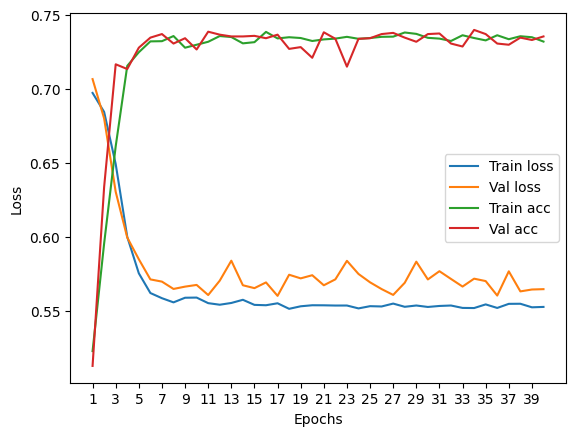

****************************************************************************************************



118it [00:00, 154.05it/s]


Train Epoch: 0 	Loss: 0.695782, Accuracy: 4008/7500 (53%)
Val Epoch: 0 	Loss: 0.701417, Accuracy: 1392/2500 (56%)



118it [00:00, 142.40it/s]


Train Epoch: 1 	Loss: 0.669620, Accuracy: 4658/7500 (62%)
Val Epoch: 1 	Loss: 0.654703, Accuracy: 1730/2500 (69%)



118it [00:00, 142.18it/s]


Train Epoch: 2 	Loss: 0.621807, Accuracy: 5260/7500 (70%)
Val Epoch: 2 	Loss: 0.603954, Accuracy: 1803/2500 (72%)



118it [00:00, 170.18it/s]


Train Epoch: 3 	Loss: 0.578066, Accuracy: 5483/7500 (73%)
Val Epoch: 3 	Loss: 0.566821, Accuracy: 1841/2500 (74%)



118it [00:00, 152.69it/s]


Train Epoch: 4 	Loss: 0.556484, Accuracy: 5495/7500 (73%)
Val Epoch: 4 	Loss: 0.562161, Accuracy: 1853/2500 (74%)



118it [00:00, 147.02it/s]


Train Epoch: 5 	Loss: 0.546815, Accuracy: 5534/7500 (74%)
Val Epoch: 5 	Loss: 0.548739, Accuracy: 1835/2500 (73%)



118it [00:01, 78.14it/s]


Train Epoch: 6 	Loss: 0.541375, Accuracy: 5570/7500 (74%)
Val Epoch: 6 	Loss: 0.540319, Accuracy: 1835/2500 (73%)



118it [00:01, 73.78it/s]


Train Epoch: 7 	Loss: 0.538007, Accuracy: 5576/7500 (74%)
Val Epoch: 7 	Loss: 0.541947, Accuracy: 1847/2500 (74%)



118it [00:00, 121.18it/s]


Train Epoch: 8 	Loss: 0.537235, Accuracy: 5585/7500 (74%)
Val Epoch: 8 	Loss: 0.536251, Accuracy: 1867/2500 (75%)



118it [00:01, 96.91it/s] 


Train Epoch: 9 	Loss: 0.535993, Accuracy: 5596/7500 (75%)
Val Epoch: 9 	Loss: 0.544385, Accuracy: 1827/2500 (73%)



118it [00:00, 154.07it/s]


Train Epoch: 10 	Loss: 0.538970, Accuracy: 5592/7500 (75%)
Val Epoch: 10 	Loss: 0.542108, Accuracy: 1842/2500 (74%)



118it [00:01, 113.54it/s]


Train Epoch: 11 	Loss: 0.534520, Accuracy: 5605/7500 (75%)
Val Epoch: 11 	Loss: 0.539362, Accuracy: 1833/2500 (73%)



118it [00:01, 95.73it/s]


Train Epoch: 12 	Loss: 0.536011, Accuracy: 5584/7500 (74%)
Val Epoch: 12 	Loss: 0.544973, Accuracy: 1843/2500 (74%)



118it [00:01, 90.00it/s]


Train Epoch: 13 	Loss: 0.535324, Accuracy: 5593/7500 (75%)
Val Epoch: 13 	Loss: 0.545035, Accuracy: 1854/2500 (74%)



118it [00:00, 118.25it/s]


Train Epoch: 14 	Loss: 0.535959, Accuracy: 5586/7500 (74%)
Val Epoch: 14 	Loss: 0.540236, Accuracy: 1853/2500 (74%)



118it [00:00, 124.90it/s]


Train Epoch: 15 	Loss: 0.534090, Accuracy: 5625/7500 (75%)
Val Epoch: 15 	Loss: 0.543313, Accuracy: 1850/2500 (74%)



118it [00:01, 98.79it/s] 


Train Epoch: 16 	Loss: 0.535911, Accuracy: 5599/7500 (75%)
Val Epoch: 16 	Loss: 0.542839, Accuracy: 1873/2500 (75%)



118it [00:00, 133.56it/s]


Train Epoch: 17 	Loss: 0.535403, Accuracy: 5600/7500 (75%)
Val Epoch: 17 	Loss: 0.544855, Accuracy: 1845/2500 (74%)



118it [00:00, 129.59it/s]


Train Epoch: 18 	Loss: 0.534482, Accuracy: 5624/7500 (75%)
Val Epoch: 18 	Loss: 0.563540, Accuracy: 1795/2500 (72%)



118it [00:00, 119.11it/s]


Train Epoch: 19 	Loss: 0.538957, Accuracy: 5573/7500 (74%)
Val Epoch: 19 	Loss: 0.533492, Accuracy: 1845/2500 (74%)



118it [00:00, 135.08it/s]


Train Epoch: 20 	Loss: 0.534792, Accuracy: 5610/7500 (75%)
Val Epoch: 20 	Loss: 0.552516, Accuracy: 1851/2500 (74%)



118it [00:00, 134.98it/s]


Train Epoch: 21 	Loss: 0.537308, Accuracy: 5585/7500 (74%)
Val Epoch: 21 	Loss: 0.535397, Accuracy: 1844/2500 (74%)



118it [00:00, 126.00it/s]


Train Epoch: 22 	Loss: 0.533245, Accuracy: 5631/7500 (75%)
Val Epoch: 22 	Loss: 0.545265, Accuracy: 1831/2500 (73%)



118it [00:00, 130.33it/s]


Train Epoch: 23 	Loss: 0.535181, Accuracy: 5612/7500 (75%)
Val Epoch: 23 	Loss: 0.535756, Accuracy: 1870/2500 (75%)



118it [00:00, 156.85it/s]


Train Epoch: 24 	Loss: 0.533085, Accuracy: 5608/7500 (75%)
Val Epoch: 24 	Loss: 0.532362, Accuracy: 1848/2500 (74%)



118it [00:00, 146.77it/s]


Train Epoch: 25 	Loss: 0.535211, Accuracy: 5618/7500 (75%)
Val Epoch: 25 	Loss: 0.536034, Accuracy: 1875/2500 (75%)



118it [00:00, 139.78it/s]


Train Epoch: 26 	Loss: 0.534656, Accuracy: 5581/7500 (74%)
Val Epoch: 26 	Loss: 0.543480, Accuracy: 1851/2500 (74%)



118it [00:01, 106.22it/s]


Train Epoch: 27 	Loss: 0.536213, Accuracy: 5630/7500 (75%)
Val Epoch: 27 	Loss: 0.543738, Accuracy: 1853/2500 (74%)



118it [00:00, 131.44it/s]


Train Epoch: 28 	Loss: 0.534343, Accuracy: 5611/7500 (75%)
Val Epoch: 28 	Loss: 0.535005, Accuracy: 1863/2500 (75%)



118it [00:01, 90.53it/s]


Train Epoch: 29 	Loss: 0.534348, Accuracy: 5611/7500 (75%)
Val Epoch: 29 	Loss: 0.538811, Accuracy: 1854/2500 (74%)



118it [00:01, 96.68it/s]


Train Epoch: 30 	Loss: 0.537280, Accuracy: 5583/7500 (74%)
Val Epoch: 30 	Loss: 0.537111, Accuracy: 1867/2500 (75%)



118it [00:01, 111.65it/s]


Train Epoch: 31 	Loss: 0.533829, Accuracy: 5651/7500 (75%)
Val Epoch: 31 	Loss: 0.536827, Accuracy: 1867/2500 (75%)



118it [00:01, 110.71it/s]


Train Epoch: 32 	Loss: 0.533373, Accuracy: 5620/7500 (75%)
Val Epoch: 32 	Loss: 0.536048, Accuracy: 1869/2500 (75%)



118it [00:00, 135.51it/s]


Train Epoch: 33 	Loss: 0.534496, Accuracy: 5603/7500 (75%)
Val Epoch: 33 	Loss: 0.535630, Accuracy: 1865/2500 (75%)



118it [00:00, 149.16it/s]


Train Epoch: 34 	Loss: 0.533904, Accuracy: 5608/7500 (75%)
Val Epoch: 34 	Loss: 0.531034, Accuracy: 1874/2500 (75%)



118it [00:00, 148.70it/s]


Train Epoch: 35 	Loss: 0.534862, Accuracy: 5594/7500 (75%)
Val Epoch: 35 	Loss: 0.544693, Accuracy: 1859/2500 (74%)



118it [00:00, 133.27it/s]


Train Epoch: 36 	Loss: 0.533161, Accuracy: 5618/7500 (75%)
Val Epoch: 36 	Loss: 0.538520, Accuracy: 1867/2500 (75%)



118it [00:00, 148.33it/s]


Train Epoch: 37 	Loss: 0.534481, Accuracy: 5636/7500 (75%)
Val Epoch: 37 	Loss: 0.540539, Accuracy: 1845/2500 (74%)



118it [00:00, 157.06it/s]


Train Epoch: 38 	Loss: 0.535849, Accuracy: 5633/7500 (75%)
Val Epoch: 38 	Loss: 0.554156, Accuracy: 1858/2500 (74%)



118it [00:00, 156.19it/s]


Train Epoch: 39 	Loss: 0.533600, Accuracy: 5608/7500 (75%)
Val Epoch: 39 	Loss: 0.538642, Accuracy: 1860/2500 (74%)

Test accuracy:  75.03999999999999


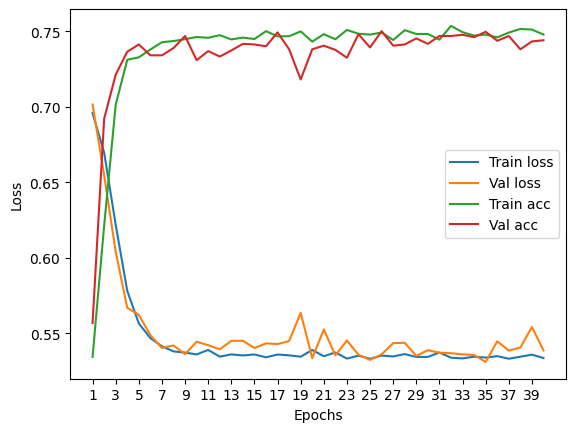

****************************************************************************************************



118it [00:00, 164.79it/s]


Train Epoch: 0 	Loss: 0.696707, Accuracy: 3933/7500 (52%)
Val Epoch: 0 	Loss: 0.699414, Accuracy: 1479/2500 (59%)



118it [00:00, 160.30it/s]


Train Epoch: 1 	Loss: 0.674555, Accuracy: 4572/7500 (61%)
Val Epoch: 1 	Loss: 0.671595, Accuracy: 1559/2500 (62%)



118it [00:00, 158.50it/s]


Train Epoch: 2 	Loss: 0.642349, Accuracy: 4846/7500 (65%)
Val Epoch: 2 	Loss: 0.632529, Accuracy: 1731/2500 (69%)



118it [00:00, 157.34it/s]


Train Epoch: 3 	Loss: 0.603303, Accuracy: 5303/7500 (71%)
Val Epoch: 3 	Loss: 0.597449, Accuracy: 1791/2500 (72%)



118it [00:00, 163.53it/s]


Train Epoch: 4 	Loss: 0.569469, Accuracy: 5464/7500 (73%)
Val Epoch: 4 	Loss: 0.576036, Accuracy: 1811/2500 (72%)



118it [00:00, 126.25it/s]


Train Epoch: 5 	Loss: 0.551280, Accuracy: 5522/7500 (74%)
Val Epoch: 5 	Loss: 0.559094, Accuracy: 1832/2500 (73%)



118it [00:00, 152.24it/s]


Train Epoch: 6 	Loss: 0.544298, Accuracy: 5564/7500 (74%)
Val Epoch: 6 	Loss: 0.556924, Accuracy: 1836/2500 (73%)



118it [00:00, 137.22it/s]


Train Epoch: 7 	Loss: 0.539974, Accuracy: 5536/7500 (74%)
Val Epoch: 7 	Loss: 0.563135, Accuracy: 1832/2500 (73%)



118it [00:00, 157.97it/s]


Train Epoch: 8 	Loss: 0.538026, Accuracy: 5581/7500 (74%)
Val Epoch: 8 	Loss: 0.564915, Accuracy: 1831/2500 (73%)



118it [00:00, 146.48it/s]


Train Epoch: 9 	Loss: 0.536672, Accuracy: 5586/7500 (74%)
Val Epoch: 9 	Loss: 0.576474, Accuracy: 1832/2500 (73%)



118it [00:00, 151.88it/s]


Train Epoch: 10 	Loss: 0.537366, Accuracy: 5571/7500 (74%)
Val Epoch: 10 	Loss: 0.561355, Accuracy: 1822/2500 (73%)



118it [00:00, 163.72it/s]


Train Epoch: 11 	Loss: 0.535780, Accuracy: 5590/7500 (75%)
Val Epoch: 11 	Loss: 0.553092, Accuracy: 1833/2500 (73%)



118it [00:00, 163.73it/s]


Train Epoch: 12 	Loss: 0.536511, Accuracy: 5557/7500 (74%)
Val Epoch: 12 	Loss: 0.555955, Accuracy: 1829/2500 (73%)



118it [00:00, 171.09it/s]


Train Epoch: 13 	Loss: 0.534509, Accuracy: 5604/7500 (75%)
Val Epoch: 13 	Loss: 0.558599, Accuracy: 1834/2500 (73%)



118it [00:00, 160.07it/s]


Train Epoch: 14 	Loss: 0.535607, Accuracy: 5595/7500 (75%)
Val Epoch: 14 	Loss: 0.554025, Accuracy: 1839/2500 (74%)



118it [00:00, 158.38it/s]


Train Epoch: 15 	Loss: 0.535754, Accuracy: 5608/7500 (75%)
Val Epoch: 15 	Loss: 0.570499, Accuracy: 1834/2500 (73%)



118it [00:00, 163.87it/s]


Train Epoch: 16 	Loss: 0.537186, Accuracy: 5629/7500 (75%)
Val Epoch: 16 	Loss: 0.559606, Accuracy: 1829/2500 (73%)



118it [00:00, 146.59it/s]


Train Epoch: 17 	Loss: 0.535812, Accuracy: 5564/7500 (74%)
Val Epoch: 17 	Loss: 0.572230, Accuracy: 1842/2500 (74%)



118it [00:00, 160.11it/s]


Train Epoch: 18 	Loss: 0.534538, Accuracy: 5615/7500 (75%)
Val Epoch: 18 	Loss: 0.559440, Accuracy: 1835/2500 (73%)



118it [00:00, 159.05it/s]


Train Epoch: 19 	Loss: 0.534064, Accuracy: 5597/7500 (75%)
Val Epoch: 19 	Loss: 0.552492, Accuracy: 1835/2500 (73%)



118it [00:00, 161.01it/s]


Train Epoch: 20 	Loss: 0.534350, Accuracy: 5610/7500 (75%)
Val Epoch: 20 	Loss: 0.566497, Accuracy: 1837/2500 (73%)



118it [00:00, 150.42it/s]


Train Epoch: 21 	Loss: 0.535086, Accuracy: 5607/7500 (75%)
Val Epoch: 21 	Loss: 0.558475, Accuracy: 1844/2500 (74%)



118it [00:00, 143.98it/s]


Train Epoch: 22 	Loss: 0.537628, Accuracy: 5601/7500 (75%)
Val Epoch: 22 	Loss: 0.569024, Accuracy: 1816/2500 (73%)



118it [00:00, 145.35it/s]


Train Epoch: 23 	Loss: 0.536534, Accuracy: 5605/7500 (75%)
Val Epoch: 23 	Loss: 0.574888, Accuracy: 1845/2500 (74%)



118it [00:00, 147.55it/s]


Train Epoch: 24 	Loss: 0.535518, Accuracy: 5596/7500 (75%)
Val Epoch: 24 	Loss: 0.570955, Accuracy: 1830/2500 (73%)



118it [00:00, 134.48it/s]


Train Epoch: 25 	Loss: 0.531859, Accuracy: 5597/7500 (75%)
Val Epoch: 25 	Loss: 0.553167, Accuracy: 1841/2500 (74%)



118it [00:00, 142.17it/s]


Train Epoch: 26 	Loss: 0.533522, Accuracy: 5609/7500 (75%)
Val Epoch: 26 	Loss: 0.558141, Accuracy: 1834/2500 (73%)



118it [00:00, 160.06it/s]


Train Epoch: 27 	Loss: 0.533425, Accuracy: 5608/7500 (75%)
Val Epoch: 27 	Loss: 0.553459, Accuracy: 1845/2500 (74%)



118it [00:00, 167.59it/s]


Train Epoch: 28 	Loss: 0.534525, Accuracy: 5611/7500 (75%)
Val Epoch: 28 	Loss: 0.553057, Accuracy: 1841/2500 (74%)



118it [00:00, 158.51it/s]


Train Epoch: 29 	Loss: 0.534705, Accuracy: 5600/7500 (75%)
Val Epoch: 29 	Loss: 0.554845, Accuracy: 1841/2500 (74%)



118it [00:00, 175.89it/s]


Train Epoch: 30 	Loss: 0.533631, Accuracy: 5627/7500 (75%)
Val Epoch: 30 	Loss: 0.566757, Accuracy: 1839/2500 (74%)



118it [00:00, 178.89it/s]


Train Epoch: 31 	Loss: 0.532933, Accuracy: 5599/7500 (75%)
Val Epoch: 31 	Loss: 0.557824, Accuracy: 1834/2500 (73%)



118it [00:00, 171.65it/s]


Train Epoch: 32 	Loss: 0.535810, Accuracy: 5623/7500 (75%)
Val Epoch: 32 	Loss: 0.571653, Accuracy: 1833/2500 (73%)



118it [00:00, 158.08it/s]


Train Epoch: 33 	Loss: 0.532791, Accuracy: 5611/7500 (75%)
Val Epoch: 33 	Loss: 0.563231, Accuracy: 1837/2500 (73%)



118it [00:00, 161.10it/s]


Train Epoch: 34 	Loss: 0.534263, Accuracy: 5620/7500 (75%)
Val Epoch: 34 	Loss: 0.554419, Accuracy: 1851/2500 (74%)



118it [00:00, 162.27it/s]


Train Epoch: 35 	Loss: 0.535471, Accuracy: 5582/7500 (74%)
Val Epoch: 35 	Loss: 0.559982, Accuracy: 1834/2500 (73%)



118it [00:00, 161.68it/s]


Train Epoch: 36 	Loss: 0.533672, Accuracy: 5627/7500 (75%)
Val Epoch: 36 	Loss: 0.569910, Accuracy: 1832/2500 (73%)



118it [00:00, 156.77it/s]


Train Epoch: 37 	Loss: 0.532226, Accuracy: 5603/7500 (75%)
Val Epoch: 37 	Loss: 0.560924, Accuracy: 1831/2500 (73%)



118it [00:00, 133.03it/s]


Train Epoch: 38 	Loss: 0.534117, Accuracy: 5624/7500 (75%)
Val Epoch: 38 	Loss: 0.564489, Accuracy: 1839/2500 (74%)



118it [00:00, 146.34it/s]


Train Epoch: 39 	Loss: 0.531834, Accuracy: 5628/7500 (75%)
Val Epoch: 39 	Loss: 0.551754, Accuracy: 1837/2500 (73%)

Test accuracy:  71.39999999999999


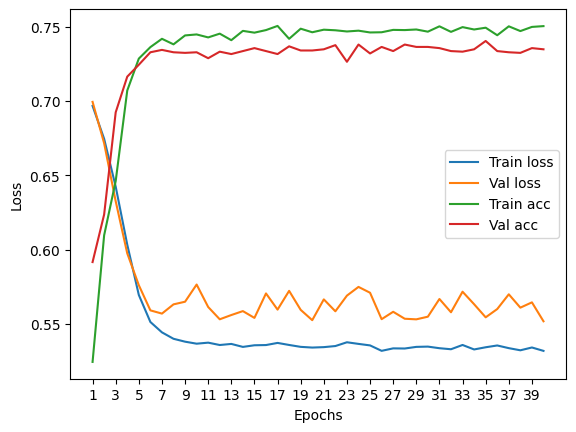

****************************************************************************************************



118it [00:00, 164.09it/s]


Train Epoch: 0 	Loss: 0.696988, Accuracy: 3883/7500 (52%)
Val Epoch: 0 	Loss: 0.702364, Accuracy: 1460/2500 (58%)



118it [00:00, 153.02it/s]


Train Epoch: 1 	Loss: 0.681059, Accuracy: 4437/7500 (59%)
Val Epoch: 1 	Loss: 0.676270, Accuracy: 1551/2500 (62%)



118it [00:00, 138.78it/s]


Train Epoch: 2 	Loss: 0.646372, Accuracy: 4882/7500 (65%)
Val Epoch: 2 	Loss: 0.626259, Accuracy: 1765/2500 (71%)



118it [00:00, 127.48it/s]


Train Epoch: 3 	Loss: 0.595273, Accuracy: 5341/7500 (71%)
Val Epoch: 3 	Loss: 0.571952, Accuracy: 1846/2500 (74%)



118it [00:00, 157.13it/s]


Train Epoch: 4 	Loss: 0.566997, Accuracy: 5431/7500 (72%)
Val Epoch: 4 	Loss: 0.552131, Accuracy: 1893/2500 (76%)



118it [00:00, 148.08it/s]


Train Epoch: 5 	Loss: 0.559582, Accuracy: 5444/7500 (73%)
Val Epoch: 5 	Loss: 0.544840, Accuracy: 1891/2500 (76%)



118it [00:00, 163.68it/s]


Train Epoch: 6 	Loss: 0.553142, Accuracy: 5490/7500 (73%)
Val Epoch: 6 	Loss: 0.546687, Accuracy: 1877/2500 (75%)



118it [00:00, 160.26it/s]


Train Epoch: 7 	Loss: 0.553556, Accuracy: 5482/7500 (73%)
Val Epoch: 7 	Loss: 0.544808, Accuracy: 1877/2500 (75%)



118it [00:00, 159.86it/s]


Train Epoch: 8 	Loss: 0.552487, Accuracy: 5473/7500 (73%)
Val Epoch: 8 	Loss: 0.545795, Accuracy: 1875/2500 (75%)



118it [00:00, 158.82it/s]


Train Epoch: 9 	Loss: 0.551984, Accuracy: 5474/7500 (73%)
Val Epoch: 9 	Loss: 0.541208, Accuracy: 1874/2500 (75%)



118it [00:00, 169.05it/s]


Train Epoch: 10 	Loss: 0.553658, Accuracy: 5492/7500 (73%)
Val Epoch: 10 	Loss: 0.546866, Accuracy: 1856/2500 (74%)



118it [00:00, 167.93it/s]


Train Epoch: 11 	Loss: 0.551401, Accuracy: 5479/7500 (73%)
Val Epoch: 11 	Loss: 0.548764, Accuracy: 1879/2500 (75%)



118it [00:00, 159.90it/s]


Train Epoch: 12 	Loss: 0.552716, Accuracy: 5479/7500 (73%)
Val Epoch: 12 	Loss: 0.547072, Accuracy: 1893/2500 (76%)



118it [00:00, 144.67it/s]


Train Epoch: 13 	Loss: 0.551866, Accuracy: 5463/7500 (73%)
Val Epoch: 13 	Loss: 0.532843, Accuracy: 1875/2500 (75%)



118it [00:00, 164.41it/s]


Train Epoch: 14 	Loss: 0.550566, Accuracy: 5490/7500 (73%)
Val Epoch: 14 	Loss: 0.542225, Accuracy: 1895/2500 (76%)



118it [00:00, 159.43it/s]


Train Epoch: 15 	Loss: 0.551069, Accuracy: 5457/7500 (73%)
Val Epoch: 15 	Loss: 0.538239, Accuracy: 1895/2500 (76%)



118it [00:00, 158.72it/s]


Train Epoch: 16 	Loss: 0.551937, Accuracy: 5494/7500 (73%)
Val Epoch: 16 	Loss: 0.538966, Accuracy: 1867/2500 (75%)



118it [00:00, 163.39it/s]


Train Epoch: 17 	Loss: 0.550010, Accuracy: 5513/7500 (74%)
Val Epoch: 17 	Loss: 0.542040, Accuracy: 1894/2500 (76%)



118it [00:00, 157.64it/s]


Train Epoch: 18 	Loss: 0.549084, Accuracy: 5495/7500 (73%)
Val Epoch: 18 	Loss: 0.538044, Accuracy: 1869/2500 (75%)



118it [00:00, 136.52it/s]


Train Epoch: 19 	Loss: 0.552822, Accuracy: 5502/7500 (73%)
Val Epoch: 19 	Loss: 0.544088, Accuracy: 1880/2500 (75%)



118it [00:00, 157.18it/s]


Train Epoch: 20 	Loss: 0.548974, Accuracy: 5512/7500 (73%)
Val Epoch: 20 	Loss: 0.532106, Accuracy: 1875/2500 (75%)



118it [00:00, 152.07it/s]


Train Epoch: 21 	Loss: 0.549942, Accuracy: 5497/7500 (73%)
Val Epoch: 21 	Loss: 0.540111, Accuracy: 1893/2500 (76%)



118it [00:00, 164.90it/s]


Train Epoch: 22 	Loss: 0.549156, Accuracy: 5502/7500 (73%)
Val Epoch: 22 	Loss: 0.537669, Accuracy: 1875/2500 (75%)



118it [00:00, 162.03it/s]


Train Epoch: 23 	Loss: 0.550379, Accuracy: 5510/7500 (73%)
Val Epoch: 23 	Loss: 0.541162, Accuracy: 1880/2500 (75%)



118it [00:00, 155.82it/s]


Train Epoch: 24 	Loss: 0.549596, Accuracy: 5496/7500 (73%)
Val Epoch: 24 	Loss: 0.533237, Accuracy: 1887/2500 (75%)



118it [00:00, 155.56it/s]


Train Epoch: 25 	Loss: 0.551068, Accuracy: 5501/7500 (73%)
Val Epoch: 25 	Loss: 0.537152, Accuracy: 1878/2500 (75%)



118it [00:00, 167.73it/s]


Train Epoch: 26 	Loss: 0.551256, Accuracy: 5497/7500 (73%)
Val Epoch: 26 	Loss: 0.543338, Accuracy: 1899/2500 (76%)



118it [00:00, 156.73it/s]


Train Epoch: 27 	Loss: 0.549183, Accuracy: 5514/7500 (74%)
Val Epoch: 27 	Loss: 0.539926, Accuracy: 1889/2500 (76%)



118it [00:00, 156.77it/s]


Train Epoch: 28 	Loss: 0.551773, Accuracy: 5484/7500 (73%)
Val Epoch: 28 	Loss: 0.537418, Accuracy: 1894/2500 (76%)



118it [00:00, 148.42it/s]


Train Epoch: 29 	Loss: 0.548452, Accuracy: 5486/7500 (73%)
Val Epoch: 29 	Loss: 0.540172, Accuracy: 1892/2500 (76%)



118it [00:00, 160.70it/s]


Train Epoch: 30 	Loss: 0.549537, Accuracy: 5501/7500 (73%)
Val Epoch: 30 	Loss: 0.548514, Accuracy: 1879/2500 (75%)



118it [00:00, 163.47it/s]


Train Epoch: 31 	Loss: 0.552544, Accuracy: 5498/7500 (73%)
Val Epoch: 31 	Loss: 0.536052, Accuracy: 1890/2500 (76%)



118it [00:00, 163.25it/s]


Train Epoch: 32 	Loss: 0.548936, Accuracy: 5510/7500 (73%)
Val Epoch: 32 	Loss: 0.533959, Accuracy: 1893/2500 (76%)



118it [00:00, 170.11it/s]


Train Epoch: 33 	Loss: 0.547882, Accuracy: 5508/7500 (73%)
Val Epoch: 33 	Loss: 0.539009, Accuracy: 1901/2500 (76%)



118it [00:00, 156.87it/s]


Train Epoch: 34 	Loss: 0.547848, Accuracy: 5509/7500 (73%)
Val Epoch: 34 	Loss: 0.544357, Accuracy: 1894/2500 (76%)



118it [00:00, 142.52it/s]


Train Epoch: 35 	Loss: 0.549400, Accuracy: 5517/7500 (74%)
Val Epoch: 35 	Loss: 0.533542, Accuracy: 1880/2500 (75%)



118it [00:00, 130.45it/s]


Train Epoch: 36 	Loss: 0.550885, Accuracy: 5492/7500 (73%)
Val Epoch: 36 	Loss: 0.536329, Accuracy: 1904/2500 (76%)



118it [00:00, 146.04it/s]


Train Epoch: 37 	Loss: 0.551111, Accuracy: 5507/7500 (73%)
Val Epoch: 37 	Loss: 0.542426, Accuracy: 1893/2500 (76%)



118it [00:00, 156.43it/s]


Train Epoch: 38 	Loss: 0.552914, Accuracy: 5489/7500 (73%)
Val Epoch: 38 	Loss: 0.535591, Accuracy: 1893/2500 (76%)



118it [00:00, 162.50it/s]


Train Epoch: 39 	Loss: 0.546529, Accuracy: 5489/7500 (73%)
Val Epoch: 39 	Loss: 0.537423, Accuracy: 1893/2500 (76%)

Test accuracy:  74.16


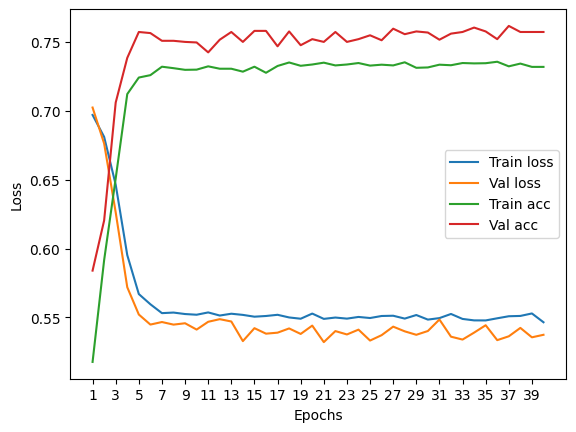

****************************************************************************************************



118it [00:00, 148.02it/s]


Train Epoch: 0 	Loss: 0.693820, Accuracy: 4006/7500 (53%)
Val Epoch: 0 	Loss: 0.699884, Accuracy: 1414/2500 (57%)



118it [00:00, 158.60it/s]


Train Epoch: 1 	Loss: 0.679309, Accuracy: 4326/7500 (58%)
Val Epoch: 1 	Loss: 0.690206, Accuracy: 1487/2500 (59%)



118it [00:00, 140.82it/s]


Train Epoch: 2 	Loss: 0.667712, Accuracy: 4463/7500 (60%)
Val Epoch: 2 	Loss: 0.687945, Accuracy: 1459/2500 (58%)



118it [00:00, 164.56it/s]


Train Epoch: 3 	Loss: 0.655882, Accuracy: 4647/7500 (62%)
Val Epoch: 3 	Loss: 0.660901, Accuracy: 1611/2500 (64%)



118it [00:00, 147.20it/s]


Train Epoch: 4 	Loss: 0.635409, Accuracy: 4934/7500 (66%)
Val Epoch: 4 	Loss: 0.645459, Accuracy: 1684/2500 (67%)



118it [00:00, 150.72it/s]


Train Epoch: 5 	Loss: 0.607737, Accuracy: 5197/7500 (69%)
Val Epoch: 5 	Loss: 0.622358, Accuracy: 1705/2500 (68%)



118it [00:00, 154.31it/s]


Train Epoch: 6 	Loss: 0.584890, Accuracy: 5347/7500 (71%)
Val Epoch: 6 	Loss: 0.597058, Accuracy: 1724/2500 (69%)



118it [00:00, 167.38it/s]


Train Epoch: 7 	Loss: 0.573504, Accuracy: 5389/7500 (72%)
Val Epoch: 7 	Loss: 0.591204, Accuracy: 1801/2500 (72%)



118it [00:00, 161.60it/s]


Train Epoch: 8 	Loss: 0.560844, Accuracy: 5478/7500 (73%)
Val Epoch: 8 	Loss: 0.571223, Accuracy: 1846/2500 (74%)



118it [00:00, 159.96it/s]


Train Epoch: 9 	Loss: 0.553329, Accuracy: 5466/7500 (73%)
Val Epoch: 9 	Loss: 0.568150, Accuracy: 1820/2500 (73%)



118it [00:00, 153.25it/s]


Train Epoch: 10 	Loss: 0.551462, Accuracy: 5482/7500 (73%)
Val Epoch: 10 	Loss: 0.568159, Accuracy: 1832/2500 (73%)



118it [00:00, 155.84it/s]


Train Epoch: 11 	Loss: 0.550371, Accuracy: 5508/7500 (73%)
Val Epoch: 11 	Loss: 0.569613, Accuracy: 1839/2500 (74%)



118it [00:00, 157.46it/s]


Train Epoch: 12 	Loss: 0.549997, Accuracy: 5496/7500 (73%)
Val Epoch: 12 	Loss: 0.587274, Accuracy: 1830/2500 (73%)



118it [00:00, 157.86it/s]


Train Epoch: 13 	Loss: 0.549702, Accuracy: 5480/7500 (73%)
Val Epoch: 13 	Loss: 0.568282, Accuracy: 1836/2500 (73%)



118it [00:00, 165.12it/s]


Train Epoch: 14 	Loss: 0.547194, Accuracy: 5498/7500 (73%)
Val Epoch: 14 	Loss: 0.559799, Accuracy: 1824/2500 (73%)



118it [00:01, 116.28it/s]


Train Epoch: 15 	Loss: 0.548132, Accuracy: 5483/7500 (73%)
Val Epoch: 15 	Loss: 0.563921, Accuracy: 1831/2500 (73%)



118it [00:00, 166.20it/s]


Train Epoch: 16 	Loss: 0.549293, Accuracy: 5490/7500 (73%)
Val Epoch: 16 	Loss: 0.561213, Accuracy: 1839/2500 (74%)



118it [00:00, 159.36it/s]


Train Epoch: 17 	Loss: 0.546859, Accuracy: 5485/7500 (73%)
Val Epoch: 17 	Loss: 0.565707, Accuracy: 1829/2500 (73%)



118it [00:00, 161.28it/s]


Train Epoch: 18 	Loss: 0.548202, Accuracy: 5485/7500 (73%)
Val Epoch: 18 	Loss: 0.580856, Accuracy: 1827/2500 (73%)



118it [00:00, 158.23it/s]


Train Epoch: 19 	Loss: 0.545813, Accuracy: 5511/7500 (73%)
Val Epoch: 19 	Loss: 0.574197, Accuracy: 1827/2500 (73%)



118it [00:00, 155.75it/s]


Train Epoch: 20 	Loss: 0.551675, Accuracy: 5502/7500 (73%)
Val Epoch: 20 	Loss: 0.567193, Accuracy: 1831/2500 (73%)



118it [00:00, 162.86it/s]


Train Epoch: 21 	Loss: 0.547847, Accuracy: 5507/7500 (73%)
Val Epoch: 21 	Loss: 0.563030, Accuracy: 1835/2500 (73%)



118it [00:00, 150.27it/s]


Train Epoch: 22 	Loss: 0.552423, Accuracy: 5458/7500 (73%)
Val Epoch: 22 	Loss: 0.564755, Accuracy: 1827/2500 (73%)



118it [00:00, 159.73it/s]


Train Epoch: 23 	Loss: 0.549346, Accuracy: 5498/7500 (73%)
Val Epoch: 23 	Loss: 0.559534, Accuracy: 1838/2500 (74%)



118it [00:00, 164.54it/s]


Train Epoch: 24 	Loss: 0.547145, Accuracy: 5497/7500 (73%)
Val Epoch: 24 	Loss: 0.562339, Accuracy: 1836/2500 (73%)



118it [00:00, 171.62it/s]


Train Epoch: 25 	Loss: 0.548306, Accuracy: 5484/7500 (73%)
Val Epoch: 25 	Loss: 0.561681, Accuracy: 1839/2500 (74%)



118it [00:00, 160.41it/s]


Train Epoch: 26 	Loss: 0.546789, Accuracy: 5505/7500 (73%)
Val Epoch: 26 	Loss: 0.571720, Accuracy: 1831/2500 (73%)



118it [00:00, 159.88it/s]


Train Epoch: 27 	Loss: 0.549216, Accuracy: 5515/7500 (74%)
Val Epoch: 27 	Loss: 0.567276, Accuracy: 1840/2500 (74%)



118it [00:00, 162.86it/s]


Train Epoch: 28 	Loss: 0.548903, Accuracy: 5502/7500 (73%)
Val Epoch: 28 	Loss: 0.569866, Accuracy: 1824/2500 (73%)



118it [00:00, 161.45it/s]


Train Epoch: 29 	Loss: 0.548856, Accuracy: 5501/7500 (73%)
Val Epoch: 29 	Loss: 0.565857, Accuracy: 1832/2500 (73%)



118it [00:00, 157.01it/s]


Train Epoch: 30 	Loss: 0.545696, Accuracy: 5520/7500 (74%)
Val Epoch: 30 	Loss: 0.575099, Accuracy: 1821/2500 (73%)



118it [00:00, 144.16it/s]


Train Epoch: 31 	Loss: 0.548827, Accuracy: 5497/7500 (73%)
Val Epoch: 31 	Loss: 0.585941, Accuracy: 1809/2500 (72%)



118it [00:00, 145.92it/s]


Train Epoch: 32 	Loss: 0.548635, Accuracy: 5502/7500 (73%)
Val Epoch: 32 	Loss: 0.572940, Accuracy: 1833/2500 (73%)



118it [00:00, 139.45it/s]


Train Epoch: 33 	Loss: 0.547192, Accuracy: 5499/7500 (73%)
Val Epoch: 33 	Loss: 0.569218, Accuracy: 1832/2500 (73%)



118it [00:00, 140.19it/s]


Train Epoch: 34 	Loss: 0.547150, Accuracy: 5528/7500 (74%)
Val Epoch: 34 	Loss: 0.564687, Accuracy: 1837/2500 (73%)



118it [00:00, 158.87it/s]


Train Epoch: 35 	Loss: 0.546684, Accuracy: 5528/7500 (74%)
Val Epoch: 35 	Loss: 0.560273, Accuracy: 1827/2500 (73%)



118it [00:00, 162.32it/s]


Train Epoch: 36 	Loss: 0.550831, Accuracy: 5484/7500 (73%)
Val Epoch: 36 	Loss: 0.562680, Accuracy: 1832/2500 (73%)



118it [00:00, 158.76it/s]


Train Epoch: 37 	Loss: 0.546960, Accuracy: 5515/7500 (74%)
Val Epoch: 37 	Loss: 0.562519, Accuracy: 1832/2500 (73%)



118it [00:00, 154.47it/s]


Train Epoch: 38 	Loss: 0.549389, Accuracy: 5477/7500 (73%)
Val Epoch: 38 	Loss: 0.570666, Accuracy: 1834/2500 (73%)



118it [00:00, 148.86it/s]


Train Epoch: 39 	Loss: 0.545364, Accuracy: 5500/7500 (73%)
Val Epoch: 39 	Loss: 0.576773, Accuracy: 1829/2500 (73%)

Test accuracy:  73.76


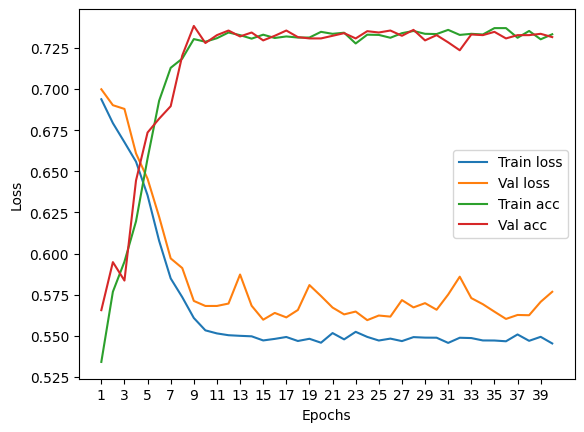

****************************************************************************************************



118it [00:00, 156.84it/s]


Train Epoch: 0 	Loss: 0.694955, Accuracy: 3995/7500 (53%)
Val Epoch: 0 	Loss: 0.703040, Accuracy: 1393/2500 (56%)



118it [00:00, 154.12it/s]


Train Epoch: 1 	Loss: 0.684823, Accuracy: 4346/7500 (58%)
Val Epoch: 1 	Loss: 0.691093, Accuracy: 1465/2500 (59%)



118it [00:00, 163.83it/s]


Train Epoch: 2 	Loss: 0.668437, Accuracy: 4554/7500 (61%)
Val Epoch: 2 	Loss: 0.669490, Accuracy: 1564/2500 (63%)



118it [00:00, 156.73it/s]


Train Epoch: 3 	Loss: 0.643220, Accuracy: 4874/7500 (65%)
Val Epoch: 3 	Loss: 0.639468, Accuracy: 1651/2500 (66%)



118it [00:00, 152.98it/s]


Train Epoch: 4 	Loss: 0.613798, Accuracy: 5169/7500 (69%)
Val Epoch: 4 	Loss: 0.605223, Accuracy: 1830/2500 (73%)



118it [00:00, 154.36it/s]


Train Epoch: 5 	Loss: 0.587647, Accuracy: 5404/7500 (72%)
Val Epoch: 5 	Loss: 0.577680, Accuracy: 1834/2500 (73%)



118it [00:00, 135.22it/s]


Train Epoch: 6 	Loss: 0.570977, Accuracy: 5435/7500 (72%)
Val Epoch: 6 	Loss: 0.576471, Accuracy: 1808/2500 (72%)



118it [00:00, 153.67it/s]


Train Epoch: 7 	Loss: 0.564246, Accuracy: 5445/7500 (73%)
Val Epoch: 7 	Loss: 0.564784, Accuracy: 1849/2500 (74%)



118it [00:00, 157.92it/s]


Train Epoch: 8 	Loss: 0.564076, Accuracy: 5423/7500 (72%)
Val Epoch: 8 	Loss: 0.568010, Accuracy: 1843/2500 (74%)



118it [00:00, 159.66it/s]


Train Epoch: 9 	Loss: 0.559615, Accuracy: 5459/7500 (73%)
Val Epoch: 9 	Loss: 0.558741, Accuracy: 1833/2500 (73%)



118it [00:00, 149.10it/s]


Train Epoch: 10 	Loss: 0.560533, Accuracy: 5460/7500 (73%)
Val Epoch: 10 	Loss: 0.565671, Accuracy: 1821/2500 (73%)



118it [00:00, 156.22it/s]


Train Epoch: 11 	Loss: 0.556100, Accuracy: 5446/7500 (73%)
Val Epoch: 11 	Loss: 0.552942, Accuracy: 1837/2500 (73%)



118it [00:00, 143.64it/s]


Train Epoch: 12 	Loss: 0.558277, Accuracy: 5492/7500 (73%)
Val Epoch: 12 	Loss: 0.564399, Accuracy: 1846/2500 (74%)



118it [00:00, 153.34it/s]


Train Epoch: 13 	Loss: 0.556128, Accuracy: 5467/7500 (73%)
Val Epoch: 13 	Loss: 0.564134, Accuracy: 1846/2500 (74%)



118it [00:00, 147.19it/s]


Train Epoch: 14 	Loss: 0.556072, Accuracy: 5490/7500 (73%)
Val Epoch: 14 	Loss: 0.556901, Accuracy: 1849/2500 (74%)



118it [00:00, 150.93it/s]


Train Epoch: 15 	Loss: 0.557627, Accuracy: 5467/7500 (73%)
Val Epoch: 15 	Loss: 0.558758, Accuracy: 1840/2500 (74%)



118it [00:00, 161.93it/s]


Train Epoch: 16 	Loss: 0.556313, Accuracy: 5472/7500 (73%)
Val Epoch: 16 	Loss: 0.572594, Accuracy: 1836/2500 (73%)



118it [00:00, 167.31it/s]


Train Epoch: 17 	Loss: 0.554887, Accuracy: 5469/7500 (73%)
Val Epoch: 17 	Loss: 0.554675, Accuracy: 1854/2500 (74%)



118it [00:00, 159.60it/s]


Train Epoch: 18 	Loss: 0.556256, Accuracy: 5466/7500 (73%)
Val Epoch: 18 	Loss: 0.568859, Accuracy: 1830/2500 (73%)



118it [00:00, 155.83it/s]


Train Epoch: 19 	Loss: 0.555198, Accuracy: 5466/7500 (73%)
Val Epoch: 19 	Loss: 0.560888, Accuracy: 1846/2500 (74%)



118it [00:00, 154.20it/s]


Train Epoch: 20 	Loss: 0.555414, Accuracy: 5454/7500 (73%)
Val Epoch: 20 	Loss: 0.549648, Accuracy: 1847/2500 (74%)



118it [00:00, 146.91it/s]


Train Epoch: 21 	Loss: 0.555507, Accuracy: 5481/7500 (73%)
Val Epoch: 21 	Loss: 0.556977, Accuracy: 1854/2500 (74%)



118it [00:00, 161.33it/s]


Train Epoch: 22 	Loss: 0.556155, Accuracy: 5499/7500 (73%)
Val Epoch: 22 	Loss: 0.553091, Accuracy: 1850/2500 (74%)



118it [00:00, 145.52it/s]


Train Epoch: 23 	Loss: 0.555194, Accuracy: 5480/7500 (73%)
Val Epoch: 23 	Loss: 0.564354, Accuracy: 1844/2500 (74%)



118it [00:00, 149.93it/s]


Train Epoch: 24 	Loss: 0.559291, Accuracy: 5457/7500 (73%)
Val Epoch: 24 	Loss: 0.558196, Accuracy: 1848/2500 (74%)



118it [00:00, 141.03it/s]


Train Epoch: 25 	Loss: 0.556146, Accuracy: 5478/7500 (73%)
Val Epoch: 25 	Loss: 0.559646, Accuracy: 1842/2500 (74%)



118it [00:00, 160.83it/s]


Train Epoch: 26 	Loss: 0.555518, Accuracy: 5479/7500 (73%)
Val Epoch: 26 	Loss: 0.557085, Accuracy: 1844/2500 (74%)



118it [00:00, 157.38it/s]


Train Epoch: 27 	Loss: 0.557254, Accuracy: 5470/7500 (73%)
Val Epoch: 27 	Loss: 0.560094, Accuracy: 1853/2500 (74%)



118it [00:00, 142.39it/s]


Train Epoch: 28 	Loss: 0.557664, Accuracy: 5460/7500 (73%)
Val Epoch: 28 	Loss: 0.556208, Accuracy: 1845/2500 (74%)



118it [00:00, 140.52it/s]


Train Epoch: 29 	Loss: 0.557802, Accuracy: 5472/7500 (73%)
Val Epoch: 29 	Loss: 0.566514, Accuracy: 1848/2500 (74%)



118it [00:00, 135.11it/s]


Train Epoch: 30 	Loss: 0.556527, Accuracy: 5494/7500 (73%)
Val Epoch: 30 	Loss: 0.556086, Accuracy: 1839/2500 (74%)



118it [00:00, 141.27it/s]


Train Epoch: 31 	Loss: 0.555524, Accuracy: 5470/7500 (73%)
Val Epoch: 31 	Loss: 0.555416, Accuracy: 1847/2500 (74%)



118it [00:00, 159.71it/s]


Train Epoch: 32 	Loss: 0.557715, Accuracy: 5463/7500 (73%)
Val Epoch: 32 	Loss: 0.555803, Accuracy: 1844/2500 (74%)



118it [00:00, 162.57it/s]


Train Epoch: 33 	Loss: 0.555265, Accuracy: 5476/7500 (73%)
Val Epoch: 33 	Loss: 0.552875, Accuracy: 1829/2500 (73%)



118it [00:00, 159.05it/s]


Train Epoch: 34 	Loss: 0.556549, Accuracy: 5472/7500 (73%)
Val Epoch: 34 	Loss: 0.557881, Accuracy: 1841/2500 (74%)



118it [00:00, 163.78it/s]


Train Epoch: 35 	Loss: 0.554278, Accuracy: 5495/7500 (73%)
Val Epoch: 35 	Loss: 0.552639, Accuracy: 1849/2500 (74%)



118it [00:00, 156.95it/s]


Train Epoch: 36 	Loss: 0.555291, Accuracy: 5470/7500 (73%)
Val Epoch: 36 	Loss: 0.551331, Accuracy: 1840/2500 (74%)



118it [00:00, 158.75it/s]


Train Epoch: 37 	Loss: 0.554893, Accuracy: 5488/7500 (73%)
Val Epoch: 37 	Loss: 0.558270, Accuracy: 1844/2500 (74%)



118it [00:00, 157.02it/s]


Train Epoch: 38 	Loss: 0.553298, Accuracy: 5502/7500 (73%)
Val Epoch: 38 	Loss: 0.560360, Accuracy: 1838/2500 (74%)



118it [00:00, 132.04it/s]


Train Epoch: 39 	Loss: 0.556160, Accuracy: 5476/7500 (73%)
Val Epoch: 39 	Loss: 0.557549, Accuracy: 1848/2500 (74%)

Test accuracy:  75.56


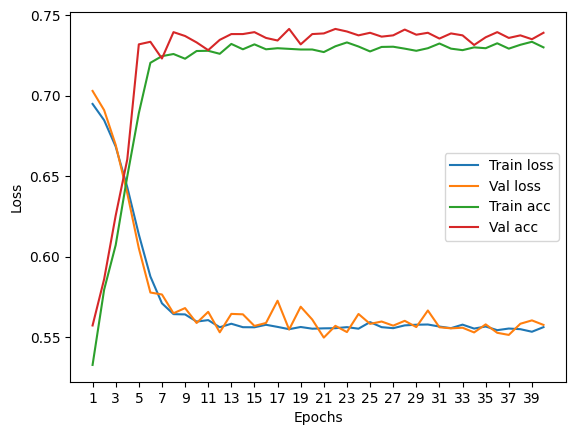

****************************************************************************************************



116it [00:00, 151.51it/s]


Train Epoch: 0 	Loss: 0.690437, Accuracy: 3969/7422 (53%)
Val Epoch: 0 	Loss: 0.689819, Accuracy: 1406/2474 (57%)



116it [00:00, 183.77it/s]


Train Epoch: 1 	Loss: 0.673897, Accuracy: 4361/7422 (59%)
Val Epoch: 1 	Loss: 0.673420, Accuracy: 1477/2474 (60%)



116it [00:00, 191.42it/s]


Train Epoch: 2 	Loss: 0.648218, Accuracy: 4716/7422 (64%)
Val Epoch: 2 	Loss: 0.631309, Accuracy: 1687/2474 (68%)



116it [00:00, 135.24it/s]


Train Epoch: 3 	Loss: 0.609221, Accuracy: 5148/7422 (69%)
Val Epoch: 3 	Loss: 0.591442, Accuracy: 1790/2474 (72%)



116it [00:00, 157.70it/s]


Train Epoch: 4 	Loss: 0.579539, Accuracy: 5327/7422 (72%)
Val Epoch: 4 	Loss: 0.566979, Accuracy: 1799/2474 (73%)



116it [00:00, 144.57it/s]


Train Epoch: 5 	Loss: 0.562252, Accuracy: 5404/7422 (73%)
Val Epoch: 5 	Loss: 0.552270, Accuracy: 1835/2474 (74%)



116it [00:00, 156.50it/s]


Train Epoch: 6 	Loss: 0.551077, Accuracy: 5444/7422 (73%)
Val Epoch: 6 	Loss: 0.544494, Accuracy: 1843/2474 (74%)



116it [00:00, 151.92it/s]


Train Epoch: 7 	Loss: 0.548948, Accuracy: 5410/7422 (73%)
Val Epoch: 7 	Loss: 0.549551, Accuracy: 1828/2474 (74%)



116it [00:00, 141.27it/s]


Train Epoch: 8 	Loss: 0.546415, Accuracy: 5453/7422 (73%)
Val Epoch: 8 	Loss: 0.538401, Accuracy: 1847/2474 (75%)



116it [00:00, 146.06it/s]


Train Epoch: 9 	Loss: 0.544834, Accuracy: 5427/7422 (73%)
Val Epoch: 9 	Loss: 0.540380, Accuracy: 1841/2474 (74%)



116it [00:00, 143.33it/s]


Train Epoch: 10 	Loss: 0.546962, Accuracy: 5445/7422 (73%)
Val Epoch: 10 	Loss: 0.537049, Accuracy: 1870/2474 (76%)



116it [00:00, 152.78it/s]


Train Epoch: 11 	Loss: 0.545112, Accuracy: 5457/7422 (74%)
Val Epoch: 11 	Loss: 0.536460, Accuracy: 1862/2474 (75%)



116it [00:00, 161.97it/s]


Train Epoch: 12 	Loss: 0.543798, Accuracy: 5458/7422 (74%)
Val Epoch: 12 	Loss: 0.537135, Accuracy: 1866/2474 (75%)



116it [00:00, 156.97it/s]


Train Epoch: 13 	Loss: 0.543515, Accuracy: 5470/7422 (74%)
Val Epoch: 13 	Loss: 0.538917, Accuracy: 1844/2474 (75%)



116it [00:00, 155.26it/s]


Train Epoch: 14 	Loss: 0.543874, Accuracy: 5478/7422 (74%)
Val Epoch: 14 	Loss: 0.537990, Accuracy: 1859/2474 (75%)



116it [00:00, 162.28it/s]


Train Epoch: 15 	Loss: 0.542654, Accuracy: 5478/7422 (74%)
Val Epoch: 15 	Loss: 0.537996, Accuracy: 1843/2474 (74%)



116it [00:00, 153.93it/s]


Train Epoch: 16 	Loss: 0.545420, Accuracy: 5450/7422 (73%)
Val Epoch: 16 	Loss: 0.543536, Accuracy: 1849/2474 (75%)



116it [00:00, 165.36it/s]


Train Epoch: 17 	Loss: 0.543260, Accuracy: 5464/7422 (74%)
Val Epoch: 17 	Loss: 0.541262, Accuracy: 1847/2474 (75%)



116it [00:00, 171.02it/s]


Train Epoch: 18 	Loss: 0.543850, Accuracy: 5460/7422 (74%)
Val Epoch: 18 	Loss: 0.535451, Accuracy: 1858/2474 (75%)



116it [00:00, 156.49it/s]


Train Epoch: 19 	Loss: 0.542369, Accuracy: 5488/7422 (74%)
Val Epoch: 19 	Loss: 0.535386, Accuracy: 1865/2474 (75%)



116it [00:00, 152.85it/s]


Train Epoch: 20 	Loss: 0.543792, Accuracy: 5436/7422 (73%)
Val Epoch: 20 	Loss: 0.538179, Accuracy: 1857/2474 (75%)



116it [00:00, 143.50it/s]


Train Epoch: 21 	Loss: 0.545842, Accuracy: 5467/7422 (74%)
Val Epoch: 21 	Loss: 0.536127, Accuracy: 1854/2474 (75%)



116it [00:00, 139.90it/s]


Train Epoch: 22 	Loss: 0.543212, Accuracy: 5489/7422 (74%)
Val Epoch: 22 	Loss: 0.543058, Accuracy: 1842/2474 (74%)



116it [00:00, 155.93it/s]


Train Epoch: 23 	Loss: 0.544186, Accuracy: 5460/7422 (74%)
Val Epoch: 23 	Loss: 0.537059, Accuracy: 1856/2474 (75%)



116it [00:00, 164.07it/s]


Train Epoch: 24 	Loss: 0.542789, Accuracy: 5458/7422 (74%)
Val Epoch: 24 	Loss: 0.536884, Accuracy: 1851/2474 (75%)



116it [00:00, 141.65it/s]


Train Epoch: 25 	Loss: 0.542141, Accuracy: 5469/7422 (74%)
Val Epoch: 25 	Loss: 0.537462, Accuracy: 1868/2474 (76%)



116it [00:00, 154.98it/s]


Train Epoch: 26 	Loss: 0.543278, Accuracy: 5468/7422 (74%)
Val Epoch: 26 	Loss: 0.535120, Accuracy: 1862/2474 (75%)



116it [00:00, 139.03it/s]


Train Epoch: 27 	Loss: 0.542569, Accuracy: 5452/7422 (73%)
Val Epoch: 27 	Loss: 0.534305, Accuracy: 1867/2474 (75%)



116it [00:00, 165.91it/s]


Train Epoch: 28 	Loss: 0.542436, Accuracy: 5447/7422 (73%)
Val Epoch: 28 	Loss: 0.535722, Accuracy: 1850/2474 (75%)



116it [00:00, 157.97it/s]


Train Epoch: 29 	Loss: 0.542087, Accuracy: 5496/7422 (74%)
Val Epoch: 29 	Loss: 0.539478, Accuracy: 1842/2474 (74%)



116it [00:00, 152.91it/s]


Train Epoch: 30 	Loss: 0.543247, Accuracy: 5456/7422 (74%)
Val Epoch: 30 	Loss: 0.539051, Accuracy: 1841/2474 (74%)



116it [00:00, 160.95it/s]


Train Epoch: 31 	Loss: 0.543502, Accuracy: 5476/7422 (74%)
Val Epoch: 31 	Loss: 0.534808, Accuracy: 1853/2474 (75%)



116it [00:00, 143.15it/s]


Train Epoch: 32 	Loss: 0.543742, Accuracy: 5474/7422 (74%)
Val Epoch: 32 	Loss: 0.535990, Accuracy: 1871/2474 (76%)



116it [00:00, 156.69it/s]


Train Epoch: 33 	Loss: 0.542626, Accuracy: 5473/7422 (74%)
Val Epoch: 33 	Loss: 0.546948, Accuracy: 1825/2474 (74%)



116it [00:00, 157.94it/s]


Train Epoch: 34 	Loss: 0.543040, Accuracy: 5496/7422 (74%)
Val Epoch: 34 	Loss: 0.539306, Accuracy: 1854/2474 (75%)



116it [00:00, 161.26it/s]


Train Epoch: 35 	Loss: 0.543446, Accuracy: 5479/7422 (74%)
Val Epoch: 35 	Loss: 0.534478, Accuracy: 1854/2474 (75%)



116it [00:00, 142.54it/s]


Train Epoch: 36 	Loss: 0.543555, Accuracy: 5479/7422 (74%)
Val Epoch: 36 	Loss: 0.538561, Accuracy: 1862/2474 (75%)



116it [00:00, 154.07it/s]


Train Epoch: 37 	Loss: 0.542974, Accuracy: 5476/7422 (74%)
Val Epoch: 37 	Loss: 0.538038, Accuracy: 1853/2474 (75%)



116it [00:00, 161.99it/s]


Train Epoch: 38 	Loss: 0.541148, Accuracy: 5480/7422 (74%)
Val Epoch: 38 	Loss: 0.535308, Accuracy: 1868/2474 (76%)



116it [00:00, 155.57it/s]


Train Epoch: 39 	Loss: 0.543329, Accuracy: 5445/7422 (73%)
Val Epoch: 39 	Loss: 0.542454, Accuracy: 1828/2474 (74%)

Test accuracy:  73.64591754244138


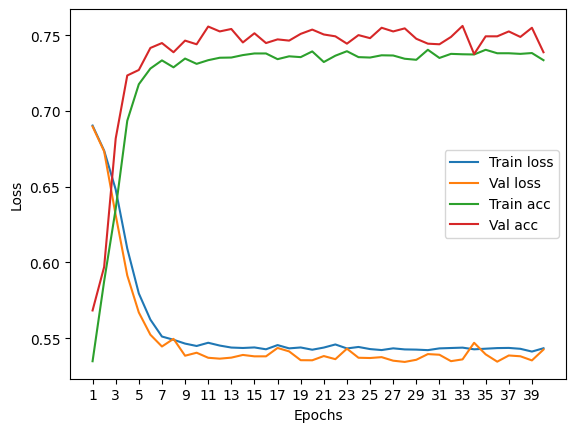

****************************************************************************************************



Particles per jet: 11


118it [00:00, 146.49it/s]


Train Epoch: 0 	Loss: 0.697656, Accuracy: 3832/7500 (51%)
Val Epoch: 0 	Loss: 0.706476, Accuracy: 1342/2500 (54%)



118it [00:00, 156.20it/s]


Train Epoch: 1 	Loss: 0.690666, Accuracy: 4195/7500 (56%)
Val Epoch: 1 	Loss: 0.699283, Accuracy: 1394/2500 (56%)



118it [00:00, 138.91it/s]


Train Epoch: 2 	Loss: 0.685762, Accuracy: 4245/7500 (57%)
Val Epoch: 2 	Loss: 0.699457, Accuracy: 1396/2500 (56%)



118it [00:00, 141.68it/s]


Train Epoch: 3 	Loss: 0.683054, Accuracy: 4302/7500 (57%)
Val Epoch: 3 	Loss: 0.697629, Accuracy: 1410/2500 (56%)



118it [00:00, 147.63it/s]


Train Epoch: 4 	Loss: 0.678073, Accuracy: 4331/7500 (58%)
Val Epoch: 4 	Loss: 0.689045, Accuracy: 1454/2500 (58%)



118it [00:00, 162.68it/s]


Train Epoch: 5 	Loss: 0.668453, Accuracy: 4494/7500 (60%)
Val Epoch: 5 	Loss: 0.674514, Accuracy: 1579/2500 (63%)



118it [00:00, 166.79it/s]


Train Epoch: 6 	Loss: 0.642566, Accuracy: 4877/7500 (65%)
Val Epoch: 6 	Loss: 0.640561, Accuracy: 1737/2500 (69%)



118it [00:00, 157.52it/s]


Train Epoch: 7 	Loss: 0.605477, Accuracy: 5256/7500 (70%)
Val Epoch: 7 	Loss: 0.594111, Accuracy: 1813/2500 (73%)



118it [00:00, 155.75it/s]


Train Epoch: 8 	Loss: 0.576700, Accuracy: 5383/7500 (72%)
Val Epoch: 8 	Loss: 0.567028, Accuracy: 1844/2500 (74%)



118it [00:00, 158.90it/s]


Train Epoch: 9 	Loss: 0.558295, Accuracy: 5498/7500 (73%)
Val Epoch: 9 	Loss: 0.560674, Accuracy: 1860/2500 (74%)



118it [00:00, 151.04it/s]


Train Epoch: 10 	Loss: 0.549275, Accuracy: 5520/7500 (74%)
Val Epoch: 10 	Loss: 0.545684, Accuracy: 1881/2500 (75%)



118it [00:00, 159.03it/s]


Train Epoch: 11 	Loss: 0.545189, Accuracy: 5558/7500 (74%)
Val Epoch: 11 	Loss: 0.555730, Accuracy: 1876/2500 (75%)



118it [00:00, 154.27it/s]


Train Epoch: 12 	Loss: 0.544659, Accuracy: 5520/7500 (74%)
Val Epoch: 12 	Loss: 0.543239, Accuracy: 1869/2500 (75%)



118it [00:00, 162.66it/s]


Train Epoch: 13 	Loss: 0.543579, Accuracy: 5564/7500 (74%)
Val Epoch: 13 	Loss: 0.547572, Accuracy: 1871/2500 (75%)



118it [00:00, 164.32it/s]


Train Epoch: 14 	Loss: 0.538691, Accuracy: 5562/7500 (74%)
Val Epoch: 14 	Loss: 0.539301, Accuracy: 1873/2500 (75%)



118it [00:00, 156.06it/s]


Train Epoch: 15 	Loss: 0.541560, Accuracy: 5544/7500 (74%)
Val Epoch: 15 	Loss: 0.539968, Accuracy: 1877/2500 (75%)



118it [00:00, 162.70it/s]


Train Epoch: 16 	Loss: 0.540436, Accuracy: 5558/7500 (74%)
Val Epoch: 16 	Loss: 0.552619, Accuracy: 1871/2500 (75%)



118it [00:00, 156.00it/s]


Train Epoch: 17 	Loss: 0.538103, Accuracy: 5588/7500 (75%)
Val Epoch: 17 	Loss: 0.540359, Accuracy: 1877/2500 (75%)



118it [00:00, 151.56it/s]


Train Epoch: 18 	Loss: 0.538781, Accuracy: 5570/7500 (74%)
Val Epoch: 18 	Loss: 0.546394, Accuracy: 1876/2500 (75%)



118it [00:00, 131.48it/s]


Train Epoch: 19 	Loss: 0.540259, Accuracy: 5572/7500 (74%)
Val Epoch: 19 	Loss: 0.542991, Accuracy: 1881/2500 (75%)



118it [00:00, 143.08it/s]


Train Epoch: 20 	Loss: 0.538200, Accuracy: 5579/7500 (74%)
Val Epoch: 20 	Loss: 0.545147, Accuracy: 1880/2500 (75%)



118it [00:00, 151.03it/s]


Train Epoch: 21 	Loss: 0.539815, Accuracy: 5572/7500 (74%)
Val Epoch: 21 	Loss: 0.550602, Accuracy: 1883/2500 (75%)



118it [00:00, 162.47it/s]


Train Epoch: 22 	Loss: 0.540758, Accuracy: 5567/7500 (74%)
Val Epoch: 22 	Loss: 0.540617, Accuracy: 1880/2500 (75%)



118it [00:00, 153.66it/s]


Train Epoch: 23 	Loss: 0.537514, Accuracy: 5597/7500 (75%)
Val Epoch: 23 	Loss: 0.542016, Accuracy: 1887/2500 (75%)



118it [00:00, 151.13it/s]


Train Epoch: 24 	Loss: 0.537568, Accuracy: 5579/7500 (74%)
Val Epoch: 24 	Loss: 0.543598, Accuracy: 1882/2500 (75%)



118it [00:00, 155.91it/s]


Train Epoch: 25 	Loss: 0.539935, Accuracy: 5582/7500 (74%)
Val Epoch: 25 	Loss: 0.547818, Accuracy: 1869/2500 (75%)



118it [00:00, 157.25it/s]


Train Epoch: 26 	Loss: 0.541874, Accuracy: 5571/7500 (74%)
Val Epoch: 26 	Loss: 0.573457, Accuracy: 1871/2500 (75%)



118it [00:00, 165.99it/s]


Train Epoch: 27 	Loss: 0.538633, Accuracy: 5552/7500 (74%)
Val Epoch: 27 	Loss: 0.534054, Accuracy: 1884/2500 (75%)



118it [00:00, 157.37it/s]


Train Epoch: 28 	Loss: 0.538233, Accuracy: 5579/7500 (74%)
Val Epoch: 28 	Loss: 0.537199, Accuracy: 1882/2500 (75%)



118it [00:00, 152.56it/s]


Train Epoch: 29 	Loss: 0.537038, Accuracy: 5573/7500 (74%)
Val Epoch: 29 	Loss: 0.553664, Accuracy: 1880/2500 (75%)



118it [00:00, 147.83it/s]


Train Epoch: 30 	Loss: 0.538673, Accuracy: 5567/7500 (74%)
Val Epoch: 30 	Loss: 0.552714, Accuracy: 1869/2500 (75%)



118it [00:00, 165.93it/s]


Train Epoch: 31 	Loss: 0.540024, Accuracy: 5582/7500 (74%)
Val Epoch: 31 	Loss: 0.534905, Accuracy: 1879/2500 (75%)



118it [00:00, 164.63it/s]


Train Epoch: 32 	Loss: 0.536424, Accuracy: 5577/7500 (74%)
Val Epoch: 32 	Loss: 0.551804, Accuracy: 1884/2500 (75%)



118it [00:00, 162.48it/s]


Train Epoch: 33 	Loss: 0.539809, Accuracy: 5584/7500 (74%)
Val Epoch: 33 	Loss: 0.535918, Accuracy: 1873/2500 (75%)



118it [00:00, 164.16it/s]


Train Epoch: 34 	Loss: 0.537124, Accuracy: 5565/7500 (74%)
Val Epoch: 34 	Loss: 0.548141, Accuracy: 1864/2500 (75%)



118it [00:00, 129.69it/s]


Train Epoch: 35 	Loss: 0.537459, Accuracy: 5577/7500 (74%)
Val Epoch: 35 	Loss: 0.534083, Accuracy: 1877/2500 (75%)



118it [00:00, 153.52it/s]


Train Epoch: 36 	Loss: 0.537237, Accuracy: 5578/7500 (74%)
Val Epoch: 36 	Loss: 0.536009, Accuracy: 1874/2500 (75%)



118it [00:00, 145.26it/s]


Train Epoch: 37 	Loss: 0.539302, Accuracy: 5577/7500 (74%)
Val Epoch: 37 	Loss: 0.543069, Accuracy: 1878/2500 (75%)



118it [00:00, 154.13it/s]


Train Epoch: 38 	Loss: 0.537416, Accuracy: 5606/7500 (75%)
Val Epoch: 38 	Loss: 0.541660, Accuracy: 1888/2500 (76%)



118it [00:00, 170.48it/s]


Train Epoch: 39 	Loss: 0.540175, Accuracy: 5583/7500 (74%)
Val Epoch: 39 	Loss: 0.553381, Accuracy: 1862/2500 (74%)

Test accuracy:  74.24


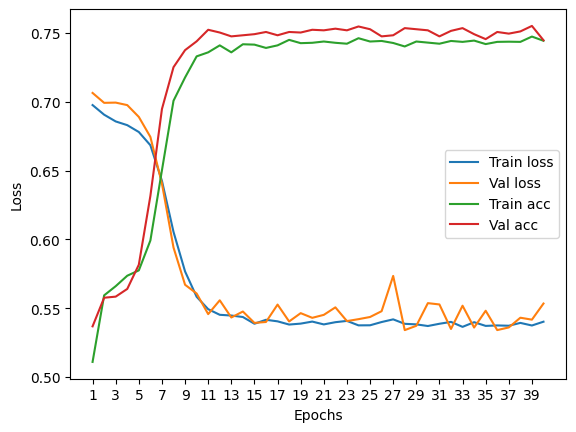

****************************************************************************************************



118it [00:00, 137.92it/s]


Train Epoch: 0 	Loss: 0.696122, Accuracy: 3922/7500 (52%)
Val Epoch: 0 	Loss: 0.702110, Accuracy: 1418/2500 (57%)



118it [00:00, 146.56it/s]


Train Epoch: 1 	Loss: 0.680255, Accuracy: 4390/7500 (59%)
Val Epoch: 1 	Loss: 0.685143, Accuracy: 1448/2500 (58%)



118it [00:00, 160.33it/s]


Train Epoch: 2 	Loss: 0.651920, Accuracy: 4789/7500 (64%)
Val Epoch: 2 	Loss: 0.640938, Accuracy: 1661/2500 (66%)



118it [00:00, 145.03it/s]


Train Epoch: 3 	Loss: 0.616149, Accuracy: 5117/7500 (68%)
Val Epoch: 3 	Loss: 0.609991, Accuracy: 1756/2500 (70%)



118it [00:00, 158.84it/s]


Train Epoch: 4 	Loss: 0.582182, Accuracy: 5365/7500 (72%)
Val Epoch: 4 	Loss: 0.575092, Accuracy: 1814/2500 (73%)



118it [00:00, 160.38it/s]


Train Epoch: 5 	Loss: 0.566729, Accuracy: 5392/7500 (72%)
Val Epoch: 5 	Loss: 0.580835, Accuracy: 1799/2500 (72%)



118it [00:00, 168.16it/s]


Train Epoch: 6 	Loss: 0.560678, Accuracy: 5419/7500 (72%)
Val Epoch: 6 	Loss: 0.564495, Accuracy: 1834/2500 (73%)



118it [00:00, 144.20it/s]


Train Epoch: 7 	Loss: 0.557062, Accuracy: 5464/7500 (73%)
Val Epoch: 7 	Loss: 0.578609, Accuracy: 1825/2500 (73%)



118it [00:00, 165.43it/s]


Train Epoch: 8 	Loss: 0.556440, Accuracy: 5468/7500 (73%)
Val Epoch: 8 	Loss: 0.567237, Accuracy: 1831/2500 (73%)



118it [00:00, 158.29it/s]


Train Epoch: 9 	Loss: 0.556917, Accuracy: 5463/7500 (73%)
Val Epoch: 9 	Loss: 0.571999, Accuracy: 1833/2500 (73%)



118it [00:00, 160.58it/s]


Train Epoch: 10 	Loss: 0.556907, Accuracy: 5472/7500 (73%)
Val Epoch: 10 	Loss: 0.568788, Accuracy: 1836/2500 (73%)



118it [00:00, 160.38it/s]


Train Epoch: 11 	Loss: 0.556291, Accuracy: 5484/7500 (73%)
Val Epoch: 11 	Loss: 0.586020, Accuracy: 1817/2500 (73%)



118it [00:00, 149.13it/s]


Train Epoch: 12 	Loss: 0.557127, Accuracy: 5475/7500 (73%)
Val Epoch: 12 	Loss: 0.558855, Accuracy: 1848/2500 (74%)



118it [00:00, 140.53it/s]


Train Epoch: 13 	Loss: 0.551562, Accuracy: 5495/7500 (73%)
Val Epoch: 13 	Loss: 0.561296, Accuracy: 1824/2500 (73%)



118it [00:00, 134.22it/s]


Train Epoch: 14 	Loss: 0.553569, Accuracy: 5488/7500 (73%)
Val Epoch: 14 	Loss: 0.557937, Accuracy: 1845/2500 (74%)



118it [00:00, 141.76it/s]


Train Epoch: 15 	Loss: 0.553698, Accuracy: 5486/7500 (73%)
Val Epoch: 15 	Loss: 0.556071, Accuracy: 1852/2500 (74%)



118it [00:00, 137.93it/s]


Train Epoch: 16 	Loss: 0.550952, Accuracy: 5494/7500 (73%)
Val Epoch: 16 	Loss: 0.560872, Accuracy: 1849/2500 (74%)



118it [00:00, 147.57it/s]


Train Epoch: 17 	Loss: 0.554494, Accuracy: 5479/7500 (73%)
Val Epoch: 17 	Loss: 0.560124, Accuracy: 1855/2500 (74%)



118it [00:00, 149.31it/s]


Train Epoch: 18 	Loss: 0.551200, Accuracy: 5508/7500 (73%)
Val Epoch: 18 	Loss: 0.565072, Accuracy: 1847/2500 (74%)



118it [00:00, 160.56it/s]


Train Epoch: 19 	Loss: 0.552447, Accuracy: 5489/7500 (73%)
Val Epoch: 19 	Loss: 0.566658, Accuracy: 1850/2500 (74%)



118it [00:00, 158.75it/s]


Train Epoch: 20 	Loss: 0.554571, Accuracy: 5490/7500 (73%)
Val Epoch: 20 	Loss: 0.555450, Accuracy: 1846/2500 (74%)



118it [00:00, 147.42it/s]


Train Epoch: 21 	Loss: 0.551701, Accuracy: 5503/7500 (73%)
Val Epoch: 21 	Loss: 0.572911, Accuracy: 1843/2500 (74%)



118it [00:00, 160.34it/s]


Train Epoch: 22 	Loss: 0.552211, Accuracy: 5482/7500 (73%)
Val Epoch: 22 	Loss: 0.564605, Accuracy: 1849/2500 (74%)



118it [00:00, 150.36it/s]


Train Epoch: 23 	Loss: 0.551999, Accuracy: 5499/7500 (73%)
Val Epoch: 23 	Loss: 0.578527, Accuracy: 1833/2500 (73%)



118it [00:00, 162.00it/s]


Train Epoch: 24 	Loss: 0.553025, Accuracy: 5505/7500 (73%)
Val Epoch: 24 	Loss: 0.566979, Accuracy: 1835/2500 (73%)



118it [00:00, 158.83it/s]


Train Epoch: 25 	Loss: 0.550374, Accuracy: 5499/7500 (73%)
Val Epoch: 25 	Loss: 0.564527, Accuracy: 1848/2500 (74%)



118it [00:00, 147.39it/s]


Train Epoch: 26 	Loss: 0.551860, Accuracy: 5489/7500 (73%)
Val Epoch: 26 	Loss: 0.561533, Accuracy: 1850/2500 (74%)



118it [00:00, 155.61it/s]


Train Epoch: 27 	Loss: 0.550117, Accuracy: 5497/7500 (73%)
Val Epoch: 27 	Loss: 0.573916, Accuracy: 1827/2500 (73%)



118it [00:00, 162.70it/s]


Train Epoch: 28 	Loss: 0.554109, Accuracy: 5490/7500 (73%)
Val Epoch: 28 	Loss: 0.556606, Accuracy: 1842/2500 (74%)



118it [00:00, 138.01it/s]


Train Epoch: 29 	Loss: 0.553911, Accuracy: 5497/7500 (73%)
Val Epoch: 29 	Loss: 0.555870, Accuracy: 1846/2500 (74%)



118it [00:00, 135.50it/s]


Train Epoch: 30 	Loss: 0.553327, Accuracy: 5466/7500 (73%)
Val Epoch: 30 	Loss: 0.559061, Accuracy: 1826/2500 (73%)



118it [00:00, 138.85it/s]


Train Epoch: 31 	Loss: 0.550505, Accuracy: 5482/7500 (73%)
Val Epoch: 31 	Loss: 0.560521, Accuracy: 1850/2500 (74%)



118it [00:00, 146.18it/s]


Train Epoch: 32 	Loss: 0.550928, Accuracy: 5505/7500 (73%)
Val Epoch: 32 	Loss: 0.563395, Accuracy: 1847/2500 (74%)



118it [00:00, 162.14it/s]


Train Epoch: 33 	Loss: 0.553682, Accuracy: 5489/7500 (73%)
Val Epoch: 33 	Loss: 0.569522, Accuracy: 1860/2500 (74%)



118it [00:00, 167.75it/s]


Train Epoch: 34 	Loss: 0.554118, Accuracy: 5504/7500 (73%)
Val Epoch: 34 	Loss: 0.562778, Accuracy: 1852/2500 (74%)



118it [00:00, 154.08it/s]


Train Epoch: 35 	Loss: 0.551801, Accuracy: 5494/7500 (73%)
Val Epoch: 35 	Loss: 0.560313, Accuracy: 1849/2500 (74%)



118it [00:00, 147.40it/s]


Train Epoch: 36 	Loss: 0.552499, Accuracy: 5464/7500 (73%)
Val Epoch: 36 	Loss: 0.560046, Accuracy: 1842/2500 (74%)



118it [00:00, 143.21it/s]


Train Epoch: 37 	Loss: 0.550508, Accuracy: 5509/7500 (73%)
Val Epoch: 37 	Loss: 0.566253, Accuracy: 1843/2500 (74%)



118it [00:00, 158.92it/s]


Train Epoch: 38 	Loss: 0.552175, Accuracy: 5495/7500 (73%)
Val Epoch: 38 	Loss: 0.560512, Accuracy: 1845/2500 (74%)



118it [00:00, 162.51it/s]


Train Epoch: 39 	Loss: 0.551638, Accuracy: 5486/7500 (73%)
Val Epoch: 39 	Loss: 0.563413, Accuracy: 1843/2500 (74%)

Test accuracy:  73.76


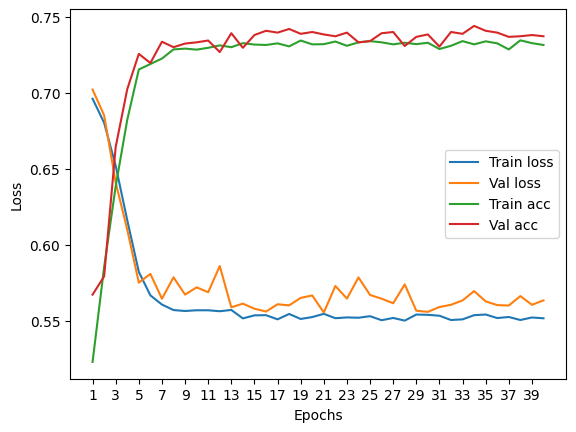

****************************************************************************************************



118it [00:00, 158.92it/s]


Train Epoch: 0 	Loss: 0.697642, Accuracy: 3861/7500 (51%)
Val Epoch: 0 	Loss: 0.705835, Accuracy: 1378/2500 (55%)



118it [00:00, 164.80it/s]


Train Epoch: 1 	Loss: 0.687366, Accuracy: 4239/7500 (57%)
Val Epoch: 1 	Loss: 0.697049, Accuracy: 1438/2500 (58%)



118it [00:00, 150.77it/s]


Train Epoch: 2 	Loss: 0.663338, Accuracy: 4563/7500 (61%)
Val Epoch: 2 	Loss: 0.678488, Accuracy: 1545/2500 (62%)



118it [00:00, 158.60it/s]


Train Epoch: 3 	Loss: 0.624066, Accuracy: 5123/7500 (68%)
Val Epoch: 3 	Loss: 0.619946, Accuracy: 1781/2500 (71%)



118it [00:00, 146.33it/s]


Train Epoch: 4 	Loss: 0.583011, Accuracy: 5409/7500 (72%)
Val Epoch: 4 	Loss: 0.585337, Accuracy: 1830/2500 (73%)



118it [00:00, 151.21it/s]


Train Epoch: 5 	Loss: 0.559775, Accuracy: 5533/7500 (74%)
Val Epoch: 5 	Loss: 0.591576, Accuracy: 1801/2500 (72%)



118it [00:00, 119.15it/s]


Train Epoch: 6 	Loss: 0.545593, Accuracy: 5538/7500 (74%)
Val Epoch: 6 	Loss: 0.572239, Accuracy: 1844/2500 (74%)



118it [00:00, 131.94it/s]


Train Epoch: 7 	Loss: 0.537375, Accuracy: 5607/7500 (75%)
Val Epoch: 7 	Loss: 0.555208, Accuracy: 1860/2500 (74%)



118it [00:00, 139.07it/s]


Train Epoch: 8 	Loss: 0.535371, Accuracy: 5610/7500 (75%)
Val Epoch: 8 	Loss: 0.559715, Accuracy: 1835/2500 (73%)



118it [00:00, 134.30it/s]


Train Epoch: 9 	Loss: 0.534119, Accuracy: 5592/7500 (75%)
Val Epoch: 9 	Loss: 0.571029, Accuracy: 1823/2500 (73%)



118it [00:00, 120.11it/s]


Train Epoch: 10 	Loss: 0.532172, Accuracy: 5598/7500 (75%)
Val Epoch: 10 	Loss: 0.554783, Accuracy: 1841/2500 (74%)



118it [00:00, 149.07it/s]


Train Epoch: 11 	Loss: 0.532406, Accuracy: 5606/7500 (75%)
Val Epoch: 11 	Loss: 0.547243, Accuracy: 1867/2500 (75%)



118it [00:00, 159.06it/s]


Train Epoch: 12 	Loss: 0.532268, Accuracy: 5612/7500 (75%)
Val Epoch: 12 	Loss: 0.561174, Accuracy: 1854/2500 (74%)



118it [00:00, 157.09it/s]


Train Epoch: 13 	Loss: 0.531926, Accuracy: 5612/7500 (75%)
Val Epoch: 13 	Loss: 0.559523, Accuracy: 1851/2500 (74%)



118it [00:00, 158.83it/s]


Train Epoch: 14 	Loss: 0.532282, Accuracy: 5594/7500 (75%)
Val Epoch: 14 	Loss: 0.551628, Accuracy: 1846/2500 (74%)



118it [00:00, 157.45it/s]


Train Epoch: 15 	Loss: 0.529849, Accuracy: 5636/7500 (75%)
Val Epoch: 15 	Loss: 0.557757, Accuracy: 1847/2500 (74%)



118it [00:00, 165.64it/s]


Train Epoch: 16 	Loss: 0.531247, Accuracy: 5619/7500 (75%)
Val Epoch: 16 	Loss: 0.547200, Accuracy: 1860/2500 (74%)



118it [00:00, 160.91it/s]


Train Epoch: 17 	Loss: 0.531718, Accuracy: 5618/7500 (75%)
Val Epoch: 17 	Loss: 0.552151, Accuracy: 1831/2500 (73%)



118it [00:00, 164.48it/s]


Train Epoch: 18 	Loss: 0.531179, Accuracy: 5618/7500 (75%)
Val Epoch: 18 	Loss: 0.553121, Accuracy: 1856/2500 (74%)



118it [00:00, 163.76it/s]


Train Epoch: 19 	Loss: 0.530156, Accuracy: 5596/7500 (75%)
Val Epoch: 19 	Loss: 0.559716, Accuracy: 1854/2500 (74%)



118it [00:00, 157.40it/s]


Train Epoch: 20 	Loss: 0.529004, Accuracy: 5598/7500 (75%)
Val Epoch: 20 	Loss: 0.560961, Accuracy: 1864/2500 (75%)



118it [00:00, 157.09it/s]


Train Epoch: 21 	Loss: 0.533192, Accuracy: 5604/7500 (75%)
Val Epoch: 21 	Loss: 0.551943, Accuracy: 1876/2500 (75%)



118it [00:00, 140.50it/s]


Train Epoch: 22 	Loss: 0.532412, Accuracy: 5591/7500 (75%)
Val Epoch: 22 	Loss: 0.564835, Accuracy: 1841/2500 (74%)



118it [00:00, 157.25it/s]


Train Epoch: 23 	Loss: 0.531216, Accuracy: 5632/7500 (75%)
Val Epoch: 23 	Loss: 0.564427, Accuracy: 1852/2500 (74%)



118it [00:00, 143.16it/s]


Train Epoch: 24 	Loss: 0.531100, Accuracy: 5605/7500 (75%)
Val Epoch: 24 	Loss: 0.545579, Accuracy: 1862/2500 (74%)



118it [00:00, 147.16it/s]


Train Epoch: 25 	Loss: 0.529621, Accuracy: 5609/7500 (75%)
Val Epoch: 25 	Loss: 0.550187, Accuracy: 1863/2500 (75%)



118it [00:00, 138.13it/s]


Train Epoch: 26 	Loss: 0.529149, Accuracy: 5617/7500 (75%)
Val Epoch: 26 	Loss: 0.551573, Accuracy: 1849/2500 (74%)



118it [00:00, 156.40it/s]


Train Epoch: 27 	Loss: 0.529899, Accuracy: 5611/7500 (75%)
Val Epoch: 27 	Loss: 0.553075, Accuracy: 1839/2500 (74%)



118it [00:00, 162.73it/s]


Train Epoch: 28 	Loss: 0.531117, Accuracy: 5618/7500 (75%)
Val Epoch: 28 	Loss: 0.550307, Accuracy: 1840/2500 (74%)



118it [00:01, 112.91it/s]


Train Epoch: 29 	Loss: 0.531232, Accuracy: 5623/7500 (75%)
Val Epoch: 29 	Loss: 0.571116, Accuracy: 1849/2500 (74%)



118it [00:00, 153.98it/s]


Train Epoch: 30 	Loss: 0.529412, Accuracy: 5618/7500 (75%)
Val Epoch: 30 	Loss: 0.552867, Accuracy: 1853/2500 (74%)



118it [00:00, 158.36it/s]


Train Epoch: 31 	Loss: 0.529753, Accuracy: 5627/7500 (75%)
Val Epoch: 31 	Loss: 0.544754, Accuracy: 1862/2500 (74%)



118it [00:00, 152.23it/s]


Train Epoch: 32 	Loss: 0.529535, Accuracy: 5613/7500 (75%)
Val Epoch: 32 	Loss: 0.542798, Accuracy: 1864/2500 (75%)



118it [00:00, 155.61it/s]


Train Epoch: 33 	Loss: 0.529102, Accuracy: 5630/7500 (75%)
Val Epoch: 33 	Loss: 0.554453, Accuracy: 1872/2500 (75%)



118it [00:00, 186.80it/s]


Train Epoch: 34 	Loss: 0.528383, Accuracy: 5618/7500 (75%)
Val Epoch: 34 	Loss: 0.558574, Accuracy: 1866/2500 (75%)



118it [00:00, 137.62it/s]


Train Epoch: 35 	Loss: 0.530893, Accuracy: 5599/7500 (75%)
Val Epoch: 35 	Loss: 0.547710, Accuracy: 1867/2500 (75%)



118it [00:00, 162.48it/s]


Train Epoch: 36 	Loss: 0.530584, Accuracy: 5626/7500 (75%)
Val Epoch: 36 	Loss: 0.550697, Accuracy: 1857/2500 (74%)



118it [00:00, 153.40it/s]


Train Epoch: 37 	Loss: 0.530598, Accuracy: 5614/7500 (75%)
Val Epoch: 37 	Loss: 0.553144, Accuracy: 1843/2500 (74%)



118it [00:00, 161.02it/s]


Train Epoch: 38 	Loss: 0.529012, Accuracy: 5607/7500 (75%)
Val Epoch: 38 	Loss: 0.543194, Accuracy: 1866/2500 (75%)



118it [00:00, 162.10it/s]


Train Epoch: 39 	Loss: 0.528774, Accuracy: 5623/7500 (75%)
Val Epoch: 39 	Loss: 0.553950, Accuracy: 1856/2500 (74%)

Test accuracy:  74.88


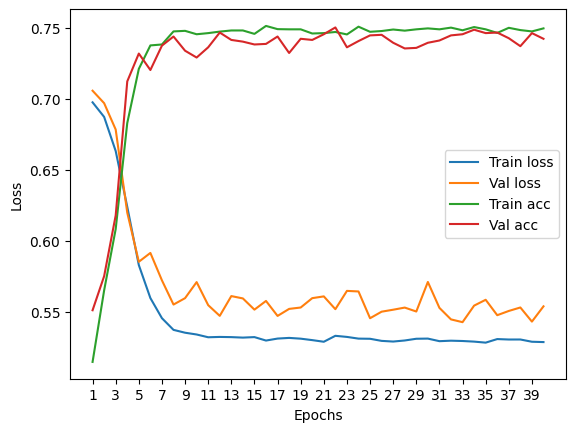

****************************************************************************************************



118it [00:00, 155.84it/s]


Train Epoch: 0 	Loss: 0.696189, Accuracy: 3974/7500 (53%)
Val Epoch: 0 	Loss: 0.704534, Accuracy: 1432/2500 (57%)



118it [00:00, 149.29it/s]


Train Epoch: 1 	Loss: 0.685375, Accuracy: 4336/7500 (58%)
Val Epoch: 1 	Loss: 0.686329, Accuracy: 1508/2500 (60%)



118it [00:00, 162.27it/s]


Train Epoch: 2 	Loss: 0.668422, Accuracy: 4503/7500 (60%)
Val Epoch: 2 	Loss: 0.677184, Accuracy: 1549/2500 (62%)



118it [00:00, 140.87it/s]


Train Epoch: 3 	Loss: 0.651853, Accuracy: 4742/7500 (63%)
Val Epoch: 3 	Loss: 0.645797, Accuracy: 1676/2500 (67%)



118it [00:00, 139.12it/s]


Train Epoch: 4 	Loss: 0.625704, Accuracy: 5086/7500 (68%)
Val Epoch: 4 	Loss: 0.621493, Accuracy: 1727/2500 (69%)



118it [00:00, 137.53it/s]


Train Epoch: 5 	Loss: 0.594866, Accuracy: 5308/7500 (71%)
Val Epoch: 5 	Loss: 0.586689, Accuracy: 1830/2500 (73%)



118it [00:00, 158.80it/s]


Train Epoch: 6 	Loss: 0.568611, Accuracy: 5452/7500 (73%)
Val Epoch: 6 	Loss: 0.570426, Accuracy: 1831/2500 (73%)



118it [00:00, 158.54it/s]


Train Epoch: 7 	Loss: 0.557041, Accuracy: 5463/7500 (73%)
Val Epoch: 7 	Loss: 0.565926, Accuracy: 1851/2500 (74%)



118it [00:00, 167.46it/s]


Train Epoch: 8 	Loss: 0.550182, Accuracy: 5499/7500 (73%)
Val Epoch: 8 	Loss: 0.559107, Accuracy: 1841/2500 (74%)



118it [00:00, 160.97it/s]


Train Epoch: 9 	Loss: 0.547727, Accuracy: 5530/7500 (74%)
Val Epoch: 9 	Loss: 0.559527, Accuracy: 1848/2500 (74%)



118it [00:00, 141.98it/s]


Train Epoch: 10 	Loss: 0.544876, Accuracy: 5519/7500 (74%)
Val Epoch: 10 	Loss: 0.554104, Accuracy: 1858/2500 (74%)



118it [00:00, 138.82it/s]


Train Epoch: 11 	Loss: 0.543939, Accuracy: 5527/7500 (74%)
Val Epoch: 11 	Loss: 0.552373, Accuracy: 1856/2500 (74%)



118it [00:00, 153.92it/s]


Train Epoch: 12 	Loss: 0.542051, Accuracy: 5544/7500 (74%)
Val Epoch: 12 	Loss: 0.555036, Accuracy: 1851/2500 (74%)



118it [00:00, 154.87it/s]


Train Epoch: 13 	Loss: 0.543044, Accuracy: 5523/7500 (74%)
Val Epoch: 13 	Loss: 0.557346, Accuracy: 1840/2500 (74%)



118it [00:00, 157.10it/s]


Train Epoch: 14 	Loss: 0.542849, Accuracy: 5515/7500 (74%)
Val Epoch: 14 	Loss: 0.560193, Accuracy: 1857/2500 (74%)



118it [00:00, 143.35it/s]


Train Epoch: 15 	Loss: 0.542165, Accuracy: 5540/7500 (74%)
Val Epoch: 15 	Loss: 0.555511, Accuracy: 1858/2500 (74%)



118it [00:00, 152.54it/s]


Train Epoch: 16 	Loss: 0.542872, Accuracy: 5528/7500 (74%)
Val Epoch: 16 	Loss: 0.557154, Accuracy: 1825/2500 (73%)



118it [00:00, 146.42it/s]


Train Epoch: 17 	Loss: 0.539874, Accuracy: 5551/7500 (74%)
Val Epoch: 17 	Loss: 0.570029, Accuracy: 1861/2500 (74%)



118it [00:00, 152.31it/s]


Train Epoch: 18 	Loss: 0.541901, Accuracy: 5533/7500 (74%)
Val Epoch: 18 	Loss: 0.563977, Accuracy: 1852/2500 (74%)



118it [00:00, 127.40it/s]


Train Epoch: 19 	Loss: 0.540007, Accuracy: 5551/7500 (74%)
Val Epoch: 19 	Loss: 0.556164, Accuracy: 1845/2500 (74%)



118it [00:00, 131.78it/s]


Train Epoch: 20 	Loss: 0.541624, Accuracy: 5559/7500 (74%)
Val Epoch: 20 	Loss: 0.558809, Accuracy: 1861/2500 (74%)



118it [00:00, 134.22it/s]


Train Epoch: 21 	Loss: 0.540343, Accuracy: 5554/7500 (74%)
Val Epoch: 21 	Loss: 0.565119, Accuracy: 1846/2500 (74%)



118it [00:00, 166.56it/s]


Train Epoch: 22 	Loss: 0.540923, Accuracy: 5535/7500 (74%)
Val Epoch: 22 	Loss: 0.570813, Accuracy: 1812/2500 (72%)



118it [00:00, 156.64it/s]


Train Epoch: 23 	Loss: 0.544116, Accuracy: 5558/7500 (74%)
Val Epoch: 23 	Loss: 0.555007, Accuracy: 1845/2500 (74%)



118it [00:00, 162.75it/s]


Train Epoch: 24 	Loss: 0.544469, Accuracy: 5514/7500 (74%)
Val Epoch: 24 	Loss: 0.566908, Accuracy: 1856/2500 (74%)



118it [00:00, 155.78it/s]


Train Epoch: 25 	Loss: 0.539879, Accuracy: 5527/7500 (74%)
Val Epoch: 25 	Loss: 0.561930, Accuracy: 1845/2500 (74%)



118it [00:00, 150.95it/s]


Train Epoch: 26 	Loss: 0.541382, Accuracy: 5541/7500 (74%)
Val Epoch: 26 	Loss: 0.551493, Accuracy: 1847/2500 (74%)



118it [00:00, 153.57it/s]


Train Epoch: 27 	Loss: 0.539169, Accuracy: 5549/7500 (74%)
Val Epoch: 27 	Loss: 0.562708, Accuracy: 1844/2500 (74%)



118it [00:00, 161.18it/s]


Train Epoch: 28 	Loss: 0.540862, Accuracy: 5545/7500 (74%)
Val Epoch: 28 	Loss: 0.564483, Accuracy: 1853/2500 (74%)



118it [00:00, 159.12it/s]


Train Epoch: 29 	Loss: 0.540676, Accuracy: 5562/7500 (74%)
Val Epoch: 29 	Loss: 0.556224, Accuracy: 1848/2500 (74%)



118it [00:00, 152.00it/s]


Train Epoch: 30 	Loss: 0.540432, Accuracy: 5541/7500 (74%)
Val Epoch: 30 	Loss: 0.560195, Accuracy: 1859/2500 (74%)



118it [00:00, 134.22it/s]


Train Epoch: 31 	Loss: 0.542099, Accuracy: 5551/7500 (74%)
Val Epoch: 31 	Loss: 0.556006, Accuracy: 1833/2500 (73%)



118it [00:00, 155.43it/s]


Train Epoch: 32 	Loss: 0.540126, Accuracy: 5545/7500 (74%)
Val Epoch: 32 	Loss: 0.562287, Accuracy: 1837/2500 (73%)



118it [00:00, 161.05it/s]


Train Epoch: 33 	Loss: 0.538791, Accuracy: 5545/7500 (74%)
Val Epoch: 33 	Loss: 0.556032, Accuracy: 1846/2500 (74%)



118it [00:00, 167.79it/s]


Train Epoch: 34 	Loss: 0.540546, Accuracy: 5538/7500 (74%)
Val Epoch: 34 	Loss: 0.563492, Accuracy: 1830/2500 (73%)



118it [00:00, 128.27it/s]


Train Epoch: 35 	Loss: 0.539873, Accuracy: 5545/7500 (74%)
Val Epoch: 35 	Loss: 0.567848, Accuracy: 1852/2500 (74%)



118it [00:00, 149.26it/s]


Train Epoch: 36 	Loss: 0.542593, Accuracy: 5529/7500 (74%)
Val Epoch: 36 	Loss: 0.560122, Accuracy: 1847/2500 (74%)



118it [00:00, 140.35it/s]


Train Epoch: 37 	Loss: 0.542257, Accuracy: 5537/7500 (74%)
Val Epoch: 37 	Loss: 0.562102, Accuracy: 1835/2500 (73%)



118it [00:00, 162.32it/s]


Train Epoch: 38 	Loss: 0.540173, Accuracy: 5547/7500 (74%)
Val Epoch: 38 	Loss: 0.565111, Accuracy: 1848/2500 (74%)



118it [00:00, 162.71it/s]


Train Epoch: 39 	Loss: 0.538043, Accuracy: 5549/7500 (74%)
Val Epoch: 39 	Loss: 0.562503, Accuracy: 1848/2500 (74%)

Test accuracy:  73.32


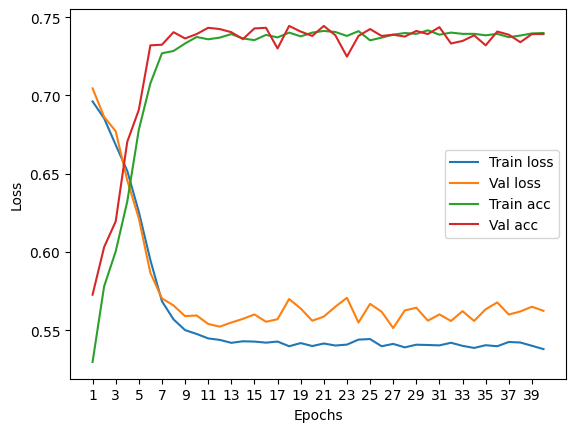

****************************************************************************************************



118it [00:00, 138.08it/s]


Train Epoch: 0 	Loss: 0.695903, Accuracy: 3999/7500 (53%)
Val Epoch: 0 	Loss: 0.708517, Accuracy: 1311/2500 (52%)



118it [00:00, 160.54it/s]


Train Epoch: 1 	Loss: 0.686320, Accuracy: 4227/7500 (56%)
Val Epoch: 1 	Loss: 0.702841, Accuracy: 1352/2500 (54%)



118it [00:00, 160.71it/s]


Train Epoch: 2 	Loss: 0.676191, Accuracy: 4422/7500 (59%)
Val Epoch: 2 	Loss: 0.694379, Accuracy: 1409/2500 (56%)



118it [00:00, 150.95it/s]


Train Epoch: 3 	Loss: 0.663382, Accuracy: 4606/7500 (61%)
Val Epoch: 3 	Loss: 0.679758, Accuracy: 1503/2500 (60%)



118it [00:00, 143.21it/s]


Train Epoch: 4 	Loss: 0.643526, Accuracy: 4837/7500 (64%)
Val Epoch: 4 	Loss: 0.651093, Accuracy: 1630/2500 (65%)



118it [00:00, 158.78it/s]


Train Epoch: 5 	Loss: 0.617776, Accuracy: 5123/7500 (68%)
Val Epoch: 5 	Loss: 0.619378, Accuracy: 1713/2500 (69%)



118it [00:00, 157.29it/s]


Train Epoch: 6 	Loss: 0.594143, Accuracy: 5302/7500 (71%)
Val Epoch: 6 	Loss: 0.600970, Accuracy: 1760/2500 (70%)



118it [00:00, 157.33it/s]


Train Epoch: 7 	Loss: 0.574983, Accuracy: 5436/7500 (72%)
Val Epoch: 7 	Loss: 0.590916, Accuracy: 1825/2500 (73%)



118it [00:00, 153.85it/s]


Train Epoch: 8 	Loss: 0.563438, Accuracy: 5486/7500 (73%)
Val Epoch: 8 	Loss: 0.576116, Accuracy: 1821/2500 (73%)



118it [00:00, 154.33it/s]


Train Epoch: 9 	Loss: 0.555521, Accuracy: 5507/7500 (73%)
Val Epoch: 9 	Loss: 0.564925, Accuracy: 1825/2500 (73%)



118it [00:00, 164.42it/s]


Train Epoch: 10 	Loss: 0.551883, Accuracy: 5523/7500 (74%)
Val Epoch: 10 	Loss: 0.564076, Accuracy: 1829/2500 (73%)



118it [00:00, 157.37it/s]


Train Epoch: 11 	Loss: 0.550427, Accuracy: 5526/7500 (74%)
Val Epoch: 11 	Loss: 0.560050, Accuracy: 1828/2500 (73%)



118it [00:00, 155.19it/s]


Train Epoch: 12 	Loss: 0.546266, Accuracy: 5548/7500 (74%)
Val Epoch: 12 	Loss: 0.574039, Accuracy: 1826/2500 (73%)



118it [00:00, 151.86it/s]


Train Epoch: 13 	Loss: 0.547660, Accuracy: 5522/7500 (74%)
Val Epoch: 13 	Loss: 0.558561, Accuracy: 1827/2500 (73%)



118it [00:00, 162.28it/s]


Train Epoch: 14 	Loss: 0.548771, Accuracy: 5530/7500 (74%)
Val Epoch: 14 	Loss: 0.553253, Accuracy: 1830/2500 (73%)



118it [00:00, 144.58it/s]


Train Epoch: 15 	Loss: 0.543813, Accuracy: 5521/7500 (74%)
Val Epoch: 15 	Loss: 0.549573, Accuracy: 1835/2500 (73%)



118it [00:00, 172.55it/s]


Train Epoch: 16 	Loss: 0.544876, Accuracy: 5547/7500 (74%)
Val Epoch: 16 	Loss: 0.555026, Accuracy: 1825/2500 (73%)



118it [00:01, 101.45it/s]


Train Epoch: 17 	Loss: 0.547461, Accuracy: 5535/7500 (74%)
Val Epoch: 17 	Loss: 0.567092, Accuracy: 1792/2500 (72%)



118it [00:00, 194.24it/s]


Train Epoch: 18 	Loss: 0.545707, Accuracy: 5519/7500 (74%)
Val Epoch: 18 	Loss: 0.557158, Accuracy: 1823/2500 (73%)



118it [00:00, 223.67it/s]


Train Epoch: 19 	Loss: 0.547350, Accuracy: 5531/7500 (74%)
Val Epoch: 19 	Loss: 0.561903, Accuracy: 1804/2500 (72%)



118it [00:00, 204.13it/s]


Train Epoch: 20 	Loss: 0.544753, Accuracy: 5538/7500 (74%)
Val Epoch: 20 	Loss: 0.555370, Accuracy: 1834/2500 (73%)



118it [00:00, 192.58it/s]


Train Epoch: 21 	Loss: 0.545802, Accuracy: 5547/7500 (74%)
Val Epoch: 21 	Loss: 0.559693, Accuracy: 1830/2500 (73%)



118it [00:00, 227.24it/s]


Train Epoch: 22 	Loss: 0.544744, Accuracy: 5559/7500 (74%)
Val Epoch: 22 	Loss: 0.564277, Accuracy: 1826/2500 (73%)



118it [00:00, 219.71it/s]


Train Epoch: 23 	Loss: 0.544938, Accuracy: 5549/7500 (74%)
Val Epoch: 23 	Loss: 0.550754, Accuracy: 1828/2500 (73%)



118it [00:00, 230.87it/s]


Train Epoch: 24 	Loss: 0.544553, Accuracy: 5559/7500 (74%)
Val Epoch: 24 	Loss: 0.552689, Accuracy: 1846/2500 (74%)



118it [00:00, 227.39it/s]


Train Epoch: 25 	Loss: 0.543697, Accuracy: 5545/7500 (74%)
Val Epoch: 25 	Loss: 0.553268, Accuracy: 1823/2500 (73%)



118it [00:00, 230.10it/s]


Train Epoch: 26 	Loss: 0.545725, Accuracy: 5528/7500 (74%)
Val Epoch: 26 	Loss: 0.560423, Accuracy: 1813/2500 (73%)



118it [00:00, 230.62it/s]


Train Epoch: 27 	Loss: 0.546920, Accuracy: 5531/7500 (74%)
Val Epoch: 27 	Loss: 0.564897, Accuracy: 1828/2500 (73%)



118it [00:00, 224.65it/s]


Train Epoch: 28 	Loss: 0.545422, Accuracy: 5559/7500 (74%)
Val Epoch: 28 	Loss: 0.552706, Accuracy: 1829/2500 (73%)



118it [00:00, 224.99it/s]


Train Epoch: 29 	Loss: 0.544998, Accuracy: 5549/7500 (74%)
Val Epoch: 29 	Loss: 0.566075, Accuracy: 1823/2500 (73%)



118it [00:00, 232.80it/s]


Train Epoch: 30 	Loss: 0.548166, Accuracy: 5544/7500 (74%)
Val Epoch: 30 	Loss: 0.573772, Accuracy: 1813/2500 (73%)



118it [00:00, 222.62it/s]


Train Epoch: 31 	Loss: 0.545495, Accuracy: 5548/7500 (74%)
Val Epoch: 31 	Loss: 0.567356, Accuracy: 1823/2500 (73%)



118it [00:00, 231.66it/s]


Train Epoch: 32 	Loss: 0.545183, Accuracy: 5564/7500 (74%)
Val Epoch: 32 	Loss: 0.557668, Accuracy: 1826/2500 (73%)



118it [00:00, 232.91it/s]


Train Epoch: 33 	Loss: 0.544525, Accuracy: 5536/7500 (74%)
Val Epoch: 33 	Loss: 0.551383, Accuracy: 1834/2500 (73%)



118it [00:00, 192.35it/s]


Train Epoch: 34 	Loss: 0.542357, Accuracy: 5550/7500 (74%)
Val Epoch: 34 	Loss: 0.551738, Accuracy: 1837/2500 (73%)



118it [00:00, 178.25it/s]


Train Epoch: 35 	Loss: 0.544904, Accuracy: 5558/7500 (74%)
Val Epoch: 35 	Loss: 0.556951, Accuracy: 1833/2500 (73%)



118it [00:00, 133.76it/s]


Train Epoch: 36 	Loss: 0.545681, Accuracy: 5524/7500 (74%)
Val Epoch: 36 	Loss: 0.561907, Accuracy: 1813/2500 (73%)



118it [00:00, 148.25it/s]


Train Epoch: 37 	Loss: 0.544969, Accuracy: 5549/7500 (74%)
Val Epoch: 37 	Loss: 0.556095, Accuracy: 1834/2500 (73%)



118it [00:00, 155.04it/s]


Train Epoch: 38 	Loss: 0.544922, Accuracy: 5539/7500 (74%)
Val Epoch: 38 	Loss: 0.549266, Accuracy: 1829/2500 (73%)



118it [00:00, 165.62it/s]


Train Epoch: 39 	Loss: 0.544746, Accuracy: 5529/7500 (74%)
Val Epoch: 39 	Loss: 0.562104, Accuracy: 1829/2500 (73%)

Test accuracy:  73.96000000000001


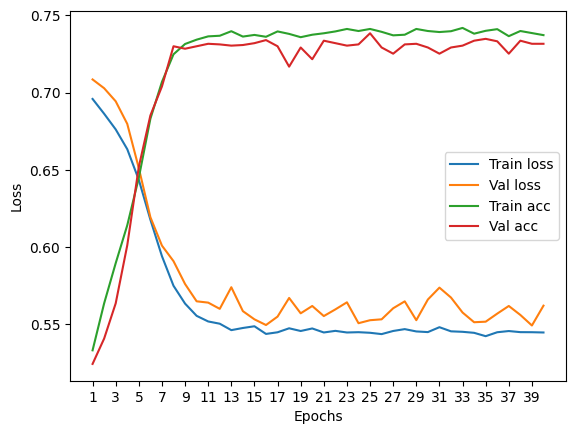

****************************************************************************************************



118it [00:00, 217.82it/s]


Train Epoch: 0 	Loss: 0.694786, Accuracy: 3988/7500 (53%)
Val Epoch: 0 	Loss: 0.697344, Accuracy: 1451/2500 (58%)



118it [00:00, 186.07it/s]


Train Epoch: 1 	Loss: 0.677947, Accuracy: 4430/7500 (59%)
Val Epoch: 1 	Loss: 0.679431, Accuracy: 1499/2500 (60%)



118it [00:00, 187.15it/s]


Train Epoch: 2 	Loss: 0.663669, Accuracy: 4558/7500 (61%)
Val Epoch: 2 	Loss: 0.669825, Accuracy: 1538/2500 (62%)



118it [00:00, 179.69it/s]


Train Epoch: 3 	Loss: 0.641338, Accuracy: 4853/7500 (65%)
Val Epoch: 3 	Loss: 0.638371, Accuracy: 1666/2500 (67%)



118it [00:00, 179.76it/s]


Train Epoch: 4 	Loss: 0.611566, Accuracy: 5244/7500 (70%)
Val Epoch: 4 	Loss: 0.611166, Accuracy: 1728/2500 (69%)



118it [00:00, 143.16it/s]


Train Epoch: 5 	Loss: 0.584370, Accuracy: 5416/7500 (72%)
Val Epoch: 5 	Loss: 0.581687, Accuracy: 1807/2500 (72%)



118it [00:00, 134.77it/s]


Train Epoch: 6 	Loss: 0.565725, Accuracy: 5463/7500 (73%)
Val Epoch: 6 	Loss: 0.571714, Accuracy: 1836/2500 (73%)



118it [00:00, 126.00it/s]


Train Epoch: 7 	Loss: 0.557911, Accuracy: 5487/7500 (73%)
Val Epoch: 7 	Loss: 0.562568, Accuracy: 1846/2500 (74%)



118it [00:00, 141.88it/s]


Train Epoch: 8 	Loss: 0.550323, Accuracy: 5508/7500 (73%)
Val Epoch: 8 	Loss: 0.569570, Accuracy: 1839/2500 (74%)



118it [00:00, 169.70it/s]


Train Epoch: 9 	Loss: 0.550856, Accuracy: 5484/7500 (73%)
Val Epoch: 9 	Loss: 0.552752, Accuracy: 1832/2500 (73%)



118it [00:01, 116.80it/s]


Train Epoch: 10 	Loss: 0.548067, Accuracy: 5496/7500 (73%)
Val Epoch: 10 	Loss: 0.553599, Accuracy: 1838/2500 (74%)



118it [00:00, 153.67it/s]


Train Epoch: 11 	Loss: 0.544613, Accuracy: 5513/7500 (74%)
Val Epoch: 11 	Loss: 0.558954, Accuracy: 1832/2500 (73%)



118it [00:00, 179.13it/s]


Train Epoch: 12 	Loss: 0.545648, Accuracy: 5488/7500 (73%)
Val Epoch: 12 	Loss: 0.552155, Accuracy: 1817/2500 (73%)



118it [00:00, 170.85it/s]


Train Epoch: 13 	Loss: 0.545597, Accuracy: 5523/7500 (74%)
Val Epoch: 13 	Loss: 0.562435, Accuracy: 1812/2500 (72%)



118it [00:00, 142.06it/s]


Train Epoch: 14 	Loss: 0.544987, Accuracy: 5509/7500 (73%)
Val Epoch: 14 	Loss: 0.560506, Accuracy: 1827/2500 (73%)



118it [00:00, 140.18it/s]


Train Epoch: 15 	Loss: 0.545891, Accuracy: 5508/7500 (73%)
Val Epoch: 15 	Loss: 0.551892, Accuracy: 1833/2500 (73%)



118it [00:00, 148.74it/s]


Train Epoch: 16 	Loss: 0.545304, Accuracy: 5500/7500 (73%)
Val Epoch: 16 	Loss: 0.554702, Accuracy: 1847/2500 (74%)



118it [00:00, 142.08it/s]


Train Epoch: 17 	Loss: 0.546182, Accuracy: 5508/7500 (73%)
Val Epoch: 17 	Loss: 0.547097, Accuracy: 1832/2500 (73%)



118it [00:00, 132.80it/s]


Train Epoch: 18 	Loss: 0.545383, Accuracy: 5520/7500 (74%)
Val Epoch: 18 	Loss: 0.547203, Accuracy: 1840/2500 (74%)



118it [00:00, 141.17it/s]


Train Epoch: 19 	Loss: 0.547180, Accuracy: 5491/7500 (73%)
Val Epoch: 19 	Loss: 0.566705, Accuracy: 1837/2500 (73%)



118it [00:01, 111.15it/s]


Train Epoch: 20 	Loss: 0.544944, Accuracy: 5500/7500 (73%)
Val Epoch: 20 	Loss: 0.552691, Accuracy: 1836/2500 (73%)



118it [00:00, 142.67it/s]


Train Epoch: 21 	Loss: 0.547083, Accuracy: 5507/7500 (73%)
Val Epoch: 21 	Loss: 0.554017, Accuracy: 1838/2500 (74%)



118it [00:00, 132.28it/s]


Train Epoch: 22 	Loss: 0.545508, Accuracy: 5525/7500 (74%)
Val Epoch: 22 	Loss: 0.552878, Accuracy: 1839/2500 (74%)



118it [00:00, 144.23it/s]


Train Epoch: 23 	Loss: 0.544975, Accuracy: 5525/7500 (74%)
Val Epoch: 23 	Loss: 0.556947, Accuracy: 1821/2500 (73%)



118it [00:00, 147.62it/s]


Train Epoch: 24 	Loss: 0.543484, Accuracy: 5509/7500 (73%)
Val Epoch: 24 	Loss: 0.550180, Accuracy: 1836/2500 (73%)



118it [00:01, 116.33it/s]


Train Epoch: 25 	Loss: 0.545242, Accuracy: 5522/7500 (74%)
Val Epoch: 25 	Loss: 0.561283, Accuracy: 1843/2500 (74%)



118it [00:00, 141.57it/s]


Train Epoch: 26 	Loss: 0.545783, Accuracy: 5509/7500 (73%)
Val Epoch: 26 	Loss: 0.563720, Accuracy: 1825/2500 (73%)



118it [00:00, 136.76it/s]


Train Epoch: 27 	Loss: 0.544671, Accuracy: 5531/7500 (74%)
Val Epoch: 27 	Loss: 0.552741, Accuracy: 1837/2500 (73%)



118it [00:00, 153.27it/s]


Train Epoch: 28 	Loss: 0.544918, Accuracy: 5506/7500 (73%)
Val Epoch: 28 	Loss: 0.558209, Accuracy: 1834/2500 (73%)



118it [00:00, 156.92it/s]


Train Epoch: 29 	Loss: 0.544905, Accuracy: 5519/7500 (74%)
Val Epoch: 29 	Loss: 0.562849, Accuracy: 1834/2500 (73%)



118it [00:00, 143.83it/s]


Train Epoch: 30 	Loss: 0.543036, Accuracy: 5507/7500 (73%)
Val Epoch: 30 	Loss: 0.547352, Accuracy: 1839/2500 (74%)



118it [00:00, 147.60it/s]


Train Epoch: 31 	Loss: 0.542742, Accuracy: 5532/7500 (74%)
Val Epoch: 31 	Loss: 0.566347, Accuracy: 1835/2500 (73%)



118it [00:00, 147.40it/s]


Train Epoch: 32 	Loss: 0.545154, Accuracy: 5519/7500 (74%)
Val Epoch: 32 	Loss: 0.555702, Accuracy: 1830/2500 (73%)



118it [00:00, 147.29it/s]


Train Epoch: 33 	Loss: 0.542673, Accuracy: 5515/7500 (74%)
Val Epoch: 33 	Loss: 0.548079, Accuracy: 1832/2500 (73%)



118it [00:01, 115.85it/s]


Train Epoch: 34 	Loss: 0.544802, Accuracy: 5508/7500 (73%)
Val Epoch: 34 	Loss: 0.553162, Accuracy: 1825/2500 (73%)



118it [00:00, 120.22it/s]


Train Epoch: 35 	Loss: 0.543159, Accuracy: 5479/7500 (73%)
Val Epoch: 35 	Loss: 0.557634, Accuracy: 1831/2500 (73%)



118it [00:00, 126.89it/s]


Train Epoch: 36 	Loss: 0.543182, Accuracy: 5495/7500 (73%)
Val Epoch: 36 	Loss: 0.545636, Accuracy: 1828/2500 (73%)



118it [00:00, 131.77it/s]


Train Epoch: 37 	Loss: 0.543457, Accuracy: 5533/7500 (74%)
Val Epoch: 37 	Loss: 0.555403, Accuracy: 1837/2500 (73%)



118it [00:00, 152.45it/s]


Train Epoch: 38 	Loss: 0.543571, Accuracy: 5525/7500 (74%)
Val Epoch: 38 	Loss: 0.548671, Accuracy: 1837/2500 (73%)



118it [00:00, 138.33it/s]


Train Epoch: 39 	Loss: 0.543412, Accuracy: 5525/7500 (74%)
Val Epoch: 39 	Loss: 0.559200, Accuracy: 1845/2500 (74%)

Test accuracy:  72.44


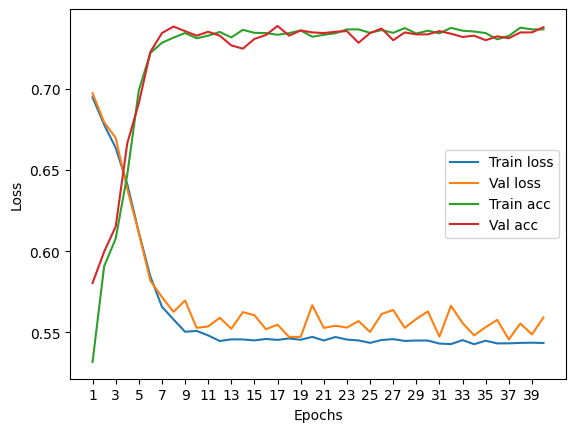

****************************************************************************************************



118it [00:00, 165.34it/s]


Train Epoch: 0 	Loss: 0.698128, Accuracy: 3854/7500 (51%)
Val Epoch: 0 	Loss: 0.706253, Accuracy: 1330/2500 (53%)



118it [00:00, 138.86it/s]


Train Epoch: 1 	Loss: 0.690811, Accuracy: 4166/7500 (56%)
Val Epoch: 1 	Loss: 0.697567, Accuracy: 1430/2500 (57%)



118it [00:00, 139.28it/s]


Train Epoch: 2 	Loss: 0.678921, Accuracy: 4434/7500 (59%)
Val Epoch: 2 	Loss: 0.683984, Accuracy: 1513/2500 (61%)



118it [00:00, 129.29it/s]


Train Epoch: 3 	Loss: 0.652446, Accuracy: 4827/7500 (64%)
Val Epoch: 3 	Loss: 0.638678, Accuracy: 1698/2500 (68%)



118it [00:00, 165.12it/s]


Train Epoch: 4 	Loss: 0.611339, Accuracy: 5243/7500 (70%)
Val Epoch: 4 	Loss: 0.605744, Accuracy: 1791/2500 (72%)



118it [00:00, 136.34it/s]


Train Epoch: 5 	Loss: 0.582047, Accuracy: 5366/7500 (72%)
Val Epoch: 5 	Loss: 0.596508, Accuracy: 1810/2500 (72%)



118it [00:00, 141.42it/s]


Train Epoch: 6 	Loss: 0.567058, Accuracy: 5417/7500 (72%)
Val Epoch: 6 	Loss: 0.569092, Accuracy: 1821/2500 (73%)



118it [00:00, 143.55it/s]


Train Epoch: 7 	Loss: 0.557732, Accuracy: 5483/7500 (73%)
Val Epoch: 7 	Loss: 0.559332, Accuracy: 1833/2500 (73%)



118it [00:00, 140.88it/s]


Train Epoch: 8 	Loss: 0.556153, Accuracy: 5491/7500 (73%)
Val Epoch: 8 	Loss: 0.559895, Accuracy: 1839/2500 (74%)



118it [00:00, 146.51it/s]


Train Epoch: 9 	Loss: 0.554014, Accuracy: 5495/7500 (73%)
Val Epoch: 9 	Loss: 0.551694, Accuracy: 1855/2500 (74%)



118it [00:01, 106.76it/s]


Train Epoch: 10 	Loss: 0.553264, Accuracy: 5465/7500 (73%)
Val Epoch: 10 	Loss: 0.553932, Accuracy: 1846/2500 (74%)



118it [00:00, 119.38it/s]


Train Epoch: 11 	Loss: 0.551582, Accuracy: 5515/7500 (74%)
Val Epoch: 11 	Loss: 0.552190, Accuracy: 1843/2500 (74%)



118it [00:00, 128.78it/s]


Train Epoch: 12 	Loss: 0.553665, Accuracy: 5526/7500 (74%)
Val Epoch: 12 	Loss: 0.555563, Accuracy: 1836/2500 (73%)



118it [00:00, 151.10it/s]


Train Epoch: 13 	Loss: 0.552486, Accuracy: 5513/7500 (74%)
Val Epoch: 13 	Loss: 0.562216, Accuracy: 1822/2500 (73%)



118it [00:00, 141.82it/s]


Train Epoch: 14 	Loss: 0.547960, Accuracy: 5505/7500 (73%)
Val Epoch: 14 	Loss: 0.566203, Accuracy: 1829/2500 (73%)



118it [00:00, 147.16it/s]


Train Epoch: 15 	Loss: 0.551430, Accuracy: 5542/7500 (74%)
Val Epoch: 15 	Loss: 0.549573, Accuracy: 1846/2500 (74%)



118it [00:00, 148.19it/s]


Train Epoch: 16 	Loss: 0.553075, Accuracy: 5540/7500 (74%)
Val Epoch: 16 	Loss: 0.555178, Accuracy: 1843/2500 (74%)



118it [00:00, 134.99it/s]


Train Epoch: 17 	Loss: 0.549927, Accuracy: 5527/7500 (74%)
Val Epoch: 17 	Loss: 0.561455, Accuracy: 1852/2500 (74%)



118it [00:00, 139.16it/s]


Train Epoch: 18 	Loss: 0.549064, Accuracy: 5541/7500 (74%)
Val Epoch: 18 	Loss: 0.580674, Accuracy: 1850/2500 (74%)



118it [00:00, 154.50it/s]


Train Epoch: 19 	Loss: 0.549965, Accuracy: 5518/7500 (74%)
Val Epoch: 19 	Loss: 0.555485, Accuracy: 1847/2500 (74%)



118it [00:00, 124.19it/s]


Train Epoch: 20 	Loss: 0.552583, Accuracy: 5521/7500 (74%)
Val Epoch: 20 	Loss: 0.555494, Accuracy: 1848/2500 (74%)



118it [00:00, 136.70it/s]


Train Epoch: 21 	Loss: 0.549890, Accuracy: 5528/7500 (74%)
Val Epoch: 21 	Loss: 0.564180, Accuracy: 1837/2500 (73%)



118it [00:00, 130.90it/s]


Train Epoch: 22 	Loss: 0.547964, Accuracy: 5565/7500 (74%)
Val Epoch: 22 	Loss: 0.543173, Accuracy: 1857/2500 (74%)



118it [00:00, 138.28it/s]


Train Epoch: 23 	Loss: 0.551131, Accuracy: 5514/7500 (74%)
Val Epoch: 23 	Loss: 0.569806, Accuracy: 1840/2500 (74%)



118it [00:01, 98.67it/s]


Train Epoch: 24 	Loss: 0.548587, Accuracy: 5540/7500 (74%)
Val Epoch: 24 	Loss: 0.558429, Accuracy: 1850/2500 (74%)



118it [00:01, 104.11it/s]


Train Epoch: 25 	Loss: 0.548926, Accuracy: 5535/7500 (74%)
Val Epoch: 25 	Loss: 0.557696, Accuracy: 1850/2500 (74%)



118it [00:00, 124.36it/s]


Train Epoch: 26 	Loss: 0.549262, Accuracy: 5535/7500 (74%)
Val Epoch: 26 	Loss: 0.554028, Accuracy: 1830/2500 (73%)



118it [00:00, 132.62it/s]


Train Epoch: 27 	Loss: 0.548978, Accuracy: 5536/7500 (74%)
Val Epoch: 27 	Loss: 0.551598, Accuracy: 1837/2500 (73%)



118it [00:00, 140.19it/s]


Train Epoch: 28 	Loss: 0.548545, Accuracy: 5529/7500 (74%)
Val Epoch: 28 	Loss: 0.555477, Accuracy: 1855/2500 (74%)



118it [00:00, 144.66it/s]


Train Epoch: 29 	Loss: 0.548456, Accuracy: 5549/7500 (74%)
Val Epoch: 29 	Loss: 0.551127, Accuracy: 1830/2500 (73%)



118it [00:00, 143.87it/s]


Train Epoch: 30 	Loss: 0.548089, Accuracy: 5522/7500 (74%)
Val Epoch: 30 	Loss: 0.551273, Accuracy: 1845/2500 (74%)



118it [00:00, 138.60it/s]


Train Epoch: 31 	Loss: 0.548561, Accuracy: 5569/7500 (74%)
Val Epoch: 31 	Loss: 0.554984, Accuracy: 1839/2500 (74%)



118it [00:00, 142.44it/s]


Train Epoch: 32 	Loss: 0.550480, Accuracy: 5540/7500 (74%)
Val Epoch: 32 	Loss: 0.551001, Accuracy: 1854/2500 (74%)



118it [00:00, 136.83it/s]


Train Epoch: 33 	Loss: 0.553379, Accuracy: 5529/7500 (74%)
Val Epoch: 33 	Loss: 0.567100, Accuracy: 1834/2500 (73%)



118it [00:00, 137.93it/s]


Train Epoch: 34 	Loss: 0.548678, Accuracy: 5530/7500 (74%)
Val Epoch: 34 	Loss: 0.554562, Accuracy: 1847/2500 (74%)



118it [00:00, 139.52it/s]


Train Epoch: 35 	Loss: 0.548181, Accuracy: 5567/7500 (74%)
Val Epoch: 35 	Loss: 0.551254, Accuracy: 1851/2500 (74%)



118it [00:00, 133.03it/s]


Train Epoch: 36 	Loss: 0.549577, Accuracy: 5558/7500 (74%)
Val Epoch: 36 	Loss: 0.549066, Accuracy: 1849/2500 (74%)



118it [00:00, 135.41it/s]


Train Epoch: 37 	Loss: 0.550569, Accuracy: 5525/7500 (74%)
Val Epoch: 37 	Loss: 0.555732, Accuracy: 1840/2500 (74%)



118it [00:01, 115.20it/s]


Train Epoch: 38 	Loss: 0.548269, Accuracy: 5522/7500 (74%)
Val Epoch: 38 	Loss: 0.560673, Accuracy: 1846/2500 (74%)



118it [00:01, 108.35it/s]


Train Epoch: 39 	Loss: 0.547531, Accuracy: 5565/7500 (74%)
Val Epoch: 39 	Loss: 0.547638, Accuracy: 1848/2500 (74%)

Test accuracy:  72.8


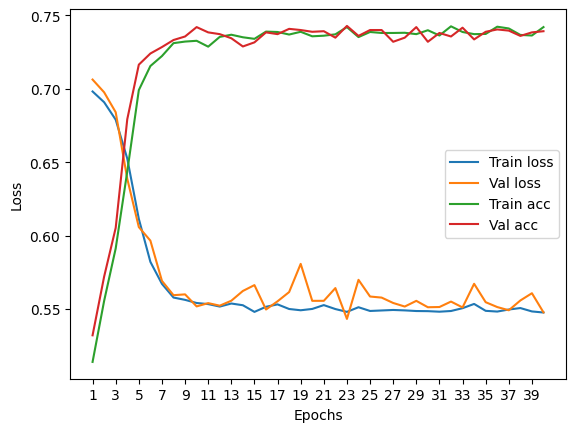

****************************************************************************************************



116it [00:00, 125.88it/s]


Train Epoch: 0 	Loss: 0.692394, Accuracy: 3916/7422 (53%)
Val Epoch: 0 	Loss: 0.692731, Accuracy: 1331/2474 (54%)



116it [00:01, 109.87it/s]


Train Epoch: 1 	Loss: 0.678074, Accuracy: 4436/7422 (60%)
Val Epoch: 1 	Loss: 0.670839, Accuracy: 1514/2474 (61%)



116it [00:00, 129.75it/s]


Train Epoch: 2 	Loss: 0.653181, Accuracy: 4666/7422 (63%)
Val Epoch: 2 	Loss: 0.638237, Accuracy: 1649/2474 (67%)



116it [00:00, 129.88it/s]


Train Epoch: 3 	Loss: 0.617285, Accuracy: 5105/7422 (69%)
Val Epoch: 3 	Loss: 0.594703, Accuracy: 1789/2474 (72%)



116it [00:00, 133.55it/s]


Train Epoch: 4 	Loss: 0.581467, Accuracy: 5296/7422 (71%)
Val Epoch: 4 	Loss: 0.566264, Accuracy: 1811/2474 (73%)



116it [00:00, 137.69it/s]


Train Epoch: 5 	Loss: 0.559664, Accuracy: 5422/7422 (73%)
Val Epoch: 5 	Loss: 0.547240, Accuracy: 1847/2474 (75%)



116it [00:00, 136.25it/s]


Train Epoch: 6 	Loss: 0.547152, Accuracy: 5463/7422 (74%)
Val Epoch: 6 	Loss: 0.536920, Accuracy: 1842/2474 (74%)



116it [00:00, 135.68it/s]


Train Epoch: 7 	Loss: 0.544893, Accuracy: 5498/7422 (74%)
Val Epoch: 7 	Loss: 0.533944, Accuracy: 1847/2474 (75%)



116it [00:00, 129.66it/s]


Train Epoch: 8 	Loss: 0.540888, Accuracy: 5491/7422 (74%)
Val Epoch: 8 	Loss: 0.532499, Accuracy: 1858/2474 (75%)



116it [00:00, 134.04it/s]


Train Epoch: 9 	Loss: 0.539976, Accuracy: 5490/7422 (74%)
Val Epoch: 9 	Loss: 0.530925, Accuracy: 1861/2474 (75%)



116it [00:00, 143.36it/s]


Train Epoch: 10 	Loss: 0.540555, Accuracy: 5503/7422 (74%)
Val Epoch: 10 	Loss: 0.531706, Accuracy: 1852/2474 (75%)



116it [00:00, 131.84it/s]


Train Epoch: 11 	Loss: 0.537811, Accuracy: 5486/7422 (74%)
Val Epoch: 11 	Loss: 0.532041, Accuracy: 1860/2474 (75%)



116it [00:00, 138.39it/s]


Train Epoch: 12 	Loss: 0.537949, Accuracy: 5493/7422 (74%)
Val Epoch: 12 	Loss: 0.529468, Accuracy: 1842/2474 (74%)



116it [00:00, 118.37it/s]


Train Epoch: 13 	Loss: 0.537711, Accuracy: 5544/7422 (75%)
Val Epoch: 13 	Loss: 0.528348, Accuracy: 1852/2474 (75%)



116it [00:01, 100.70it/s]


Train Epoch: 14 	Loss: 0.538078, Accuracy: 5522/7422 (74%)
Val Epoch: 14 	Loss: 0.528443, Accuracy: 1871/2474 (76%)



116it [00:01, 102.67it/s]


Train Epoch: 15 	Loss: 0.537328, Accuracy: 5533/7422 (75%)
Val Epoch: 15 	Loss: 0.530433, Accuracy: 1864/2474 (75%)



116it [00:00, 141.77it/s]


Train Epoch: 16 	Loss: 0.535943, Accuracy: 5532/7422 (75%)
Val Epoch: 16 	Loss: 0.541948, Accuracy: 1846/2474 (75%)



116it [00:00, 151.00it/s]


Train Epoch: 17 	Loss: 0.536221, Accuracy: 5521/7422 (74%)
Val Epoch: 17 	Loss: 0.529670, Accuracy: 1867/2474 (75%)



116it [00:00, 138.92it/s]


Train Epoch: 18 	Loss: 0.536889, Accuracy: 5528/7422 (74%)
Val Epoch: 18 	Loss: 0.527895, Accuracy: 1874/2474 (76%)



116it [00:00, 131.59it/s]


Train Epoch: 19 	Loss: 0.540438, Accuracy: 5494/7422 (74%)
Val Epoch: 19 	Loss: 0.537910, Accuracy: 1839/2474 (74%)



116it [00:00, 131.90it/s]


Train Epoch: 20 	Loss: 0.537293, Accuracy: 5525/7422 (74%)
Val Epoch: 20 	Loss: 0.528875, Accuracy: 1864/2474 (75%)



116it [00:00, 140.97it/s]


Train Epoch: 21 	Loss: 0.537384, Accuracy: 5534/7422 (75%)
Val Epoch: 21 	Loss: 0.528998, Accuracy: 1869/2474 (76%)



116it [00:00, 141.31it/s]


Train Epoch: 22 	Loss: 0.535890, Accuracy: 5518/7422 (74%)
Val Epoch: 22 	Loss: 0.529005, Accuracy: 1876/2474 (76%)



116it [00:00, 131.62it/s]


Train Epoch: 23 	Loss: 0.536920, Accuracy: 5499/7422 (74%)
Val Epoch: 23 	Loss: 0.528262, Accuracy: 1863/2474 (75%)



116it [00:00, 136.93it/s]


Train Epoch: 24 	Loss: 0.534738, Accuracy: 5548/7422 (75%)
Val Epoch: 24 	Loss: 0.531133, Accuracy: 1873/2474 (76%)



116it [00:00, 128.18it/s]


Train Epoch: 25 	Loss: 0.536366, Accuracy: 5539/7422 (75%)
Val Epoch: 25 	Loss: 0.532992, Accuracy: 1836/2474 (74%)



116it [00:00, 134.92it/s]


Train Epoch: 26 	Loss: 0.536556, Accuracy: 5529/7422 (74%)
Val Epoch: 26 	Loss: 0.530625, Accuracy: 1840/2474 (74%)



116it [00:01, 107.20it/s]


Train Epoch: 27 	Loss: 0.535826, Accuracy: 5553/7422 (75%)
Val Epoch: 27 	Loss: 0.534601, Accuracy: 1824/2474 (74%)



116it [00:01, 109.22it/s]


Train Epoch: 28 	Loss: 0.536799, Accuracy: 5536/7422 (75%)
Val Epoch: 28 	Loss: 0.528368, Accuracy: 1870/2474 (76%)



116it [00:01, 111.21it/s]


Train Epoch: 29 	Loss: 0.536187, Accuracy: 5538/7422 (75%)
Val Epoch: 29 	Loss: 0.527871, Accuracy: 1868/2474 (76%)



116it [00:00, 138.71it/s]


Train Epoch: 30 	Loss: 0.535380, Accuracy: 5525/7422 (74%)
Val Epoch: 30 	Loss: 0.535554, Accuracy: 1858/2474 (75%)



116it [00:00, 134.70it/s]


Train Epoch: 31 	Loss: 0.536081, Accuracy: 5550/7422 (75%)
Val Epoch: 31 	Loss: 0.531721, Accuracy: 1855/2474 (75%)



116it [00:01, 114.58it/s]


Train Epoch: 32 	Loss: 0.534592, Accuracy: 5550/7422 (75%)
Val Epoch: 32 	Loss: 0.528498, Accuracy: 1858/2474 (75%)



116it [00:00, 138.22it/s]


Train Epoch: 33 	Loss: 0.535354, Accuracy: 5567/7422 (75%)
Val Epoch: 33 	Loss: 0.533309, Accuracy: 1850/2474 (75%)



116it [00:00, 126.77it/s]


Train Epoch: 34 	Loss: 0.537685, Accuracy: 5513/7422 (74%)
Val Epoch: 34 	Loss: 0.542076, Accuracy: 1836/2474 (74%)



116it [00:00, 151.86it/s]


Train Epoch: 35 	Loss: 0.535574, Accuracy: 5533/7422 (75%)
Val Epoch: 35 	Loss: 0.529308, Accuracy: 1873/2474 (76%)



116it [00:00, 140.97it/s]


Train Epoch: 36 	Loss: 0.536686, Accuracy: 5529/7422 (74%)
Val Epoch: 36 	Loss: 0.528773, Accuracy: 1866/2474 (75%)



116it [00:00, 132.24it/s]


Train Epoch: 37 	Loss: 0.534877, Accuracy: 5518/7422 (74%)
Val Epoch: 37 	Loss: 0.535533, Accuracy: 1847/2474 (75%)



116it [00:00, 135.60it/s]


Train Epoch: 38 	Loss: 0.537548, Accuracy: 5534/7422 (75%)
Val Epoch: 38 	Loss: 0.527970, Accuracy: 1870/2474 (76%)



116it [00:00, 140.13it/s]


Train Epoch: 39 	Loss: 0.537241, Accuracy: 5510/7422 (74%)
Val Epoch: 39 	Loss: 0.530212, Accuracy: 1864/2474 (75%)

Test accuracy:  71.82700080840743


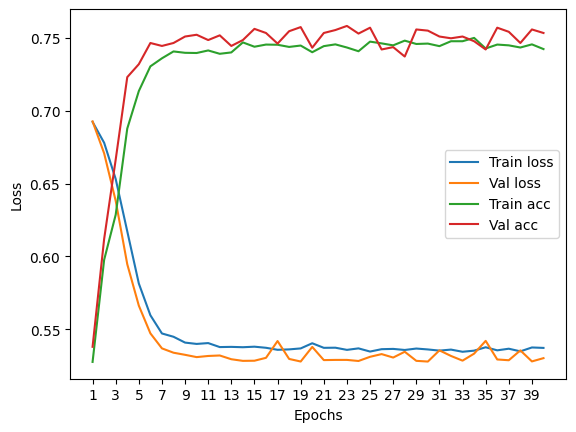

****************************************************************************************************



Particles per jet: 12


118it [00:00, 124.45it/s]


Train Epoch: 0 	Loss: 0.694868, Accuracy: 4002/7500 (53%)
Val Epoch: 0 	Loss: 0.702430, Accuracy: 1423/2500 (57%)



118it [00:00, 128.92it/s]


Train Epoch: 1 	Loss: 0.687414, Accuracy: 4234/7500 (56%)
Val Epoch: 1 	Loss: 0.692834, Accuracy: 1451/2500 (58%)



118it [00:00, 141.21it/s]


Train Epoch: 2 	Loss: 0.678059, Accuracy: 4407/7500 (59%)
Val Epoch: 2 	Loss: 0.681906, Accuracy: 1484/2500 (59%)



118it [00:00, 136.22it/s]


Train Epoch: 3 	Loss: 0.668650, Accuracy: 4502/7500 (60%)
Val Epoch: 3 	Loss: 0.666948, Accuracy: 1567/2500 (63%)



118it [00:00, 132.21it/s]


Train Epoch: 4 	Loss: 0.654613, Accuracy: 4755/7500 (63%)
Val Epoch: 4 	Loss: 0.645721, Accuracy: 1676/2500 (67%)



118it [00:00, 132.34it/s]


Train Epoch: 5 	Loss: 0.629171, Accuracy: 5058/7500 (67%)
Val Epoch: 5 	Loss: 0.615140, Accuracy: 1771/2500 (71%)



118it [00:00, 136.03it/s]


Train Epoch: 6 	Loss: 0.603877, Accuracy: 5275/7500 (70%)
Val Epoch: 6 	Loss: 0.586544, Accuracy: 1815/2500 (73%)



118it [00:00, 127.96it/s]


Train Epoch: 7 	Loss: 0.580345, Accuracy: 5432/7500 (72%)
Val Epoch: 7 	Loss: 0.571086, Accuracy: 1848/2500 (74%)



118it [00:00, 139.04it/s]


Train Epoch: 8 	Loss: 0.563692, Accuracy: 5498/7500 (73%)
Val Epoch: 8 	Loss: 0.558631, Accuracy: 1869/2500 (75%)



118it [00:00, 137.55it/s]


Train Epoch: 9 	Loss: 0.554326, Accuracy: 5558/7500 (74%)
Val Epoch: 9 	Loss: 0.560142, Accuracy: 1860/2500 (74%)



118it [00:00, 135.73it/s]


Train Epoch: 10 	Loss: 0.551852, Accuracy: 5550/7500 (74%)
Val Epoch: 10 	Loss: 0.548616, Accuracy: 1863/2500 (75%)



118it [00:00, 131.28it/s]


Train Epoch: 11 	Loss: 0.542940, Accuracy: 5570/7500 (74%)
Val Epoch: 11 	Loss: 0.557365, Accuracy: 1884/2500 (75%)



118it [00:01, 100.88it/s]


Train Epoch: 12 	Loss: 0.540439, Accuracy: 5571/7500 (74%)
Val Epoch: 12 	Loss: 0.543224, Accuracy: 1871/2500 (75%)



118it [00:01, 97.68it/s] 


Train Epoch: 13 	Loss: 0.540508, Accuracy: 5541/7500 (74%)
Val Epoch: 13 	Loss: 0.552443, Accuracy: 1885/2500 (75%)



118it [00:01, 108.51it/s]


Train Epoch: 14 	Loss: 0.543156, Accuracy: 5576/7500 (74%)
Val Epoch: 14 	Loss: 0.540140, Accuracy: 1876/2500 (75%)



118it [00:00, 134.77it/s]


Train Epoch: 15 	Loss: 0.538339, Accuracy: 5561/7500 (74%)
Val Epoch: 15 	Loss: 0.547574, Accuracy: 1868/2500 (75%)



118it [00:00, 130.85it/s]


Train Epoch: 16 	Loss: 0.540257, Accuracy: 5591/7500 (75%)
Val Epoch: 16 	Loss: 0.537236, Accuracy: 1871/2500 (75%)



118it [00:00, 137.15it/s]


Train Epoch: 17 	Loss: 0.536571, Accuracy: 5584/7500 (74%)
Val Epoch: 17 	Loss: 0.531882, Accuracy: 1883/2500 (75%)



118it [00:00, 135.66it/s]


Train Epoch: 18 	Loss: 0.535464, Accuracy: 5597/7500 (75%)
Val Epoch: 18 	Loss: 0.536240, Accuracy: 1871/2500 (75%)



118it [00:00, 138.49it/s]


Train Epoch: 19 	Loss: 0.537649, Accuracy: 5599/7500 (75%)
Val Epoch: 19 	Loss: 0.552685, Accuracy: 1883/2500 (75%)



118it [00:00, 118.41it/s]


Train Epoch: 20 	Loss: 0.538544, Accuracy: 5591/7500 (75%)
Val Epoch: 20 	Loss: 0.541271, Accuracy: 1862/2500 (74%)



118it [00:00, 125.73it/s]


Train Epoch: 21 	Loss: 0.537297, Accuracy: 5590/7500 (75%)
Val Epoch: 21 	Loss: 0.539109, Accuracy: 1882/2500 (75%)



118it [00:00, 130.83it/s]


Train Epoch: 22 	Loss: 0.537428, Accuracy: 5586/7500 (74%)
Val Epoch: 22 	Loss: 0.543635, Accuracy: 1882/2500 (75%)



118it [00:00, 131.94it/s]


Train Epoch: 23 	Loss: 0.537743, Accuracy: 5598/7500 (75%)
Val Epoch: 23 	Loss: 0.533821, Accuracy: 1885/2500 (75%)



118it [00:00, 122.02it/s]


Train Epoch: 24 	Loss: 0.539075, Accuracy: 5582/7500 (74%)
Val Epoch: 24 	Loss: 0.540177, Accuracy: 1875/2500 (75%)



118it [00:01, 98.57it/s] 


Train Epoch: 25 	Loss: 0.537761, Accuracy: 5575/7500 (74%)
Val Epoch: 25 	Loss: 0.542129, Accuracy: 1871/2500 (75%)



118it [00:01, 114.60it/s]


Train Epoch: 26 	Loss: 0.537214, Accuracy: 5590/7500 (75%)
Val Epoch: 26 	Loss: 0.542697, Accuracy: 1877/2500 (75%)



118it [00:01, 112.28it/s]


Train Epoch: 27 	Loss: 0.536917, Accuracy: 5607/7500 (75%)
Val Epoch: 27 	Loss: 0.534749, Accuracy: 1879/2500 (75%)



118it [00:00, 138.90it/s]


Train Epoch: 28 	Loss: 0.539410, Accuracy: 5588/7500 (75%)
Val Epoch: 28 	Loss: 0.531861, Accuracy: 1891/2500 (76%)



118it [00:00, 139.21it/s]


Train Epoch: 29 	Loss: 0.540156, Accuracy: 5618/7500 (75%)
Val Epoch: 29 	Loss: 0.552970, Accuracy: 1896/2500 (76%)



118it [00:00, 136.51it/s]


Train Epoch: 30 	Loss: 0.539810, Accuracy: 5591/7500 (75%)
Val Epoch: 30 	Loss: 0.535834, Accuracy: 1863/2500 (75%)



118it [00:00, 135.27it/s]


Train Epoch: 31 	Loss: 0.536645, Accuracy: 5597/7500 (75%)
Val Epoch: 31 	Loss: 0.531709, Accuracy: 1885/2500 (75%)



118it [00:00, 136.32it/s]


Train Epoch: 32 	Loss: 0.537299, Accuracy: 5587/7500 (74%)
Val Epoch: 32 	Loss: 0.548811, Accuracy: 1892/2500 (76%)



118it [00:00, 140.34it/s]


Train Epoch: 33 	Loss: 0.537395, Accuracy: 5607/7500 (75%)
Val Epoch: 33 	Loss: 0.545571, Accuracy: 1882/2500 (75%)



118it [00:00, 135.07it/s]


Train Epoch: 34 	Loss: 0.535979, Accuracy: 5597/7500 (75%)
Val Epoch: 34 	Loss: 0.545972, Accuracy: 1882/2500 (75%)



118it [00:00, 130.85it/s]


Train Epoch: 35 	Loss: 0.539041, Accuracy: 5592/7500 (75%)
Val Epoch: 35 	Loss: 0.535737, Accuracy: 1883/2500 (75%)



118it [00:00, 134.94it/s]


Train Epoch: 36 	Loss: 0.537220, Accuracy: 5596/7500 (75%)
Val Epoch: 36 	Loss: 0.537342, Accuracy: 1881/2500 (75%)



118it [00:00, 130.79it/s]


Train Epoch: 37 	Loss: 0.536798, Accuracy: 5627/7500 (75%)
Val Epoch: 37 	Loss: 0.543069, Accuracy: 1840/2500 (74%)



118it [00:00, 141.82it/s]


Train Epoch: 38 	Loss: 0.536064, Accuracy: 5595/7500 (75%)
Val Epoch: 38 	Loss: 0.533605, Accuracy: 1887/2500 (75%)



118it [00:01, 103.41it/s]


Train Epoch: 39 	Loss: 0.535440, Accuracy: 5601/7500 (75%)
Val Epoch: 39 	Loss: 0.542607, Accuracy: 1883/2500 (75%)

Test accuracy:  74.16


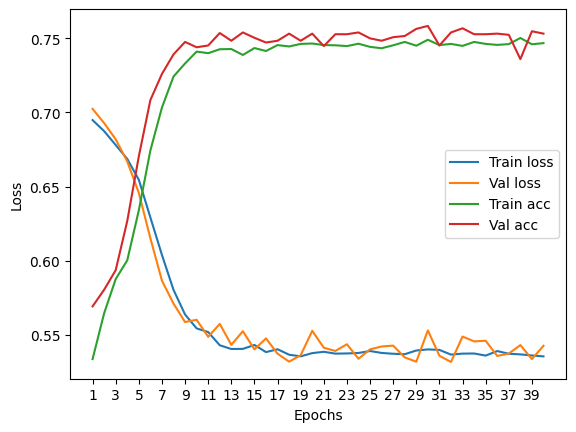

****************************************************************************************************



118it [00:00, 144.53it/s]


Train Epoch: 0 	Loss: 0.696052, Accuracy: 3936/7500 (52%)
Val Epoch: 0 	Loss: 0.701383, Accuracy: 1479/2500 (59%)



118it [00:00, 137.11it/s]


Train Epoch: 1 	Loss: 0.679452, Accuracy: 4519/7500 (60%)
Val Epoch: 1 	Loss: 0.684331, Accuracy: 1513/2500 (61%)



118it [00:00, 143.48it/s]


Train Epoch: 2 	Loss: 0.653635, Accuracy: 4779/7500 (64%)
Val Epoch: 2 	Loss: 0.664471, Accuracy: 1525/2500 (61%)



118it [00:01, 99.44it/s] 


Train Epoch: 3 	Loss: 0.625062, Accuracy: 5089/7500 (68%)
Val Epoch: 3 	Loss: 0.616627, Accuracy: 1794/2500 (72%)



118it [00:00, 135.19it/s]


Train Epoch: 4 	Loss: 0.599727, Accuracy: 5286/7500 (70%)
Val Epoch: 4 	Loss: 0.596305, Accuracy: 1795/2500 (72%)



118it [00:01, 117.92it/s]


Train Epoch: 5 	Loss: 0.581425, Accuracy: 5379/7500 (72%)
Val Epoch: 5 	Loss: 0.587689, Accuracy: 1832/2500 (73%)



118it [00:00, 130.89it/s]


Train Epoch: 6 	Loss: 0.569913, Accuracy: 5481/7500 (73%)
Val Epoch: 6 	Loss: 0.565254, Accuracy: 1852/2500 (74%)



118it [00:00, 138.76it/s]


Train Epoch: 7 	Loss: 0.563470, Accuracy: 5463/7500 (73%)
Val Epoch: 7 	Loss: 0.563807, Accuracy: 1839/2500 (74%)



118it [00:01, 115.15it/s]


Train Epoch: 8 	Loss: 0.560431, Accuracy: 5457/7500 (73%)
Val Epoch: 8 	Loss: 0.565347, Accuracy: 1824/2500 (73%)



118it [00:00, 149.62it/s]


Train Epoch: 9 	Loss: 0.554480, Accuracy: 5503/7500 (73%)
Val Epoch: 9 	Loss: 0.563639, Accuracy: 1823/2500 (73%)



118it [00:00, 128.93it/s]


Train Epoch: 10 	Loss: 0.555359, Accuracy: 5503/7500 (73%)
Val Epoch: 10 	Loss: 0.545359, Accuracy: 1853/2500 (74%)



118it [00:01, 100.97it/s]


Train Epoch: 11 	Loss: 0.550903, Accuracy: 5517/7500 (74%)
Val Epoch: 11 	Loss: 0.559358, Accuracy: 1858/2500 (74%)



118it [00:01, 87.03it/s]


Train Epoch: 12 	Loss: 0.550115, Accuracy: 5520/7500 (74%)
Val Epoch: 12 	Loss: 0.554336, Accuracy: 1869/2500 (75%)



118it [00:01, 103.85it/s]


Train Epoch: 13 	Loss: 0.549675, Accuracy: 5537/7500 (74%)
Val Epoch: 13 	Loss: 0.548109, Accuracy: 1850/2500 (74%)



118it [00:00, 143.40it/s]


Train Epoch: 14 	Loss: 0.552146, Accuracy: 5481/7500 (73%)
Val Epoch: 14 	Loss: 0.560809, Accuracy: 1868/2500 (75%)



118it [00:01, 111.87it/s]


Train Epoch: 15 	Loss: 0.548617, Accuracy: 5542/7500 (74%)
Val Epoch: 15 	Loss: 0.551134, Accuracy: 1845/2500 (74%)



118it [00:01, 110.88it/s]


Train Epoch: 16 	Loss: 0.553386, Accuracy: 5497/7500 (73%)
Val Epoch: 16 	Loss: 0.550149, Accuracy: 1855/2500 (74%)



118it [00:01, 113.11it/s]


Train Epoch: 17 	Loss: 0.551154, Accuracy: 5532/7500 (74%)
Val Epoch: 17 	Loss: 0.541930, Accuracy: 1862/2500 (74%)



118it [00:01, 117.71it/s]


Train Epoch: 18 	Loss: 0.552896, Accuracy: 5525/7500 (74%)
Val Epoch: 18 	Loss: 0.551736, Accuracy: 1853/2500 (74%)



118it [00:00, 128.06it/s]


Train Epoch: 19 	Loss: 0.550606, Accuracy: 5492/7500 (73%)
Val Epoch: 19 	Loss: 0.546846, Accuracy: 1860/2500 (74%)



118it [00:00, 127.78it/s]


Train Epoch: 20 	Loss: 0.551121, Accuracy: 5544/7500 (74%)
Val Epoch: 20 	Loss: 0.559037, Accuracy: 1838/2500 (74%)



118it [00:00, 119.83it/s]


Train Epoch: 21 	Loss: 0.550057, Accuracy: 5525/7500 (74%)
Val Epoch: 21 	Loss: 0.565687, Accuracy: 1869/2500 (75%)



118it [00:01, 88.34it/s]


Train Epoch: 22 	Loss: 0.550298, Accuracy: 5504/7500 (73%)
Val Epoch: 22 	Loss: 0.552220, Accuracy: 1857/2500 (74%)



118it [00:01, 96.51it/s] 


Train Epoch: 23 	Loss: 0.549094, Accuracy: 5518/7500 (74%)
Val Epoch: 23 	Loss: 0.552632, Accuracy: 1850/2500 (74%)



118it [00:01, 101.30it/s]


Train Epoch: 24 	Loss: 0.551455, Accuracy: 5523/7500 (74%)
Val Epoch: 24 	Loss: 0.553175, Accuracy: 1868/2500 (75%)



118it [00:00, 124.76it/s]


Train Epoch: 25 	Loss: 0.553156, Accuracy: 5500/7500 (73%)
Val Epoch: 25 	Loss: 0.554115, Accuracy: 1860/2500 (74%)



118it [00:01, 108.88it/s]


Train Epoch: 26 	Loss: 0.551443, Accuracy: 5534/7500 (74%)
Val Epoch: 26 	Loss: 0.559241, Accuracy: 1867/2500 (75%)



118it [00:00, 131.67it/s]


Train Epoch: 27 	Loss: 0.550341, Accuracy: 5533/7500 (74%)
Val Epoch: 27 	Loss: 0.548254, Accuracy: 1869/2500 (75%)



118it [00:00, 118.63it/s]


Train Epoch: 28 	Loss: 0.550664, Accuracy: 5552/7500 (74%)
Val Epoch: 28 	Loss: 0.601111, Accuracy: 1833/2500 (73%)



118it [00:00, 128.86it/s]


Train Epoch: 29 	Loss: 0.551800, Accuracy: 5529/7500 (74%)
Val Epoch: 29 	Loss: 0.555428, Accuracy: 1858/2500 (74%)



118it [00:00, 119.72it/s]


Train Epoch: 30 	Loss: 0.549716, Accuracy: 5534/7500 (74%)
Val Epoch: 30 	Loss: 0.558150, Accuracy: 1849/2500 (74%)



118it [00:00, 139.89it/s]


Train Epoch: 31 	Loss: 0.548743, Accuracy: 5536/7500 (74%)
Val Epoch: 31 	Loss: 0.556745, Accuracy: 1855/2500 (74%)



118it [00:00, 137.27it/s]


Train Epoch: 32 	Loss: 0.549785, Accuracy: 5534/7500 (74%)
Val Epoch: 32 	Loss: 0.547592, Accuracy: 1867/2500 (75%)



118it [00:00, 135.79it/s]


Train Epoch: 33 	Loss: 0.549404, Accuracy: 5525/7500 (74%)
Val Epoch: 33 	Loss: 0.550902, Accuracy: 1866/2500 (75%)



118it [00:00, 133.99it/s]


Train Epoch: 34 	Loss: 0.548968, Accuracy: 5552/7500 (74%)
Val Epoch: 34 	Loss: 0.560264, Accuracy: 1877/2500 (75%)



118it [00:01, 103.20it/s]


Train Epoch: 35 	Loss: 0.551136, Accuracy: 5519/7500 (74%)
Val Epoch: 35 	Loss: 0.563308, Accuracy: 1864/2500 (75%)



118it [00:01, 100.36it/s]


Train Epoch: 36 	Loss: 0.550525, Accuracy: 5512/7500 (73%)
Val Epoch: 36 	Loss: 0.551346, Accuracy: 1860/2500 (74%)



118it [00:00, 133.72it/s]


Train Epoch: 37 	Loss: 0.550110, Accuracy: 5541/7500 (74%)
Val Epoch: 37 	Loss: 0.549280, Accuracy: 1865/2500 (75%)



118it [00:00, 133.35it/s]


Train Epoch: 38 	Loss: 0.550436, Accuracy: 5523/7500 (74%)
Val Epoch: 38 	Loss: 0.547977, Accuracy: 1866/2500 (75%)



118it [00:00, 142.50it/s]


Train Epoch: 39 	Loss: 0.550972, Accuracy: 5512/7500 (73%)
Val Epoch: 39 	Loss: 0.546158, Accuracy: 1862/2500 (74%)

Test accuracy:  73.11999999999999


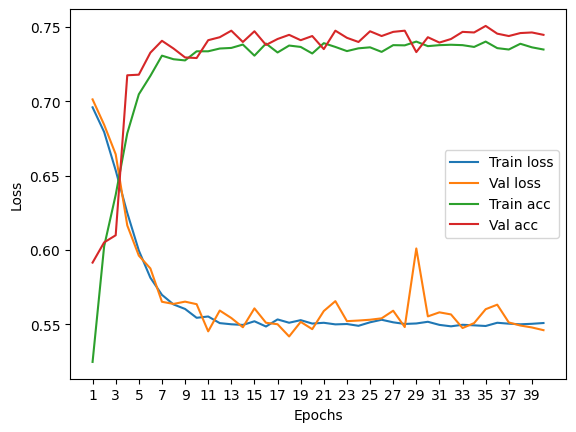

****************************************************************************************************



118it [00:00, 123.12it/s]


Train Epoch: 0 	Loss: 0.697277, Accuracy: 3941/7500 (53%)
Val Epoch: 0 	Loss: 0.706073, Accuracy: 1326/2500 (53%)



118it [00:00, 122.26it/s]


Train Epoch: 1 	Loss: 0.683845, Accuracy: 4346/7500 (58%)
Val Epoch: 1 	Loss: 0.695447, Accuracy: 1379/2500 (55%)



118it [00:00, 142.98it/s]


Train Epoch: 2 	Loss: 0.651847, Accuracy: 4799/7500 (64%)
Val Epoch: 2 	Loss: 0.654605, Accuracy: 1666/2500 (67%)



118it [00:02, 42.57it/s]


Train Epoch: 3 	Loss: 0.615094, Accuracy: 5207/7500 (69%)
Val Epoch: 3 	Loss: 0.613385, Accuracy: 1739/2500 (70%)



118it [00:00, 121.38it/s]


Train Epoch: 4 	Loss: 0.582774, Accuracy: 5451/7500 (73%)
Val Epoch: 4 	Loss: 0.591250, Accuracy: 1764/2500 (71%)



118it [00:00, 134.42it/s]


Train Epoch: 5 	Loss: 0.558248, Accuracy: 5554/7500 (74%)
Val Epoch: 5 	Loss: 0.562002, Accuracy: 1851/2500 (74%)



118it [00:00, 124.76it/s]


Train Epoch: 6 	Loss: 0.548248, Accuracy: 5561/7500 (74%)
Val Epoch: 6 	Loss: 0.568623, Accuracy: 1856/2500 (74%)



118it [00:00, 177.09it/s]


Train Epoch: 7 	Loss: 0.542548, Accuracy: 5591/7500 (75%)
Val Epoch: 7 	Loss: 0.559065, Accuracy: 1851/2500 (74%)



118it [00:00, 172.44it/s]


Train Epoch: 8 	Loss: 0.538548, Accuracy: 5594/7500 (75%)
Val Epoch: 8 	Loss: 0.551464, Accuracy: 1850/2500 (74%)



118it [00:00, 174.99it/s]


Train Epoch: 9 	Loss: 0.536450, Accuracy: 5572/7500 (74%)
Val Epoch: 9 	Loss: 0.548916, Accuracy: 1861/2500 (74%)



118it [00:00, 166.24it/s]


Train Epoch: 10 	Loss: 0.533020, Accuracy: 5627/7500 (75%)
Val Epoch: 10 	Loss: 0.554978, Accuracy: 1854/2500 (74%)



118it [00:00, 171.87it/s]


Train Epoch: 11 	Loss: 0.533531, Accuracy: 5593/7500 (75%)
Val Epoch: 11 	Loss: 0.552626, Accuracy: 1854/2500 (74%)



118it [00:00, 175.03it/s]


Train Epoch: 12 	Loss: 0.531263, Accuracy: 5627/7500 (75%)
Val Epoch: 12 	Loss: 0.546250, Accuracy: 1861/2500 (74%)



118it [00:00, 178.44it/s]


Train Epoch: 13 	Loss: 0.530445, Accuracy: 5630/7500 (75%)
Val Epoch: 13 	Loss: 0.544148, Accuracy: 1857/2500 (74%)



118it [00:00, 180.47it/s]


Train Epoch: 14 	Loss: 0.529256, Accuracy: 5617/7500 (75%)
Val Epoch: 14 	Loss: 0.543369, Accuracy: 1852/2500 (74%)



118it [00:00, 175.52it/s]


Train Epoch: 15 	Loss: 0.530879, Accuracy: 5623/7500 (75%)
Val Epoch: 15 	Loss: 0.549601, Accuracy: 1863/2500 (75%)



118it [00:00, 181.31it/s]


Train Epoch: 16 	Loss: 0.530381, Accuracy: 5630/7500 (75%)
Val Epoch: 16 	Loss: 0.553329, Accuracy: 1841/2500 (74%)



118it [00:00, 140.83it/s]


Train Epoch: 17 	Loss: 0.532702, Accuracy: 5598/7500 (75%)
Val Epoch: 17 	Loss: 0.547403, Accuracy: 1860/2500 (74%)



118it [00:00, 139.70it/s]


Train Epoch: 18 	Loss: 0.531510, Accuracy: 5628/7500 (75%)
Val Epoch: 18 	Loss: 0.548016, Accuracy: 1858/2500 (74%)



118it [00:00, 140.00it/s]


Train Epoch: 19 	Loss: 0.533338, Accuracy: 5602/7500 (75%)
Val Epoch: 19 	Loss: 0.546004, Accuracy: 1861/2500 (74%)



118it [00:00, 178.49it/s]


Train Epoch: 20 	Loss: 0.531747, Accuracy: 5655/7500 (75%)
Val Epoch: 20 	Loss: 0.569222, Accuracy: 1858/2500 (74%)



118it [00:00, 180.65it/s]


Train Epoch: 21 	Loss: 0.531193, Accuracy: 5632/7500 (75%)
Val Epoch: 21 	Loss: 0.549558, Accuracy: 1861/2500 (74%)



118it [00:00, 176.35it/s]


Train Epoch: 22 	Loss: 0.531673, Accuracy: 5615/7500 (75%)
Val Epoch: 22 	Loss: 0.547415, Accuracy: 1864/2500 (75%)



118it [00:00, 147.99it/s]


Train Epoch: 23 	Loss: 0.530535, Accuracy: 5618/7500 (75%)
Val Epoch: 23 	Loss: 0.551438, Accuracy: 1855/2500 (74%)



118it [00:00, 168.70it/s]


Train Epoch: 24 	Loss: 0.530244, Accuracy: 5630/7500 (75%)
Val Epoch: 24 	Loss: 0.572018, Accuracy: 1865/2500 (75%)



118it [00:00, 172.71it/s]


Train Epoch: 25 	Loss: 0.531551, Accuracy: 5634/7500 (75%)
Val Epoch: 25 	Loss: 0.556083, Accuracy: 1862/2500 (74%)



118it [00:00, 176.03it/s]


Train Epoch: 26 	Loss: 0.531091, Accuracy: 5584/7500 (74%)
Val Epoch: 26 	Loss: 0.546665, Accuracy: 1854/2500 (74%)



118it [00:00, 191.08it/s]


Train Epoch: 27 	Loss: 0.529142, Accuracy: 5642/7500 (75%)
Val Epoch: 27 	Loss: 0.552867, Accuracy: 1859/2500 (74%)



118it [00:00, 177.92it/s]


Train Epoch: 28 	Loss: 0.528860, Accuracy: 5639/7500 (75%)
Val Epoch: 28 	Loss: 0.537830, Accuracy: 1866/2500 (75%)



118it [00:00, 175.24it/s]


Train Epoch: 29 	Loss: 0.531055, Accuracy: 5628/7500 (75%)
Val Epoch: 29 	Loss: 0.543393, Accuracy: 1873/2500 (75%)



118it [00:00, 182.67it/s]


Train Epoch: 30 	Loss: 0.530667, Accuracy: 5618/7500 (75%)
Val Epoch: 30 	Loss: 0.539619, Accuracy: 1866/2500 (75%)



118it [00:00, 174.53it/s]


Train Epoch: 31 	Loss: 0.529140, Accuracy: 5619/7500 (75%)
Val Epoch: 31 	Loss: 0.560938, Accuracy: 1853/2500 (74%)



118it [00:00, 180.58it/s]


Train Epoch: 32 	Loss: 0.531901, Accuracy: 5618/7500 (75%)
Val Epoch: 32 	Loss: 0.539844, Accuracy: 1870/2500 (75%)



118it [00:00, 207.77it/s]


Train Epoch: 33 	Loss: 0.528431, Accuracy: 5627/7500 (75%)
Val Epoch: 33 	Loss: 0.551795, Accuracy: 1872/2500 (75%)



118it [00:00, 202.55it/s]


Train Epoch: 34 	Loss: 0.529052, Accuracy: 5630/7500 (75%)
Val Epoch: 34 	Loss: 0.548231, Accuracy: 1858/2500 (74%)



118it [00:00, 128.64it/s]


Train Epoch: 35 	Loss: 0.531041, Accuracy: 5618/7500 (75%)
Val Epoch: 35 	Loss: 0.569305, Accuracy: 1860/2500 (74%)



118it [00:00, 149.59it/s]


Train Epoch: 36 	Loss: 0.533498, Accuracy: 5612/7500 (75%)
Val Epoch: 36 	Loss: 0.544779, Accuracy: 1872/2500 (75%)



118it [00:00, 123.95it/s]


Train Epoch: 37 	Loss: 0.532090, Accuracy: 5612/7500 (75%)
Val Epoch: 37 	Loss: 0.552819, Accuracy: 1865/2500 (75%)



118it [00:00, 165.44it/s]


Train Epoch: 38 	Loss: 0.530132, Accuracy: 5629/7500 (75%)
Val Epoch: 38 	Loss: 0.537299, Accuracy: 1872/2500 (75%)



118it [00:00, 175.87it/s]


Train Epoch: 39 	Loss: 0.527255, Accuracy: 5623/7500 (75%)
Val Epoch: 39 	Loss: 0.545758, Accuracy: 1862/2500 (74%)

Test accuracy:  74.96000000000001


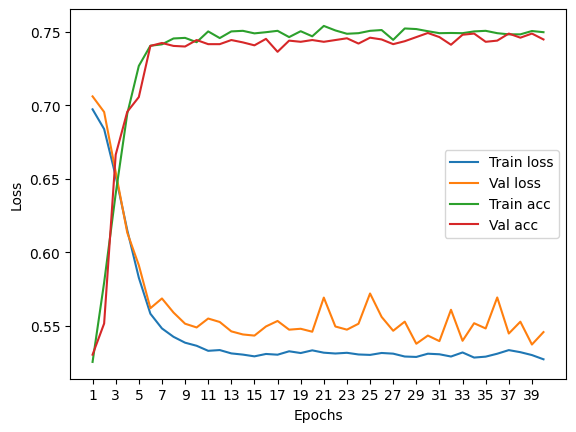

****************************************************************************************************



118it [00:00, 153.02it/s]


Train Epoch: 0 	Loss: 0.697310, Accuracy: 3906/7500 (52%)
Val Epoch: 0 	Loss: 0.706378, Accuracy: 1357/2500 (54%)



118it [00:00, 151.15it/s]


Train Epoch: 1 	Loss: 0.685509, Accuracy: 4322/7500 (58%)
Val Epoch: 1 	Loss: 0.690267, Accuracy: 1459/2500 (58%)



118it [00:00, 162.15it/s]


Train Epoch: 2 	Loss: 0.662798, Accuracy: 4589/7500 (61%)
Val Epoch: 2 	Loss: 0.667810, Accuracy: 1607/2500 (64%)



118it [00:00, 178.28it/s]


Train Epoch: 3 	Loss: 0.632902, Accuracy: 4964/7500 (66%)
Val Epoch: 3 	Loss: 0.633560, Accuracy: 1702/2500 (68%)



118it [00:00, 192.96it/s]


Train Epoch: 4 	Loss: 0.595193, Accuracy: 5290/7500 (71%)
Val Epoch: 4 	Loss: 0.597757, Accuracy: 1784/2500 (71%)



118it [00:00, 157.33it/s]


Train Epoch: 5 	Loss: 0.569960, Accuracy: 5405/7500 (72%)
Val Epoch: 5 	Loss: 0.586105, Accuracy: 1801/2500 (72%)



118it [00:00, 184.10it/s]


Train Epoch: 6 	Loss: 0.555248, Accuracy: 5491/7500 (73%)
Val Epoch: 6 	Loss: 0.586866, Accuracy: 1759/2500 (70%)



118it [00:00, 176.68it/s]


Train Epoch: 7 	Loss: 0.549489, Accuracy: 5459/7500 (73%)
Val Epoch: 7 	Loss: 0.574347, Accuracy: 1814/2500 (73%)



118it [00:00, 176.82it/s]


Train Epoch: 8 	Loss: 0.543002, Accuracy: 5542/7500 (74%)
Val Epoch: 8 	Loss: 0.564241, Accuracy: 1816/2500 (73%)



118it [00:00, 194.70it/s]


Train Epoch: 9 	Loss: 0.543364, Accuracy: 5521/7500 (74%)
Val Epoch: 9 	Loss: 0.561522, Accuracy: 1812/2500 (72%)



118it [00:00, 195.39it/s]


Train Epoch: 10 	Loss: 0.540558, Accuracy: 5544/7500 (74%)
Val Epoch: 10 	Loss: 0.563293, Accuracy: 1823/2500 (73%)



118it [00:00, 172.74it/s]


Train Epoch: 11 	Loss: 0.541484, Accuracy: 5528/7500 (74%)
Val Epoch: 11 	Loss: 0.577075, Accuracy: 1818/2500 (73%)



118it [00:00, 196.28it/s]


Train Epoch: 12 	Loss: 0.539011, Accuracy: 5554/7500 (74%)
Val Epoch: 12 	Loss: 0.565255, Accuracy: 1825/2500 (73%)



118it [00:00, 202.02it/s]


Train Epoch: 13 	Loss: 0.538028, Accuracy: 5525/7500 (74%)
Val Epoch: 13 	Loss: 0.560688, Accuracy: 1829/2500 (73%)



118it [00:00, 201.00it/s]


Train Epoch: 14 	Loss: 0.537662, Accuracy: 5519/7500 (74%)
Val Epoch: 14 	Loss: 0.561609, Accuracy: 1823/2500 (73%)



118it [00:00, 206.63it/s]


Train Epoch: 15 	Loss: 0.539831, Accuracy: 5516/7500 (74%)
Val Epoch: 15 	Loss: 0.573455, Accuracy: 1817/2500 (73%)



118it [00:00, 189.86it/s]


Train Epoch: 16 	Loss: 0.540887, Accuracy: 5525/7500 (74%)
Val Epoch: 16 	Loss: 0.573506, Accuracy: 1816/2500 (73%)



118it [00:00, 203.08it/s]


Train Epoch: 17 	Loss: 0.539895, Accuracy: 5538/7500 (74%)
Val Epoch: 17 	Loss: 0.580420, Accuracy: 1818/2500 (73%)



118it [00:00, 201.50it/s]


Train Epoch: 18 	Loss: 0.539606, Accuracy: 5523/7500 (74%)
Val Epoch: 18 	Loss: 0.565460, Accuracy: 1820/2500 (73%)



118it [00:00, 152.92it/s]


Train Epoch: 19 	Loss: 0.536891, Accuracy: 5563/7500 (74%)
Val Epoch: 19 	Loss: 0.573918, Accuracy: 1823/2500 (73%)



118it [00:00, 153.21it/s]


Train Epoch: 20 	Loss: 0.538271, Accuracy: 5530/7500 (74%)
Val Epoch: 20 	Loss: 0.569623, Accuracy: 1818/2500 (73%)



118it [00:00, 145.28it/s]


Train Epoch: 21 	Loss: 0.538211, Accuracy: 5552/7500 (74%)
Val Epoch: 21 	Loss: 0.573825, Accuracy: 1825/2500 (73%)



118it [00:00, 180.55it/s]


Train Epoch: 22 	Loss: 0.538897, Accuracy: 5545/7500 (74%)
Val Epoch: 22 	Loss: 0.570074, Accuracy: 1819/2500 (73%)



118it [00:00, 197.03it/s]


Train Epoch: 23 	Loss: 0.535266, Accuracy: 5545/7500 (74%)
Val Epoch: 23 	Loss: 0.570083, Accuracy: 1813/2500 (73%)



118it [00:00, 190.35it/s]


Train Epoch: 24 	Loss: 0.535821, Accuracy: 5533/7500 (74%)
Val Epoch: 24 	Loss: 0.568215, Accuracy: 1817/2500 (73%)



118it [00:00, 178.57it/s]


Train Epoch: 25 	Loss: 0.538983, Accuracy: 5547/7500 (74%)
Val Epoch: 25 	Loss: 0.574411, Accuracy: 1817/2500 (73%)



118it [00:00, 192.79it/s]


Train Epoch: 26 	Loss: 0.538108, Accuracy: 5539/7500 (74%)
Val Epoch: 26 	Loss: 0.580504, Accuracy: 1815/2500 (73%)



118it [00:00, 202.42it/s]


Train Epoch: 27 	Loss: 0.537148, Accuracy: 5556/7500 (74%)
Val Epoch: 27 	Loss: 0.587514, Accuracy: 1820/2500 (73%)



118it [00:00, 196.00it/s]


Train Epoch: 28 	Loss: 0.536556, Accuracy: 5551/7500 (74%)
Val Epoch: 28 	Loss: 0.587103, Accuracy: 1819/2500 (73%)



118it [00:00, 200.84it/s]


Train Epoch: 29 	Loss: 0.536567, Accuracy: 5528/7500 (74%)
Val Epoch: 29 	Loss: 0.565730, Accuracy: 1819/2500 (73%)



118it [00:00, 201.35it/s]


Train Epoch: 30 	Loss: 0.537791, Accuracy: 5562/7500 (74%)
Val Epoch: 30 	Loss: 0.568449, Accuracy: 1815/2500 (73%)



118it [00:00, 200.64it/s]


Train Epoch: 31 	Loss: 0.538126, Accuracy: 5547/7500 (74%)
Val Epoch: 31 	Loss: 0.566998, Accuracy: 1820/2500 (73%)



118it [00:00, 161.68it/s]


Train Epoch: 32 	Loss: 0.535726, Accuracy: 5543/7500 (74%)
Val Epoch: 32 	Loss: 0.563636, Accuracy: 1826/2500 (73%)



118it [00:00, 175.17it/s]


Train Epoch: 33 	Loss: 0.534994, Accuracy: 5558/7500 (74%)
Val Epoch: 33 	Loss: 0.572100, Accuracy: 1821/2500 (73%)



118it [00:00, 171.07it/s]


Train Epoch: 34 	Loss: 0.536603, Accuracy: 5559/7500 (74%)
Val Epoch: 34 	Loss: 0.572278, Accuracy: 1818/2500 (73%)



118it [00:00, 193.51it/s]


Train Epoch: 35 	Loss: 0.536505, Accuracy: 5547/7500 (74%)
Val Epoch: 35 	Loss: 0.572925, Accuracy: 1822/2500 (73%)



118it [00:00, 203.08it/s]


Train Epoch: 36 	Loss: 0.537516, Accuracy: 5564/7500 (74%)
Val Epoch: 36 	Loss: 0.569596, Accuracy: 1819/2500 (73%)



118it [00:00, 204.73it/s]


Train Epoch: 37 	Loss: 0.535194, Accuracy: 5564/7500 (74%)
Val Epoch: 37 	Loss: 0.584386, Accuracy: 1814/2500 (73%)



118it [00:00, 176.42it/s]


Train Epoch: 38 	Loss: 0.537438, Accuracy: 5555/7500 (74%)
Val Epoch: 38 	Loss: 0.570655, Accuracy: 1826/2500 (73%)



118it [00:00, 148.50it/s]


Train Epoch: 39 	Loss: 0.534910, Accuracy: 5546/7500 (74%)
Val Epoch: 39 	Loss: 0.562457, Accuracy: 1831/2500 (73%)

Test accuracy:  73.96000000000001


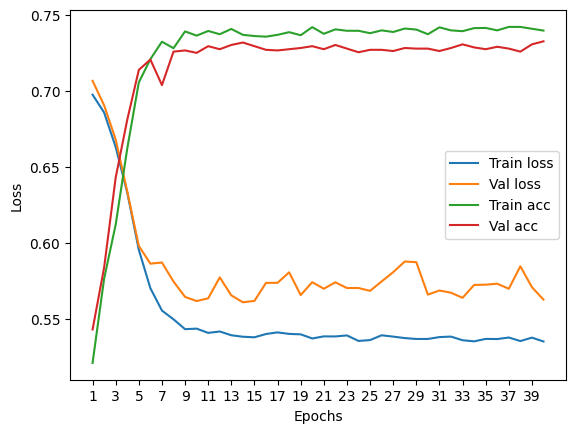

****************************************************************************************************



118it [00:00, 202.04it/s]


Train Epoch: 0 	Loss: 0.697459, Accuracy: 3897/7500 (52%)
Val Epoch: 0 	Loss: 0.706701, Accuracy: 1420/2500 (57%)



118it [00:00, 202.34it/s]


Train Epoch: 1 	Loss: 0.691270, Accuracy: 4091/7500 (55%)
Val Epoch: 1 	Loss: 0.693698, Accuracy: 1470/2500 (59%)



118it [00:00, 197.52it/s]


Train Epoch: 2 	Loss: 0.672527, Accuracy: 4553/7500 (61%)
Val Epoch: 2 	Loss: 0.664896, Accuracy: 1650/2500 (66%)



118it [00:00, 187.65it/s]


Train Epoch: 3 	Loss: 0.640264, Accuracy: 4991/7500 (67%)
Val Epoch: 3 	Loss: 0.624555, Accuracy: 1732/2500 (69%)



118it [00:00, 191.44it/s]


Train Epoch: 4 	Loss: 0.603360, Accuracy: 5241/7500 (70%)
Val Epoch: 4 	Loss: 0.588110, Accuracy: 1842/2500 (74%)



118it [00:00, 153.60it/s]


Train Epoch: 5 	Loss: 0.576611, Accuracy: 5430/7500 (72%)
Val Epoch: 5 	Loss: 0.572799, Accuracy: 1870/2500 (75%)



118it [00:00, 158.40it/s]


Train Epoch: 6 	Loss: 0.559089, Accuracy: 5468/7500 (73%)
Val Epoch: 6 	Loss: 0.550779, Accuracy: 1867/2500 (75%)



118it [00:00, 160.30it/s]


Train Epoch: 7 	Loss: 0.553925, Accuracy: 5505/7500 (73%)
Val Epoch: 7 	Loss: 0.553344, Accuracy: 1863/2500 (75%)



118it [00:00, 194.47it/s]


Train Epoch: 8 	Loss: 0.553417, Accuracy: 5503/7500 (73%)
Val Epoch: 8 	Loss: 0.557105, Accuracy: 1855/2500 (74%)



118it [00:00, 195.78it/s]


Train Epoch: 9 	Loss: 0.552232, Accuracy: 5474/7500 (73%)
Val Epoch: 9 	Loss: 0.543382, Accuracy: 1865/2500 (75%)



118it [00:00, 195.45it/s]


Train Epoch: 10 	Loss: 0.548176, Accuracy: 5471/7500 (73%)
Val Epoch: 10 	Loss: 0.542951, Accuracy: 1867/2500 (75%)



118it [00:00, 195.51it/s]


Train Epoch: 11 	Loss: 0.549930, Accuracy: 5506/7500 (73%)
Val Epoch: 11 	Loss: 0.585835, Accuracy: 1840/2500 (74%)



118it [00:00, 199.52it/s]


Train Epoch: 12 	Loss: 0.547658, Accuracy: 5493/7500 (73%)
Val Epoch: 12 	Loss: 0.548174, Accuracy: 1870/2500 (75%)



118it [00:00, 193.72it/s]


Train Epoch: 13 	Loss: 0.548508, Accuracy: 5486/7500 (73%)
Val Epoch: 13 	Loss: 0.547089, Accuracy: 1859/2500 (74%)



118it [00:00, 196.11it/s]


Train Epoch: 14 	Loss: 0.548370, Accuracy: 5507/7500 (73%)
Val Epoch: 14 	Loss: 0.549221, Accuracy: 1898/2500 (76%)



118it [00:00, 197.94it/s]


Train Epoch: 15 	Loss: 0.547310, Accuracy: 5494/7500 (73%)
Val Epoch: 15 	Loss: 0.547631, Accuracy: 1863/2500 (75%)



118it [00:00, 192.84it/s]


Train Epoch: 16 	Loss: 0.545108, Accuracy: 5491/7500 (73%)
Val Epoch: 16 	Loss: 0.552196, Accuracy: 1881/2500 (75%)



118it [00:00, 200.95it/s]


Train Epoch: 17 	Loss: 0.549088, Accuracy: 5513/7500 (74%)
Val Epoch: 17 	Loss: 0.556264, Accuracy: 1856/2500 (74%)



118it [00:00, 202.73it/s]


Train Epoch: 18 	Loss: 0.548712, Accuracy: 5507/7500 (73%)
Val Epoch: 18 	Loss: 0.543505, Accuracy: 1866/2500 (75%)



118it [00:00, 203.01it/s]


Train Epoch: 19 	Loss: 0.546814, Accuracy: 5521/7500 (74%)
Val Epoch: 19 	Loss: 0.543266, Accuracy: 1886/2500 (75%)



118it [00:00, 196.22it/s]


Train Epoch: 20 	Loss: 0.547064, Accuracy: 5493/7500 (73%)
Val Epoch: 20 	Loss: 0.544269, Accuracy: 1884/2500 (75%)



118it [00:00, 183.19it/s]


Train Epoch: 21 	Loss: 0.547116, Accuracy: 5497/7500 (73%)
Val Epoch: 21 	Loss: 0.544019, Accuracy: 1870/2500 (75%)



118it [00:00, 167.16it/s]


Train Epoch: 22 	Loss: 0.547317, Accuracy: 5510/7500 (73%)
Val Epoch: 22 	Loss: 0.547944, Accuracy: 1893/2500 (76%)



118it [00:00, 194.44it/s]


Train Epoch: 23 	Loss: 0.547095, Accuracy: 5524/7500 (74%)
Val Epoch: 23 	Loss: 0.554961, Accuracy: 1858/2500 (74%)



118it [00:00, 193.63it/s]


Train Epoch: 24 	Loss: 0.547001, Accuracy: 5509/7500 (73%)
Val Epoch: 24 	Loss: 0.539974, Accuracy: 1880/2500 (75%)



118it [00:00, 153.43it/s]


Train Epoch: 25 	Loss: 0.548006, Accuracy: 5492/7500 (73%)
Val Epoch: 25 	Loss: 0.551355, Accuracy: 1858/2500 (74%)



118it [00:00, 163.73it/s]


Train Epoch: 26 	Loss: 0.546558, Accuracy: 5501/7500 (73%)
Val Epoch: 26 	Loss: 0.555023, Accuracy: 1890/2500 (76%)



118it [00:00, 163.33it/s]


Train Epoch: 27 	Loss: 0.547194, Accuracy: 5517/7500 (74%)
Val Epoch: 27 	Loss: 0.563641, Accuracy: 1845/2500 (74%)



118it [00:00, 187.01it/s]


Train Epoch: 28 	Loss: 0.547297, Accuracy: 5525/7500 (74%)
Val Epoch: 28 	Loss: 0.540105, Accuracy: 1866/2500 (75%)



118it [00:00, 197.37it/s]


Train Epoch: 29 	Loss: 0.546654, Accuracy: 5524/7500 (74%)
Val Epoch: 29 	Loss: 0.547306, Accuracy: 1865/2500 (75%)



118it [00:00, 191.40it/s]


Train Epoch: 30 	Loss: 0.547147, Accuracy: 5524/7500 (74%)
Val Epoch: 30 	Loss: 0.542474, Accuracy: 1868/2500 (75%)



118it [00:00, 203.74it/s]


Train Epoch: 31 	Loss: 0.547238, Accuracy: 5509/7500 (73%)
Val Epoch: 31 	Loss: 0.542593, Accuracy: 1862/2500 (74%)



118it [00:00, 189.19it/s]


Train Epoch: 32 	Loss: 0.544364, Accuracy: 5507/7500 (73%)
Val Epoch: 32 	Loss: 0.548911, Accuracy: 1879/2500 (75%)



118it [00:00, 196.47it/s]


Train Epoch: 33 	Loss: 0.545934, Accuracy: 5533/7500 (74%)
Val Epoch: 33 	Loss: 0.548179, Accuracy: 1886/2500 (75%)



118it [00:00, 166.41it/s]


Train Epoch: 34 	Loss: 0.547676, Accuracy: 5496/7500 (73%)
Val Epoch: 34 	Loss: 0.540094, Accuracy: 1882/2500 (75%)



118it [00:00, 171.24it/s]


Train Epoch: 35 	Loss: 0.546567, Accuracy: 5525/7500 (74%)
Val Epoch: 35 	Loss: 0.552563, Accuracy: 1874/2500 (75%)



118it [00:00, 175.90it/s]


Train Epoch: 36 	Loss: 0.545217, Accuracy: 5517/7500 (74%)
Val Epoch: 36 	Loss: 0.550895, Accuracy: 1866/2500 (75%)



118it [00:00, 167.16it/s]


Train Epoch: 37 	Loss: 0.545494, Accuracy: 5506/7500 (73%)
Val Epoch: 37 	Loss: 0.545507, Accuracy: 1877/2500 (75%)



118it [00:00, 193.81it/s]


Train Epoch: 38 	Loss: 0.545250, Accuracy: 5494/7500 (73%)
Val Epoch: 38 	Loss: 0.540206, Accuracy: 1900/2500 (76%)



118it [00:00, 197.50it/s]


Train Epoch: 39 	Loss: 0.545456, Accuracy: 5535/7500 (74%)
Val Epoch: 39 	Loss: 0.542401, Accuracy: 1888/2500 (76%)

Test accuracy:  73.72


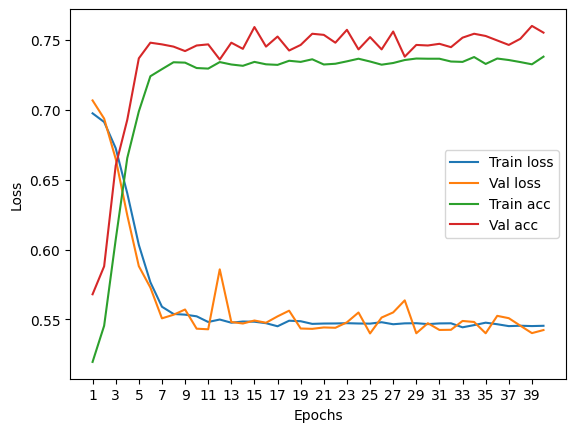

****************************************************************************************************



118it [00:00, 198.80it/s]


Train Epoch: 0 	Loss: 0.695234, Accuracy: 3941/7500 (53%)
Val Epoch: 0 	Loss: 0.708332, Accuracy: 1324/2500 (53%)



118it [00:00, 191.30it/s]


Train Epoch: 1 	Loss: 0.682129, Accuracy: 4295/7500 (57%)
Val Epoch: 1 	Loss: 0.681836, Accuracy: 1546/2500 (62%)



118it [00:00, 204.65it/s]


Train Epoch: 2 	Loss: 0.660832, Accuracy: 4690/7500 (63%)
Val Epoch: 2 	Loss: 0.650650, Accuracy: 1670/2500 (67%)



118it [00:00, 200.57it/s]


Train Epoch: 3 	Loss: 0.626332, Accuracy: 5095/7500 (68%)
Val Epoch: 3 	Loss: 0.622271, Accuracy: 1719/2500 (69%)



118it [00:00, 199.71it/s]


Train Epoch: 4 	Loss: 0.591701, Accuracy: 5375/7500 (72%)
Val Epoch: 4 	Loss: 0.585957, Accuracy: 1803/2500 (72%)



118it [00:00, 199.16it/s]


Train Epoch: 5 	Loss: 0.572160, Accuracy: 5442/7500 (73%)
Val Epoch: 5 	Loss: 0.573371, Accuracy: 1812/2500 (72%)



118it [00:00, 199.08it/s]


Train Epoch: 6 	Loss: 0.559592, Accuracy: 5491/7500 (73%)
Val Epoch: 6 	Loss: 0.560338, Accuracy: 1824/2500 (73%)



118it [00:00, 201.63it/s]


Train Epoch: 7 	Loss: 0.552957, Accuracy: 5525/7500 (74%)
Val Epoch: 7 	Loss: 0.565479, Accuracy: 1815/2500 (73%)



118it [00:00, 198.71it/s]


Train Epoch: 8 	Loss: 0.551768, Accuracy: 5485/7500 (73%)
Val Epoch: 8 	Loss: 0.563309, Accuracy: 1811/2500 (72%)



118it [00:00, 200.88it/s]


Train Epoch: 9 	Loss: 0.547576, Accuracy: 5529/7500 (74%)
Val Epoch: 9 	Loss: 0.566056, Accuracy: 1799/2500 (72%)



118it [00:00, 203.20it/s]


Train Epoch: 10 	Loss: 0.548116, Accuracy: 5522/7500 (74%)
Val Epoch: 10 	Loss: 0.564781, Accuracy: 1816/2500 (73%)



118it [00:00, 201.52it/s]


Train Epoch: 11 	Loss: 0.548897, Accuracy: 5510/7500 (73%)
Val Epoch: 11 	Loss: 0.561034, Accuracy: 1809/2500 (72%)



118it [00:00, 151.83it/s]


Train Epoch: 12 	Loss: 0.547512, Accuracy: 5535/7500 (74%)
Val Epoch: 12 	Loss: 0.566124, Accuracy: 1807/2500 (72%)



118it [00:00, 161.76it/s]


Train Epoch: 13 	Loss: 0.545844, Accuracy: 5547/7500 (74%)
Val Epoch: 13 	Loss: 0.559444, Accuracy: 1802/2500 (72%)



118it [00:00, 156.93it/s]


Train Epoch: 14 	Loss: 0.545417, Accuracy: 5540/7500 (74%)
Val Epoch: 14 	Loss: 0.559874, Accuracy: 1794/2500 (72%)



118it [00:00, 180.86it/s]


Train Epoch: 15 	Loss: 0.546364, Accuracy: 5541/7500 (74%)
Val Epoch: 15 	Loss: 0.562197, Accuracy: 1804/2500 (72%)



118it [00:00, 198.87it/s]


Train Epoch: 16 	Loss: 0.545876, Accuracy: 5557/7500 (74%)
Val Epoch: 16 	Loss: 0.566294, Accuracy: 1794/2500 (72%)



118it [00:00, 198.03it/s]


Train Epoch: 17 	Loss: 0.544457, Accuracy: 5541/7500 (74%)
Val Epoch: 17 	Loss: 0.564906, Accuracy: 1802/2500 (72%)



118it [00:00, 192.97it/s]


Train Epoch: 18 	Loss: 0.547065, Accuracy: 5542/7500 (74%)
Val Epoch: 18 	Loss: 0.559447, Accuracy: 1822/2500 (73%)



118it [00:00, 190.12it/s]


Train Epoch: 19 	Loss: 0.545580, Accuracy: 5541/7500 (74%)
Val Epoch: 19 	Loss: 0.556729, Accuracy: 1809/2500 (72%)



118it [00:00, 197.52it/s]


Train Epoch: 20 	Loss: 0.544669, Accuracy: 5558/7500 (74%)
Val Epoch: 20 	Loss: 0.559824, Accuracy: 1816/2500 (73%)



118it [00:00, 197.35it/s]


Train Epoch: 21 	Loss: 0.546455, Accuracy: 5534/7500 (74%)
Val Epoch: 21 	Loss: 0.556003, Accuracy: 1813/2500 (73%)



118it [00:00, 199.96it/s]


Train Epoch: 22 	Loss: 0.546690, Accuracy: 5541/7500 (74%)
Val Epoch: 22 	Loss: 0.568965, Accuracy: 1799/2500 (72%)



118it [00:00, 195.41it/s]


Train Epoch: 23 	Loss: 0.551859, Accuracy: 5505/7500 (73%)
Val Epoch: 23 	Loss: 0.561694, Accuracy: 1826/2500 (73%)



118it [00:00, 184.72it/s]


Train Epoch: 24 	Loss: 0.546147, Accuracy: 5538/7500 (74%)
Val Epoch: 24 	Loss: 0.576794, Accuracy: 1808/2500 (72%)



118it [00:00, 182.05it/s]


Train Epoch: 25 	Loss: 0.545665, Accuracy: 5538/7500 (74%)
Val Epoch: 25 	Loss: 0.560200, Accuracy: 1806/2500 (72%)



118it [00:00, 133.31it/s]


Train Epoch: 26 	Loss: 0.546524, Accuracy: 5531/7500 (74%)
Val Epoch: 26 	Loss: 0.565696, Accuracy: 1802/2500 (72%)



118it [00:01, 98.15it/s]


Train Epoch: 27 	Loss: 0.545195, Accuracy: 5534/7500 (74%)
Val Epoch: 27 	Loss: 0.557284, Accuracy: 1817/2500 (73%)



118it [00:00, 149.43it/s]


Train Epoch: 28 	Loss: 0.544556, Accuracy: 5538/7500 (74%)
Val Epoch: 28 	Loss: 0.559096, Accuracy: 1807/2500 (72%)



118it [00:00, 178.10it/s]


Train Epoch: 29 	Loss: 0.546253, Accuracy: 5547/7500 (74%)
Val Epoch: 29 	Loss: 0.558966, Accuracy: 1822/2500 (73%)



118it [00:00, 154.73it/s]


Train Epoch: 30 	Loss: 0.546814, Accuracy: 5528/7500 (74%)
Val Epoch: 30 	Loss: 0.556785, Accuracy: 1810/2500 (72%)



118it [00:00, 172.04it/s]


Train Epoch: 31 	Loss: 0.545027, Accuracy: 5538/7500 (74%)
Val Epoch: 31 	Loss: 0.562082, Accuracy: 1795/2500 (72%)



118it [00:00, 165.51it/s]


Train Epoch: 32 	Loss: 0.546787, Accuracy: 5544/7500 (74%)
Val Epoch: 32 	Loss: 0.558862, Accuracy: 1805/2500 (72%)



118it [00:00, 182.36it/s]


Train Epoch: 33 	Loss: 0.546792, Accuracy: 5533/7500 (74%)
Val Epoch: 33 	Loss: 0.577941, Accuracy: 1797/2500 (72%)



118it [00:00, 195.18it/s]


Train Epoch: 34 	Loss: 0.544438, Accuracy: 5525/7500 (74%)
Val Epoch: 34 	Loss: 0.563497, Accuracy: 1819/2500 (73%)



118it [00:00, 186.24it/s]


Train Epoch: 35 	Loss: 0.544076, Accuracy: 5543/7500 (74%)
Val Epoch: 35 	Loss: 0.557339, Accuracy: 1821/2500 (73%)



118it [00:00, 196.65it/s]


Train Epoch: 36 	Loss: 0.545246, Accuracy: 5551/7500 (74%)
Val Epoch: 36 	Loss: 0.564402, Accuracy: 1816/2500 (73%)



118it [00:00, 192.25it/s]


Train Epoch: 37 	Loss: 0.545491, Accuracy: 5529/7500 (74%)
Val Epoch: 37 	Loss: 0.559417, Accuracy: 1816/2500 (73%)



118it [00:00, 199.28it/s]


Train Epoch: 38 	Loss: 0.543995, Accuracy: 5538/7500 (74%)
Val Epoch: 38 	Loss: 0.567839, Accuracy: 1796/2500 (72%)



118it [00:00, 188.31it/s]


Train Epoch: 39 	Loss: 0.545056, Accuracy: 5526/7500 (74%)
Val Epoch: 39 	Loss: 0.563509, Accuracy: 1820/2500 (73%)

Test accuracy:  73.72


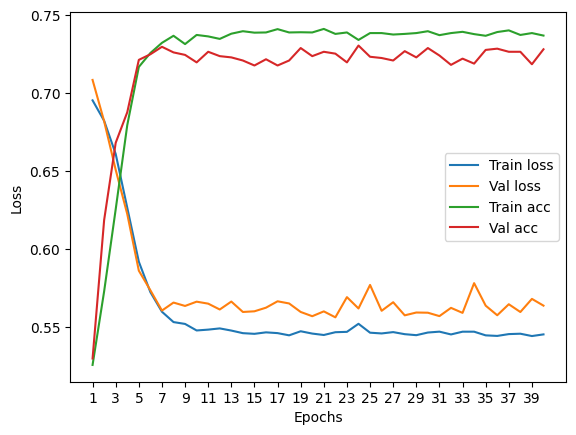

****************************************************************************************************



118it [00:00, 181.96it/s]


Train Epoch: 0 	Loss: 0.695358, Accuracy: 3953/7500 (53%)
Val Epoch: 0 	Loss: 0.706989, Accuracy: 1307/2500 (52%)



118it [00:00, 169.47it/s]


Train Epoch: 1 	Loss: 0.685471, Accuracy: 4323/7500 (58%)
Val Epoch: 1 	Loss: 0.692126, Accuracy: 1469/2500 (59%)



118it [00:00, 179.68it/s]


Train Epoch: 2 	Loss: 0.654494, Accuracy: 4854/7500 (65%)
Val Epoch: 2 	Loss: 0.646233, Accuracy: 1723/2500 (69%)



118it [00:00, 196.87it/s]


Train Epoch: 3 	Loss: 0.611909, Accuracy: 5209/7500 (69%)
Val Epoch: 3 	Loss: 0.599239, Accuracy: 1788/2500 (72%)



118it [00:00, 196.14it/s]


Train Epoch: 4 	Loss: 0.580930, Accuracy: 5447/7500 (73%)
Val Epoch: 4 	Loss: 0.599115, Accuracy: 1761/2500 (70%)



118it [00:00, 189.95it/s]


Train Epoch: 5 	Loss: 0.564593, Accuracy: 5483/7500 (73%)
Val Epoch: 5 	Loss: 0.565740, Accuracy: 1805/2500 (72%)



118it [00:00, 196.55it/s]


Train Epoch: 6 	Loss: 0.554965, Accuracy: 5493/7500 (73%)
Val Epoch: 6 	Loss: 0.569667, Accuracy: 1805/2500 (72%)



118it [00:00, 196.69it/s]


Train Epoch: 7 	Loss: 0.554809, Accuracy: 5509/7500 (73%)
Val Epoch: 7 	Loss: 0.566849, Accuracy: 1838/2500 (74%)



118it [00:00, 196.94it/s]


Train Epoch: 8 	Loss: 0.552703, Accuracy: 5497/7500 (73%)
Val Epoch: 8 	Loss: 0.553440, Accuracy: 1840/2500 (74%)



118it [00:00, 200.30it/s]


Train Epoch: 9 	Loss: 0.548075, Accuracy: 5537/7500 (74%)
Val Epoch: 9 	Loss: 0.558943, Accuracy: 1846/2500 (74%)



118it [00:00, 196.29it/s]


Train Epoch: 10 	Loss: 0.549886, Accuracy: 5513/7500 (74%)
Val Epoch: 10 	Loss: 0.569870, Accuracy: 1839/2500 (74%)



118it [00:00, 178.58it/s]


Train Epoch: 11 	Loss: 0.550625, Accuracy: 5501/7500 (73%)
Val Epoch: 11 	Loss: 0.568961, Accuracy: 1828/2500 (73%)



118it [00:00, 168.39it/s]


Train Epoch: 12 	Loss: 0.549129, Accuracy: 5529/7500 (74%)
Val Epoch: 12 	Loss: 0.551819, Accuracy: 1851/2500 (74%)



118it [00:00, 180.45it/s]


Train Epoch: 13 	Loss: 0.548802, Accuracy: 5487/7500 (73%)
Val Epoch: 13 	Loss: 0.573627, Accuracy: 1801/2500 (72%)



118it [00:00, 193.02it/s]


Train Epoch: 14 	Loss: 0.548265, Accuracy: 5513/7500 (74%)
Val Epoch: 14 	Loss: 0.554609, Accuracy: 1850/2500 (74%)



118it [00:00, 194.81it/s]


Train Epoch: 15 	Loss: 0.549745, Accuracy: 5547/7500 (74%)
Val Epoch: 15 	Loss: 0.549453, Accuracy: 1844/2500 (74%)



118it [00:00, 156.08it/s]


Train Epoch: 16 	Loss: 0.548297, Accuracy: 5520/7500 (74%)
Val Epoch: 16 	Loss: 0.568351, Accuracy: 1836/2500 (73%)



118it [00:00, 158.71it/s]


Train Epoch: 17 	Loss: 0.549291, Accuracy: 5506/7500 (73%)
Val Epoch: 17 	Loss: 0.566527, Accuracy: 1821/2500 (73%)



118it [00:00, 132.61it/s]


Train Epoch: 18 	Loss: 0.548386, Accuracy: 5534/7500 (74%)
Val Epoch: 18 	Loss: 0.567759, Accuracy: 1849/2500 (74%)



118it [00:00, 177.23it/s]


Train Epoch: 19 	Loss: 0.548601, Accuracy: 5537/7500 (74%)
Val Epoch: 19 	Loss: 0.564306, Accuracy: 1843/2500 (74%)



118it [00:00, 198.22it/s]


Train Epoch: 20 	Loss: 0.547028, Accuracy: 5521/7500 (74%)
Val Epoch: 20 	Loss: 0.551635, Accuracy: 1836/2500 (73%)



118it [00:00, 182.57it/s]


Train Epoch: 21 	Loss: 0.547859, Accuracy: 5535/7500 (74%)
Val Epoch: 21 	Loss: 0.550122, Accuracy: 1849/2500 (74%)



118it [00:00, 184.16it/s]


Train Epoch: 22 	Loss: 0.547735, Accuracy: 5537/7500 (74%)
Val Epoch: 22 	Loss: 0.558307, Accuracy: 1849/2500 (74%)



118it [00:00, 192.40it/s]


Train Epoch: 23 	Loss: 0.547476, Accuracy: 5538/7500 (74%)
Val Epoch: 23 	Loss: 0.560259, Accuracy: 1835/2500 (73%)



118it [00:00, 162.95it/s]


Train Epoch: 24 	Loss: 0.547609, Accuracy: 5526/7500 (74%)
Val Epoch: 24 	Loss: 0.559942, Accuracy: 1838/2500 (74%)



118it [00:00, 188.21it/s]


Train Epoch: 25 	Loss: 0.546810, Accuracy: 5530/7500 (74%)
Val Epoch: 25 	Loss: 0.559229, Accuracy: 1854/2500 (74%)



118it [00:00, 195.91it/s]


Train Epoch: 26 	Loss: 0.547431, Accuracy: 5534/7500 (74%)
Val Epoch: 26 	Loss: 0.552920, Accuracy: 1855/2500 (74%)



118it [00:00, 196.96it/s]


Train Epoch: 27 	Loss: 0.546337, Accuracy: 5523/7500 (74%)
Val Epoch: 27 	Loss: 0.554224, Accuracy: 1846/2500 (74%)



118it [00:00, 199.59it/s]


Train Epoch: 28 	Loss: 0.545797, Accuracy: 5541/7500 (74%)
Val Epoch: 28 	Loss: 0.552842, Accuracy: 1857/2500 (74%)



118it [00:00, 191.02it/s]


Train Epoch: 29 	Loss: 0.547054, Accuracy: 5536/7500 (74%)
Val Epoch: 29 	Loss: 0.564938, Accuracy: 1843/2500 (74%)



118it [00:00, 202.86it/s]


Train Epoch: 30 	Loss: 0.546356, Accuracy: 5550/7500 (74%)
Val Epoch: 30 	Loss: 0.578902, Accuracy: 1808/2500 (72%)



118it [00:00, 183.59it/s]


Train Epoch: 31 	Loss: 0.549858, Accuracy: 5520/7500 (74%)
Val Epoch: 31 	Loss: 0.556726, Accuracy: 1833/2500 (73%)



118it [00:00, 200.99it/s]


Train Epoch: 32 	Loss: 0.547189, Accuracy: 5528/7500 (74%)
Val Epoch: 32 	Loss: 0.558207, Accuracy: 1830/2500 (73%)



118it [00:00, 198.95it/s]


Train Epoch: 33 	Loss: 0.551563, Accuracy: 5499/7500 (73%)
Val Epoch: 33 	Loss: 0.563203, Accuracy: 1828/2500 (73%)



118it [00:00, 195.64it/s]


Train Epoch: 34 	Loss: 0.546908, Accuracy: 5511/7500 (73%)
Val Epoch: 34 	Loss: 0.560401, Accuracy: 1843/2500 (74%)



118it [00:00, 162.86it/s]


Train Epoch: 35 	Loss: 0.546383, Accuracy: 5529/7500 (74%)
Val Epoch: 35 	Loss: 0.556967, Accuracy: 1845/2500 (74%)



118it [00:00, 143.57it/s]


Train Epoch: 36 	Loss: 0.547877, Accuracy: 5529/7500 (74%)
Val Epoch: 36 	Loss: 0.552679, Accuracy: 1840/2500 (74%)



118it [00:00, 132.13it/s]


Train Epoch: 37 	Loss: 0.549860, Accuracy: 5480/7500 (73%)
Val Epoch: 37 	Loss: 0.558733, Accuracy: 1828/2500 (73%)



118it [00:00, 123.31it/s]


Train Epoch: 38 	Loss: 0.548505, Accuracy: 5537/7500 (74%)
Val Epoch: 38 	Loss: 0.552870, Accuracy: 1830/2500 (73%)



118it [00:00, 180.38it/s]


Train Epoch: 39 	Loss: 0.548732, Accuracy: 5534/7500 (74%)
Val Epoch: 39 	Loss: 0.559373, Accuracy: 1848/2500 (74%)

Test accuracy:  73.6


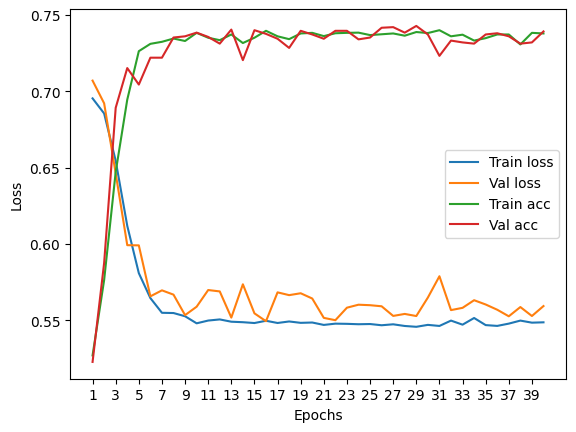

****************************************************************************************************



116it [00:00, 199.34it/s]


Train Epoch: 0 	Loss: 0.689762, Accuracy: 3993/7422 (54%)
Val Epoch: 0 	Loss: 0.688182, Accuracy: 1436/2474 (58%)



116it [00:00, 160.06it/s]


Train Epoch: 1 	Loss: 0.675754, Accuracy: 4325/7422 (58%)
Val Epoch: 1 	Loss: 0.665960, Accuracy: 1555/2474 (63%)



116it [00:00, 151.70it/s]


Train Epoch: 2 	Loss: 0.651338, Accuracy: 4683/7422 (63%)
Val Epoch: 2 	Loss: 0.638287, Accuracy: 1690/2474 (68%)



116it [00:00, 136.45it/s]


Train Epoch: 3 	Loss: 0.616294, Accuracy: 5071/7422 (68%)
Val Epoch: 3 	Loss: 0.599464, Accuracy: 1735/2474 (70%)



116it [00:00, 188.67it/s]


Train Epoch: 4 	Loss: 0.586592, Accuracy: 5320/7422 (72%)
Val Epoch: 4 	Loss: 0.568429, Accuracy: 1813/2474 (73%)



116it [00:00, 179.82it/s]


Train Epoch: 5 	Loss: 0.567062, Accuracy: 5375/7422 (72%)
Val Epoch: 5 	Loss: 0.554066, Accuracy: 1841/2474 (74%)



116it [00:00, 166.26it/s]


Train Epoch: 6 	Loss: 0.557453, Accuracy: 5397/7422 (73%)
Val Epoch: 6 	Loss: 0.549316, Accuracy: 1843/2474 (74%)



116it [00:00, 171.79it/s]


Train Epoch: 7 	Loss: 0.555000, Accuracy: 5410/7422 (73%)
Val Epoch: 7 	Loss: 0.544959, Accuracy: 1828/2474 (74%)



116it [00:00, 185.77it/s]


Train Epoch: 8 	Loss: 0.550595, Accuracy: 5454/7422 (73%)
Val Epoch: 8 	Loss: 0.542752, Accuracy: 1831/2474 (74%)



116it [00:00, 193.95it/s]


Train Epoch: 9 	Loss: 0.550571, Accuracy: 5454/7422 (73%)
Val Epoch: 9 	Loss: 0.541230, Accuracy: 1848/2474 (75%)



116it [00:00, 195.03it/s]


Train Epoch: 10 	Loss: 0.550808, Accuracy: 5428/7422 (73%)
Val Epoch: 10 	Loss: 0.537837, Accuracy: 1846/2474 (75%)



116it [00:00, 197.90it/s]


Train Epoch: 11 	Loss: 0.547849, Accuracy: 5476/7422 (74%)
Val Epoch: 11 	Loss: 0.544940, Accuracy: 1808/2474 (73%)



116it [00:00, 194.77it/s]


Train Epoch: 12 	Loss: 0.550282, Accuracy: 5442/7422 (73%)
Val Epoch: 12 	Loss: 0.537865, Accuracy: 1853/2474 (75%)



116it [00:00, 200.76it/s]


Train Epoch: 13 	Loss: 0.548726, Accuracy: 5459/7422 (74%)
Val Epoch: 13 	Loss: 0.539160, Accuracy: 1849/2474 (75%)



116it [00:00, 193.66it/s]


Train Epoch: 14 	Loss: 0.548038, Accuracy: 5464/7422 (74%)
Val Epoch: 14 	Loss: 0.538800, Accuracy: 1843/2474 (74%)



116it [00:00, 201.86it/s]


Train Epoch: 15 	Loss: 0.548016, Accuracy: 5446/7422 (73%)
Val Epoch: 15 	Loss: 0.540015, Accuracy: 1853/2474 (75%)



116it [00:00, 194.86it/s]


Train Epoch: 16 	Loss: 0.549833, Accuracy: 5470/7422 (74%)
Val Epoch: 16 	Loss: 0.539744, Accuracy: 1852/2474 (75%)



116it [00:00, 185.58it/s]


Train Epoch: 17 	Loss: 0.548042, Accuracy: 5464/7422 (74%)
Val Epoch: 17 	Loss: 0.546738, Accuracy: 1831/2474 (74%)



116it [00:00, 196.57it/s]


Train Epoch: 18 	Loss: 0.547753, Accuracy: 5457/7422 (74%)
Val Epoch: 18 	Loss: 0.540032, Accuracy: 1835/2474 (74%)



116it [00:00, 190.01it/s]


Train Epoch: 19 	Loss: 0.547412, Accuracy: 5467/7422 (74%)
Val Epoch: 19 	Loss: 0.542464, Accuracy: 1823/2474 (74%)



116it [00:00, 189.06it/s]


Train Epoch: 20 	Loss: 0.547201, Accuracy: 5464/7422 (74%)
Val Epoch: 20 	Loss: 0.537393, Accuracy: 1845/2474 (75%)



116it [00:00, 135.99it/s]


Train Epoch: 21 	Loss: 0.547436, Accuracy: 5460/7422 (74%)
Val Epoch: 21 	Loss: 0.539441, Accuracy: 1847/2474 (75%)



116it [00:00, 163.70it/s]


Train Epoch: 22 	Loss: 0.547239, Accuracy: 5467/7422 (74%)
Val Epoch: 22 	Loss: 0.543160, Accuracy: 1845/2474 (75%)



116it [00:00, 157.77it/s]


Train Epoch: 23 	Loss: 0.548369, Accuracy: 5490/7422 (74%)
Val Epoch: 23 	Loss: 0.541536, Accuracy: 1836/2474 (74%)



116it [00:00, 192.69it/s]


Train Epoch: 24 	Loss: 0.547721, Accuracy: 5465/7422 (74%)
Val Epoch: 24 	Loss: 0.539336, Accuracy: 1844/2474 (75%)



116it [00:00, 198.25it/s]


Train Epoch: 25 	Loss: 0.547162, Accuracy: 5480/7422 (74%)
Val Epoch: 25 	Loss: 0.540124, Accuracy: 1820/2474 (74%)



116it [00:00, 192.77it/s]


Train Epoch: 26 	Loss: 0.549528, Accuracy: 5447/7422 (73%)
Val Epoch: 26 	Loss: 0.536089, Accuracy: 1847/2474 (75%)



116it [00:00, 183.92it/s]


Train Epoch: 27 	Loss: 0.547316, Accuracy: 5466/7422 (74%)
Val Epoch: 27 	Loss: 0.539408, Accuracy: 1844/2474 (75%)



116it [00:00, 190.38it/s]


Train Epoch: 28 	Loss: 0.547699, Accuracy: 5466/7422 (74%)
Val Epoch: 28 	Loss: 0.537609, Accuracy: 1847/2474 (75%)



116it [00:00, 198.53it/s]


Train Epoch: 29 	Loss: 0.548394, Accuracy: 5483/7422 (74%)
Val Epoch: 29 	Loss: 0.543135, Accuracy: 1837/2474 (74%)



116it [00:00, 196.36it/s]


Train Epoch: 30 	Loss: 0.549124, Accuracy: 5452/7422 (73%)
Val Epoch: 30 	Loss: 0.540220, Accuracy: 1838/2474 (74%)



116it [00:00, 192.89it/s]


Train Epoch: 31 	Loss: 0.548299, Accuracy: 5439/7422 (73%)
Val Epoch: 31 	Loss: 0.537718, Accuracy: 1852/2474 (75%)



116it [00:00, 195.10it/s]


Train Epoch: 32 	Loss: 0.548115, Accuracy: 5464/7422 (74%)
Val Epoch: 32 	Loss: 0.537283, Accuracy: 1852/2474 (75%)



116it [00:00, 201.69it/s]


Train Epoch: 33 	Loss: 0.547017, Accuracy: 5467/7422 (74%)
Val Epoch: 33 	Loss: 0.543092, Accuracy: 1848/2474 (75%)



116it [00:00, 198.95it/s]


Train Epoch: 34 	Loss: 0.547475, Accuracy: 5471/7422 (74%)
Val Epoch: 34 	Loss: 0.543291, Accuracy: 1839/2474 (74%)



116it [00:00, 196.52it/s]


Train Epoch: 35 	Loss: 0.547030, Accuracy: 5479/7422 (74%)
Val Epoch: 35 	Loss: 0.547005, Accuracy: 1835/2474 (74%)



116it [00:00, 199.32it/s]


Train Epoch: 36 	Loss: 0.547413, Accuracy: 5471/7422 (74%)
Val Epoch: 36 	Loss: 0.543249, Accuracy: 1835/2474 (74%)



116it [00:00, 197.64it/s]


Train Epoch: 37 	Loss: 0.547184, Accuracy: 5469/7422 (74%)
Val Epoch: 37 	Loss: 0.537049, Accuracy: 1850/2474 (75%)



116it [00:00, 199.37it/s]


Train Epoch: 38 	Loss: 0.546247, Accuracy: 5467/7422 (74%)
Val Epoch: 38 	Loss: 0.537248, Accuracy: 1839/2474 (74%)



116it [00:00, 199.97it/s]


Train Epoch: 39 	Loss: 0.547754, Accuracy: 5472/7422 (74%)
Val Epoch: 39 	Loss: 0.538935, Accuracy: 1844/2474 (75%)

Test accuracy:  74.65642683912692


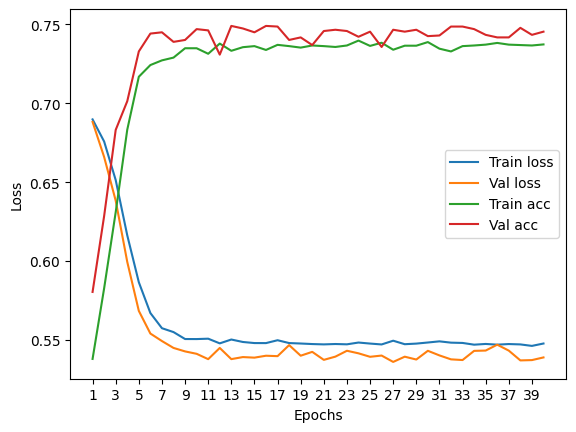

****************************************************************************************************



Particles per jet: 13


118it [00:00, 199.48it/s]


Train Epoch: 0 	Loss: 0.697786, Accuracy: 3866/7500 (52%)
Val Epoch: 0 	Loss: 0.706282, Accuracy: 1428/2500 (57%)



118it [00:00, 192.55it/s]


Train Epoch: 1 	Loss: 0.690930, Accuracy: 4138/7500 (55%)
Val Epoch: 1 	Loss: 0.693246, Accuracy: 1497/2500 (60%)



118it [00:00, 201.17it/s]


Train Epoch: 2 	Loss: 0.674742, Accuracy: 4492/7500 (60%)
Val Epoch: 2 	Loss: 0.673107, Accuracy: 1583/2500 (63%)



118it [00:00, 165.18it/s]


Train Epoch: 3 	Loss: 0.641699, Accuracy: 4876/7500 (65%)
Val Epoch: 3 	Loss: 0.626586, Accuracy: 1713/2500 (69%)



118it [00:00, 174.49it/s]


Train Epoch: 4 	Loss: 0.601711, Accuracy: 5293/7500 (71%)
Val Epoch: 4 	Loss: 0.587352, Accuracy: 1804/2500 (72%)



118it [00:00, 166.55it/s]


Train Epoch: 5 	Loss: 0.573617, Accuracy: 5428/7500 (72%)
Val Epoch: 5 	Loss: 0.576482, Accuracy: 1812/2500 (72%)



118it [00:00, 150.73it/s]


Train Epoch: 6 	Loss: 0.561475, Accuracy: 5494/7500 (73%)
Val Epoch: 6 	Loss: 0.576675, Accuracy: 1814/2500 (73%)



118it [00:00, 133.84it/s]


Train Epoch: 7 	Loss: 0.553353, Accuracy: 5515/7500 (74%)
Val Epoch: 7 	Loss: 0.558287, Accuracy: 1826/2500 (73%)



118it [00:00, 176.05it/s]


Train Epoch: 8 	Loss: 0.547634, Accuracy: 5533/7500 (74%)
Val Epoch: 8 	Loss: 0.566737, Accuracy: 1824/2500 (73%)



118it [00:00, 196.57it/s]


Train Epoch: 9 	Loss: 0.547247, Accuracy: 5533/7500 (74%)
Val Epoch: 9 	Loss: 0.551343, Accuracy: 1833/2500 (73%)



118it [00:00, 197.49it/s]


Train Epoch: 10 	Loss: 0.544956, Accuracy: 5551/7500 (74%)
Val Epoch: 10 	Loss: 0.561713, Accuracy: 1819/2500 (73%)



118it [00:00, 192.22it/s]


Train Epoch: 11 	Loss: 0.540535, Accuracy: 5598/7500 (75%)
Val Epoch: 11 	Loss: 0.557297, Accuracy: 1845/2500 (74%)



118it [00:00, 166.58it/s]


Train Epoch: 12 	Loss: 0.542258, Accuracy: 5574/7500 (74%)
Val Epoch: 12 	Loss: 0.549193, Accuracy: 1842/2500 (74%)



118it [00:00, 185.24it/s]


Train Epoch: 13 	Loss: 0.544677, Accuracy: 5592/7500 (75%)
Val Epoch: 13 	Loss: 0.551819, Accuracy: 1836/2500 (73%)



118it [00:00, 193.61it/s]


Train Epoch: 14 	Loss: 0.540024, Accuracy: 5597/7500 (75%)
Val Epoch: 14 	Loss: 0.552863, Accuracy: 1838/2500 (74%)



118it [00:00, 198.13it/s]


Train Epoch: 15 	Loss: 0.541603, Accuracy: 5568/7500 (74%)
Val Epoch: 15 	Loss: 0.547636, Accuracy: 1848/2500 (74%)



118it [00:00, 192.89it/s]


Train Epoch: 16 	Loss: 0.537904, Accuracy: 5589/7500 (75%)
Val Epoch: 16 	Loss: 0.557012, Accuracy: 1832/2500 (73%)



118it [00:00, 197.67it/s]


Train Epoch: 17 	Loss: 0.539473, Accuracy: 5592/7500 (75%)
Val Epoch: 17 	Loss: 0.555472, Accuracy: 1843/2500 (74%)



118it [00:00, 198.11it/s]


Train Epoch: 18 	Loss: 0.539084, Accuracy: 5601/7500 (75%)
Val Epoch: 18 	Loss: 0.553955, Accuracy: 1845/2500 (74%)



118it [00:00, 200.39it/s]


Train Epoch: 19 	Loss: 0.539304, Accuracy: 5587/7500 (74%)
Val Epoch: 19 	Loss: 0.548181, Accuracy: 1840/2500 (74%)



118it [00:00, 190.10it/s]


Train Epoch: 20 	Loss: 0.541495, Accuracy: 5565/7500 (74%)
Val Epoch: 20 	Loss: 0.554957, Accuracy: 1836/2500 (73%)



118it [00:00, 182.89it/s]


Train Epoch: 21 	Loss: 0.539070, Accuracy: 5586/7500 (74%)
Val Epoch: 21 	Loss: 0.555634, Accuracy: 1847/2500 (74%)



118it [00:00, 181.30it/s]


Train Epoch: 22 	Loss: 0.542132, Accuracy: 5602/7500 (75%)
Val Epoch: 22 	Loss: 0.551901, Accuracy: 1843/2500 (74%)



118it [00:00, 196.16it/s]


Train Epoch: 23 	Loss: 0.540309, Accuracy: 5601/7500 (75%)
Val Epoch: 23 	Loss: 0.558863, Accuracy: 1851/2500 (74%)



118it [00:00, 182.48it/s]


Train Epoch: 24 	Loss: 0.540883, Accuracy: 5582/7500 (74%)
Val Epoch: 24 	Loss: 0.550523, Accuracy: 1846/2500 (74%)



118it [00:00, 147.55it/s]


Train Epoch: 25 	Loss: 0.542139, Accuracy: 5602/7500 (75%)
Val Epoch: 25 	Loss: 0.549546, Accuracy: 1850/2500 (74%)



118it [00:00, 162.13it/s]


Train Epoch: 26 	Loss: 0.537759, Accuracy: 5601/7500 (75%)
Val Epoch: 26 	Loss: 0.568322, Accuracy: 1840/2500 (74%)



118it [00:00, 174.73it/s]


Train Epoch: 27 	Loss: 0.539460, Accuracy: 5577/7500 (74%)
Val Epoch: 27 	Loss: 0.560639, Accuracy: 1828/2500 (73%)



118it [00:00, 186.42it/s]


Train Epoch: 28 	Loss: 0.538942, Accuracy: 5598/7500 (75%)
Val Epoch: 28 	Loss: 0.558264, Accuracy: 1847/2500 (74%)



118it [00:00, 154.80it/s]


Train Epoch: 29 	Loss: 0.541133, Accuracy: 5584/7500 (74%)
Val Epoch: 29 	Loss: 0.544049, Accuracy: 1853/2500 (74%)



118it [00:00, 193.36it/s]


Train Epoch: 30 	Loss: 0.537108, Accuracy: 5581/7500 (74%)
Val Epoch: 30 	Loss: 0.562092, Accuracy: 1837/2500 (73%)



118it [00:00, 186.54it/s]


Train Epoch: 31 	Loss: 0.539454, Accuracy: 5577/7500 (74%)
Val Epoch: 31 	Loss: 0.555688, Accuracy: 1849/2500 (74%)



118it [00:00, 199.89it/s]


Train Epoch: 32 	Loss: 0.538481, Accuracy: 5571/7500 (74%)
Val Epoch: 32 	Loss: 0.560536, Accuracy: 1831/2500 (73%)



118it [00:00, 197.30it/s]


Train Epoch: 33 	Loss: 0.540533, Accuracy: 5569/7500 (74%)
Val Epoch: 33 	Loss: 0.551036, Accuracy: 1854/2500 (74%)



118it [00:00, 174.10it/s]


Train Epoch: 34 	Loss: 0.538147, Accuracy: 5598/7500 (75%)
Val Epoch: 34 	Loss: 0.556159, Accuracy: 1843/2500 (74%)



118it [00:00, 177.90it/s]


Train Epoch: 35 	Loss: 0.538260, Accuracy: 5606/7500 (75%)
Val Epoch: 35 	Loss: 0.555286, Accuracy: 1847/2500 (74%)



118it [00:00, 173.05it/s]


Train Epoch: 36 	Loss: 0.538517, Accuracy: 5600/7500 (75%)
Val Epoch: 36 	Loss: 0.556494, Accuracy: 1852/2500 (74%)



118it [00:00, 158.69it/s]


Train Epoch: 37 	Loss: 0.536737, Accuracy: 5599/7500 (75%)
Val Epoch: 37 	Loss: 0.552466, Accuracy: 1851/2500 (74%)



118it [00:00, 171.76it/s]


Train Epoch: 38 	Loss: 0.537536, Accuracy: 5618/7500 (75%)
Val Epoch: 38 	Loss: 0.558153, Accuracy: 1850/2500 (74%)



118it [00:00, 197.90it/s]


Train Epoch: 39 	Loss: 0.538373, Accuracy: 5583/7500 (74%)
Val Epoch: 39 	Loss: 0.554422, Accuracy: 1845/2500 (74%)

Test accuracy:  74.08


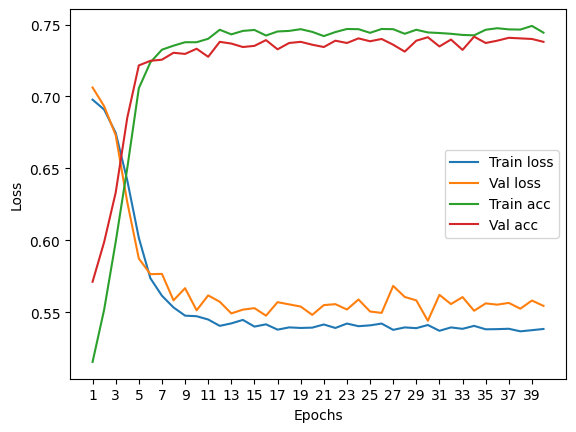

****************************************************************************************************



118it [00:00, 185.47it/s]


Train Epoch: 0 	Loss: 0.696416, Accuracy: 3929/7500 (52%)
Val Epoch: 0 	Loss: 0.706412, Accuracy: 1351/2500 (54%)



118it [00:00, 150.47it/s]


Train Epoch: 1 	Loss: 0.686330, Accuracy: 4237/7500 (56%)
Val Epoch: 1 	Loss: 0.691981, Accuracy: 1478/2500 (59%)



118it [00:00, 194.08it/s]


Train Epoch: 2 	Loss: 0.677010, Accuracy: 4329/7500 (58%)
Val Epoch: 2 	Loss: 0.677570, Accuracy: 1518/2500 (61%)



118it [00:00, 195.94it/s]


Train Epoch: 3 	Loss: 0.667904, Accuracy: 4468/7500 (60%)
Val Epoch: 3 	Loss: 0.674274, Accuracy: 1515/2500 (61%)



118it [00:00, 195.34it/s]


Train Epoch: 4 	Loss: 0.655025, Accuracy: 4657/7500 (62%)
Val Epoch: 4 	Loss: 0.660209, Accuracy: 1600/2500 (64%)



118it [00:00, 200.74it/s]


Train Epoch: 5 	Loss: 0.634255, Accuracy: 4954/7500 (66%)
Val Epoch: 5 	Loss: 0.640139, Accuracy: 1713/2500 (69%)



118it [00:00, 199.08it/s]


Train Epoch: 6 	Loss: 0.601754, Accuracy: 5319/7500 (71%)
Val Epoch: 6 	Loss: 0.606752, Accuracy: 1777/2500 (71%)



118it [00:00, 191.47it/s]


Train Epoch: 7 	Loss: 0.577615, Accuracy: 5458/7500 (73%)
Val Epoch: 7 	Loss: 0.578415, Accuracy: 1812/2500 (72%)



118it [00:00, 148.64it/s]


Train Epoch: 8 	Loss: 0.559360, Accuracy: 5495/7500 (73%)
Val Epoch: 8 	Loss: 0.593375, Accuracy: 1770/2500 (71%)



118it [00:00, 168.30it/s]


Train Epoch: 9 	Loss: 0.552393, Accuracy: 5550/7500 (74%)
Val Epoch: 9 	Loss: 0.574842, Accuracy: 1842/2500 (74%)



118it [00:00, 156.24it/s]


Train Epoch: 10 	Loss: 0.546173, Accuracy: 5579/7500 (74%)
Val Epoch: 10 	Loss: 0.563921, Accuracy: 1836/2500 (73%)



118it [00:00, 142.34it/s]


Train Epoch: 11 	Loss: 0.545087, Accuracy: 5574/7500 (74%)
Val Epoch: 11 	Loss: 0.563846, Accuracy: 1833/2500 (73%)



118it [00:00, 159.73it/s]


Train Epoch: 12 	Loss: 0.541936, Accuracy: 5588/7500 (75%)
Val Epoch: 12 	Loss: 0.564421, Accuracy: 1832/2500 (73%)



118it [00:00, 187.88it/s]


Train Epoch: 13 	Loss: 0.540525, Accuracy: 5573/7500 (74%)
Val Epoch: 13 	Loss: 0.567011, Accuracy: 1819/2500 (73%)



118it [00:00, 196.40it/s]


Train Epoch: 14 	Loss: 0.539989, Accuracy: 5559/7500 (74%)
Val Epoch: 14 	Loss: 0.553899, Accuracy: 1843/2500 (74%)



118it [00:00, 196.64it/s]


Train Epoch: 15 	Loss: 0.540251, Accuracy: 5571/7500 (74%)
Val Epoch: 15 	Loss: 0.583724, Accuracy: 1830/2500 (73%)



118it [00:00, 191.03it/s]


Train Epoch: 16 	Loss: 0.539993, Accuracy: 5544/7500 (74%)
Val Epoch: 16 	Loss: 0.576491, Accuracy: 1813/2500 (73%)



118it [00:00, 196.43it/s]


Train Epoch: 17 	Loss: 0.541751, Accuracy: 5579/7500 (74%)
Val Epoch: 17 	Loss: 0.563326, Accuracy: 1829/2500 (73%)



118it [00:00, 181.87it/s]


Train Epoch: 18 	Loss: 0.539622, Accuracy: 5564/7500 (74%)
Val Epoch: 18 	Loss: 0.567883, Accuracy: 1821/2500 (73%)



118it [00:00, 181.65it/s]


Train Epoch: 19 	Loss: 0.538263, Accuracy: 5592/7500 (75%)
Val Epoch: 19 	Loss: 0.559822, Accuracy: 1850/2500 (74%)



118it [00:00, 198.40it/s]


Train Epoch: 20 	Loss: 0.539789, Accuracy: 5582/7500 (74%)
Val Epoch: 20 	Loss: 0.569254, Accuracy: 1826/2500 (73%)



118it [00:00, 193.02it/s]


Train Epoch: 21 	Loss: 0.539674, Accuracy: 5588/7500 (75%)
Val Epoch: 21 	Loss: 0.564041, Accuracy: 1824/2500 (73%)



118it [00:00, 197.34it/s]


Train Epoch: 22 	Loss: 0.539409, Accuracy: 5603/7500 (75%)
Val Epoch: 22 	Loss: 0.575675, Accuracy: 1829/2500 (73%)



118it [00:00, 182.72it/s]


Train Epoch: 23 	Loss: 0.540357, Accuracy: 5593/7500 (75%)
Val Epoch: 23 	Loss: 0.581059, Accuracy: 1831/2500 (73%)



118it [00:00, 203.26it/s]


Train Epoch: 24 	Loss: 0.541021, Accuracy: 5602/7500 (75%)
Val Epoch: 24 	Loss: 0.555188, Accuracy: 1840/2500 (74%)



118it [00:00, 193.47it/s]


Train Epoch: 25 	Loss: 0.541021, Accuracy: 5593/7500 (75%)
Val Epoch: 25 	Loss: 0.568407, Accuracy: 1829/2500 (73%)



118it [00:00, 187.41it/s]


Train Epoch: 26 	Loss: 0.538383, Accuracy: 5611/7500 (75%)
Val Epoch: 26 	Loss: 0.556970, Accuracy: 1835/2500 (73%)



118it [00:00, 125.24it/s]


Train Epoch: 27 	Loss: 0.537484, Accuracy: 5598/7500 (75%)
Val Epoch: 27 	Loss: 0.555973, Accuracy: 1845/2500 (74%)



118it [00:00, 159.72it/s]


Train Epoch: 28 	Loss: 0.539321, Accuracy: 5581/7500 (74%)
Val Epoch: 28 	Loss: 0.578625, Accuracy: 1832/2500 (73%)



118it [00:00, 175.74it/s]


Train Epoch: 29 	Loss: 0.540302, Accuracy: 5612/7500 (75%)
Val Epoch: 29 	Loss: 0.569376, Accuracy: 1844/2500 (74%)



118it [00:00, 194.49it/s]


Train Epoch: 30 	Loss: 0.538711, Accuracy: 5584/7500 (74%)
Val Epoch: 30 	Loss: 0.559368, Accuracy: 1850/2500 (74%)



118it [00:00, 194.92it/s]


Train Epoch: 31 	Loss: 0.538865, Accuracy: 5589/7500 (75%)
Val Epoch: 31 	Loss: 0.562806, Accuracy: 1823/2500 (73%)



118it [00:00, 198.96it/s]


Train Epoch: 32 	Loss: 0.538693, Accuracy: 5615/7500 (75%)
Val Epoch: 32 	Loss: 0.563162, Accuracy: 1838/2500 (74%)



118it [00:00, 195.01it/s]


Train Epoch: 33 	Loss: 0.538271, Accuracy: 5595/7500 (75%)
Val Epoch: 33 	Loss: 0.553195, Accuracy: 1851/2500 (74%)



118it [00:00, 196.76it/s]


Train Epoch: 34 	Loss: 0.537875, Accuracy: 5610/7500 (75%)
Val Epoch: 34 	Loss: 0.575441, Accuracy: 1820/2500 (73%)



118it [00:00, 192.15it/s]


Train Epoch: 35 	Loss: 0.538593, Accuracy: 5603/7500 (75%)
Val Epoch: 35 	Loss: 0.563203, Accuracy: 1837/2500 (73%)



118it [00:00, 192.13it/s]


Train Epoch: 36 	Loss: 0.541561, Accuracy: 5593/7500 (75%)
Val Epoch: 36 	Loss: 0.561848, Accuracy: 1850/2500 (74%)



118it [00:00, 196.64it/s]


Train Epoch: 37 	Loss: 0.539181, Accuracy: 5591/7500 (75%)
Val Epoch: 37 	Loss: 0.561881, Accuracy: 1845/2500 (74%)



118it [00:00, 193.73it/s]


Train Epoch: 38 	Loss: 0.539221, Accuracy: 5597/7500 (75%)
Val Epoch: 38 	Loss: 0.565837, Accuracy: 1841/2500 (74%)



118it [00:00, 198.66it/s]


Train Epoch: 39 	Loss: 0.537744, Accuracy: 5601/7500 (75%)
Val Epoch: 39 	Loss: 0.570670, Accuracy: 1838/2500 (74%)

Test accuracy:  71.88


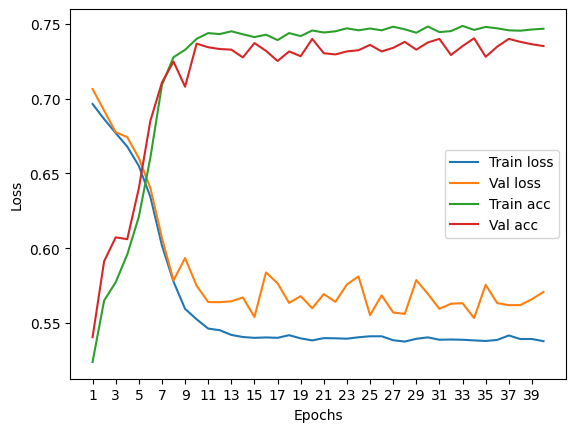

****************************************************************************************************



118it [00:00, 197.33it/s]


Train Epoch: 0 	Loss: 0.696957, Accuracy: 3917/7500 (52%)
Val Epoch: 0 	Loss: 0.703963, Accuracy: 1351/2500 (54%)



118it [00:00, 192.97it/s]


Train Epoch: 1 	Loss: 0.688418, Accuracy: 4246/7500 (57%)
Val Epoch: 1 	Loss: 0.687958, Accuracy: 1477/2500 (59%)



118it [00:00, 201.29it/s]


Train Epoch: 2 	Loss: 0.677238, Accuracy: 4347/7500 (58%)
Val Epoch: 2 	Loss: 0.679620, Accuracy: 1521/2500 (61%)



118it [00:00, 200.54it/s]


Train Epoch: 3 	Loss: 0.668174, Accuracy: 4525/7500 (60%)
Val Epoch: 3 	Loss: 0.663941, Accuracy: 1583/2500 (63%)



118it [00:00, 198.61it/s]


Train Epoch: 4 	Loss: 0.650901, Accuracy: 4831/7500 (64%)
Val Epoch: 4 	Loss: 0.642248, Accuracy: 1682/2500 (67%)



118it [00:00, 192.07it/s]


Train Epoch: 5 	Loss: 0.623689, Accuracy: 5158/7500 (69%)
Val Epoch: 5 	Loss: 0.612321, Accuracy: 1815/2500 (73%)



118it [00:00, 193.94it/s]


Train Epoch: 6 	Loss: 0.595065, Accuracy: 5379/7500 (72%)
Val Epoch: 6 	Loss: 0.577939, Accuracy: 1871/2500 (75%)



118it [00:00, 193.13it/s]


Train Epoch: 7 	Loss: 0.570288, Accuracy: 5508/7500 (73%)
Val Epoch: 7 	Loss: 0.562022, Accuracy: 1857/2500 (74%)



118it [00:00, 196.28it/s]


Train Epoch: 8 	Loss: 0.557144, Accuracy: 5535/7500 (74%)
Val Epoch: 8 	Loss: 0.543138, Accuracy: 1877/2500 (75%)



118it [00:00, 196.91it/s]


Train Epoch: 9 	Loss: 0.547399, Accuracy: 5552/7500 (74%)
Val Epoch: 9 	Loss: 0.543075, Accuracy: 1871/2500 (75%)



118it [00:00, 196.95it/s]


Train Epoch: 10 	Loss: 0.544704, Accuracy: 5565/7500 (74%)
Val Epoch: 10 	Loss: 0.531143, Accuracy: 1889/2500 (76%)



118it [00:00, 190.00it/s]


Train Epoch: 11 	Loss: 0.543688, Accuracy: 5554/7500 (74%)
Val Epoch: 11 	Loss: 0.535298, Accuracy: 1881/2500 (75%)



118it [00:00, 139.34it/s]


Train Epoch: 12 	Loss: 0.542424, Accuracy: 5574/7500 (74%)
Val Epoch: 12 	Loss: 0.530903, Accuracy: 1887/2500 (75%)



118it [00:00, 169.28it/s]


Train Epoch: 13 	Loss: 0.543538, Accuracy: 5543/7500 (74%)
Val Epoch: 13 	Loss: 0.531507, Accuracy: 1889/2500 (76%)



118it [00:00, 167.81it/s]


Train Epoch: 14 	Loss: 0.540907, Accuracy: 5554/7500 (74%)
Val Epoch: 14 	Loss: 0.528873, Accuracy: 1861/2500 (74%)



118it [00:00, 193.88it/s]


Train Epoch: 15 	Loss: 0.540141, Accuracy: 5578/7500 (74%)
Val Epoch: 15 	Loss: 0.523566, Accuracy: 1891/2500 (76%)



118it [00:00, 197.08it/s]


Train Epoch: 16 	Loss: 0.539326, Accuracy: 5565/7500 (74%)
Val Epoch: 16 	Loss: 0.533603, Accuracy: 1888/2500 (76%)



118it [00:00, 180.33it/s]


Train Epoch: 17 	Loss: 0.539885, Accuracy: 5555/7500 (74%)
Val Epoch: 17 	Loss: 0.531941, Accuracy: 1871/2500 (75%)



118it [00:00, 160.88it/s]


Train Epoch: 18 	Loss: 0.540046, Accuracy: 5588/7500 (75%)
Val Epoch: 18 	Loss: 0.526129, Accuracy: 1871/2500 (75%)



118it [00:00, 198.04it/s]


Train Epoch: 19 	Loss: 0.542547, Accuracy: 5558/7500 (74%)
Val Epoch: 19 	Loss: 0.528903, Accuracy: 1867/2500 (75%)



118it [00:00, 189.00it/s]


Train Epoch: 20 	Loss: 0.538564, Accuracy: 5577/7500 (74%)
Val Epoch: 20 	Loss: 0.535937, Accuracy: 1863/2500 (75%)



118it [00:00, 193.70it/s]


Train Epoch: 21 	Loss: 0.539662, Accuracy: 5569/7500 (74%)
Val Epoch: 21 	Loss: 0.531252, Accuracy: 1884/2500 (75%)



118it [00:00, 194.76it/s]


Train Epoch: 22 	Loss: 0.539607, Accuracy: 5558/7500 (74%)
Val Epoch: 22 	Loss: 0.531683, Accuracy: 1852/2500 (74%)



118it [00:00, 195.44it/s]


Train Epoch: 23 	Loss: 0.540534, Accuracy: 5565/7500 (74%)
Val Epoch: 23 	Loss: 0.532482, Accuracy: 1861/2500 (74%)



118it [00:00, 198.24it/s]


Train Epoch: 24 	Loss: 0.541242, Accuracy: 5552/7500 (74%)
Val Epoch: 24 	Loss: 0.532526, Accuracy: 1884/2500 (75%)



118it [00:00, 194.90it/s]


Train Epoch: 25 	Loss: 0.541577, Accuracy: 5548/7500 (74%)
Val Epoch: 25 	Loss: 0.554041, Accuracy: 1850/2500 (74%)



118it [00:00, 195.63it/s]


Train Epoch: 26 	Loss: 0.540342, Accuracy: 5585/7500 (74%)
Val Epoch: 26 	Loss: 0.526113, Accuracy: 1873/2500 (75%)



118it [00:00, 181.54it/s]


Train Epoch: 27 	Loss: 0.539534, Accuracy: 5569/7500 (74%)
Val Epoch: 27 	Loss: 0.525784, Accuracy: 1881/2500 (75%)



118it [00:00, 196.93it/s]


Train Epoch: 28 	Loss: 0.539807, Accuracy: 5582/7500 (74%)
Val Epoch: 28 	Loss: 0.523848, Accuracy: 1868/2500 (75%)



118it [00:00, 202.38it/s]


Train Epoch: 29 	Loss: 0.539168, Accuracy: 5570/7500 (74%)
Val Epoch: 29 	Loss: 0.527719, Accuracy: 1862/2500 (74%)



118it [00:00, 201.23it/s]


Train Epoch: 30 	Loss: 0.539425, Accuracy: 5568/7500 (74%)
Val Epoch: 30 	Loss: 0.539164, Accuracy: 1882/2500 (75%)



118it [00:00, 153.89it/s]


Train Epoch: 31 	Loss: 0.537938, Accuracy: 5574/7500 (74%)
Val Epoch: 31 	Loss: 0.524558, Accuracy: 1861/2500 (74%)



118it [00:00, 149.70it/s]


Train Epoch: 32 	Loss: 0.538182, Accuracy: 5571/7500 (74%)
Val Epoch: 32 	Loss: 0.532518, Accuracy: 1857/2500 (74%)



118it [00:00, 152.01it/s]


Train Epoch: 33 	Loss: 0.539115, Accuracy: 5568/7500 (74%)
Val Epoch: 33 	Loss: 0.526469, Accuracy: 1890/2500 (76%)



118it [00:00, 142.26it/s]


Train Epoch: 34 	Loss: 0.540249, Accuracy: 5546/7500 (74%)
Val Epoch: 34 	Loss: 0.535137, Accuracy: 1867/2500 (75%)



118it [00:00, 182.67it/s]


Train Epoch: 35 	Loss: 0.540114, Accuracy: 5569/7500 (74%)
Val Epoch: 35 	Loss: 0.528918, Accuracy: 1882/2500 (75%)



118it [00:00, 197.27it/s]


Train Epoch: 36 	Loss: 0.539166, Accuracy: 5574/7500 (74%)
Val Epoch: 36 	Loss: 0.530944, Accuracy: 1889/2500 (76%)



118it [00:00, 187.54it/s]


Train Epoch: 37 	Loss: 0.539188, Accuracy: 5563/7500 (74%)
Val Epoch: 37 	Loss: 0.529413, Accuracy: 1868/2500 (75%)



118it [00:00, 194.87it/s]


Train Epoch: 38 	Loss: 0.539162, Accuracy: 5574/7500 (74%)
Val Epoch: 38 	Loss: 0.522828, Accuracy: 1882/2500 (75%)



118it [00:00, 190.62it/s]


Train Epoch: 39 	Loss: 0.537233, Accuracy: 5586/7500 (74%)
Val Epoch: 39 	Loss: 0.531533, Accuracy: 1890/2500 (76%)

Test accuracy:  75.03999999999999


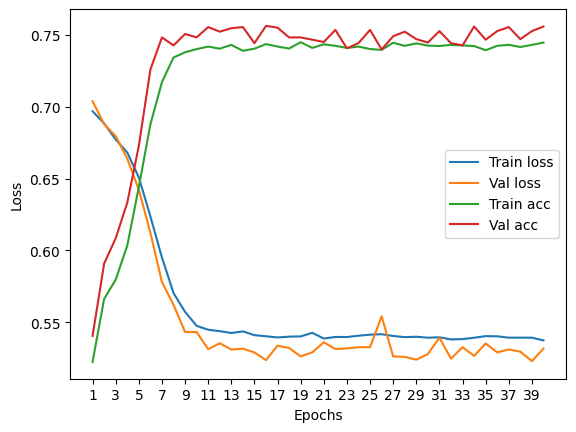

****************************************************************************************************



118it [00:00, 194.65it/s]


Train Epoch: 0 	Loss: 0.694937, Accuracy: 3970/7500 (53%)
Val Epoch: 0 	Loss: 0.703383, Accuracy: 1366/2500 (55%)



118it [00:00, 201.74it/s]


Train Epoch: 1 	Loss: 0.681804, Accuracy: 4321/7500 (58%)
Val Epoch: 1 	Loss: 0.686882, Accuracy: 1495/2500 (60%)



118it [00:00, 195.60it/s]


Train Epoch: 2 	Loss: 0.668424, Accuracy: 4496/7500 (60%)
Val Epoch: 2 	Loss: 0.673035, Accuracy: 1522/2500 (61%)



118it [00:00, 195.85it/s]


Train Epoch: 3 	Loss: 0.650378, Accuracy: 4731/7500 (63%)
Val Epoch: 3 	Loss: 0.653216, Accuracy: 1603/2500 (64%)



118it [00:00, 190.58it/s]


Train Epoch: 4 	Loss: 0.622884, Accuracy: 5072/7500 (68%)
Val Epoch: 4 	Loss: 0.611732, Accuracy: 1739/2500 (70%)



118it [00:00, 193.33it/s]


Train Epoch: 5 	Loss: 0.592140, Accuracy: 5275/7500 (70%)
Val Epoch: 5 	Loss: 0.591651, Accuracy: 1827/2500 (73%)



118it [00:00, 197.87it/s]


Train Epoch: 6 	Loss: 0.567849, Accuracy: 5426/7500 (72%)
Val Epoch: 6 	Loss: 0.569992, Accuracy: 1812/2500 (72%)



118it [00:00, 197.04it/s]


Train Epoch: 7 	Loss: 0.558152, Accuracy: 5434/7500 (72%)
Val Epoch: 7 	Loss: 0.561792, Accuracy: 1834/2500 (73%)



118it [00:00, 200.09it/s]


Train Epoch: 8 	Loss: 0.551633, Accuracy: 5463/7500 (73%)
Val Epoch: 8 	Loss: 0.562544, Accuracy: 1821/2500 (73%)



118it [00:00, 198.09it/s]


Train Epoch: 9 	Loss: 0.549932, Accuracy: 5483/7500 (73%)
Val Epoch: 9 	Loss: 0.554449, Accuracy: 1832/2500 (73%)



118it [00:00, 200.03it/s]


Train Epoch: 10 	Loss: 0.547911, Accuracy: 5473/7500 (73%)
Val Epoch: 10 	Loss: 0.554460, Accuracy: 1843/2500 (74%)



118it [00:00, 189.09it/s]


Train Epoch: 11 	Loss: 0.545452, Accuracy: 5498/7500 (73%)
Val Epoch: 11 	Loss: 0.546455, Accuracy: 1849/2500 (74%)



118it [00:00, 198.56it/s]


Train Epoch: 12 	Loss: 0.545373, Accuracy: 5484/7500 (73%)
Val Epoch: 12 	Loss: 0.549606, Accuracy: 1847/2500 (74%)



118it [00:00, 195.21it/s]


Train Epoch: 13 	Loss: 0.545359, Accuracy: 5510/7500 (73%)
Val Epoch: 13 	Loss: 0.547119, Accuracy: 1843/2500 (74%)



118it [00:00, 196.30it/s]


Train Epoch: 14 	Loss: 0.544277, Accuracy: 5511/7500 (73%)
Val Epoch: 14 	Loss: 0.559247, Accuracy: 1840/2500 (74%)



118it [00:00, 169.34it/s]


Train Epoch: 15 	Loss: 0.546088, Accuracy: 5464/7500 (73%)
Val Epoch: 15 	Loss: 0.548905, Accuracy: 1856/2500 (74%)



118it [00:00, 138.89it/s]


Train Epoch: 16 	Loss: 0.545359, Accuracy: 5486/7500 (73%)
Val Epoch: 16 	Loss: 0.557302, Accuracy: 1852/2500 (74%)



118it [00:00, 146.21it/s]


Train Epoch: 17 	Loss: 0.546043, Accuracy: 5494/7500 (73%)
Val Epoch: 17 	Loss: 0.545777, Accuracy: 1852/2500 (74%)



118it [00:00, 187.80it/s]


Train Epoch: 18 	Loss: 0.544962, Accuracy: 5478/7500 (73%)
Val Epoch: 18 	Loss: 0.547368, Accuracy: 1843/2500 (74%)



118it [00:00, 199.73it/s]


Train Epoch: 19 	Loss: 0.543830, Accuracy: 5495/7500 (73%)
Val Epoch: 19 	Loss: 0.556139, Accuracy: 1843/2500 (74%)



118it [00:00, 198.54it/s]


Train Epoch: 20 	Loss: 0.544701, Accuracy: 5510/7500 (73%)
Val Epoch: 20 	Loss: 0.539492, Accuracy: 1843/2500 (74%)



118it [00:00, 161.82it/s]


Train Epoch: 21 	Loss: 0.541518, Accuracy: 5524/7500 (74%)
Val Epoch: 21 	Loss: 0.547646, Accuracy: 1852/2500 (74%)



118it [00:00, 189.44it/s]


Train Epoch: 22 	Loss: 0.545673, Accuracy: 5489/7500 (73%)
Val Epoch: 22 	Loss: 0.544615, Accuracy: 1843/2500 (74%)



118it [00:00, 197.88it/s]


Train Epoch: 23 	Loss: 0.544955, Accuracy: 5515/7500 (74%)
Val Epoch: 23 	Loss: 0.550441, Accuracy: 1861/2500 (74%)



118it [00:00, 192.62it/s]


Train Epoch: 24 	Loss: 0.544549, Accuracy: 5478/7500 (73%)
Val Epoch: 24 	Loss: 0.546803, Accuracy: 1858/2500 (74%)



118it [00:00, 194.48it/s]


Train Epoch: 25 	Loss: 0.547695, Accuracy: 5492/7500 (73%)
Val Epoch: 25 	Loss: 0.544740, Accuracy: 1844/2500 (74%)



118it [00:00, 195.19it/s]


Train Epoch: 26 	Loss: 0.543809, Accuracy: 5508/7500 (73%)
Val Epoch: 26 	Loss: 0.541292, Accuracy: 1848/2500 (74%)



118it [00:00, 192.98it/s]


Train Epoch: 27 	Loss: 0.542251, Accuracy: 5518/7500 (74%)
Val Epoch: 27 	Loss: 0.554108, Accuracy: 1839/2500 (74%)



118it [00:00, 191.59it/s]


Train Epoch: 28 	Loss: 0.545124, Accuracy: 5507/7500 (73%)
Val Epoch: 28 	Loss: 0.548038, Accuracy: 1845/2500 (74%)



118it [00:00, 160.46it/s]


Train Epoch: 29 	Loss: 0.544784, Accuracy: 5473/7500 (73%)
Val Epoch: 29 	Loss: 0.541675, Accuracy: 1846/2500 (74%)



118it [00:00, 171.43it/s]


Train Epoch: 30 	Loss: 0.543493, Accuracy: 5497/7500 (73%)
Val Epoch: 30 	Loss: 0.557770, Accuracy: 1854/2500 (74%)



118it [00:00, 187.81it/s]


Train Epoch: 31 	Loss: 0.544922, Accuracy: 5522/7500 (74%)
Val Epoch: 31 	Loss: 0.558150, Accuracy: 1860/2500 (74%)



118it [00:00, 195.77it/s]


Train Epoch: 32 	Loss: 0.544815, Accuracy: 5509/7500 (73%)
Val Epoch: 32 	Loss: 0.556179, Accuracy: 1853/2500 (74%)



118it [00:00, 196.27it/s]


Train Epoch: 33 	Loss: 0.548396, Accuracy: 5508/7500 (73%)
Val Epoch: 33 	Loss: 0.550575, Accuracy: 1854/2500 (74%)



118it [00:00, 171.02it/s]


Train Epoch: 34 	Loss: 0.544338, Accuracy: 5507/7500 (73%)
Val Epoch: 34 	Loss: 0.558897, Accuracy: 1861/2500 (74%)



118it [00:00, 145.30it/s]


Train Epoch: 35 	Loss: 0.543161, Accuracy: 5512/7500 (73%)
Val Epoch: 35 	Loss: 0.574664, Accuracy: 1789/2500 (72%)



118it [00:00, 165.98it/s]


Train Epoch: 36 	Loss: 0.545271, Accuracy: 5484/7500 (73%)
Val Epoch: 36 	Loss: 0.548749, Accuracy: 1853/2500 (74%)



118it [00:00, 171.74it/s]


Train Epoch: 37 	Loss: 0.544580, Accuracy: 5518/7500 (74%)
Val Epoch: 37 	Loss: 0.556491, Accuracy: 1862/2500 (74%)



118it [00:00, 185.39it/s]


Train Epoch: 38 	Loss: 0.543259, Accuracy: 5472/7500 (73%)
Val Epoch: 38 	Loss: 0.565905, Accuracy: 1832/2500 (73%)



118it [00:00, 190.35it/s]


Train Epoch: 39 	Loss: 0.545734, Accuracy: 5512/7500 (73%)
Val Epoch: 39 	Loss: 0.557967, Accuracy: 1835/2500 (73%)

Test accuracy:  73.64


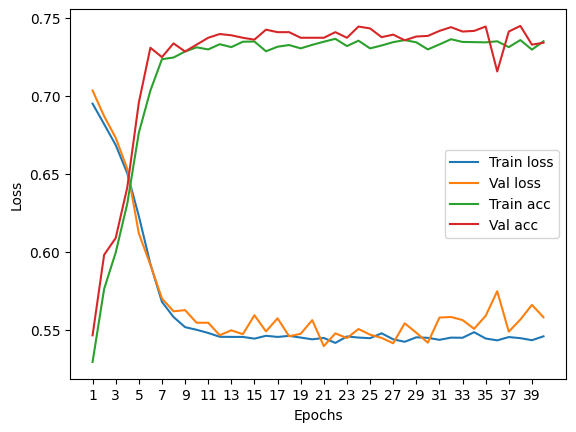

****************************************************************************************************



118it [00:00, 172.74it/s]


Train Epoch: 0 	Loss: 0.698370, Accuracy: 3755/7500 (50%)
Val Epoch: 0 	Loss: 0.708412, Accuracy: 1307/2500 (52%)



118it [00:00, 163.78it/s]


Train Epoch: 1 	Loss: 0.693293, Accuracy: 4044/7500 (54%)
Val Epoch: 1 	Loss: 0.698731, Accuracy: 1498/2500 (60%)



118it [00:00, 195.63it/s]


Train Epoch: 2 	Loss: 0.673167, Accuracy: 4615/7500 (62%)
Val Epoch: 2 	Loss: 0.667687, Accuracy: 1669/2500 (67%)



118it [00:00, 195.51it/s]


Train Epoch: 3 	Loss: 0.634611, Accuracy: 5116/7500 (68%)
Val Epoch: 3 	Loss: 0.623484, Accuracy: 1788/2500 (72%)



118it [00:00, 193.99it/s]


Train Epoch: 4 	Loss: 0.596591, Accuracy: 5344/7500 (71%)
Val Epoch: 4 	Loss: 0.592772, Accuracy: 1811/2500 (72%)



118it [00:00, 194.03it/s]


Train Epoch: 5 	Loss: 0.571558, Accuracy: 5442/7500 (73%)
Val Epoch: 5 	Loss: 0.583712, Accuracy: 1828/2500 (73%)



118it [00:00, 196.07it/s]


Train Epoch: 6 	Loss: 0.561135, Accuracy: 5467/7500 (73%)
Val Epoch: 6 	Loss: 0.571532, Accuracy: 1814/2500 (73%)



118it [00:00, 194.51it/s]


Train Epoch: 7 	Loss: 0.555337, Accuracy: 5502/7500 (73%)
Val Epoch: 7 	Loss: 0.561195, Accuracy: 1830/2500 (73%)



118it [00:00, 196.99it/s]


Train Epoch: 8 	Loss: 0.552447, Accuracy: 5496/7500 (73%)
Val Epoch: 8 	Loss: 0.577224, Accuracy: 1828/2500 (73%)



118it [00:00, 193.33it/s]


Train Epoch: 9 	Loss: 0.549639, Accuracy: 5518/7500 (74%)
Val Epoch: 9 	Loss: 0.562500, Accuracy: 1839/2500 (74%)



118it [00:00, 191.98it/s]


Train Epoch: 10 	Loss: 0.548812, Accuracy: 5491/7500 (73%)
Val Epoch: 10 	Loss: 0.559068, Accuracy: 1841/2500 (74%)



118it [00:00, 191.12it/s]


Train Epoch: 11 	Loss: 0.549328, Accuracy: 5521/7500 (74%)
Val Epoch: 11 	Loss: 0.569358, Accuracy: 1809/2500 (72%)



118it [00:00, 192.90it/s]


Train Epoch: 12 	Loss: 0.549351, Accuracy: 5513/7500 (74%)
Val Epoch: 12 	Loss: 0.567312, Accuracy: 1818/2500 (73%)



118it [00:00, 195.32it/s]


Train Epoch: 13 	Loss: 0.548278, Accuracy: 5502/7500 (73%)
Val Epoch: 13 	Loss: 0.559230, Accuracy: 1829/2500 (73%)



118it [00:00, 189.26it/s]


Train Epoch: 14 	Loss: 0.546615, Accuracy: 5525/7500 (74%)
Val Epoch: 14 	Loss: 0.559692, Accuracy: 1843/2500 (74%)



118it [00:00, 185.89it/s]


Train Epoch: 15 	Loss: 0.547070, Accuracy: 5493/7500 (73%)
Val Epoch: 15 	Loss: 0.561904, Accuracy: 1824/2500 (73%)



118it [00:00, 177.74it/s]


Train Epoch: 16 	Loss: 0.549221, Accuracy: 5522/7500 (74%)
Val Epoch: 16 	Loss: 0.566359, Accuracy: 1830/2500 (73%)



118it [00:00, 201.75it/s]


Train Epoch: 17 	Loss: 0.545813, Accuracy: 5522/7500 (74%)
Val Epoch: 17 	Loss: 0.567861, Accuracy: 1829/2500 (73%)



118it [00:00, 181.75it/s]


Train Epoch: 18 	Loss: 0.547677, Accuracy: 5494/7500 (73%)
Val Epoch: 18 	Loss: 0.559291, Accuracy: 1830/2500 (73%)



118it [00:00, 148.44it/s]


Train Epoch: 19 	Loss: 0.547075, Accuracy: 5513/7500 (74%)
Val Epoch: 19 	Loss: 0.564526, Accuracy: 1833/2500 (73%)



118it [00:00, 163.11it/s]


Train Epoch: 20 	Loss: 0.546902, Accuracy: 5534/7500 (74%)
Val Epoch: 20 	Loss: 0.564570, Accuracy: 1832/2500 (73%)



118it [00:00, 162.86it/s]


Train Epoch: 21 	Loss: 0.548001, Accuracy: 5519/7500 (74%)
Val Epoch: 21 	Loss: 0.553790, Accuracy: 1846/2500 (74%)



118it [00:00, 176.11it/s]


Train Epoch: 22 	Loss: 0.546148, Accuracy: 5538/7500 (74%)
Val Epoch: 22 	Loss: 0.559833, Accuracy: 1838/2500 (74%)



118it [00:00, 183.68it/s]


Train Epoch: 23 	Loss: 0.547621, Accuracy: 5527/7500 (74%)
Val Epoch: 23 	Loss: 0.563386, Accuracy: 1830/2500 (73%)



118it [00:00, 191.67it/s]


Train Epoch: 24 	Loss: 0.546340, Accuracy: 5544/7500 (74%)
Val Epoch: 24 	Loss: 0.572150, Accuracy: 1835/2500 (73%)



118it [00:00, 184.07it/s]


Train Epoch: 25 	Loss: 0.549478, Accuracy: 5525/7500 (74%)
Val Epoch: 25 	Loss: 0.565992, Accuracy: 1832/2500 (73%)



118it [00:00, 195.57it/s]


Train Epoch: 26 	Loss: 0.544656, Accuracy: 5517/7500 (74%)
Val Epoch: 26 	Loss: 0.563311, Accuracy: 1821/2500 (73%)



118it [00:00, 185.27it/s]


Train Epoch: 27 	Loss: 0.545288, Accuracy: 5535/7500 (74%)
Val Epoch: 27 	Loss: 0.560521, Accuracy: 1833/2500 (73%)



118it [00:00, 168.78it/s]


Train Epoch: 28 	Loss: 0.545478, Accuracy: 5520/7500 (74%)
Val Epoch: 28 	Loss: 0.559137, Accuracy: 1841/2500 (74%)



118it [00:00, 180.14it/s]


Train Epoch: 29 	Loss: 0.545769, Accuracy: 5494/7500 (73%)
Val Epoch: 29 	Loss: 0.561250, Accuracy: 1836/2500 (73%)



118it [00:00, 158.63it/s]


Train Epoch: 30 	Loss: 0.546840, Accuracy: 5514/7500 (74%)
Val Epoch: 30 	Loss: 0.570998, Accuracy: 1813/2500 (73%)



118it [00:00, 184.14it/s]


Train Epoch: 31 	Loss: 0.546858, Accuracy: 5512/7500 (73%)
Val Epoch: 31 	Loss: 0.556553, Accuracy: 1832/2500 (73%)



118it [00:00, 185.23it/s]


Train Epoch: 32 	Loss: 0.547403, Accuracy: 5505/7500 (73%)
Val Epoch: 32 	Loss: 0.577728, Accuracy: 1836/2500 (73%)



118it [00:00, 198.04it/s]


Train Epoch: 33 	Loss: 0.544764, Accuracy: 5533/7500 (74%)
Val Epoch: 33 	Loss: 0.561609, Accuracy: 1839/2500 (74%)



118it [00:00, 193.70it/s]


Train Epoch: 34 	Loss: 0.544721, Accuracy: 5521/7500 (74%)
Val Epoch: 34 	Loss: 0.564971, Accuracy: 1820/2500 (73%)



118it [00:00, 195.36it/s]


Train Epoch: 35 	Loss: 0.545941, Accuracy: 5557/7500 (74%)
Val Epoch: 35 	Loss: 0.589311, Accuracy: 1792/2500 (72%)



118it [00:00, 195.04it/s]


Train Epoch: 36 	Loss: 0.548060, Accuracy: 5480/7500 (73%)
Val Epoch: 36 	Loss: 0.560464, Accuracy: 1830/2500 (73%)



118it [00:00, 172.39it/s]


Train Epoch: 37 	Loss: 0.548719, Accuracy: 5508/7500 (73%)
Val Epoch: 37 	Loss: 0.558459, Accuracy: 1836/2500 (73%)



118it [00:00, 152.80it/s]


Train Epoch: 38 	Loss: 0.545356, Accuracy: 5560/7500 (74%)
Val Epoch: 38 	Loss: 0.555696, Accuracy: 1839/2500 (74%)



118it [00:00, 150.46it/s]


Train Epoch: 39 	Loss: 0.548539, Accuracy: 5505/7500 (73%)
Val Epoch: 39 	Loss: 0.566098, Accuracy: 1843/2500 (74%)

Test accuracy:  74.56


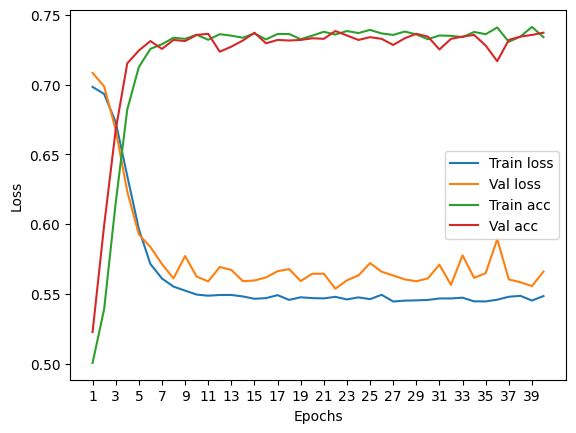

****************************************************************************************************



118it [00:00, 199.47it/s]


Train Epoch: 0 	Loss: 0.695222, Accuracy: 4005/7500 (53%)
Val Epoch: 0 	Loss: 0.703054, Accuracy: 1360/2500 (54%)



118it [00:00, 191.44it/s]


Train Epoch: 1 	Loss: 0.685359, Accuracy: 4279/7500 (57%)
Val Epoch: 1 	Loss: 0.686675, Accuracy: 1490/2500 (60%)



118it [00:00, 164.03it/s]


Train Epoch: 2 	Loss: 0.672717, Accuracy: 4461/7500 (59%)
Val Epoch: 2 	Loss: 0.673372, Accuracy: 1509/2500 (60%)



118it [00:00, 159.09it/s]


Train Epoch: 3 	Loss: 0.644733, Accuracy: 4890/7500 (65%)
Val Epoch: 3 	Loss: 0.632808, Accuracy: 1724/2500 (69%)



118it [00:00, 150.33it/s]


Train Epoch: 4 	Loss: 0.612564, Accuracy: 5221/7500 (70%)
Val Epoch: 4 	Loss: 0.599359, Accuracy: 1800/2500 (72%)



118it [00:00, 178.81it/s]


Train Epoch: 5 	Loss: 0.583912, Accuracy: 5340/7500 (71%)
Val Epoch: 5 	Loss: 0.588367, Accuracy: 1787/2500 (71%)



118it [00:00, 195.83it/s]


Train Epoch: 6 	Loss: 0.570198, Accuracy: 5407/7500 (72%)
Val Epoch: 6 	Loss: 0.567814, Accuracy: 1828/2500 (73%)



118it [00:00, 194.43it/s]


Train Epoch: 7 	Loss: 0.561433, Accuracy: 5461/7500 (73%)
Val Epoch: 7 	Loss: 0.557499, Accuracy: 1834/2500 (73%)



118it [00:00, 193.61it/s]


Train Epoch: 8 	Loss: 0.556610, Accuracy: 5471/7500 (73%)
Val Epoch: 8 	Loss: 0.558629, Accuracy: 1836/2500 (73%)



118it [00:00, 191.37it/s]


Train Epoch: 9 	Loss: 0.553388, Accuracy: 5500/7500 (73%)
Val Epoch: 9 	Loss: 0.553265, Accuracy: 1836/2500 (73%)



118it [00:00, 197.40it/s]


Train Epoch: 10 	Loss: 0.551264, Accuracy: 5487/7500 (73%)
Val Epoch: 10 	Loss: 0.557529, Accuracy: 1831/2500 (73%)



118it [00:00, 193.13it/s]


Train Epoch: 11 	Loss: 0.548293, Accuracy: 5505/7500 (73%)
Val Epoch: 11 	Loss: 0.557442, Accuracy: 1837/2500 (73%)



118it [00:00, 194.41it/s]


Train Epoch: 12 	Loss: 0.553211, Accuracy: 5485/7500 (73%)
Val Epoch: 12 	Loss: 0.566818, Accuracy: 1835/2500 (73%)



118it [00:00, 186.57it/s]


Train Epoch: 13 	Loss: 0.548430, Accuracy: 5521/7500 (74%)
Val Epoch: 13 	Loss: 0.549550, Accuracy: 1844/2500 (74%)



118it [00:00, 184.67it/s]


Train Epoch: 14 	Loss: 0.548282, Accuracy: 5519/7500 (74%)
Val Epoch: 14 	Loss: 0.563543, Accuracy: 1825/2500 (73%)



118it [00:00, 201.50it/s]


Train Epoch: 15 	Loss: 0.549571, Accuracy: 5535/7500 (74%)
Val Epoch: 15 	Loss: 0.555764, Accuracy: 1836/2500 (73%)



118it [00:00, 196.18it/s]


Train Epoch: 16 	Loss: 0.548615, Accuracy: 5523/7500 (74%)
Val Epoch: 16 	Loss: 0.565768, Accuracy: 1832/2500 (73%)



118it [00:00, 194.76it/s]


Train Epoch: 17 	Loss: 0.546685, Accuracy: 5525/7500 (74%)
Val Epoch: 17 	Loss: 0.556230, Accuracy: 1852/2500 (74%)



118it [00:00, 181.39it/s]


Train Epoch: 18 	Loss: 0.548879, Accuracy: 5528/7500 (74%)
Val Epoch: 18 	Loss: 0.552362, Accuracy: 1831/2500 (73%)



118it [00:00, 200.28it/s]


Train Epoch: 19 	Loss: 0.546736, Accuracy: 5506/7500 (73%)
Val Epoch: 19 	Loss: 0.547351, Accuracy: 1853/2500 (74%)



118it [00:00, 195.46it/s]


Train Epoch: 20 	Loss: 0.548050, Accuracy: 5555/7500 (74%)
Val Epoch: 20 	Loss: 0.548022, Accuracy: 1838/2500 (74%)



118it [00:00, 198.34it/s]


Train Epoch: 21 	Loss: 0.547736, Accuracy: 5512/7500 (73%)
Val Epoch: 21 	Loss: 0.563194, Accuracy: 1825/2500 (73%)



118it [00:00, 155.84it/s]


Train Epoch: 22 	Loss: 0.546696, Accuracy: 5529/7500 (74%)
Val Epoch: 22 	Loss: 0.559401, Accuracy: 1855/2500 (74%)



118it [00:00, 166.47it/s]


Train Epoch: 23 	Loss: 0.547188, Accuracy: 5533/7500 (74%)
Val Epoch: 23 	Loss: 0.551247, Accuracy: 1835/2500 (73%)



118it [00:00, 163.32it/s]


Train Epoch: 24 	Loss: 0.546868, Accuracy: 5521/7500 (74%)
Val Epoch: 24 	Loss: 0.564923, Accuracy: 1816/2500 (73%)



118it [00:00, 192.90it/s]


Train Epoch: 25 	Loss: 0.548277, Accuracy: 5497/7500 (73%)
Val Epoch: 25 	Loss: 0.558055, Accuracy: 1845/2500 (74%)



118it [00:00, 194.67it/s]


Train Epoch: 26 	Loss: 0.545671, Accuracy: 5528/7500 (74%)
Val Epoch: 26 	Loss: 0.556007, Accuracy: 1829/2500 (73%)



118it [00:00, 193.03it/s]


Train Epoch: 27 	Loss: 0.547641, Accuracy: 5509/7500 (73%)
Val Epoch: 27 	Loss: 0.563359, Accuracy: 1838/2500 (74%)



118it [00:00, 194.63it/s]


Train Epoch: 28 	Loss: 0.545386, Accuracy: 5545/7500 (74%)
Val Epoch: 28 	Loss: 0.551663, Accuracy: 1838/2500 (74%)



118it [00:00, 194.65it/s]


Train Epoch: 29 	Loss: 0.546269, Accuracy: 5558/7500 (74%)
Val Epoch: 29 	Loss: 0.557575, Accuracy: 1849/2500 (74%)



118it [00:00, 156.92it/s]


Train Epoch: 30 	Loss: 0.550206, Accuracy: 5522/7500 (74%)
Val Epoch: 30 	Loss: 0.556162, Accuracy: 1851/2500 (74%)



118it [00:00, 168.15it/s]


Train Epoch: 31 	Loss: 0.547255, Accuracy: 5532/7500 (74%)
Val Epoch: 31 	Loss: 0.545631, Accuracy: 1842/2500 (74%)



118it [00:00, 178.95it/s]


Train Epoch: 32 	Loss: 0.545158, Accuracy: 5528/7500 (74%)
Val Epoch: 32 	Loss: 0.555445, Accuracy: 1828/2500 (73%)



118it [00:00, 188.70it/s]


Train Epoch: 33 	Loss: 0.545888, Accuracy: 5530/7500 (74%)
Val Epoch: 33 	Loss: 0.548591, Accuracy: 1845/2500 (74%)



118it [00:00, 196.10it/s]


Train Epoch: 34 	Loss: 0.546173, Accuracy: 5522/7500 (74%)
Val Epoch: 34 	Loss: 0.554221, Accuracy: 1842/2500 (74%)



118it [00:00, 197.55it/s]


Train Epoch: 35 	Loss: 0.545798, Accuracy: 5534/7500 (74%)
Val Epoch: 35 	Loss: 0.549215, Accuracy: 1850/2500 (74%)



118it [00:00, 196.41it/s]


Train Epoch: 36 	Loss: 0.547526, Accuracy: 5513/7500 (74%)
Val Epoch: 36 	Loss: 0.545181, Accuracy: 1849/2500 (74%)



118it [00:00, 195.80it/s]


Train Epoch: 37 	Loss: 0.546983, Accuracy: 5530/7500 (74%)
Val Epoch: 37 	Loss: 0.557842, Accuracy: 1848/2500 (74%)



118it [00:00, 189.48it/s]


Train Epoch: 38 	Loss: 0.545292, Accuracy: 5533/7500 (74%)
Val Epoch: 38 	Loss: 0.551575, Accuracy: 1832/2500 (73%)



118it [00:00, 199.26it/s]


Train Epoch: 39 	Loss: 0.547107, Accuracy: 5544/7500 (74%)
Val Epoch: 39 	Loss: 0.547770, Accuracy: 1851/2500 (74%)

Test accuracy:  73.36


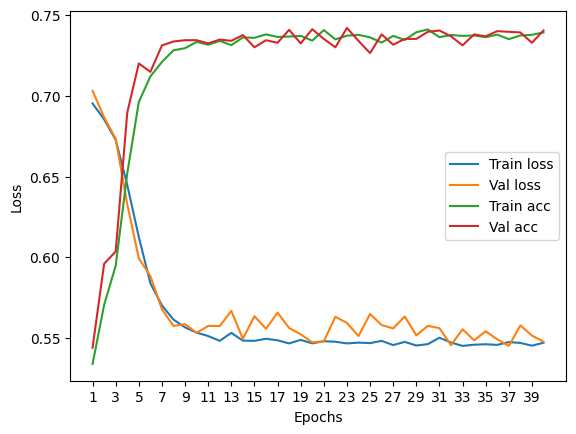

****************************************************************************************************



118it [00:00, 216.72it/s]


Train Epoch: 0 	Loss: 0.694829, Accuracy: 4006/7500 (53%)
Val Epoch: 0 	Loss: 0.703851, Accuracy: 1359/2500 (54%)



118it [00:00, 191.70it/s]


Train Epoch: 1 	Loss: 0.685724, Accuracy: 4228/7500 (56%)
Val Epoch: 1 	Loss: 0.702435, Accuracy: 1416/2500 (57%)



118it [00:00, 201.07it/s]


Train Epoch: 2 	Loss: 0.680288, Accuracy: 4341/7500 (58%)
Val Epoch: 2 	Loss: 0.691870, Accuracy: 1430/2500 (57%)



118it [00:00, 197.17it/s]


Train Epoch: 3 	Loss: 0.672559, Accuracy: 4480/7500 (60%)
Val Epoch: 3 	Loss: 0.689955, Accuracy: 1463/2500 (59%)



118it [00:00, 190.70it/s]


Train Epoch: 4 	Loss: 0.663899, Accuracy: 4586/7500 (61%)
Val Epoch: 4 	Loss: 0.677478, Accuracy: 1523/2500 (61%)



118it [00:00, 153.28it/s]


Train Epoch: 5 	Loss: 0.648156, Accuracy: 4792/7500 (64%)
Val Epoch: 5 	Loss: 0.661713, Accuracy: 1569/2500 (63%)



118it [00:00, 158.48it/s]


Train Epoch: 6 	Loss: 0.628944, Accuracy: 5010/7500 (67%)
Val Epoch: 6 	Loss: 0.641995, Accuracy: 1639/2500 (66%)



118it [00:00, 151.15it/s]


Train Epoch: 7 	Loss: 0.608132, Accuracy: 5191/7500 (69%)
Val Epoch: 7 	Loss: 0.613983, Accuracy: 1785/2500 (71%)



118it [00:00, 186.19it/s]


Train Epoch: 8 	Loss: 0.582232, Accuracy: 5386/7500 (72%)
Val Epoch: 8 	Loss: 0.582289, Accuracy: 1799/2500 (72%)



118it [00:00, 197.69it/s]


Train Epoch: 9 	Loss: 0.566927, Accuracy: 5445/7500 (73%)
Val Epoch: 9 	Loss: 0.580943, Accuracy: 1804/2500 (72%)



118it [00:00, 180.23it/s]


Train Epoch: 10 	Loss: 0.558903, Accuracy: 5501/7500 (73%)
Val Epoch: 10 	Loss: 0.568649, Accuracy: 1834/2500 (73%)



118it [00:00, 177.47it/s]


Train Epoch: 11 	Loss: 0.553744, Accuracy: 5517/7500 (74%)
Val Epoch: 11 	Loss: 0.574521, Accuracy: 1819/2500 (73%)



118it [00:00, 192.10it/s]


Train Epoch: 12 	Loss: 0.552392, Accuracy: 5479/7500 (73%)
Val Epoch: 12 	Loss: 0.570078, Accuracy: 1828/2500 (73%)



118it [00:00, 198.95it/s]


Train Epoch: 13 	Loss: 0.550362, Accuracy: 5509/7500 (73%)
Val Epoch: 13 	Loss: 0.571489, Accuracy: 1824/2500 (73%)



118it [00:00, 188.35it/s]


Train Epoch: 14 	Loss: 0.554857, Accuracy: 5478/7500 (73%)
Val Epoch: 14 	Loss: 0.570316, Accuracy: 1835/2500 (73%)



118it [00:00, 194.02it/s]


Train Epoch: 15 	Loss: 0.551828, Accuracy: 5501/7500 (73%)
Val Epoch: 15 	Loss: 0.565091, Accuracy: 1810/2500 (72%)



118it [00:00, 195.67it/s]


Train Epoch: 16 	Loss: 0.552474, Accuracy: 5507/7500 (73%)
Val Epoch: 16 	Loss: 0.564189, Accuracy: 1822/2500 (73%)



118it [00:00, 193.37it/s]


Train Epoch: 17 	Loss: 0.551031, Accuracy: 5532/7500 (74%)
Val Epoch: 17 	Loss: 0.556229, Accuracy: 1825/2500 (73%)



118it [00:00, 189.84it/s]


Train Epoch: 18 	Loss: 0.554148, Accuracy: 5538/7500 (74%)
Val Epoch: 18 	Loss: 0.562929, Accuracy: 1834/2500 (73%)



118it [00:00, 194.01it/s]


Train Epoch: 19 	Loss: 0.551240, Accuracy: 5504/7500 (73%)
Val Epoch: 19 	Loss: 0.567677, Accuracy: 1835/2500 (73%)



118it [00:00, 179.39it/s]


Train Epoch: 20 	Loss: 0.547931, Accuracy: 5541/7500 (74%)
Val Epoch: 20 	Loss: 0.562824, Accuracy: 1820/2500 (73%)



118it [00:00, 195.32it/s]


Train Epoch: 21 	Loss: 0.553342, Accuracy: 5535/7500 (74%)
Val Epoch: 21 	Loss: 0.572390, Accuracy: 1823/2500 (73%)



118it [00:00, 202.29it/s]


Train Epoch: 22 	Loss: 0.553017, Accuracy: 5503/7500 (73%)
Val Epoch: 22 	Loss: 0.552241, Accuracy: 1842/2500 (74%)



118it [00:00, 199.64it/s]


Train Epoch: 23 	Loss: 0.551192, Accuracy: 5522/7500 (74%)
Val Epoch: 23 	Loss: 0.562514, Accuracy: 1832/2500 (73%)



118it [00:00, 144.04it/s]


Train Epoch: 24 	Loss: 0.550546, Accuracy: 5509/7500 (73%)
Val Epoch: 24 	Loss: 0.559558, Accuracy: 1838/2500 (74%)



118it [00:00, 143.73it/s]


Train Epoch: 25 	Loss: 0.549244, Accuracy: 5521/7500 (74%)
Val Epoch: 25 	Loss: 0.557773, Accuracy: 1829/2500 (73%)



118it [00:00, 158.85it/s]


Train Epoch: 26 	Loss: 0.550703, Accuracy: 5531/7500 (74%)
Val Epoch: 26 	Loss: 0.554125, Accuracy: 1834/2500 (73%)



118it [00:00, 141.34it/s]


Train Epoch: 27 	Loss: 0.550750, Accuracy: 5519/7500 (74%)
Val Epoch: 27 	Loss: 0.557285, Accuracy: 1816/2500 (73%)



118it [00:00, 175.12it/s]


Train Epoch: 28 	Loss: 0.547887, Accuracy: 5522/7500 (74%)
Val Epoch: 28 	Loss: 0.556071, Accuracy: 1827/2500 (73%)



118it [00:00, 194.82it/s]


Train Epoch: 29 	Loss: 0.548545, Accuracy: 5534/7500 (74%)
Val Epoch: 29 	Loss: 0.565225, Accuracy: 1827/2500 (73%)



118it [00:00, 193.67it/s]


Train Epoch: 30 	Loss: 0.551168, Accuracy: 5524/7500 (74%)
Val Epoch: 30 	Loss: 0.561789, Accuracy: 1827/2500 (73%)



118it [00:00, 194.89it/s]


Train Epoch: 31 	Loss: 0.550296, Accuracy: 5530/7500 (74%)
Val Epoch: 31 	Loss: 0.551427, Accuracy: 1821/2500 (73%)



118it [00:00, 194.31it/s]


Train Epoch: 32 	Loss: 0.550458, Accuracy: 5505/7500 (73%)
Val Epoch: 32 	Loss: 0.567271, Accuracy: 1834/2500 (73%)



118it [00:00, 193.05it/s]


Train Epoch: 33 	Loss: 0.551135, Accuracy: 5527/7500 (74%)
Val Epoch: 33 	Loss: 0.552394, Accuracy: 1828/2500 (73%)



118it [00:00, 194.41it/s]


Train Epoch: 34 	Loss: 0.549191, Accuracy: 5507/7500 (73%)
Val Epoch: 34 	Loss: 0.557029, Accuracy: 1840/2500 (74%)



118it [00:00, 193.90it/s]


Train Epoch: 35 	Loss: 0.547759, Accuracy: 5556/7500 (74%)
Val Epoch: 35 	Loss: 0.556174, Accuracy: 1822/2500 (73%)



118it [00:00, 195.88it/s]


Train Epoch: 36 	Loss: 0.549400, Accuracy: 5528/7500 (74%)
Val Epoch: 36 	Loss: 0.558037, Accuracy: 1828/2500 (73%)



118it [00:00, 195.16it/s]


Train Epoch: 37 	Loss: 0.549021, Accuracy: 5519/7500 (74%)
Val Epoch: 37 	Loss: 0.560139, Accuracy: 1824/2500 (73%)



118it [00:00, 189.45it/s]


Train Epoch: 38 	Loss: 0.550559, Accuracy: 5533/7500 (74%)
Val Epoch: 38 	Loss: 0.578859, Accuracy: 1819/2500 (73%)



118it [00:00, 196.57it/s]


Train Epoch: 39 	Loss: 0.549135, Accuracy: 5523/7500 (74%)
Val Epoch: 39 	Loss: 0.569285, Accuracy: 1825/2500 (73%)

Test accuracy:  74.76


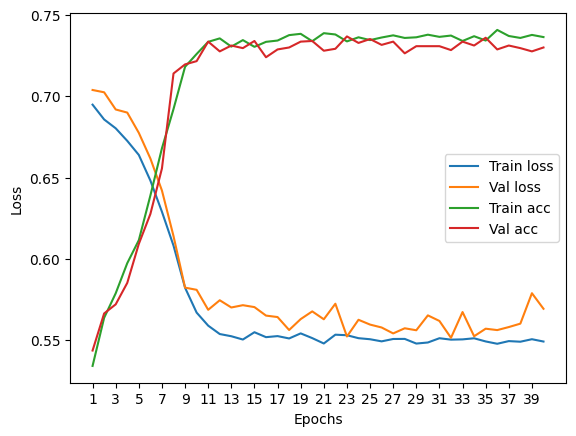

****************************************************************************************************



116it [00:00, 199.51it/s]


Train Epoch: 0 	Loss: 0.692620, Accuracy: 3862/7422 (52%)
Val Epoch: 0 	Loss: 0.693886, Accuracy: 1428/2474 (58%)



116it [00:00, 192.71it/s]


Train Epoch: 1 	Loss: 0.683173, Accuracy: 4243/7422 (57%)
Val Epoch: 1 	Loss: 0.680168, Accuracy: 1474/2474 (60%)



116it [00:00, 187.16it/s]


Train Epoch: 2 	Loss: 0.670591, Accuracy: 4385/7422 (59%)
Val Epoch: 2 	Loss: 0.665991, Accuracy: 1524/2474 (62%)



116it [00:00, 183.39it/s]


Train Epoch: 3 	Loss: 0.649015, Accuracy: 4670/7422 (63%)
Val Epoch: 3 	Loss: 0.647914, Accuracy: 1608/2474 (65%)



116it [00:00, 197.76it/s]


Train Epoch: 4 	Loss: 0.619773, Accuracy: 5052/7422 (68%)
Val Epoch: 4 	Loss: 0.607727, Accuracy: 1739/2474 (70%)



116it [00:00, 188.47it/s]


Train Epoch: 5 	Loss: 0.589393, Accuracy: 5293/7422 (71%)
Val Epoch: 5 	Loss: 0.606193, Accuracy: 1700/2474 (69%)



116it [00:00, 197.41it/s]


Train Epoch: 6 	Loss: 0.569490, Accuracy: 5398/7422 (73%)
Val Epoch: 6 	Loss: 0.567269, Accuracy: 1825/2474 (74%)



116it [00:00, 193.03it/s]


Train Epoch: 7 	Loss: 0.554230, Accuracy: 5442/7422 (73%)
Val Epoch: 7 	Loss: 0.556614, Accuracy: 1828/2474 (74%)



116it [00:00, 193.10it/s]


Train Epoch: 8 	Loss: 0.547525, Accuracy: 5480/7422 (74%)
Val Epoch: 8 	Loss: 0.569492, Accuracy: 1787/2474 (72%)



116it [00:00, 154.99it/s]


Train Epoch: 9 	Loss: 0.544676, Accuracy: 5485/7422 (74%)
Val Epoch: 9 	Loss: 0.554952, Accuracy: 1817/2474 (73%)



116it [00:00, 147.44it/s]


Train Epoch: 10 	Loss: 0.541546, Accuracy: 5478/7422 (74%)
Val Epoch: 10 	Loss: 0.550404, Accuracy: 1823/2474 (74%)



116it [00:00, 153.79it/s]


Train Epoch: 11 	Loss: 0.540393, Accuracy: 5508/7422 (74%)
Val Epoch: 11 	Loss: 0.548916, Accuracy: 1825/2474 (74%)



116it [00:00, 185.08it/s]


Train Epoch: 12 	Loss: 0.540713, Accuracy: 5512/7422 (74%)
Val Epoch: 12 	Loss: 0.553157, Accuracy: 1818/2474 (73%)



116it [00:00, 183.03it/s]


Train Epoch: 13 	Loss: 0.540573, Accuracy: 5498/7422 (74%)
Val Epoch: 13 	Loss: 0.546709, Accuracy: 1832/2474 (74%)



116it [00:00, 193.60it/s]


Train Epoch: 14 	Loss: 0.539515, Accuracy: 5507/7422 (74%)
Val Epoch: 14 	Loss: 0.547589, Accuracy: 1836/2474 (74%)



116it [00:00, 195.13it/s]


Train Epoch: 15 	Loss: 0.538953, Accuracy: 5492/7422 (74%)
Val Epoch: 15 	Loss: 0.546251, Accuracy: 1828/2474 (74%)



116it [00:00, 189.68it/s]


Train Epoch: 16 	Loss: 0.537795, Accuracy: 5527/7422 (74%)
Val Epoch: 16 	Loss: 0.551516, Accuracy: 1821/2474 (74%)



116it [00:00, 194.07it/s]


Train Epoch: 17 	Loss: 0.537271, Accuracy: 5514/7422 (74%)
Val Epoch: 17 	Loss: 0.546751, Accuracy: 1827/2474 (74%)



116it [00:00, 187.94it/s]


Train Epoch: 18 	Loss: 0.537835, Accuracy: 5494/7422 (74%)
Val Epoch: 18 	Loss: 0.548144, Accuracy: 1824/2474 (74%)



116it [00:00, 193.77it/s]


Train Epoch: 19 	Loss: 0.537736, Accuracy: 5505/7422 (74%)
Val Epoch: 19 	Loss: 0.552713, Accuracy: 1827/2474 (74%)



116it [00:00, 192.84it/s]


Train Epoch: 20 	Loss: 0.537512, Accuracy: 5515/7422 (74%)
Val Epoch: 20 	Loss: 0.553204, Accuracy: 1832/2474 (74%)



116it [00:00, 193.10it/s]


Train Epoch: 21 	Loss: 0.537550, Accuracy: 5499/7422 (74%)
Val Epoch: 21 	Loss: 0.548885, Accuracy: 1820/2474 (74%)



116it [00:00, 196.00it/s]


Train Epoch: 22 	Loss: 0.537180, Accuracy: 5502/7422 (74%)
Val Epoch: 22 	Loss: 0.548859, Accuracy: 1819/2474 (74%)



116it [00:00, 197.91it/s]


Train Epoch: 23 	Loss: 0.537293, Accuracy: 5500/7422 (74%)
Val Epoch: 23 	Loss: 0.548617, Accuracy: 1821/2474 (74%)



116it [00:00, 191.43it/s]


Train Epoch: 24 	Loss: 0.538509, Accuracy: 5501/7422 (74%)
Val Epoch: 24 	Loss: 0.547300, Accuracy: 1834/2474 (74%)



116it [00:00, 193.96it/s]


Train Epoch: 25 	Loss: 0.539340, Accuracy: 5517/7422 (74%)
Val Epoch: 25 	Loss: 0.547244, Accuracy: 1841/2474 (74%)



116it [00:00, 197.13it/s]


Train Epoch: 26 	Loss: 0.538574, Accuracy: 5500/7422 (74%)
Val Epoch: 26 	Loss: 0.547400, Accuracy: 1826/2474 (74%)



116it [00:00, 191.78it/s]


Train Epoch: 27 	Loss: 0.536975, Accuracy: 5522/7422 (74%)
Val Epoch: 27 	Loss: 0.554156, Accuracy: 1823/2474 (74%)



116it [00:00, 158.71it/s]


Train Epoch: 28 	Loss: 0.540111, Accuracy: 5495/7422 (74%)
Val Epoch: 28 	Loss: 0.547801, Accuracy: 1822/2474 (74%)



116it [00:00, 138.71it/s]


Train Epoch: 29 	Loss: 0.537817, Accuracy: 5523/7422 (74%)
Val Epoch: 29 	Loss: 0.546317, Accuracy: 1835/2474 (74%)



116it [00:00, 163.05it/s]


Train Epoch: 30 	Loss: 0.536723, Accuracy: 5510/7422 (74%)
Val Epoch: 30 	Loss: 0.547505, Accuracy: 1836/2474 (74%)



116it [00:00, 167.77it/s]


Train Epoch: 31 	Loss: 0.537806, Accuracy: 5519/7422 (74%)
Val Epoch: 31 	Loss: 0.545773, Accuracy: 1831/2474 (74%)



116it [00:00, 194.92it/s]


Train Epoch: 32 	Loss: 0.537792, Accuracy: 5497/7422 (74%)
Val Epoch: 32 	Loss: 0.550245, Accuracy: 1818/2474 (73%)



116it [00:00, 193.74it/s]


Train Epoch: 33 	Loss: 0.537072, Accuracy: 5532/7422 (75%)
Val Epoch: 33 	Loss: 0.548393, Accuracy: 1837/2474 (74%)



116it [00:00, 196.31it/s]


Train Epoch: 34 	Loss: 0.537326, Accuracy: 5522/7422 (74%)
Val Epoch: 34 	Loss: 0.545468, Accuracy: 1832/2474 (74%)



116it [00:00, 193.09it/s]


Train Epoch: 35 	Loss: 0.535996, Accuracy: 5532/7422 (75%)
Val Epoch: 35 	Loss: 0.557293, Accuracy: 1817/2474 (73%)



116it [00:00, 197.90it/s]


Train Epoch: 36 	Loss: 0.537140, Accuracy: 5527/7422 (74%)
Val Epoch: 36 	Loss: 0.545828, Accuracy: 1826/2474 (74%)



116it [00:00, 190.10it/s]


Train Epoch: 37 	Loss: 0.536519, Accuracy: 5533/7422 (75%)
Val Epoch: 37 	Loss: 0.549788, Accuracy: 1829/2474 (74%)



116it [00:00, 180.25it/s]


Train Epoch: 38 	Loss: 0.537103, Accuracy: 5529/7422 (74%)
Val Epoch: 38 	Loss: 0.549274, Accuracy: 1824/2474 (74%)



116it [00:00, 184.00it/s]


Train Epoch: 39 	Loss: 0.536485, Accuracy: 5521/7422 (74%)
Val Epoch: 39 	Loss: 0.554201, Accuracy: 1816/2474 (73%)

Test accuracy:  74.05012126111559


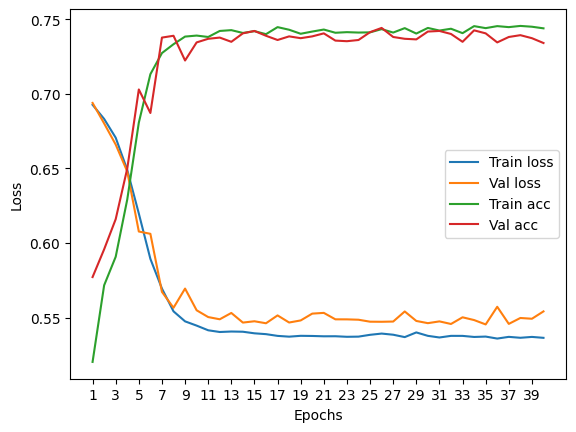

****************************************************************************************************



Particles per jet: 14


118it [00:00, 191.22it/s]


Train Epoch: 0 	Loss: 0.696981, Accuracy: 3890/7500 (52%)
Val Epoch: 0 	Loss: 0.705225, Accuracy: 1321/2500 (53%)



118it [00:00, 188.89it/s]


Train Epoch: 1 	Loss: 0.686729, Accuracy: 4271/7500 (57%)
Val Epoch: 1 	Loss: 0.688348, Accuracy: 1468/2500 (59%)



118it [00:00, 188.80it/s]


Train Epoch: 2 	Loss: 0.663974, Accuracy: 4660/7500 (62%)
Val Epoch: 2 	Loss: 0.670550, Accuracy: 1587/2500 (63%)



118it [00:00, 192.88it/s]


Train Epoch: 3 	Loss: 0.635795, Accuracy: 5027/7500 (67%)
Val Epoch: 3 	Loss: 0.626782, Accuracy: 1697/2500 (68%)



118it [00:00, 193.27it/s]


Train Epoch: 4 	Loss: 0.601582, Accuracy: 5312/7500 (71%)
Val Epoch: 4 	Loss: 0.611765, Accuracy: 1673/2500 (67%)



118it [00:00, 195.99it/s]


Train Epoch: 5 	Loss: 0.576497, Accuracy: 5420/7500 (72%)
Val Epoch: 5 	Loss: 0.585289, Accuracy: 1790/2500 (72%)



118it [00:00, 186.31it/s]


Train Epoch: 6 	Loss: 0.562628, Accuracy: 5486/7500 (73%)
Val Epoch: 6 	Loss: 0.566321, Accuracy: 1832/2500 (73%)



118it [00:00, 183.79it/s]


Train Epoch: 7 	Loss: 0.551457, Accuracy: 5552/7500 (74%)
Val Epoch: 7 	Loss: 0.566874, Accuracy: 1825/2500 (73%)



118it [00:00, 184.34it/s]


Train Epoch: 8 	Loss: 0.546502, Accuracy: 5501/7500 (73%)
Val Epoch: 8 	Loss: 0.561585, Accuracy: 1846/2500 (74%)



118it [00:00, 191.40it/s]


Train Epoch: 9 	Loss: 0.541921, Accuracy: 5559/7500 (74%)
Val Epoch: 9 	Loss: 0.550297, Accuracy: 1844/2500 (74%)



118it [00:00, 190.26it/s]


Train Epoch: 10 	Loss: 0.541248, Accuracy: 5575/7500 (74%)
Val Epoch: 10 	Loss: 0.555703, Accuracy: 1850/2500 (74%)



118it [00:00, 144.91it/s]


Train Epoch: 11 	Loss: 0.541327, Accuracy: 5545/7500 (74%)
Val Epoch: 11 	Loss: 0.548040, Accuracy: 1854/2500 (74%)



118it [00:00, 165.42it/s]


Train Epoch: 12 	Loss: 0.539336, Accuracy: 5561/7500 (74%)
Val Epoch: 12 	Loss: 0.565247, Accuracy: 1833/2500 (73%)



118it [00:00, 168.38it/s]


Train Epoch: 13 	Loss: 0.538897, Accuracy: 5570/7500 (74%)
Val Epoch: 13 	Loss: 0.557355, Accuracy: 1848/2500 (74%)



118it [00:00, 179.14it/s]


Train Epoch: 14 	Loss: 0.537583, Accuracy: 5538/7500 (74%)
Val Epoch: 14 	Loss: 0.547695, Accuracy: 1860/2500 (74%)



118it [00:00, 198.23it/s]


Train Epoch: 15 	Loss: 0.540449, Accuracy: 5567/7500 (74%)
Val Epoch: 15 	Loss: 0.555640, Accuracy: 1851/2500 (74%)



118it [00:00, 186.87it/s]


Train Epoch: 16 	Loss: 0.536796, Accuracy: 5549/7500 (74%)
Val Epoch: 16 	Loss: 0.552101, Accuracy: 1848/2500 (74%)



118it [00:00, 182.41it/s]


Train Epoch: 17 	Loss: 0.540266, Accuracy: 5563/7500 (74%)
Val Epoch: 17 	Loss: 0.553961, Accuracy: 1845/2500 (74%)



118it [00:00, 196.63it/s]


Train Epoch: 18 	Loss: 0.538570, Accuracy: 5575/7500 (74%)
Val Epoch: 18 	Loss: 0.551441, Accuracy: 1842/2500 (74%)



118it [00:00, 192.04it/s]


Train Epoch: 19 	Loss: 0.535412, Accuracy: 5562/7500 (74%)
Val Epoch: 19 	Loss: 0.557816, Accuracy: 1839/2500 (74%)



118it [00:00, 139.00it/s]


Train Epoch: 20 	Loss: 0.536907, Accuracy: 5572/7500 (74%)
Val Epoch: 20 	Loss: 0.552001, Accuracy: 1851/2500 (74%)



118it [00:00, 174.61it/s]


Train Epoch: 21 	Loss: 0.538783, Accuracy: 5554/7500 (74%)
Val Epoch: 21 	Loss: 0.549257, Accuracy: 1842/2500 (74%)



118it [00:00, 166.82it/s]


Train Epoch: 22 	Loss: 0.536164, Accuracy: 5553/7500 (74%)
Val Epoch: 22 	Loss: 0.549456, Accuracy: 1857/2500 (74%)



118it [00:00, 187.63it/s]


Train Epoch: 23 	Loss: 0.537769, Accuracy: 5553/7500 (74%)
Val Epoch: 23 	Loss: 0.557389, Accuracy: 1854/2500 (74%)



118it [00:00, 184.52it/s]


Train Epoch: 24 	Loss: 0.534876, Accuracy: 5592/7500 (75%)
Val Epoch: 24 	Loss: 0.553474, Accuracy: 1845/2500 (74%)



118it [00:00, 191.27it/s]


Train Epoch: 25 	Loss: 0.537511, Accuracy: 5556/7500 (74%)
Val Epoch: 25 	Loss: 0.550304, Accuracy: 1854/2500 (74%)



118it [00:00, 189.85it/s]


Train Epoch: 26 	Loss: 0.535125, Accuracy: 5574/7500 (74%)
Val Epoch: 26 	Loss: 0.563624, Accuracy: 1836/2500 (73%)



118it [00:00, 192.65it/s]


Train Epoch: 27 	Loss: 0.535668, Accuracy: 5578/7500 (74%)
Val Epoch: 27 	Loss: 0.552134, Accuracy: 1846/2500 (74%)



118it [00:00, 192.98it/s]


Train Epoch: 28 	Loss: 0.536759, Accuracy: 5549/7500 (74%)
Val Epoch: 28 	Loss: 0.572954, Accuracy: 1845/2500 (74%)



118it [00:00, 176.08it/s]


Train Epoch: 29 	Loss: 0.537048, Accuracy: 5595/7500 (75%)
Val Epoch: 29 	Loss: 0.550848, Accuracy: 1851/2500 (74%)



118it [00:00, 145.05it/s]


Train Epoch: 30 	Loss: 0.536500, Accuracy: 5583/7500 (74%)
Val Epoch: 30 	Loss: 0.548106, Accuracy: 1853/2500 (74%)



118it [00:00, 157.05it/s]


Train Epoch: 31 	Loss: 0.534512, Accuracy: 5580/7500 (74%)
Val Epoch: 31 	Loss: 0.549908, Accuracy: 1853/2500 (74%)



118it [00:00, 172.06it/s]


Train Epoch: 32 	Loss: 0.536658, Accuracy: 5600/7500 (75%)
Val Epoch: 32 	Loss: 0.550147, Accuracy: 1850/2500 (74%)



118it [00:00, 194.93it/s]


Train Epoch: 33 	Loss: 0.536665, Accuracy: 5581/7500 (74%)
Val Epoch: 33 	Loss: 0.557947, Accuracy: 1848/2500 (74%)



118it [00:00, 192.81it/s]


Train Epoch: 34 	Loss: 0.535338, Accuracy: 5591/7500 (75%)
Val Epoch: 34 	Loss: 0.546443, Accuracy: 1857/2500 (74%)



118it [00:00, 195.47it/s]


Train Epoch: 35 	Loss: 0.536231, Accuracy: 5610/7500 (75%)
Val Epoch: 35 	Loss: 0.556027, Accuracy: 1846/2500 (74%)



118it [00:00, 195.18it/s]


Train Epoch: 36 	Loss: 0.536953, Accuracy: 5594/7500 (75%)
Val Epoch: 36 	Loss: 0.555355, Accuracy: 1854/2500 (74%)



118it [00:00, 193.58it/s]


Train Epoch: 37 	Loss: 0.534990, Accuracy: 5583/7500 (74%)
Val Epoch: 37 	Loss: 0.548580, Accuracy: 1858/2500 (74%)



118it [00:00, 190.69it/s]


Train Epoch: 38 	Loss: 0.539061, Accuracy: 5566/7500 (74%)
Val Epoch: 38 	Loss: 0.548950, Accuracy: 1853/2500 (74%)



118it [00:00, 190.49it/s]


Train Epoch: 39 	Loss: 0.536805, Accuracy: 5580/7500 (74%)
Val Epoch: 39 	Loss: 0.547617, Accuracy: 1855/2500 (74%)

Test accuracy:  73.92


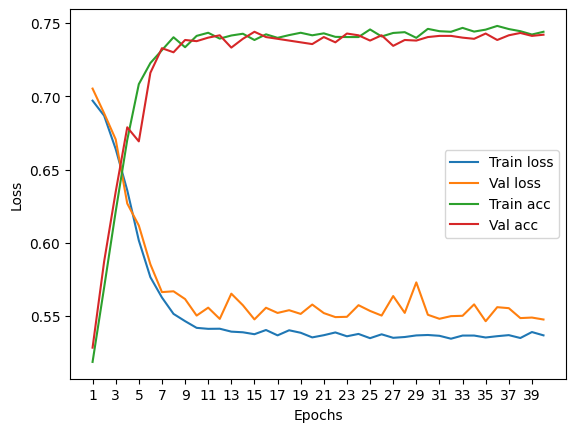

****************************************************************************************************



118it [00:00, 199.12it/s]


Train Epoch: 0 	Loss: 0.696713, Accuracy: 3882/7500 (52%)
Val Epoch: 0 	Loss: 0.704155, Accuracy: 1319/2500 (53%)



118it [00:00, 195.38it/s]


Train Epoch: 1 	Loss: 0.679793, Accuracy: 4586/7500 (61%)
Val Epoch: 1 	Loss: 0.671051, Accuracy: 1637/2500 (65%)



118it [00:00, 171.49it/s]


Train Epoch: 2 	Loss: 0.637981, Accuracy: 5073/7500 (68%)
Val Epoch: 2 	Loss: 0.624515, Accuracy: 1737/2500 (69%)



118it [00:00, 163.12it/s]


Train Epoch: 3 	Loss: 0.597496, Accuracy: 5327/7500 (71%)
Val Epoch: 3 	Loss: 0.589701, Accuracy: 1800/2500 (72%)



118it [00:00, 155.70it/s]


Train Epoch: 4 	Loss: 0.572408, Accuracy: 5474/7500 (73%)
Val Epoch: 4 	Loss: 0.569252, Accuracy: 1799/2500 (72%)



118it [00:00, 198.94it/s]


Train Epoch: 5 	Loss: 0.560781, Accuracy: 5470/7500 (73%)
Val Epoch: 5 	Loss: 0.564163, Accuracy: 1829/2500 (73%)



118it [00:00, 190.43it/s]


Train Epoch: 6 	Loss: 0.554350, Accuracy: 5504/7500 (73%)
Val Epoch: 6 	Loss: 0.552336, Accuracy: 1837/2500 (73%)



118it [00:00, 187.40it/s]


Train Epoch: 7 	Loss: 0.554200, Accuracy: 5494/7500 (73%)
Val Epoch: 7 	Loss: 0.565262, Accuracy: 1826/2500 (73%)



118it [00:00, 199.66it/s]


Train Epoch: 8 	Loss: 0.552137, Accuracy: 5537/7500 (74%)
Val Epoch: 8 	Loss: 0.567040, Accuracy: 1811/2500 (72%)



118it [00:00, 187.52it/s]


Train Epoch: 9 	Loss: 0.552863, Accuracy: 5506/7500 (73%)
Val Epoch: 9 	Loss: 0.552272, Accuracy: 1821/2500 (73%)



118it [00:00, 191.19it/s]


Train Epoch: 10 	Loss: 0.554099, Accuracy: 5533/7500 (74%)
Val Epoch: 10 	Loss: 0.554797, Accuracy: 1834/2500 (73%)



118it [00:00, 160.24it/s]


Train Epoch: 11 	Loss: 0.549719, Accuracy: 5532/7500 (74%)
Val Epoch: 11 	Loss: 0.558246, Accuracy: 1843/2500 (74%)



118it [00:00, 158.75it/s]


Train Epoch: 12 	Loss: 0.547436, Accuracy: 5548/7500 (74%)
Val Epoch: 12 	Loss: 0.548404, Accuracy: 1845/2500 (74%)



118it [00:00, 157.81it/s]


Train Epoch: 13 	Loss: 0.549664, Accuracy: 5543/7500 (74%)
Val Epoch: 13 	Loss: 0.551031, Accuracy: 1829/2500 (73%)



118it [00:00, 175.09it/s]


Train Epoch: 14 	Loss: 0.551116, Accuracy: 5539/7500 (74%)
Val Epoch: 14 	Loss: 0.548620, Accuracy: 1844/2500 (74%)



118it [00:00, 182.09it/s]


Train Epoch: 15 	Loss: 0.547566, Accuracy: 5553/7500 (74%)
Val Epoch: 15 	Loss: 0.553835, Accuracy: 1839/2500 (74%)



118it [00:00, 194.80it/s]


Train Epoch: 16 	Loss: 0.547201, Accuracy: 5551/7500 (74%)
Val Epoch: 16 	Loss: 0.571376, Accuracy: 1813/2500 (73%)



118it [00:00, 198.11it/s]


Train Epoch: 17 	Loss: 0.550029, Accuracy: 5525/7500 (74%)
Val Epoch: 17 	Loss: 0.550892, Accuracy: 1839/2500 (74%)



118it [00:00, 197.83it/s]


Train Epoch: 18 	Loss: 0.549787, Accuracy: 5545/7500 (74%)
Val Epoch: 18 	Loss: 0.560579, Accuracy: 1842/2500 (74%)



118it [00:00, 195.99it/s]


Train Epoch: 19 	Loss: 0.547371, Accuracy: 5569/7500 (74%)
Val Epoch: 19 	Loss: 0.568327, Accuracy: 1822/2500 (73%)



118it [00:00, 189.36it/s]


Train Epoch: 20 	Loss: 0.547988, Accuracy: 5505/7500 (73%)
Val Epoch: 20 	Loss: 0.546394, Accuracy: 1843/2500 (74%)



118it [00:00, 196.53it/s]


Train Epoch: 21 	Loss: 0.548612, Accuracy: 5540/7500 (74%)
Val Epoch: 21 	Loss: 0.548244, Accuracy: 1826/2500 (73%)



118it [00:00, 190.70it/s]


Train Epoch: 22 	Loss: 0.547783, Accuracy: 5550/7500 (74%)
Val Epoch: 22 	Loss: 0.550791, Accuracy: 1842/2500 (74%)



118it [00:00, 191.99it/s]


Train Epoch: 23 	Loss: 0.545449, Accuracy: 5568/7500 (74%)
Val Epoch: 23 	Loss: 0.554038, Accuracy: 1841/2500 (74%)



118it [00:00, 197.39it/s]


Train Epoch: 24 	Loss: 0.547377, Accuracy: 5528/7500 (74%)
Val Epoch: 24 	Loss: 0.544919, Accuracy: 1841/2500 (74%)



118it [00:00, 198.42it/s]


Train Epoch: 25 	Loss: 0.545727, Accuracy: 5550/7500 (74%)
Val Epoch: 25 	Loss: 0.545124, Accuracy: 1838/2500 (74%)



118it [00:00, 197.20it/s]


Train Epoch: 26 	Loss: 0.548280, Accuracy: 5547/7500 (74%)
Val Epoch: 26 	Loss: 0.566689, Accuracy: 1840/2500 (74%)



118it [00:00, 192.22it/s]


Train Epoch: 27 	Loss: 0.549927, Accuracy: 5543/7500 (74%)
Val Epoch: 27 	Loss: 0.551696, Accuracy: 1843/2500 (74%)



118it [00:00, 194.11it/s]


Train Epoch: 28 	Loss: 0.548092, Accuracy: 5559/7500 (74%)
Val Epoch: 28 	Loss: 0.573893, Accuracy: 1832/2500 (73%)



118it [00:00, 194.32it/s]


Train Epoch: 29 	Loss: 0.549506, Accuracy: 5532/7500 (74%)
Val Epoch: 29 	Loss: 0.556324, Accuracy: 1833/2500 (73%)



118it [00:00, 194.79it/s]


Train Epoch: 30 	Loss: 0.547125, Accuracy: 5548/7500 (74%)
Val Epoch: 30 	Loss: 0.549441, Accuracy: 1843/2500 (74%)



118it [00:00, 123.55it/s]


Train Epoch: 31 	Loss: 0.547181, Accuracy: 5564/7500 (74%)
Val Epoch: 31 	Loss: 0.555729, Accuracy: 1833/2500 (73%)



118it [00:00, 159.66it/s]


Train Epoch: 32 	Loss: 0.546762, Accuracy: 5534/7500 (74%)
Val Epoch: 32 	Loss: 0.549664, Accuracy: 1842/2500 (74%)



118it [00:00, 156.34it/s]


Train Epoch: 33 	Loss: 0.547340, Accuracy: 5539/7500 (74%)
Val Epoch: 33 	Loss: 0.554310, Accuracy: 1830/2500 (73%)



118it [00:00, 178.98it/s]


Train Epoch: 34 	Loss: 0.547051, Accuracy: 5567/7500 (74%)
Val Epoch: 34 	Loss: 0.549241, Accuracy: 1836/2500 (73%)



118it [00:00, 193.94it/s]


Train Epoch: 35 	Loss: 0.547269, Accuracy: 5543/7500 (74%)
Val Epoch: 35 	Loss: 0.563849, Accuracy: 1840/2500 (74%)



118it [00:00, 201.09it/s]


Train Epoch: 36 	Loss: 0.546174, Accuracy: 5567/7500 (74%)
Val Epoch: 36 	Loss: 0.553731, Accuracy: 1849/2500 (74%)



118it [00:00, 191.48it/s]


Train Epoch: 37 	Loss: 0.549811, Accuracy: 5542/7500 (74%)
Val Epoch: 37 	Loss: 0.547219, Accuracy: 1839/2500 (74%)



118it [00:00, 190.76it/s]


Train Epoch: 38 	Loss: 0.547530, Accuracy: 5551/7500 (74%)
Val Epoch: 38 	Loss: 0.547138, Accuracy: 1838/2500 (74%)



118it [00:00, 189.46it/s]


Train Epoch: 39 	Loss: 0.548022, Accuracy: 5555/7500 (74%)
Val Epoch: 39 	Loss: 0.551427, Accuracy: 1851/2500 (74%)

Test accuracy:  73.56


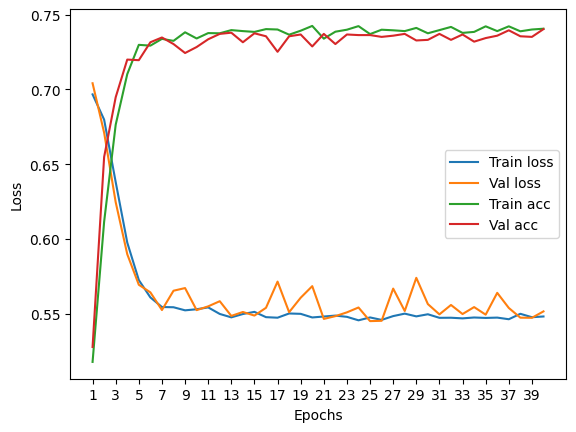

****************************************************************************************************



118it [00:00, 199.58it/s]


Train Epoch: 0 	Loss: 0.696588, Accuracy: 3935/7500 (52%)
Val Epoch: 0 	Loss: 0.705216, Accuracy: 1357/2500 (54%)



118it [00:00, 188.50it/s]


Train Epoch: 1 	Loss: 0.688463, Accuracy: 4173/7500 (56%)
Val Epoch: 1 	Loss: 0.693936, Accuracy: 1481/2500 (59%)



118it [00:00, 187.26it/s]


Train Epoch: 2 	Loss: 0.682615, Accuracy: 4245/7500 (57%)
Val Epoch: 2 	Loss: 0.682487, Accuracy: 1534/2500 (61%)



118it [00:00, 181.04it/s]


Train Epoch: 3 	Loss: 0.666550, Accuracy: 4539/7500 (61%)
Val Epoch: 3 	Loss: 0.658870, Accuracy: 1662/2500 (66%)



118it [00:00, 198.17it/s]


Train Epoch: 4 	Loss: 0.637959, Accuracy: 4968/7500 (66%)
Val Epoch: 4 	Loss: 0.630214, Accuracy: 1738/2500 (70%)



118it [00:00, 198.00it/s]


Train Epoch: 5 	Loss: 0.607027, Accuracy: 5276/7500 (70%)
Val Epoch: 5 	Loss: 0.599503, Accuracy: 1807/2500 (72%)



118it [00:00, 187.46it/s]


Train Epoch: 6 	Loss: 0.581950, Accuracy: 5457/7500 (73%)
Val Epoch: 6 	Loss: 0.574304, Accuracy: 1859/2500 (74%)



118it [00:00, 176.07it/s]


Train Epoch: 7 	Loss: 0.565737, Accuracy: 5464/7500 (73%)
Val Epoch: 7 	Loss: 0.560751, Accuracy: 1850/2500 (74%)



118it [00:00, 178.42it/s]


Train Epoch: 8 	Loss: 0.554306, Accuracy: 5538/7500 (74%)
Val Epoch: 8 	Loss: 0.544985, Accuracy: 1860/2500 (74%)



118it [00:00, 194.69it/s]


Train Epoch: 9 	Loss: 0.547164, Accuracy: 5558/7500 (74%)
Val Epoch: 9 	Loss: 0.541936, Accuracy: 1852/2500 (74%)



118it [00:00, 150.35it/s]


Train Epoch: 10 	Loss: 0.542115, Accuracy: 5541/7500 (74%)
Val Epoch: 10 	Loss: 0.557180, Accuracy: 1823/2500 (73%)



118it [00:00, 118.04it/s]


Train Epoch: 11 	Loss: 0.542581, Accuracy: 5564/7500 (74%)
Val Epoch: 11 	Loss: 0.541731, Accuracy: 1859/2500 (74%)



118it [00:00, 162.01it/s]


Train Epoch: 12 	Loss: 0.541373, Accuracy: 5551/7500 (74%)
Val Epoch: 12 	Loss: 0.539315, Accuracy: 1863/2500 (75%)



118it [00:00, 129.45it/s]


Train Epoch: 13 	Loss: 0.538969, Accuracy: 5566/7500 (74%)
Val Epoch: 13 	Loss: 0.536403, Accuracy: 1863/2500 (75%)



118it [00:00, 176.22it/s]


Train Epoch: 14 	Loss: 0.540591, Accuracy: 5564/7500 (74%)
Val Epoch: 14 	Loss: 0.535729, Accuracy: 1851/2500 (74%)



118it [00:00, 191.13it/s]


Train Epoch: 15 	Loss: 0.538599, Accuracy: 5540/7500 (74%)
Val Epoch: 15 	Loss: 0.539640, Accuracy: 1855/2500 (74%)



118it [00:00, 190.83it/s]


Train Epoch: 16 	Loss: 0.537050, Accuracy: 5590/7500 (75%)
Val Epoch: 16 	Loss: 0.536111, Accuracy: 1866/2500 (75%)



118it [00:00, 193.62it/s]


Train Epoch: 17 	Loss: 0.538627, Accuracy: 5589/7500 (75%)
Val Epoch: 17 	Loss: 0.539627, Accuracy: 1865/2500 (75%)



118it [00:00, 195.54it/s]


Train Epoch: 18 	Loss: 0.539006, Accuracy: 5552/7500 (74%)
Val Epoch: 18 	Loss: 0.553227, Accuracy: 1861/2500 (74%)



118it [00:00, 191.56it/s]


Train Epoch: 19 	Loss: 0.537726, Accuracy: 5588/7500 (75%)
Val Epoch: 19 	Loss: 0.558848, Accuracy: 1866/2500 (75%)



118it [00:00, 196.45it/s]


Train Epoch: 20 	Loss: 0.535049, Accuracy: 5562/7500 (74%)
Val Epoch: 20 	Loss: 0.534824, Accuracy: 1869/2500 (75%)



118it [00:00, 197.54it/s]


Train Epoch: 21 	Loss: 0.535279, Accuracy: 5585/7500 (74%)
Val Epoch: 21 	Loss: 0.537743, Accuracy: 1856/2500 (74%)



118it [00:00, 191.84it/s]


Train Epoch: 22 	Loss: 0.536342, Accuracy: 5581/7500 (74%)
Val Epoch: 22 	Loss: 0.533680, Accuracy: 1864/2500 (75%)



118it [00:00, 192.74it/s]


Train Epoch: 23 	Loss: 0.534706, Accuracy: 5584/7500 (74%)
Val Epoch: 23 	Loss: 0.537376, Accuracy: 1861/2500 (74%)



118it [00:00, 196.25it/s]


Train Epoch: 24 	Loss: 0.535742, Accuracy: 5581/7500 (74%)
Val Epoch: 24 	Loss: 0.540637, Accuracy: 1865/2500 (75%)



118it [00:00, 192.31it/s]


Train Epoch: 25 	Loss: 0.536907, Accuracy: 5588/7500 (75%)
Val Epoch: 25 	Loss: 0.550345, Accuracy: 1872/2500 (75%)



118it [00:00, 182.77it/s]


Train Epoch: 26 	Loss: 0.536146, Accuracy: 5583/7500 (74%)
Val Epoch: 26 	Loss: 0.536992, Accuracy: 1869/2500 (75%)



118it [00:00, 187.76it/s]


Train Epoch: 27 	Loss: 0.536989, Accuracy: 5578/7500 (74%)
Val Epoch: 27 	Loss: 0.552658, Accuracy: 1858/2500 (74%)



118it [00:00, 191.30it/s]


Train Epoch: 28 	Loss: 0.537445, Accuracy: 5573/7500 (74%)
Val Epoch: 28 	Loss: 0.544704, Accuracy: 1857/2500 (74%)



118it [00:00, 170.90it/s]


Train Epoch: 29 	Loss: 0.536622, Accuracy: 5588/7500 (75%)
Val Epoch: 29 	Loss: 0.549875, Accuracy: 1871/2500 (75%)



118it [00:00, 151.82it/s]


Train Epoch: 30 	Loss: 0.535737, Accuracy: 5604/7500 (75%)
Val Epoch: 30 	Loss: 0.541759, Accuracy: 1863/2500 (75%)



118it [00:00, 160.54it/s]


Train Epoch: 31 	Loss: 0.535997, Accuracy: 5602/7500 (75%)
Val Epoch: 31 	Loss: 0.539775, Accuracy: 1853/2500 (74%)



118it [00:00, 170.52it/s]


Train Epoch: 32 	Loss: 0.537385, Accuracy: 5582/7500 (74%)
Val Epoch: 32 	Loss: 0.534686, Accuracy: 1863/2500 (75%)



118it [00:00, 185.18it/s]


Train Epoch: 33 	Loss: 0.535301, Accuracy: 5589/7500 (75%)
Val Epoch: 33 	Loss: 0.538224, Accuracy: 1860/2500 (74%)



118it [00:00, 191.65it/s]


Train Epoch: 34 	Loss: 0.537700, Accuracy: 5567/7500 (74%)
Val Epoch: 34 	Loss: 0.539367, Accuracy: 1857/2500 (74%)



118it [00:00, 195.22it/s]


Train Epoch: 35 	Loss: 0.535607, Accuracy: 5587/7500 (74%)
Val Epoch: 35 	Loss: 0.551015, Accuracy: 1866/2500 (75%)



118it [00:00, 196.92it/s]


Train Epoch: 36 	Loss: 0.537603, Accuracy: 5584/7500 (74%)
Val Epoch: 36 	Loss: 0.536480, Accuracy: 1860/2500 (74%)



118it [00:00, 189.95it/s]


Train Epoch: 37 	Loss: 0.534268, Accuracy: 5609/7500 (75%)
Val Epoch: 37 	Loss: 0.538494, Accuracy: 1872/2500 (75%)



118it [00:00, 188.58it/s]


Train Epoch: 38 	Loss: 0.535974, Accuracy: 5618/7500 (75%)
Val Epoch: 38 	Loss: 0.556765, Accuracy: 1856/2500 (74%)



118it [00:00, 190.41it/s]


Train Epoch: 39 	Loss: 0.535488, Accuracy: 5594/7500 (75%)
Val Epoch: 39 	Loss: 0.540337, Accuracy: 1854/2500 (74%)

Test accuracy:  74.16


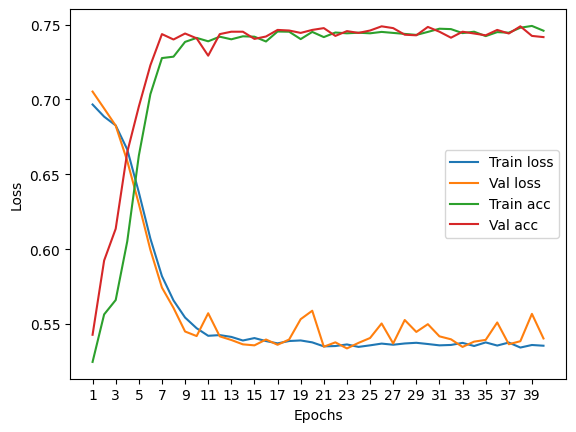

****************************************************************************************************



118it [00:00, 220.60it/s]


Train Epoch: 0 	Loss: 0.696365, Accuracy: 3922/7500 (52%)
Val Epoch: 0 	Loss: 0.701883, Accuracy: 1372/2500 (55%)



118it [00:00, 193.85it/s]


Train Epoch: 1 	Loss: 0.679267, Accuracy: 4440/7500 (59%)
Val Epoch: 1 	Loss: 0.671091, Accuracy: 1632/2500 (65%)



118it [00:00, 186.87it/s]


Train Epoch: 2 	Loss: 0.643243, Accuracy: 4932/7500 (66%)
Val Epoch: 2 	Loss: 0.622997, Accuracy: 1760/2500 (70%)



118it [00:00, 193.21it/s]


Train Epoch: 3 	Loss: 0.603679, Accuracy: 5243/7500 (70%)
Val Epoch: 3 	Loss: 0.600702, Accuracy: 1787/2500 (71%)



118it [00:00, 196.38it/s]


Train Epoch: 4 	Loss: 0.579695, Accuracy: 5349/7500 (71%)
Val Epoch: 4 	Loss: 0.579063, Accuracy: 1827/2500 (73%)



118it [00:00, 189.82it/s]


Train Epoch: 5 	Loss: 0.564766, Accuracy: 5400/7500 (72%)
Val Epoch: 5 	Loss: 0.557816, Accuracy: 1837/2500 (73%)



118it [00:00, 192.87it/s]


Train Epoch: 6 	Loss: 0.555724, Accuracy: 5440/7500 (73%)
Val Epoch: 6 	Loss: 0.565604, Accuracy: 1818/2500 (73%)



118it [00:00, 195.39it/s]


Train Epoch: 7 	Loss: 0.553151, Accuracy: 5438/7500 (73%)
Val Epoch: 7 	Loss: 0.544677, Accuracy: 1850/2500 (74%)



118it [00:00, 194.27it/s]


Train Epoch: 8 	Loss: 0.550624, Accuracy: 5445/7500 (73%)
Val Epoch: 8 	Loss: 0.545667, Accuracy: 1855/2500 (74%)



118it [00:00, 190.82it/s]


Train Epoch: 9 	Loss: 0.549683, Accuracy: 5491/7500 (73%)
Val Epoch: 9 	Loss: 0.553563, Accuracy: 1851/2500 (74%)



118it [00:00, 172.64it/s]


Train Epoch: 10 	Loss: 0.548999, Accuracy: 5451/7500 (73%)
Val Epoch: 10 	Loss: 0.542660, Accuracy: 1852/2500 (74%)



118it [00:00, 145.46it/s]


Train Epoch: 11 	Loss: 0.549642, Accuracy: 5456/7500 (73%)
Val Epoch: 11 	Loss: 0.544932, Accuracy: 1845/2500 (74%)



118it [00:00, 161.80it/s]


Train Epoch: 12 	Loss: 0.548289, Accuracy: 5498/7500 (73%)
Val Epoch: 12 	Loss: 0.557621, Accuracy: 1844/2500 (74%)



118it [00:00, 176.25it/s]


Train Epoch: 13 	Loss: 0.552080, Accuracy: 5466/7500 (73%)
Val Epoch: 13 	Loss: 0.547019, Accuracy: 1842/2500 (74%)



118it [00:00, 190.27it/s]


Train Epoch: 14 	Loss: 0.546804, Accuracy: 5490/7500 (73%)
Val Epoch: 14 	Loss: 0.553330, Accuracy: 1847/2500 (74%)



118it [00:00, 191.99it/s]


Train Epoch: 15 	Loss: 0.546636, Accuracy: 5475/7500 (73%)
Val Epoch: 15 	Loss: 0.559619, Accuracy: 1828/2500 (73%)



118it [00:00, 192.34it/s]


Train Epoch: 16 	Loss: 0.548558, Accuracy: 5497/7500 (73%)
Val Epoch: 16 	Loss: 0.558488, Accuracy: 1849/2500 (74%)



118it [00:00, 194.40it/s]


Train Epoch: 17 	Loss: 0.545976, Accuracy: 5503/7500 (73%)
Val Epoch: 17 	Loss: 0.552660, Accuracy: 1845/2500 (74%)



118it [00:00, 192.16it/s]


Train Epoch: 18 	Loss: 0.546064, Accuracy: 5456/7500 (73%)
Val Epoch: 18 	Loss: 0.547226, Accuracy: 1852/2500 (74%)



118it [00:00, 189.65it/s]


Train Epoch: 19 	Loss: 0.548343, Accuracy: 5483/7500 (73%)
Val Epoch: 19 	Loss: 0.559213, Accuracy: 1853/2500 (74%)



118it [00:00, 195.36it/s]


Train Epoch: 20 	Loss: 0.546796, Accuracy: 5484/7500 (73%)
Val Epoch: 20 	Loss: 0.547161, Accuracy: 1852/2500 (74%)



118it [00:00, 185.78it/s]


Train Epoch: 21 	Loss: 0.547516, Accuracy: 5482/7500 (73%)
Val Epoch: 21 	Loss: 0.553204, Accuracy: 1833/2500 (73%)



118it [00:00, 190.97it/s]


Train Epoch: 22 	Loss: 0.547364, Accuracy: 5486/7500 (73%)
Val Epoch: 22 	Loss: 0.545907, Accuracy: 1852/2500 (74%)



118it [00:00, 194.04it/s]


Train Epoch: 23 	Loss: 0.547712, Accuracy: 5489/7500 (73%)
Val Epoch: 23 	Loss: 0.548220, Accuracy: 1854/2500 (74%)



118it [00:00, 192.42it/s]


Train Epoch: 24 	Loss: 0.547679, Accuracy: 5500/7500 (73%)
Val Epoch: 24 	Loss: 0.548722, Accuracy: 1855/2500 (74%)



118it [00:00, 191.23it/s]


Train Epoch: 25 	Loss: 0.545983, Accuracy: 5459/7500 (73%)
Val Epoch: 25 	Loss: 0.543085, Accuracy: 1857/2500 (74%)



118it [00:00, 167.31it/s]


Train Epoch: 26 	Loss: 0.544054, Accuracy: 5485/7500 (73%)
Val Epoch: 26 	Loss: 0.548550, Accuracy: 1841/2500 (74%)



118it [00:00, 177.84it/s]


Train Epoch: 27 	Loss: 0.547779, Accuracy: 5496/7500 (73%)
Val Epoch: 27 	Loss: 0.556548, Accuracy: 1843/2500 (74%)



118it [00:00, 183.79it/s]


Train Epoch: 28 	Loss: 0.545009, Accuracy: 5473/7500 (73%)
Val Epoch: 28 	Loss: 0.569991, Accuracy: 1800/2500 (72%)



118it [00:00, 193.86it/s]


Train Epoch: 29 	Loss: 0.547414, Accuracy: 5484/7500 (73%)
Val Epoch: 29 	Loss: 0.544182, Accuracy: 1846/2500 (74%)



118it [00:00, 150.14it/s]


Train Epoch: 30 	Loss: 0.544769, Accuracy: 5478/7500 (73%)
Val Epoch: 30 	Loss: 0.548484, Accuracy: 1853/2500 (74%)



118it [00:00, 172.46it/s]


Train Epoch: 31 	Loss: 0.545954, Accuracy: 5470/7500 (73%)
Val Epoch: 31 	Loss: 0.548984, Accuracy: 1850/2500 (74%)



118it [00:00, 160.92it/s]


Train Epoch: 32 	Loss: 0.547128, Accuracy: 5478/7500 (73%)
Val Epoch: 32 	Loss: 0.556058, Accuracy: 1840/2500 (74%)



118it [00:00, 185.02it/s]


Train Epoch: 33 	Loss: 0.545530, Accuracy: 5487/7500 (73%)
Val Epoch: 33 	Loss: 0.543045, Accuracy: 1855/2500 (74%)



118it [00:00, 189.96it/s]


Train Epoch: 34 	Loss: 0.544578, Accuracy: 5471/7500 (73%)
Val Epoch: 34 	Loss: 0.542007, Accuracy: 1843/2500 (74%)



118it [00:00, 188.87it/s]


Train Epoch: 35 	Loss: 0.545166, Accuracy: 5479/7500 (73%)
Val Epoch: 35 	Loss: 0.549310, Accuracy: 1842/2500 (74%)



118it [00:00, 196.50it/s]


Train Epoch: 36 	Loss: 0.545114, Accuracy: 5464/7500 (73%)
Val Epoch: 36 	Loss: 0.549364, Accuracy: 1853/2500 (74%)



118it [00:00, 191.47it/s]


Train Epoch: 37 	Loss: 0.548865, Accuracy: 5491/7500 (73%)
Val Epoch: 37 	Loss: 0.551793, Accuracy: 1849/2500 (74%)



118it [00:00, 193.58it/s]


Train Epoch: 38 	Loss: 0.545543, Accuracy: 5474/7500 (73%)
Val Epoch: 38 	Loss: 0.557502, Accuracy: 1847/2500 (74%)



118it [00:00, 190.46it/s]


Train Epoch: 39 	Loss: 0.547311, Accuracy: 5462/7500 (73%)
Val Epoch: 39 	Loss: 0.547249, Accuracy: 1852/2500 (74%)

Test accuracy:  74.32


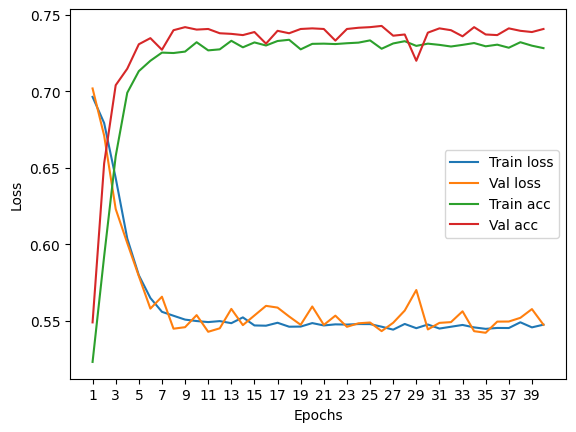

****************************************************************************************************



118it [00:00, 212.39it/s]


Train Epoch: 0 	Loss: 0.698709, Accuracy: 3727/7500 (50%)
Val Epoch: 0 	Loss: 0.708626, Accuracy: 1327/2500 (53%)



118it [00:00, 140.32it/s]


Train Epoch: 1 	Loss: 0.692708, Accuracy: 4120/7500 (55%)
Val Epoch: 1 	Loss: 0.699686, Accuracy: 1470/2500 (59%)



118it [00:00, 169.04it/s]


Train Epoch: 2 	Loss: 0.675959, Accuracy: 4476/7500 (60%)
Val Epoch: 2 	Loss: 0.684334, Accuracy: 1539/2500 (62%)



118it [00:00, 179.75it/s]


Train Epoch: 3 	Loss: 0.645578, Accuracy: 4835/7500 (64%)
Val Epoch: 3 	Loss: 0.644950, Accuracy: 1641/2500 (66%)



118it [00:00, 173.39it/s]


Train Epoch: 4 	Loss: 0.610291, Accuracy: 5201/7500 (69%)
Val Epoch: 4 	Loss: 0.610856, Accuracy: 1749/2500 (70%)



118it [00:00, 186.29it/s]


Train Epoch: 5 	Loss: 0.578882, Accuracy: 5462/7500 (73%)
Val Epoch: 5 	Loss: 0.595898, Accuracy: 1772/2500 (71%)



118it [00:00, 194.64it/s]


Train Epoch: 6 	Loss: 0.561185, Accuracy: 5481/7500 (73%)
Val Epoch: 6 	Loss: 0.583391, Accuracy: 1782/2500 (71%)



118it [00:00, 191.93it/s]


Train Epoch: 7 	Loss: 0.552899, Accuracy: 5529/7500 (74%)
Val Epoch: 7 	Loss: 0.569142, Accuracy: 1814/2500 (73%)



118it [00:00, 187.76it/s]


Train Epoch: 8 	Loss: 0.546176, Accuracy: 5528/7500 (74%)
Val Epoch: 8 	Loss: 0.569220, Accuracy: 1808/2500 (72%)



118it [00:00, 184.02it/s]


Train Epoch: 9 	Loss: 0.546622, Accuracy: 5538/7500 (74%)
Val Epoch: 9 	Loss: 0.569216, Accuracy: 1800/2500 (72%)



118it [00:00, 195.42it/s]


Train Epoch: 10 	Loss: 0.545101, Accuracy: 5511/7500 (73%)
Val Epoch: 10 	Loss: 0.565424, Accuracy: 1822/2500 (73%)



118it [00:00, 156.92it/s]


Train Epoch: 11 	Loss: 0.544135, Accuracy: 5556/7500 (74%)
Val Epoch: 11 	Loss: 0.578161, Accuracy: 1801/2500 (72%)



118it [00:00, 158.29it/s]


Train Epoch: 12 	Loss: 0.541192, Accuracy: 5557/7500 (74%)
Val Epoch: 12 	Loss: 0.561610, Accuracy: 1818/2500 (73%)



118it [00:00, 158.17it/s]


Train Epoch: 13 	Loss: 0.539360, Accuracy: 5535/7500 (74%)
Val Epoch: 13 	Loss: 0.569630, Accuracy: 1810/2500 (72%)



118it [00:00, 185.34it/s]


Train Epoch: 14 	Loss: 0.541849, Accuracy: 5552/7500 (74%)
Val Epoch: 14 	Loss: 0.561126, Accuracy: 1811/2500 (72%)



118it [00:00, 191.26it/s]


Train Epoch: 15 	Loss: 0.539101, Accuracy: 5546/7500 (74%)
Val Epoch: 15 	Loss: 0.572278, Accuracy: 1819/2500 (73%)



118it [00:00, 195.42it/s]


Train Epoch: 16 	Loss: 0.539478, Accuracy: 5580/7500 (74%)
Val Epoch: 16 	Loss: 0.582359, Accuracy: 1787/2500 (71%)



118it [00:00, 188.93it/s]


Train Epoch: 17 	Loss: 0.538552, Accuracy: 5571/7500 (74%)
Val Epoch: 17 	Loss: 0.575851, Accuracy: 1817/2500 (73%)



118it [00:00, 190.32it/s]


Train Epoch: 18 	Loss: 0.539578, Accuracy: 5558/7500 (74%)
Val Epoch: 18 	Loss: 0.562455, Accuracy: 1816/2500 (73%)



118it [00:00, 191.26it/s]


Train Epoch: 19 	Loss: 0.538140, Accuracy: 5559/7500 (74%)
Val Epoch: 19 	Loss: 0.562083, Accuracy: 1814/2500 (73%)



118it [00:00, 190.41it/s]


Train Epoch: 20 	Loss: 0.537564, Accuracy: 5570/7500 (74%)
Val Epoch: 20 	Loss: 0.575418, Accuracy: 1819/2500 (73%)



118it [00:00, 194.68it/s]


Train Epoch: 21 	Loss: 0.537460, Accuracy: 5583/7500 (74%)
Val Epoch: 21 	Loss: 0.559668, Accuracy: 1815/2500 (73%)



118it [00:00, 190.23it/s]


Train Epoch: 22 	Loss: 0.537526, Accuracy: 5539/7500 (74%)
Val Epoch: 22 	Loss: 0.558410, Accuracy: 1812/2500 (72%)



118it [00:00, 196.71it/s]


Train Epoch: 23 	Loss: 0.538188, Accuracy: 5567/7500 (74%)
Val Epoch: 23 	Loss: 0.570190, Accuracy: 1805/2500 (72%)



118it [00:00, 193.61it/s]


Train Epoch: 24 	Loss: 0.539025, Accuracy: 5544/7500 (74%)
Val Epoch: 24 	Loss: 0.562339, Accuracy: 1820/2500 (73%)



118it [00:00, 191.87it/s]


Train Epoch: 25 	Loss: 0.537709, Accuracy: 5550/7500 (74%)
Val Epoch: 25 	Loss: 0.556591, Accuracy: 1822/2500 (73%)



118it [00:00, 190.88it/s]


Train Epoch: 26 	Loss: 0.539050, Accuracy: 5563/7500 (74%)
Val Epoch: 26 	Loss: 0.567242, Accuracy: 1808/2500 (72%)



118it [00:00, 194.59it/s]


Train Epoch: 27 	Loss: 0.538556, Accuracy: 5558/7500 (74%)
Val Epoch: 27 	Loss: 0.563352, Accuracy: 1810/2500 (72%)



118it [00:00, 193.49it/s]


Train Epoch: 28 	Loss: 0.535894, Accuracy: 5548/7500 (74%)
Val Epoch: 28 	Loss: 0.566559, Accuracy: 1813/2500 (73%)



118it [00:00, 191.17it/s]


Train Epoch: 29 	Loss: 0.538662, Accuracy: 5564/7500 (74%)
Val Epoch: 29 	Loss: 0.567625, Accuracy: 1805/2500 (72%)



118it [00:00, 192.67it/s]


Train Epoch: 30 	Loss: 0.537402, Accuracy: 5557/7500 (74%)
Val Epoch: 30 	Loss: 0.559851, Accuracy: 1815/2500 (73%)



118it [00:00, 143.45it/s]


Train Epoch: 31 	Loss: 0.534836, Accuracy: 5564/7500 (74%)
Val Epoch: 31 	Loss: 0.564689, Accuracy: 1808/2500 (72%)



118it [00:00, 160.80it/s]


Train Epoch: 32 	Loss: 0.536263, Accuracy: 5559/7500 (74%)
Val Epoch: 32 	Loss: 0.561756, Accuracy: 1801/2500 (72%)



118it [00:00, 151.22it/s]


Train Epoch: 33 	Loss: 0.539100, Accuracy: 5539/7500 (74%)
Val Epoch: 33 	Loss: 0.560415, Accuracy: 1799/2500 (72%)



118it [00:00, 167.74it/s]


Train Epoch: 34 	Loss: 0.535016, Accuracy: 5568/7500 (74%)
Val Epoch: 34 	Loss: 0.567480, Accuracy: 1815/2500 (73%)



118it [00:00, 178.00it/s]


Train Epoch: 35 	Loss: 0.536263, Accuracy: 5575/7500 (74%)
Val Epoch: 35 	Loss: 0.563146, Accuracy: 1807/2500 (72%)



118it [00:00, 194.63it/s]


Train Epoch: 36 	Loss: 0.532573, Accuracy: 5563/7500 (74%)
Val Epoch: 36 	Loss: 0.563156, Accuracy: 1814/2500 (73%)



118it [00:00, 179.75it/s]


Train Epoch: 37 	Loss: 0.533778, Accuracy: 5571/7500 (74%)
Val Epoch: 37 	Loss: 0.560480, Accuracy: 1822/2500 (73%)



118it [00:00, 196.56it/s]


Train Epoch: 38 	Loss: 0.532227, Accuracy: 5574/7500 (74%)
Val Epoch: 38 	Loss: 0.559958, Accuracy: 1804/2500 (72%)



118it [00:00, 184.61it/s]


Train Epoch: 39 	Loss: 0.535899, Accuracy: 5570/7500 (74%)
Val Epoch: 39 	Loss: 0.565102, Accuracy: 1807/2500 (72%)

Test accuracy:  73.68


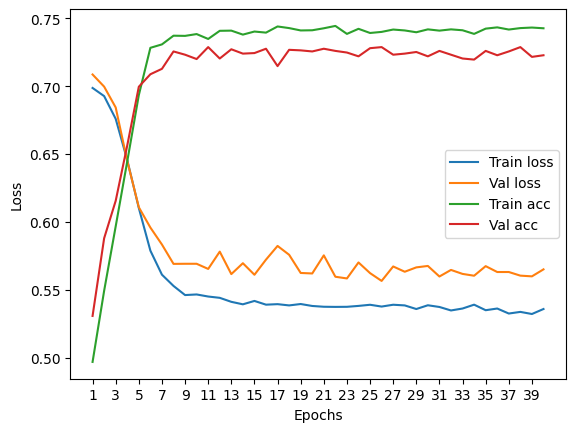

****************************************************************************************************



118it [00:00, 206.70it/s]


Train Epoch: 0 	Loss: 0.696030, Accuracy: 3952/7500 (53%)
Val Epoch: 0 	Loss: 0.703767, Accuracy: 1372/2500 (55%)



118it [00:00, 195.15it/s]


Train Epoch: 1 	Loss: 0.687726, Accuracy: 4219/7500 (56%)
Val Epoch: 1 	Loss: 0.697210, Accuracy: 1396/2500 (56%)



118it [00:00, 174.05it/s]


Train Epoch: 2 	Loss: 0.683171, Accuracy: 4279/7500 (57%)
Val Epoch: 2 	Loss: 0.698982, Accuracy: 1389/2500 (56%)



118it [00:00, 183.17it/s]


Train Epoch: 3 	Loss: 0.681173, Accuracy: 4295/7500 (57%)
Val Epoch: 3 	Loss: 0.694698, Accuracy: 1416/2500 (57%)



118it [00:00, 194.97it/s]


Train Epoch: 4 	Loss: 0.676694, Accuracy: 4373/7500 (58%)
Val Epoch: 4 	Loss: 0.686651, Accuracy: 1437/2500 (57%)



118it [00:00, 166.68it/s]


Train Epoch: 5 	Loss: 0.663576, Accuracy: 4539/7500 (61%)
Val Epoch: 5 	Loss: 0.674745, Accuracy: 1495/2500 (60%)



118it [00:00, 174.76it/s]


Train Epoch: 6 	Loss: 0.632196, Accuracy: 5010/7500 (67%)
Val Epoch: 6 	Loss: 0.629950, Accuracy: 1673/2500 (67%)



118it [00:00, 198.01it/s]


Train Epoch: 7 	Loss: 0.602151, Accuracy: 5276/7500 (70%)
Val Epoch: 7 	Loss: 0.605522, Accuracy: 1768/2500 (71%)



118it [00:00, 192.85it/s]


Train Epoch: 8 	Loss: 0.580601, Accuracy: 5359/7500 (71%)
Val Epoch: 8 	Loss: 0.598878, Accuracy: 1757/2500 (70%)



118it [00:00, 198.06it/s]


Train Epoch: 9 	Loss: 0.566932, Accuracy: 5451/7500 (73%)
Val Epoch: 9 	Loss: 0.582114, Accuracy: 1802/2500 (72%)



118it [00:00, 190.48it/s]


Train Epoch: 10 	Loss: 0.559315, Accuracy: 5465/7500 (73%)
Val Epoch: 10 	Loss: 0.577609, Accuracy: 1805/2500 (72%)



118it [00:00, 142.02it/s]


Train Epoch: 11 	Loss: 0.556046, Accuracy: 5478/7500 (73%)
Val Epoch: 11 	Loss: 0.566041, Accuracy: 1807/2500 (72%)



118it [00:00, 167.05it/s]


Train Epoch: 12 	Loss: 0.553131, Accuracy: 5482/7500 (73%)
Val Epoch: 12 	Loss: 0.560250, Accuracy: 1820/2500 (73%)



118it [00:00, 157.01it/s]


Train Epoch: 13 	Loss: 0.551420, Accuracy: 5473/7500 (73%)
Val Epoch: 13 	Loss: 0.569670, Accuracy: 1822/2500 (73%)



118it [00:00, 178.17it/s]


Train Epoch: 14 	Loss: 0.552106, Accuracy: 5483/7500 (73%)
Val Epoch: 14 	Loss: 0.567301, Accuracy: 1814/2500 (73%)



118it [00:00, 192.82it/s]


Train Epoch: 15 	Loss: 0.547824, Accuracy: 5499/7500 (73%)
Val Epoch: 15 	Loss: 0.580055, Accuracy: 1820/2500 (73%)



118it [00:00, 169.56it/s]


Train Epoch: 16 	Loss: 0.548201, Accuracy: 5496/7500 (73%)
Val Epoch: 16 	Loss: 0.558964, Accuracy: 1822/2500 (73%)



118it [00:00, 176.75it/s]


Train Epoch: 17 	Loss: 0.549357, Accuracy: 5516/7500 (74%)
Val Epoch: 17 	Loss: 0.554751, Accuracy: 1841/2500 (74%)



118it [00:00, 193.50it/s]


Train Epoch: 18 	Loss: 0.549027, Accuracy: 5483/7500 (73%)
Val Epoch: 18 	Loss: 0.571197, Accuracy: 1824/2500 (73%)



118it [00:00, 187.23it/s]


Train Epoch: 19 	Loss: 0.547914, Accuracy: 5506/7500 (73%)
Val Epoch: 19 	Loss: 0.559839, Accuracy: 1827/2500 (73%)



118it [00:00, 194.34it/s]


Train Epoch: 20 	Loss: 0.547964, Accuracy: 5515/7500 (74%)
Val Epoch: 20 	Loss: 0.561873, Accuracy: 1830/2500 (73%)



118it [00:00, 196.84it/s]


Train Epoch: 21 	Loss: 0.549678, Accuracy: 5511/7500 (73%)
Val Epoch: 21 	Loss: 0.557793, Accuracy: 1832/2500 (73%)



118it [00:00, 195.21it/s]


Train Epoch: 22 	Loss: 0.547903, Accuracy: 5486/7500 (73%)
Val Epoch: 22 	Loss: 0.551035, Accuracy: 1843/2500 (74%)



118it [00:00, 197.00it/s]


Train Epoch: 23 	Loss: 0.548361, Accuracy: 5517/7500 (74%)
Val Epoch: 23 	Loss: 0.558806, Accuracy: 1843/2500 (74%)



118it [00:00, 176.55it/s]


Train Epoch: 24 	Loss: 0.549201, Accuracy: 5517/7500 (74%)
Val Epoch: 24 	Loss: 0.559068, Accuracy: 1843/2500 (74%)



118it [00:00, 160.03it/s]


Train Epoch: 25 	Loss: 0.546929, Accuracy: 5508/7500 (73%)
Val Epoch: 25 	Loss: 0.566323, Accuracy: 1829/2500 (73%)



118it [00:00, 157.07it/s]


Train Epoch: 26 	Loss: 0.549288, Accuracy: 5488/7500 (73%)
Val Epoch: 26 	Loss: 0.552647, Accuracy: 1850/2500 (74%)



118it [00:00, 171.86it/s]


Train Epoch: 27 	Loss: 0.548912, Accuracy: 5497/7500 (73%)
Val Epoch: 27 	Loss: 0.559892, Accuracy: 1841/2500 (74%)



118it [00:00, 169.91it/s]


Train Epoch: 28 	Loss: 0.550702, Accuracy: 5497/7500 (73%)
Val Epoch: 28 	Loss: 0.551701, Accuracy: 1838/2500 (74%)



118it [00:00, 183.99it/s]


Train Epoch: 29 	Loss: 0.546706, Accuracy: 5520/7500 (74%)
Val Epoch: 29 	Loss: 0.561039, Accuracy: 1841/2500 (74%)



118it [00:00, 127.09it/s]


Train Epoch: 30 	Loss: 0.549004, Accuracy: 5508/7500 (73%)
Val Epoch: 30 	Loss: 0.553094, Accuracy: 1829/2500 (73%)



118it [00:00, 152.52it/s]


Train Epoch: 31 	Loss: 0.546220, Accuracy: 5524/7500 (74%)
Val Epoch: 31 	Loss: 0.564658, Accuracy: 1820/2500 (73%)



118it [00:00, 168.52it/s]


Train Epoch: 32 	Loss: 0.548562, Accuracy: 5514/7500 (74%)
Val Epoch: 32 	Loss: 0.561042, Accuracy: 1836/2500 (73%)



118it [00:00, 142.88it/s]


Train Epoch: 33 	Loss: 0.547183, Accuracy: 5525/7500 (74%)
Val Epoch: 33 	Loss: 0.566109, Accuracy: 1847/2500 (74%)



118it [00:01, 103.76it/s]


Train Epoch: 34 	Loss: 0.549243, Accuracy: 5477/7500 (73%)
Val Epoch: 34 	Loss: 0.572808, Accuracy: 1836/2500 (73%)



118it [00:01, 95.67it/s] 


Train Epoch: 35 	Loss: 0.546223, Accuracy: 5507/7500 (73%)
Val Epoch: 35 	Loss: 0.556749, Accuracy: 1826/2500 (73%)



118it [00:01, 108.51it/s]


Train Epoch: 36 	Loss: 0.548695, Accuracy: 5524/7500 (74%)
Val Epoch: 36 	Loss: 0.567232, Accuracy: 1837/2500 (73%)



118it [00:00, 140.92it/s]


Train Epoch: 37 	Loss: 0.548943, Accuracy: 5498/7500 (73%)
Val Epoch: 37 	Loss: 0.552368, Accuracy: 1839/2500 (74%)



118it [00:00, 196.87it/s]


Train Epoch: 38 	Loss: 0.549890, Accuracy: 5502/7500 (73%)
Val Epoch: 38 	Loss: 0.553454, Accuracy: 1838/2500 (74%)



118it [00:00, 194.51it/s]


Train Epoch: 39 	Loss: 0.545739, Accuracy: 5508/7500 (73%)
Val Epoch: 39 	Loss: 0.569581, Accuracy: 1835/2500 (73%)

Test accuracy:  73.83999999999999


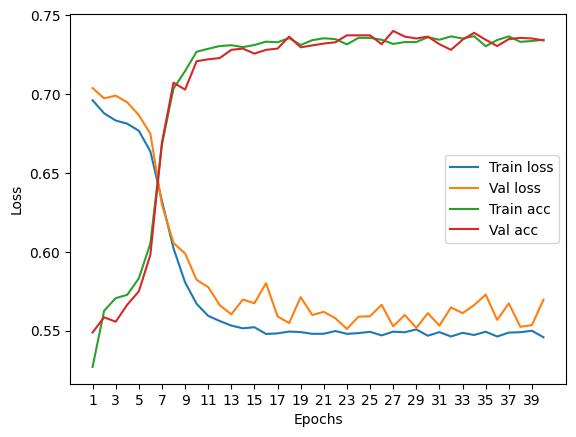

****************************************************************************************************



118it [00:00, 214.02it/s]


Train Epoch: 0 	Loss: 0.695673, Accuracy: 3974/7500 (53%)
Val Epoch: 0 	Loss: 0.701718, Accuracy: 1452/2500 (58%)



118it [00:00, 195.21it/s]


Train Epoch: 1 	Loss: 0.687262, Accuracy: 4294/7500 (57%)
Val Epoch: 1 	Loss: 0.694520, Accuracy: 1416/2500 (57%)



118it [00:00, 183.65it/s]


Train Epoch: 2 	Loss: 0.673827, Accuracy: 4509/7500 (60%)
Val Epoch: 2 	Loss: 0.672079, Accuracy: 1591/2500 (64%)



118it [00:00, 193.90it/s]


Train Epoch: 3 	Loss: 0.646906, Accuracy: 4892/7500 (65%)
Val Epoch: 3 	Loss: 0.635150, Accuracy: 1712/2500 (68%)



118it [00:00, 191.67it/s]


Train Epoch: 4 	Loss: 0.610737, Accuracy: 5250/7500 (70%)
Val Epoch: 4 	Loss: 0.602195, Accuracy: 1765/2500 (71%)



118it [00:00, 194.26it/s]


Train Epoch: 5 	Loss: 0.577875, Accuracy: 5426/7500 (72%)
Val Epoch: 5 	Loss: 0.587166, Accuracy: 1759/2500 (70%)



118it [00:00, 156.40it/s]


Train Epoch: 6 	Loss: 0.568222, Accuracy: 5416/7500 (72%)
Val Epoch: 6 	Loss: 0.569726, Accuracy: 1814/2500 (73%)



118it [00:00, 152.85it/s]


Train Epoch: 7 	Loss: 0.554516, Accuracy: 5505/7500 (73%)
Val Epoch: 7 	Loss: 0.555355, Accuracy: 1827/2500 (73%)



118it [00:00, 157.08it/s]


Train Epoch: 8 	Loss: 0.552434, Accuracy: 5494/7500 (73%)
Val Epoch: 8 	Loss: 0.561961, Accuracy: 1816/2500 (73%)



118it [00:00, 171.87it/s]


Train Epoch: 9 	Loss: 0.551495, Accuracy: 5510/7500 (73%)
Val Epoch: 9 	Loss: 0.572092, Accuracy: 1797/2500 (72%)



118it [00:00, 192.70it/s]


Train Epoch: 10 	Loss: 0.551349, Accuracy: 5510/7500 (73%)
Val Epoch: 10 	Loss: 0.553861, Accuracy: 1835/2500 (73%)



118it [00:00, 199.14it/s]


Train Epoch: 11 	Loss: 0.548177, Accuracy: 5534/7500 (74%)
Val Epoch: 11 	Loss: 0.554632, Accuracy: 1834/2500 (73%)



118it [00:00, 194.70it/s]


Train Epoch: 12 	Loss: 0.547423, Accuracy: 5538/7500 (74%)
Val Epoch: 12 	Loss: 0.547347, Accuracy: 1827/2500 (73%)



118it [00:00, 184.48it/s]


Train Epoch: 13 	Loss: 0.547125, Accuracy: 5513/7500 (74%)
Val Epoch: 13 	Loss: 0.561415, Accuracy: 1822/2500 (73%)



118it [00:00, 180.04it/s]


Train Epoch: 14 	Loss: 0.551654, Accuracy: 5482/7500 (73%)
Val Epoch: 14 	Loss: 0.557909, Accuracy: 1810/2500 (72%)



118it [00:00, 183.33it/s]


Train Epoch: 15 	Loss: 0.548454, Accuracy: 5532/7500 (74%)
Val Epoch: 15 	Loss: 0.554238, Accuracy: 1835/2500 (73%)



118it [00:00, 176.86it/s]


Train Epoch: 16 	Loss: 0.546169, Accuracy: 5546/7500 (74%)
Val Epoch: 16 	Loss: 0.548201, Accuracy: 1832/2500 (73%)



118it [00:00, 190.99it/s]


Train Epoch: 17 	Loss: 0.545695, Accuracy: 5520/7500 (74%)
Val Epoch: 17 	Loss: 0.556597, Accuracy: 1837/2500 (73%)



118it [00:00, 190.01it/s]


Train Epoch: 18 	Loss: 0.547728, Accuracy: 5503/7500 (73%)
Val Epoch: 18 	Loss: 0.556526, Accuracy: 1813/2500 (73%)



118it [00:00, 191.77it/s]


Train Epoch: 19 	Loss: 0.550694, Accuracy: 5535/7500 (74%)
Val Epoch: 19 	Loss: 0.559891, Accuracy: 1825/2500 (73%)



118it [00:00, 193.76it/s]


Train Epoch: 20 	Loss: 0.547447, Accuracy: 5523/7500 (74%)
Val Epoch: 20 	Loss: 0.553843, Accuracy: 1831/2500 (73%)



118it [00:00, 190.63it/s]


Train Epoch: 21 	Loss: 0.547249, Accuracy: 5520/7500 (74%)
Val Epoch: 21 	Loss: 0.557419, Accuracy: 1830/2500 (73%)



118it [00:00, 195.33it/s]


Train Epoch: 22 	Loss: 0.548637, Accuracy: 5529/7500 (74%)
Val Epoch: 22 	Loss: 0.561938, Accuracy: 1845/2500 (74%)



118it [00:00, 195.64it/s]


Train Epoch: 23 	Loss: 0.547278, Accuracy: 5535/7500 (74%)
Val Epoch: 23 	Loss: 0.552027, Accuracy: 1839/2500 (74%)



118it [00:00, 194.36it/s]


Train Epoch: 24 	Loss: 0.548851, Accuracy: 5514/7500 (74%)
Val Epoch: 24 	Loss: 0.558035, Accuracy: 1826/2500 (73%)



118it [00:00, 176.65it/s]


Train Epoch: 25 	Loss: 0.548482, Accuracy: 5545/7500 (74%)
Val Epoch: 25 	Loss: 0.554237, Accuracy: 1822/2500 (73%)



118it [00:00, 147.29it/s]


Train Epoch: 26 	Loss: 0.545654, Accuracy: 5552/7500 (74%)
Val Epoch: 26 	Loss: 0.557628, Accuracy: 1841/2500 (74%)



118it [00:00, 125.57it/s]


Train Epoch: 27 	Loss: 0.546959, Accuracy: 5531/7500 (74%)
Val Epoch: 27 	Loss: 0.558259, Accuracy: 1824/2500 (73%)



118it [00:00, 168.38it/s]


Train Epoch: 28 	Loss: 0.545920, Accuracy: 5539/7500 (74%)
Val Epoch: 28 	Loss: 0.550704, Accuracy: 1833/2500 (73%)



118it [00:00, 180.09it/s]


Train Epoch: 29 	Loss: 0.547898, Accuracy: 5531/7500 (74%)
Val Epoch: 29 	Loss: 0.562028, Accuracy: 1830/2500 (73%)



118it [00:00, 186.01it/s]


Train Epoch: 30 	Loss: 0.544456, Accuracy: 5529/7500 (74%)
Val Epoch: 30 	Loss: 0.548304, Accuracy: 1838/2500 (74%)



118it [00:00, 194.65it/s]


Train Epoch: 31 	Loss: 0.546167, Accuracy: 5558/7500 (74%)
Val Epoch: 31 	Loss: 0.553479, Accuracy: 1825/2500 (73%)



118it [00:00, 197.26it/s]


Train Epoch: 32 	Loss: 0.545464, Accuracy: 5544/7500 (74%)
Val Epoch: 32 	Loss: 0.551724, Accuracy: 1831/2500 (73%)



118it [00:00, 190.00it/s]


Train Epoch: 33 	Loss: 0.545848, Accuracy: 5526/7500 (74%)
Val Epoch: 33 	Loss: 0.554639, Accuracy: 1830/2500 (73%)



118it [00:00, 194.07it/s]


Train Epoch: 34 	Loss: 0.547474, Accuracy: 5544/7500 (74%)
Val Epoch: 34 	Loss: 0.571336, Accuracy: 1839/2500 (74%)



118it [00:00, 195.95it/s]


Train Epoch: 35 	Loss: 0.548006, Accuracy: 5538/7500 (74%)
Val Epoch: 35 	Loss: 0.549610, Accuracy: 1832/2500 (73%)



118it [00:00, 178.58it/s]


Train Epoch: 36 	Loss: 0.546046, Accuracy: 5565/7500 (74%)
Val Epoch: 36 	Loss: 0.550171, Accuracy: 1828/2500 (73%)



118it [00:00, 195.76it/s]


Train Epoch: 37 	Loss: 0.544607, Accuracy: 5545/7500 (74%)
Val Epoch: 37 	Loss: 0.565334, Accuracy: 1848/2500 (74%)



118it [00:00, 185.64it/s]


Train Epoch: 38 	Loss: 0.545485, Accuracy: 5543/7500 (74%)
Val Epoch: 38 	Loss: 0.552037, Accuracy: 1814/2500 (73%)



118it [00:00, 197.47it/s]


Train Epoch: 39 	Loss: 0.548387, Accuracy: 5526/7500 (74%)
Val Epoch: 39 	Loss: 0.554434, Accuracy: 1827/2500 (73%)

Test accuracy:  73.16


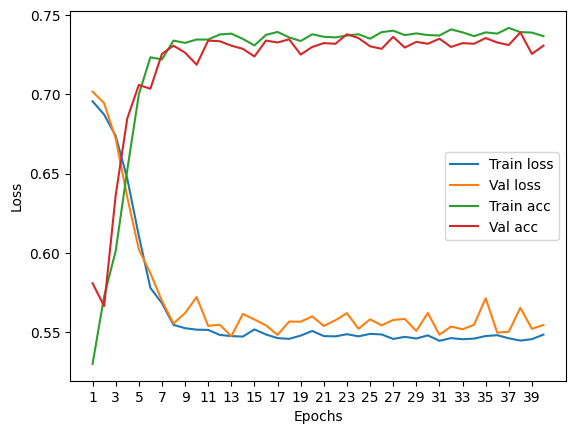

****************************************************************************************************



116it [00:00, 208.25it/s]


Train Epoch: 0 	Loss: 0.689220, Accuracy: 3976/7422 (54%)
Val Epoch: 0 	Loss: 0.691930, Accuracy: 1367/2474 (55%)



116it [00:00, 187.72it/s]


Train Epoch: 1 	Loss: 0.679489, Accuracy: 4267/7422 (57%)
Val Epoch: 1 	Loss: 0.682671, Accuracy: 1433/2474 (58%)



116it [00:00, 194.71it/s]


Train Epoch: 2 	Loss: 0.672624, Accuracy: 4332/7422 (58%)
Val Epoch: 2 	Loss: 0.675237, Accuracy: 1453/2474 (59%)



116it [00:00, 196.55it/s]


Train Epoch: 3 	Loss: 0.665636, Accuracy: 4414/7422 (59%)
Val Epoch: 3 	Loss: 0.667892, Accuracy: 1509/2474 (61%)



116it [00:00, 193.03it/s]


Train Epoch: 4 	Loss: 0.653742, Accuracy: 4598/7422 (62%)
Val Epoch: 4 	Loss: 0.652567, Accuracy: 1573/2474 (64%)



116it [00:00, 187.15it/s]


Train Epoch: 5 	Loss: 0.634733, Accuracy: 4829/7422 (65%)
Val Epoch: 5 	Loss: 0.630335, Accuracy: 1683/2474 (68%)



116it [00:00, 191.66it/s]


Train Epoch: 6 	Loss: 0.608219, Accuracy: 5177/7422 (70%)
Val Epoch: 6 	Loss: 0.602754, Accuracy: 1748/2474 (71%)



116it [00:00, 188.99it/s]


Train Epoch: 7 	Loss: 0.582023, Accuracy: 5316/7422 (72%)
Val Epoch: 7 	Loss: 0.581178, Accuracy: 1806/2474 (73%)



116it [00:01, 112.06it/s]


Train Epoch: 8 	Loss: 0.564620, Accuracy: 5377/7422 (72%)
Val Epoch: 8 	Loss: 0.567783, Accuracy: 1818/2474 (73%)



116it [00:00, 158.93it/s]


Train Epoch: 9 	Loss: 0.556452, Accuracy: 5429/7422 (73%)
Val Epoch: 9 	Loss: 0.562690, Accuracy: 1821/2474 (74%)



116it [00:00, 156.31it/s]


Train Epoch: 10 	Loss: 0.550020, Accuracy: 5442/7422 (73%)
Val Epoch: 10 	Loss: 0.558592, Accuracy: 1837/2474 (74%)



116it [00:00, 180.22it/s]


Train Epoch: 11 	Loss: 0.546214, Accuracy: 5484/7422 (74%)
Val Epoch: 11 	Loss: 0.560958, Accuracy: 1821/2474 (74%)



116it [00:00, 179.25it/s]


Train Epoch: 12 	Loss: 0.547690, Accuracy: 5422/7422 (73%)
Val Epoch: 12 	Loss: 0.559675, Accuracy: 1827/2474 (74%)



116it [00:00, 191.79it/s]


Train Epoch: 13 	Loss: 0.544884, Accuracy: 5462/7422 (74%)
Val Epoch: 13 	Loss: 0.555423, Accuracy: 1840/2474 (74%)



116it [00:00, 194.15it/s]


Train Epoch: 14 	Loss: 0.544073, Accuracy: 5456/7422 (74%)
Val Epoch: 14 	Loss: 0.555445, Accuracy: 1832/2474 (74%)



116it [00:00, 193.83it/s]


Train Epoch: 15 	Loss: 0.545243, Accuracy: 5474/7422 (74%)
Val Epoch: 15 	Loss: 0.556939, Accuracy: 1833/2474 (74%)



116it [00:00, 194.53it/s]


Train Epoch: 16 	Loss: 0.544466, Accuracy: 5452/7422 (73%)
Val Epoch: 16 	Loss: 0.556804, Accuracy: 1829/2474 (74%)



116it [00:00, 196.70it/s]


Train Epoch: 17 	Loss: 0.542689, Accuracy: 5464/7422 (74%)
Val Epoch: 17 	Loss: 0.555618, Accuracy: 1835/2474 (74%)



116it [00:00, 194.28it/s]


Train Epoch: 18 	Loss: 0.543729, Accuracy: 5475/7422 (74%)
Val Epoch: 18 	Loss: 0.557686, Accuracy: 1826/2474 (74%)



116it [00:00, 194.05it/s]


Train Epoch: 19 	Loss: 0.542367, Accuracy: 5489/7422 (74%)
Val Epoch: 19 	Loss: 0.555327, Accuracy: 1828/2474 (74%)



116it [00:00, 190.56it/s]


Train Epoch: 20 	Loss: 0.542308, Accuracy: 5498/7422 (74%)
Val Epoch: 20 	Loss: 0.557020, Accuracy: 1832/2474 (74%)



116it [00:00, 192.13it/s]


Train Epoch: 21 	Loss: 0.543213, Accuracy: 5468/7422 (74%)
Val Epoch: 21 	Loss: 0.558434, Accuracy: 1821/2474 (74%)



116it [00:00, 195.65it/s]


Train Epoch: 22 	Loss: 0.542546, Accuracy: 5496/7422 (74%)
Val Epoch: 22 	Loss: 0.560234, Accuracy: 1813/2474 (73%)



116it [00:00, 190.42it/s]


Train Epoch: 23 	Loss: 0.541981, Accuracy: 5511/7422 (74%)
Val Epoch: 23 	Loss: 0.559716, Accuracy: 1817/2474 (73%)



116it [00:00, 193.37it/s]


Train Epoch: 24 	Loss: 0.543330, Accuracy: 5466/7422 (74%)
Val Epoch: 24 	Loss: 0.564187, Accuracy: 1825/2474 (74%)



116it [00:00, 186.22it/s]


Train Epoch: 25 	Loss: 0.542033, Accuracy: 5483/7422 (74%)
Val Epoch: 25 	Loss: 0.557976, Accuracy: 1820/2474 (74%)



116it [00:00, 175.11it/s]


Train Epoch: 26 	Loss: 0.541963, Accuracy: 5485/7422 (74%)
Val Epoch: 26 	Loss: 0.555876, Accuracy: 1832/2474 (74%)



116it [00:00, 150.12it/s]


Train Epoch: 27 	Loss: 0.541713, Accuracy: 5502/7422 (74%)
Val Epoch: 27 	Loss: 0.562449, Accuracy: 1804/2474 (73%)



116it [00:00, 164.38it/s]


Train Epoch: 28 	Loss: 0.544063, Accuracy: 5468/7422 (74%)
Val Epoch: 28 	Loss: 0.555822, Accuracy: 1835/2474 (74%)



116it [00:00, 161.23it/s]


Train Epoch: 29 	Loss: 0.541321, Accuracy: 5505/7422 (74%)
Val Epoch: 29 	Loss: 0.566188, Accuracy: 1794/2474 (73%)



116it [00:00, 173.43it/s]


Train Epoch: 30 	Loss: 0.541801, Accuracy: 5501/7422 (74%)
Val Epoch: 30 	Loss: 0.556208, Accuracy: 1832/2474 (74%)



116it [00:00, 183.08it/s]


Train Epoch: 31 	Loss: 0.541683, Accuracy: 5476/7422 (74%)
Val Epoch: 31 	Loss: 0.559641, Accuracy: 1816/2474 (73%)



116it [00:00, 187.40it/s]


Train Epoch: 32 	Loss: 0.541751, Accuracy: 5503/7422 (74%)
Val Epoch: 32 	Loss: 0.556421, Accuracy: 1836/2474 (74%)



116it [00:00, 192.96it/s]


Train Epoch: 33 	Loss: 0.541294, Accuracy: 5510/7422 (74%)
Val Epoch: 33 	Loss: 0.555541, Accuracy: 1838/2474 (74%)



116it [00:00, 189.82it/s]


Train Epoch: 34 	Loss: 0.540543, Accuracy: 5489/7422 (74%)
Val Epoch: 34 	Loss: 0.555701, Accuracy: 1832/2474 (74%)



116it [00:00, 189.57it/s]


Train Epoch: 35 	Loss: 0.541124, Accuracy: 5507/7422 (74%)
Val Epoch: 35 	Loss: 0.556395, Accuracy: 1827/2474 (74%)



116it [00:00, 189.58it/s]


Train Epoch: 36 	Loss: 0.540618, Accuracy: 5505/7422 (74%)
Val Epoch: 36 	Loss: 0.559638, Accuracy: 1818/2474 (73%)



116it [00:00, 187.17it/s]


Train Epoch: 37 	Loss: 0.543998, Accuracy: 5478/7422 (74%)
Val Epoch: 37 	Loss: 0.557448, Accuracy: 1830/2474 (74%)



116it [00:00, 195.57it/s]


Train Epoch: 38 	Loss: 0.540835, Accuracy: 5508/7422 (74%)
Val Epoch: 38 	Loss: 0.562782, Accuracy: 1809/2474 (73%)



116it [00:00, 190.34it/s]


Train Epoch: 39 	Loss: 0.541101, Accuracy: 5505/7422 (74%)
Val Epoch: 39 	Loss: 0.557081, Accuracy: 1830/2474 (74%)

Test accuracy:  74.6160064672595


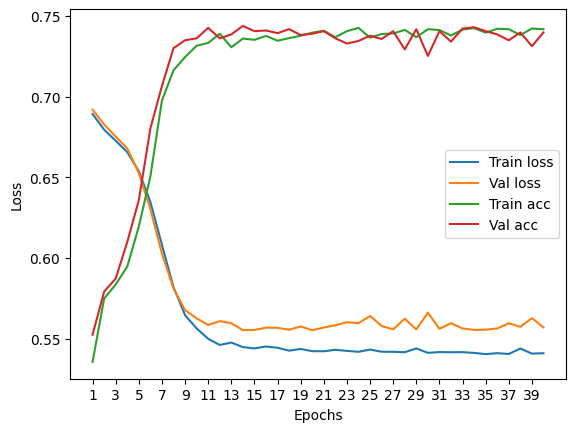

****************************************************************************************************



Particles per jet: 15


118it [00:00, 209.65it/s]


Train Epoch: 0 	Loss: 0.695473, Accuracy: 4001/7500 (53%)
Val Epoch: 0 	Loss: 0.704269, Accuracy: 1388/2500 (56%)



118it [00:00, 191.20it/s]


Train Epoch: 1 	Loss: 0.685020, Accuracy: 4315/7500 (58%)
Val Epoch: 1 	Loss: 0.703595, Accuracy: 1363/2500 (55%)



118it [00:00, 193.17it/s]


Train Epoch: 2 	Loss: 0.677661, Accuracy: 4361/7500 (58%)
Val Epoch: 2 	Loss: 0.689261, Accuracy: 1462/2500 (58%)



118it [00:00, 186.75it/s]


Train Epoch: 3 	Loss: 0.672391, Accuracy: 4413/7500 (59%)
Val Epoch: 3 	Loss: 0.681924, Accuracy: 1494/2500 (60%)



118it [00:00, 189.71it/s]


Train Epoch: 4 	Loss: 0.663296, Accuracy: 4566/7500 (61%)
Val Epoch: 4 	Loss: 0.684718, Accuracy: 1501/2500 (60%)



118it [00:00, 137.48it/s]


Train Epoch: 5 	Loss: 0.646972, Accuracy: 4757/7500 (63%)
Val Epoch: 5 	Loss: 0.658141, Accuracy: 1594/2500 (64%)



118it [00:00, 131.08it/s]


Train Epoch: 6 	Loss: 0.615040, Accuracy: 5133/7500 (68%)
Val Epoch: 6 	Loss: 0.613433, Accuracy: 1762/2500 (70%)



118it [00:00, 139.90it/s]


Train Epoch: 7 	Loss: 0.582330, Accuracy: 5385/7500 (72%)
Val Epoch: 7 	Loss: 0.601602, Accuracy: 1821/2500 (73%)



118it [00:00, 178.49it/s]


Train Epoch: 8 	Loss: 0.565378, Accuracy: 5437/7500 (72%)
Val Epoch: 8 	Loss: 0.568542, Accuracy: 1843/2500 (74%)



118it [00:00, 179.46it/s]


Train Epoch: 9 	Loss: 0.552962, Accuracy: 5484/7500 (73%)
Val Epoch: 9 	Loss: 0.562809, Accuracy: 1844/2500 (74%)



118it [00:00, 178.60it/s]


Train Epoch: 10 	Loss: 0.547486, Accuracy: 5526/7500 (74%)
Val Epoch: 10 	Loss: 0.564611, Accuracy: 1849/2500 (74%)



118it [00:00, 176.15it/s]


Train Epoch: 11 	Loss: 0.544095, Accuracy: 5501/7500 (73%)
Val Epoch: 11 	Loss: 0.568442, Accuracy: 1842/2500 (74%)



118it [00:00, 190.81it/s]


Train Epoch: 12 	Loss: 0.542483, Accuracy: 5545/7500 (74%)
Val Epoch: 12 	Loss: 0.571227, Accuracy: 1846/2500 (74%)



118it [00:00, 143.74it/s]


Train Epoch: 13 	Loss: 0.541445, Accuracy: 5535/7500 (74%)
Val Epoch: 13 	Loss: 0.557431, Accuracy: 1842/2500 (74%)



118it [00:00, 141.57it/s]


Train Epoch: 14 	Loss: 0.539741, Accuracy: 5535/7500 (74%)
Val Epoch: 14 	Loss: 0.561940, Accuracy: 1853/2500 (74%)



118it [00:00, 122.04it/s]


Train Epoch: 15 	Loss: 0.543791, Accuracy: 5520/7500 (74%)
Val Epoch: 15 	Loss: 0.562987, Accuracy: 1845/2500 (74%)



118it [00:00, 129.19it/s]


Train Epoch: 16 	Loss: 0.542828, Accuracy: 5521/7500 (74%)
Val Epoch: 16 	Loss: 0.561771, Accuracy: 1851/2500 (74%)



118it [00:00, 175.88it/s]


Train Epoch: 17 	Loss: 0.538744, Accuracy: 5553/7500 (74%)
Val Epoch: 17 	Loss: 0.557158, Accuracy: 1844/2500 (74%)



118it [00:00, 174.09it/s]


Train Epoch: 18 	Loss: 0.539479, Accuracy: 5535/7500 (74%)
Val Epoch: 18 	Loss: 0.552977, Accuracy: 1846/2500 (74%)



118it [00:00, 189.96it/s]


Train Epoch: 19 	Loss: 0.541678, Accuracy: 5527/7500 (74%)
Val Epoch: 19 	Loss: 0.574510, Accuracy: 1822/2500 (73%)



118it [00:00, 193.03it/s]


Train Epoch: 20 	Loss: 0.540318, Accuracy: 5532/7500 (74%)
Val Epoch: 20 	Loss: 0.557425, Accuracy: 1858/2500 (74%)



118it [00:00, 179.42it/s]


Train Epoch: 21 	Loss: 0.538846, Accuracy: 5565/7500 (74%)
Val Epoch: 21 	Loss: 0.551973, Accuracy: 1854/2500 (74%)



118it [00:00, 145.00it/s]


Train Epoch: 22 	Loss: 0.538972, Accuracy: 5555/7500 (74%)
Val Epoch: 22 	Loss: 0.552882, Accuracy: 1836/2500 (73%)



118it [00:00, 159.58it/s]


Train Epoch: 23 	Loss: 0.539963, Accuracy: 5560/7500 (74%)
Val Epoch: 23 	Loss: 0.560519, Accuracy: 1823/2500 (73%)



118it [00:00, 167.85it/s]


Train Epoch: 24 	Loss: 0.539007, Accuracy: 5539/7500 (74%)
Val Epoch: 24 	Loss: 0.559915, Accuracy: 1836/2500 (73%)



118it [00:00, 147.48it/s]


Train Epoch: 25 	Loss: 0.537809, Accuracy: 5569/7500 (74%)
Val Epoch: 25 	Loss: 0.553880, Accuracy: 1847/2500 (74%)



118it [00:00, 180.34it/s]


Train Epoch: 26 	Loss: 0.539473, Accuracy: 5529/7500 (74%)
Val Epoch: 26 	Loss: 0.550693, Accuracy: 1849/2500 (74%)



118it [00:00, 179.27it/s]


Train Epoch: 27 	Loss: 0.536915, Accuracy: 5565/7500 (74%)
Val Epoch: 27 	Loss: 0.551941, Accuracy: 1855/2500 (74%)



118it [00:00, 182.13it/s]


Train Epoch: 28 	Loss: 0.539714, Accuracy: 5549/7500 (74%)
Val Epoch: 28 	Loss: 0.558911, Accuracy: 1844/2500 (74%)



118it [00:00, 189.21it/s]


Train Epoch: 29 	Loss: 0.537909, Accuracy: 5565/7500 (74%)
Val Epoch: 29 	Loss: 0.559568, Accuracy: 1852/2500 (74%)



118it [00:00, 191.24it/s]


Train Epoch: 30 	Loss: 0.540759, Accuracy: 5544/7500 (74%)
Val Epoch: 30 	Loss: 0.557765, Accuracy: 1849/2500 (74%)



118it [00:00, 178.10it/s]


Train Epoch: 31 	Loss: 0.538743, Accuracy: 5543/7500 (74%)
Val Epoch: 31 	Loss: 0.563731, Accuracy: 1840/2500 (74%)



118it [00:00, 180.76it/s]


Train Epoch: 32 	Loss: 0.537722, Accuracy: 5551/7500 (74%)
Val Epoch: 32 	Loss: 0.552086, Accuracy: 1851/2500 (74%)



118it [00:00, 190.11it/s]


Train Epoch: 33 	Loss: 0.538151, Accuracy: 5553/7500 (74%)
Val Epoch: 33 	Loss: 0.555966, Accuracy: 1847/2500 (74%)



118it [00:00, 189.01it/s]


Train Epoch: 34 	Loss: 0.536209, Accuracy: 5540/7500 (74%)
Val Epoch: 34 	Loss: 0.562112, Accuracy: 1838/2500 (74%)



118it [00:00, 193.06it/s]


Train Epoch: 35 	Loss: 0.537299, Accuracy: 5549/7500 (74%)
Val Epoch: 35 	Loss: 0.565636, Accuracy: 1844/2500 (74%)



118it [00:00, 186.47it/s]


Train Epoch: 36 	Loss: 0.538354, Accuracy: 5558/7500 (74%)
Val Epoch: 36 	Loss: 0.549577, Accuracy: 1860/2500 (74%)



118it [00:00, 189.21it/s]


Train Epoch: 37 	Loss: 0.537320, Accuracy: 5533/7500 (74%)
Val Epoch: 37 	Loss: 0.594117, Accuracy: 1815/2500 (73%)



118it [00:00, 182.37it/s]


Train Epoch: 38 	Loss: 0.537234, Accuracy: 5559/7500 (74%)
Val Epoch: 38 	Loss: 0.557877, Accuracy: 1847/2500 (74%)



118it [00:00, 175.33it/s]


Train Epoch: 39 	Loss: 0.536702, Accuracy: 5539/7500 (74%)
Val Epoch: 39 	Loss: 0.553110, Accuracy: 1849/2500 (74%)

Test accuracy:  75.88000000000001


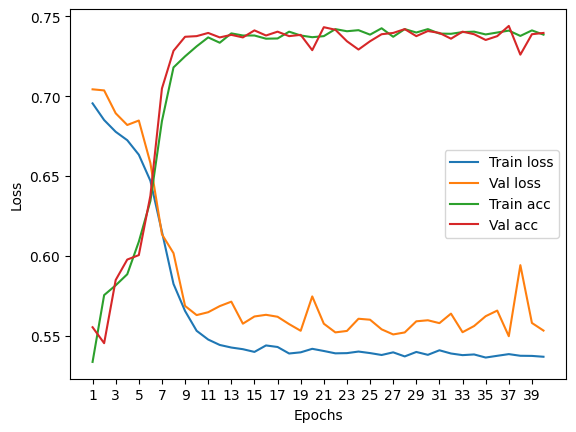

****************************************************************************************************



118it [00:00, 178.39it/s]


Train Epoch: 0 	Loss: 0.694917, Accuracy: 4007/7500 (53%)
Val Epoch: 0 	Loss: 0.705431, Accuracy: 1322/2500 (53%)



118it [00:00, 151.99it/s]


Train Epoch: 1 	Loss: 0.687304, Accuracy: 4160/7500 (55%)
Val Epoch: 1 	Loss: 0.685216, Accuracy: 1492/2500 (60%)



118it [00:00, 163.67it/s]


Train Epoch: 2 	Loss: 0.670053, Accuracy: 4563/7500 (61%)
Val Epoch: 2 	Loss: 0.667423, Accuracy: 1563/2500 (63%)



118it [00:00, 176.94it/s]


Train Epoch: 3 	Loss: 0.647822, Accuracy: 4798/7500 (64%)
Val Epoch: 3 	Loss: 0.632902, Accuracy: 1698/2500 (68%)



118it [00:00, 145.52it/s]


Train Epoch: 4 	Loss: 0.615172, Accuracy: 5177/7500 (69%)
Val Epoch: 4 	Loss: 0.601432, Accuracy: 1810/2500 (72%)



118it [00:00, 165.99it/s]


Train Epoch: 5 	Loss: 0.592425, Accuracy: 5333/7500 (71%)
Val Epoch: 5 	Loss: 0.586570, Accuracy: 1839/2500 (74%)



118it [00:00, 152.65it/s]


Train Epoch: 6 	Loss: 0.575888, Accuracy: 5418/7500 (72%)
Val Epoch: 6 	Loss: 0.564774, Accuracy: 1849/2500 (74%)



118it [00:00, 168.42it/s]


Train Epoch: 7 	Loss: 0.567434, Accuracy: 5432/7500 (72%)
Val Epoch: 7 	Loss: 0.560845, Accuracy: 1865/2500 (75%)



118it [00:00, 185.92it/s]


Train Epoch: 8 	Loss: 0.558962, Accuracy: 5467/7500 (73%)
Val Epoch: 8 	Loss: 0.547280, Accuracy: 1875/2500 (75%)



118it [00:00, 185.71it/s]


Train Epoch: 9 	Loss: 0.554031, Accuracy: 5493/7500 (73%)
Val Epoch: 9 	Loss: 0.540478, Accuracy: 1873/2500 (75%)



118it [00:00, 180.06it/s]


Train Epoch: 10 	Loss: 0.553922, Accuracy: 5513/7500 (74%)
Val Epoch: 10 	Loss: 0.543302, Accuracy: 1870/2500 (75%)



118it [00:00, 188.27it/s]


Train Epoch: 11 	Loss: 0.552483, Accuracy: 5493/7500 (73%)
Val Epoch: 11 	Loss: 0.539833, Accuracy: 1865/2500 (75%)



118it [00:00, 188.18it/s]


Train Epoch: 12 	Loss: 0.552891, Accuracy: 5498/7500 (73%)
Val Epoch: 12 	Loss: 0.539194, Accuracy: 1881/2500 (75%)



118it [00:00, 191.28it/s]


Train Epoch: 13 	Loss: 0.553588, Accuracy: 5477/7500 (73%)
Val Epoch: 13 	Loss: 0.539476, Accuracy: 1867/2500 (75%)



118it [00:00, 194.03it/s]


Train Epoch: 14 	Loss: 0.551353, Accuracy: 5485/7500 (73%)
Val Epoch: 14 	Loss: 0.543050, Accuracy: 1878/2500 (75%)



118it [00:00, 176.59it/s]


Train Epoch: 15 	Loss: 0.553643, Accuracy: 5498/7500 (73%)
Val Epoch: 15 	Loss: 0.533502, Accuracy: 1881/2500 (75%)



118it [00:00, 174.75it/s]


Train Epoch: 16 	Loss: 0.552581, Accuracy: 5520/7500 (74%)
Val Epoch: 16 	Loss: 0.539016, Accuracy: 1874/2500 (75%)



118it [00:00, 167.47it/s]


Train Epoch: 17 	Loss: 0.550611, Accuracy: 5496/7500 (73%)
Val Epoch: 17 	Loss: 0.539755, Accuracy: 1871/2500 (75%)



118it [00:00, 151.64it/s]


Train Epoch: 18 	Loss: 0.552103, Accuracy: 5505/7500 (73%)
Val Epoch: 18 	Loss: 0.536868, Accuracy: 1878/2500 (75%)



118it [00:01, 69.30it/s]


Train Epoch: 19 	Loss: 0.553755, Accuracy: 5482/7500 (73%)
Val Epoch: 19 	Loss: 0.538376, Accuracy: 1861/2500 (74%)



118it [00:00, 123.06it/s]


Train Epoch: 20 	Loss: 0.549675, Accuracy: 5516/7500 (74%)
Val Epoch: 20 	Loss: 0.549589, Accuracy: 1888/2500 (76%)



118it [00:00, 167.46it/s]


Train Epoch: 21 	Loss: 0.550887, Accuracy: 5523/7500 (74%)
Val Epoch: 21 	Loss: 0.547674, Accuracy: 1888/2500 (76%)



118it [00:00, 176.76it/s]


Train Epoch: 22 	Loss: 0.550906, Accuracy: 5523/7500 (74%)
Val Epoch: 22 	Loss: 0.550428, Accuracy: 1884/2500 (75%)



118it [00:00, 188.32it/s]


Train Epoch: 23 	Loss: 0.551057, Accuracy: 5515/7500 (74%)
Val Epoch: 23 	Loss: 0.541681, Accuracy: 1879/2500 (75%)



118it [00:00, 195.81it/s]


Train Epoch: 24 	Loss: 0.551123, Accuracy: 5519/7500 (74%)
Val Epoch: 24 	Loss: 0.542704, Accuracy: 1881/2500 (75%)



118it [00:00, 194.83it/s]


Train Epoch: 25 	Loss: 0.549997, Accuracy: 5527/7500 (74%)
Val Epoch: 25 	Loss: 0.554939, Accuracy: 1875/2500 (75%)



118it [00:00, 170.58it/s]


Train Epoch: 26 	Loss: 0.550370, Accuracy: 5518/7500 (74%)
Val Epoch: 26 	Loss: 0.539126, Accuracy: 1882/2500 (75%)



118it [00:00, 189.01it/s]


Train Epoch: 27 	Loss: 0.549097, Accuracy: 5515/7500 (74%)
Val Epoch: 27 	Loss: 0.544241, Accuracy: 1881/2500 (75%)



118it [00:00, 167.93it/s]


Train Epoch: 28 	Loss: 0.550057, Accuracy: 5519/7500 (74%)
Val Epoch: 28 	Loss: 0.552649, Accuracy: 1875/2500 (75%)



118it [00:00, 188.51it/s]


Train Epoch: 29 	Loss: 0.550905, Accuracy: 5523/7500 (74%)
Val Epoch: 29 	Loss: 0.544749, Accuracy: 1870/2500 (75%)



118it [00:00, 189.10it/s]


Train Epoch: 30 	Loss: 0.551697, Accuracy: 5517/7500 (74%)
Val Epoch: 30 	Loss: 0.538564, Accuracy: 1868/2500 (75%)



118it [00:00, 177.46it/s]


Train Epoch: 31 	Loss: 0.552966, Accuracy: 5530/7500 (74%)
Val Epoch: 31 	Loss: 0.536597, Accuracy: 1869/2500 (75%)



118it [00:00, 183.55it/s]


Train Epoch: 32 	Loss: 0.549173, Accuracy: 5517/7500 (74%)
Val Epoch: 32 	Loss: 0.554404, Accuracy: 1881/2500 (75%)



118it [00:00, 193.65it/s]


Train Epoch: 33 	Loss: 0.551413, Accuracy: 5531/7500 (74%)
Val Epoch: 33 	Loss: 0.537299, Accuracy: 1882/2500 (75%)



118it [00:00, 197.34it/s]


Train Epoch: 34 	Loss: 0.550309, Accuracy: 5505/7500 (73%)
Val Epoch: 34 	Loss: 0.537219, Accuracy: 1883/2500 (75%)



118it [00:00, 119.23it/s]


Train Epoch: 35 	Loss: 0.552652, Accuracy: 5513/7500 (74%)
Val Epoch: 35 	Loss: 0.557308, Accuracy: 1870/2500 (75%)



118it [00:00, 119.98it/s]


Train Epoch: 36 	Loss: 0.551680, Accuracy: 5534/7500 (74%)
Val Epoch: 36 	Loss: 0.538471, Accuracy: 1891/2500 (76%)



118it [00:00, 142.47it/s]


Train Epoch: 37 	Loss: 0.551889, Accuracy: 5498/7500 (73%)
Val Epoch: 37 	Loss: 0.542908, Accuracy: 1862/2500 (74%)



118it [00:00, 168.96it/s]


Train Epoch: 38 	Loss: 0.549271, Accuracy: 5555/7500 (74%)
Val Epoch: 38 	Loss: 0.544846, Accuracy: 1862/2500 (74%)



118it [00:00, 192.24it/s]


Train Epoch: 39 	Loss: 0.551864, Accuracy: 5505/7500 (73%)
Val Epoch: 39 	Loss: 0.549989, Accuracy: 1870/2500 (75%)

Test accuracy:  73.04


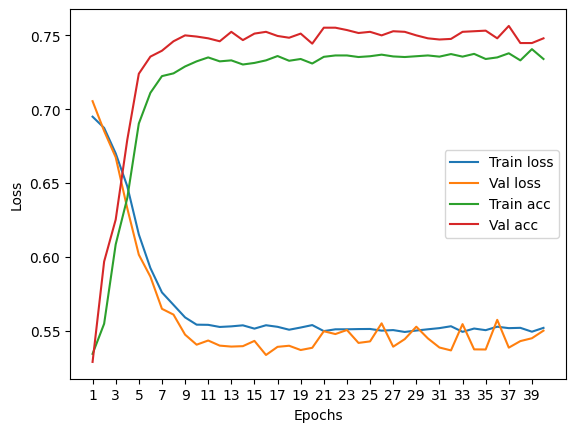

****************************************************************************************************



118it [00:00, 189.62it/s]


Train Epoch: 0 	Loss: 0.697169, Accuracy: 3880/7500 (52%)
Val Epoch: 0 	Loss: 0.704844, Accuracy: 1357/2500 (54%)



118it [00:00, 200.57it/s]


Train Epoch: 1 	Loss: 0.684723, Accuracy: 4274/7500 (57%)
Val Epoch: 1 	Loss: 0.692477, Accuracy: 1474/2500 (59%)



118it [00:00, 194.47it/s]


Train Epoch: 2 	Loss: 0.663178, Accuracy: 4596/7500 (61%)
Val Epoch: 2 	Loss: 0.655990, Accuracy: 1613/2500 (65%)



118it [00:00, 191.96it/s]


Train Epoch: 3 	Loss: 0.626457, Accuracy: 5048/7500 (67%)
Val Epoch: 3 	Loss: 0.627440, Accuracy: 1712/2500 (68%)



118it [00:00, 195.68it/s]


Train Epoch: 4 	Loss: 0.588101, Accuracy: 5322/7500 (71%)
Val Epoch: 4 	Loss: 0.586936, Accuracy: 1831/2500 (73%)



118it [00:00, 190.40it/s]


Train Epoch: 5 	Loss: 0.561160, Accuracy: 5497/7500 (73%)
Val Epoch: 5 	Loss: 0.565749, Accuracy: 1848/2500 (74%)



118it [00:00, 192.24it/s]


Train Epoch: 6 	Loss: 0.550819, Accuracy: 5515/7500 (74%)
Val Epoch: 6 	Loss: 0.561980, Accuracy: 1856/2500 (74%)



118it [00:00, 190.43it/s]


Train Epoch: 7 	Loss: 0.543282, Accuracy: 5564/7500 (74%)
Val Epoch: 7 	Loss: 0.555213, Accuracy: 1840/2500 (74%)



118it [00:00, 195.79it/s]


Train Epoch: 8 	Loss: 0.539649, Accuracy: 5553/7500 (74%)
Val Epoch: 8 	Loss: 0.550681, Accuracy: 1859/2500 (74%)



118it [00:00, 189.01it/s]


Train Epoch: 9 	Loss: 0.539671, Accuracy: 5543/7500 (74%)
Val Epoch: 9 	Loss: 0.551876, Accuracy: 1861/2500 (74%)



118it [00:00, 192.94it/s]


Train Epoch: 10 	Loss: 0.535719, Accuracy: 5583/7500 (74%)
Val Epoch: 10 	Loss: 0.546043, Accuracy: 1855/2500 (74%)



118it [00:00, 188.60it/s]


Train Epoch: 11 	Loss: 0.536903, Accuracy: 5599/7500 (75%)
Val Epoch: 11 	Loss: 0.551706, Accuracy: 1856/2500 (74%)



118it [00:00, 193.46it/s]


Train Epoch: 12 	Loss: 0.534983, Accuracy: 5568/7500 (74%)
Val Epoch: 12 	Loss: 0.548565, Accuracy: 1853/2500 (74%)



118it [00:00, 184.95it/s]


Train Epoch: 13 	Loss: 0.536314, Accuracy: 5580/7500 (74%)
Val Epoch: 13 	Loss: 0.566423, Accuracy: 1855/2500 (74%)



118it [00:00, 126.83it/s]


Train Epoch: 14 	Loss: 0.535631, Accuracy: 5591/7500 (75%)
Val Epoch: 14 	Loss: 0.557081, Accuracy: 1862/2500 (74%)



118it [00:00, 129.89it/s]


Train Epoch: 15 	Loss: 0.533448, Accuracy: 5579/7500 (74%)
Val Epoch: 15 	Loss: 0.548681, Accuracy: 1857/2500 (74%)



118it [00:00, 142.71it/s]


Train Epoch: 16 	Loss: 0.533951, Accuracy: 5575/7500 (74%)
Val Epoch: 16 	Loss: 0.558347, Accuracy: 1853/2500 (74%)



118it [00:00, 193.83it/s]


Train Epoch: 17 	Loss: 0.534557, Accuracy: 5566/7500 (74%)
Val Epoch: 17 	Loss: 0.552203, Accuracy: 1866/2500 (75%)



118it [00:00, 183.21it/s]


Train Epoch: 18 	Loss: 0.538266, Accuracy: 5563/7500 (74%)
Val Epoch: 18 	Loss: 0.552557, Accuracy: 1846/2500 (74%)



118it [00:00, 187.61it/s]


Train Epoch: 19 	Loss: 0.534025, Accuracy: 5603/7500 (75%)
Val Epoch: 19 	Loss: 0.543935, Accuracy: 1860/2500 (74%)



118it [00:00, 182.04it/s]


Train Epoch: 20 	Loss: 0.533696, Accuracy: 5589/7500 (75%)
Val Epoch: 20 	Loss: 0.545271, Accuracy: 1854/2500 (74%)



118it [00:00, 189.56it/s]


Train Epoch: 21 	Loss: 0.538886, Accuracy: 5587/7500 (74%)
Val Epoch: 21 	Loss: 0.554481, Accuracy: 1860/2500 (74%)



118it [00:00, 184.26it/s]


Train Epoch: 22 	Loss: 0.533290, Accuracy: 5589/7500 (75%)
Val Epoch: 22 	Loss: 0.551215, Accuracy: 1864/2500 (75%)



118it [00:00, 190.88it/s]


Train Epoch: 23 	Loss: 0.535376, Accuracy: 5570/7500 (74%)
Val Epoch: 23 	Loss: 0.547304, Accuracy: 1858/2500 (74%)



118it [00:00, 174.05it/s]


Train Epoch: 24 	Loss: 0.534764, Accuracy: 5608/7500 (75%)
Val Epoch: 24 	Loss: 0.542339, Accuracy: 1860/2500 (74%)



118it [00:00, 173.50it/s]


Train Epoch: 25 	Loss: 0.535349, Accuracy: 5604/7500 (75%)
Val Epoch: 25 	Loss: 0.565483, Accuracy: 1863/2500 (75%)



118it [00:00, 186.04it/s]


Train Epoch: 26 	Loss: 0.533791, Accuracy: 5600/7500 (75%)
Val Epoch: 26 	Loss: 0.548714, Accuracy: 1863/2500 (75%)



118it [00:00, 186.23it/s]


Train Epoch: 27 	Loss: 0.532581, Accuracy: 5583/7500 (74%)
Val Epoch: 27 	Loss: 0.552945, Accuracy: 1865/2500 (75%)



118it [00:00, 179.25it/s]


Train Epoch: 28 	Loss: 0.534942, Accuracy: 5589/7500 (75%)
Val Epoch: 28 	Loss: 0.550986, Accuracy: 1865/2500 (75%)



118it [00:00, 187.46it/s]


Train Epoch: 29 	Loss: 0.535042, Accuracy: 5596/7500 (75%)
Val Epoch: 29 	Loss: 0.559647, Accuracy: 1865/2500 (75%)



118it [00:00, 190.35it/s]


Train Epoch: 30 	Loss: 0.533557, Accuracy: 5602/7500 (75%)
Val Epoch: 30 	Loss: 0.554831, Accuracy: 1859/2500 (74%)



118it [00:00, 194.92it/s]


Train Epoch: 31 	Loss: 0.532522, Accuracy: 5590/7500 (75%)
Val Epoch: 31 	Loss: 0.549001, Accuracy: 1867/2500 (75%)



118it [00:00, 149.75it/s]


Train Epoch: 32 	Loss: 0.534970, Accuracy: 5605/7500 (75%)
Val Epoch: 32 	Loss: 0.557048, Accuracy: 1847/2500 (74%)



118it [00:00, 161.05it/s]


Train Epoch: 33 	Loss: 0.535105, Accuracy: 5536/7500 (74%)
Val Epoch: 33 	Loss: 0.551748, Accuracy: 1859/2500 (74%)



118it [00:00, 154.20it/s]


Train Epoch: 34 	Loss: 0.532483, Accuracy: 5590/7500 (75%)
Val Epoch: 34 	Loss: 0.546759, Accuracy: 1864/2500 (75%)



118it [00:00, 178.18it/s]


Train Epoch: 35 	Loss: 0.533044, Accuracy: 5589/7500 (75%)
Val Epoch: 35 	Loss: 0.568337, Accuracy: 1860/2500 (74%)



118it [00:00, 183.25it/s]


Train Epoch: 36 	Loss: 0.532250, Accuracy: 5594/7500 (75%)
Val Epoch: 36 	Loss: 0.544346, Accuracy: 1860/2500 (74%)



118it [00:00, 192.58it/s]


Train Epoch: 37 	Loss: 0.532429, Accuracy: 5565/7500 (74%)
Val Epoch: 37 	Loss: 0.539532, Accuracy: 1863/2500 (75%)



118it [00:00, 193.65it/s]


Train Epoch: 38 	Loss: 0.534827, Accuracy: 5575/7500 (74%)
Val Epoch: 38 	Loss: 0.556503, Accuracy: 1863/2500 (75%)



118it [00:00, 187.90it/s]


Train Epoch: 39 	Loss: 0.532727, Accuracy: 5583/7500 (74%)
Val Epoch: 39 	Loss: 0.547567, Accuracy: 1865/2500 (75%)

Test accuracy:  74.16


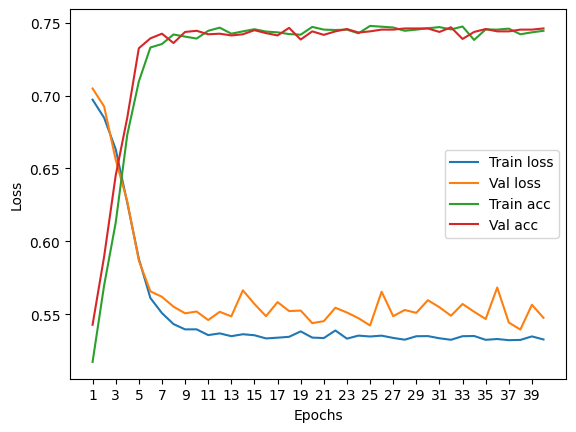

****************************************************************************************************



118it [00:01, 114.31it/s]


Train Epoch: 0 	Loss: 0.695864, Accuracy: 3972/7500 (53%)
Val Epoch: 0 	Loss: 0.701904, Accuracy: 1394/2500 (56%)



118it [00:00, 137.40it/s]


Train Epoch: 1 	Loss: 0.686324, Accuracy: 4270/7500 (57%)
Val Epoch: 1 	Loss: 0.693819, Accuracy: 1432/2500 (57%)



118it [00:00, 157.96it/s]


Train Epoch: 2 	Loss: 0.677729, Accuracy: 4410/7500 (59%)
Val Epoch: 2 	Loss: 0.685594, Accuracy: 1479/2500 (59%)



118it [00:00, 154.48it/s]


Train Epoch: 3 	Loss: 0.671053, Accuracy: 4470/7500 (60%)
Val Epoch: 3 	Loss: 0.672986, Accuracy: 1521/2500 (61%)



118it [00:00, 170.45it/s]


Train Epoch: 4 	Loss: 0.660518, Accuracy: 4646/7500 (62%)
Val Epoch: 4 	Loss: 0.656344, Accuracy: 1610/2500 (64%)



118it [00:00, 139.01it/s]


Train Epoch: 5 	Loss: 0.640210, Accuracy: 4867/7500 (65%)
Val Epoch: 5 	Loss: 0.633620, Accuracy: 1686/2500 (67%)



118it [00:00, 123.83it/s]


Train Epoch: 6 	Loss: 0.619603, Accuracy: 5081/7500 (68%)
Val Epoch: 6 	Loss: 0.618410, Accuracy: 1747/2500 (70%)



118it [00:00, 176.63it/s]


Train Epoch: 7 	Loss: 0.598314, Accuracy: 5269/7500 (70%)
Val Epoch: 7 	Loss: 0.596849, Accuracy: 1756/2500 (70%)



118it [00:00, 183.90it/s]


Train Epoch: 8 	Loss: 0.581583, Accuracy: 5349/7500 (71%)
Val Epoch: 8 	Loss: 0.584929, Accuracy: 1796/2500 (72%)



118it [00:00, 156.20it/s]


Train Epoch: 9 	Loss: 0.566968, Accuracy: 5455/7500 (73%)
Val Epoch: 9 	Loss: 0.575188, Accuracy: 1793/2500 (72%)



118it [00:01, 99.67it/s] 


Train Epoch: 10 	Loss: 0.560497, Accuracy: 5476/7500 (73%)
Val Epoch: 10 	Loss: 0.562231, Accuracy: 1793/2500 (72%)



118it [00:00, 120.44it/s]


Train Epoch: 11 	Loss: 0.553586, Accuracy: 5477/7500 (73%)
Val Epoch: 11 	Loss: 0.565312, Accuracy: 1811/2500 (72%)



118it [00:01, 67.58it/s]


Train Epoch: 12 	Loss: 0.550982, Accuracy: 5498/7500 (73%)
Val Epoch: 12 	Loss: 0.558888, Accuracy: 1810/2500 (72%)



118it [00:00, 127.66it/s]


Train Epoch: 13 	Loss: 0.546745, Accuracy: 5505/7500 (73%)
Val Epoch: 13 	Loss: 0.576745, Accuracy: 1765/2500 (71%)



118it [00:00, 155.96it/s]


Train Epoch: 14 	Loss: 0.544991, Accuracy: 5517/7500 (74%)
Val Epoch: 14 	Loss: 0.566348, Accuracy: 1784/2500 (71%)



118it [00:00, 172.23it/s]


Train Epoch: 15 	Loss: 0.545141, Accuracy: 5497/7500 (73%)
Val Epoch: 15 	Loss: 0.555134, Accuracy: 1807/2500 (72%)



118it [00:00, 203.00it/s]


Train Epoch: 16 	Loss: 0.543466, Accuracy: 5512/7500 (73%)
Val Epoch: 16 	Loss: 0.557751, Accuracy: 1799/2500 (72%)



118it [00:00, 159.98it/s]


Train Epoch: 17 	Loss: 0.541698, Accuracy: 5515/7500 (74%)
Val Epoch: 17 	Loss: 0.550063, Accuracy: 1825/2500 (73%)



118it [00:00, 187.94it/s]


Train Epoch: 18 	Loss: 0.542909, Accuracy: 5537/7500 (74%)
Val Epoch: 18 	Loss: 0.553944, Accuracy: 1805/2500 (72%)



118it [00:00, 207.09it/s]


Train Epoch: 19 	Loss: 0.539789, Accuracy: 5567/7500 (74%)
Val Epoch: 19 	Loss: 0.547140, Accuracy: 1826/2500 (73%)



118it [00:00, 211.97it/s]


Train Epoch: 20 	Loss: 0.542517, Accuracy: 5522/7500 (74%)
Val Epoch: 20 	Loss: 0.562342, Accuracy: 1832/2500 (73%)



118it [00:00, 214.37it/s]


Train Epoch: 21 	Loss: 0.542598, Accuracy: 5522/7500 (74%)
Val Epoch: 21 	Loss: 0.553391, Accuracy: 1824/2500 (73%)



118it [00:00, 225.35it/s]


Train Epoch: 22 	Loss: 0.542563, Accuracy: 5533/7500 (74%)
Val Epoch: 22 	Loss: 0.563762, Accuracy: 1825/2500 (73%)



118it [00:00, 223.27it/s]


Train Epoch: 23 	Loss: 0.542195, Accuracy: 5540/7500 (74%)
Val Epoch: 23 	Loss: 0.553492, Accuracy: 1821/2500 (73%)



118it [00:00, 217.61it/s]


Train Epoch: 24 	Loss: 0.543213, Accuracy: 5520/7500 (74%)
Val Epoch: 24 	Loss: 0.555589, Accuracy: 1829/2500 (73%)



118it [00:00, 221.51it/s]


Train Epoch: 25 	Loss: 0.541835, Accuracy: 5565/7500 (74%)
Val Epoch: 25 	Loss: 0.563579, Accuracy: 1812/2500 (72%)



118it [00:00, 199.08it/s]


Train Epoch: 26 	Loss: 0.540313, Accuracy: 5553/7500 (74%)
Val Epoch: 26 	Loss: 0.556562, Accuracy: 1808/2500 (72%)



118it [00:00, 192.80it/s]


Train Epoch: 27 	Loss: 0.541488, Accuracy: 5527/7500 (74%)
Val Epoch: 27 	Loss: 0.557918, Accuracy: 1806/2500 (72%)



118it [00:00, 216.37it/s]


Train Epoch: 28 	Loss: 0.538901, Accuracy: 5540/7500 (74%)
Val Epoch: 28 	Loss: 0.560779, Accuracy: 1803/2500 (72%)



118it [00:00, 182.14it/s]


Train Epoch: 29 	Loss: 0.540140, Accuracy: 5533/7500 (74%)
Val Epoch: 29 	Loss: 0.554787, Accuracy: 1834/2500 (73%)



118it [00:00, 141.06it/s]


Train Epoch: 30 	Loss: 0.540935, Accuracy: 5559/7500 (74%)
Val Epoch: 30 	Loss: 0.564527, Accuracy: 1812/2500 (72%)



118it [00:00, 154.10it/s]


Train Epoch: 31 	Loss: 0.542706, Accuracy: 5526/7500 (74%)
Val Epoch: 31 	Loss: 0.557752, Accuracy: 1798/2500 (72%)



118it [00:00, 168.49it/s]


Train Epoch: 32 	Loss: 0.541733, Accuracy: 5527/7500 (74%)
Val Epoch: 32 	Loss: 0.557294, Accuracy: 1810/2500 (72%)



118it [00:00, 191.96it/s]


Train Epoch: 33 	Loss: 0.541689, Accuracy: 5535/7500 (74%)
Val Epoch: 33 	Loss: 0.569008, Accuracy: 1834/2500 (73%)



118it [00:00, 209.49it/s]


Train Epoch: 34 	Loss: 0.540108, Accuracy: 5550/7500 (74%)
Val Epoch: 34 	Loss: 0.560979, Accuracy: 1841/2500 (74%)



118it [00:00, 155.06it/s]


Train Epoch: 35 	Loss: 0.540619, Accuracy: 5549/7500 (74%)
Val Epoch: 35 	Loss: 0.552235, Accuracy: 1816/2500 (73%)



118it [00:00, 169.03it/s]


Train Epoch: 36 	Loss: 0.540790, Accuracy: 5515/7500 (74%)
Val Epoch: 36 	Loss: 0.559401, Accuracy: 1815/2500 (73%)



118it [00:00, 179.90it/s]


Train Epoch: 37 	Loss: 0.544028, Accuracy: 5515/7500 (74%)
Val Epoch: 37 	Loss: 0.561256, Accuracy: 1827/2500 (73%)



118it [00:00, 216.86it/s]


Train Epoch: 38 	Loss: 0.538998, Accuracy: 5549/7500 (74%)
Val Epoch: 38 	Loss: 0.568749, Accuracy: 1807/2500 (72%)



118it [00:00, 217.84it/s]


Train Epoch: 39 	Loss: 0.539564, Accuracy: 5552/7500 (74%)
Val Epoch: 39 	Loss: 0.553235, Accuracy: 1815/2500 (73%)

Test accuracy:  73.36


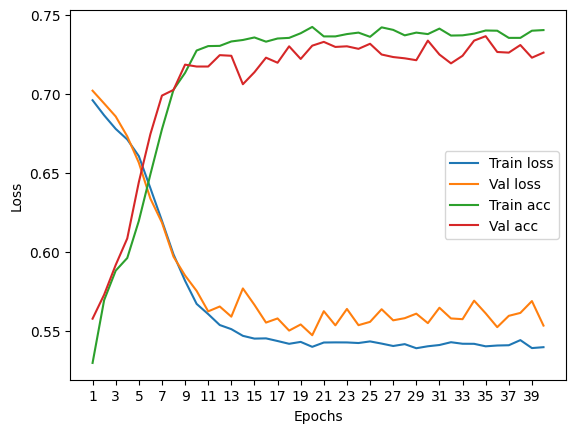

****************************************************************************************************



118it [00:00, 186.93it/s]


Train Epoch: 0 	Loss: 0.698609, Accuracy: 3742/7500 (50%)
Val Epoch: 0 	Loss: 0.711268, Accuracy: 1258/2500 (50%)



118it [00:00, 136.25it/s]


Train Epoch: 1 	Loss: 0.694893, Accuracy: 4028/7500 (54%)
Val Epoch: 1 	Loss: 0.702633, Accuracy: 1493/2500 (60%)



118it [00:00, 169.22it/s]


Train Epoch: 2 	Loss: 0.687159, Accuracy: 4295/7500 (57%)
Val Epoch: 2 	Loss: 0.689948, Accuracy: 1484/2500 (59%)



118it [00:00, 174.36it/s]


Train Epoch: 3 	Loss: 0.676121, Accuracy: 4411/7500 (59%)
Val Epoch: 3 	Loss: 0.680939, Accuracy: 1524/2500 (61%)



118it [00:00, 169.08it/s]


Train Epoch: 4 	Loss: 0.659880, Accuracy: 4683/7500 (62%)
Val Epoch: 4 	Loss: 0.653450, Accuracy: 1639/2500 (66%)



118it [00:00, 133.66it/s]


Train Epoch: 5 	Loss: 0.630893, Accuracy: 5033/7500 (67%)
Val Epoch: 5 	Loss: 0.634922, Accuracy: 1689/2500 (68%)



118it [00:00, 153.37it/s]


Train Epoch: 6 	Loss: 0.603240, Accuracy: 5291/7500 (71%)
Val Epoch: 6 	Loss: 0.610857, Accuracy: 1780/2500 (71%)



118it [00:00, 152.76it/s]


Train Epoch: 7 	Loss: 0.582930, Accuracy: 5381/7500 (72%)
Val Epoch: 7 	Loss: 0.582169, Accuracy: 1823/2500 (73%)



118it [00:00, 162.17it/s]


Train Epoch: 8 	Loss: 0.566054, Accuracy: 5477/7500 (73%)
Val Epoch: 8 	Loss: 0.589506, Accuracy: 1808/2500 (72%)



118it [00:00, 172.14it/s]


Train Epoch: 9 	Loss: 0.557161, Accuracy: 5534/7500 (74%)
Val Epoch: 9 	Loss: 0.578458, Accuracy: 1812/2500 (72%)



118it [00:00, 172.90it/s]


Train Epoch: 10 	Loss: 0.550857, Accuracy: 5526/7500 (74%)
Val Epoch: 10 	Loss: 0.575077, Accuracy: 1819/2500 (73%)



118it [00:00, 163.43it/s]


Train Epoch: 11 	Loss: 0.551291, Accuracy: 5513/7500 (74%)
Val Epoch: 11 	Loss: 0.562556, Accuracy: 1793/2500 (72%)



118it [00:00, 170.86it/s]


Train Epoch: 12 	Loss: 0.546300, Accuracy: 5513/7500 (74%)
Val Epoch: 12 	Loss: 0.559095, Accuracy: 1811/2500 (72%)



118it [00:00, 173.74it/s]


Train Epoch: 13 	Loss: 0.551051, Accuracy: 5486/7500 (73%)
Val Epoch: 13 	Loss: 0.574713, Accuracy: 1813/2500 (73%)



118it [00:00, 167.28it/s]


Train Epoch: 14 	Loss: 0.544745, Accuracy: 5536/7500 (74%)
Val Epoch: 14 	Loss: 0.570594, Accuracy: 1826/2500 (73%)



118it [00:00, 178.41it/s]


Train Epoch: 15 	Loss: 0.548656, Accuracy: 5506/7500 (73%)
Val Epoch: 15 	Loss: 0.559587, Accuracy: 1822/2500 (73%)



118it [00:00, 184.48it/s]


Train Epoch: 16 	Loss: 0.547276, Accuracy: 5535/7500 (74%)
Val Epoch: 16 	Loss: 0.559219, Accuracy: 1819/2500 (73%)



118it [00:00, 169.18it/s]


Train Epoch: 17 	Loss: 0.545270, Accuracy: 5520/7500 (74%)
Val Epoch: 17 	Loss: 0.557276, Accuracy: 1813/2500 (73%)



118it [00:00, 156.56it/s]


Train Epoch: 18 	Loss: 0.546760, Accuracy: 5554/7500 (74%)
Val Epoch: 18 	Loss: 0.572361, Accuracy: 1803/2500 (72%)



118it [00:00, 170.97it/s]


Train Epoch: 19 	Loss: 0.548358, Accuracy: 5502/7500 (73%)
Val Epoch: 19 	Loss: 0.566290, Accuracy: 1813/2500 (73%)



118it [00:00, 172.59it/s]


Train Epoch: 20 	Loss: 0.544847, Accuracy: 5544/7500 (74%)
Val Epoch: 20 	Loss: 0.560181, Accuracy: 1811/2500 (72%)



118it [00:00, 171.40it/s]


Train Epoch: 21 	Loss: 0.543923, Accuracy: 5548/7500 (74%)
Val Epoch: 21 	Loss: 0.569392, Accuracy: 1809/2500 (72%)



118it [00:00, 136.89it/s]


Train Epoch: 22 	Loss: 0.546680, Accuracy: 5544/7500 (74%)
Val Epoch: 22 	Loss: 0.579229, Accuracy: 1802/2500 (72%)



118it [00:00, 143.73it/s]


Train Epoch: 23 	Loss: 0.545073, Accuracy: 5536/7500 (74%)
Val Epoch: 23 	Loss: 0.561265, Accuracy: 1809/2500 (72%)



118it [00:00, 144.59it/s]


Train Epoch: 24 	Loss: 0.544903, Accuracy: 5543/7500 (74%)
Val Epoch: 24 	Loss: 0.562612, Accuracy: 1812/2500 (72%)



118it [00:00, 175.02it/s]


Train Epoch: 25 	Loss: 0.545036, Accuracy: 5540/7500 (74%)
Val Epoch: 25 	Loss: 0.573809, Accuracy: 1814/2500 (73%)



118it [00:00, 178.90it/s]


Train Epoch: 26 	Loss: 0.545851, Accuracy: 5541/7500 (74%)
Val Epoch: 26 	Loss: 0.564792, Accuracy: 1811/2500 (72%)



118it [00:00, 150.27it/s]


Train Epoch: 27 	Loss: 0.544097, Accuracy: 5561/7500 (74%)
Val Epoch: 27 	Loss: 0.577367, Accuracy: 1804/2500 (72%)



118it [00:00, 149.89it/s]


Train Epoch: 28 	Loss: 0.544681, Accuracy: 5553/7500 (74%)
Val Epoch: 28 	Loss: 0.573313, Accuracy: 1808/2500 (72%)



118it [00:00, 156.47it/s]


Train Epoch: 29 	Loss: 0.546557, Accuracy: 5537/7500 (74%)
Val Epoch: 29 	Loss: 0.561930, Accuracy: 1817/2500 (73%)



118it [00:00, 168.92it/s]


Train Epoch: 30 	Loss: 0.546571, Accuracy: 5546/7500 (74%)
Val Epoch: 30 	Loss: 0.569054, Accuracy: 1817/2500 (73%)



118it [00:00, 180.03it/s]


Train Epoch: 31 	Loss: 0.545422, Accuracy: 5539/7500 (74%)
Val Epoch: 31 	Loss: 0.573449, Accuracy: 1808/2500 (72%)



118it [00:00, 182.50it/s]


Train Epoch: 32 	Loss: 0.545534, Accuracy: 5543/7500 (74%)
Val Epoch: 32 	Loss: 0.569618, Accuracy: 1810/2500 (72%)



118it [00:00, 168.35it/s]


Train Epoch: 33 	Loss: 0.544182, Accuracy: 5562/7500 (74%)
Val Epoch: 33 	Loss: 0.564855, Accuracy: 1812/2500 (72%)



118it [00:00, 175.33it/s]


Train Epoch: 34 	Loss: 0.545009, Accuracy: 5563/7500 (74%)
Val Epoch: 34 	Loss: 0.556120, Accuracy: 1814/2500 (73%)



118it [00:00, 174.52it/s]


Train Epoch: 35 	Loss: 0.543186, Accuracy: 5550/7500 (74%)
Val Epoch: 35 	Loss: 0.565019, Accuracy: 1814/2500 (73%)



118it [00:00, 176.90it/s]


Train Epoch: 36 	Loss: 0.544255, Accuracy: 5550/7500 (74%)
Val Epoch: 36 	Loss: 0.565190, Accuracy: 1811/2500 (72%)



118it [00:00, 171.22it/s]


Train Epoch: 37 	Loss: 0.544808, Accuracy: 5546/7500 (74%)
Val Epoch: 37 	Loss: 0.565628, Accuracy: 1812/2500 (72%)



118it [00:00, 170.84it/s]


Train Epoch: 38 	Loss: 0.548026, Accuracy: 5552/7500 (74%)
Val Epoch: 38 	Loss: 0.561735, Accuracy: 1814/2500 (73%)



118it [00:00, 158.58it/s]


Train Epoch: 39 	Loss: 0.544539, Accuracy: 5545/7500 (74%)
Val Epoch: 39 	Loss: 0.565552, Accuracy: 1805/2500 (72%)

Test accuracy:  74.8


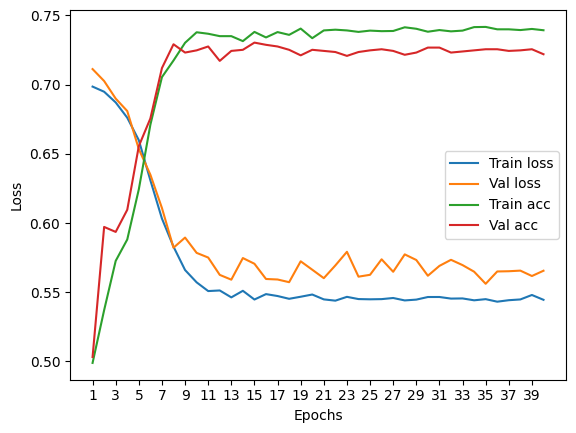

****************************************************************************************************



118it [00:00, 170.70it/s]


Train Epoch: 0 	Loss: 0.695975, Accuracy: 3985/7500 (53%)
Val Epoch: 0 	Loss: 0.702995, Accuracy: 1384/2500 (55%)



118it [00:00, 161.53it/s]


Train Epoch: 1 	Loss: 0.686717, Accuracy: 4264/7500 (57%)
Val Epoch: 1 	Loss: 0.691902, Accuracy: 1460/2500 (58%)



118it [00:00, 167.45it/s]


Train Epoch: 2 	Loss: 0.676848, Accuracy: 4367/7500 (58%)
Val Epoch: 2 	Loss: 0.692748, Accuracy: 1452/2500 (58%)



118it [00:00, 168.80it/s]


Train Epoch: 3 	Loss: 0.660202, Accuracy: 4615/7500 (62%)
Val Epoch: 3 	Loss: 0.659014, Accuracy: 1598/2500 (64%)



118it [00:00, 182.25it/s]


Train Epoch: 4 	Loss: 0.637613, Accuracy: 4936/7500 (66%)
Val Epoch: 4 	Loss: 0.637237, Accuracy: 1671/2500 (67%)



118it [00:00, 179.83it/s]


Train Epoch: 5 	Loss: 0.610809, Accuracy: 5208/7500 (69%)
Val Epoch: 5 	Loss: 0.607665, Accuracy: 1756/2500 (70%)



118it [00:00, 174.39it/s]


Train Epoch: 6 	Loss: 0.591292, Accuracy: 5326/7500 (71%)
Val Epoch: 6 	Loss: 0.597694, Accuracy: 1777/2500 (71%)



118it [00:00, 169.74it/s]


Train Epoch: 7 	Loss: 0.574999, Accuracy: 5455/7500 (73%)
Val Epoch: 7 	Loss: 0.575151, Accuracy: 1797/2500 (72%)



118it [00:00, 166.88it/s]


Train Epoch: 8 	Loss: 0.560040, Accuracy: 5484/7500 (73%)
Val Epoch: 8 	Loss: 0.579849, Accuracy: 1780/2500 (71%)



118it [00:00, 168.76it/s]


Train Epoch: 9 	Loss: 0.555882, Accuracy: 5478/7500 (73%)
Val Epoch: 9 	Loss: 0.564760, Accuracy: 1822/2500 (73%)



118it [00:00, 160.41it/s]


Train Epoch: 10 	Loss: 0.548017, Accuracy: 5543/7500 (74%)
Val Epoch: 10 	Loss: 0.555462, Accuracy: 1817/2500 (73%)



118it [00:00, 177.71it/s]


Train Epoch: 11 	Loss: 0.547829, Accuracy: 5543/7500 (74%)
Val Epoch: 11 	Loss: 0.561611, Accuracy: 1816/2500 (73%)



118it [00:00, 181.95it/s]


Train Epoch: 12 	Loss: 0.544817, Accuracy: 5557/7500 (74%)
Val Epoch: 12 	Loss: 0.560253, Accuracy: 1817/2500 (73%)



118it [00:00, 163.73it/s]


Train Epoch: 13 	Loss: 0.543329, Accuracy: 5573/7500 (74%)
Val Epoch: 13 	Loss: 0.562818, Accuracy: 1812/2500 (72%)



118it [00:00, 173.15it/s]


Train Epoch: 14 	Loss: 0.543790, Accuracy: 5549/7500 (74%)
Val Epoch: 14 	Loss: 0.555120, Accuracy: 1829/2500 (73%)



118it [00:00, 174.17it/s]


Train Epoch: 15 	Loss: 0.542353, Accuracy: 5568/7500 (74%)
Val Epoch: 15 	Loss: 0.562577, Accuracy: 1806/2500 (72%)



118it [00:00, 163.34it/s]


Train Epoch: 16 	Loss: 0.540562, Accuracy: 5554/7500 (74%)
Val Epoch: 16 	Loss: 0.549967, Accuracy: 1830/2500 (73%)



118it [00:00, 136.15it/s]


Train Epoch: 17 	Loss: 0.541259, Accuracy: 5552/7500 (74%)
Val Epoch: 17 	Loss: 0.554167, Accuracy: 1827/2500 (73%)



118it [00:00, 148.23it/s]


Train Epoch: 18 	Loss: 0.541983, Accuracy: 5553/7500 (74%)
Val Epoch: 18 	Loss: 0.553096, Accuracy: 1820/2500 (73%)



118it [00:00, 151.18it/s]


Train Epoch: 19 	Loss: 0.543141, Accuracy: 5537/7500 (74%)
Val Epoch: 19 	Loss: 0.548160, Accuracy: 1817/2500 (73%)



118it [00:00, 171.14it/s]


Train Epoch: 20 	Loss: 0.537868, Accuracy: 5569/7500 (74%)
Val Epoch: 20 	Loss: 0.558844, Accuracy: 1808/2500 (72%)



118it [00:00, 184.23it/s]


Train Epoch: 21 	Loss: 0.538882, Accuracy: 5589/7500 (75%)
Val Epoch: 21 	Loss: 0.553592, Accuracy: 1817/2500 (73%)



118it [00:00, 168.50it/s]


Train Epoch: 22 	Loss: 0.539309, Accuracy: 5573/7500 (74%)
Val Epoch: 22 	Loss: 0.572207, Accuracy: 1812/2500 (72%)



118it [00:00, 178.43it/s]


Train Epoch: 23 	Loss: 0.539182, Accuracy: 5577/7500 (74%)
Val Epoch: 23 	Loss: 0.551227, Accuracy: 1805/2500 (72%)



118it [00:00, 175.81it/s]


Train Epoch: 24 	Loss: 0.538432, Accuracy: 5581/7500 (74%)
Val Epoch: 24 	Loss: 0.556347, Accuracy: 1809/2500 (72%)



118it [00:00, 168.71it/s]


Train Epoch: 25 	Loss: 0.537093, Accuracy: 5564/7500 (74%)
Val Epoch: 25 	Loss: 0.555358, Accuracy: 1830/2500 (73%)



118it [00:00, 168.74it/s]


Train Epoch: 26 	Loss: 0.538472, Accuracy: 5586/7500 (74%)
Val Epoch: 26 	Loss: 0.558928, Accuracy: 1846/2500 (74%)



118it [00:00, 175.07it/s]


Train Epoch: 27 	Loss: 0.538393, Accuracy: 5563/7500 (74%)
Val Epoch: 27 	Loss: 0.548418, Accuracy: 1822/2500 (73%)



118it [00:00, 178.99it/s]


Train Epoch: 28 	Loss: 0.535110, Accuracy: 5579/7500 (74%)
Val Epoch: 28 	Loss: 0.549436, Accuracy: 1814/2500 (73%)



118it [00:00, 177.91it/s]


Train Epoch: 29 	Loss: 0.537050, Accuracy: 5579/7500 (74%)
Val Epoch: 29 	Loss: 0.550329, Accuracy: 1804/2500 (72%)



118it [00:00, 172.21it/s]


Train Epoch: 30 	Loss: 0.537085, Accuracy: 5594/7500 (75%)
Val Epoch: 30 	Loss: 0.561964, Accuracy: 1837/2500 (73%)



118it [00:00, 164.66it/s]


Train Epoch: 31 	Loss: 0.537753, Accuracy: 5587/7500 (74%)
Val Epoch: 31 	Loss: 0.560310, Accuracy: 1808/2500 (72%)



118it [00:00, 175.21it/s]


Train Epoch: 32 	Loss: 0.535662, Accuracy: 5559/7500 (74%)
Val Epoch: 32 	Loss: 0.552730, Accuracy: 1849/2500 (74%)



118it [00:00, 168.64it/s]


Train Epoch: 33 	Loss: 0.533640, Accuracy: 5581/7500 (74%)
Val Epoch: 33 	Loss: 0.559046, Accuracy: 1820/2500 (73%)



118it [00:00, 146.77it/s]


Train Epoch: 34 	Loss: 0.533157, Accuracy: 5571/7500 (74%)
Val Epoch: 34 	Loss: 0.548550, Accuracy: 1826/2500 (73%)



118it [00:00, 130.09it/s]


Train Epoch: 35 	Loss: 0.536962, Accuracy: 5569/7500 (74%)
Val Epoch: 35 	Loss: 0.553939, Accuracy: 1830/2500 (73%)



118it [00:00, 138.60it/s]


Train Epoch: 36 	Loss: 0.535980, Accuracy: 5579/7500 (74%)
Val Epoch: 36 	Loss: 0.552928, Accuracy: 1835/2500 (73%)



118it [00:00, 164.94it/s]


Train Epoch: 37 	Loss: 0.536037, Accuracy: 5576/7500 (74%)
Val Epoch: 37 	Loss: 0.547606, Accuracy: 1838/2500 (74%)



118it [00:00, 179.18it/s]


Train Epoch: 38 	Loss: 0.535582, Accuracy: 5543/7500 (74%)
Val Epoch: 38 	Loss: 0.547691, Accuracy: 1834/2500 (73%)



118it [00:00, 175.55it/s]


Train Epoch: 39 	Loss: 0.533200, Accuracy: 5593/7500 (75%)
Val Epoch: 39 	Loss: 0.563629, Accuracy: 1846/2500 (74%)

Test accuracy:  71.96000000000001


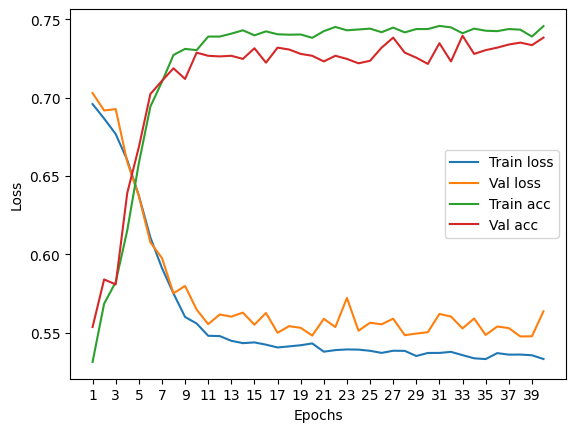

****************************************************************************************************



118it [00:00, 190.96it/s]


Train Epoch: 0 	Loss: 0.698781, Accuracy: 3781/7500 (50%)
Val Epoch: 0 	Loss: 0.706273, Accuracy: 1395/2500 (56%)



118it [00:00, 165.63it/s]


Train Epoch: 1 	Loss: 0.688986, Accuracy: 4314/7500 (58%)
Val Epoch: 1 	Loss: 0.692497, Accuracy: 1478/2500 (59%)



118it [00:00, 174.74it/s]


Train Epoch: 2 	Loss: 0.668798, Accuracy: 4583/7500 (61%)
Val Epoch: 2 	Loss: 0.673770, Accuracy: 1554/2500 (62%)



118it [00:00, 179.57it/s]


Train Epoch: 3 	Loss: 0.639847, Accuracy: 4946/7500 (66%)
Val Epoch: 3 	Loss: 0.635376, Accuracy: 1694/2500 (68%)



118it [00:00, 165.17it/s]


Train Epoch: 4 	Loss: 0.607284, Accuracy: 5228/7500 (70%)
Val Epoch: 4 	Loss: 0.614815, Accuracy: 1750/2500 (70%)



118it [00:00, 174.22it/s]


Train Epoch: 5 	Loss: 0.583753, Accuracy: 5323/7500 (71%)
Val Epoch: 5 	Loss: 0.601079, Accuracy: 1757/2500 (70%)



118it [00:00, 173.92it/s]


Train Epoch: 6 	Loss: 0.571333, Accuracy: 5357/7500 (71%)
Val Epoch: 6 	Loss: 0.571542, Accuracy: 1806/2500 (72%)



118it [00:00, 171.38it/s]


Train Epoch: 7 	Loss: 0.561059, Accuracy: 5458/7500 (73%)
Val Epoch: 7 	Loss: 0.568027, Accuracy: 1810/2500 (72%)



118it [00:00, 171.89it/s]


Train Epoch: 8 	Loss: 0.554037, Accuracy: 5497/7500 (73%)
Val Epoch: 8 	Loss: 0.577720, Accuracy: 1803/2500 (72%)



118it [00:00, 168.80it/s]


Train Epoch: 9 	Loss: 0.553606, Accuracy: 5470/7500 (73%)
Val Epoch: 9 	Loss: 0.569838, Accuracy: 1810/2500 (72%)



118it [00:00, 160.11it/s]


Train Epoch: 10 	Loss: 0.551324, Accuracy: 5478/7500 (73%)
Val Epoch: 10 	Loss: 0.571314, Accuracy: 1817/2500 (73%)



118it [00:00, 168.93it/s]


Train Epoch: 11 	Loss: 0.551807, Accuracy: 5477/7500 (73%)
Val Epoch: 11 	Loss: 0.569326, Accuracy: 1805/2500 (72%)



118it [00:00, 131.02it/s]


Train Epoch: 12 	Loss: 0.551089, Accuracy: 5488/7500 (73%)
Val Epoch: 12 	Loss: 0.567380, Accuracy: 1822/2500 (73%)



118it [00:00, 143.28it/s]


Train Epoch: 13 	Loss: 0.551684, Accuracy: 5493/7500 (73%)
Val Epoch: 13 	Loss: 0.569927, Accuracy: 1815/2500 (73%)



118it [00:00, 147.44it/s]


Train Epoch: 14 	Loss: 0.548825, Accuracy: 5479/7500 (73%)
Val Epoch: 14 	Loss: 0.575894, Accuracy: 1809/2500 (72%)



118it [00:00, 161.94it/s]


Train Epoch: 15 	Loss: 0.549293, Accuracy: 5493/7500 (73%)
Val Epoch: 15 	Loss: 0.575437, Accuracy: 1815/2500 (73%)



118it [00:00, 177.75it/s]


Train Epoch: 16 	Loss: 0.550074, Accuracy: 5492/7500 (73%)
Val Epoch: 16 	Loss: 0.571938, Accuracy: 1826/2500 (73%)



118it [00:00, 173.59it/s]


Train Epoch: 17 	Loss: 0.548908, Accuracy: 5511/7500 (73%)
Val Epoch: 17 	Loss: 0.577001, Accuracy: 1826/2500 (73%)



118it [00:00, 176.53it/s]


Train Epoch: 18 	Loss: 0.550260, Accuracy: 5500/7500 (73%)
Val Epoch: 18 	Loss: 0.569719, Accuracy: 1820/2500 (73%)



118it [00:00, 173.16it/s]


Train Epoch: 19 	Loss: 0.553363, Accuracy: 5498/7500 (73%)
Val Epoch: 19 	Loss: 0.570179, Accuracy: 1835/2500 (73%)



118it [00:00, 172.15it/s]


Train Epoch: 20 	Loss: 0.548606, Accuracy: 5503/7500 (73%)
Val Epoch: 20 	Loss: 0.573720, Accuracy: 1822/2500 (73%)



118it [00:00, 169.50it/s]


Train Epoch: 21 	Loss: 0.548291, Accuracy: 5514/7500 (74%)
Val Epoch: 21 	Loss: 0.575012, Accuracy: 1820/2500 (73%)



118it [00:00, 175.06it/s]


Train Epoch: 22 	Loss: 0.549808, Accuracy: 5501/7500 (73%)
Val Epoch: 22 	Loss: 0.591383, Accuracy: 1816/2500 (73%)



118it [00:00, 167.03it/s]


Train Epoch: 23 	Loss: 0.548516, Accuracy: 5511/7500 (73%)
Val Epoch: 23 	Loss: 0.568388, Accuracy: 1831/2500 (73%)



118it [00:00, 179.10it/s]


Train Epoch: 24 	Loss: 0.547281, Accuracy: 5499/7500 (73%)
Val Epoch: 24 	Loss: 0.568250, Accuracy: 1830/2500 (73%)



118it [00:00, 165.84it/s]


Train Epoch: 25 	Loss: 0.548894, Accuracy: 5515/7500 (74%)
Val Epoch: 25 	Loss: 0.568853, Accuracy: 1825/2500 (73%)



118it [00:00, 154.11it/s]


Train Epoch: 26 	Loss: 0.548861, Accuracy: 5499/7500 (73%)
Val Epoch: 26 	Loss: 0.574366, Accuracy: 1829/2500 (73%)



118it [00:00, 164.22it/s]


Train Epoch: 27 	Loss: 0.552515, Accuracy: 5487/7500 (73%)
Val Epoch: 27 	Loss: 0.570113, Accuracy: 1832/2500 (73%)



118it [00:00, 175.41it/s]


Train Epoch: 28 	Loss: 0.549125, Accuracy: 5534/7500 (74%)
Val Epoch: 28 	Loss: 0.569099, Accuracy: 1822/2500 (73%)



118it [00:00, 148.19it/s]


Train Epoch: 29 	Loss: 0.548429, Accuracy: 5504/7500 (73%)
Val Epoch: 29 	Loss: 0.563919, Accuracy: 1835/2500 (73%)



118it [00:00, 138.29it/s]


Train Epoch: 30 	Loss: 0.550245, Accuracy: 5507/7500 (73%)
Val Epoch: 30 	Loss: 0.578587, Accuracy: 1833/2500 (73%)



118it [00:00, 143.33it/s]


Train Epoch: 31 	Loss: 0.550758, Accuracy: 5513/7500 (74%)
Val Epoch: 31 	Loss: 0.567067, Accuracy: 1822/2500 (73%)



118it [00:00, 162.48it/s]


Train Epoch: 32 	Loss: 0.548337, Accuracy: 5512/7500 (73%)
Val Epoch: 32 	Loss: 0.568840, Accuracy: 1828/2500 (73%)



118it [00:00, 171.97it/s]


Train Epoch: 33 	Loss: 0.550329, Accuracy: 5501/7500 (73%)
Val Epoch: 33 	Loss: 0.570054, Accuracy: 1824/2500 (73%)



118it [00:00, 173.21it/s]


Train Epoch: 34 	Loss: 0.549139, Accuracy: 5518/7500 (74%)
Val Epoch: 34 	Loss: 0.567969, Accuracy: 1817/2500 (73%)



118it [00:00, 175.78it/s]


Train Epoch: 35 	Loss: 0.548948, Accuracy: 5512/7500 (73%)
Val Epoch: 35 	Loss: 0.564675, Accuracy: 1823/2500 (73%)



118it [00:00, 174.53it/s]


Train Epoch: 36 	Loss: 0.549921, Accuracy: 5507/7500 (73%)
Val Epoch: 36 	Loss: 0.571942, Accuracy: 1830/2500 (73%)



118it [00:00, 168.66it/s]


Train Epoch: 37 	Loss: 0.547275, Accuracy: 5521/7500 (74%)
Val Epoch: 37 	Loss: 0.568126, Accuracy: 1833/2500 (73%)



118it [00:00, 179.12it/s]


Train Epoch: 38 	Loss: 0.549231, Accuracy: 5526/7500 (74%)
Val Epoch: 38 	Loss: 0.570703, Accuracy: 1829/2500 (73%)



118it [00:00, 179.78it/s]


Train Epoch: 39 	Loss: 0.549563, Accuracy: 5499/7500 (73%)
Val Epoch: 39 	Loss: 0.568457, Accuracy: 1819/2500 (73%)

Test accuracy:  74.32


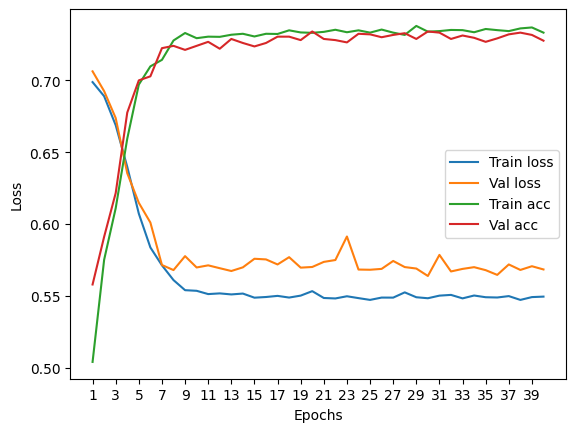

****************************************************************************************************



116it [00:00, 209.19it/s]


Train Epoch: 0 	Loss: 0.692765, Accuracy: 3837/7422 (52%)
Val Epoch: 0 	Loss: 0.693663, Accuracy: 1376/2474 (56%)



116it [00:00, 169.42it/s]


Train Epoch: 1 	Loss: 0.686484, Accuracy: 4097/7422 (55%)
Val Epoch: 1 	Loss: 0.686259, Accuracy: 1416/2474 (57%)



116it [00:00, 172.20it/s]


Train Epoch: 2 	Loss: 0.677428, Accuracy: 4265/7422 (57%)
Val Epoch: 2 	Loss: 0.684735, Accuracy: 1384/2474 (56%)



116it [00:00, 178.62it/s]


Train Epoch: 3 	Loss: 0.672107, Accuracy: 4403/7422 (59%)
Val Epoch: 3 	Loss: 0.672870, Accuracy: 1470/2474 (59%)



116it [00:00, 174.79it/s]


Train Epoch: 4 	Loss: 0.666643, Accuracy: 4460/7422 (60%)
Val Epoch: 4 	Loss: 0.666909, Accuracy: 1490/2474 (60%)



116it [00:00, 163.49it/s]


Train Epoch: 5 	Loss: 0.657741, Accuracy: 4616/7422 (62%)
Val Epoch: 5 	Loss: 0.651314, Accuracy: 1573/2474 (64%)



116it [00:00, 179.19it/s]


Train Epoch: 6 	Loss: 0.641101, Accuracy: 4850/7422 (65%)
Val Epoch: 6 	Loss: 0.630155, Accuracy: 1658/2474 (67%)



116it [00:00, 162.63it/s]


Train Epoch: 7 	Loss: 0.620545, Accuracy: 5004/7422 (67%)
Val Epoch: 7 	Loss: 0.607266, Accuracy: 1757/2474 (71%)



116it [00:00, 124.72it/s]


Train Epoch: 8 	Loss: 0.599528, Accuracy: 5196/7422 (70%)
Val Epoch: 8 	Loss: 0.583958, Accuracy: 1808/2474 (73%)



116it [00:00, 146.37it/s]


Train Epoch: 9 	Loss: 0.577788, Accuracy: 5339/7422 (72%)
Val Epoch: 9 	Loss: 0.563697, Accuracy: 1852/2474 (75%)



116it [00:00, 152.36it/s]


Train Epoch: 10 	Loss: 0.564872, Accuracy: 5382/7422 (73%)
Val Epoch: 10 	Loss: 0.551927, Accuracy: 1844/2474 (75%)



116it [00:00, 170.91it/s]


Train Epoch: 11 	Loss: 0.558025, Accuracy: 5406/7422 (73%)
Val Epoch: 11 	Loss: 0.541607, Accuracy: 1865/2474 (75%)



116it [00:00, 171.31it/s]


Train Epoch: 12 	Loss: 0.554247, Accuracy: 5437/7422 (73%)
Val Epoch: 12 	Loss: 0.538190, Accuracy: 1871/2474 (76%)



116it [00:00, 167.65it/s]


Train Epoch: 13 	Loss: 0.549787, Accuracy: 5407/7422 (73%)
Val Epoch: 13 	Loss: 0.535899, Accuracy: 1852/2474 (75%)



116it [00:00, 173.04it/s]


Train Epoch: 14 	Loss: 0.547662, Accuracy: 5436/7422 (73%)
Val Epoch: 14 	Loss: 0.536720, Accuracy: 1870/2474 (76%)



116it [00:00, 139.12it/s]


Train Epoch: 15 	Loss: 0.547778, Accuracy: 5439/7422 (73%)
Val Epoch: 15 	Loss: 0.532131, Accuracy: 1867/2474 (75%)



116it [00:00, 152.26it/s]


Train Epoch: 16 	Loss: 0.546334, Accuracy: 5434/7422 (73%)
Val Epoch: 16 	Loss: 0.534329, Accuracy: 1867/2474 (75%)



116it [00:00, 154.46it/s]


Train Epoch: 17 	Loss: 0.545841, Accuracy: 5452/7422 (73%)
Val Epoch: 17 	Loss: 0.528756, Accuracy: 1863/2474 (75%)



116it [00:00, 161.20it/s]


Train Epoch: 18 	Loss: 0.545664, Accuracy: 5424/7422 (73%)
Val Epoch: 18 	Loss: 0.530344, Accuracy: 1872/2474 (76%)



116it [00:00, 173.28it/s]


Train Epoch: 19 	Loss: 0.544585, Accuracy: 5474/7422 (74%)
Val Epoch: 19 	Loss: 0.527441, Accuracy: 1875/2474 (76%)



116it [00:00, 170.18it/s]


Train Epoch: 20 	Loss: 0.544861, Accuracy: 5452/7422 (73%)
Val Epoch: 20 	Loss: 0.527713, Accuracy: 1879/2474 (76%)



116it [00:00, 164.74it/s]


Train Epoch: 21 	Loss: 0.543870, Accuracy: 5438/7422 (73%)
Val Epoch: 21 	Loss: 0.528795, Accuracy: 1876/2474 (76%)



116it [00:00, 176.52it/s]


Train Epoch: 22 	Loss: 0.545154, Accuracy: 5432/7422 (73%)
Val Epoch: 22 	Loss: 0.530788, Accuracy: 1863/2474 (75%)



116it [00:00, 150.41it/s]


Train Epoch: 23 	Loss: 0.544986, Accuracy: 5443/7422 (73%)
Val Epoch: 23 	Loss: 0.531052, Accuracy: 1884/2474 (76%)



116it [00:00, 146.53it/s]


Train Epoch: 24 	Loss: 0.543874, Accuracy: 5464/7422 (74%)
Val Epoch: 24 	Loss: 0.527649, Accuracy: 1876/2474 (76%)



116it [00:00, 134.37it/s]


Train Epoch: 25 	Loss: 0.543807, Accuracy: 5452/7422 (73%)
Val Epoch: 25 	Loss: 0.527864, Accuracy: 1870/2474 (76%)



116it [00:00, 141.20it/s]


Train Epoch: 26 	Loss: 0.543704, Accuracy: 5472/7422 (74%)
Val Epoch: 26 	Loss: 0.527660, Accuracy: 1876/2474 (76%)



116it [00:00, 170.93it/s]


Train Epoch: 27 	Loss: 0.545257, Accuracy: 5441/7422 (73%)
Val Epoch: 27 	Loss: 0.526721, Accuracy: 1866/2474 (75%)



116it [00:00, 167.87it/s]


Train Epoch: 28 	Loss: 0.544117, Accuracy: 5459/7422 (74%)
Val Epoch: 28 	Loss: 0.535697, Accuracy: 1859/2474 (75%)



116it [00:00, 163.97it/s]


Train Epoch: 29 	Loss: 0.545621, Accuracy: 5472/7422 (74%)
Val Epoch: 29 	Loss: 0.531534, Accuracy: 1866/2474 (75%)



116it [00:00, 171.56it/s]


Train Epoch: 30 	Loss: 0.542907, Accuracy: 5473/7422 (74%)
Val Epoch: 30 	Loss: 0.532519, Accuracy: 1867/2474 (75%)



116it [00:00, 177.65it/s]


Train Epoch: 31 	Loss: 0.544336, Accuracy: 5474/7422 (74%)
Val Epoch: 31 	Loss: 0.527723, Accuracy: 1883/2474 (76%)



116it [00:00, 165.33it/s]


Train Epoch: 32 	Loss: 0.544747, Accuracy: 5455/7422 (73%)
Val Epoch: 32 	Loss: 0.529267, Accuracy: 1877/2474 (76%)



116it [00:00, 165.04it/s]


Train Epoch: 33 	Loss: 0.543333, Accuracy: 5455/7422 (73%)
Val Epoch: 33 	Loss: 0.526407, Accuracy: 1876/2474 (76%)



116it [00:00, 163.28it/s]


Train Epoch: 34 	Loss: 0.544114, Accuracy: 5453/7422 (73%)
Val Epoch: 34 	Loss: 0.529302, Accuracy: 1886/2474 (76%)



116it [00:00, 179.30it/s]


Train Epoch: 35 	Loss: 0.544310, Accuracy: 5464/7422 (74%)
Val Epoch: 35 	Loss: 0.527015, Accuracy: 1882/2474 (76%)



116it [00:00, 170.03it/s]


Train Epoch: 36 	Loss: 0.543336, Accuracy: 5465/7422 (74%)
Val Epoch: 36 	Loss: 0.526750, Accuracy: 1879/2474 (76%)



116it [00:00, 176.24it/s]


Train Epoch: 37 	Loss: 0.543636, Accuracy: 5453/7422 (73%)
Val Epoch: 37 	Loss: 0.551357, Accuracy: 1809/2474 (73%)



116it [00:00, 176.55it/s]


Train Epoch: 38 	Loss: 0.545959, Accuracy: 5438/7422 (73%)
Val Epoch: 38 	Loss: 0.529969, Accuracy: 1886/2474 (76%)



116it [00:00, 169.94it/s]


Train Epoch: 39 	Loss: 0.543448, Accuracy: 5443/7422 (73%)
Val Epoch: 39 	Loss: 0.529137, Accuracy: 1873/2474 (76%)

Test accuracy:  72.87793047696039


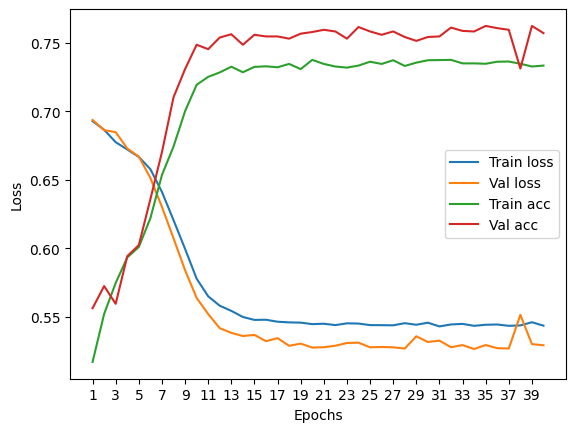

****************************************************************************************************





In [202]:
epochs = 40
train_loss, val_loss, train_acc, val_acc, auc = find_ideal_particles(X_norm, y, 1, 15)

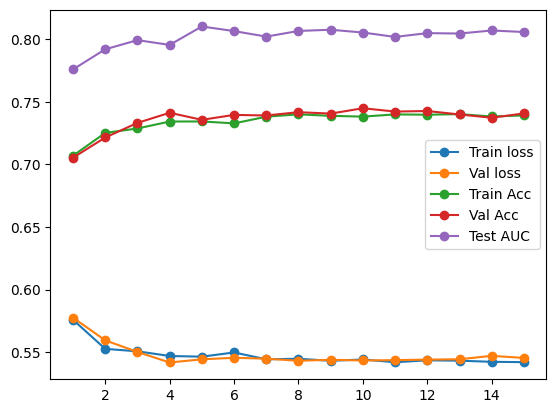

In [205]:
plt.plot(range(1,16), [sum(train_loss[i])/len(train_loss[i]) for i in range(1,len(train_loss)+1)], label='Train loss', marker='o')
plt.plot(range(1,16), [sum(val_loss[i])/len(val_loss[i]) for i in range(1,len(val_loss)+1)], label='Val loss', marker='o')
plt.plot(range(1,16), [sum(train_acc[i])/len(train_acc[i]) for i in range(1,len(train_acc)+1)], label='Train Acc', marker='o')
plt.plot(range(1,16), [sum(val_acc[i])/len(val_acc[i]) for i in range(1,len(val_acc)+1)], label='Val Acc', marker='o')
plt.plot(range(1,16), [sum(auc[i])/len(auc[i]) for i in range(1,len(auc)+1)], label='Test AUC', marker='o')
plt.legend()
plt.show()

It can be seen that beyond 4 or 5 particles we see very marginal improvements in performance at the expense of drastically slower learning. This could possibly be because we are considering a fixed graph topology - the complete graph. It would be interesting to perform the same experiment with Dynamic Graph Convolutional Networks such as ParticleNet and observe the trends in their performance.